# Training a binary image classifier for deepfakes

Earlier I published [this kernel](https://www.kaggle.com/humananalog/inference-demo) that shows how to do inference on the Deepfakes competition. It includes a ResNeXt50 checkpoint that I trained on my own machine and that gets 0.46788 on the leaderboard.

I did not include code for training that ResNeXt50 model because my process involves running a bunch of different scripts to create and clean up a training set, amongst other things. It's not feasible to do all of this in a Kaggle kernel.

However, Kaggler [dagnelies](https://www.kaggle.com/dagnelies) has made [this dataset of face crops](https://www.kaggle.com/dagnelies/deepfake-faces) available. Using this dataset, we can actually train our model using a Kaggle kernel!

**Tip:** Enable GPU for this. It's *really slow* using CPU.

In [1]:
!pip install -q wandb

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [1]:
!nvidia-smi

Sat May  9 23:04:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 28%   41C    P0    46W / 180W |      1MiB / 16278MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
import os, sys, random
import numpy as np
import pandas as pd
import cv2
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [3]:
image_size = 224
batch_size = 64

## The data

You need a bunch of face crops that are extracted from the full training dataset. Because we can't use the full training data from a kernel, I'm using [this dataset](https://www.kaggle.com/dagnelies/deepfake-faces), which is a nice starting point. You'll probably want to create your own dataset of face crops, as the quality of your training data makes all the difference.

In [4]:
crops_dir = "./data/faces_224"

metadata_df = pd.read_csv("./data/metadata.csv")
metadata_df.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [5]:
len(metadata_df)

95634

How many faces of each class do we have?

In [6]:
len(metadata_df[metadata_df.label == "REAL"]), len(metadata_df[metadata_df.label == "FAKE"])

(16293, 79341)

Look at a random face image:

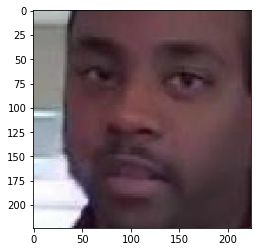

In [7]:
img_path = os.path.join(crops_dir, np.random.choice(os.listdir(crops_dir)))
plt.imshow(cv2.imread(img_path)[..., ::-1])

## The dataset and data loaders

Like most other torchvision models, the model we're using (ResNeXt50) requires that input images are normalized using mean and stddev. For making plots, we also define an "unnormalize" transform that can take a normalized image and turn it back into regular pixels.

In [8]:
from torchvision.transforms import Normalize

class Unnormalize:
    """Converts an image tensor that was previously Normalize'd
    back to an image with pixels in the range [0, 1]."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        mean = torch.as_tensor(self.mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        std = torch.as_tensor(self.std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        return torch.clamp(tensor*std + mean, 0., 1.)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)
unnormalize_transform = Unnormalize(mean, std)

During training, we'll apply data augmentation. In this kernel we just do random horizontal flips, but you can add other image transformations here too, such as rotation, zooming, etc. It's possible to use torchvision transforms for this, or a library such as [imgaug](https://www.github.com/aleju/imgaug), but I rolled my own using OpenCV2.

In [9]:
def random_hflip(img, p=0.5):
    """Random horizontal flip."""
    if random.random() < p:
        return cv2.flip(img, 1)
    else:
        return img

Some helper code for loading a training image and its label:

In [10]:
from PIL import Image

In [11]:
def load_image_and_label_pil(filename, cls, crops_dir, image_size, augment=False):
    """Loads an image into a tensor. Also returns its label."""
    
    img = cv2.imread(os.path.join(crops_dir, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, (image_size, image_size))
    img = Image.fromarray(img)

    target = 1 if cls == "FAKE" else 0
    return img, target

In [12]:
def load_image_and_label(filename, cls, crops_dir, image_size, augment=False):
    """Loads an image into a tensor. Also returns its label."""
    img = cv2.imread(os.path.join(crops_dir, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if augment: 
        img = random_hflip(img)

    img = cv2.resize(img, (image_size, image_size))

    img = torch.tensor(img).permute((2, 0, 1)).float().div(255)
    img = normalize_transform(img)

    target = 1 if cls == "FAKE" else 0
    return img, target

It's always smart to test that the code actually works. The following cell should return a normalized PyTorch tensor of shape (3, 224, 224) and the target 1 (for fake).

Note that this dataset has 155x155 images but our model needs at least 224x224, so we resize them.

In [13]:
img, target = load_image_and_label("aabuyfvwrh.jpg", "FAKE", crops_dir, 224, augment=True)

To plot the image, we need to unnormalize it and also permute it from (3, 224, 224) to (224, 224, 3). 

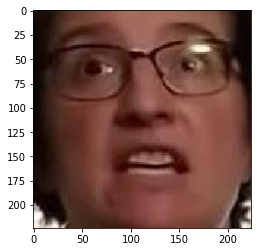

In [14]:
plt.imshow(unnormalize_transform(img).permute((1, 2, 0)))

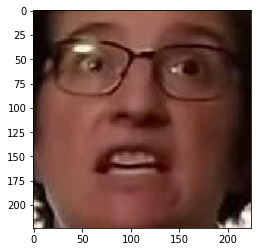

In [15]:
img, target = load_image_and_label_pil("aabuyfvwrh.jpg", "FAKE", crops_dir, 224, augment=True)
plt.imshow(img)

To use the PyTorch data loader, we need to create a `Dataset` object.

Because of the class imbalance (many more fakes than real videos), we're using a dataset that samples a given number of REAL faces and the same number of FAKE faces, so it's always 50-50.

In [16]:
from torch.utils.data import Dataset

class VideoDataset(Dataset):
    """Face crops dataset.

    Arguments:
        crops_dir: base folder for face crops
        df: Pandas DataFrame with metadata
        split: if "train", applies data augmentation
        image_size: resizes the image to a square of this size
        sample_size: evenly samples this many videos from the REAL
            and FAKE subfolders (None = use all videos)
        seed: optional random seed for sampling
    """
    def __init__(self, crops_dir, df, split, image_size, sample_size=None, seed=None, load_fn=load_image_and_label, transforms=None):
        self.crops_dir = crops_dir
        self.split = split
        self.image_size = image_size
        self.transforms = transforms
        self.load_fn = load_fn
        
        if sample_size is not None:
            real_df = df[df["label"] == "REAL"]
            fake_df = df[df["label"] == "FAKE"]
            sample_size = np.min(np.array([sample_size, len(real_df), len(fake_df)]))
            print("%s: sampling %d from %d real videos" % (split, sample_size, len(real_df)))
            print("%s: sampling %d from %d fake videos" % (split, sample_size, len(fake_df)))
            real_df = real_df.sample(sample_size, random_state=seed)
            fake_df = fake_df.sample(sample_size, random_state=seed)
            self.df = pd.concat([real_df, fake_df])
        else:
            self.df = df

        num_real = len(self.df[self.df["label"] == "REAL"])
        num_fake = len(self.df[self.df["label"] == "FAKE"])
        print("%s dataset has %d real videos, %d fake videos" % (split, num_real, num_fake))

    def __getitem__(self, index):
        row = self.df.iloc[index]
        filename = row["videoname"][:-4] + ".jpg"
        cls = row["label"]
        img, label = self.load_fn(filename, cls, self.crops_dir, 
                                    self.image_size)
        if self.transforms is not None:
            img = self.transforms(img)
                
        return img, label
    def __len__(self):
        return len(self.df)

Let's test that the dataset actually works...

In [17]:
dataset = VideoDataset(crops_dir, metadata_df, "val", image_size, sample_size=1000, seed=1234)

val: sampling 1000 from 16293 real videos
val: sampling 1000 from 79341 fake videos
val dataset has 1000 real videos, 1000 fake videos


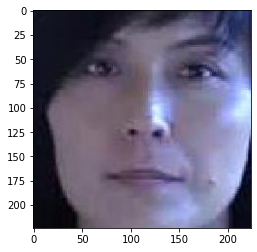

In [18]:
plt.imshow(unnormalize_transform(dataset[0][0]).permute(1, 2, 0))

In [19]:
from torchvision import transforms

val: sampling 1 from 16293 real videos
val: sampling 1 from 79341 fake videos
val dataset has 1 real videos, 1 fake videos


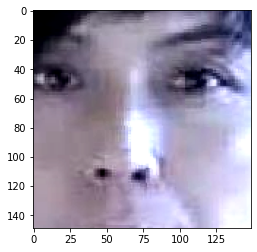

In [20]:
# Custom transforms
dataset = VideoDataset(
    crops_dir, 
    metadata_df, 
    "val", 
    image_size, 
    sample_size=1, 
    seed=1234,
    load_fn=load_image_and_label_pil,
    transforms=transforms.Compose([
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomPerspective(),
        transforms.RandomAffine(2, translate=(0.3, 0.3)),
        transforms.CenterCrop(image_size/1.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)
plt.imshow(unnormalize_transform(dataset[0][0]).permute(1, 2, 0))

In [21]:
del dataset

Split up the data into train / validation. There are many different ways to do this. For this kernel, we're going to just grab a percentage of the REAL faces as well as their corresponding FAKEs. This way, a real video and all the fakes that are derived from it will be either completely in the training set or completely in the validation set. 

(This is still not ideal because the same person may appear in many different videos. Ideally we want a person to be either in train or in val, but not in both. But it will do for now.)

In [22]:
def make_splits(crops_dir, metadata_df, frac):
    # Make a validation split. Sample a percentage of the real videos, 
    # and also grab the corresponding fake videos.
    real_rows = metadata_df[metadata_df["label"] == "REAL"]
    real_df = real_rows.sample(frac=frac, random_state=666)
    fake_df = metadata_df[metadata_df["original"].isin(real_df["videoname"])]
    val_df = pd.concat([real_df, fake_df])

    # The training split is the remaining videos.
    train_df = metadata_df.loc[~metadata_df.index.isin(val_df.index)]

    return train_df, val_df

Sanity check:

In [23]:
train_df, val_df = make_splits(crops_dir, metadata_df, frac=0.05)

assert(len(train_df) + len(val_df) == len(metadata_df))
assert(len(train_df[train_df["videoname"].isin(val_df["videoname"])]) == 0)

del train_df, val_df

Use all of the above building blocks to create `DataLoader` objects. Note that we use only a portion of the full amount of training data, for speed reasons. If you have more patience, increase the `sample_size`.

In [24]:
transform_list = transforms.Compose([
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomPerspective(),
        transforms.RandomAffine(2, translate=(0.3, 0.3)),
        transforms.CenterCrop(image_size/1.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

In [25]:
from torch.utils.data import DataLoader

def create_data_loaders(crops_dir, metadata_df, image_size, batch_size, num_workers):
    train_df, val_df = make_splits(crops_dir, metadata_df, frac=0.05)

    train_dataset = VideoDataset(crops_dir, train_df, "train", image_size, sample_size=10000, load_fn=load_image_and_label_pil, transforms=transform_list)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              num_workers=num_workers, pin_memory=True)

    val_dataset = VideoDataset(crops_dir, val_df, "val", image_size, sample_size=500, seed=1234)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                            num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader

In [26]:
train_loader, val_loader = create_data_loaders(crops_dir, metadata_df, image_size, 
                                               batch_size, num_workers=2)

train: sampling 10000 from 15478 real videos
train: sampling 10000 from 75449 fake videos
train dataset has 10000 real videos, 10000 fake videos
val: sampling 500 from 815 real videos
val: sampling 500 from 3892 fake videos
val dataset has 500 real videos, 500 fake videos


And, as usual, a check that it works... The `train_loader` should give a different set of examples each time you run it (because `shuffle=True`), while the `val_loader` always returns the examples in the same order.

tensor(0)


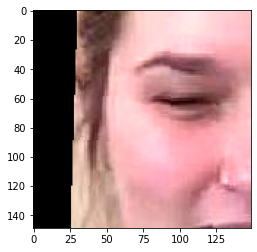

In [27]:
X, y = next(iter(train_loader))
plt.imshow(unnormalize_transform(X[0]).permute(1, 2, 0))
print(y[0])

tensor(0)


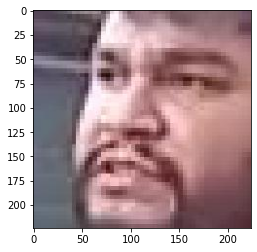

In [28]:
X, y = next(iter(val_loader))
plt.imshow(unnormalize_transform(X[0]).permute(1, 2, 0))
print(y[0])

## Helper code for training

Evaluation function for running the model on the validation set:

In [29]:
def evaluate(net, data_loader, device, silent=False):
    net.train(False)

    bce_loss = 0
    total_examples = 0

    with tqdm(total=len(data_loader), desc="Evaluation", leave=False, disable=silent) as pbar:
        for batch_idx, data in enumerate(data_loader):
            with torch.no_grad():
                batch_size = data[0].shape[0]
                x = data[0].to(device)
                y_true = data[1].to(device).float()

                y_pred = net(x)
                y_pred = y_pred.squeeze()

                bce_loss += F.binary_cross_entropy_with_logits(y_pred, y_true).item() * batch_size

            total_examples += batch_size
            pbar.update()

    bce_loss /= total_examples

    if silent:
        return bce_loss
    else:
        print("BCE: %.4f" % (bce_loss))

Simple training loop. I prefer to write those myself from scratch each time, because then you can tweak it to do whatever you like.

In [30]:
def fit(epochs):
    global history, iteration, epochs_done, lr

    with tqdm(total=len(train_loader), leave=False) as pbar:
        for epoch in range(epochs):
            pbar.reset()
            pbar.set_description("Epoch %d" % (epochs_done + 1))
            
            bce_loss = 0
            total_examples = 0

            net.train(True)

            for batch_idx, data in enumerate(train_loader):
                batch_size = data[0].shape[0]
                x = data[0].to(gpu)
                y_true = data[1].to(gpu).float()
                
                optimizer.zero_grad()

                y_pred = net(x)
                y_pred = y_pred.squeeze()
                
                loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
                loss.backward()
                optimizer.step()
                
                batch_bce = loss.item()
                bce_loss += batch_bce * batch_size
                history["train_bce"].append(batch_bce)

                total_examples += batch_size
                iteration += 1
                pbar.update()

            bce_loss /= total_examples
            epochs_done += 1

            print("Epoch: %3d, train BCE: %.4f" % (epochs_done, bce_loss))

            val_bce_loss = evaluate(net, val_loader, device=gpu, silent=True)
            wandb.log({"bce_loss": bce_loss, "epoc": epoch, "val_bce": val_bce_loss})
            history["val_bce"].append(val_bce_loss)
            
            print("val BCE: %.4f" % (val_bce_loss))

            # TODO: can do LR annealing here
            lr /= 10
            set_lr(optimizer, lr)
            # TODO: can save checkpoint here

            print("")

## The model

Need to load pretrained ImageNet weights into the model.

You can get these weights from `https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth`, or from [this dataset](https://www.kaggle.com/tony92151/pretrained-pytorch) by Kaggler [tonyguo](https://www.kaggle.com/tony92151).

In [31]:
import torchvision

In [32]:
## Pull in efficient net
#https://github.com/lukemelas/EfficientNet-PyTorch
!pip install -q --upgrade efficientnet-pytorch
## TODO: Clean this up so we can specify model and get pretrained model as `net`
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7') 

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
Loaded pretrained weights for efficientnet-b7


In [33]:
model_dict = {
#     'resnext50': resnext50,
#     'resnext101': ressnext101
}

In [34]:
checkpoint = model

In [35]:
def list_layers(net):
    return [k for k,v in net.named_parameters() if v.requires_grad]

In [36]:
list_layers(checkpoint)

['_conv_stem.weight',
 '_bn0.weight',
 '_bn0.bias',
 '_blocks.0._depthwise_conv.weight',
 '_blocks.0._bn1.weight',
 '_blocks.0._bn1.bias',
 '_blocks.0._se_reduce.weight',
 '_blocks.0._se_reduce.bias',
 '_blocks.0._se_expand.weight',
 '_blocks.0._se_expand.bias',
 '_blocks.0._project_conv.weight',
 '_blocks.0._bn2.weight',
 '_blocks.0._bn2.bias',
 '_blocks.1._depthwise_conv.weight',
 '_blocks.1._bn1.weight',
 '_blocks.1._bn1.bias',
 '_blocks.1._se_reduce.weight',
 '_blocks.1._se_reduce.bias',
 '_blocks.1._se_expand.weight',
 '_blocks.1._se_expand.bias',
 '_blocks.1._project_conv.weight',
 '_blocks.1._bn2.weight',
 '_blocks.1._bn2.bias',
 '_blocks.2._depthwise_conv.weight',
 '_blocks.2._bn1.weight',
 '_blocks.2._bn1.bias',
 '_blocks.2._se_reduce.weight',
 '_blocks.2._se_reduce.bias',
 '_blocks.2._se_expand.weight',
 '_blocks.2._se_expand.bias',
 '_blocks.2._project_conv.weight',
 '_blocks.2._bn2.weight',
 '_blocks.2._bn2.bias',
 '_blocks.3._depthwise_conv.weight',
 '_blocks.3._bn1.weight

In [37]:
## Transfer learn
num_features = checkpoint._fc.in_features

checkpoint._fc = nn.Linear(num_features, 1) ## Binary classifier

In [38]:
#checkpoint = torchvision.models.resnext50_32x4d(pretrained=True)

In [39]:
#checkpoint = checkpoint.state_dict()

In [40]:
# import torchvision.models as models

# class MyResNeXt(models.resnet.ResNet):
#     def __init__(self, training=True):
#         super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
#                                         layers=[3, 4, 6, 3], 
#                                         groups=32, 
#                                         width_per_group=4)

#         self.load_state_dict(checkpoint)

#         # Override the existing FC layer with a new one.
#         self.fc = nn.Linear(2048, 1)

In [41]:
net = checkpoint.to(gpu)

In [42]:
#del checkpoint

Test the model on a small batch to see what its output shape is:

In [43]:
out = net(torch.zeros((10, 3, image_size, image_size)).to(gpu))
out.shape

torch.Size([10, 1])

Freeze the early layers of the model:

In [44]:
def freeze_until(net, param_name):
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name

In [45]:
freeze_layer = "_blocks.49._expand_conv.weight" # depends on network
freeze_until(net, freeze_layer)

These are the layers we will train:

In [46]:
[k for k,v in net.named_parameters() if v.requires_grad]

['_blocks.49._expand_conv.weight',
 '_blocks.49._bn0.weight',
 '_blocks.49._bn0.bias',
 '_blocks.49._depthwise_conv.weight',
 '_blocks.49._bn1.weight',
 '_blocks.49._bn1.bias',
 '_blocks.49._se_reduce.weight',
 '_blocks.49._se_reduce.bias',
 '_blocks.49._se_expand.weight',
 '_blocks.49._se_expand.bias',
 '_blocks.49._project_conv.weight',
 '_blocks.49._bn2.weight',
 '_blocks.49._bn2.bias',
 '_blocks.50._expand_conv.weight',
 '_blocks.50._bn0.weight',
 '_blocks.50._bn0.bias',
 '_blocks.50._depthwise_conv.weight',
 '_blocks.50._bn1.weight',
 '_blocks.50._bn1.bias',
 '_blocks.50._se_reduce.weight',
 '_blocks.50._se_reduce.bias',
 '_blocks.50._se_expand.weight',
 '_blocks.50._se_expand.bias',
 '_blocks.50._project_conv.weight',
 '_blocks.50._bn2.weight',
 '_blocks.50._bn2.bias',
 '_blocks.51._expand_conv.weight',
 '_blocks.51._bn0.weight',
 '_blocks.51._bn0.bias',
 '_blocks.51._depthwise_conv.weight',
 '_blocks.51._bn1.weight',
 '_blocks.51._bn1.bias',
 '_blocks.51._se_reduce.weight',
 '_b

Before we train, let's run the model on the validation set. This should give a logloss of about 0.6931.

In [47]:
evaluate(net, val_loader, device=gpu)

BCE: 0.6962


## Training

In [48]:
lr = 1e-3
wd = 0.

history = { "train_bce": [], "val_bce": [] }
iteration = 0
epochs_done = 0

optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

At this point you can load the model from the previous checkpoint. If you do, also make sure to restore the optimizer state! Something like this:

```python
checkpoint = torch.load("model-checkpoint.pth")
net.load_state_dict(checkpoint)

checkpoint = torch.load("optimizer-checkpoint.pth")
optimizer.load_state_dict(checkpoint)
```

Let's start training!

In [61]:
run_epochs = 2

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7fc34976f268> (for post_run_cell):


NotebookValidationError: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01~\x00\x00\x00\xf8\x08\x06\x00\x00\x00\xebD\x8d\x8d\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.2.1, http://matplotlib.org/\xa3\xf2:\xda\x00\x00 \x00IDATx\x9c\xed\xbdy\x98\\gu\xe7\xff=\xb5\xaf\xdd\xd5U\xd5-\xa97\xb5Vk\xb3\xd4\xb2e\x81\x81\xb0$\x831I\xc6\x84\x01\x8c\x05d\x80\x00&,\xc9d\x8f\'3!\x84\x0c\xf9e\x92@2,\x13\x02\x84\x1d\xdb1\xc6C\xec\x89\x89\xe1\x19\x12 `\x1b\xc9\xb6Z[\xdbjY\xeaVW\xab\xa5^j_\xba\xd6\xf7\xf7\xc7\xad[]]]\xcb\xad\xaa[\xfb\xf9<\x8f\x1e\xa9n\xdd\xaaz\xaf\xaa\xfb[\xa7\xce{\xce\xf7\x90\x10\x02\x0c\xc30L\xef\xa0i\xf5\x02\x18\x86a\x98\xe6\xc2\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xa1k\xf5\x02\nq\xbb\xddbbb\xa2\xd5\xcb`\x18\x86\xe9(\x9ey\xe6\x99\x15!\xc4\xa0\x92s\xdbN\xf8\'&&p\xea\xd4\xa9V/\x83a\x18\xa6\xa3 \xa29\xa5\xe7r\xaa\x87a\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16\xfe.az1\x88\xa7.\xaf\xb6z\x19\x0c\xc3t\x00,\xfc]\xc2\'\xbew\x11\xbf\xf9\xc0s\xe0\xf9\n\x0c\xc3T\x82\x85\xbfKX\t\xc7\xb1\x14\x8a\xe3Z`\xad\xd5Ka\x18\xa6\xcda\xe1\xef\x12\xbc\x91\x04\x00\xe0\xd99_\x8bW\xc20L\xbb\xc3\xc2\xdf%\xf8\xb2\xc2\xff\xdcU\x7f\x8bW\xc20L\xbb\xc3\xc2\xdf\x05\xc4Si\x84\xe2)\x00\xc0s\xf3\x1c\xf13\x0cS\x1e\x16\xfe.\xc0\x17I\x02\x00\xfa\xcdz\x9c_\x08"\x9eJ\xb7xE\x0c\xc3\xb43,\xfc]\xc0j$\x0e\x00x\xcdM\x83H\xa438\x7f-\xd8\xe2\x151\x0c\xd3\xce\xb0\xf0w\x01r\xc4\xff\xf3\xfb\xb7\x00\xe0<?\xc30\xe5a\xe1\xef\x02\xe4\x88\x7f\xffV;F\x1cf<w\x95\xf3\xfc\x0c\xc3\x94F\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfb\x8a\xdc\xff7Dt:\xfb\xe7"\x11\xf9\x0b\xee\xef#"\x0f\x11}F\xad\x853\xeb\xc8\xa5\x9cN\xab\x01G\xc7\x1d\x1c\xf13\x0cS\x96\x8a\xc2ODZ\x00\x9f\x05\xf0z\x00\x07\x00\x9c \xa2\x03\xf9\xe7\x08!~[\x081)\x84\x98\x04\xf0i\x00\x8f\x14<\xcd\x9f\x01\xf8\x91:Kf\n\xf1E\x12 \x02\x1c\x16\x03\x8e\x8e\x0f`\xc1\x1f\xc3\x8d 7r1\x0cS\x1c%\x11\xffq\x00\x97\x84\x10\x97\x85\x10\t\x00\x0f\x02xC\x99\xf3O\x00x@\xbeAD\xb7\x02\xd8\x02\xe0{\xf5,\x94)\xcdj$\x01\x87Y\x0f\xad\x86pt\xdc\x01\x80\xf3\xfc\x0c\xc3\x94F\x89\xf0\x8f\x00\x98\xcf\xbb\xed\xc9\x1e\xdb\x04\x11m\x07\xb0\x03\xc0\x0f\xb2\xb75\x00>\x01\xe0\xf7\xca\xbd\x00\x11\xddKD\xa7\x88\xe8\xd4\xf2\xf2\xb2\x92u3yx#\t8\xad\x06\x00\xc0\xc1\xe1>\x18\xb4\x1a\xae\xe7g\x18\xa6$jo\xee\xde\x03\xe0a!\x84\\H\xfeA\x00\x8f\x0b!<\xe5\x1e$\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0\xa0\xcaK\xea~\xbc\x91\x04\\V#\x00\xc0\xa8\xd3\xe2\xe0H\x1f\x9e\x9b\xe3\x88\x9fa\x98\xe2\xe8\x14\x9c\xb3\x00`,\xef\xf6h\xf6X1\xee\x01\xf0\xa1\xbc\xdb\xb7\x03\xf89"\xfa \x00\x1b\x00\x03\x11\x85\x85\x10\x9b6\x88\x99\xda\xf1F\x12\xd89h\xcd\xdd>:6\x80\xfb\x7f6\x87d:\x03\xbd\x96\x0b\xb7\x18\x86\xd9\x88\x12U8\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93\xf21!\xc4\xdb\x85\x10\xe3B\x88\tH\xe9\x9e\xaf\xb1\xe8\xab\x8f\x94\xea1\xe6n\x1f\x1dw`-\x99\xc1\x0b\xd7C-\\\x15\xc30\xedJE\xe1\x17B\xa4\x00|\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xf2N\xbd\x07\xc0\x83\x82\r\xe1\x9bJ&#\xe0\x8b&\xe0\xca\xe6\xf8\x01\xe4m\xf0r\x9e\x9fa\x98\xcd(I\xf5@\x08\xf18\x80\xc7\x0b\x8e}\xa4\xe0\xf6G+<\xc7W\x00|\xa5\xaa\xd51\x15\t\xc4\x92\xc8\x08\xe46w\x01`\xc4a\xc6\x90\xdd\x88g\xaf\xfa\xf1\xab\xb7\xb7pq\x0c\xc3\xb4%\x9c\x00\xeepV\xf3\x9a\xb7d\x88(\xdb\xc8\xc5\x11?\xc30\x9ba\xe1\xefp\xbcE\x84\x1f\x00\x8e\x8e\x0f`v5\x9a\xbb\x9fa\x18F\x86\x85\xbf\xc3))\xfccR\x9e\xff4\xd7\xf33\x0cS\x00\x0b\x7f\x87SJ\xf8\x0f\x8f:\xa0\xd5\x10\x9e\xe5z~\x86a\n`\xe1\xefp\xbcYg\xceB\xe17\x1b\xb4\xd8\xbf\xcd\xce\x1d\xbc\x0c\xc3l\x82\x85\xbf\xc3\xf1F\x92\xb0\x1a\xb40\xe9\xb5\x9b\xee;:6\x80\xa9\xf9\x00\xd2\x19\xae\xb0e\x18f\x1d\x16\xfe\x0e\xc7\x1b\x89c\xa0 \xda\x97\xb9e\xbb\x03\xe1x\n\x97\x96\xc2M^\x15\xc30\xed\x0c\x0b\x7f\x87\xb3\x1a\xd9\xd8\xbc\x95\xcf\xd1\xb1\x01\x00\xc0\xb3\\\xd6\xc90L\x1e,\xfc\x1d\x8e/\x9a\xd8\x94\xdf\x97\xd9\xee\xb2`\xc0\xa2\xe7z~\x86a6\xc0\xc2\xdf\xe1x\xc3\x89\x92\xa9\x1e\xa9\x91k\x80\xbd\xf9\x19\x86\xd9\x00\x0b\x7f\x07#\x84(\x9b\xea\x01\x80[\xc6\x1d\x98Y\n#\x10K6qe\x0c\xc3\xb43,\xfc\x1dL,\x99F<\x95\xd9\xe0\xccY\xc8\xd1q)\xcf?5\xcfQ?\xc30\x12,\xfc\x1d\xccjXj\xde*\x17\xf1\x1f\x1e\xed\x07\x11\x8fbd\x18f\x1d\x16\xfe\x0eF\xee\xda-\x95\xe3\x07\x00\xbbI\x8f\xbdC\xdc\xc8\xc50\xcc:,\xfc\x1d\x8c7Z\xdc\xae\xa1\x90[\xb6;\xf0\xdcU?2\xdc\xc8\xc50Ma)\xb8\x86\xbf\xff\xe1\x8bh\xd7\xf1$,\xfc\x1d\x8cWA\xaa\x07\x90\xea\xf9\x03\xb1$\xae\xacF\x9a\xb1,\x86ik\xae\x07\xd6\xb0\x14\\k\xe8k<\xf2\xdc\x02\xfe\xbf\xef>\xdf\xb6\xcd\x93,\xfc\x1d\x8c\x92T\x0f\x90?\x91\x8b\xf3\xfc\x0c\xf3\x9b\x0f<\x87\xdf\xfd\xd6TC_c.\x1bd\xb1\xf03\xaa\xb3\x1aI@\xaf%\xf4\x99\xca\x0fR\xdb5h\x83\xdd\xa4\xe3F\xae:\xf9\xd6\xa9y\x9c\xe6\xea\xa8\x8eF\x08\x81\xf3\xd7\x02\xb8x\xa3\xb1\xf3\xa8gW\xa2\x00X\xf8\x99\x06\xe0\x8b$0`1\x80\x88\xca\x9e\xa7\xd1\x10&\xc7\x1cx\x96#\xfe\x9a\x11B\xe0#\xfft\x1e_\xfd\xe9l\xab\x97\xc2\xd4\xc1\xb5\xc0\x1a"\x894n\x04\xe3\x88&R\r{\x9d\xab^I\xf8_\\f\xe1gTf5R\xda\xae\xa1\x90\xa3\xe3\x03x\xe1z\x10\x91x\xe3~\xd8\xbb\x19o$\x81X2\x8d\x95p\xbc\xd5Ka\xea`&/\xd2\x9f[\x8d6\xe45\xd6\x92i\\\x0b\xc4\x00\x00\x97X\xf8\x19\xb5\xf1F\xe2U\x08\xbf\x03\x19\x01\x9c\xf1\x04\x1a\xbc\xaa\xeed\xc1/\xfd"\xcb\xbd\x13Lg\x92\x9fz\x99kP\xb1\x83\xc7\x17\x85\x10R\xd1\xc5\x8bK\x91\xb6\xac\xa6c\xe1\xef`|\xd1\xa4r\xe1\xcf\x8eb\xe4z\xfe\xda\xf0\xf8\xb2\xc2\x1f\xe1\x88\xbf\x93\x99\xb9\x11\x86\xcd(\xed\x89\xcd6(\xe2\x97\xf3\xfb\xaf\xd97\x84X2\x8d\xc5\x06W\x10\xd5\x02\x0b\x7f\x07\xb3\x1aV\x1e\xf1;,\x06\xec\x1c\xb4\xf2(\xc6\x1a\xf1\xf8\xa4_\xe6\xd5p\xa2-#8F\x193K!\x1c\x1a\xe9\x83\xcbjhX\xc4?\x97\xcd\xef\xff\x87\xfdC\x00\xdas\x83\x97\x85\xbfCI\xa63\x08\xae\xa5\x14\x0b? \xd5\xf3\x9f\x9e\xf7\xb5mS\x89\xcc\xc9Y/\x96B\xed\x15%\xc9\x11\x7f*#\x10\\c\xc3\xbbND\x08\x81\x99\xa50\xf6\x0c\xd9\xb1\xdde\xc1\x95\x95\x06\t\xffj\x04v\x93\x0e\xc7&\x9c\x00X\xf8\x19\x15\xf1E\x955o\xe5st\xdc\x81\x95p"\'b\xed\xc8\xe3g\x17\xf1\x96\xcf=\x89\xcf\xff\xf0r\xab\x97\xb2\x81\xfc\xff\xb3\x15\xce\xf3w$K\xa18Bk)\xec\xd9b\xc3\x84\xcb\xda\xb0\xcd\xdd\xd9\xd5(\xb6\xbb,pY\rpX\xf4,\xfc\x8cz(m\xde\xcaGn\xe4j\xd7\x89\\\xcf\xcc\xf9\xf0\xdb\xffx\x1a\x80\xf4K\xdaNx|Q\xd8\xb3\xb9\xe1\xd5\x06V\xf6d2\x02\xb1D\xbaa\xcf\xdf\xcb\xcc\xdc\x90\x04x\xf7\x90\r\xdb]V,\x06\xd6\xb0\x96T\xff\xffzn5\x82\xed.+\x88\x08\xbb\x07mmY\xd2\xc9\xc2\xdf\xa1\xc8v\r\xd5\xa4zn\xdab\x87\xc5\xa0m\xcb\x0e\xde\xd9\x95\x08\xde\xf7\xb5S\xd8\xd6o\xc2\xee![\xee\x83\xad\x1d\x10B\xc0\xe3\x8b\xe1\xe6\xd1~\x00\x8d\x8d\xf8\xbf\xf0\xe3\xcbx\xe5_\xfd+\x8b\x7f\x03\x98Y\x92J9\xf7\x0c\xd91\xe1\xb6\x00P\xbf\xa43\x99\xce`\xc1\x17\xc3\x84Kz\xfe\xddC6\xbc\xc8\x11?\xa3\x16\xde\\\xaa\xa7\xb4\x17\x7f!:\xad\x06\x87G\xfb\xdb\xae\x83\xd7\x17I\xe0\xdd_9\t!\x04\xbe\xfc\xee\xe3\x98pY\xb0\xdaF\xc2\xef\x8b&\x11M\xa4q$[\x19\xd5\xc8\xca\x9e\x99\xa50\x96Cq\xfc\xf3\xd9\xc5\x86\xbdF\xaf2\xb3\x14\x86\xc3\xa2\x87\xdbf\xc0\x84\xcb\n\x00\x98Uy\x83\xf7\x9a?\x86TF`{\xf6\xf9w\r\xda\xb0\x1aI\xc0\xd7F?\xcf\x00\x0b\x7f\xc7"G\xc4\xd5D\xfc\x80\xd4\xc8u\xfeZ\xb0!_qka-\x99\xc6\xbd_?\x85\x05\x7f\x0c_\xf8\xcf\xc7\xb0\xc3m\x85\xd3j\x80\xb7\x8d\xca&\xe5\x8a\x9e\xc3#\xd2l\x83FF\xfc\xcb\xd9\x14\xd7\xfdO\xcf5\xec5z\x95K7\xc2\xd8;d\x07\x11\xe5\x84_\xed\xca\x1e\xb9Dt\xbbs=\xe2\x07\xda\xaf\x83\x97\x85\xbfC\x91\x1b\x89\x1c\x16}U\x8f;:\xe6@*#pn\xa1\xf5\x8d\\\x99\x8c\xc0\xef?|\x06\'g}\xf8\xe4\xddGrU\x10N\xab\x11\xdeH\xa2m\xaa\x8f\xe4\x8d\xddq\x97\x05N\x8b\xa1\xa19\xfe\xe5P\x1cD\xc0\xb3W\xfdx\xfez\xb0a\xaf\xd3k\x08!pq)\x84\xdd[$!\xee\xb7\xe81`\xd1\xab^\xcb/\x7f\x90L\xb8\xa5\x0f\x16Y\xf8\xdbm\x83\x97\x85\xbfC\xf1F\x12\xe87\xeb\xa1\xd7V\xf7\x16\xca\xa3\x18\xdb!\xcf\xffW\xdf{\x01\x8fM]\xc3}\xaf\xdf\x87_><\x9c;\xee\xb2\x1a\x90L\x0b\x84\xdb\xc4^B\x8e\xf8G\x07,p\xd9\x0c\r\xb5mX\t\xc7\xf1\xda\xfd[`\xd0j\xf0\xe0\xcf\xe6\x1b\xf6:\xbd\xc6j$\x01\x7f4\x89=Y!\x06\x80\xed.+fU.\xe9\x9c[\x8d\xc2\xa4\xd7`\xc8.\xa5`G\x1cf\x18u\x1a\x16~F\x1d\xbc\xd1\xf2C\xd6K1h7b\xcciny\x07\xef\xfdO_\xc5\xdf\xfd\xdb\x8bx\xdbK\xc6\xf1\xfeW\xee\xdcp\x9f\x9c\xbej\x97\r^\x8f/\x06\xbbI\x87~\xb3\x1e.\xab\xb1a\xb6\r\x99\x8c\xc0j$\x81\x9b\xb6\xdaq\xe7\xa1\xadx\xe4Y\x0fo\xf2\xaa\x84\\\xd1\xb3g\xc8\x9e;6\xe1\xb2\xa8\xbe\xb9;\xb7\x1a\xc1D\xb6\xa2\x07\x90\x0c\x12w\xb6ae\x0f\x0b\x7f\x87\xe2\r\'\xaa*\xe5\xcc\xe7\xe8\xd8@K#\xfe\x7f{a\t\x7f\xfcO\xe7\xf0\xea\x9b\x06\xf1\xb1\xbb\x0enr\x17u\xda\xa4\xebj\x97\r\xde\x05_\x0c\xa3\x03R\xce\xd6m76l]\xbeh\x02\xe9\x8c\x80\xdbf\xc4\x89\xe3\xe3\x08\xae\xa5\xf08o\xf2\xaa\xc2%\xb9\xa2g\xcb\xc6\x88\xffZ \xa6\xea~\xd7\xecj\x14\xe3\xd9\xfc\xbe\xcc\xee![\xdb\x99\xb5\xb1\xf0w(\xde*\x9c9\x0b\xb9e\xdc\x81\xc5\xc0\x1a\x16\x03\xcdo\xe4\xbap-\x88\x0f}\xf3Y\xdc\xb4\xc5\x8e\xcf\xbc\xed\x16\xe8\x8a\xa4\xaa\xe4o2\xde6i\x94\xf2\xf8b\x18\x1d0\x03\x90\xd6\xd6\xa8T\xcfr\xf6y\x07\xedF\xbct\xa7\x13;\xdcV<\xf0\xb3\xab\ry\xad^\xe3\xe2\x8d0\xec&].\x05\x03\x00;\xdcV\x08\xb1\x9e\xca\xab\x97LF\xe0\xaa7\x9a\xcb\xef\xcb\xec\x1e\xb4\xc1\xe3S\xf7\x03\xa6^\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc8\xfd\x7fCD\xa7\xb3\x7f.\x12\x91?{|\x92\x88\x9e$\xa2\xf3Dt\x86\x88\xde\xaa\xf6\x05\xd4\xc3\xa5\xa5\x10~\xef[SH\xa63\xad^J\xd5\xd4\x9a\xea\x01Z\x97\xe7_\x0c\xc4\xf0k_9\x89>\xb3\x1e_z\xd7m9\xb3\xacB\x06,\xed\x93\xea\x91j\xf8\xa39\xe1w\xdb\x0c\x08\xad\xa5\x1a\xf2K,W\xf4\x0c\xda\x8d "\x9c8>\x86Ss\xbe\x86\x0f\r\xe9\x05f\x96B\xd83d\xdb\xf0\xedr{\xb6\xd6\xfe\xca\x8a:\xc2\x7f=\xb8\x86D*\x93{^\x99]C\xd2\x07L;\xa5{*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\xe4\x9f#\x84\xf8m!\xc4\xa4\x10b\x12\xc0\xa7\x01<\x92\xbd+\n\xe0?\x0b!\x0e\x02\xb8\x13\xc0\xdf\x12\x91C\xcd\x0b\xa8\x87G\x9e]\xc0\xc3\xcfxT\xdf\xe0i4B\x08i\x08K\x8d\xc2\xbf\x7f[\x1f\x0c:MS\xeb\xf9CkI\xbc\xfb\xcb\'\x11\x8e\xa7\xf0\xa5w\xdd\x86\xad\xfd\xa6\x92\xe7\xba\xda(\xd5\xe3\x8f&\x11I\xa4s\xa9\x1e\x97M\x8a\x18\x1b\xf1\xa1$\x7f\x93pg_\xe3M\xb7\x8c\xc2\xa0\xd5p\xd4\xaf\x02\x97\xb2\x1e=\xf9\xa8]\xd2)\xf7\x04\xc8\xcf+\xb3^\xd2\xd9>:\xa3$\xe2?\x0e\xe0\x92\x10\xe2\xb2\x10"\x01\xe0A\x00o(s\xfe\t\x00\x0f\x00\x80\x10\xe2\xa2\x10b&\xfb\xefk\x00\x96\x00\x0c\xd6\xb7d\xf5\x98\xf2H\x11\xef\xb5@{\x19\x82U"\x18K!\x95\x115G\xfc\x06\x9d\x067\x8f\xf47-\xe2O\xa63\xf8\xd0\xfd\xcfaf)\x8c\xff\xfd\xf6[\xb0\x7f[_\xd9\xf3-\x06\x1dLzM[\xd4\xf2\xcb\xa5\x9c\xeb\x11\xbf$\xca\x8d\xd8\xe0\xcd\x8f\xf8\x01\xe9C\xe6u\x87\xb6\xe2\xdb\xcfx\xda*M\xd0ix#\t\xac\x84\x13\x1b\xf2\xfb\x80T\n\xddg\xd2\xa9\xd6\xc4%o\x14\x17\xe6\xf8w\xb8\xad\xd0P{\x95t*\x11\xfe\x11\x00\xf9ue\x9e\xec\xb1M\x10\xd1v\x00;\x00\xfc\xa0\xc8}\xc7\x01\x18\x00\xbcX\xe4\xbe{\x89\xe8\x14\x11\x9dZ^^V\xb2\xee\xba\xc9dDn(\xc95\x7f\xfb\x9a\x96\x15C\xee\xda\xad5\xc7\x0fHy\xfe3\x0b\x01$R\x8dMs\t!\xf0\xc7\xdf9\x87\x1f]\\\xc6\x9f\xbf\xf1\x10^\xb9W\xd9\xe7\xbe\xcb\xda\xb8M\xd4jX/\xe5\xcc\xe6\xf8\xb3\xdfFV\x1a\xf0\xa1\xb4\x1c\x8a\xc3\xa4\xd7\xc0j\xd0\xe6\x8e\x9d8>\xc6\x9b\xbcu"\x0b\xee\xee\xa1\x8d\xc2OD\xd8\xe1\xb6\xe6\xfc\xf3\xebev5\x02\xbd\x960\xec0o8n\xd4i1\xee\xb4\xb4\x95u\x83\xda\x9b\xbb\xf7\x00xX\x08\xb1!<!\xa2m\x00\xbe\x0e\xe0\xddB\x88MJ#\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0`s\xbe\x10\xcc\xaeF\x10Z\x93\xea\xc4;N\xf8\xb3\xa2Sk\xaa\x07\x90\xf2\xfc\x89T\x06\xd3\x8b\x8dm\x12\xfa\xc6Ssx\xf0\xe4<>\xfc\x9a\xddx\xebm\xe3\x8a\x1f\xe7\xb4\x1a\xda\xa2\xcd=\x17\xf1;\xb2U=Y\x8b\x8c\x95\x06\x98\xc8\xad\x84\x13\xb9\xfc\xbe\xcc\xed;]\x98pY8\xddS\x079\x8f\x9e-\xf6M\xf7mwYU\x8b\xf8\xaf\xaeF1\xe6\xb4@\xab\xd9<\x03{W\x9b\x95t*\x11\xfe\x05\x00cy\xb7G\xb3\xc7\x8aq\x0f\xb2i\x1e\x19"\xea\x03\xf0\xcf\x00\xfe\x9b\x10\xe2\xa9Z\x16\xd9\x08\xe4h_\xab\xa1\xdcX\xbdNAN3\xd4\x9a\xea\x01\x9a\xe7\xd4\xf9\xd8\xd4"\x0e\x0e\xf7\xe1w\xef\xd8[\xd5\xe3$\xdb\x86v\x10~\xc9\x95\xb3\xcf,mD7r\xffa9\x14\xc7\xa0m\xa3\xf7\x92\xb4\xc9;\x8e\x93\xb3\xbe\r\xf3b\x19\xe5\xcc\xdc\x08\xc3j\xd0b\xb8\xc8\xbe\xd2\x84\xcb\x82k\xfe\x18\xe2\xa9\xfaSi\xb3\xab\xd1M\xf9}\x99\xddC6\\^\x89 \xdd&C|\x94\x08\xffI\x00{\x88h\x07\x11\x19 \x89\xfb\xa3\x85\'\x11\xd1>\x00\x03\x00\x9e\xcc;f\x00\xf0\x7f\x00|M\x08\xf1\xb0:KV\x87)\x8f\x1f&\xbddZ\xd6i\x11\xbfO\x85T\xcf\xb6~3\xb6\xf4\x19qz\xbeqy\xfeT:\x83\xb3\x0b\x01\x1c\xdf\xe1\xdcT\xab_\t\x97\xd5\xd0&\xa9\x9e\x18F\x06\xcc\xb9\xf5[\x8d:\x98\xf5\xda\x86\xd86,\x87\xe2\xb9=\x84|\xdet\xeb(\xf4Z\xc2\x03\xdc\xc9[\x13\x97\x96\xc2\xd8]P\xd1#3\xe1\xb6"#P\xf7\x8c\n!D\xd6\x8e\xd9R\xf4\xfe]C6$R\x19\xcc{\x1b3\x03\xa0Z*\n\xbf\x10"\x05\xe0\xc3\x00\x9e\x000\r\xe0!!\xc4y"\xfa\x18\x11\xdd\x95w\xea=\x00\x1e\x14\x1b\rV\xee\x06\xf0J\x00\xef\xca+\xf7\x9cTq\xfd535\xef\xc7\xcd#\xfd\x18wZp\xcd\xdfY\x9b\xbb\xb2 V\xe3\xccY\x8c\xc91GC\x85\x7ff)\x8cX2\x8d\xc9\xb1\xea\x0b\xb9\xda\'\xe2_o\xde\x92q\xd9\x0c\r\xd9\xdc]\t\xc7s\x1b\xbb\xf9\xb8mF\xdcqp+\xbe\xfd,o\xf2\xd6\xc2\xccR\x08\xbb\x876\xa7y\x00\xe4\\4\xeb\xad\xec[\x0e\xc7\x11M\xa4s\xe6l\x85\xec\x1al/\xcf\x1eE9~!\xc4\xe3B\x88\xbdB\x88]B\x88\x8fg\x8f}D\x08\xf1h\xde9\x1f\x15B\xdcW\xf0\xb8o\x08!\xf4r\xa9g\xf6\xcfiu/\xa1z\x92\xe9\x0c\xce_\x0b\xe2\xf0\xa8\x03\xc3\x0e3\x16\x03\xb1\x8e\x9a\xa3\xea\r\'`\xd2k`\xce\xdb\x04\xac\x85\xc9\xb1\x01\xcc\xadF\x1b&\xb0S\xd9\x0f\x95#\xa3\xd5\x0b\xff\x80\xd5\x80h"\xddR\xa1+\xac\xe1\x97q\xd9\x8c\xb9f+\xb5H\xa53\xf0F\x13E\x85\x1f\x00\xdev|\x1c\x81X\x12\xffr\xee\xba\xaa\xaf\xdb\xed\x04bI\xdc\x08\xc6\xb1\xb7\xa0\xa2GF\xf6\xcd\xaf\xd7\xac\xed\xaa\xec\xca\xe9.\x9d\xea\x01\xda\xa7\x96\xbf\';w/\xde\x08!\x9e\xca\xe0\xf0h?\x86\x1df$\xd3\xa2\xa1\xc6[j\xe3\x8d$\xea\x8e\xf6\x01\xe4"\xf1\xa9\x06E\xfdS\x1e?\xfa\xcd\xfa\x92_\x7f\xcb!\xef_\xb42\xdd\xb3^\xc3\xbfQ\xf8\xddV\xf5#~\xc9\x8d\x14ES=\xc0\xfa&\xef\xfd\xbc\xc9[\x15r\x84]X\xca)\xe3\xb4\x1a`7\xea\xea\xae\xe5\x97?8J\xe5\xf8\xfb\xcdz\x0c\xda\x8d\x9d\x15\xf1w\x1b\xf2\xc6\xee\x91Q\x07F\x1c\xd2\x86O\'m\xf0z\xa3\xb5\xdb5\xe4sx\xb4\x1f\x1a\x02\x9ek\x90\xf0\x9f\x9e\x0f\xe0\xc8\x98\xa3\xea\xfc>\x90g\xd4\xd6B\xdb\x86\xf5\x1a\xfe\x8d\x1f\\n\x9bQ\xf5a,K\x055\xfc\x85h4\x84{\x8e\x8f\xe3gW\xbc9\xdf\x19\xa62\x97\xf2\xa6n\x15\x83\x880\xe1\xb6\xd6\x1d\xf1\xcf\xadF\xa0\xd5\x10F\nJ9\xf3\xd9=\xd8>\x9e==)\xfcS\xf3\xeb\x91\xa8\\s\xdbIy~o\x1d]\xbb\xf9X\x8d:\xec\xddboH\x9e?\x9aH\xe1\xe2\x8d\x10&\xb3\xe3\n\xabe\xbdz\xa6u\xdf\xc4\x16\xfc\x1bk\xf8e\xe4\x1c\xbf\x9a\xf3\x02\x96\x0b\xbav\x8b\xf1f\xde\xe4\xad\x9a\x99\x1ba\x98\xf4\x9a\xb2\x82\xbc\xdde\xa9;\xc7?\xbb\x1a\xc5\xb0\xc3\x04\x83\xae\xb4\xa4\xee\x1a\xb2\xe2\xc5\xa5p[\xcc\x99\xe8M\xe1\xf7\x04px\xb4\x1fD\x94\'\xfc\x9d\x13\xf1\xaf\x86k\xf7\xe9)dr\xcc\x81\xa9y\xbf\xea?\x8c\xe7\x16\x82HgDn\\a\xb58\xb3\xa9,\xb9\x82\xa9\x15\xc8\x11\xff\xd8\xa6\xcd]#R\x19\x81@,\xa9\xdak\xc9}\x01C%"~ \xbb\xc9{\x807y\xaba&[\xd1\xa3)R[/3\xe1\xb2\xc2\xe3\x8b\xd6\xd5\xccx5k\xc7\\\x8e\xdd\x836\x04\xd7R\xaa\xef\x0f\xd5B\xcf\t\x7f,\x91\xc6\xc5\x1b\xa1\xdc\x86c\x9fI\x0f\xbbQ\xd7Q\xa9\x1e\x9fJ\xa9\x1e@\x12\xfe@,\x89+*\xfb\x15\xc9\xfb\x06\x87k\xd8\xd8\x05\xd6S=\x8d\xf2\xbeW\x82\xc7\x17\xdbP\xc3/\xe3\x96\xbbwU\\\x9b\x92\x88\x1f\x00N\x1c\x1f\x87?\x9a\xc4\x13\xe7y\x93W\t\xc5<z\n\x91K:\xeb\xd1\x80\xd9\xd5h\xc5\xbd,\xb9\xb2\xa8\x1d\xf2\xfc=\'\xfc\x17\x16\x03Hg\x04\x0e\xe7\xa5 \x86\x1d\xe6\x8e\x89\xf8\xd7\x92iD\x13i\xf5\x84?\xdb\xc8\xa5v\xba\xe7\xb4\xc7\x8f\x11\x87\xb9d\xce\xba\x12}&\x1dt\x1ajiI\xa7\xc7\x17\xddP\xc3/\xb3\xee\xd7\xa3^\xe4\xb6\x1c\x8a\xc3f\xd4U\xac\xd4z\xd9.\x17\xc6\x9d\x16\xdc\xff4o\xf2V"\x1cOa\xc1\x1f\xdbd\xd5PH\xae\xb2\xa7\xc6\xe0\xc7\x1fM \x10KV\x8c\xf8w\rI\xf7\xb7\x83uC\xcf\t\xff\xd4|vc7/\x051\xec0\xe1Z\x0b\xbc\xe9ka\xb5\xc6!\xeb\xa5\xd83d\x87\xd5\xa0U]\xf8\xa7\xe6\xfd\xb9\x0f\x95Z "\x0c\xb4\xb8\x96\xbfX\r?\xd0\x98\xee]\xd9\xae\xa1\x12\xd2&\xef\x18\x9e\xbe\xe2m\x9b\xd2\xc0v%W\xd1SA\xf8s\xb5\xfc5V\xf6\xcc\x960g+dk\x9f\t6\xa3\xae-\\:{O\xf8=~l\xe93bK\xdfz\xfb\xb6\x14\xf1w\xc6\xe6\xaeOe\xe1\xd7j\x087\x8f\xf6\xab*\xfc+\xe18<\xbe\x18&kL\xf3\xc8\xb4\xb2{W\xaa\xe1\x8fm\xda\xd8\x05\xd6\x1b\xe7\xd4,\x01^\x0e\xadm\xb2k(\xc5[n\x1d\x83NCx\x90K;\xcb"[\\\x14\xf3\xe8\xc9\xc7m3\xc0j\xd0\xd6<\x86\xb1p\xc0z)\x88\x08\xbb\x06\xad\x9c\xeai\x05g<\x81M\rE\xc3\x0e3\xbc\x91DG\xcc7U;\xe2\x07\xa4F\xae\xe9\xc5\xa0j\x1b\x86g\xb2v\xd7\xb5n\xec\xca\xb4\xb2{7\x10K"\x1cO\x15\x15\xfe\x01\x8b\x1eD*\xe7\xf8Cq\xb8\xed\xca\xde\xd3A\xbb\x11w\x1c\xdc\x82\x87\xd9\xae\xb9,\x97\x96\xc20\xe84\x18+\xf2\x1e\xe6\xb3^\xd2Y[$^\xca\x8e\xb9\x18\xbb\x06m,\xfc\xcdF\xde\xc4,\x14$\xb9\xd4\xab\x13\xd2=\xb23\xa7\xba\xc2\xef@2-p\xfe\x9a:N\x9d\xa7\xe7\x03\xd0\x10ph\xa4\xbc\xef~%Z)\xfc\x85>\xfc\xf9\xe8\xb4\x1a8-\x06Us\xfc+\xe1\x84\xe2\x88\x1f\x906y}\xbc\xc9[\x96\x99\xa50v\xba\xadE\xc7{\x162\xe1\xb2\xd6\x9c\xe3\x9f]\x8d`[\xbf\t&}\xe5N\xfa]C6\\\x0f\xae!\x1cO\xd5\xf4Zj\xd1S\xc2\x7f6\xdb\xb8u\xb8\xa0\xb6\xbc\x93J:\xbd\x11\xa9\x84P\xadrN`\xdd\xa9S\xadt\xcf\xd4\xbc\x1f{\xb7\xd8a1\x14\x1f\xad\xa8\x14\x97U]q\xad\x86u\x1f\xfe\xe2Q\x9c\x9a~=\xf1T\x1a\x81X\xb2\xaa\x8d\xf0\x97\xefrc\xccif\xbb\xe62\xcc,\x85*\xa6yd\xb6\xbb,\xf0\xf8b5\x8da\x9d+2`\xbd\x149\xeb\x86\x16G\xfd=%\xfc\xf2\xc4\xad\xc3#\x85\xa9\x1e)\xdf\xdf\x19\xc2\x1f\x87VC\xe83\xe9U{\xce-}&l\xeb7\xa9"\xfcB\x08Ly\xfc5\x19\xb3\x15\xe2\xb4\x1a\x11\\K\xb5d&r\xb9\x88\x1f\x90\xf2\xfcj\xe5\xf8\xe5\x0f\x90J\xa5\x9c\xf9h4\x84{n\x1b\xc7S\x97\xbd\xb8\xcc\x9b\xbc\x9b\x88&R\xf0\xf8b\x157ve&\\V\xa42\xa2&\r\x98+c\xc7\\\x88,\xfc\xadN\xf7\xf4\x96\xf0\xcf\xfb\xb1\xc3mE\xbfe\xa3hn\xe93AC\xc0B\x07l\xf0z#\t\x0cX\xf4e\x1bRjAr\xea\xac\xdf\x9b\xff\xaa7\n\x7f4Yw~\x1f\x00\x9c\xd9\xea\x99V4qy|1\xd8\x8c:\xf4\x9b\x8b\x7f\xc0\xba\xed\xeaM\x08+\x1c\xb9\xa8\x94\xb7\x1c\x1b\x956yOr\'o!\x97\x97#\x10\xa2rE\x8f\x8c\xbc1[\xaduC8\x9e\xc2J8\x8e\xedne\x11\xff\xb8\xd3\x02\x9d\x86Zn\xdd\xd0S\xc2\x7f&\xdb\xb1[\x88^\xab\xc1\x96>SGD\xfc\xaba\xf5\x9a\xb7\xf2\x99\x1cs`\xde\x1b\xab;\xb5r\xba\x0eG\xceB\xe4tV+\xf2\xfc\xb2+g)\x9f!\x97\xd5\xa0Z\xc4/\x0b\x7f5\x11?\x00\x0c\xd9M\xf8\x0f\xfb\xa5M^5\x06\x89t\x13\xe5\xa6n\x15\xa3\xd6Z\xfe\xb9\x12\x03\xd6K\xa1\xd7j0\xe1\xb6r\xaa\xa7Y,\x05\xd7p=\xb8V\xb2\x93t[\x7fg\x08\xbf\x9a]\xbb\xf9\xe4\x9c:=\xf5\xa5{N\xcfK\x03nJ\xd9\xe0V\xc3\x80\xa5uFm\xa5J9e\xdc6\x03Bk)U\x04W\xfe\x00\xa9\xa5\xd9\xedm/\x19\x877\x92\xc0\x13\xe7o\xd4\xbd\x8enb\xe6F\x18z-)v\x86\x1d\xb4\x1ba1h\xab\xae\xec\xa9\xa6\xa2G\xa6\x1d\xcc\xdazF\xf8\xa7r\x8e\x9c\xc5M\xc3:\xa5{w5\xd2\x18\xe1\xbfy\xb4\x1fZ\r\xe1\xf4\xd5\xfa\x84_\x1ep\xa3\xa4\x92\xa2\x12\x8d\x1csX\x0e!\x04\x16J4o\xc9\xb8r\xdd\xbb\xf5\xafM\x8e\xf8\xe5\xeb\xad\x86W\xecvc\xc2e\xc1\xc7\x1e;\x8f\xf3\xd7\x02u\xaf\xa5[\x98Y\nc\x87\xdb\n\xbd\xc2\x9fC"\xc2v\x97\xb5\xeaZ~\xf9\xfcj\xac\xc7w\rI\xafS\x8f7P\xbd\xf4\x8c\xf0\x9f\xf1\xf8\xa1\xd5\x10\x0e\x0e\x17\x17\xfe\x11\x87\x19\xd7\x02km\xe1\x9cW\x0eo\x83\x84\xdfb\x90\x9c:\xeb\xb1hN\xa638w-\xa8J\x9a\x07\xc8\xb3fn\xb2\xf0\x07c)\x84J\xd4\xf0\xcb\xb8\xd5\x14\xfep\x1c\xfdf=\x8c\xba\xea\x07\xebh4\x84\x7fx\xd7m0h5\xb8\xe7\xf3O\xe1\xd4\xac\xb7\xee\xf5t\x03J<z\n\x99\xa8\xc1\xa5sn5\x02\xb7\xcd\x00{\x15\xc5\x16\xbb\x87lHg\x04\xaez[\xd7\xc1\xdb3\xc2\x7f:[bX\xca\x0be\xd8aF"\x95i\x8b9\xaf\xa5H\xa53\x08\xc4\x929\xe7J\xb5\x91\x9d:k\x9dF\xf6\xc2\xf5\x10\x12\xa9\x8c*\x1b\xbb\x80\x94\xea!j~\xc4?\xef+n\xc7\x9c\x8f\x1c\x9d\xaf\xa8`\x1b]j\xe4\xa2Rv\r\xda\xf0\xad\x0f\xbc\x0cn\x9b\x11\xef\xf8\x87\xa7\xf1\xc3\x8b\xcbu\xaf\xa9\x93YK\xa61\xb7\x1a\xa9\xe8\xd1S\xc8v\x97\x15\xf3\xbe(RUT\x91\xcd\xaeFr\x96\x0fJ\xd9=\xd8z\xb3\xb6\x9e\x10~!\x04\xce.\x04J\xa6y\x80\xce\xa8\xe5\xf7\xc7\x92\x10\x02pZ\xd4+\xe5\xcc\xe7\xe8\x98\x03\xc1\xb5\x14\xae\xd4\xd8\xc1(o\xec\xaaQ\xca\tHv\x12\x0e\xb3>\xd7\xb4\xd6,J\r`\xc9\xc7mU7\xd5SM\xf3V1F\x1cf<\xf4\xfe\xdb\xb1\xc3m\xc3{\xbfz\x12\x8f\x9f]\xac{]\x9d\xca\x95\x95\x082\xa2\xf4\xd4\xadRL\xb8,H\xa6\x05\x16\x03\xca\xab\xfb\xe6V\xa3%\xe7\xec\x96b\xe7\xa0\xf4A\xc1\xc2\xdf`\xe4\x12\xc3r\x16\xc1\x9dP\xcb/\xa7<\x9cu\x8aD)rN\x9d5\xe6\xf9\xa7\xe6\xfdpY\re#\xe5jqZ\r\xf0E\xd4\xf3\xbdW\x82\xa7\x9a\x88_\x85\xca\x9e\x95p\x02\xee:"~\x99A\xbb\x11\x0f\xde\xfbR\x1c\x19u\xe0\xc3\xf7?\x8b\x87z\xb4\xccs&g\xceVe\xaa\xc7]\x9dY\xdbZ2\x8d\xc5\xc0Z\xd5\x11\xbf\xd5\xa8\xc3p\xbf\x89\x85\xbf\xd1L\x95\xe8\xd8\xcdG\xb6mh\xe7Z~Y\xf8\xd5\xec\xda\xcdg\xd7\xa0\r6\xa3\xae\xe6F\xae)\x8f\xbf\xe6Q\x8b\xa5pY\xd5\x1fsX\x89J5\xfc\x80\xf4\xcbk\xd6kU\xe9,V#\xe2\x97\xe97\xeb\xf1\xb5\xf7\x1c\xc7\xcbw\xbb\xf1\x07\xdf>\x83/\xfe\xf8\xb2*\xcf\xdbI\xcc\xdc\x08A\xab!L(\xac\xad\x97\x91K2\x95\xe6\xf9\xe7\xbd\xd99\xbbU\xbe\x0e Y7\xb4\xd2\xa5\xb3\'\x84\xff\xcc\xbc\x1fF\x9d\x067m-\x1d\x01\xf4\x9b\xf5\xb0\x18\xb4\x1d\x11\xf1\xcbe\x8ej\xa3\xd5\x10\x0e\xd7\xe8\xd4\x19\x8e\xa70\xb3\x14VmcWf\xc0\xaao\xfa\xe6\xae\\\xcaY\xe9\x03L\r\xdb\x86X"\x8dp<\xa5\xd8\xa0M\t\x16\x83\x0e_|\xe71\xfc\xe2\xcd[\xf1?\xfey\x1a\x9f\xfc\xde\x0bm_\xb4\xa0&37\xc2\xd8\xee\xb2T\xbdY>d7\xc2\xa4\xd7(n\xe2\x9a\xcdU\xf4T\x17\xf1\x03\xd2\x06\xef\x8b\xcb\xe1\x9a\xf7\xd3\xea\xa5\'\x84\x7f\xca\xe3\xc7\xc1\xe1\xbe\xb2\xa5]\xf2\x18\xc6v\x16~y\x93\xb3\x96\xb2?\xa5L\x8e9jr\xea<\xeb\t@\x08\xe0\xc8Xm3vK\xe1\xb4\x1a[ \xfc\xd1\xb23Ze\\6c\xddc\xf4r5\xfc*\xa7\xef\x8c:->}\xe2\x16\xdc}l\x14\x9f\xfa\xc1%\xfc\xe9c\x17Z&2\xcdff)\xa4\xb8c7\x1f\x8d\x860\xe1\xb2\xe6\x9a\xb2*\xb1\xde\xbcUC\xc4?hC4\x91\xc6b\xb05\x19\x86\xae\x17\xfeT:\x83s\x0bAE#\x00\xdb]\xf8}\r\x8e\xf8\x01I\xf8S\x19QuM\xb8\xdc\xf8\xa5v\xc4\xef\xb2\x1a\xe0\x8b&\x9b&Z\xeb5\xfc\x95\x85\xdfm\xad?\xe2_\xaa\xd1\xaeA\tZ\r\xe1\x7f\xbe\xe90\xde\xfb\x8a\x1d\xf8\xcaOg\xf1{\xdf\x9a\xaa\xaab\xa5\x13I\xa42\x98]\x8dV\x9d\xdf\x97\xd9\xee\xb2(\x8e\xf8\xe7V\xa3\xe83\xe9\xe0\xa8\xe1\xf7\xb1\xd5fm]/\xfc\x97\x96\xc3\x88%\xd3\x8a"\xd1\x11\x87\xa9\xeds\xfcv\xa3\x0e\x06]\xe3\xde6y\x83\xf7\xb9*7x\xa7\xe6\xfd\xd8\xee\xb2`@\xe5\xfd\x07\xa7\xd5\x80\xb4\xca\x83\xcd\xcb\xb1^\xc3_9\x8as\xdb\xea\xdf\x7f\xa8\xd5\xaeA)D\x84\xff\xf6K\xfb\xf1\xbb\xaf\xdd\x8bG\x9e[\xc0\x07\xbe\xf9lW{\xf8\xcf\xaeF\x90\xce\x88\xaa+zd&\\V\\]\x8d"\xad \xd0\x98]\x8dT\x1c\xbeR\x8aV\x9b\xb5u\xbd\xf0\x9f\x99\x977v\x15D\xfc\xfdf\xac\x84\xe3m\xfb\x8b\xb1\x1aI\xe4\x8c\xcb\x1a\xc5\x90\xdd\x84\x11\x87\xb9\xea<\xff\xe9y\xbf\xea\xd1>\xd0\xfc\xee]%5\xfc2r\x8e\xbf\x9e\xfc\xb9\x9c\xea\x19j@\xc4/CD\xf8\x8d_\xd8\x83\x8f\xfe\xc7\x03\xf8\xfe\x85\x1b\xf8\xb5\xaf\x9cl\xb9\x1f|\xa3\x98\xb9!\ti\xb55\xfc2\xdb]V$\xd2\x19,*\x98\xcd1\xb7\x1a\xad)\xbf\x0fH\xdfd\x1d\x16}\xcb\xac\x1b\xba^\xf8O{\xfc\xb0\x1bu\xd8\xa1\xe0\r\x92k\xf9\xafWQ\xc7\xdbL|\r\xea\xda-Dr\xeaT.\xfc7\x82kX\x0c\xac\xa9\xd6\xb8\x95O\xb3\xbbw\x17\xfc\x95k\xf8e\\6#Ru~\x1bY\x0e\xc5A\xa4\xee`\x9dR\xbc\xeb\xe5;\xf0\x89\xb7\x1c\xc1\xd3W\xbcx\xfb\x17\x9fn\xda\xb7\xa8f2\xb3\x14\x02\x91\x94C\xaf\x05\xb9B\xa7\x92uC2\x9d\xc1\x82?VS~\x1f\x90\xc70\xb6n\x1aW\xd7\x0b\xff\x19\x8f\x1f\x87\xc7\xfa\x15\xd9\x18\xb7{\x13\xd7j$\x01g\x03\xf3\xfb2\x93c\x0ex|1\xc55\xeaS\xb9\xc6-u7v\x81\xe6\x0b\x7f%\x1f\xfe|\xdc\xb9Z\xfe\xda\xd7\xb6\x1c\x8e\xc3i1\xa8\xe2m\xa4\x847\xdd:\x8a\xbf{\xfb-\xb8p-\x80\x0f}\xf3\xd9\xae\xcb\xf9\xcf,\x851\xee\xb4(\x9a\x86U\x0c\xb9\xa4\xf3J\x85\x92\xce\x05_\x0c\xe9\x8c\xa8\xca\x9c\xad\x90\xdd\x83\xb6\x96\xcdR\xe8j\xe1_K\xa6\xf1\xfcbHQ\x9a\x07\xc8\xaf\xe5oO\xe1\xf7F\xe2\xcd\x89\xf8\xabl\xe4\x9a\xaa\xe0\x83T\x0f\xf2`\xf3\xe6\t\x7f\x14V\x83\x16\x0e\x05\xdd\xd1\xeb~=\xb5\xe7\xf9WB\xf5\xd95\xd4\xc2\x1d\x07\xb7\xe2\xe3o\xbc\x19\xff~i\x05\x7f\xf6\x7f/4\xf5\xb5\x1b\xcd\xa5\x1b\xd5{\xf4\xe4\xb3\xb5\xcf\x04\x83NS\xb1\xb2gV\xe1\x80\xf5r\xec\x1e\xb2a%\x9c\x80\xbf\x05\xf3&\xbaZ\xf8\xa7\x17\x83HeDY\xab\x86|\xb6\xf4\x1bA\x04\\k\xc3\r^!\x84d\xd0\xd6\xe0\x1c?\x00\x1c\x1a\xce:u*L\xf7L\xcd\x07\xb0o\xab\xbd\xe6(\xab\x1c\x03VI\x80\x9be\xdb\xe0\xc9\xbar*iBSc\xffa9\x1co\xd8\xc6n9\xee>6\x86{_\xb9\x13_}r\x0e_\x7fj\xae\xe9\xaf\xdf\x08R\xe9\x0c.\xaf\x84k\xde\xd8\x05\xa4\x92\xce\xed\xce\xca\x95=\xb5\xb8r\x16\xb2k\xa8u\xd6\r]-\xfcg<\xca7v\x01\xa9\xf6y\xd0fT5\xd5#\x84\xc0_|\xf7y<\x7f\xbd\xbeA\xe6\xe1x\n\xc9\xb4hX\xd7n>f\x83\x16\xfb\xb6\xda\x15\t\x7f&#r\x1d\xbb\x8d\xc0\xa8\xd3\xc2f\xd45ms\xb7\x92\x0f\x7f>\xf2\xb7\x91zl\x1b\xea5h\xab\x87?\xbcs\x1f~a\xdf\x10>\xfa\xe8y\xfc\xfb\xccJK\xd6\xa0&s\xde(\x92iQS\r\x7f>\x13\xee\xca\xb5\xfcs\xabQX\x0c\xda\xba\xfa/d\xb3\xb6\x17[\x90\xee\xe9j\xe1\x9f\x9a\xf7c\xd0n\xc4\xb6~\x93\xe2\xc7\x0c;\xcc\xb8\xa6`G_)\xf3\xde\x18>\xf7\xc3\x17\xf1\x8fu\xfa\xa64\xbak\xb7\x10\xa5N\x9dWV#\x08\xad\xa50\xd9\x80\x8a\x1e\x19\xa7\xd5\xd0\xd4T\x8fR\xe1\x1f\xb0\xe8AT{\x8e_\x08!\xd95\xb4H\xf8\xb5\x1a\xc2\xdf\xde3\x89\xdd\x836|\xf0\x9b\xcft\xfc\xec^\xb9\xa2\xa7\x9eT\x0f 5d\xcd\xadF\xcb\xfe\xec\xcf\xadF0\xeeT\xf6\xcd\xb0\x14#\x03f\x18u\x1a\x8e\xf8\xd5f\xca\xe3\xc7\x91\xd1\xfe\xaa\xde\x9ca\x87I\xd5\x1c\xff\x85E)\xd2?\xbfP_\xc4\xdf\x8c\xae\xdd|&\xc7\x1c\x08\xc5S\xb8\xbcR\xfe\x87R\xde\xd8mT\xc4\x0f4O\xf8\x03\xb1$Bk\xcaj\xf8\x01@\xa7\xd5\xc0i1\xd4\x9c\xe3\x0f\xc7SXKfr\x9b\xc4\xad\xc0n\xd2\xe3\x8b\xef<\x06\x9dV\x83\xf7~\xf5\x14\x02\xd1\xce\xad\xf4\xb9\x94\x1d\xb7(\xa7Pje\xbb\xcb\x8ax*\x83\xebe\xbajgW#\x8a\xc7-\x96B\xab!\xeclQeO\xd7\n\x7fh-\x89\xcb+\x11\xc5i\x1e\x99\xe1~\xa9{W-o\x93iY\xf8\xaf\x05\xea\xea>\x95\xbbv\x1b\xe5\xc5_\xc8Q\x85\x8d\\S\xf3~X\r\xda\x9a\xeb\xa6\x95\xe0R\xa1CV\tJ\\9\x0b\xa9\xc7\xafG\xfe\xa6\xd0\xaa\x88_f\xcci\xc1\xdf\xff\xea\xad\x98\xf7E\xf1\xa1\xfb\x9fE\xb2C+}f\x96\xc2\x18\x1d0\xc3b\xd0\xd5\xf5I\xa2?\x1d\x00\x00 \x00IDAT<;*\xb8t\xa63\x02\xf3\xde\x98\xe2\x01\xeb\xe5\xd85hmI-\xbf"\xe1\'\xa2;\x89\xe8\x05"\xbaDD\xf7\x15\xb9\xffo\x88\xe8t\xf6\xcfE"\xf2\xe7\xdd\xf7N"\x9a\xc9\xfey\xa7\x9a\x8b/\xc7\xd9\x05\xc9;\xa6\x9c#g1\x86\x1df\xac%3\xf0\xa9\x14\xf9\xc8\xc2\x1fI\xa4\xab\x9e\xe7\x99\x8f\x1c\xf17\xa3\x9c\x13\x00v\xbam\xb0+p\xea<\xed\t\xe4\xc666\x8afE\xfcJ|\xf8\x0bqY\x8d5\xe7\xf8\xe5\xae\xddA\x9b\xf2Td\xa3\xb8m\xc2\x89?\xef\xf0J\x9f\x99\x1b\xe1\xba\xf3\xfb\xc0\xfa\x86m\xa9Z\xfe\xeb\xc15$\xd2\x99\xba#~@\xaa\xec\xf1\xf8bMo\x1a\xad(\xfcD\xa4\x05\xf0Y\x00\xaf\x07p\x00\xc0\t":\x90\x7f\x8e\x10\xe2\xb7\x85\x10\x93B\x88I\x00\x9f\x06\xf0H\xf6\xb1N\x00\x7f\x02\xe0%\x00\x8e\x03\xf8\x13"\x1aP\xf7\x12\x8aS\xed\xc6\xae\x8c\xda\xb5\xfc\xd3\xd7\x83\xb9\xc1\x0b\xe7\xae\xd5\x9e\xeeY\xf7\xe2o\x8e\xf0k4\x84\xc3c\xe5\x9d:\xe3\xa94\xa6\xaf\x05\x1b\x9a\xe6\x01\xa4k\xf6F\xeb\xeb\x90U\x82,\xfc#\xd5F\xfc5~(\xe5\xec\x1aTt\xe6\xac\x87\xb7\x1c\x1b\xc3\xfb_\xb9\x13_{r\x0e_\x7fr\xb6\xd5\xcb\xa9\x8atF\xe0\xc5\xe50\xf6l\xa9/\xbf\x0f\x00\xdb\xfa\xcd0h5%\xed\x99\xe7\xb2\xc7\xab\x1d\xc0R\x8c\xddC6\x08\x01\\n\xb2E\xb3\x92\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xcc\xf9\'\x00<\x90\xfd\xf7\xeb\x00|_\x08\xe1\x15B\xf8\x00|\x1f\xc0\x9d\xf5,X)S\xf3~\x8c;-U\xd7\xbd\xabY\xcb\x1fZKb\xde\x1b\xc3\x7f<<\x0c\x83VS\xd70l_$\x01\x83N\x03k\x89\xd1\x91\x8d`r\xcc\x81\xe7\xaf\x87\x10K\x14\x8fF\xa6\x17CH\xa43\r\xdd\xd8\x05\xa4o9\x89T\x06\x91\x12\xebP\x0b\x8fO\xaa\xd4\x18\xa8b\xc2\x99\xdbV{\xc4\xdf(g\xcez\xf8\x03\xb9\xd2\xe7\xb1\x0b\x1dU\xe93\xef\x8d"\x9e\xca\xa8\x92r\xd4j\x08cNs\xc9o\xe89;\xe6:j\xf8e\xe4\x0e\xe3f\xa7{\x94\x08\xff\x08\x80\xfc\x92\x14O\xf6\xd8&\x88h;\x80\x1d\x00~P\xcdc\x89\xe8^":ED\xa7\x96\x97\xd5\x99\x17z\xc6\x13\xa8:\xcd\x03\xa8;\x89\xeb\x85\xeb\xd2f\xd3\xe1\xd1~\xec\xdbf\xafk\x83W\xee\xdaUs\xc8I%&\xc7\x06\x90\xce\x08\x9c+\xf1\x81\xd5\x8c\x8d] \xaf{\xb7\xc1y~\xa5>\xfc\xf9\xb8m\x06\x84\xd6R\x88\xa7\xaa\xffPZ\x0e\xc5\xa1\xd5P\xd3*\xb5\x94\xa0\xd5\x10\xfe\xd7\x89\xa3\xb9J\x9fV\x94\x1a\xd6\xc2\xfa\xd4-u\xf6\x9av\xb8\xad%S=s\xab\x11\x18t\x1al\xeb\xab?E\xb7\xc3m\x85\x86\x9a\xef\xd2\xa9\xf6\xe6\xee=\x00\x1e\x16BT\xf5[ \x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0`\xdd\x8bX\t\xc7\xb1\xe0\x8f\xd5d\x1a\xe6\xb4\x1a`\xd4iT\x11~9\xbf\xbf\x7f[\x1f\x0e\x0e\xf7\xe1\xdc\xb5@\xcd\xe9\no\x93|z\xf2\x91g\xe7\x96\xea\xe0\xad\xa5\\\xb6\x16\xd6\x1b\xa5\x1a\xdb\xc4%7oU\x83\xcbV\xfb\xec\xdd\xe5P\x1c.\xabA\x91\x9dH3\xb1\x19\xa5A.\xfal\xa5O\xb3:K\xaf\xacDp\xc7\xdf\xfc\x10\xdf\xa8\xa1\xa1l&[\xd1\xa3V\x91\xc1v\x97\x15\xb3\xab\x91\xa2\xbf\xafs\xabQ\x8c;-\xaa\xbco&\xbd\x16cNK[F\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\x15\xe3\x1e\xac\xa7y\xaa}\xacj\x9c\xc9z\xc3\xd7\x12\xf1\x13\x11F\x1cfU\xbaw/,\x86\xd0o\xd6c[\xbf\t\x07\x87\xfb\xe1\x8f&kN!y#\x89\xa6\x95r\xca\x0c\xda\x8de\x9d:O{$G\xceF\x7f\x0bq6\xc9\xb6a\xa1\x8a\x1a~\x19\xb9\xa1\xae\x16\xe1oe\xf3V%\xc6\x9c\x16|\xeeWo\xc5\x82/\xd6\x94J\x9fx*\x8d\xdfx\xe0Y\\\xbc\x11\xc6\x7f\xff\xce9|\xe6\x073U\x05I\x97n\x84\xb1\xad\xdf\x04\xbbIy\x9a\xae\x1c\x13.\x0b\xd6\x92\x19\xdc\x08n\x0e6fW#\xaa\xe4\xf7ev\x0f\xda\xda2\xe2?\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93y\x87\x9f\x00p\x07\x11\rd7u\xef\xc8\x1ek(S\xf3\x01h\x0884R\x9bw\x8cZM\\\xd3\x8bA\xec\xdbj\x07\x11\xe5\xd6r\xae\xc6t\x8f7\x92hIJ`r\xbc\xb8Sg \x96\xc4\xe5\xe5HC\x8c\xd9\n\xc9\x89k\x03\x85?\x10K"\xb8\x96\xaaZ\xf8\xe5!\xe9+5|\x1bi\x95]\x83Rn\x9bp\xe2\xcf\xff\xd3\xcd\xf8\xc9\xa5U\xfc\xe9c\xe7\x1b\xfaZ\x7f\xf1\xdd\xe7qn!\x88\xcf\xbd\xe3\x16\xbc\xf1\xe8\x08\xfe\xfa{\x17\xf1\xe7\x8fO+\x16\xff\x99\xa5\xb0\xaa%\xc5\xa5\x06\xaf\x0b!\xea\xb2c.\xc6\xae!\x1b.\xafD\x14\xcd\x00P\x8b\x8a\xc2/\x84H\x01\xf80$\xc1\x9e\x06\xf0\x90\x10\xe2<\x11}\x8c\x88\xee\xca;\xf5\x1e\x00\x0f\x8a\xbcwJ\x08\xe1\x05\xf0g\x90><N\x02\xf8X\xf6XC\x99\xf2\xf8\xb1g\xc8\x0e\xab\xb1\xb6z\xdea\x87\xa9\xeeTO:#\xf0\xc2\xf5\x10\xf6o\xeb\x03\x00\xec\xdbj\x87VC5o\xf0\xb6"\xd5\x03\x00G\xc7\x1cX\xf0\xc7\xb0\x14\xda\xf8\r\xe8l\xb6j\xaa\xd1\xf9}\xa09\x0e\x9d\x0b5\x94r\x02\x80\xdbZ{\xaa\xa7\x15\x06m\xd5\xf2\xe6[G\xf1\xfeW\xed\xc47\x9e\xba\x8a\xaf\xfet\xb6!\xaf\xf1\xfd\x0b7\xf0\xe5\x9f\xcc\xe2\xdd/\x9f\xc0\x9d\x87\xb6\xe1\x13o9\x82w\xde\xbe\x1d_\xf8\xf1\x15\xfc\xe1\xb7\xcfTt\x10\xcdd\x04.-\xd5g\xceV\x88\\\xaaYh\xdd\xb0\x1c\x8a#\x96L\xd74`\xbd\x14\xbb\x07mH\xa42\xb9>\x92f\xa0H\x19\x85\x10\x8f\x03x\xbc\xe0\xd8G\nn\x7f\xb4\xc4c\xbf\x04\xe0K5\xae\xafj\x84\x108\xe3\t\xe0\x17\xf6\r\xd5\xfc\x1c\xc3\x0e3\x96Bq$R\x99\x9a\xa7]\xcd\xadF\x10K\xa6q +\xfc&\xbd\x16{\x86l8\xb7P\xbd\xf0\xc7S\xd2@\xeef\xf8\xf4\x14\x92\x9f\xe7\xbf\xe3\xe0\xd6\xdcqy\xd4\xe2\xe1\x91\xc6\x0b\xbf\xc5\xa0\x85Q\xa7i\xa8\xf0\xd7\xd2\xbc\x05\xac\xef?T[\xd9#\x84\xc0r\x1b\xa7z\xf2\xf9\x83\xd7\xed\xc3\x8bK\x11\xfc\xe9c\xe7\xb1\xa5\xcf\x88;\x0fmS\xed\xb9\x17\x031\xfc\xfe\xc3S88\xdc\x87\xfb^\xbf\x0f\x80TJ\xfc\xd1\xbb\x0e\xa2\xdfb\xc0\xa7\xfe\xdf\x0c\x82\xb1\x14\xfe\xd7\x89\xc9\x92\xc3\xd3\x17\xfc1\xc4\x92i\xec\xad\xc3\x9c\xad\x90m\xfd&\xe8\xb5\x84++\x1b\xc5x\xce[\xfb\x80\xf5R\xec\xca\x9b\xc6\xa5\xe6\xf3\x96\xa3\xeb:w=\xbe\x18\xbc\x91\x04\x0e\xd7\x11\x89\x0e;\xcc\x10B\x1a0R+\xcfg+z\xe4\x88\x1f\x00\x0e\x0e\xf7\xd7T\xcb\xef\x8bH\xcdd\xcd\xaa\xe1\xcf\xe7\xd0H?tE\x9c:O\xcf\xfb\xb1\xd3mE\x7f\x15\xa5\x8f\xb5BDp5\xb8\x89\xab\x96\xe6-@\xfaP2\xe95U\xdb6\x04bI$\xd3\xa2\xadS=2Z\r\xe1S\'&19\xe6\xc0o>p\x1a?\x9eQ\xa7\xf2.\x95\xce\xe0\xbf<p\x1a\xc9T\x06\x9fy\xdb-\x1b\x84\x9d\x88\xf0;\xaf\xdd\x8b?\xfe\xe5\x03\xf8\x97\xf3\xd7\xf1k_9\x89H\x89\xa9a\xb2\xe5A=\xae\x9c\x85\xe8\xb4\x1a\x8c\rX6E\xfcrm\x7f\xad\x03X\x8a\xb1{\xb0\xf9c\x18\xbbN\xf8\xe5\xc6-\xa5V\xcc\xc5P\xa3\x96\x7fz1\x08\xad\x866\xfc0\x1e\x1a\xe9\xc3r(\x8e\xa5*?P\xe4j\x96fu\xed\xe6c\xd2k\xb1o\xdbF\xa7N!\x844j\xb1\ti\x1e\x99\x81&\x08\x7f\xb55\xfc\x80$Pn\x9b\xb1\xeaTO\xae\x86\xbf\x03"~\x00\xb0\x18t\xf8\xf2\xbb\x8ec\xe7\xa0\x15\xf7~\xed\x19<3\xe7\xab\xfb9?\xf5\x83K\xf8\xd9\xac\x17\xff\xe3\x8d\x87r6\t\x85\xbc\xe7\x15;\xf0\xd7o9\x82\xa7.KS\xc3\x8aU\x18\xe5*z\x06\xd5K\xf5\x00R\x9e\xbf\xd0\x9eyn5\n\xad\x86r\x8d\x9ej\xd0o\xd1\xc3m36\xb5t\xb6\x0b\x85\xdf\x0f\x83V\x83}[\xfb*\x9f\\\x025\xbaw\xa7\x17\x83\xd8\xe9\xb6n\xf0\xa8\x97\x07\x95\x9c\xaf2\xea\xcfu\xed\xb6 \xd5\x03H\xe9\x9e3\x9e@n\xf3\xe9zp\r\xcb\xa1x]\x1f\xae\xd5\xe2\xb4\xd6\xde!\xab\x04\xd9\x95\xb3\x96\n%\x97\xcd\x88\x95*\xd7\xb6\x14j\xbf\xe6\xadJ\xf4[\xf4\xf8\xfa{^\x82-}F\xbc\xfb\xcb?\xcb\x95+\xd7\xc2O_\\\xc1\xa7\x7f0\x837\xdf:\x8a7\x1e\x1d-{\xee\x9bo\x1d\xc5\xff~\xfb-\xb8p-\x88\xbb\xff\xfe\xc9M\xdf\xc4gn\x841d7\xaa\xfe\xeds\xbbK\x8a\xf8\xf37\x98gW#\x18\x1d0C\xaf\xf2\xc4\xb4\xddCV\x8e\xf8\xeb\xe1\xf4\xbc\x1f\xfb\x87\xfbj\xce\xcd\x03\xc8\xd5\xa5\xd7\'\xfc\xa1\ri\x1e\x0080,\xdd\xae6\xcf\xefm\xb23g!\x93c\x03\x08\xc7S\xb9\x88$7jq\xbc)\xee\x1b\x00\x90M\xf54\xae\x8e\xbf\x96\x1a~\x19\xb7\xd5\x80\x95Puk\xcb\xf9\xf4\xb4\x89]\x83R\x06\xedF|\xe3\xbd/\x81\xd5\xa8\xc3\xaf\xfe\xc3\xcf*\x8e(,\xc6j8\x8e\xdfz\xf04v\xb8\xad\xf8\xd3\xbb\x0e*z\xcc\xeb\x0en\xc5W\xde}\x1b\x16|1\xbc\xf9s?\xdd\x90\x82\x99Y\xaao\xf8J)&\\VD\x13\xe9\xdc{\x05\x00W\xbd\xeaV\xf4\xc8\xec\x1e\x92\\:\x1bmK"\xd3U\xc2\x9f\xce\x08\x9c[\x08\xd4\x1d\x89\x9a\xf4Z\xb8m\x06,\xd4X\xcb\x1f\xc8\xd6\xeb\xef\xdb\xb6\xf1\xab\xa7\xcd\xa8\xc3N\xb7\xb5d\'l)\x9a\xed\xc5_Ha#\xd7s\xf3~\xe8\xb5\x84\xfd\xdb\xd4\xfdj]\x0e\xa7\xd5\xd8\xd0\xce\xddj|\xf8\x0b\x91\xfcz\xaa\x13\xfe\x9c3g\x1b\x18\xb4U\xcb\xe8\x80\x05_\x7f\xcfK\x90\x11\x02\xef\xf8\xe2\xd3X\xac\xa2\xf49\x93\x11\xf8\xddoM\xc1\x1fK\xe23\'n\xa9\xaa\xf2\xeee\xbb\xdd\xf8\xe6\xfb^\x8a\xd0Z\no\xfe\xdc\x93x\xfez\x10B\xa8_\xd1##\x9b\xb5\xc9\xe9\x1e!\x04\xae\xacDT\xcd\xef\xcb\xec\x1a\xb4!\xb8\x96\xc2r\x1dC}\xaa\xa1\xab\x84\xff\xf2r\x18\x91D\xbajc\xb6b\x0c;\xcc5G\xfc\xd3\xd7\xd7;v\x0b98\xd2_u-\xbf7\x92\x00\x11\xe0h\x91\xf0\xeft[a7\xe9\xf0\\6\xd2\x9f\x9a\xf7\xe3\xc0\xb6\xbe\x92U\x16\x8d\xc0e3 \x92H7\xc4\xc5P\xae\xe1\x1f\xa91o+\xe7\xf8\xab\x89\xd6\x96Cq\x18\xb4\x1a\xf4\x99\xeb\xb3\x10n\x15\xbb\x87l\xf8\xda\xaf\x1dG0\x96\xc4;\xbe\xf8\xb4\xe2\xcd\xed/\xfd\xe4\n\xfe\xed\x85e\xfc\xf1/\xed\xcf}\x03\xae\x86\xc91\x07\xbe\xf5\xfe\xdb\xa1!\xe0\xee\xcf=\x89\xc7\xcf^G8\x9ej\x88-x\xa1=\xb3?*\xcdk\xa8g\xc0z)\xe4\xf5\xbf\xb8\xd4\x1c\xb3\xb6\xae\x12\xfe)\x156ved_\xfeZx>\x9b\xfb<PD\xf8\x0f\r\xf7a\xc1\x1f\xcb\xf9\xeb+An\xdej\xa4\xf5q94\x1a\xc2\xe4\x98\xd4\xc8\x95\xce\x08\x9c\xf5\x04\x9a\xba\xb1\x0b4\xb6\x96\xbf\xd6\x1a~\x19\x97\xcd\x88TF \x18+^uR\x8c\x95p\x1cn[s\xbd\x97\xd4\xe6\xd0H?\xbe\xf8\xcec\xf0\xf8bx\xd7\x97O"\xb4V\xde\xca|j\xde\x8f\xff\xf9/\xcf\xe3u\x07\xb7\xe0\x1d/\xdd^\xf3\xeb\xee\xd9b\xc7\xc3\xbf\xfe28\xad\x06|\xe8\xfeg\xa5c\r\x10\xfe\x11\x87\x19:\r\xe5\xd2J\xb9\x01\xeb\rJ\xf5\x00\xcd3k\xeb*\xe1?\xe3\x91\x86\x82\xec\x1c\xac\xff\x87`[\xb6\x89\xab\x96\x9c\xdb\xf4b\x08N\xab\x01CE*6\xe4\x0e\xdej6x%\xe1o|\xd9d9&\xc7\x1cx\xe1z\x10g\x17\x02\x88$\xd25\xf9 \xd5C#\x85\xbf\xd6\x1a~\x19y\x82V5_\xd3[9rQM^\xb2\xd3\x85\xcf\xbd\xe3VL/\x06\xf1\x9e\xaf\x9e*\xf9\x8d,\xb8\x96\xc4o<\xf0\x1c\x86\xec&\xfc\xe5\x9b\x8e\xd4\xfd\x817\xe6\xb4\xe0\xa1_\xbf\x1d\xfb\xb6\xda\xa1\xd3\x90*v\xcc\x85\xe8\xb4\x1a\x8c\x0e\x981\x9b\xad\xe5\xbf\x9a\xad\xe1W\xb3yKfk\x9f\tV\x83\xb6i\xd6\r]%\xfcS\xf3~\xd5\x86\x82\x8c8\xcc\x88$\xd2UEq2\xd3\xd7\x83\xd8\xbf\xcd^\xf4\x87\xfb`\xf6\xebm5\x1d\xbc\xab\x91Dn\xb0w\xab\x98\x1cs #\x903\xd0\xea\xaa\x88\xdf/G\xfc5\xe6\xf8s\xdd\xbb\xd5\t\x7f\'\xd4\xf0+\xe15\xfb\x86\xf0\xc9\xb7N\xe2\xe4\xac\x17\x1f\xfc\xe6f_\x1f!\x04\xfe\xe8\x91\xb3X\xf0\xc7\xf0\xa9\x13\x93\xaaU\xdf\x0c\xd9Mx\xf8\x03/\xc3c\xbf\xf1\x8a\x86U\xbcI%\x9d\xd9\x88\x7f%\n\xa2\xda\xbf\x19\x96\x83\x88\xb0k\xc8\xd6\xb4\x92\xce\xae\x11\xfeD*\x83\xe9\xc5\x90j\x91\xe8p\x8d\xb5\xfc\xa9tF\xb2j(QN\xea\xb0\x180:`\xae\xaa\x91\xcb\xd7"\xbb\x86|\xe4\r\xdeG\xa7\xae\xc1\x9e\xdd\xa4n&\x8d\x8d\xf8c0\xeb\xb55\xff\x1f\xcb\x83T\xaa)7mg\x83\xb6Z\xb8\xeb\xc80>\xfe+7\xe3\x07\xcf/\xe1w\x1e\x9a\xda\xe0;\xf3\x8f\'\xe7\xf1\x7f\xcf,\xe2w^\xbb\x17\xb7nw\xaa\xfa\xba6\xa3\xae\xe8^\x9aZL\xb8${f\xc9\xa3\'\x82m}\xa6\r%\xdaj\xf2\xfaC\xdbp\xb4I\x95r\x9d\xb9\xb3T\x04_4\x81c\x13\x03\xb8mB\x9d\x1f\xac\xfcZ\xfej6\xa1fW#\x88\xa72\xd8W\xe6\x87\xf1\xe0p\x1f\xceWQ\xd2\xe9\x8d$pl\xa2\xb5\xc2\xef\xb2\x191\xe64c\xde\x1b\xc3m\x13\x03M\xb7\x12n\xa4Q[=5\xfc@\xf5\x11\x7f:#\xb0\x1aIt\x95\xf0\x03\xc0\xdb^2\x8e\xe0Z\x12\x7f\xf1\xdd\xe7a7\xe9\xf0\xf1_9\x84\x99\xa50>\xfa\xd8y\xbcb\xb7\x1b\x1fx\xd5\xaeV/\xb1j\xb6\xbb,\x08\xc7SX\t\'$W\xce\x06Z*|\xe0\xd5\xcd\xfb\xff\xe9\x1a\xe1\xdf\xd2g\xc2\xfd\xef{\xa9j\xcf\x97\x1b\xc8R\xa5K\xe7\x85E\xd9\xaa\xa1t\xce\xf1\xd0p?\x9e8\x7f\x03\xa1\xb5dE\x1b\xd9LF\xc0\x17M\xb4\xc4\xa7\xa7\x90\xc9\xb1\x01\xcc{k\x9bsP/}&=\xb4\x1ajH-\xbf<\x80\xa5V\x06,z\x10\x01\xcb\n\xcbM}\xd1\x04\xd2\x99\xce\xb0k\xa8\x96_\x7f\xd5.\x04bI\xfc\xdd\xbf\xbd\x08\x8b^\x8b\x1f\xcd,\xc3f\xd4\xe1\x93o=\xd2vs\x07\x94\x90o\xd6v\xd5\x1b\xc5k\x0fli\xf1\x8a\xd4\xa1kR=j\xe3\xb6\x1aa\xd0j\xaaN\xf5<\xbf\x18\x84NCe\xcb\xcb\xe4\r\xde\xe9\xec\x87D9\xfc\xb1$2\xa2u]\xbb\xf9\xc8\xe9\x9ef\xe7\xf7\x01\xa9\xb2h\xc0\xd2\x18\xdb\x86z\x9a\xb7\x00i\x13p\xc0bP\x1c\xf1w\x9a]C\xb5\xfc\xc1\xebn\xc2\xdb_2\x8e/\xfe\xfb\x15\\\xbc\x11\xc6\'\xef\x9e\xc4\x90\xbd\xf3\xfa\x15\x80u{\xe6s\x0b\x01\xac\x84\x13M3Qk4]\x13\xf1\xab\x8dFC\xd9\xca\x9e\xea\x9a\xb8\xa6\x17\x83\xd8=d+[\xe3~pd\xbd\x83\xf7\xf8\x8e\xf2\xa9\xa9V\xdb5\xe4\xf3K7o\xc3\xf9\x85\x00^\xbe\xdb\xdd\x92\xd7wY\r5\xd9\x1f\x97#\xb8\x96D \x96\xac+\xe2\x07\xa4\xca\x1e\xa5k[\xef\xda\xedN\xe1\'"\xfc\xd9\x1b\x0e\xc1j\xd4a[\xbf\t\xaf\xdc[\xffT\xbdV1\xe20C\xab!\xfc(;\x7fX\xcd\x01,\xad\x84\x85\xbf\x0c\xb5\xd4\xf2O/\x86p\xfb.W\xd9s\x86\xec&\x0c\xd9\x8d\x8a:x\xdbI\xf8\xb7\xf6\x9b\xf0\xc9\xb7N\xb6\xec\xf5\x9d\r0j\xab\xb7\x86_\xc6e5*\xee\xde\x95\x85\xbf\x1bS=2\x1a\r\xe1\x8f~q\x7f\xab\x97Q7\x06\x9d\x06#\x0e3\x9e|q\x15\x80\xbav\xcc\xad\x84S=e\xa8\xb6{\xd7\x17I\xe0zpM\x91\x95\xc1\xa1\x91~\\PP\xd9#\xe7\xb4\xdbA\xf8[\x8d\xd3\xa6\xbe\xf0\xaf\xdb1\xd7\x17\xf1\xbbl\x86\x9c\rC%\xba=\xd5\xd3mL\xb8\xad\x88e\xfb\x13\xb67\xc0\xae\xa1\x15\xb0\xf0\x97a\xc4a\xc2\x8d\xe0\x9a\xe2y\xa3\xb2[\xa1\x12g\xd0C\xc3}\x98Y\nW\xb4 \xf0f\xbd\xf8[e\xd0\xd6N8-\x06xU\x1e\xfc]o\xf3\x96\x8c\xdbfT<\x8ce9\x14\x87I\xaf\x81\xd5\xd0<\xcb\x0b\xa6vdo\x9eA\xbb\xb1\xe6\xa9~\xed\x06\x0b\x7f\x19\x86\x1dfd\xaa\x18\xc8ra\xb1\xb4GO!\x07\x86\xfb\x91\xce\x88\xdc\xc0\x96R\xc8\x11\x7f\xab\x0c\xda\xda\t\xa7\xd5\x00\x7f4Yq\x14_5\xd4[\xc3/\xe3\xb6\x19\x10ZK!\x9e\xaa\xec%\xb4\x12\x96J9;\xd9\xae\xa1\x97\x90\xd3;\xdd\x92\xdf\x07X\xf8\xcb\xb2^\xcb\xafL\xf8\x9f\xbf\x1e\x82\xdbfT\xf4\x15\xfe\xd0\x882\x8b\xe6\xd5H\x02V\x83\xb6aM#\x9d\x84\xfc\xad\xc7\x17-\xef\tS\r\x1e_\x14#u\xd4\xf0\xcb\xb8\xb2\xf9z%\xa9\xa8\xe5P\xbc\xa3|\xf8{\x1d9\xe2\xef\x96\xfc>\xc0\xc2_\x96j\x07\xb2L/\x06\x15[\x15\x8f8\xccpX\xf4\x15\xad\x1b|\x91DKF.\xb6#\x8d\xe8\xde\xad\xb7\x86_F\xee\xb3X\t)\x13\xfen\xde\xd8\xed6\xe4\x92\xceF\xd81\xb7\n\x16\xfe2\xc8M\\Jj\xf9\x93\xe9\x0cfn\x84\x8b:r\x16\x83\x88ph\xb8\xb2E\xf3j$\xd1\x92\x91\x8b\xed\x883\xd7\xbd\xab^\x13\xd7\x82_%\xe1\xcf\n\xf9\x8a\x82\xb5u\x9b]C\xb7\xb3\xc3e\xc5\xaf\xbfj\x17\xee\x9a\x1cn\xf5RT\x83\x85\xbf\x0c\x16\x83\x0e\x03\x16\xbd\xa2A\x13\x97\x97#H\xa43U\xf9\x86\x1c\x1c\xe9\xc3\x0b\xd7Ce7\x8f\xbdm\xe0\xd3\xd3.\xc8\xd6\x08jE\xfc\xa1\xb5$\xfc\xd1\xa4*\xa6[r\xea\xa6R-\x7f2\x9d\x817\xda}v\r\xdd\x8cFC\xb8\xef\xf5\xfb8\xd5\xd3KH%\x9d\x95s\xfc\xb9\x8a\x9e*\xa6R\x1d\x1a\xeeG"\xfbM\xa1\x14\x92A\x1b\x8b\x04\xa0~\xaa\xa7^W\xce|\xe4\xfd\x87J\xdd\xbb\xdeH\x02Btw\r?\xd3\xfe\xb0\xf0W@i-\xff\xf4b\x10\x06\xad\x06\xbb\xaa\x98\x05 [7\x94j\xe4\x12B2\xf3rZ[\xeb\xc5\xdf.8\xb2v\xbeju\xefz\xbc\xea4o\x01\x80\xc5\xa0\x85I\xaf\xa9X\xd2\xd9\xed]\xbbLg\xc0\xc2_\x81\x11\x87YQ\x8e\x7f\xfaz\x08\xbb\x87l\xd0k\x95\xff\x97nwZ`3\xeaJ:uF\x13i\xc4S\x19\x8e\xf8\xb3\xe8\xb5\x1a\xf4\x9b\xf5\xf0\xa9T\xcb\xafV\r? \xed\xd9\xb8\xac\xc6\x8a\x1fJ\xf2\xb0\x16\x8e\xf8\x99V\xc2\xc2_\x81a\x87\t\xa1\xb5\x14\x82\x15\xc6\xcaI\x15=\xd5\xf9\x82k4\x84\x03\xdb\xfaJz\xf3\xcb)\x8dvp\xe6l\x17\\V\x83j\xd6\xcc\x1e_\x0c&\xbdF\xb5\xff_\xb7\xdd\x88\x95\nk\x93#\xfeb\xd3\xd9\x18\xa6Y\xb0\xf0W`[\xbf\x14\r.\x96\xc9\xf3\xaf\x84\xe3X\x0e\xc5\x15\x97r\xe6sp\xa4\x0f\x17\xae\x057\x0c\xae\x90\x91\x85\x7f\x80\x85?\x87\xd3j\x80W\xadTO\xd6\x95S\xadF*\xb7\xb5\xb2C\xe7\nG\xfcL\x1b\xc0\xc2_\x01%\xb5\xfc\xd3e\x86\xabW\xe2\xd0p?b\xc94\xae\xacl\xde\xe0m\'\x83\xb6vAM\xa36\x8f?\xaaJ\x9aGF\xf2\xeb\xa9\x9c\xe3\xb7\x19u0\xb3]\x03\xd3BX\xf8+0\xa2`\x04\xe3zEO\r\xc2/o\xf0\x16\xa9\xe7_\xe5T\xcf&\\6uS=\xea\n\xbf\x94\xe3\x17b\xf3\xb77\x19\xd9\xae\x81aZ\t\x0b\x7f\x05\x06\xedF\xe84T!\xe2\x0faK\x9f\xb1\xa6\xc8|\xd7\xa0\x15F\x9d\xa6h\x07\xafO\x8e\xf8\xb9s7\x87\xd3j\x80/\x9a@\xa6Hj\xac\x1a\xd4\xac\xe1\x97q\xdb\x8cHe\x04\x82\xb1T\xc9s\x96Ckl\xd7\xc0\xb4\x1c\x16\xfe\nh5\x84\xad\xfd\xa6\x8a\xa9\x9eZ\x07>\xeb\xb4\x1a\xec\xdf\xd6W2\xe2\xd7k\t\xf6.q\x04T\x03\xa7\xd5\x88tFT\xdcl\xaf\x84\x9a5\xfc2\xee\xec\x07\xf4r\x99t\xcfr(\x9e\x1b\xce\xce0\xad\x82\x85_\x01\xe5\x9a\xb8\x12\xa9\x0c^\\\x0e\xd7,\xfc\x804|\xfd\xdc\xb5\xc0\xa6\x14\x817\x12\xc7\x80\xc5\xc0.\x8ey\xc8=\r\xf5\xe6\xf9\xd5\xac\xe1\x97Q2t}%\x9c\xe0\x88\x9fi9,\xfc\n(W\xcb\x7fi)\x8cdZ\xd4%\xfc\x87F\xfa\x11ZKa\xde\xbb\xf15\xbc\x91$o\xec\x16\xe0T\xc9\xb6A\xae\xe1\x97\xf7p\xd4 \xd7\xbd[bm\xf1T\x1a\x81X\x92+z\x98\x96\xc3\xc2\xaf\x80a\x87\t\xd7\x83kEK.\xd7+z\xaa/\xe5\x9494\\\xbc\x83\xd7\x1b\x89\xb3\xf0\x17\xe0\xb2\x96\x17W\xa5\xcc\xfbb0\xea4\xb9\xf4\x8c\x1a\xb8m\xe5#~yB\x17o\xee2\xadF\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbJ\x9cs7\x11] \xa2\xf3Dt\x7f\xde\xf1\xbf\xcc\x1e\x9b&\xa2OQ\x07\xe6-\x86\x1df\xa43\x02K\xa1\xcd\xe9\x9e\xe9\xc5 \x8c:\r&\xea0p\xda\xbb\xd5\x06\x9d\x866y\xf3\xb3A\xdbf\xd4\xf2\xeb\xb9p-\x88}[\xed\xaa\xa6\xd1\x06,z\x10\x01\xcb%\xfa\x0cV\xd8\xae\x81i\x13*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\x14\x9c\xb3\x07\xc0\x7f\x05\xf0r!\xc4A\x00\xbf\x95=\xfe2\x00/\x07p\x18\xc0!\x00\xb7\x01x\x95\x9a\x17\xd0\x0c\xca\xd5\xf2O_\x0fb\xef\x16;tUX5\x14b\xd4i\xb1w\x8b}S\x07\xaf7\x92\xe0R\xce\x02\xd4\x10\xfetF\xe0\xecB\x00G\xc6\x1cj-\x0b\x80\xb4Q?`)\xdd\xc4\xd5\x0bC\xd6\x99\xce@\x89Z\x1d\x07pI\x08qY\x08\x91\x00\xf0 \x807\x14\x9c\xf3>\x00\x9f\x15B\xf8\x00@\x08\xb1\x94=.\x00\x98\x00\x18\x00\x18\x01\xe8\x01\xdcPc\xe1\xcdd\xbd\x96\x7fc\xc4/\x84\xc0\xf4b\xa8\xa6\x8e\xddB\x0e\x8d\xf4\xe1\xfc\xc2\xfa\x06o2\x9dAp-\xc5]\xbb\x05\x98\xf4ZX\r\xda\xba\x8c\xda./\x87\x11\x8e\xa7pdT]\xe1\x07\xb2\x96\x12\xa5"~\x1e\xb2\xce\xb4\tJ\x84\x7f\x04\xc0|\xdemO\xf6X>{\x01\xec%\xa2\x9f\x10\xd1SDt\'\x00\x08!\x9e\x04\xf0\xaf\x00\x16\xb3\x7f\x9e\x10BL\x17\xbe\x00\x11\xddKD\xa7\x88\xe8\xd4\xf2\xf2r-\xd7\xd1P\xb6\xf5K\x03Y\n#\xfe\xe5P\x1c\xdeH\xa2\xae\x8d]\x99C#\xfdX\x8d$p#(\x89\x83\x8f\x9b\xb7J\xe2\xb4\x19r\xb3\x88k\xe1\xf4\xbc\x1f\x00T\x8f\xf8\x01)\x9a/5(F\x8e\xf8]\xdc\x97\xc1\xb4\x18\xb56wu\x00\xf6\x00x5\x80\x13\x00\xbe@D\x0e"\xda\r`?\x80QH\x1f\x16?OD?W\xf8`!\xc4\xe7\x85\x10\xc7\x84\x10\xc7\x06\x07\x07UZ\x92z\xd8Mz\xf4\x99t\x9b\x84\xbf\x9a\xe1\xea\x9588\xbcq\x06\xaf7*\xdb5ptX\x88\xd3R_\xf7\xee\x94\xc7\x0f\xbbQ\x87\x9dn\xf5\x07kH\xb6\r\xc5\xd7\xb6\x1c\x8e\xa3\xdf\xac\x87Q\xc7v\rLkQ"\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\xe5\xe3\x01\xf0\xa8\x10")\x84\xb8\x02\xe0"\xa4\x0f\x827\x02xJ\x08\x11\x16B\x84\x01|\x17\xc0\xed\xf5/\xbb\xf9\x14\xf3\xe5\x9f^\x0c\x01\x00\xf6o\xad_\xf8\xf7o\xeb\x03\xd1ze\x8flD6\xc0^\xfc\x9b\x90\xbbwkej>\x80\xc3c\xfd\xd0h\xd4\xaf3p\xdb\x8c%\xfdzx\xe4"\xd3.(\x11\xfe\x93\x00\xf6\x10\xd1\x0e"2\x00\xb8\x07\xc0\xa3\x05\xe7|\x07R\xb4\x0f"rCJ\xfd\\\x06p\x15\xc0\xab\x88HGDzH\x1b\xbb\x9bR=\x9d\x80T\xcb\xbf1\xc7?\xbd\x18\xc4\x88\xc3\x8c~K\xfd\xe2l1\xe8\xb0k\xd0\x96\xeb\xe0]\xf7\xe9a\xa1(\xc4i5\xd6\xec\xd0\xb9\x96Lcz1\xd8\x90\xfc> \xa5\xe6Bk)\xc4S\xe9M\xf7-\x87\xe2\xdc\xbc\xc5\xb4\x05\x15\x85_\x08\x91\x02\xf0a\x00O@\x12\xed\x87\x84\x10\xe7\x89\xe8cDtW\xf6\xb4\'\x00\xac\x12\xd1\x05H9\xfd\xdf\x17B\xac\x02x\x18\xc0\x8b\x00\xce\x02\x98\x020%\x84x\xac\x01\xd7\xd1p\x8aG\xfcRI\xa0Z\x1c\x1a\xee\xcby\xf6\xb03gid\xa3\xb6rfh\xa5\xb8\xb0\x18D*#\x1a\x92\xdf\x07$O~\xa0x\xd5\x91d\xd7\xc0\xc2\xcf\xb4\x1eE&0B\x88\xc7\x01<^p\xec#y\xff\x16\x00~\'\xfb\'\xff\x9c4\x80\xf7\xd7\xbf\xcc\xd63\xec0#\x10K"\x1cO\xc1f\xd4a-\x99\xc6\xe5\x95\x08^wp\xabj\xafqh\xa4\x1f\xdf9}\r+\xe1xN8\x1c*|\x9b\xe86\x9cV\x03\xe2\xa9\x0c\xa2\x894\xacU\xfa\x18Me7v\'\x1b$\xfc\xf2f\xfcJ(\x91\x9b\xe5 \xc3v\rL\xbb\xc0\x9d\xbb\n\x19vH\x95=\x8b\xd9\xa8\xff\xd2R\x18\xe9L}V\r\x85\x1c\xccv\xf0\x9e\xbf\x16\x847\x92@\xbfY_\xd5(\xc7^\xa1\x9eZ\xfe\xa9y?\xb6\xf6\x99\xb0\xa5\xcf\xa4\xf6\xb2\x00H\xd6\xcc\x00\xb0RP\xd9\x13M\xa4\x10\x8e\xa7\xd8\xa0\x8di\x0bXU\x14\x92k\xe2\nHy\xfe\xf5\x8a\x1e\xf5R=\x07\xb2\x95=\xe7\xaf\x05\xb8y\xab\x0c\xf5\xd86Ly\x0282\xd6\xaf\xf6\x92r\xc8\x16\x10\x85\xb5\xfc+\xa1\xac]\x03G\xfcL\x1b\xc0\xc2\xaf\x90\xc2\xee\xdd\xe9\xc5 \xccz-\xb6\xd7a\xd5PH\xbfY\x8fq\xa7\x05\xe7\x17\x82l\xd7P\x86\xf5\x88\xbf\xbaZ~\x7f4\x81++\x91\x86\xe5\xf7\x81\xd2~=\xcb\xdc\xbc\xc5\xb4\x11,\xfc\n\xd9b7BC\x1b\x85\xff\xa6\xadvhU.\t<4"Y4{#\t\xee\xda-\x81,\xfc\xd5v\xef\x9e\xf1H\x1b\xe7\x93\r\xaa\xe8\x01\x00\x8bA\x0b\x93^\xb3\xa9\xa4\x93\xed\x1a\x98v\x82\x85_!:\xad\x06[\xfbLX\xf0\xc7T\xb5j(\xe4\xe0p?\xe6V\xa3\xf0\xf8\xa2\x9c\xea)\x81,\xfc\xd5\xd6\xf2\x9f\x9e\xf7\x83\x0884\xda\xb8T\x0f\x11\xc1e5nN\xf5d?\x08\x868\xe2g\xda\x00\x16\xfe*\x90K:\xaf\x07\xd7\x10\x88%U\xdd\xd8\x95\x91g\xf0F\x12iN\xf5\x94\xc0f\xd4\xc1\xa0\xd5T\x9d\xe3\x9f\x9a\xf7c\xd7\xa0\r}\xa6\xc6VJ\xb9m\x06\xac\x14\xacm9\x14\x07\x11\x97\xe72\xed\x01\x0b\x7f\x15\xc8\x93\xb8\xa6U\xb4j(D\xb6n\x00X$JADpZ\rU5q\t!0\xe5\xf17\xacq+\x1f\xb7\xcdX4\xc7\xef\xb4\x18\xearqe\x18\xb5\xe0\x9f\xc2*\x18v\x98\xb1\x18\x88\xe1|\xb6\xbbV\xcd\xe6-\x19\xb7\xcd\x983\x85c\xe1/\x8d\xd3j\xa8\xaa\x9cs\xc1\x1f\xc3J8\x81\xc9\x06V\xf4\xc8H~=\x1b\x85\x7f%\xc4v\rL\xfb\xc0\xc2_\x05#\x0e\x13\x92i\x81\x1f\xcf\xac`\xcci\x86\xbdA)\x03\xb9\x9e\x9f\x85\xbf4r\xf7\xaeR\xa6\xe6\xa5\x8d\xddFV\xf4\xc8\xb8lR\x8e?\xbf\xb3x9\x1c\xe7\x8d]\xa6m`\xe1\xaf\x02\xb9\xa4\xf3\xd4\x9cW\x15c\xb6R\x1c\x1a\x91\x9e\x9b\x85\xbf4\xd5F\xfcS\x1e?\x0cZ\r\xf65\xf0}\x93qY\rHe\x04\x82\xb1T\xee\xd82G\xfcL\x1b\xc1\xc2_\x05\xb2\xf0gDc\xf2\xfb2w\x1c\xd8\x8a[\xc6\x1d\xd89hk\xd8kt:\x03\x96\xea\x84\xff\xf4\xbc\x1f\x07\x86\xfb`\xd05\xfeG^\x16x\xb9{W\x08\xc1\xce\x9cL[\xc1\xc2_\x05\xb2\xf0\x03\xeav\xec\x16r`\xb8\x0f\x8f|\xf0\xe5\xb0U\xe9C\xd3K\xb8\xac\x06\x84\xe3\xc5]0\x0bI\xa538\xeb\t4\xcc\x9f\xa7\x10\xd9QU\x9e\xb1\x1b\x8e\xa7\xb0\x96\xcc\xa8:\xd8\x9da\xea\x81\x85\xbf\n\xfaL\xba\x9c\x1872\xe2g*\xe3\xcc\x8a\xa8/\x92\xacx\xee\xa5\xe50b\xc9tC\xad\x1a\xf2\x91\'l\xc9{\x10\xcb<d\x9di3X\xf8\xab\x80\x880\xec0\xc1j\xd0bl\xc0\xd2\xea\xe5\xf44\xeb~=\x95m\x1bdG\xcef\x94r\x02y\xc2\x9f\xad\xec\x91\'r\r\xda\x1ac\x0c\xc70\xd5\xc2\xb9\x84*94\xd2\x8f\xb1\x01KC\xa671\xca\x91GR*\xc9\xf3\x9f\x9e\x0f\xa0\xcf\xa4\xc3\x84\x8a\xbeJ\xe5pZ\x0c Z\x17\xfc\x9c]\x03;s2m\x02\x0b\x7f\x95\xfc\xd5\x9b\x8f\xd44\x00\x84Q\x97j\xac\x99\xa7\xe6\xfd82\xe6h\xda\x87\xb5N\xab\xc1\x80e\xbd\x96_\xfe\x9b\x9d9\x99v\x81S=U\xa2\xd5\x10w_\xb6\x01.\x85Fm\xb1D\x1a/\xdc\x085mcW\xc6e5\xe4\xd6\xb6\x1c\x8aC\xab!\x0cX8\xe2g\xda\x03V0\xa6#\xe97\xeb\xa1\xa1\xca\x11\xff\xf9k\x01\xa43\xa2i\xf9}\x19\xa9\xc1L\x8a\xf4\x97Cq\xb8\xac\x06N\x0f2m\x03\x0b?\xd3\x91h\xb2\x11t\xa5\xee\xdd\xd3\xd9\x8d\xdd\xc3M\xaa\xe8\x91q\xdb\xd6\x1d:\xb9\x86\x9fi7X\xf8\x99\x8eE\xea\xde-_\xd53\xe5\t`\xc4a\xc6\x90\xbd\xb9\x155n\x9b17|\x85\xed\x1a\x98v\x83\x85\x9f\xe9X\x9cVC\xc5:~ic\xb7\xb9\xd1> \xe5\xf8CkR\x83\x19\xdb50\xed\x06\x0b?\xd3\xb1\xe4\xe7\xd1\x8b\xe1\x8d$p\xd5\x1bmz~\x1fX\x1f\xba\xbe\x1aNp\xaa\x87i;X\xf8\x99\x8e\xa5\x92Q\xdb\x94\'\xdb\xb8\xd5\xe4\x8a\x1e`}\xe8\xfa\xe5\xe5\x08\x92i\xc1\xa9\x1e\xa6\xad`\xe1g:\x16\xa7\xd5\x08\x7f,\x89t\xa6x_\xc5\xd4\xbc\x1f\x1a\x02n\x1eiA\xaa\'+\xf4\xcf_\x97f7p\xc4\xcf\xb4\x13,\xfcL\xc7\xe2\xb2\x1a D\xe9\xd9\xbbS\xf3~\xec\x19\xb2\xc3\xda\x02\xb3;9\xe2\x9f^\x0c\x01\xe0\xe6-\xa6\xbd`\xe1g:\x96\x812\xdd\xbb\xd2\xa8\xc5@K6v\x81b\x11?7o1\xed\x03\x0b?\xd3\xb1\x94\xeb\xde\xf5\xf8b\xf0F\x12-\xc9\xef\x03\x80\xd5\xa0\x85I\xaf\xc1\xccR\x18\x00\x1b\xb41\xed\x05\x0b?\xd3\xb1\x94\xf3\xeb9\xdddG\xceB\x88\x08.\xab\x11\x89T\x06\x06\xad\x06}f\xb6\xc5b\xda\x07\x16~\xa6c\x91#~o\x91\x1c\xff\xd4\xbc\x1fF\x9d\x067mm\xdc\xc0\x9cJ\xc8y~\xb7\xcd\x00"\xb6k`\xda\x07\x16~\xa6c\xc9\xe5\xf8\x8b\xa4z\xa6<~\x1c\x1a\xe9\x87\xbe\x85\x86zr\t\'W\xf40\xed\x06\x0b?\xd3\xb1\xe8\xb5\x1a\xf4\x99t\x9bl\x1bR\xe9\x0c\xce.\x04Z\x96\xe6\x91q\xe5"~\x16~\xa6\xbd`\xe1g:\x1a\x97\xcd\xb8\xc9\xa8\xed\xe2\x8d0\xd6\x92\x99\x96U\xf4\xc8\xb88\xe2g\xda\x14\x16~\xa6\xa3)\xd6\xbd+w\xec6\xdb\x83\xbf\x10y\x0f\x82\x85\x9fi7\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc49w\x13\xd1\x05":OD\xf7\xe7\x1d\x1f\'\xa2\xef\x11\xd1t\xf6\xfe\tu\x96\xce0\xc0\x80\xa5\x88\xf0\xcf\xfb\xe1\xb0\xe81\xeel\xed\\dY\xf09\xd5\xc3\xb4\x1b\x15k\xcc\x88H\x0b\xe0\xb3\x00^\x0b\xc0\x03\xe0$\x11=*\x84\xb8\x90w\xce\x1e\x00\xff\x15\xc0\xcb\x85\x10>"\x1a\xca{\x8a\xaf\x01\xf8\xb8\x10\xe2\xfbDd\x03\x90Q\xf5\n\x98\x9e\xc6e5\xe4"|\x99\xd3\xf3~\x1c\x19u\xb4\xbc\x92\xc6e\xe5T\x0f\xd3\x9e(\x89\xf8\x8f\x03\xb8$\x84\xb8,\x84H\x00x\x10\xc0\x1b\n\xcey\x1f\x80\xcf\n!|\x00 \x84X\x02\x00":\x00@\'\x84\xf8~\xf6xX\x08\x11Um\xf5L\xcf\xe3\xb4\x19\xe0\x8b$rs\x90\xa3\x89\x14.\xde\x08\xb5\xacq+\x9f\xc9q\x07\xfe\xd3-#x\xe9NW\xab\x97\xc20\x1bP"\xfc#\x00\xe6\xf3n{\xb2\xc7\xf2\xd9\x0b`/\x11\xfd\x84\x88\x9e"\xa2;\xf3\x8e\xfb\x89\xe8\x11"z\x8e\x88\xfe*\xfb\r\x82aT\xc1e5 \x95\x11\x08\xae\xa5\x00\x00\xe7\x16\x82\xc8\x08`\xb2\xc5\x1b\xbb\x00`3\xea\xf0\xc9\xbb\'s\x8df\x0c\xd3.\xa8\xb5\xb9\xab\x03\xb0\x07\xc0\xab\x01\x9c\x00\xf0\x05"rd\x8f\xff\x1c\x80\xdf\x03p\x1b\x80\x9d\x00\xdeU\xf8`"\xba\x97\x88N\x11\xd1\xa9\xe5\xe5e\x95\x96\xc4\xf4\x02\x85\xdd\xbbS\xf2\xa8\xc5\x16\x97r2L;\xa3D\xf8\x17\x00\x8c\xe5\xdd\x1e\xcd\x1e\xcb\xc7\x03\xe0Q!DR\x08q\x05\xc0EH\x1f\x04\x1e\x00\xa7\xb3i\xa2\x14\x80\xef\x00\xb8\xa5\xf0\x05\x84\x10\x9f\x17B\x1c\x13B\x1c\x1b\x1c\x1c\xac\xe5:\x98\x1ee]\xf8\xa5Z\xfe\xd3\x1e?F\x07\xcc\xbc\xa1\xca0eP"\xfc\'\x01\xec!\xa2\x1dDd\x00p\x0f\x80G\x0b\xce\xf9\x0e\xa4h\x1fD\xe4\x86\x94\xe2\xb9\x9c}\xac\x83\x88d5\xffy\x00\x17\xc00*!o\xa0\xcaFm\xd2\xa8E\x8e\xf6\x19\xa6\x1c\x15\x85?\x1b\xa9\x7f\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xb2\xa7=\x01`\x95\x88.\x00\xf8W\x00\xbf/\x84X\x15B\xa4!\xa5y\xfe\x1f\x11\x9d\x05@\x00\xbe\xd0\x88\x0baz\x93\x01\xab\x1e\x80\x94\xeaY\t\xc7\xe1\xf1\xc50\xc9i\x1e\x86)\x8b"\xcb@!\xc4\xe3\x00\x1e/8\xf6\x91\xbc\x7f\x0b\x00\xbf\x93\xfdS\xf8\xd8\xef\x038\\\xdf2\x19\xa68\xb9\x88?\x92\xc0\x99\x16\x8eZd\x98N\x82;w\x99\x8e\xc6l\xd0\xc2\xac\xd7\xc2\x1bI\xe0\xf4|\x00\x1a\x02\x0e\x8d\xf4\xb5zY\x0c\xd3\xd6\xb0I8\xd3\xf1\xc8\xb6\r\x97\x96\xc2\xd8\xbb\xc5\x0e\x8b\x81\x7f\xac\x19\xa6\x1c\x1c\xf13\x1d\x8f\xcbf\xc0)\x0by\xe1\x00\x00\x04-IDATj$\x81)\x8f\xbf\xe5\xfe<\x0c\xd3\t\xb0\xf03\x1d\x8f\xd3j\xc0\x19\x8f\x1f\xfeh\x92\xf3\xfb\x0c\xa3\x00\x16~\xa6\xe3qZ\r\xf0G\x93\x00Z\xef\xc8\xc90\x9d\x00\x0b?\xd3\xf1\xc8\xf6\xc7f\xbd\x16{\x86l-^\r\xc3\xb4?,\xfcL\xc7#\x8f`\xbcy\xa4\x1f\xba\x16\x8eZd\x98N\x81\x7fK\x98\x8eG\x8e\xf8[=q\x8ba:\x05\x16~\xa6\xe3qf\x9b\xb8xc\x97a\x94\xc1\xc2\xcft<\xb7\xefr\xe1\xbd\xaf\xd8\x81\xd7\xdc4T\xf9d\x86a\xb8\x81\x8b\xe9|lF\x1d\xfe\xfb/\x1fh\xf52\x18\xa6c\xe0\x88\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\xa4q\xb9\xed\x03\x11-\x03\x98\xab\xe3)\xdc\x00VTZN\xa7\xc1\xd7\xde\xbb\xf4\xf2\xf5\xf7\xf2\xb5\x03\xeb\xd7\xbf]\x081\xa8\xe4\x01m\'\xfc\xf5BD\xa7\x84\x10\xc7Z\xbd\x8eV\xc0\xd7\xde\x9b\xd7\x0e\xf4\xf6\xf5\xf7\xf2\xb5\x03\xb5]?\xa7z\x18\x86az\x0c\x16~\x86a\x98\x1e\xa3\x1b\x85\xff\xf3\xad^@\x0b\xe1k\xef]z\xf9\xfa{\xf9\xda\x81\x1a\xae\xbf\xebr\xfc\x0c\xc30Ly\xba1\xe2g\x18\x86a\xca\xc0\xc2\xcf0\x0c\xd3ct\x8d\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbZ\xbd\x9efCD\xb3Dt\x96\x88N\x13\xd1\xa9V\xaf\xa7\x91\x10\xd1\x97\x88h\x89\x88\xce\xe5\x1ds\x12\xd1\xf7\x89h&\xfb\xf7@+\xd7\xd8HJ\\\xffG\x89h!\xfb\xfe\x9f&\xa2_l\xe5\x1a\x1b\x05\x11\x8d\x11\xd1\xbf\x12\xd1\x05":OD\xff%{\xbc\xeb\xdf\xff2\xd7^\xf5{\xdf\x159~"\xd2\x02\xb8\x08\xe0\xb5\x00<\x00N\x028!\x84\xb8\xd0\xd2\x855\x11"\x9a\x05pL\x08\xd1\xf5\x8d,D\xf4J\x00a\x00_\x13B\x1c\xca\x1e\xfbK\x00^!\xc4_d?\xf8\x07\x84\x10\x7f\xd8\xcau6\x8a\x12\xd7\xffQ\x00a!\xc4_\xb7rm\x8d\x86\x88\xb6\x01\xd8&\x84x\x96\x88\xec\x00\x9e\x01\xf0+\x00\xde\x85.\x7f\xff\xcb\\\xfb\xdd\xa8\xf2\xbd\xef\x96\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xc5kb\x1a\x84\x10\xe2G\x00\xbc\x05\x87\xdf\x00\xe0\xab\xd9\x7f\x7f\x15\xd2/DWR\xe2\xfa{\x02!\xc4\xa2\x10\xe2\xd9\xec\xbfC\x00\xa6\x01\x8c\xa0\x07\xde\xff2\xd7^5\xdd"\xfc#\x00\xe6\xf3n{P\xe3\x7fH\x07#\x00|\x8f\x88\x9e!\xa2{[\xbd\x98\x16\xb0E\x08\xb1\x98\xfd\xf7u\x00[Z\xb9\x98\x16\xf1a":\x93M\x05u]\xaa\xa3\x10"\x9a\x00p\x14\xc0\xd3\xe8\xb1\xf7\xbf\xe0\xda\x81*\xdf\xfbn\x11~\x06x\x85\x10\xe2\x16\x00\xaf\x07\xf0\xa1l:\xa0\'\x11R\xfe\xb2\xf3s\x98\xd5\xf1w\x00v\x01\x98\x04\xb0\x08\xe0\x13\xad]Nc!"\x1b\x80o\x03\xf8-!D0\xff\xben\x7f\xff\x8b\\{\xd5\xef}\xb7\x08\xff\x02\x80\xb1\xbc\xdb\xa3\xd9c=\x83\x10b!\xfb\xf7\x12\x80\xff\x03)\xfd\xd5K\xdc\xc8\xe6@\xe5\\\xe8R\x8b\xd7\xd3T\x84\x107\x84\x10i!D\x06\xc0\x17\xd0\xc5\xef?\x11\xe9!\t\xdf7\x85\x10\x8fd\x0f\xf7\xc4\xfb_\xec\xdaky\xef\xbbE\xf8O\x02\xd8CD;\x88\xc8\x00\xe0\x1e\x00\x8f\xb6xMM\x83\x88\xac\xd9\xcd\x1e\x10\x91\x15\xc0\x1d\x00\xce\x95\x7fT\xd7\xf1(\x80wf\xff\xfdN\x00\xff\xd4\xc2\xb54\x1dY\xf4\xb2\xbc\x11]\xfa\xfe\x13\x11\x01\xf8\x07\x00\xd3B\x88O\xe6\xdd\xd5\xf5\xef\x7f\xa9k\xaf\xe5\xbd\xef\x8a\xaa\x1e\x00\xc8\x960\xfd-\x00-\x80/\t!>\xde\xe2%5\r"\xda\t)\xca\x07\x00\x1d\x80\xfb\xbb\xf9\xfa\x89\xe8\x01\x00\xaf\x86dG{\x03\xc0\x9f\x00\xf8\x0e\x80\x87\x00\x8cC\xb2\xf5\xbe[\x08\xd1\x95\x1b\xa0%\xae\xff\xd5\x90\xbe\xea\x0b\x00\xb3\x00\xde\x9f\x97\xf3\xee\x1a\x88\xe8\x15\x00~\x0c\xe0,\x80L\xf6\xf0\x1fA\xcauw\xf5\xfb_\xe6\xdaO\xa0\xca\xf7\xbek\x84\x9fa\x18\x86QF\xb7\xa4z\x18\x86a\x18\x85\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xc1\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\xc6\xff\x0f=\xbf\n\x03\xa5\xb08\x93\x00\x00\x00\x00IEND\xaeB`\x82' is not valid under any of the given schemas

Failed validating 'oneOf' in notebook['properties']['data']['additionalProperties']:

On instance['data']['image/png']:
(b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01~\x00\x00\x00\xf8'
 b'\x08\x06\x00\x00\x00\xebD\x8d\x8d\x00\x00\x00\x04sBIT\x08\x08\x08'
 b'\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b'
 b'\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.2'
 b'.1, http://matplotlib.org/\xa3\xf2:\xda\x00\x00 \x00IDATx\x9c\xed\xbdy\x98'
 b'\\gu\xe7\xff=\xb5\xaf\xdd\xd5U\xd5-\xa97\xb5Vk\xb3\xd4\xb2e\x81\x81'
 b"\xb0$\x831I\xc6\x84\x01\x8c\x05d\x80\x00&,\xc9d\x8f'3!\x84\x0c\xf9e\x92@2"
 b',\x13\x02\x84\x1d\xdb1\xc6C\xec\x89\x89\xe1\x19\x12 `\x1b\xc9\xb6Z[\xdbj'
 b'Y\xeaVW\xab\xa5^j_\xba\xd6\xf7\xf7\xc7\xad[]]]\xcb\xad\xaa[\xfb'
 b'\xf9<\x8f\x1e\xa9n\xdd\xaaz\xaf\xaa\xfb[\xa7\xce{\xce\xf7\x90\x10'
 b'\x02\x0c\xc30L\xef\xa0i\xf5\x02\x18\x86a\x98\xe6\xc2\xc2\xcf0\x0c'
 b'\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xa1k'
 b'\xf5\x02\nq\xbb\xddbbb\xa2\xd5\xcb`\x18\x86\xe9(\x9ey\xe6\x99\x15!\xc4'
 b"\xa0\x92s\xdbN\xf8'&&p\xea\xd4\xa9V/\x83a\x18\xa6\xa3 \xa29\xa5"
 b'\xe7r\xaa\x87a\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~'
 b'\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az'
 b"\x0c\x16\xfe.az1\x88\xa7.\xaf\xb6z\x19\x0c\xc3t\x00,\xfc]\xc2'\xbe"
 b'w\x11\xbf\xf9\xc0s\xe0\xf9\n\x0c\xc3T\x82\x85\xbfKX\t\xc7\xb1\x14\x8a\xe3Z'
 b'`\xad\xd5Ka\x18\xa6\xcda\xe1\xef\x12\xbc\x91\x04\x00\xe0\xd99_\x8bW\xc20'
 b'L\xbb\xc3\xc2\xdf%\xf8\xb2\xc2\xff\xdcU\x7f\x8bW\xc20L\xbb\xc3'
 b'\xc2\xdf\x05\xc4Si\x84\xe2)\x00\xc0s\xf3\x1c\xf13\x0cS\x1e\x16'
 b'\xfe.\xc0\x17I\x02\x00\xfa\xcdz\x9c_\x08"\x9eJ\xb7xE\x0c\xc3\xb43,'
 b'\xfc]\xc0j$\x0e\x00x\xcdM\x83H\xa438\x7f-\xd8\xe2\x151\x0c\xd3\xce'
 b'\xb0\xf0w\x01r\xc4\xff\xf3\xfb\xb7\x00\xe0<?\xc30\xe5a\xe1\xef'
 b'\x02\xe4\x88\x7f\xffV;F\x1cf<w\x95\xf3\xfc\x0c\xc3\x94F\x91'
 b'\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfb\x8a\xdc\xff7Dt:\xfb\xe7"\x11\xf9'
 b'\x0b\xee\xef#"\x0f\x11}F\xad\x853\xeb\xc8\xa5\x9cN\xab\x01G'
 b'\xc7\x1d\x1c\xf13\x0cS\x96\x8a\xc2ODZ\x00\x9f\x05\xf0z\x00\x07'
 b'\x00\x9c \xa2\x03\xf9\xe7\x08!~[\x081)\x84\x98\x04\xf0i\x00\x8f\x14<\xcd'
 b'\x9f\x01\xf8\x91:Kf\n\xf1E\x12 \x02\x1c\x16\x03\x8e\x8e\x0f`'
 b'\xc1\x1f\xc3\x8d 7r1\x0cS\x1c%\x11\xffq\x00\x97\x84\x10\x97\x85\x10\t\x00'
 b'\x0f\x02xC\x99\xf3O\x00x@\xbeAD\xb7\x02\xd8\x02\xe0{\xf5,\x94)\xcd'
 b'j$\x01\x87Y\x0f\xad\x86pt\xdc\x01\x80\xf3\xfc\x0c\xc3\x94F\x89'
 b'\xf0\x8f\x00\x98\xcf\xbb\xed\xc9\x1e\xdb\x04\x11m\x07\xb0\x03'
 b'\xc0\x0f\xb2\xb75\x00>\x01\xe0\xf7\xca\xbd\x00\x11\xddKD\xa7\x88\xe8'
 b'\xd4\xf2\xf2\xb2\x92u3yx#\t8\xad\x06\x00\xc0\xc1\xe1>\x18\xb4\x1a\xae\xe7'
 b'g\x18\xa6$jo\xee\xde\x03\xe0a!\x84\\H\xfeA\x00\x8f\x0b!<\xe5\x1e'
 b'$\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0\xa0\xcaK\xea~\xbc\x91\x04'
 b'\\V#\x00\xc0\xa8\xd3\xe2\xe0H\x1f\x9e\x9b\xe3\x88\x9fa\x98\xe2\xe8'
 b'\x14\x9c\xb3\x00`,\xef\xf6h\xf6X1\xee\x01\xf0\xa1\xbc\xdb\xb7\x03'
 b'\xf89"\xfa \x00\x1b\x00\x03\x11\x85\x85\x10\x9b6\x88\x99\xda\xf1F'
 b'\x12\xd89h\xcd\xdd>:6\x80\xfb\x7f6\x87d:\x03\xbd\x96\x0b\xb7\x18\x86\xd9'
 b'\x88\x12U8\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93\xf21!'
 b'\xc4\xdb\x85\x10\xe3B\x88\tH\xe9\x9e\xaf\xb1\xe8\xab\x8f\x94\xea1\xe6'
 b'n\x1f\x1dw`-\x99\xc1\x0b\xd7C-\\\x15\xc30\xedJE\xe1\x17B\xa4\x00'
 b'|\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xf2N\xbd\x07\xc0\x83\x82'
 b'\r\xe1\x9bJ&#\xe0\x8b&\xe0\xca\xe6\xf8\x01\xe4m\xf0r\x9e\x9fa\x98\xcd('
 b'I\xf5@\x08\xf18\x80\xc7\x0b\x8e}\xa4\xe0\xf6G+<\xc7W\x00|\xa5\xaa\xd5'
 b'1\x15\t\xc4\x92\xc8\x08\xe46w\x01`\xc4a\xc6\x90\xdd\x88g\xaf'
 b'\xfa\xf1\xab\xb7\xb7pq\x0c\xc3\xb4%\x9c\x00\xeepV\xf3\x9a\xb7d'
 b'\x88(\xdb\xc8\xc5\x11?\xc30\x9ba\xe1\xefp\xbcE\x84\x1f\x00\x8e\x8e\x0f`v'
 b'5\x9a\xbb\x9fa\x18F\x86\x85\xbf\xc3))\xfccR\x9e\xff4\xd7\xf33\x0cS'
 b'\x00\x0b\x7f\x87SJ\xf8\x0f\x8f:\xa0\xd5\x10\x9e\xe5z~\x86a\n`\xe1\xefp'
 b'\xbcYg\xceB\xe17\x1b\xb4\xd8\xbf\xcd\xce\x1d\xbc\x0c\xc3l\x82\x85'
 b'\xbf\xc3\xf1F\x92\xb0\x1a\xb40\xe9\xb5\x9b\xee;:6\x80\xa9\xf9\x00'
 b'\xd2\x19\xae\xb0e\x18f\x1d\x16\xfe\x0e\xc7\x1b\x89c\xa0 \xda\x97\xb9'
 b'e\xbb\x03\xe1x\n\x97\x96\xc2M^\x15\xc30\xed\x0c\x0b\x7f\x87\xb3'
 b'\x1a\xd9\xd8\xbc\x95\xcf\xd1\xb1\x01\x00\xc0\xb3\\\xd6\xc90L\x1e,\xfc'
 b'\x1d\x8e/\x9a\xd8\x94\xdf\x97\xd9\xee\xb2`\xc0\xa2\xe7z~\x86a6'
 b'\xc0\xc2\xdf\xe1x\xc3\x89\x92\xa9\x1e\xa9\x91k\x80\xbd\xf9\x19\x86\xd9\x00'
 b'\x0b\x7f\x07#\x84(\x9b\xea\x01\x80[\xc6\x1d\x98Y\n#\x10K6qe\x0c\xc3'
 b'\xb43,\xfc\x1dL,\x99F<\x95\xd9\xe0\xccY\xc8\xd1q)\xcf?5\xcfQ?\xc30\x12'
 b',\xfc\x1d\xccjXj\xde*\x17\xf1\x1f\x1e\xed\x07\x11\x8fbd\x18f\x1d\x16\xfe'
 b'\x0eF\xee\xda-\x95\xe3\x07\x00\xbbI\x8f\xbdC\xdc\xc8\xc50\xcc:'
 b',\xfc\x1d\x8c7Z\xdc\xae\xa1\x90[\xb6;\xf0\xdcU?2\xdc\xc8\xc50Ma'
 b')\xb8\x86\xbf\xff\xe1\x8bh\xd7\xf1$,\xfc\x1d\x8cWA\xaa\x07\x90'
 b'\xea\xf9\x03\xb1$\xae\xacF\x9a\xb1,\x86ik\xae\x07\xd6\xb0\x14\\k\xe8k<'
 b'\xf2\xdc\x02\xfe\xbf\xef>\xdf\xb6\xcd\x93,\xfc\x1d\x8c\x92T\x0f\x90?'
 b'\x91\x8b\xf3\xfc\x0c\xf3\x9b\x0f<\x87\xdf\xfd\xd6TC_c.\x1bd\xb1\xf03\xaa'
 b'\xb3\x1aI@\xaf%\xf4\x99\xca\x0fR\xdb5h\x83\xdd\xa4\xe3F\xae:\xf9\xd6\xa9'
 b'y\x9c\xe6\xea\xa8\x8eF\x08\x81\xf3\xd7\x02\xb8x\xa3\xb1\xf3\xa8gW'
 b'\xa2\x00X\xf8\x99\x06\xe0\x8b$0`1\x80\x88\xca\x9e\xa7\xd1\x10&'
 b'\xc7\x1cx\x96#\xfe\x9a\x11B\xe0#\xfft\x1e_\xfd\xe9l\xab\x97'
 b'\xc2\xd4\xc1\xb5\xc0\x1a"\x894n\x04\xe3\x88&R\r{\x9d\xab^I\xf8_\\f\xe1gT'
 b'f5R\xda\xae\xa1\x90\xa3\xe3\x03x\xe1z\x10\x91x\xe3~\xd8\xbb\x19o$\x81'
 b'X2\x8d\x95p\xbc\xd5Ka\xea`&/\xd2\x9f[\x8d6\xe45\xd6\x92i\\\x0b\xc4\x00\x00'
 b'\x97X\xf8\x19\xb5\xf1F\xe2U\x08\xbf\x03\x19\x01\x9c\xf1\x04\x1a\xbc\xaa'
 b'\xeed\xc1/\xfd"\xcb\xbd\x13Lg\x92\x9fz\x99kP\xb1\x83\xc7\x17\x85\x10R'
 b'\xd1\xc5\x8bK\x91\xb6\xac\xa6c\xe1\xef`|\xd1\xa4r\xe1\xcf\x8eb'
 b'\xe4z\xfe\xda\xf0\xf8\xb2\xc2\x1f\xe1\x88\xbf\x93\x99\xb9\x11\x86\xcd(\xed'
 b'\x89\xcd6(\xe2\x97\xf3\xfb\xaf\xd97\x84X2\x8d\xc5\x06W\x10\xd5'
 b'\x02\x0b\x7f\x07\xb3\x1aV\x1e\xf1;,\x06\xec\x1c\xb4\xf2(\xc6\x1a\xf1'
 b'\xf8\xa4_\xe6\xd5p\xa2-#8F\x193K!\x1c\x1a\xe9\x83\xcbjhX\xc4?\x97\xcd\xef'
 b'\xff\x87\xfdC\x00\xdas\x83\x97\x85\xbfCI\xa63\x08\xae\xa5\x14\x0b'
 b'? \xd5\xf3\x9f\x9e\xf7\xb5mS\x89\xcc\xc9Y/\x96B\xed\x15%\xc9\x11\x7f*'
 b'#\x10\\c\xc3\xbbND\x08\x81\x99\xa50\xf6\x0c\xd9\xb1\xdde\xc1\x95\x95\x06\t'
 b'\xffj\x04v\x93\x0e\xc7&\x9c\x00X\xf8\x19\x15\xf1E\x955o\xe5st\xdc\x81'
 b'\x95p"\'b\xed\xc8\xe3g\x17\xf1\x96\xcf=\x89\xcf\xff\xf0r\xab'
 b'\x97\xb2\x81\xfc\xff\xb3\x15\xce\xf3w$K\xa18Bk)\xec\xd9b\xc3\x84\xcb\xda'
 b'\xb0\xcd\xdd\xd9\xd5(\xb6\xbb,pY\rpX\xf4,\xfc\x8cz(m\xde\xcaGn\xe4j\xd7'
 b'\x89\\\xcf\xcc\xf9\xf0\xdb\xffx\x1a\x80\xf4K\xdaNx|Q\xd8\xb3'
 b'\xb9\xe1\xd5\x06V\xf6d2\x02\xb1D\xbaa\xcf\xdf\xcb\xcc\xdc\x90\x04'
 b'x\xf7\x90\r\xdb]V,\x06\xd6\xb0\x96T\xff\xffzn5\x82\xed.+\x88\x08\xbb\x07mm'
 b'Y\xd2\xc9\xc2\xdf\xa1\xc8v\r\xd5\xa4zn\xdab\x87\xc5\xa0m\xcb'
 b'\x0e\xde\xd9\x95\x08\xde\xf7\xb5S\xd8\xd6o\xc2\xee![\xee\x83\xad\x1d'
 b'\x10B\xc0\xe3\x8b\xe1\xe6\xd1~\x00\x8d\x8d\xf8\xbf\xf0\xe3\xcbx\xe5_'
 b'\xfd+\x8b\x7f\x03\x98Y\x92J9\xf7\x0c\xd91\xe1\xb6\x00P\xbf\xa43\x99\xce`'
 b'\xc1\x17\xc3\x84Kz\xfe\xddC6\xbc\xc8\x11?\xa3\x16\xde\\\xaa\xa7'
 b'\xb4\x17\x7f!:\xad\x06\x87G\xfb\xdb\xae\x83\xd7\x17I\xe0\xdd_9\t!\x04\xbe'
 b'\xfc\xee\xe3\x98pY\xb0\xdaF\xc2\xef\x8b&\x11M\xa4q$[\x19\xd5\xc8\xca\x9e'
 b'\x99\xa50\x96Cq\xfc\xf3\xd9\xc5\x86\xbdF\xaf2\xb3\x14\x86\xc3\xa2'
 b'\x87\xdbf\xc0\x84\xcb\n\x00\x98Uy\x83\xf7\x9a?\x86TF`{\xf6\xf9w\r'
 b'\xda\xb0\x1aI\xc0\xd7F?\xcf\x00\x0b\x7f\xc7"G\xc4\xd5D\xfc\x80'
 b'\xd4\xc8u\xfeZ\xb0!_qka-\x99\xc6\xbd_?\x85\x05\x7f\x0c_\xf8\xcf'
 b'\xc7\xb0\xc3m\x85\xd3j\x80\xb7\x8d\xca&\xe5\x8a\x9e\xc3#\xd2l\x83'
 b'FF\xfc\xcb\xd9\x14\xd7\xfdO\xcf5\xec5z\x95K7\xc2\xd8;d\x07\x11\xe5'
 b'\x84_\xed\xca\x1e\xb9Dt\xbbs=\xe2\x07\xda\xaf\x83\x97\x85\xbfC'
 b"\x91\x1b\x89\x1c\x16}U\x8f;:\xe6@*#pn\xa1\xf5\x8d\\\x99\x8c\xc0\xef?|\x06'"
 b'g}\xf8\xe4\xddGrU\x10N\xab\x11\xdeH\xa2m\xaa\x8f\xe4\x8d\xddq\x97\x05'
 b'N\x8b\xa1\xa19\xfe\xe5P\x1cD\xc0\xb3W\xfdx\xfez\xb0a\xaf\xd3k\x08!pq)\x84'
 b'\xdd[$!\xee\xb7\xe81`\xd1\xab^\xcb/\x7f\x90L\xb8\xa5\x0f\x16Y\xf8\xdb'
 b'm\x83\x97\x85\xbfC\xf1F\x12\xe87\xeb\xa1\xd7V\xf7\x16\xca\xa3\x18'
 b'\xdb!\xcf\xffW\xdf{\x01\x8fM]\xc3}\xaf\xdf\x87_><\x9c;\xee\xb2\x1a'
 b'\x90L\x0b\x84\xdb\xc4^B\x8e\xf8G\x07,p\xd9\x0c\r\xb5mX\t\xc7\xf1\xda'
 b'\xfd[`\xd0j\xf0\xe0\xcf\xe6\x1b\xf6:\xbd\xc6j$\x01\x7f4\x89=Y!\x06'
 b'\x80\xed.+fU.\xe9\x9c[\x8d\xc2\xa4\xd7`\xc8.\xa5`G\x1cf\x18u\x1a\x16~F'
 b'\x1d\xbc\xd1\xf2C\xd6K1h7b\xcciny\x07\xef\xfdO_\xc5\xdf\xfd\xdb\x8bx\xdbK'
 b'\xc6\xf1\xfeW\xee\xdcp\x9f\x9c\xbej\x97\r^\x8f/\x06\xbbI\x87~\xb3\x1e.'
 b'\xab\xb1a\xb6\r\x99\x8c\xc0j$\x81\x9b\xb6\xdaq\xe7\xa1\xadx\xe4Y\x0fo\xf2'
 b'\xaa\x84\\\xd1\xb3g\xc8\x9e;6\xe1\xb2\xa8\xbe\xb9;\xb7\x1a\xc1D'
 b"\xb6\xa2\x07\x90\x0c\x12w\xb6ae\x0f\x0b\x7f\x87\xe2\r'\xaa*\xe5"
 b'\xcc\xe7\xe8\xd8@K#\xfe\x7f{a\t\x7f\xfcO\xe7\xf0\xea\x9b\x06'
 b'\xf1\xb1\xbb\x0enr\x17u\xda\xa4\xebj\x97\r\xde\x05_\x0c\xa3\x03R\xce\xd6m'
 b'76l]\xbeh\x02\xe9\x8c\x80\xdbf\xc4\x89\xe3\xe3\x08\xae\xa5\xf08o\xf2\xaa'
 b'\xc2%\xb9\xa2g\xcb\xc6\x88\xffZ \xa6\xea~\xd7\xecj\x14\xe3\xd9'
 b'\xfc\xbe\xcc\xee![\xdb\x99\xb5\xb1\xf0w(\xde*\x9c9\x0b\xb9e'
 b'\xdc\x81\xc5\xc0\x1a\x16\x03\xcdo\xe4\xbap-\x88\x0f}\xf3Y\xdc\xb4'
 b'\xc5\x8e\xcf\xbc\xed\x16\xe8\x8a\xa4\xaa\xe4o2\xde6i\x94\xf2\xf8b'
 b'\x18\x1d0\x03\x90\xd6\xd6\xa8T\xcfr\xf6y\x07\xedF\xbct\xa7\x13;\xdcV<'
 b'\xf0\xb3\xab\ry\xad^\xe3\xe2\x8d0\xec&].\x05\x03\x00;\xdcV\x08\xb1\x9e'
 b'\xca\xab\x97LF\xe0\xaa7\x9a\xcb\xef\xcb\xec\x1e\xb4\xc1\xe3S\xf7\x03'
 b'\xa6^\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc8\xfd\x7fCD\xa7\xb3\x7f'
 b'.\x12\x91?{|\x92\x88\x9e$\xa2\xf3Dt\x86\x88\xde\xaa\xf6\x05'
 b'\xd4\xc3\xa5\xa5\x10~\xef[SH\xa63\xad^J\xd5\xd4\x9a\xea\x01Z\x97\xe7_'
 b'\x0c\xc4\xf0k_9\x89>\xb3\x1e_z\xd7m9\xb3\xacB\x06,\xed\x93\xea\x91'
 b'j\xf8\xa39\xe1w\xdb\x0c\x08\xad\xa5\x1a\xf2K,W\xf4\x0c\xda\x8d "\x9c8'
 b'>\x86Ss\xbe\x86\x0f\r\xe9\x05f\x96B\xd83d\xdb\xf0\xedr{\xb6\xd6\xfe'
 b'\xca\x8a:\xc2\x7f=\xb8\x86D*\x93{^\x99]C\xd2\x07L;\xa5{*\n?\x11i\x01'
 b'|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\xe4\x9f#\x84\xf8m!\xc4\xa4'
 b'\x10b\x12\xc0\xa7\x01<\x92\xbd+\n\xe0?\x0b!\x0e\x02\xb8\x13\xc0'
 b'\xdf\x12\x91C\xcd\x0b\xa8\x87G\x9e]\xc0\xc3\xcfxT\xdf\xe0i4B\x08i\x08'
 b"K\x8d\xc2\xbf\x7f[\x1f\x0c:MS\xeb\xf9CkI\xbc\xfb\xcb'\x11\x8e\xa7\xf0"
 b'\xa5w\xdd\x86\xad\xfd\xa6\x92\xe7\xba\xda(\xd5\xe3\x8f&\x11I\xa4s'
 b'\xa9\x1e\x97M\x8a\x18\x1b\xf1\xa1$\x7f\x93pg_\xe3M\xb7\x8c\xc2'
 b'\xa0\xd5p\xd4\xaf\x02\x97\xb2\x1e=\xf9\xa8]\xd2)\xf7\x04\xc8\xcf+'
 b'\xb3^\xd2\xd9>:\xa3$\xe2?\x0e\xe0\x92\x10\xe2\xb2\x10"\x01\xe0A\x00o('
 b's\xfe\t\x00\x0f\x00\x80\x10\xe2\xa2\x10b&\xfb\xefk\x00\x96\x00\x0c'
 b'\xd6\xb7d\xf5\x98\xf2H\x11\xef\xb5@{\x19\x82U"\x18K!\x95\x115G\xfc'
 b'\x06\x9d\x067\x8f\xf47-\xe2O\xa63\xf8\xd0\xfd\xcfaf)\x8c\xff\xfd\xf6['
 b'\xb0\x7f[_\xd9\xf3-\x06\x1dLzM[\xd4\xf2\xcb\xa5\x9c\xeb\x11\xbf$\xca\x8d'
 b'\xd8\xe0\xcd\x8f\xf8\x01\xe9C\xe6u\x87\xb6\xe2\xdb\xcfx\xda*M\xd0ix#\t'
 b'\xac\x84\x13\x1b\xf2\xfb\x80T\n\xddg\xd2\xa9\xd6\xc4%o\x14\x17\xe6'
 b'\xf8w\xb8\xad\xd0P{\x95t*\x11\xfe\x11\x00\xf9ue\x9e\xec\xb1M\x10\xd1v'
 b'\x00;\x00\xfc\xa0\xc8}\xc7\x01\x18\x00\xbcX\xe4\xbe{\x89\xe8\x14\x11'
 b'\x9dZ^^V\xb2\xee\xba\xc9dDn(\xc95\x7f\xfb\x9a\x96\x15C\xee\xda\xad'
 b'5\xc7\x0fHy\xfe3\x0b\x01$R\x8dMs\t!\xf0\xc7\xdf9\x87\x1f]\\'
 b'\xc6\x9f\xbf\xf1\x10^\xb9W\xd9\xe7\xbe\xcb\xda\xb8M\xd4jX/\xe5'
 b'\xcc\xe6\xf8\xb3\xdfFV\x1a\xf0\xa1\xb4\x1c\x8a\xc3\xa4\xd7\xc0j\xd0\xe6'
 b'\x8e\x9d8>\xc6\x9b\xbcu"\x0b\xee\xee\xa1\x8d\xc2OD\xd8\xe1\xb6'
 b'\xe6\xfc\xf3\xebev5\x02\xbd\x960\xec0o8n\xd4i1\xee\xb4\xb4\x95u'
 b'\x83\xda\x9b\xbb\xf7\x00xX\x08\xb1!<!\xa2m\x00\xbe\x0e\xe0\xddB\x88MJ'
 b'#\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0`s\xbe\x10\xcc\xaeF\x10Z'
 b'\x93\xea\xc4;N\xf8\xb3\xa2Sk\xaa\x07\x90\xf2\xfc\x89T\x06\xd3\x8b'
 b'\x8dm\x12\xfa\xc6Ssx\xf0\xe4<>\xfc\x9a\xddx\xebm\xe3\x8a\x1f\xe7\xb4\x1a'
 b'\xda\xa2\xcd=\x17\xf1;\xb2U=Y\x8b\x8c\x95\x06\x98\xc8\xad\x84\x13'
 b'\xb9\xfc\xbe\xcc\xed;]\x98pY8\xddS\x079\x8f\x9e-\xf6M\xf7mwYU\x8b\xf8\xaf'
 b'\xaeF1\xe6\xb4@\xab\xd9<\x03{W\x9b\x95t*\x11\xfe\x05\x00cy\xb7G'
 b'\xb3\xc7\x8aq\x0f\xb2i\x1e\x19"\xea\x03\xf0\xcf\x00\xfe\x9b\x10\xe2\xa9'
 b'Z\x16\xd9\x08\xe4h_\xab\xa1\xdcX\xbdNAN3\xd4\x9a\xea\x01\x9a\xe7\xd4\xf9'
 b'\xd8\xd4"\x0e\x0e\xf7\xe1w\xef\xd8[\xd5\xe3$\xdb\x86v\x10~\xc9'
 b'\x95\xb3\xcf,mD7r\xffa9\x14\xc7\xa0m\xa3\xf7\x92\xb4\xc9;\x8e\x93\xb3'
 b'\xbe\r\xf3b\x19\xe5\xcc\xdc\x08\xc3j\xd0b\xb8\xc8\xbe\xd2\x84\xcb\x82'
 b'k\xfe\x18\xe2\xa9\xfaSi\xb3\xab\xd1M\xf9}\x99\xddC6\\^\x89 \xdd&C|\x94\x08'
 b"\xffI\x00{\x88h\x07\x11\x19 \x89\xfb\xa3\x85'\x11\xd1>\x00\x03"
 b'\x00\x9e\xcc;f\x00\xf0\x7f\x00|M\x08\xf1\xb0:KV\x87)\x8f\x1f&\xbdd'
 b'Z\xd6i\x11\xbfO\x85T\xcf\xb6~3\xb6\xf4\x19qz\xbeqy\xfeT:\x83'
 b'\xb3\x0b\x01\x1c\xdf\xe1\xdcT\xab_\t\x97\xd5\xd0&\xa9\x9e\x18F\x06'
 b'\xcc\xb9\xf5[\x8d:\x98\xf5\xda\x86\xd86,\x87\xe2\xb9=\x84|\xdet\xeb(\xf4'
 b'Z\xc2\x03\xdc\xc9[\x13\x97\x96\xc2\xd8]P\xd1#3\xe1\xb6"#P\xf7\x8c\n'
 b'!D\xd6\x8e\xd9R\xf4\xfe]C6$R\x19\xcc{\x1b3\x03\xa0Z*\n\xbf\x10"\x05\xe0'
 b'\xc3\x00\x9e\x000\r\xe0!!\xc4y"\xfa\x18\x11\xdd\x95w\xea=\x00\x1e\x14\x1b'
 b'\rV\xee\x06\xf0J\x00\xef\xca+\xf7\x9cTq\xfd535\xef\xc7\xcd#\xfd\x18wZp\xcd'
 b'\xdfY\x9b\xbb\xb2 V\xe3\xccY\x8c\xc91GC\x85\x7ff)\x8cX2\x8d\xc9'
 b"\xb1\xea\x0b\xb9\xda'\xe2_o\xde\x92q\xd9\x0c\r\xd9\xdc]\t\xc7s\x1b\xbb\xf9"
 b'\xb8mF\xdcqp+\xbe\xfd,o\xf2\xd6\xc2\xccR\x08\xbb\x876\xa7y\x00\xe4'
 b'\\4\xeb\xad\xec[\x0e\xc7\x11M\xa4s\xe6l\x85\xec\x1al/\xcf\x1eE9~!\xc4\xe3B'
 b'\x88\xbdB\x88]B\x88\x8fg\x8f}D\x08\xf1h\xde9\x1f\x15B\xdcW\xf0\xb8'
 b'o\x08!\xf4r\xa9g\xf6\xcfiu/\xa1z\x92\xe9\x0c\xce_\x0b\xe2\xf0\xa8\x03'
 b"\xc3\x0e3\x16\x03\xb1\x8e\x9a\xa3\xea\r'`\xd2k`\xce\xdb\x04\xac"
 b'\x85\xc9\xb1\x01\xcc\xadF\x1b&\xb0S\xd9\x0f\x95#\xa3\xd5\x0b\xff\x80'
 b'\xd5\x80h"\xddR\xa1+\xac\xe1\x97q\xd9\x8c\xb9f+\xb5H\xa53\xf0F\x13'
 b'E\x85\x1f\x00\xdev|\x1c\x81X\x12\xffr\xee\xba\xaa\xaf\xdb\xed\x04'
 b'bI\xdc\x08\xc6\xb1\xb7\xa0\xa2GF\xf6\xcd\xaf\xd7\xac\xed\xaa\xec\xca'
 b"\xe9.\x9d\xea\x01\xda\xa7\x96\xbf';w/\xde\x08!\x9e\xca\xe0\xf0h?\x86\x1d"
 b'f$\xd3\xa2\xa1\xc6[j\xe3\x8d$\xea\x8e\xf6\x01\xe4"\xf1\xa9\x06E\xfdS\x1e'
 b'?\xfa\xcd\xfa\x92_\x7f\xcb!\xef_\xb42\xdd\xb3^\xc3\xbfQ\xf8\xddV\xf5#'
 b'~\xc9\x8d\x14ES=\xc0\xfa&\xef\xfd\xbc\xc9[\x15r\x84]X\xca)\xe3\xb4'
 b'\x1a`7\xea\xea\xae\xe5\x97?8J\xe5\xf8\xfb\xcdz\x0c\xda\x8d\x9d'
 b"\x15\xf1w\x1b\xf2\xc6\xee\x91Q\x07F\x1c\xd2\x86O'm\xf0z\xa3\xb5\xdb5\xe4"
 b'sx\xb4\x1f\x1a\x02\x9ek\x90\xf0\x9f\x9e\x0f\xe0\xc8\x98\xa3\xea\xfc>'
 b'\x90g\xd4\xd6B\xdb\x86\xf5\x1a\xfe\x8d\x1f\\n\x9bQ\xf5a,K\x055\xfc\x85'
 b'h4\x84{\x8e\x8f\xe3gW\xbc9\xdf\x19\xa62\x97\xf2\xa6n\x15\x83\x880\xe1'
 b'\xb6\xd6\x1d\xf1\xcf\xadF\xa0\xd5\x10F\nJ9\xf3\xd9=\xd8>\x9e==)\xfc'
 b'S\xf3\xeb\x91\xa8\\s\xdbIy~o\x1d]\xbb\xf9X\x8d:\xec\xddboH\x9e?\x9aH'
 b'\xe1\xe2\x8d\x10&\xb3\xe3\n\xabe\xbdz\xa6u\xdf\xc4\x16\xfc\x1bk'
 b'\xf8e\xe4\x1c\xbf\x9a\xf3\x02\x96\x0b\xbav\x8b\xf1f\xde\xe4\xad\x9a\x99'
 b'\x1ba\x98\xf4\x9a\xb2\x82\xbc\xdde\xa9;\xc7?\xbb\x1a\xc5\xb0\xc3\x04'
 b'\x83\xae\xb4\xa4\xee\x1a\xb2\xe2\xc5\xa5p[\xcc\x99\xe8M\xe1\xf7\x04p'
 b"x\xb4\x1fD\x94'\xfc\x9d\x13\xf1\xaf\x86k\xf7\xe9)dr\xcc\x81\xa9y\xbf\xea"
 b'?\x8c\xe7\x16\x82HgDn\\a\xb58\xb3\xa9,\xb9\x82\xa9\x15\xc8\x11\xff\xd8'
 b'\xa6\xcd]#R\x19\x81@,\xa9\xdak\xc9}\x01C%"~ \xbb\xc9{\x807y\xaba&[\xd1\xa3'
 b')R[/3\xe1\xb2\xc2\xe3\x8b\xd6\xd5\xccx5k\xc7\\\x8e\xdd\x836\x04\xd7'
 b'R\xaa\xef\x0f\xd5B\xcf\t\x7f,\x91\xc6\xc5\x1b\xa1\xdc\x86c\x9fI'
 b'\x0f\xbbQ\xd7Q\xa9\x1e\x9fJ\xa9\x1e@\x12\xfe@,\x89+*\xfb\x15\xc9\xfb\x06'
 b'\x87k\xd8\xd8\x05\xd6S=\x8d\xf2\xbeW\x82\xc7\x17\xdbP\xc3/\xe3\x96\xbbwU'
 b'\\\x9b\x92\x88\x1f\x00N\x1c\x1f\x87?\x9a\xc4\x13\xe7y\x93W\t\xc5<z\n\x91'
 b"K:\xeb\xd1\x80\xd9\xd5h\xc5\xbd,\xb9\xb2\xa8\x1d\xf2\xfc='\xfc"
 b'\x17\x16\x03Hg\x04\x0e\xe7\xa5 \x86\x1d\xe6\x8e\x89\xf8\xd7\x92iD'
 b'\x13i\xf5\x84?\xdb\xc8\xa5v\xba\xe7\xb4\xc7\x8f\x11\x87\xb9d\xce\xba'
 b'\x12}&\x1dt\x1ajiI\xa7\xc7\x17\xddP\xc3/\xb3\xee\xd7\xa3^\xe4\xb6\x1c'
 b'\x8a\xc3f\xd4U\xac\xd4z\xd9.\x17\xc6\x9d\x16\xdc\xff4o\xf2V"\x1cOa'
 b'\xc1\x1f\xdbd\xd5PH\xae\xb2\xa7\xc6\xe0\xc7\x1fM \x10KV\x8c\xf8w\rI'
 b'\xf7\xb7\x83uC\xcf\t\xff\xd4|vc7/\x051\xec0\xe1Z\x0b\xbc\xe9ka\xb5\xc6!'
 b'\xeb\xa5\xd83d\x87\xd5\xa0U]\xf8\xa7\xe6\xfd\xb9\x0f\x95Z "'
 b'\x0c\xb4\xb8\x96\xbfX\r?\xd0\x98\xee]\xd9\xae\xa1\x12\xd2&\xef\x18'
 b'\x9e\xbe\xe2m\x9b\xd2\xc0v%W\xd1SA\xf8s\xb5\xfc5V\xf6\xcc\x960g+dk\x9f'
 b'\t6\xa3\xae-\\:{O\xf8=~l\xe93bK\xdfz\xfb\xb6\x14\xf1w\xc6\xe6\xaeO'
 b'e\xe1\xd7j\x087\x8f\xf6\xab*\xfc+\xe18<\xbe\x18&kL\xf3\xc8\xb4\xb2'
 b'{W\xaa\xe1\x8fm\xda\xd8\x05\xd6\x1b\xe7\xd4,\x01^\x0e\xadm\xb2k(\xc5['
 b'n\x1d\x83NCx\x90K;\xcb"[\\\x14\xf3\xe8\xc9\xc7m3\xc0j\xd0\xd6<\x86\xb1p'
 b'\xc0z)\x88\x08\xbb\x06\xad\x9c\xeai\x05g<\x81M\rE\xc3\x0e3\xbc\x91DG\xcc7U'
 b';\xe2\x07\xa4F\xae\xe9\xc5\xa0j\x1b\x86g\xb2v\xd7\xb5n\xec\xca\xb4\xb2{7'
 b'\x10K"\x1cO\x15\x15\xfe\x01\x8b\x1eD*\xe7\xf8Cq\xb8\xed\xca\xde\xd3A\xbb'
 b'\x11w\x1c\xdc\x82\x87\xd9\xae\xb9,\x97\x96\xc20\xe84\x18+\xf2\x1e'
 b'\xe6\xb3^\xd2Y[$^\xca\x8e\xb9\x18\xbb\x06m,\xfc\xcdF\xde\xc4,\x14$'
 b'\xb9\xd4\xab\x13\xd2=\xb23\xa7\xba\xc2\xef@2-p\xfe\x9a:N\x9d\xa7\xe7\x03'
 b'\xd0\x10ph\xa4\xbc\xef~%Z)\xfc\x85>\xfc\xf9\xe8\xb4\x1a8-\x06Us'
 b'\xfc+\xe1\x84\xe2\x88\x1f\x906y}\xbc\xc9[\x96\x99\xa50v\xba\xadE\xc7{'
 b'\x162\xe1\xb2\xd6\x9c\xe3\x9f]\x8d`[\xbf\t&}\xe5N\xfa]C6\\\x0f\xae!\x1cO'
 b'\xd5\xf4Zj\xd1S\xc2\x7f6\xdb\xb8u\xb8\xa0\xb6\xbc\x93J:\xbd\x11\xa9\x84P'
 b'\xadrN`\xdd\xa9S\xadt\xcf\xd4\xbc\x1f{\xb7\xd8a1\x14\x1f\xad\xa8\x14\x97'
 b'U]q\xad\x86u\x1f\xfe\xe2Q\x9c\x9a~=\xf1T\x1a\x81X\xb2\xaa\x8d\xf0\x97'
 b'\xefrc\xccif\xbb\xe62\xcc,\x85*\xa6yd\xb6\xbb,\xf0\xf8b5\x8da\x9d+2'
 b'`\xbd\x149\xeb\x86\x16G\xfd=%\xfc\xf2\xc4\xad\xc3#\x85\xa9\x1e'
 b')\xdf\xdf\x19\xc2\x1f\x87VC\xe83\xe9U{\xce-}&l\xeb7\xa9"\xfcB\x08Ly'
 b'\xfc5\x19\xb3\x15\xe2\xb4\x1a\x11\\K\xb5d&r\xb9\x88\x1f\x90\xf2'
 b'\xfcj\xe5\xf8\xe5\x0f\x90J\xa5\x9c\xf9h4\x84{n\x1b\xc7S\x97'
 b'\xbd\xb8\xcc\x9b\xbc\x9b\x88&R\xf0\xf8b\x157ve&\\V\xa42\xa2&\r\x98+c\xc7'
 b'\\\x88,\xfc\xadN\xf7\xf4\x96\xf0\xcf\xfb\xb1\xc3mE\xbfe\xa3hn\xe93A'
 b'C\xc0B\x07l\xf0z#\t\x0cX\xf4e\x1bRjAr\xea\xac\xdf\x9b\xff\xaa7\n\x7f4'
 b'Yw~\x1f\x00\x9c\xd9\xea\x99V4qy|1\xd8\x8c:\xf4\x9b\x8b\x7f\xc0\xba'
 b"\xed\xeaM\x08+\x1c\xb9\xa8\x94\xb7\x1c\x1b\x956yOr'o!\x97\x97#\x10"
 b'\xa2rE\x8f\x8c\xbc1[\xaduC8\x9e\xc2J8\x8e\xedne\x11\xff\xb8\xd3'
 b'\x02\x9d\x86Zn\xdd\xd0S\xc2\x7f&\xdb\xb1[\x88^\xab\xc1\x96>SGD\xfc'
 b'\xaba\xf5\x9a\xb7\xf2\x99\x1cs`\xde\x1b\xab;\xb5r\xba\x0eG\xceB\xe4tV'
 b'+\xf2\xfc\xb2+g)\x9f!\x97\xd5\xa0Z\xc4/\x0b\x7f5\x11?\x00\x0c\xd9M'
 b'\xf8\x0f\xfb\xa5M^5\x06\x89t\x13\xe5\xa6n\x15\xa3\xd6Z\xfe\xb9'
 b'\x12\x03\xd6K\xa1\xd7j0\xe1\xb6r\xaa\xa7Y,\x05\xd7p=\xb8V\xb2\x93t'
 b'[\x7fg\x08\xbf\x9a]\xbb\xf9\xe4\x9c:=\xf5\xa5{N\xcfK\x03nJ\xd9\xe0'
 b'V\xc3\x80\xa5uFm\xa5J9e\xdc6\x03Bk)U\x04W\xfe\x00\xa9\xa5\xd9\xedm/'
 b'\x19\x877\x92\xc0\x13\xe7o\xd4\xbd\x8enb\xe6F\x18z-)v\x86\x1d\xb4\x1b'
 b'a1h\xab\xae\xec\xa9\xa6\xa2G\xa6\x1d\xcc\xdazF\xf8\xa7r\x8e\x9c\xc5M\xc3'
 b':\xa5{w5\xd2\x18\xe1\xbfy\xb4\x1fZ\r\xe1\xf4\xd5\xfa\x84_\x1ep\xa3\xa4'
 b'\x92\xa2\x12\x8d\x1csX\x0e!\x04\x16J4o\xc9\xb8r\xdd\xbb\xf5\xafM\x8e\xf8'
 b'\xe5\xeb\xad\x86W\xecvc\xc2e\xc1\xc7\x1e;\x8f\xf3\xd7\x02u\xaf\xa5[\x98Y'
 b'\nc\x87\xdb\n\xbd\xc2\x9fC"\xc2v\x97\xb5\xeaZ~\xf9\xfcj\xac\xc7w\r'
 b'I\xafS\x8f7P\xbd\xf4\x8c\xf0\x9f\xf1\xf8\xa1\xd5\x10\x0e\x0e\x17\x17'
 b'\xfe\x11\x87\x19\xd7\x02km\xe1\x9cW\x0eo\x83\x84\xdfb\x90\x9c:\xeb\xb1hN'
 b'\xa638w-\xa8J\x9a\x07\xc8\xb3fn\xb2\xf0\x07c)\x84J\xd4\xf0\xcb\xb8'
 b'\xd5\x14\xfep\x1c\xfdf=\x8c\xba\xea\x07\xebh4\x84\x7fx\xd7m0h5\xb8'
 b'\xe7\xf3O\xe1\xd4\xac\xb7\xee\xf5t\x03J<z\n\x99\xa8\xc1\xa5sn5\x02\xb7'
 b'\xcd\x00{\x15\xc5\x16\xbb\x87lHg\x04\xaez[\xd7\xc1\xdb3\xc2\x7f:[b'
 b'X\xca\x0be\xd8aF"\x95i\x8b9\xaf\xa5H\xa53\x08\xc4\x929\xe7J\xb5\x91\x9d:k'
 b'\x9dF\xf6\xc2\xf5\x10\x12\xa9\x8c*\x1b\xbb\x80\x94\xea!j~\xc4?\xef+n\xc7'
 b'\x9c\x8f\x1c\x9d\xaf\xa8`\x1b]j\xe4\xa2Rv\r\xda\xf0\xad\x0f\xbc'
 b'\x0cn\x9b\x11\xef\xf8\x87\xa7\xf1\xc3\x8b\xcbu\xaf\xa9\x93YK\xa61'
 b'\xb7\x1a\xa9\xe8\xd1S\xc8v\x97\x15\xf3\xbe(RUT\x91\xcd\xaeFr\x96\x0fJ'
 b'\xd9=\xd8z\xb3\xb6\x9e\x10~!\x04\xce.\x04J\xa6y\x80\xce\xa8'
 b'\xe5\xf7\xc7\x92\x10\x02pZ\xd4+\xe5\xcc\xe7\xe8\x98\x03\xc1\xb5\x14\xae'
 b'\xd4\xd8\xc1(o\xec\xaaQ\xca\tHv\x12\x0e\xb3>\xd7\xb4\xd6,J\r`\xc9\xc7mU7'
 b'\xd5SM\xf3V1F\x1cf<\xf4\xfe\xdb\xb1\xc3m\xc3{\xbfz\x12\x8f\x9f]\xac{]\x9d'
 b'\xca\x95\x95\x082\xa2\xf4\xd4\xadRL\xb8,H\xa6\x05\x16\x03\xca\xab'
 b'\xfb\xe6V\xa3%\xe7\xec\x96b\xe7\xa0\xf4A\xc1\xc2\xdf`\xe4\x12\xc3'
 b'r\x16\xc1\x9dP\xcb/\xa7<\x9cu\x8aD)rN\x9d5\xe6\xf9\xa7\xe6\xfdpY\re#'
 b'\xe5jqZ\r\xf0E\xd4\xf3\xbdW\x82\xa7\x9a\x88_\x85\xca\x9e\x95p\x02\xee:'
 b'"~\x99A\xbb\x11\x0f\xde\xfbR\x1c\x19u\xe0\xc3\xf7?\x8b\x87z\xb4\xccs&'
 b'g\xceVe\xaa\xc7]\x9dY\xdbZ2\x8d\xc5\xc0Z\xd5\x11\xbf\xd5\xa8\xc3p\xbf'
 b'\x89\x85\xbf\xd1L\x95\xe8\xd8\xcdG\xb6mh\xe7Z~Y\xf8\xd5\xec\xda\xcdg\xd7'
 b'\xa0\r6\xa3\xae\xe6F\xae)\x8f\xbf\xe6Q\x8b\xa5pY\xd5\x1fsX\x89J5'
 b'\xfc\x80\xf4\xcbk\xd6kU\xe9,V#\xe2\x97\xe97\xeb\xf1\xb5\xf7\x1c\xc7\xcbw'
 b'\xbb\xf1\x07\xdf>\x83/\xfe\xf8\xb2*\xcf\xdbI\xcc\xdc\x08A\xab!L(\xac\xad'
 b"\x97\x91K2\x95\xe6\xf9\xe7\xbd\xd99\xbbU\xbe\x0e Y7\xb4\xd2\xa5\xb3'\x84"
 b'\xff\xcc\xbc\x1fF\x9d\x067m-\x1d\x01\xf4\x9b\xf5\xb0\x18\xb4\x1d\x11'
 b'\xf1\xcbe\x8ej\xa3\xd5\x10\x0e\xd7\xe8\xd4\x19\x8e\xa70\xb3\x14VmcWf\xc0'
 b'\xaao\xfa\xe6\xae\\\xcaY\xe9\x03L\r\xdb\x86X"\x8dp<\xa5\xd8\xa0M\t'
 b'\x16\x83\x0e_|\xe71\xfc\xe2\xcd[\xf1?\xfey\x1a\x9f\xfc\xde\x0bm_\xb4\xa0'
 b'&37\xc2\xd8\xee\xb2T\xbdY>d7\xc2\xa4\xd7(n\xe2\x9a\xcdU\xf4T'
 b"\x17\xf1\x03\xd2\x06\xef\x8b\xcb\xe1\x9a\xf7\xd3\xea\xa5'\x84"
 b'\x7f\xca\xe3\xc7\xc1\xe1\xbe\xb2\xa5]\xf2\x18\xc6v\x16~y\x93\xb3\x96'
 b'\xb2?\xa5L\x8e9jr\xea<\xeb\t@\x08\xe0\xc8Xm3vK\xe1\xb4\x1a[ \xfc\xd1'
 b'\xb23Ze\\6c\xddc\xf4r5\xfc*\xa7\xef\x8c:->}\xe2\x16\xdc}l\x14\x9f'
 b'\xfa\xc1%\xfc\xe9c\x17Z&2\xcdff)\xa4\xb8c7\x1f\x8d\x860\xe1\xb2'
 b'\xe6\x9a\xb2*\xb1\xde\xbcUC\xc4?hC4\x91\xc6b\xb05\x19\x86\xae\x17\xfe'
 b'T:\x83s\x0bAE#\x00\xdb]\xf8}\r\x8e\xf8\x01I\xf8S\x19QuM\xb8\xdc\xf8\xa5'
 b'v\xc4\xef\xb2\x1a\xe0\x8b&\x9b&Z\xeb5\xfc\x95\x85\xdfm\xad?\xe2_\xaa\xd1'
 b'\xaeA\tZ\r\xe1\x7f\xbe\xe90\xde\xfb\x8a\x1d\xf8\xcaOg\xf1{\xdf\x9a\xaa\xaa'
 b'b\xa5\x13I\xa42\x98]\x8dV\x9d\xdf\x97\xd9\xee\xb2(\x8e\xf8\xe7V\xa3\xe83'
 b'\xe9\xe0\xa8\xe1\xf7\xb1\xd5fm]/\xfc\x97\x96\xc3\x88%\xd3\x8a"'
 b'\xd1\x11\x87\xa9\xeds\xfcv\xa3\x0e\x06]\xe3\xde6y\x83\xf7\xb9*7x\xa7\xe6'
 b'\xfd\xd8\xee\xb2`@\xe5\xfd\x07\xa7\xd5\x80\xb4\xca\x83\xcd\xcb\xb1^\xc3'
 b'_9\x8as\xdb\xea\xdf\x7f\xa8\xd5\xaeA)D\x84\xff\xf6K\xfb\xf1'
 b'\xbb\xaf\xdd\x8bG\x9e[\xc0\x07\xbe\xf9lW{\xf8\xcf\xaeF\x90\xce\x88\xaa+z'
 b'd&\\V\\]\x8d"\xad \xd0\x98]\x8dT\x1c\xbeR\x8aV\x9b\xb5u\xbd'
 b'\xf0\x9f\x99\x977v\x15D\xfc\xfdf\xac\x84\xe3m\xfb\x8b\xb1\x1aI'
 b'\xe4\x8c\xcb\x1a\xc5\x90\xdd\x84\x11\x87\xb9\xea<\xff\xe9y\xbf\xea\xd1>'
 b'\xd0\xfc\xee]%5\xfc2r\x8e\xbf\x9e\xfc\xb9\x9c\xea\x19j@\xc4/CD\xf8'
 b'\x8d_\xd8\x83\x8f\xfe\xc7\x03\xf8\xfe\x85\x1b\xf8\xb5\xaf\x9cl\xb9\x1f|'
 b'\xa3\x98\xb9!\ti\xb55\xfc2\xdb]V$\xd2\x19,*\x98\xcd1\xb7\x1a\xad)\xbf\x0fH'
 b'\xdfd\x1d\x16}\xcb\xac\x1b\xba^\xf8O{\xfc\xb0\x1bu\xd8\xa1\xe0\r\x92k\xf9'
 b'\xafWQ\xc7\xdbL|\r\xea\xda-Dr\xeaT.\xfc7\x82kX\x0c\xac\xa9\xd6\xb8\x95O'
 b'\xb3\xbbw\x17\xfc\x95k\xf8e\\6#Ru~\x1bY\x0e\xc5A\xa4\xee`\x9dR\xbc\xeb\xe5'
 b';\xf0\x89\xb7\x1c\xc1\xd3W\xbcx\xfb\x17\x9fn\xda\xb7\xa8f2\xb3'
 b'\x14\x02\x91\x94C\xaf\x05\xb9B\xa7\x92uC2\x9d\xc1\x82?VS~\x1f\x90\xc7'
 b'0\xb6n\x1aW\xd7\x0b\xff\x19\x8f\x1f\x87\xc7\xfa\x15\xd9\x18\xb7{\x13'
 b'\xd7j$\x01g\x03\xf3\xfb2\x93c\x0ex|1\xc55\xeaS\xb9\xc6-u7v\x81\xe6\x0b'
 b'\x7f%\x1f\xfe|\xdc\xb9Z\xfe\xda\xd7\xb6\x1c\x8e\xc3i1\xa8\xe2m'
 b'\xa4\x847\xdd:\x8a\xbf{\xfb-\xb8p-\x80\x0f}\xf3\xd9\xae\xcb\xf9\xcf,\x85'
 b'1\xee\xb4(\x9a\x86U\x0c\xb9\xa4\xf3J\x85\x92\xce\x05_\x0c\xe9\x8c'
 b'\xa8\xca\x9c\xad\x90\xdd\x83\xb6\x96\xcdR\xe8j\xe1_K\xa6\xf1\xfcb'
 b'HQ\x9a\x07\xc8\xaf\xe5oO\xe1\xf7F\xe2\xcd\x89\xf8\xabl\xe4\x9a'
 b'\xaa\xe0\x83T\x0f\xf2`\xf3\xe6\t\x7f\x14V\x83\x16\x0e\x05\xdd\xd1\xeb'
 b'~=\xb5\xe7\xf9WB\xf5\xd95\xd4\xc2\x1d\x07\xb7\xe2\xe3o\xbc\x19\xff~i\x05'
 b'\x7f\xf6\x7f/4\xf5\xb5\x1b\xcd\xa5\x1b\xd5{\xf4\xe4\xb3\xb5\xcf\x04\x83'
 b'NS\xb1\xb2gV\xe1\x80\xf5r\xec\x1e\xb2a%\x9c\x80\xbf\x05\xf3&\xbaZ\xf8'
 b'\xa7\x17\x83HeDY\xab\x86|\xb6\xf4\x1bA\x04\\k\xc3\r^!\x84d\xd0'
 b'\xd6\xe0\x1c?\x00\x1c\x1a\xce:u*L\xf7L\xcd\x07\xb0o\xab\xbd\xe6(\xab\x1c'
 b'\x03VI\x80\x9be\xdb\xe0\xc9\xbar*iBSc\xffa9\x1co\xd8\xc6n9\xee>6\x86{_\xb9'
 b'\x13_}r\x0e_\x7fj\xae\xe9\xaf\xdf\x08R\xe9\x0c.\xaf\x84k\xde\xd8\x05\xa4'
 b'\x92\xce\xed\xce\xca\x95=\xb5\xb8r\x16\xb2k\xa8u\xd6\r]-\xfcg<\xca7'
 b'v\x01\xa9\xf6y\xd0fT5\xd5#\x84\xc0_|\xf7y<\x7f\xbd\xbeA\xe6\xe1x\n\xc9\xb4'
 b'hX\xd7n>f\x83\x16\xfb\xb6\xda\x15\t\x7f&#r\x1d\xbb\x8d\xc0\xa8\xd3\xc2'
 b'f\xd45ms\xb7\x92\x0f\x7f>\xf2\xb7\x91zl\x1b\xea5h\xab\x87?\xbcs\x1f~a\xdf'
 b'\x10>\xfa\xe8y\xfc\xfb\xccJK\xd6\xa0&s\xde(\x92iQS\r\x7f>\x13'
 b'\xee\xca\xb5\xfcs\xabQX\x0c\xda\xba\xfa/d\xb3\xb6\x17[\x90\xee'
 b'\xe9j\xe1\x9f\x9a\xf7c\xd0n\xc4\xb6~\x93\xe2\xc7\x0c;\xcc\xb8\xa6`G_)'
 b'\xf3\xde\x18>\xf7\xc3\x17\xf1\x8fu\xfa\xa64\xbak\xb7\x10\xa5N\x9dWV#\x08'
 b'\xad\xa50\xd9\x80\x8a\x1e\x19\xa7\xd5\xd0\xd4T\x8fR\xe1\x1f\xb0\xe8A'
 b'T{\x8e_\x08!\xd95\xb4H\xf8\xb5\x1a\xc2\xdf\xde3\x89\xdd\x836|\xf0\x9b'
 b'\xcft\xfc\xec^\xb9\xa2\xa7\x9eT\x0f 5d\xcd\xadF\xcb\xfe\xec\xcf\xadF0'
 b'\xeeT\xf6\xcd\xb0\x14#\x03f\x18u\x1a\x8e\xf8\xd5f\xca\xe3\xc7\x91'
 b'\xd1\xfe\xaa\xde\x9ca\x87I\xd5\x1c\xff\x85E)\xd2?\xbfP_\xc4'
 b'\xdf\x8c\xae\xdd|&\xc7\x1c\x08\xc5S\xb8\xbcR\xfe\x87R\xde\xd8mT\xc4\x0f4'
 b'O\xf8\x03\xb1$Bk\xcaj\xf8\x01@\xa7\xd5\xc0i1\xd4\x9c\xe3\x0f\xc7SXKfr\x9b'
 b'\xc4\xad\xc0n\xd2\xe3\x8b\xef<\x06\x9dV\x83\xf7~\xf5\x14\x02\xd1\xce'
 b'\xad\xf4\xb9\x94\x1d\xb7(\xa7Pje\xbb\xcb\x8ax*\x83\xebe\xbajgW#'
 b'\x8a\xc7-\x96B\xab!\xeclQeO\xd7\n\x7fh-\x89\xcb+\x11\xc5i\x1e\x99\xe1~\xa9'
 b'{W-o\x93iY\xf8\xaf\x05\xea\xea>\x95\xbbv\x1b\xe5\xc5_\xc8Q\x85\x8d\\S\xf3~'
 b'X\r\xda\x9a\xeb\xa6\x95\xe0R\xa1CV\tJ\\9\x0b\xa9\xc7\xafG\xfe\xa6\xd0'
 b'\xaa\x88_f\xcci\xc1\xdf\xff\xea\xad\x98\xf7E\xf1\xa1\xfb\x9fE\xb2C+}f'
 b'\x96\xc2\x18\x1d0\xc3b\xd0\xd5\xf5I\xa2?\x1d\x00\x00 \x00IDAT<;*\xb8t\xa6'
 b'3\x02\xf3\xde\x98\xe2\x01\xeb\xe5\xd85hmI-\xbf"\xe1\'\xa2;\x89\xe8\x05'
 b'"\xbaDD\xf7\x15\xb9\xffo\x88\xe8t\xf6\xcfE"\xf2\xe7\xdd\xf7N"\x9a\xc9'
 b'\xfey\xa7\x9a\x8b/\xc7\xd9\x05\xc9;\xa6\x9c#g1\x86\x1df\xac%3\xf0\xa9'
 b'\x14\xf9\xc8\xc2\x1fI\xa4\xab\x9e\xe7\x99\x8f\x1c\xf17\xa3\x9c\x13\x00v'
 b'\xbam\xb0+p\xea<\xed\t\xe4\xc666\x8afE\xfcJ|\xf8\x0bqY\x8d5\xe7\xf8\xe5'
 b'\xae\xddA\x9b\xf2Td\xa3\xb8m\xc2\x89?\xef\xf0J\x9f\x99\x1b\xe1'
 b'\xba\xf3\xfb\xc0\xfa\x86m\xa9Z\xfe\xeb\xc15$\xd2\x99\xba#~@'
 b'\xaa\xec\xf1\xf8bMo\x1a\xad(\xfcD\xa4\x05\xf0Y\x00\xaf\x07p\x00\xc0\t"'
 b':\x90\x7f\x8e\x10\xe2\xb7\x85\x10\x93B\x88I\x00\x9f\x06\xf0H\xf6\xb1'
 b'N\x00\x7f\x02\xe0%\x00\x8e\x03\xf8\x13"\x1aP\xf7\x12\x8aS\xed\xc6'
 b'\xae\x8c\xda\xb5\xfc\xd3\xd7\x83\xb9\xc1\x0b\xe7\xae\xd5\x9e\xeeY\xf7\xe2o'
 b'\x8e\xf0k4\x84\xc3c\xe5\x9d:\xe3\xa94\xa6\xaf\x05\x1b\x9a\xe6\x01'
 b'\xa4k\xf6F\xeb\xeb\x90U\x82,\xfc#\xd5F\xfc5~(\xe5\xec\x1aTt\xe6'
 b'\xac\x87\xb7\x1c\x1b\xc3\xfb_\xb9\x13_{r\x0e_\x7fr\xb6\xd5\xcb\xa9\x8atF'
 b'\xe0\xc5\xe50\xf6l\xa9/\xbf\x0f\x00\xdb\xfa\xcd0h5%\xed\x99'
 b'\xe7\xb2\xc7\xab\x1d\xc0R\x8c\xddC6\x08\x01\\n\xb2E\xb3\x92\x88\xff8\x80K'
 b"B\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xcc\xf9'\x00<\x90\xfd\xf7\xeb"
 b'\x00|_\x08\xe1\x15B\xf8\x00|\x1f\xc0\x9d\xf5,X)S\xf3~\x8c;-U\xd7\xbd\xabY'
 b'\xcb\x1fZKb\xde\x1b\xc3\x7f<<\x0c\x83VS\xd70l_$\x01\x83N\x03k\x89\xd1\x91'
 b'\x8d`r\xcc\x81\xe7\xaf\x87\x10K\x14\x8fF\xa6\x17CH\xa43\r\xdd\xd8\x05\xa4'
 b'o9\x89T\x06\x91\x12\xebP\x0b\x8fO\xaa\xd4\x18\xa8b\xc2\x99\xdbV{\xc4\xdf'
 b'(g\xcez\xf8\x03\xb9\xd2\xe7\xb1\x0b\x1dU\xe93\xef\x8d"\x9e\xca'
 b'\xa8\x92r\xd4j\x08cNs\xc9o\xe89;\xe6:j\xf8e\xe4\x0e\xe3f\xa7{\x94\x08\xff'
 b'\x08\x80\xfc\x92\x14O\xf6\xd8&\x88h;\x80\x1d\x00~P\xcdc\x89\xe8^":'
 b'ED\xa7\x96\x97\xd5\x99\x17z\xc6\x13\xa8:\xcd\x03\xa8;\x89\xeb\x85'
 b'\xeb\xd2f\xd3\xe1\xd1~\xec\xdbf\xafk\x83W\xee\xdaUs\xc8I%&\xc7\x06'
 b'\x90\xce\x08\x9c+\xf1\x81\xd5\x8c\x8d] \xaf{\xb7\xc1y~\xa5>\xfc\xf9\xb8m'
 b'\x06\x84\xd6R\x88\xa7\xaa\xffPZ\x0e\xc5\xa1\xd5P\xd3*\xb5\x94\xa0'
 b'\xd5\x10\xfe\xd7\x89\xa3\xb9J\x9fV\x94\x1a\xd6\xc2\xfa\xd4-u\xf6\x9a'
 b'v\xb8\xad%S=s\xab\x11\x18t\x1al\xeb\xab?E\xb7\xc3m\x85\x86\x9a\xef'
 b'\xd2\xa9\xf6\xe6\xee=\x00\x1e\x16BT\xf5[ \x84\xf8\xbc\x10\xe2\x98'
 b'\x10\xe2\xd8\xe0\xe0`\xdd\x8bX\t\xc7\xb1\xe0\x8f\xd5d\x1a\xe6\xb4\x1a'
 b'`\xd4iT\x11~9\xbf\xbf\x7f[\x1f\x0e\x0e\xf7\xe1\xdc\xb5@\xcd\xe9\no\x93'
 b'|z\xf2\x91g\xe7\x96\xea\xe0\xad\xa5\\\xb6\x16\xd6\x1b\xa5\x1a\xdb\xc4%7oU'
 b'\x83\xcbV\xfb\xec\xdd\xe5P\x1c.\xabA\x91\x9dH3\xb1\x19\xa5A.\xfal\xa5'
 b'O\xb3:K\xaf\xacDp\xc7\xdf\xfc\x10\xdf\xa8\xa1\xa1l&[\xd1\xa3V\x91\xc1'
 b'v\x97\x15\xb3\xab\x91\xa2\xbf\xafs\xabQ\x8c;-\xaa\xbco&\xbd\x16cNK'
 b'[F\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\x15\xe3\x1e\xac\xa7y\xaa}\xacj\x9c\xc9z'
 b'\xc3\xd7\x12\xf1\x13\x11F\x1cfU\xbaw/,\x86\xd0o\xd6c[\xbf\t\x07\x87'
 b'\xfb\xe1\x8f&kN!y#\x89\xa6\x95r\xca\x0c\xda\x8de\x9d:O{$G\xceF\x7f\x0b'
 b'q6\xc9\xb6a\xa1\x8a\x1a~\x19\xb9\xa1\xae\x16\xe1oe\xf3V%\xc6\x9c\x16|'
 b'\xeeWo\xc5\x82/\xd6\x94J\x9fx*\x8d\xdfx\xe0Y\\\xbc\x11\xc6\x7f\xff\xce'
 b'9|\xe6\x073U\x05I\x97n\x84\xb1\xad\xdf\x04\xbbIy\x9a\xae\x1c\x13.\x0b'
 b'\xd6\x92\x19\xdc\x08n\x0e6fW#\xaa\xe4\xf7ev\x0f\xda\xda2\xe2?\t`'
 b'\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93y\x87\x9f\x00p'
 b'\x07\x11\rd7u\xef\xc8\x1ek(S\xf3\x01h\x0884R\x9bw\x8cZM\\\xd3\x8bA'
 b'\xec\xdbj\x07\x11\xe5\xd6r\xae\xc6t\x8f7\x92hIJ`r\xbc\xb8Sg '
 b'\x96\xc4\xe5\xe5HC\x8c\xd9\n\xc9\x89k\x03\x85?\x10K"\xb8\x96\xaaZ\xf8\xe5'
 b'!\xe9+5|\x1bi\x95]\x83Rn\x9bp\xe2\xcf\xff\xd3\xcd\xf8\xc9\xa5U\xfc'
 b'\xe9c\xe7\x1b\xfaZ\x7f\xf1\xdd\xe7qn!\x88\xcf\xbd\xe3\x16\xbc\xf1'
 b'\xe8\x08\xfe\xfa{\x17\xf1\xe7\x8fO+\x16\xff\x99\xa5\xb0\xaa%\xc5\xa5'
 b'\x06\xaf\x0b!\xea\xb2c.\xc6\xae!\x1b.\xafD\x14\xcd\x00P\x8b\x8a\xc2/\x84'
 b'H\x01\xf80$\xc1\x9e\x06\xf0\x90\x10\xe2<\x11}\x8c\x88\xee\xca;'
 b'\xf5\x1e\x00\x0f\x8a\xbcwJ\x08\xe1\x05\xf0g\x90><N\x02\xf8X\xf6XC\x99'
 b'\xf2\xf8\xb1g\xc8\x0e\xab\xb1\xb6z\xdea\x87\xa9\xeeTO:#\xf0'
 b'\xc2\xf5\x10\xf6o\xeb\x03\x00\xec\xdbj\x87VC5o\xf0\xb6"\xd5\x03\x00G\xc7'
 b'\x1cX\xf0\xc7\xb0\x14\xda\xf8\r\xe8l\xb6j\xaa\xd1\xf9}\xa09\x0e'
 b'\x9d\x0b5\x94r\x02\x80\xdbZ{\xaa\xa7\x15\x06m\xd5\xf2\xe6[G\xf1\xfeW\xed'
 b'\xc47\x9e\xba\x8a\xaf\xfet\xb6!\xaf\xf1\xfd\x0b7\xf0\xe5\x9f\xcc\xe2'
 b'\xdd/\x9f\xc0\x9d\x87\xb6\xe1\x13o9\x82w\xde\xbe\x1d_\xf8\xf1\x15'
 b'\xfc\xe1\xb7\xcfTt\x10\xcdd\x04.-\xd5g\xceV\x88\\\xaaYh\xdd\xb0\x1c'
 b'\x8a#\x96L\xd74`\xbd\x14\xbb\x07mH\xa42\xb9>\x92f\xa0H\x19\x85\x10'
 b'\x8f\x03x\xbc\xe0\xd8G\nn\x7f\xb4\xc4c\xbf\x04\xe0K5\xae\xafj\x84\x108'
 b'\xe3\t\xe0\x17\xf6\r\xd5\xfc\x1c\xc3\x0e3\x96Bq$R\x99\x9a\xa7]\xcd\xadF'
 b'\x10K\xa6q +\xfc&\xbd\x16{\x86l8\xb7P\xbd\xf0\xc7S\xd2@\xeef'
 b'\xf8\xf4\x14\x92\x9f\xe7\xbf\xe3\xe0\xd6\xdcqy\xd4\xe2\xe1\x91\xc6\x0b\xbf'
 b'\xc5\xa0\x85Q\xa7i\xa8\xf0\xd7\xd2\xbc\x05\xac\xef?T[\xd9#\x84'
 b'\xc0r\x1b\xa7z\xf2\xf9\x83\xd7\xed\xc3\x8bK\x11\xfc\xe9c\xe7\xb1\xa5'
 b'\xcf\x88;\x0fmS\xed\xb9\x17\x031\xfc\xfe\xc3S88\xdc\x87\xfb^\xbf\x0f\x80'
 b'TJ\xfc\xd1\xbb\x0e\xa2\xdfb\xc0\xa7\xfe\xdf\x0c\x82\xb1\x14\xfe\xd7\x89'
 b'\xc9\x92\xc3\xd3\x17\xfc1\xc4\x92i\xec\xad\xc3\x9c\xad\x90m\xfd&\xe8'
 b'\xb5\x84++\x1b\xc5x\xce[\xfb\x80\xf5R\xec\xca\x9b\xc6\xa5\xe6\xf3'
 b'\x96\xa3\xeb:w=\xbe\x18\xbc\x91\x04\x0e\xd7\x11\x89\x0e;\xcc\x10B\x1a0R+'
 b'\xcfg+z\xe4\x88\x1f\x00\x0e\x0e\xf7\xd7T\xcb\xef\x8bH\xcdd\xcd'
 b'\xaa\xe1\xcf\xe7\xd0H?tE\x9c:O\xcf\xfb\xb1\xd3mE\x7f\x15\xa5\x8f\xb5B'
 b'Dp5\xb8\x89\xab\x96\xe6-@\xfaP2\xe95U\xdb6\x04bI$\xd3\xa2\xadS=2Z\r\xe1S'
 b"'&19\xe6\xc0o>p\x1a?\x9eQ\xa7\xf2.\x95\xce\xe0\xbf<p\x1a\xc9T\x06\x9fy"
 b'\xdb-\x1b\x84\x9d\x88\xf0;\xaf\xdd\x8b?\xfe\xe5\x03\xf8\x97\xf3\xd7\xf1'
 b'k_9\x89H\x89\xa9a\xb2\xe5A=\xae\x9c\x85\xe8\xb4\x1a\x8c\rX6E\xfcrm\x7f\xad'
 b'\x03X\x8a\xb1{\xb0\xf9c\x18\xbbN\xf8\xe5\xc6-\xa5V\xcc\xc5P\xa3\x96\x7fz'
 b'1\x08\xad\x866\xfc0\x1e\x1a\xe9\xc3r(\x8e\xa5*?P\xe4j\x96fu\xed\xe6c\xd2k'
 b'\xb1o\xdbF\xa7N!\x844j\xb1\ti\x1e\x99\x81&\x08\x7f\xb55\xfc\x80$Pn\x9b\xb1'
 b'\xeaTO\xae\x86\xbf\x03"~\x00\xb0\x18t\xf8\xf2\xbb\x8ec\xe7\xa0'
 b'\x15\xf7~\xed\x19<3\xe7\xab\xfb9?\xf5\x83K\xf8\xd9\xac\x17\xff'
 b'\xe3\x8d\x87r6\t\x85\xbc\xe7\x15;\xf0\xd7o9\x82\xa7.KS\xc3\x8aU\x18'
 b'\xe5*z\x06\xd5K\xf5\x00R\x9e\xbf\xd0\x9eyn5\n\xad\x86r\x8d\x9ej\xd0'
 b'o\xd1\xc3m36\xb5t\xb6\x0b\x85\xdf\x0f\x83V\x83}[\xfb*\x9f\\\x025'
 b'\xbaw\xa7\x17\x83\xd8\xe9\xb6n\xf0\xa8\x97\x07\x95\x9c\xaf2\xea\xcfu'
 b'\xed\xb6 \xd5\x03H\xe9\x9e3\x9e@n\xf3\xe9zp\r\xcb\xa1x]\x1f\xae\xd5'
 b'\xe2\xb4\xd6\xde!\xab\x04\xd9\x95\xb3\x96\n%\x97\xcd\x88\x95*\xd7\xb6'
 b'\x14j\xbf\xe6\xadJ\xf4[\xf4\xf8\xfa{^\x82-}F\xbc\xfb\xcb?\xcb\x95+'
 b'\xd7\xc2O_\\\xc1\xa7\x7f0\x837\xdf:\x8a7\x1e\x1d-{\xee\x9bo\x1d\xc5'
 b'\xff~\xfb-\xb8p-\x88\xbb\xff\xfe\xc9M\xdf\xc4gn\x841d7\xaa\xfe\xed'
 b's\xbbK\x8a\xf8\xf37\x98gW#\x18\x1d0C\xaf\xf2\xc4\xb4\xddCV\x8e\xf8'
 b"\xeb\xe1\xf4\xbc\x1f\xfb\x87\xfbj\xce\xcd\x03\xc8\xd5\xa5\xd7'\xfc\xa1\r"
 b'i\x1e\x0080,\xdd\xae6\xcf\xefm\xb23g!\x93c\x03\x08\xc7S\xb9\x88$7jq'
 b'\xbc)\xee\x1b\x00\x90M\xf54\xae\x8e\xbf\x96\x1a~\x19\xb7\xd5\x80\x95'
 b'Puk\xcb\xf9\xf4\xb4\x89]\x83R\x06\xedF|\xe3\xbd/\x81\xd5\xa8\xc3\xaf\xfe'
 b'\xc3\xcf*\x8e(,\xc6j8\x8e\xdfz\xf04v\xb8\xad\xf8\xd3\xbb\x0e*z\xcc'
 b'\xeb\x0en\xc5W\xde}\x1b\x16|1\xbc\xf9s?\xdd\x90\x82\x99Y\xaao\xf8J)&\\V'
 b'D\x13\xe9\xdc{\x05\x00W\xbd\xeaV\xf4\xc8\xec\x1e\x92\\:\x1bmK"\xd3U'
 b'\xc2\x9f\xce\x08\x9c[\x08\xd4\x1d\x89\x9a\xf4Z\xb8m\x06,\xd4X\xcb'
 b"\x1f\xc8\xd6\xeb\xef\xdb\xb6\xf1\xab\xa7\xcd\xa8\xc3N\xb7\xb5d'l)"
 b'\x9a\xed\xc5_Ha#\xd7s\xf3~\xe8\xb5\x84\xfd\xdb\xd4\xfdj]\x0e\xa7\xd5\xd8'
 b'\xd0\xce\xddj|\xf8\x0b\x91\xfcz\xaa\x13\xfe\x9c3g\x1b\x18\xb4U'
 b'\xcb\xe8\x80\x05_\x7f\xcfK\x90\x11\x02\xef\xf8\xe2\xd3X\xac\xa2\xf49'
 b"\x93\x11\xf8\xddoM\xc1\x1fK\xe23'n\xa9\xaa\xf2\xeee\xbb\xdd\xf8\xe6\xfb^"
 b'\x8a\xd0Z\no\xfe\xdc\x93x\xfez\x10B\xa8_\xd1##\x9b\xb5\xc9\xe9\x1e!'
 b'\x04\xae\xacDT\xcd\xef\xcb\xec\x1a\xb4!\xb8\x96\xc2r\x1dC}\xaa'
 b'\xa1\xab\x84\xff\xf2r\x18\x91D\xbajc\xb6b\x0c;\xcc5G\xfc\xd3\xd7\xd7;'
 b'v\x0b98\xd2_u-\xbf7\x92\x00\x11\xe0h\x91\xf0\xeft[a7\xe9\xf0\\6\xd2\x9f'
 b'\x9a\xf7\xe3\xc0\xb6\xbe\x92U\x16\x8d\xc0e3 \x92H7\xc4\xc5P'
 b'\xae\xe1\x1f\xa91o+\xe7\xf8\xab\x89\xd6\x96Cq\x18\xb4\x1a\xf4\x99'
 b'\xeb\xb3\x10n\x15\xbb\x87l\xf8\xda\xaf\x1dG0\x96\xc4;\xbe\xf8\xb4'
 b'\xe2\xcd\xed/\xfd\xe4\n\xfe\xed\x85e\xfc\xf1/\xed\xcf}\x03\xae\x86'
 b'\xc91\x07\xbe\xf5\xfe\xdb\xa1!\xe0\xee\xcf=\x89\xc7\xcf^G8\x9ej\x88-x'
 b'\xa1=\xb3?*\xcdk\xa8g\xc0z)\xe4\xf5\xbf\xb8\xd4\x1c\xb3\xb6\xae\x12\xfe)'
 b'\x156ved_\xfeZx>\x9b\xfb<PD\xf8\x0f\r\xf7a\xc1\x1f\xcb\xf9\xeb+An'
 b'\xdej\xa4\xf5q94\x1a\xc2\xe4\x98\xd4\xc8\x95\xce\x08\x9c\xf5\x04\x9a'
 b'\xba\xb1\x0b4\xb6\x96\xbf\xd6\x1a~\x19\x97\xcd\x88TF \x18+^uR\x8c\x95'
 b'p\x1cn[s\xbd\x97\xd4\xe6\xd0H?\xbe\xf8\xcec\xf0\xf8bx\xd7\x97O"'
 b'\xb4V\xde\xca|j\xde\x8f\xff\xf9/\xcf\xe3u\x07\xb7\xe0\x1d/\xdd'
 b'^\xf3\xeb\xee\xd9b\xc7\xc3\xbf\xfe28\xad\x06|\xe8\xfeg\xa5c\r\x10\xfe\x11'
 b'\x87\x19:\r\xe5\xd2J\xb9\x01\xeb\rJ\xf5\x00\xcd3k\xeb*\xe1?\xe3\x91\x86'
 b'\x82\xec\x1c\xac\xff\x87`[\xb6\x89\xab\x96\x9c\xdb\xf4b\x08N\xab\x01CE*6'
 b'\xe4\x0e\xdej6x%\xe1o|\xd9d9&\xc7\x1cx\xe1z\x10g\x17\x02\x88$\xd25\xf9'
 b' \xd5C#\x85\xbf\xd6\x1a~\x19y\x82V5_\xd3[9rQM^\xb2\xd3\x85\xcf\xbd\xe3'
 b'VL/\x06\xf1\x9e\xaf\x9e*\xf9\x8d,\xb8\x96\xc4o<\xf0\x1c\x86\xec&\xfc\xe5'
 b'\x9b\x8e\xd4\xfd\x817\xe6\xb4\xe0\xa1_\xbf\x1d\xfb\xb6\xda\xa1\xd3\x90*'
 b'v\xcc\x85\xe8\xb4\x1a\x8c\x0e\x981\x9b\xad\xe5\xbf\x9a\xad\xe1W\xb3y'
 b'Kfk\x9f\tV\x83\xb6i\xd6\r]%\xfcS\xf3~\xd5\x86\x82\x8c8\xcc\x88$\xd2UE'
 b'q2\xd3\xd7\x83\xd8\xbf\xcd^\xf4\x87\xfb`\xf6\xebm5\x1d\xbc\xab\x91Dn\xb0'
 b'w\xab\x98\x1cs #\x903\xd0\xea\xaa\x88\xdf/G\xfc5\xe6\xf8s\xdd\xbb\xd5'
 b"\t\x7f'\xd4\xf0+\xe15\xfb\x86\xf0\xc9\xb7N\xe2\xe4\xac\x17\x1f\xfc"
 b'\xe6f_\x1f!\x04\xfe\xe8\x91\xb3X\xf0\xc7\xf0\xa9\x13\x93\xaaU\xdf'
 b'\x0c\xd9Mx\xf8\x03/\xc3c\xbf\xf1\x8a\x86U\xbcI%\x9d\xd9\x88\x7f%\n\xa2'
 b'\xda\xbf\x19\x96\x83\x88\xb0k\xc8\xd6\xb4\x92\xce\xae\x11\xfeD*\x83\xe9'
 b'\xc5\x90j\x91\xe8p\x8d\xb5\xfc\xa9tF\xb2j(QN\xea\xb0\x180:`\xae'
 b'\xaa\x91\xcb\xd7"\xbb\x86|\xe4\r\xdeG\xa7\xae\xc1\x9e\xdd\xa4n&'
 b'\x8d\x8d\xf8c0\xeb\xb55\xff\x1f\xcb\x83T\xaa)7mg\x83\xb6Z\xb8\xeb\xc8'
 b"0>\xfe+7\xe3\x07\xcf/\xe1w\x1e\x9a\xda\xe0;\xf3\x8f'\xe7\xf1\x7f\xcf,"
 b"\xe2w^\xbb\x17\xb7nw\xaa\xfa\xba6\xa3\xae\xe8^\x9aZL\xb8${f\xc9\xa3'\x82m"
 b'}\xa6\r%\xdaj\xf2\xfaC\xdbp\xb4I\x95r\x9d\xb9\xb3T\x04_4\x81c\x13\x03\xb8m'
 b'B\x9d\x1f\xac\xfcZ\xfej6\xa1fW#\x88\xa72\xd8W\xe6\x87\xf1\xe0p\x1f'
 b'\xceWQ\xd2\xe9\x8d$pl\xa2\xb5\xc2\xef\xb2\x191\xe64c\xde\x1b\xc3m\x13'
 b'\x03M\xb7\x12n\xa4Q[=5\xfc@\xf5\x11\x7f:#\xb0\x1aIt\x95\xf0\x03\xc0\xdb^2'
 b'\x8e\xe0Z\x12\x7f\xf1\xdd\xe7a7\xe9\xf0\xf1_9\x84\x99\xa50>\xfa\xd8y\xbc'
 b"b\xb7\x1b\x1fx\xd5\xaeV/\xb1j\xb6\xbb,\x08\xc7SX\t'$W\xce\x06Z*|\xe0"
 b'\xd5\xcd\xfb\xff\xe9\x1a\xe1\xdf\xd2g\xc2\xfd\xef{\xa9j\xcf\x97\x1b\xc8'
 b'R\xa5K\xe7\x85E\xd9\xaa\xa1t\xce\xf1\xd0p?\x9e8\x7f\x03\xa1\xb5dE\x1b'
 b'\xd9LF\xc0\x17M\xb4\xc4\xa7\xa7\x90\xc9\xb1\x01\xcc{k\x9bsP/}&=\xb4\x1ajH'
 b'-\xbf<\x80\xa5V\x06,z\x10\x01\xcb\n\xcbM}\xd1\x04\xd2\x99\xce\xb0k\xa8'
 b'\x96_\x7f\xd5.\x04bI\xfc\xdd\xbf\xbd\x08\x8b^\x8b\x1f\xcd,\xc3'
 b'f\xd4\xe1\x93o=\xd2vs\x07\x94\x90o\xd6v\xd5\x1b\xc5k\x0fli\xf1\x8a'
 b'\xd4\xa1kR=j\xe3\xb6\x1aa\xd0j\xaaN\xf5<\xbf\x18\x84NCe\xcb\xcb'
 b'\xe4\r\xde\xe9\xec\x87D9\xfc\xb1$2\xa2u]\xbb\xf9\xc8\xe9\x9ef\xe7\xf7\x01'
 b'\xa9\xb2h\xc0\xd2\x18\xdb\x86z\x9a\xb7\x00i\x13p\xc0bP\x1c\xf1w\x9a]C'
 b"\xb5\xfc\xc1\xebn\xc2\xdb_2\x8e/\xfe\xfb\x15\\\xbc\x11\xc6'\xef"
 b'\x9e\xc4\x90\xbd\xf3\xfa\x15\x80u{\xe6s\x0b\x01\xac\x84\x13M3Qk4]\x13'
 b'\xf1\xab\x8dFC\xd9\xca\x9e\xea\x9a\xb8\xa6\x17\x83\xd8=d+[\xe3~pd\xbd'
 b'\x83\xf7\xf8\x8e\xf2\xa9\xa9V\xdb5\xe4\xf3K7o\xc3\xf9\x85\x00^'
 b'\xbe\xdb\xdd\x92\xd7wY\r5\xd9\x1f\x97#\xb8\x96D \x96\xac+\xe2\x07\xa4\xca'
 b'\x1e\xa5k[\xef\xda\xedN\xe1\'"\xfc\xd9\x1b\x0e\xc1j\xd4a[\xbf\t\xaf\xdc'
 b'[\xffT\xbdV1\xe20C\xab!\xfc(;\x7fX\xcd\x01,\xad\x84\x85\xbf\x0c'
 b'\xb5\xd4\xf2O/\x86p\xfb.W\xd9s\x86\xec&\x0c\xd9\x8d\x8a:x\xdbI\xf8'
 b'\xb7\xf6\x9b\xf0\xc9\xb7N\xb6\xec\xf5\x9d\r0j\xab\xb7\x86_\xc6e5*\xee\xde'
 b'\x95\x85\xbf\x1bS=2\x1a\r\xe1\x8f~q\x7f\xab\x97Q7\x06\x9d\x06#\x0e3'
 b'\x9e|q\x15\x80\xbav\xcc\xad\x84S=e\xa8\xb6{\xd7\x17I\xe0zpM\x91'
 b'\x95\xc1\xa1\x91~\\PP\xd9#\xe7\xb4\xdbA\xf8[\x8d\xd3\xa6\xbe\xf0\xaf\xdb1'
 b'\xd7\x17\xf1\xbbl\x86\x9c\rC%\xba=\xd5\xd3mL\xb8\xad\x88e\xfb\x13\xb67'
 b'\xc0\xae\xa1\x15\xb0\xf0\x97a\xc4a\xc2\x8d\xe0\x9a\xe2y\xa3\xb2[\xa1'
 b'\x12g\xd0C\xc3}\x98Y\nW\xb4 \xf0f\xbd\xf8[e\xd0\xd6N8-\x06xU\x1e\xfc'
 b']o\xf3\x96\x8c\xdbfT<\x8ce9\x14\x87I\xaf\x81\xd5\xd0<\xcb\x0b\xa6vdo\x9eA'
 b'\xbb\xb1\xe6\xa9~\xed\x06\x0b\x7f\x19\x86\x1dfd\xaa\x18\xc8ra\xb1\xb4GO!'
 b'\x07\x86\xfb\x91\xce\x88\xdc\xc0\x96R\xc8\x11\x7f\xab\x0c\xda'
 b'\xda\t\xa7\xd5\x00\x7f4Yq\x14_5\xd4[\xc3/\xe3\xb6\x19\x10ZK!\x9e'
 b'\xaa\xec%\xb4\x12\x96J9;\xd9\xae\xa1\x97\x90\xd3;\xdd\x92\xdf\x07'
 b'X\xf8\xcb\xb2^\xcb\xafL\xf8\x9f\xbf\x1e\x82\xdbfT\xf4\x15\xfe\xd0'
 b'\x882\x8b\xe6\xd5H\x02V\x83\xb6aM#\x9d\x84\xfc\xad\xc7\x17-\xef\tS\r'
 b'\x1e_\x14#u\xd4\xf0\xcb\xb8\xb2\xf9z%\xa9\xa8\xe5P\xbc\xa3|\xf8{\x1d9'
 b'\xe2\xef\x96\xfc>\xc0\xc2_\x96j\x07\xb2L/\x06\x15[\x15\x8f8\xccpX\xf4'
 b'\x15\xad\x1b|\x91DKF.\xb6#\x8d\xe8\xde\xad\xb7\x86_F\xee\xb3X\t)'
 b'\x13\xfen\xde\xd8\xed6\xe4\x92\xceF\xd81\xb7\n\x16\xfe2\xc8M\\Jj\xf9'
 b'\x93\xe9\x0cfn\x84\x8b:r\x16\x83\x88ph\xb8\xb2E\xf3j$\xd1\x92\x91\x8b'
 b'\xed\x883\xd7\xbd\xab^\x13\xd7\x82_%\xe1\xcf\n\xf9\x8a\x82\xb5u\x9b]C\xb7'
 b'\xb3\xc3e\xc5\xaf\xbfj\x17\xee\x9a\x1cn\xf5RT\x83\x85\xbf\x0c\x16'
 b'\x83\x0e\x03\x16\xbd\xa2A\x13\x97\x97#H\xa43U\xf9\x86\x1c\x1c\xe9'
 b'\xc3\x0b\xd7Ce7\x8f\xbdm\xe0\xd3\xd3.\xc8\xd6\x08jE\xfc\xa1\xb5$\xfc\xd1'
 b'\xa4*\xa6[r\xea\xa6R-\x7f2\x9d\x817\xda}v\r\xdd\x8cFC\xb8\xef\xf5\xfb8\xd5'
 b'\xd3KH%\x9d\x95s\xfc\xb9\x8a\x9e*\xa6R\x1d\x1a\xeeG"\xfbM\xa1\x14\x92'
 b'A\x1b\x8b\x04\xa0~\xaa\xa7^W\xce|\xe4\xfd\x87J\xdd\xbb\xdeH\x02Btw'
 b'\r?\xd3\xfe\xb0\xf0W@i-\xff\xf4b\x10\x06\xad\x06\xbb\xaa\x98\x05 [7'
 b'\x94j\xe4\x12B2\xf3rZ[\xeb\xc5\xdf.8\xb2v\xbeju\xefz\xbc\xea4o\x01\x80'
 b'\xc5\xa0\x85I\xaf\xa9X\xd2\xd9\xed]\xbbLg\xc0\xc2_\x81\x11\x87YQ\x8e\x7f'
 b'\xfaz\x08\xbb\x87l\xd0k\x95\xff\x97nwZ`3\xeaJ:uF\x13i\xc4S\x19\x8e\xf8'
 b'\xb3\xe8\xb5\x1a\xf4\x9b\xf5\xf0\xa9T\xcb\xafV\r? \xed\xd9\xb8\xac'
 b'\xc6\x8a\x1fJ\xf2\xb0\x16\x8e\xf8\x99V\xc2\xc2_\x81a\x87\t\xa1\xb5'
 b'\x14\x82\x15\xc6\xcaI\x15=\xd5\xf9\x82k4\x84\x03\xdb\xfaJz\xf3\xcb)\x8dv'
 b'p\xe6l\x17\\V\x83j\xd6\xcc\x1e_\x0c&\xbdF\xb5\xff_\xb7\xdd\x88\x95\n'
 b'k\x93#\xfeb\xd3\xd9\x18\xa6Y\xb0\xf0W`[\xbf\x14\r.\x96\xc9\xf3\xaf\x84'
 b'\xe3X\x0e\xc5\x15\x97r\xe6sp\xa4\x0f\x17\xae\x057\x0c\xae\x90\x91'
 b'\x85\x7f\x80\x85?\x87\xd3j\x80W\xadTO\xd6\x95S\xadF*\xb7\xb5\xb2C\xe7'
 b'\nG\xfcL\x1b\xc0\xc2_\x01%\xb5\xfc\xd3e\x86\xabW\xe2\xd0p?b\xc94'
 b"\xae\xacl\xde\xe0m'\x83\xb6vAM\xa36\x8f?\xaaJ\x9aGF\xf2\xeb\xa9"
 b'\x9c\xe3\xb7\x19u0\xb3]\x03\xd3BX\xf8+0\xa2`\x04\xe3zEO\r\xc2/o\xf0\x16'
 b'\xa9\xe7_\xe5T\xcf&\\6uS=\xea\n\xbf\x94\xe3\x17b\xf3\xb77\x19\xd9'
 b'\xae\x81aZ\t\x0b\x7f\x05\x06\xedF\xe84T!\xe2\x0faK\x9f\xb1\xa6\xc8|'
 b'\xd7\xa0\x15F\x9d\xa6h\x07\xafO\x8e\xf8\xb9s7\x87\xd3j\x80/\x9a@\xa6H'
 b'j\xac\x1a\xd4\xac\xe1\x97q\xdb\x8cHe\x04\x82\xb1T\xc9s\x96Ckl\xd7\xc0'
 b'\xb4\x1c\x16\xfe\nh5\x84\xad\xfd\xa6\x8a\xa9\x9eZ\x07>\xeb\xb4\x1a'
 b'\xec\xdf\xd6W2\xe2\xd7k\t\xf6.q\x04T\x03\xa7\xd5\x88tFT\xdcl\xaf'
 b'\x84\x9a5\xfc2\xee\xec\x07\xf4r\x99t\xcfr(\x9e\x1b\xce\xce0\xad\x82\x85_'
 b'\x01\xe5\x9a\xb8\x12\xa9\x0c^\\\x0e\xd7,\xfc\x804|\xfd\xdc\xb5\xc0'
 b'\xa6\x14\x817\x12\xc7\x80\xc5\xc0.\x8ey\xc8=\r\xf5\xe6\xf9\xd5\xac'
 b'\xe1\x97Q2t}%\x9c\xe0\x88\x9fi9,\xfc\n(W\xcb\x7fi)\x8cdZ\xd4%\xfc'
 b'\x87F\xfa\x11ZKa\xde\xbb\xf15\xbc\x91$o\xec\x16\xe0T\xc9\xb6A\xae\xe1'
 b'\x97\xf7p\xd4 \xd7\xbd[bm\xf1T\x1a\x81X\x92+z\x98\x96\xc3\xc2\xaf\x80'
 b'a\x87\t\xd7\x83kEK.\xd7+z\xaa/\xe5\x9494\\\xbc\x83\xd7\x1b\x89'
 b'\xb3\xf0\x17\xe0\xb2\x96\x17W\xa5\xcc\xfbb0\xea4\xb9\xf4\x8c\x1a\xb8'
 b'm\xe5#~yB\x17o\xee2\xadF\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbJ\x9cs'
 b'7\x11] \xa2\xf3Dt\x7f\xde\xf1\xbf\xcc\x1e\x9b&\xa2OQ\x07\xe6-\x86\x1d'
 b'f\xa43\x02K\xa1\xcd\xe9\x9e\xe9\xc5 \x8c:\r&\xea0p\xda\xbb\xd5\x06\x9d'
 b'\x866y\xf3\xb3A\xdbf\xd4\xf2\xeb\xb9p-\x88}[\xed\xaa\xa6\xd1\x06,z'
 b'\x10\x01\xcb%\xfa\x0cV\xd8\xae\x81i\x13*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c'
 b'\x00p\x82\x88\x0e\x14\x9c\xb3\x07\xc0\x7f\x05\xf0r!\xc4A\x00\xbf\x95'
 b'=\xfe2\x00/\x07p\x18\xc0!\x00\xb7\x01x\x95\x9a\x17\xd0\x0c\xca\xd5\xf2O_'
 b'\x0fb\xef\x16;tUX5\x14b\xd4i\xb1w\x8b}S\x07\xaf7\x92\xe0R\xce\x02\xd4\x10'
 b'\xfetF\xe0\xecB\x00G\xc6\x1cj-\x0b\x80\xb4Q?`)\xdd\xc4\xd5\x0bC'
 b'\xd6\x99\xce@\x89Z\x1d\x07pI\x08qY\x08\x91\x00\xf0 \x807\x14\x9c\xf3>'
 b'\x00\x9f\x15B\xf8\x00@\x08\xb1\x94=.\x00\x98\x00\x18\x00\x18\x01\xe8'
 b'\x01\xdcPc\xe1\xcdd\xbd\x96\x7fc\xc4/\x84\xc0\xf4b\xa8\xa6\x8e'
 b'\xddB\x0e\x8d\xf4\xe1\xfc\xc2\xfa\x06o2\x9dAp-\xc5]\xbb\x05\x98\xf4ZX'
 b'\r\xda\xba\x8c\xda./\x87\x11\x8e\xa7pdT]\xe1\x07\xb2\x96\x12\xa5"~\x1e'
 b"\xb2\xce\xb4\tJ\x84\x7f\x04\xc0|\xdemO\xf6X>{\x01\xec%\xa2\x9f\x10\xd1SDt'"
 b'\x00\x08!\x9e\x04\xf0\xaf\x00\x16\xb3\x7f\x9e\x10BL\x17\xbe\x00\x11\xdd'
 b'KD\xa7\x88\xe8\xd4\xf2\xf2r-\xd7\xd1P\xb6\xf5K\x03Y\n#\xfe\xe5P\x1c'
 b'\xdeH\xa2\xae\x8d]\x99C#\xfdX\x8d$p#(\x89\x83\x8f\x9b\xb7J\xe2\xb4'
 b'\x19r\xb3\x88k\xe1\xf4\xbc\x1f\x00T\x8f\xf8\x01)\x9a/5(F\x8e\xf8]\xdc'
 b'\x97\xc1\xb4\x18\xb56wu\x00\xf6\x00x5\x80\x13\x00\xbe@D\x0e"\xda\r`?\x80QH'
 b'\x1f\x16?OD?W\xf8`!\xc4\xe7\x85\x10\xc7\x84\x10\xc7\x06\x07\x07UZ\x92'
 b'z\xd8Mz\xf4\x99t\x9b\x84\xbf\x9a\xe1\xea\x9588\xbcq\x06\xaf7*\xdb5ptX\x88'
 b'\xd3R_\xf7\xee\x94\xc7\x0f\xbbQ\x87\x9dn\xf5\x07kH\xb6\r\xc5'
 b'\xd7\xb6\x1c\x8e\xa3\xdf\xac\x87Q\xc7v\rLkQ"\xfc\x0b\x00\xc6\xf2n\x8ff'
 b'\x8f\xe5\xe3\x01\xf0\xa8\x10")\x84\xb8\x02\xe0"\xa4\x0f\x827\x02x'
 b'J\x08\x11\x16B\x84\x01|\x17\xc0\xed\xf5/\xbb\xf9\x14\xf3\xe5\x9f^'
 b'\x0c\x01\x00\xf6o\xad_\xf8\xf7o\xeb\x03\xd1ze\x8flD6\xc0^\xfc\x9b\x90'
 b'\xbbwkej>\x80\xc3c\xfd\xd0h\xd4\xaf3p\xdb\x8c%\xfdzx\xe4"\xd3.(\x11'
 b'\xfe\x93\x00\xf6\x10\xd1\x0e"2\x00\xb8\x07\xc0\xa3\x05\xe7|\x07R\xb4'
 b'\x0f"rCJ\xfd\\\x06p\x15\xc0\xab\x88HGDzH\x1b\xbb\x9bR=\x9d\x80T\xcb\xbf'
 b'1\xc7?\xbd\x18\xc4\x88\xc3\x8c~K\xfd\xe2l1\xe8\xb0k\xd0\x96\xeb\xe0]\xf7'
 b'\xe9a\xa1(\xc4i5\xd6\xec\xd0\xb9\x96Lcz1\xd8\x90\xfc> \xa5\xe6Bk)\xc4S'
 b'\xe9M\xf7-\x87\xe2\xdc\xbc\xc5\xb4\x05\x15\x85_\x08\x91\x02\xf0a\x00'
 b"O@\x12\xed\x87\x84\x10\xe7\x89\xe8cDtW\xf6\xb4'\x00\xac\x12\xd1\x05H9"
 b'\xfd\xdf\x17B\xac\x02x\x18\xc0\x8b\x00\xce\x02\x98\x020%\x84x\xac'
 b'\x01\xd7\xd1p\x8aG\xfcRI\xa0Z\x1c\x1a\xee\xcby\xf6\xb03gid\xa3\xb6rfh\xa5'
 b'\xb8\xb0\x18D*#\x1a\x92\xdf\x07$O~\xa0x\xd5\x91d\xd7\xc0\xc2\xcf\xb4\x1e'
 b"E&0B\x88\xc7\x01<^p\xec#y\xff\x16\x00~'\xfb'\xff\x9c4\x80\xf7\xd7\xbf\xcc"
 b'\xd63\xec0#\x10K"\x1cO\xc1f\xd4a-\x99\xc6\xe5\x95\x08^wp\xabj\xafqh'
 b'\xa4\x1f\xdf9}\r+\xe1xN8\x1c*|\x9b\xe86\x9cV\x03\xe2\xa9\x0c\xa2\x894\xacU'
 b"\xfa\x18Me7v'\x1b$\xfc\xf2f\xfcJ(\x91\x9b\xe5 \xc3v\rL\xbb\xc0\x9d\xbb\n"
 b'\x19vH\x95=\x8b\xd9\xa8\xff\xd2R\x18\xe9L}V\r\x85\x1c\xccv\xf0\x9e\xbf'
 b'\x16\x847\x92@\xbfY_\xd5(\xc7^\xa1\x9eZ\xfe\xa9y?\xb6\xf6\x99\xb0\xa5'
 b'\xcf\xa4\xf6\xb2\x00H\xd6\xcc\x00\xb0RP\xd9\x13M\xa4\x10\x8e\xa7\xd8'
 b'\xa0\x8di\x0bXU\x14\x92k\xe2\nHy\xfe\xf5\x8a\x1e\xf5R=\x07\xb2\x95='
 b'\xe7\xaf\x05\xb8y\xab\x0c\xf5\xd86Ly\x0282\xd6\xaf\xf6\x92r'
 b'\xc8\x16\x10\x85\xb5\xfc+\xa1\xac]\x03G\xfcL\x1b\xc0\xc2\xaf\x90\xc2'
 b'\xee\xdd\xe9\xc5 \xccz-\xb6\xd7a\xd5PH\xbfY\x8fq\xa7\x05\xe7\x17\x82l'
 b'\xd7P\x86\xf5\x88\xbf\xbaZ~\x7f4\x81++\x91\x86\xe5\xf7\x81\xd2~=\xcb\xdc'
 b'\xbc\xc5\xb4\x11,\xfc\n\xd9b7BC\x1b\x85\xff\xa6\xadvhU.\t<4"Y4{#\t\xee\xda'
 b'-\x81,\xfc\xd5v\xef\x9e\xf1H\x1b\xe7\x93\r\xaa\xe8\x01\x00\x8bA'
 b'\x0b\x93^\xb3\xa9\xa4\x93\xed\x1a\x98v\x82\x85_!:\xad\x06[\xfbLX\xf0\xc7'
 b'T\xb5j(\xe4\xe0p?\xe6V\xa3\xf0\xf8\xa2\x9c\xea)\x81,\xfc\xd5\xd6\xf2\x9f'
 b'\x9e\xf7\x83\x0884\xda\xb8T\x0f\x11\xc1e5nN\xf5d?\x08\x868\xe2g'
 b'\xda\x00\x16\xfe*\x90K:\xaf\x07\xd7\x10\x88%U\xdd\xd8\x95\x91g\xf0F\x12i'
 b'N\xf5\x94\xc0f\xd4\xc1\xa0\xd5T\x9d\xe3\x9f\x9a\xf7c\xd7\xa0\r}\xa6\xc6VJ'
 b'\xb9m\x06\xac\x14\xacm9\x14\x07\x11\x97\xe72\xed\x01\x0b\x7f\x15\xc8'
 b'\x93\xb8\xa6U\xb4j(D\xb6n\x00X$JADpZ\rU5q\t!0\xe5\xf17\xacq+\x1f\xb7\xcdX4'
 b'\xc7\xef\xb4\x18\xearqe\x18\xb5\xe0\x9f\xc2*\x18v\x98\xb1\x18\x88'
 b'\xe1|\xb6\xbbV\xcd\xe6-\x19\xb7\xcd\x983\x85c\xe1/\x8d\xd3j\xa8\xaa\x9cs'
 b'\xc1\x1f\xc3J8\x81\xc9\x06V\xf4\xc8H~=\x1b\x85\x7f%\xc4v\rL\xfb\xc0'
 b'\xc2_\x05#\x0e\x13\x92i\x81\x1f\xcf\xac`\xcci\x86\xbdA)\x03'
 b'\xb9\x9e\x9f\x85\xbf4r\xf7\xaeR\xa6\xe6\xa5\x8d\xddFV\xf4\xc8\xb8lR\x8e?'
 b'\xbf\xb3x9\x1c\xe7\x8d]\xa6m`\xe1\xaf\x02\xb9\xa4\xf3\xd4\x9cW\x15c\xb6R'
 b'\x1c\x1a\x91\x9e\x9b\x85\xbf4\xd5F\xfcS\x1e?\x0cZ\r\xf65\xf0}\x93qY'
 b'\rHe\x04\x82\xb1T\xee\xd82G\xfcL\x1b\xc1\xc2_\x05\xb2\xf0gDc\xf2\xfb2w\x1c'
 b'\xd8\x8a[\xc6\x1d\xd89hk\xd8kt:\x03\x96\xea\x84\xff\xf4\xbc'
 b'\x1f\x07\x86\xfb`\xd05\xfeG^\x16x\xb9{W\x08\xc1\xce\x9cL[\xc1\xc2_'
 b'\x05\xb2\xf0\x03\xeav\xec\x16r`\xb8\x0f\x8f|\xf0\xe5\xb0U\xe9C'
 b'\xd3K\xb8\xac\x06\x84\xe3\xc5]0\x0bI\xa538\xeb\t4\xcc\x9f\xa7\x10\xd9Q'
 b'U\x9e\xb1\x1b\x8e\xa7\xb0\x96\xcc\xa8:\xd8\x9da\xea\x81\x85\xbf\n\xfa'
 b'L\xba\x9c\x1872\xe2g*\xe3\xcc\x8a\xa8/\x92\xacx\xee\xa5\xe50b\xc9t'
 b"C\xad\x1a\xf2\x91'l\xc9{\x10\xcb<d\x9di3X\xf8\xab\x80\x880\xec0\xc1j\xd0b"
 b'l\xc0\xd2\xea\xe5\xf44\xeb~=\x95m\x1bdG\xcef\x94r\x02y\xc2\x9f\xad'
 b"\xec\x91'r\r\xda\x1ac\x0c\xc70\xd5\xc2\xb9\x84*94\xd2\x8f\xb1\x01KC"
 b'\xa671\xca\x91GR*\xc9\xf3\x9f\x9e\x0f\xa0\xcf\xa4\xc3\x84\x8a\xbeJ\xe5pZ'
 b'\x0c Z\x17\xfc\x9c]\x03;s2m\x02\x0b\x7f\x95\xfc\xd5\x9b\x8f\xd44\x00\x84'
 b'Q\x97j\xac\x99\xa7\xe6\xfd82\xe6h\xda\x87\xb5N\xab\xc1\x80e\xbd\x96_\xfe'
 b'\x9b\x9d9\x99v\x81S=U\xa2\xd5\x10w_\xb6\x01.\x85Fm\xb1D\x1a/\xdc\x085m'
 b'cW\xc6e5\xe4\xd6\xb6\x1c\x8aC\xab!\x0cX8\xe2g\xda\x03V0\xa6#\xe97\xeb\xa1'
 b'\xa1\xca\x11\xff\xf9k\x01\xa43\xa2i\xf9}\x19\xa9\xc1L\x8a\xf4\x97'
 b'Cq\xb8\xac\x06N\x0f2m\x03\x0b?\xd3\x91h\xb2\x11t\xa5\xee\xdd\xd3\xd9\x8d'
 b'\xdd\xc3M\xaa\xe8\x91q\xdb\xd6\x1d:\xb9\x86\x9fi7X\xf8\x99\x8eE\xea\xde-'
 b'_\xd53\xe5\t`\xc4a\xc6\x90\xbd\xb9\x155n\x9b17|\x85\xed\x1a\x98v'
 b'\x83\x85\x9f\xe9X\x9cVC\xc5:~ic\xb7\xb9\xd1> \xe5\xf8CkR\x83\x19\xdb50'
 b'\xed\x06\x0b?\xd3\xb1\xe4\xe7\xd1\x8b\xe1\x8d$p\xd5\x1bmz~\x1f'
 b"X\x1f\xba\xbe\x1aNp\xaa\x87i;X\xf8\x99\x8e\xa5\x92Q\xdb\x94'\xdb\xb8\xd5"
 b'\xe4\x8a\x1e`}\xe8\xfa\xe5\xe5\x08\x92i\xc1\xa9\x1e\xa6\xad`\xe1g'
 b":\x16\xa7\xd5\x08\x7f,\x89t\xa6x_\xc5\xd4\xbc\x1f\x1a\x02n\x1eiA\xaa'"
 b'+\xf4\xcf_\x97f7p\xc4\xcf\xb4\x13,\xfcL\xc7\xe2\xb2\x1a D\xe9\xd9\xbb'
 b'S\xf3~\xec\x19\xb2\xc3\xda\x02\xb3;9\xe2\x9f^\x0c\x01\xe0\xe6-'
 b'\xa6\xbd`\xe1g:\x96\x812\xdd\xbb\xd2\xa8\xc5@K6v\x81b\x11?7o1\xed\x03\x0b'
 b'?\xd3\xb1\x94\xeb\xde\xf5\xf8b\xf0F\x12-\xc9\xef\x03\x80\xd5\xa0\x85'
 b'I\xaf\xc1\xccR\x18\x00\x1b\xb41\xed\x05\x0b?\xd3\xb1\x94\xf3\xeb9'
 b'\xdddG\xceB\x88\x08.\xab\x11\x89T\x06\x06\xad\x06}f\xb6\xc5b\xda\x07\x16'
 b'~\xa6c\x91#~o\x91\x1c\xff\xd4\xbc\x1fF\x9d\x067mm\xdc\xc0\x9cJ\xc8'
 b'y~\xb7\xcd\x00"\xb6k`\xda\x07\x16~\xa6c\xc9\xe5\xf8\x8b\xa4z\xa6<~'
 b"\x1c\x1a\xe9\x87\xbe\x85\x86zr\t'W\xf40\xed\x06\x0b?\xd3\xb1"
 b'\xe8\xb5\x1a\xf4\x99t\x9bl\x1bR\xe9\x0c\xce.\x04Z\x96\xe6\x91q\xe5"~\x16'
 b'~\xa6\xbd`\xe1g:\x1a\x97\xcd\xb8\xc9\xa8\xed\xe2\x8d0\xd6\x92\x99'
 b'\x96U\xf4\xc8\xb88\xe2g\xda\x14\x16~\xa6\xa3)\xd6\xbd+w\xec6\xdb\x83\xbf'
 b'\x10y\x0f\x82\x85\x9fi7\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc49'
 b'w\x13\xd1\x05":OD\xf7\xe7\x1d\x1f\'\xa2\xef\x11\xd1t\xf6\xfe\tu\x96\xce'
 b'0\xc0\x80\xa5\x88\xf0\xcf\xfb\xe1\xb0\xe81\xeel\xed\\dY\xf09'
 b'\xd5\xc3\xb4\x1b\x15k\xcc\x88H\x0b\xe0\xb3\x00^\x0b\xc0\x03\xe0$\x11'
 b'=*\x84\xb8\x90w\xce\x1e\x00\xff\x15\xc0\xcb\x85\x10>"\x1a\xca{'
 b'\x8a\xaf\x01\xf8\xb8\x10\xe2\xfbDd\x03\x90Q\xf5\n\x98\x9e\xc6e5\xe4"|\x99'
 b'\xd3\xf3~\x1c\x19u\xb4\xbc\x92\xc6e\xe5T\x0f\xd3\x9e(\x89\xf8\x8f'
 b'\x03\xb8$\x84\xb8,\x84H\x00x\x10\xc0\x1b\n\xcey\x1f\x80\xcf\n!|\x00 '
 b'\x84X\x02\x00":\x00@\'\x84\xf8~\xf6xX\x08\x11Um\xf5L\xcf\xe3\xb4'
 b'\x19\xe0\x8b$rs\x90\xa3\x89\x14.\xde\x08\xb5\xacq+\x9f\xc9q\x07\xfe\xd3-'
 b'#x\xe9NW\xab\x97\xc20\x1bP"\xfc#\x00\xe6\xf3n{\xb2\xc7\xf2\xd9\x0b'
 b'`/\x11\xfd\x84\x88\x9e"\xa2;\xf3\x8e\xfb\x89\xe8\x11"z\x8e\x88\xfe*\xfb\r'
 b'\x82aT\xc1e5 \x95\x11\x08\xae\xa5\x00\x00\xe7\x16\x82\xc8\x08`'
 b"\xb2\xc5\x1b\xbb\x00`3\xea\xf0\xc9\xbb's\x8df\x0c\xd3.\xa8\xb5"
 b'\xb9\xab\x03\xb0\x07\xc0\xab\x01\x9c\x00\xf0\x05"rd\x8f\xff\x1c\x80\xdf'
 b'\x03p\x1b\x80\x9d\x00\xdeU\xf8`"\xba\x97\x88N\x11\xd1\xa9\xe5\xe5'
 b'e\x95\x96\xc4\xf4\x02\x85\xdd\xbbS\xf2\xa8\xc5\x16\x97r2L;\xa3'
 b'D\xf8\x17\x00\x8c\xe5\xdd\x1e\xcd\x1e\xcb\xc7\x03\xe0Q!DR\x08q\x05\xc0EH'
 b'\x1f\x04\x1e\x00\xa7\xb3i\xa2\x14\x80\xef\x00\xb8\xa5\xf0\x05'
 b'\x84\x10\x9f\x17B\x1c\x13B\x1c\x1b\x1c\x1c\xac\xe5:\x98\x1ee]\xf8'
 b'\xa5Z\xfe\xd3\x1e?F\x07\xcc\xbc\xa1\xca0eP"\xfc\'\x01\xec!\xa2\x1dD'
 b'd\x00p\x0f\x80G\x0b\xce\xf9\x0e\xa4h\x1fD\xe4\x86\x94\xe2\xb9\x9c'
 b'}\xac\x83\x88d5\xffy\x00\x17\xc00*!o\xa0\xcaFm\xd2\xa8E\x8e\xf6'
 b'\x19\xa6\x1c\x15\x85?\x1b\xa9\x7f\x18\xc0\x13\x00\xa6\x01<$\x848O'
 b'D\x1f#\xa2\xbb\xb2\xa7=\x01`\x95\x88.\x00\xf8W\x00\xbf/\x84X\x15B\xa4'
 b'!\xa5y\xfe\x1f\x11\x9d\x05@\x00\xbe\xd0\x88\x0baz\x93\x01\xab\x1e'
 b'\x80\x94\xeaY\t\xc7\xe1\xf1\xc50\xc9i\x1e\x86)\x8b"\xcb@!\xc4\xe3\x00\x1e'
 b'/8\xf6\x91\xbc\x7f\x0b\x00\xbf\x93\xfdS\xf8\xd8\xef\x038\\\xdf2'
 b'\x19\xa68\xb9\x88?\x92\xc0\x99\x16\x8eZd\x98N\x82;w\x99\x8e\xc6l\xd0\xc2'
 b'\xac\xd7\xc2\x1bI\xe0\xf4|\x00\x1a\x02\x0e\x8d\xf4\xb5zY\x0c\xd3\xd6'
 b'\xb0I8\xd3\xf1\xc8\xb6\r\x97\x96\xc2\xd8\xbb\xc5\x0e\x8b\x81\x7f\xac\x19'
 b'\xa6\x1c\x1c\xf13\x1d\x8f\xcbf\xc0)\x0by\xe1\x00\x00\x04-IDATj$'
 b'\x81)\x8f\xbf\xe5\xfe<\x0c\xd3\t\xb0\xf03\x1d\x8f\xd3j\xc0\x19\x8f'
 b'\x1f\xfeh\x92\xf3\xfb\x0c\xa3\x00\x16~\xa6\xe3qZ\r\xf0G\x93\x00'
 b'Z\xef\xc8\xc90\x9d\x00\x0b?\xd3\xf1\xc8\xf6\xc7f\xbd\x16{\x86l-^\r\xc3'
 b'\xb4?,\xfcL\xc7#\x8f`\xbcy\xa4\x1f\xba\x16\x8eZd\x98N\x81\x7fK\x98'
 b'\x8eG\x8e\xf8[=q\x8ba:\x05\x16~\xa6\xe3qf\x9b\xb8xc\x97a\x94\xc1\xc2\xcft'
 b'<\xb7\xefr\xe1\xbd\xaf\xd8\x81\xd7\xdc4T\xf9d\x86a\xb8\x81\x8b\xe9|lF'
 b'\x1d\xfe\xfb/\x1fh\xf52\x18\xa6c\xe0\x88\x9fa\x18\xa6\xc7`\xe1'
 b'g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6'
 b'\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\xa4q'
 b'\xb9\xed\x03\x11-\x03\x98\xab\xe3)\xdc\x00VTZN\xa7\xc1\xd7\xde'
 b"\xbb\xf4\xf2\xf5\xf7\xf2\xb5\x03\xeb\xd7\xbf]\x081\xa8\xe4\x01m'\xfc"
 b'\xf5BD\xa7\x84\x10\xc7Z\xbd\x8eV\xc0\xd7\xde\x9b\xd7\x0e\xf4\xf6\xf5'
 b'\xf7\xf2\xb5\x03\xb5]?\xa7z\x18\x86az\x0c\x16~\x86a\x98\x1e'
 b'\xa3\x1b\x85\xff\xf3\xad^@\x0b\xe1k\xef]z\xf9\xfa{\xf9\xda\x81'
 b'\x1a\xae\xbf\xebr\xfc\x0c\xc30Ly\xba1\xe2g\x18\x86a\xca\xc0\xc2\xcf0\x0c'
 b'\xd3ct\x8d\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbZ\xbd\x9efCD\xb3D'
 b't\x96\x88N\x13\xd1\xa9V\xaf\xa7\x91\x10\xd1\x97\x88h\x89\x88\xce\xe5'
 b'\x1ds\x12\xd1\xf7\x89h&\xfb\xf7@+\xd7\xd8HJ\\\xffG\x89h!\xfb\xfe\x9f&\xa2_'
 b'l\xe5\x1a\x1b\x05\x11\x8d\x11\xd1\xbf\x12\xd1\x05":OD\xff%{'
 b'\xbc\xeb\xdf\xff2\xd7^\xf5{\xdf\x159~"\xd2\x02\xb8\x08\xe0\xb5\x00<\x00N'
 b'\x028!\x84\xb8\xd0\xd2\x855\x11"\x9a\x05pL\x08\xd1\xf5\x8d,D\xf4J\x00'
 b'a\x00_\x13B\x1c\xca\x1e\xfbK\x00^!\xc4_d?\xf8\x07\x84\x10\x7f\xd8\xca'
 b'u6\x8a\x12\xd7\xffQ\x00a!\xc4_\xb7rm\x8d\x86\x88\xb6\x01\xd8&\x84x'
 b'\x96\x88\xec\x00\x9e\x01\xf0+\x00\xde\x85.\x7f\xff\xcb\\\xfb\xdd\xa8\xf2'
 b'\xbd\xef\x96\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xc5'
 b'kb\x1a\x84\x10\xe2G\x00\xbc\x05\x87\xdf\x00\xe0\xab\xd9\x7f\x7f\x15\xd2'
 b'/DWR\xe2\xfa{\x02!\xc4\xa2\x10\xe2\xd9\xec\xbfC\x00\xa6\x01'
 b'\x8c\xa0\x07\xde\xff2\xd7^5\xdd"\xfc#\x00\xe6\xf3n{P\xe3\x7fH\x07#'
 b'\x00|\x8f\x88\x9e!\xa2{[\xbd\x98\x16\xb0E\x08\xb1\x98\xfd\xf7u\x00[Z\xb9'
 b'\x98\x16\xf1a":\x93M\x05u]\xaa\xa3\x10"\x9a\x00p\x14\xc0\xd3\xe8\xb1\xf7'
 b'\xbf\xe0\xda\x81*\xdf\xfbn\x11~\x06x\x85\x10\xe2\x16\x00\xaf\x07\xf0'
 b"\xa1l:\xa0'\x11R\xfe\xb2\xf3s\x98\xd5\xf1w\x00v\x01\x98\x04"
 b'\xb0\x08\xe0\x13\xad]Nc!"\x1b\x80o\x03\xf8-!D0\xff\xben\x7f\xff\x8b\\{\xd5'
 b'\xef}\xb7\x08\xff\x02\x80\xb1\xbc\xdb\xa3\xd9c=\x83\x10b!\xfb\xf7'
 b'\x12\x80\xff\x03)\xfd\xd5K\xdc\xc8\xe6@\xe5\\\xe8R\x8b\xd7\xd3T'
 b'\x84\x107\x84\x10i!D\x06\xc0\x17\xd0\xc5\xef?\x11\xe9!\t\xdf7\x85\x10\x8f'
 b'd\x0f\xf7\xc4\xfb_\xec\xdaky\xef\xbbE\xf8O\x02\xd8CD;\x88\xc8\x00\xe0'
 b'\x1e\x00\x8f\xb6xMM\x83\x88\xac\xd9\xcd\x1e\x10\x91\x15\xc0\x1d\x00\xce'
 b'\x95\x7fT\xd7\xf1(\x80wf\xff\xfdN\x00\xff\xd4\xc2\xb54\x1dY'
 b'\xf4\xb2\xbc\x11]\xfa\xfe\x13\x11\x01\xf8\x07\x00\xd3B\x88O\xe6\xdd\xd5'
 b'\xf5\xef\x7f\xa9k\xaf\xe5\xbd\xef\x8a\xaa\x1e\x00\xc8\x960\xfd-\x00-'
 b'\x80/\t!>\xde\xe2%5\r"\xda\t)\xca\x07\x00\x1d\x80\xfb\xbb\xf9\xfa\x89'
 b'\xe8\x01\x00\xaf\x86dG{\x03\xc0\x9f\x00\xf8\x0e\x80\x87\x00\x8cC\xb2'
 b'\xf5\xbe[\x08\xd1\x95\x1b\xa0%\xae\xff\xd5\x90\xbe\xea\x0b\x00\xb3\x00\xde'
 b'\x9f\x97\xf3\xee\x1a\x88\xe8\x15\x00~\x0c\xe0,\x80L\xf6\xf0\x1fA\xca'
 b'uw\xf5\xfb_\xe6\xdaO\xa0\xca\xf7\xbek\x84\x9fa\x18\x86QF\xb7\xa4z\x18'
 b'\x86a\x18\x85\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f'
 b'\xc1\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30='
 b'\xc6\xff\x0f=\xbf\n\x03\xa5\xb08\x93\x00\x00\x00\x00IEND\xaeB`\x82')

In [51]:
wandb.init(
    project="deepfake-detection", 
    name="efficientnet-affine-transforms-v3",
    config={
    "epochs": run_epochs,
    "lr": lr,
    "transforms": str(transform_list)
})

W&B Run: https://app.wandb.ai/ishaan-malhi/deepfake-detection/runs/1mqtiwyw

In [52]:
wandb.watch(net)

In [62]:
fit(run_epochs)

Epoch:   7, train BCE: 0.5734
val BCE: 0.5604

Epoch:   8, train BCE: 0.5698
val BCE: 0.5600

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7fc34976f268> (for post_run_cell):


NotebookValidationError: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01~\x00\x00\x00\xf8\x08\x06\x00\x00\x00\xebD\x8d\x8d\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.2.1, http://matplotlib.org/\xa3\xf2:\xda\x00\x00 \x00IDATx\x9c\xed\xbdy\x98\\gu\xe7\xff=\xb5\xaf\xdd\xd5U\xd5-\xa97\xb5Vk\xb3\xd4\xb2e\x81\x81\xb0$\x831I\xc6\x84\x01\x8c\x05d\x80\x00&,\xc9d\x8f\'3!\x84\x0c\xf9e\x92@2,\x13\x02\x84\x1d\xdb1\xc6C\xec\x89\x89\xe1\x19\x12 `\x1b\xc9\xb6Z[\xdbjY\xeaVW\xab\xa5^j_\xba\xd6\xf7\xf7\xc7\xad[]]]\xcb\xad\xaa[\xfb\xf9<\x8f\x1e\xa9n\xdd\xaaz\xaf\xaa\xfb[\xa7\xce{\xce\xf7\x90\x10\x02\x0c\xc30L\xef\xa0i\xf5\x02\x18\x86a\x98\xe6\xc2\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xa1k\xf5\x02\nq\xbb\xddbbb\xa2\xd5\xcb`\x18\x86\xe9(\x9ey\xe6\x99\x15!\xc4\xa0\x92s\xdbN\xf8\'&&p\xea\xd4\xa9V/\x83a\x18\xa6\xa3 \xa29\xa5\xe7r\xaa\x87a\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16\xfe.az1\x88\xa7.\xaf\xb6z\x19\x0c\xc3t\x00,\xfc]\xc2\'\xbew\x11\xbf\xf9\xc0s\xe0\xf9\n\x0c\xc3T\x82\x85\xbfKX\t\xc7\xb1\x14\x8a\xe3Z`\xad\xd5Ka\x18\xa6\xcda\xe1\xef\x12\xbc\x91\x04\x00\xe0\xd99_\x8bW\xc20L\xbb\xc3\xc2\xdf%\xf8\xb2\xc2\xff\xdcU\x7f\x8bW\xc20L\xbb\xc3\xc2\xdf\x05\xc4Si\x84\xe2)\x00\xc0s\xf3\x1c\xf13\x0cS\x1e\x16\xfe.\xc0\x17I\x02\x00\xfa\xcdz\x9c_\x08"\x9eJ\xb7xE\x0c\xc3\xb43,\xfc]\xc0j$\x0e\x00x\xcdM\x83H\xa438\x7f-\xd8\xe2\x151\x0c\xd3\xce\xb0\xf0w\x01r\xc4\xff\xf3\xfb\xb7\x00\xe0<?\xc30\xe5a\xe1\xef\x02\xe4\x88\x7f\xffV;F\x1cf<w\x95\xf3\xfc\x0c\xc3\x94F\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfb\x8a\xdc\xff7Dt:\xfb\xe7"\x11\xf9\x0b\xee\xef#"\x0f\x11}F\xad\x853\xeb\xc8\xa5\x9cN\xab\x01G\xc7\x1d\x1c\xf13\x0cS\x96\x8a\xc2ODZ\x00\x9f\x05\xf0z\x00\x07\x00\x9c \xa2\x03\xf9\xe7\x08!~[\x081)\x84\x98\x04\xf0i\x00\x8f\x14<\xcd\x9f\x01\xf8\x91:Kf\n\xf1E\x12 \x02\x1c\x16\x03\x8e\x8e\x0f`\xc1\x1f\xc3\x8d 7r1\x0cS\x1c%\x11\xffq\x00\x97\x84\x10\x97\x85\x10\t\x00\x0f\x02xC\x99\xf3O\x00x@\xbeAD\xb7\x02\xd8\x02\xe0{\xf5,\x94)\xcdj$\x01\x87Y\x0f\xad\x86pt\xdc\x01\x80\xf3\xfc\x0c\xc3\x94F\x89\xf0\x8f\x00\x98\xcf\xbb\xed\xc9\x1e\xdb\x04\x11m\x07\xb0\x03\xc0\x0f\xb2\xb75\x00>\x01\xe0\xf7\xca\xbd\x00\x11\xddKD\xa7\x88\xe8\xd4\xf2\xf2\xb2\x92u3yx#\t8\xad\x06\x00\xc0\xc1\xe1>\x18\xb4\x1a\xae\xe7g\x18\xa6$jo\xee\xde\x03\xe0a!\x84\\H\xfeA\x00\x8f\x0b!<\xe5\x1e$\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0\xa0\xcaK\xea~\xbc\x91\x04\\V#\x00\xc0\xa8\xd3\xe2\xe0H\x1f\x9e\x9b\xe3\x88\x9fa\x98\xe2\xe8\x14\x9c\xb3\x00`,\xef\xf6h\xf6X1\xee\x01\xf0\xa1\xbc\xdb\xb7\x03\xf89"\xfa \x00\x1b\x00\x03\x11\x85\x85\x10\x9b6\x88\x99\xda\xf1F\x12\xd89h\xcd\xdd>:6\x80\xfb\x7f6\x87d:\x03\xbd\x96\x0b\xb7\x18\x86\xd9\x88\x12U8\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93\xf21!\xc4\xdb\x85\x10\xe3B\x88\tH\xe9\x9e\xaf\xb1\xe8\xab\x8f\x94\xea1\xe6n\x1f\x1dw`-\x99\xc1\x0b\xd7C-\\\x15\xc30\xedJE\xe1\x17B\xa4\x00|\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xf2N\xbd\x07\xc0\x83\x82\r\xe1\x9bJ&#\xe0\x8b&\xe0\xca\xe6\xf8\x01\xe4m\xf0r\x9e\x9fa\x98\xcd(I\xf5@\x08\xf18\x80\xc7\x0b\x8e}\xa4\xe0\xf6G+<\xc7W\x00|\xa5\xaa\xd51\x15\t\xc4\x92\xc8\x08\xe46w\x01`\xc4a\xc6\x90\xdd\x88g\xaf\xfa\xf1\xab\xb7\xb7pq\x0c\xc3\xb4%\x9c\x00\xeepV\xf3\x9a\xb7d\x88(\xdb\xc8\xc5\x11?\xc30\x9ba\xe1\xefp\xbcE\x84\x1f\x00\x8e\x8e\x0f`v5\x9a\xbb\x9fa\x18F\x86\x85\xbf\xc3))\xfccR\x9e\xff4\xd7\xf33\x0cS\x00\x0b\x7f\x87SJ\xf8\x0f\x8f:\xa0\xd5\x10\x9e\xe5z~\x86a\n`\xe1\xefp\xbcYg\xceB\xe17\x1b\xb4\xd8\xbf\xcd\xce\x1d\xbc\x0c\xc3l\x82\x85\xbf\xc3\xf1F\x92\xb0\x1a\xb40\xe9\xb5\x9b\xee;:6\x80\xa9\xf9\x00\xd2\x19\xae\xb0e\x18f\x1d\x16\xfe\x0e\xc7\x1b\x89c\xa0 \xda\x97\xb9e\xbb\x03\xe1x\n\x97\x96\xc2M^\x15\xc30\xed\x0c\x0b\x7f\x87\xb3\x1a\xd9\xd8\xbc\x95\xcf\xd1\xb1\x01\x00\xc0\xb3\\\xd6\xc90L\x1e,\xfc\x1d\x8e/\x9a\xd8\x94\xdf\x97\xd9\xee\xb2`\xc0\xa2\xe7z~\x86a6\xc0\xc2\xdf\xe1x\xc3\x89\x92\xa9\x1e\xa9\x91k\x80\xbd\xf9\x19\x86\xd9\x00\x0b\x7f\x07#\x84(\x9b\xea\x01\x80[\xc6\x1d\x98Y\n#\x10K6qe\x0c\xc3\xb43,\xfc\x1dL,\x99F<\x95\xd9\xe0\xccY\xc8\xd1q)\xcf?5\xcfQ?\xc30\x12,\xfc\x1d\xccjXj\xde*\x17\xf1\x1f\x1e\xed\x07\x11\x8fbd\x18f\x1d\x16\xfe\x0eF\xee\xda-\x95\xe3\x07\x00\xbbI\x8f\xbdC\xdc\xc8\xc50\xcc:,\xfc\x1d\x8c7Z\xdc\xae\xa1\x90[\xb6;\xf0\xdcU?2\xdc\xc8\xc50Ma)\xb8\x86\xbf\xff\xe1\x8bh\xd7\xf1$,\xfc\x1d\x8cWA\xaa\x07\x90\xea\xf9\x03\xb1$\xae\xacF\x9a\xb1,\x86ik\xae\x07\xd6\xb0\x14\\k\xe8k<\xf2\xdc\x02\xfe\xbf\xef>\xdf\xb6\xcd\x93,\xfc\x1d\x8c\x92T\x0f\x90?\x91\x8b\xf3\xfc\x0c\xf3\x9b\x0f<\x87\xdf\xfd\xd6TC_c.\x1bd\xb1\xf03\xaa\xb3\x1aI@\xaf%\xf4\x99\xca\x0fR\xdb5h\x83\xdd\xa4\xe3F\xae:\xf9\xd6\xa9y\x9c\xe6\xea\xa8\x8eF\x08\x81\xf3\xd7\x02\xb8x\xa3\xb1\xf3\xa8gW\xa2\x00X\xf8\x99\x06\xe0\x8b$0`1\x80\x88\xca\x9e\xa7\xd1\x10&\xc7\x1cx\x96#\xfe\x9a\x11B\xe0#\xfft\x1e_\xfd\xe9l\xab\x97\xc2\xd4\xc1\xb5\xc0\x1a"\x894n\x04\xe3\x88&R\r{\x9d\xab^I\xf8_\\f\xe1gTf5R\xda\xae\xa1\x90\xa3\xe3\x03x\xe1z\x10\x91x\xe3~\xd8\xbb\x19o$\x81X2\x8d\x95p\xbc\xd5Ka\xea`&/\xd2\x9f[\x8d6\xe45\xd6\x92i\\\x0b\xc4\x00\x00\x97X\xf8\x19\xb5\xf1F\xe2U\x08\xbf\x03\x19\x01\x9c\xf1\x04\x1a\xbc\xaa\xeed\xc1/\xfd"\xcb\xbd\x13Lg\x92\x9fz\x99kP\xb1\x83\xc7\x17\x85\x10R\xd1\xc5\x8bK\x91\xb6\xac\xa6c\xe1\xef`|\xd1\xa4r\xe1\xcf\x8eb\xe4z\xfe\xda\xf0\xf8\xb2\xc2\x1f\xe1\x88\xbf\x93\x99\xb9\x11\x86\xcd(\xed\x89\xcd6(\xe2\x97\xf3\xfb\xaf\xd97\x84X2\x8d\xc5\x06W\x10\xd5\x02\x0b\x7f\x07\xb3\x1aV\x1e\xf1;,\x06\xec\x1c\xb4\xf2(\xc6\x1a\xf1\xf8\xa4_\xe6\xd5p\xa2-#8F\x193K!\x1c\x1a\xe9\x83\xcbjhX\xc4?\x97\xcd\xef\xff\x87\xfdC\x00\xdas\x83\x97\x85\xbfCI\xa63\x08\xae\xa5\x14\x0b? \xd5\xf3\x9f\x9e\xf7\xb5mS\x89\xcc\xc9Y/\x96B\xed\x15%\xc9\x11\x7f*#\x10\\c\xc3\xbbND\x08\x81\x99\xa50\xf6\x0c\xd9\xb1\xdde\xc1\x95\x95\x06\t\xffj\x04v\x93\x0e\xc7&\x9c\x00X\xf8\x19\x15\xf1E\x955o\xe5st\xdc\x81\x95p"\'b\xed\xc8\xe3g\x17\xf1\x96\xcf=\x89\xcf\xff\xf0r\xab\x97\xb2\x81\xfc\xff\xb3\x15\xce\xf3w$K\xa18Bk)\xec\xd9b\xc3\x84\xcb\xda\xb0\xcd\xdd\xd9\xd5(\xb6\xbb,pY\rpX\xf4,\xfc\x8cz(m\xde\xcaGn\xe4j\xd7\x89\\\xcf\xcc\xf9\xf0\xdb\xffx\x1a\x80\xf4K\xdaNx|Q\xd8\xb3\xb9\xe1\xd5\x06V\xf6d2\x02\xb1D\xbaa\xcf\xdf\xcb\xcc\xdc\x90\x04x\xf7\x90\r\xdb]V,\x06\xd6\xb0\x96T\xff\xffzn5\x82\xed.+\x88\x08\xbb\x07mmY\xd2\xc9\xc2\xdf\xa1\xc8v\r\xd5\xa4zn\xdab\x87\xc5\xa0m\xcb\x0e\xde\xd9\x95\x08\xde\xf7\xb5S\xd8\xd6o\xc2\xee![\xee\x83\xad\x1d\x10B\xc0\xe3\x8b\xe1\xe6\xd1~\x00\x8d\x8d\xf8\xbf\xf0\xe3\xcbx\xe5_\xfd+\x8b\x7f\x03\x98Y\x92J9\xf7\x0c\xd91\xe1\xb6\x00P\xbf\xa43\x99\xce`\xc1\x17\xc3\x84Kz\xfe\xddC6\xbc\xc8\x11?\xa3\x16\xde\\\xaa\xa7\xb4\x17\x7f!:\xad\x06\x87G\xfb\xdb\xae\x83\xd7\x17I\xe0\xdd_9\t!\x04\xbe\xfc\xee\xe3\x98pY\xb0\xdaF\xc2\xef\x8b&\x11M\xa4q$[\x19\xd5\xc8\xca\x9e\x99\xa50\x96Cq\xfc\xf3\xd9\xc5\x86\xbdF\xaf2\xb3\x14\x86\xc3\xa2\x87\xdbf\xc0\x84\xcb\n\x00\x98Uy\x83\xf7\x9a?\x86TF`{\xf6\xf9w\r\xda\xb0\x1aI\xc0\xd7F?\xcf\x00\x0b\x7f\xc7"G\xc4\xd5D\xfc\x80\xd4\xc8u\xfeZ\xb0!_qka-\x99\xc6\xbd_?\x85\x05\x7f\x0c_\xf8\xcf\xc7\xb0\xc3m\x85\xd3j\x80\xb7\x8d\xca&\xe5\x8a\x9e\xc3#\xd2l\x83FF\xfc\xcb\xd9\x14\xd7\xfdO\xcf5\xec5z\x95K7\xc2\xd8;d\x07\x11\xe5\x84_\xed\xca\x1e\xb9Dt\xbbs=\xe2\x07\xda\xaf\x83\x97\x85\xbfC\x91\x1b\x89\x1c\x16}U\x8f;:\xe6@*#pn\xa1\xf5\x8d\\\x99\x8c\xc0\xef?|\x06\'g}\xf8\xe4\xddGrU\x10N\xab\x11\xdeH\xa2m\xaa\x8f\xe4\x8d\xddq\x97\x05N\x8b\xa1\xa19\xfe\xe5P\x1cD\xc0\xb3W\xfdx\xfez\xb0a\xaf\xd3k\x08!pq)\x84\xdd[$!\xee\xb7\xe81`\xd1\xab^\xcb/\x7f\x90L\xb8\xa5\x0f\x16Y\xf8\xdbm\x83\x97\x85\xbfC\xf1F\x12\xe87\xeb\xa1\xd7V\xf7\x16\xca\xa3\x18\xdb!\xcf\xffW\xdf{\x01\x8fM]\xc3}\xaf\xdf\x87_><\x9c;\xee\xb2\x1a\x90L\x0b\x84\xdb\xc4^B\x8e\xf8G\x07,p\xd9\x0c\r\xb5mX\t\xc7\xf1\xda\xfd[`\xd0j\xf0\xe0\xcf\xe6\x1b\xf6:\xbd\xc6j$\x01\x7f4\x89=Y!\x06\x80\xed.+fU.\xe9\x9c[\x8d\xc2\xa4\xd7`\xc8.\xa5`G\x1cf\x18u\x1a\x16~F\x1d\xbc\xd1\xf2C\xd6K1h7b\xcciny\x07\xef\xfdO_\xc5\xdf\xfd\xdb\x8bx\xdbK\xc6\xf1\xfeW\xee\xdcp\x9f\x9c\xbej\x97\r^\x8f/\x06\xbbI\x87~\xb3\x1e.\xab\xb1a\xb6\r\x99\x8c\xc0j$\x81\x9b\xb6\xdaq\xe7\xa1\xadx\xe4Y\x0fo\xf2\xaa\x84\\\xd1\xb3g\xc8\x9e;6\xe1\xb2\xa8\xbe\xb9;\xb7\x1a\xc1D\xb6\xa2\x07\x90\x0c\x12w\xb6ae\x0f\x0b\x7f\x87\xe2\r\'\xaa*\xe5\xcc\xe7\xe8\xd8@K#\xfe\x7f{a\t\x7f\xfcO\xe7\xf0\xea\x9b\x06\xf1\xb1\xbb\x0enr\x17u\xda\xa4\xebj\x97\r\xde\x05_\x0c\xa3\x03R\xce\xd6m76l]\xbeh\x02\xe9\x8c\x80\xdbf\xc4\x89\xe3\xe3\x08\xae\xa5\xf08o\xf2\xaa\xc2%\xb9\xa2g\xcb\xc6\x88\xffZ \xa6\xea~\xd7\xecj\x14\xe3\xd9\xfc\xbe\xcc\xee![\xdb\x99\xb5\xb1\xf0w(\xde*\x9c9\x0b\xb9e\xdc\x81\xc5\xc0\x1a\x16\x03\xcdo\xe4\xbap-\x88\x0f}\xf3Y\xdc\xb4\xc5\x8e\xcf\xbc\xed\x16\xe8\x8a\xa4\xaa\xe4o2\xde6i\x94\xf2\xf8b\x18\x1d0\x03\x90\xd6\xd6\xa8T\xcfr\xf6y\x07\xedF\xbct\xa7\x13;\xdcV<\xf0\xb3\xab\ry\xad^\xe3\xe2\x8d0\xec&].\x05\x03\x00;\xdcV\x08\xb1\x9e\xca\xab\x97LF\xe0\xaa7\x9a\xcb\xef\xcb\xec\x1e\xb4\xc1\xe3S\xf7\x03\xa6^\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc8\xfd\x7fCD\xa7\xb3\x7f.\x12\x91?{|\x92\x88\x9e$\xa2\xf3Dt\x86\x88\xde\xaa\xf6\x05\xd4\xc3\xa5\xa5\x10~\xef[SH\xa63\xad^J\xd5\xd4\x9a\xea\x01Z\x97\xe7_\x0c\xc4\xf0k_9\x89>\xb3\x1e_z\xd7m9\xb3\xacB\x06,\xed\x93\xea\x91j\xf8\xa39\xe1w\xdb\x0c\x08\xad\xa5\x1a\xf2K,W\xf4\x0c\xda\x8d "\x9c8>\x86Ss\xbe\x86\x0f\r\xe9\x05f\x96B\xd83d\xdb\xf0\xedr{\xb6\xd6\xfe\xca\x8a:\xc2\x7f=\xb8\x86D*\x93{^\x99]C\xd2\x07L;\xa5{*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\xe4\x9f#\x84\xf8m!\xc4\xa4\x10b\x12\xc0\xa7\x01<\x92\xbd+\n\xe0?\x0b!\x0e\x02\xb8\x13\xc0\xdf\x12\x91C\xcd\x0b\xa8\x87G\x9e]\xc0\xc3\xcfxT\xdf\xe0i4B\x08i\x08K\x8d\xc2\xbf\x7f[\x1f\x0c:MS\xeb\xf9CkI\xbc\xfb\xcb\'\x11\x8e\xa7\xf0\xa5w\xdd\x86\xad\xfd\xa6\x92\xe7\xba\xda(\xd5\xe3\x8f&\x11I\xa4s\xa9\x1e\x97M\x8a\x18\x1b\xf1\xa1$\x7f\x93pg_\xe3M\xb7\x8c\xc2\xa0\xd5p\xd4\xaf\x02\x97\xb2\x1e=\xf9\xa8]\xd2)\xf7\x04\xc8\xcf+\xb3^\xd2\xd9>:\xa3$\xe2?\x0e\xe0\x92\x10\xe2\xb2\x10"\x01\xe0A\x00o(s\xfe\t\x00\x0f\x00\x80\x10\xe2\xa2\x10b&\xfb\xefk\x00\x96\x00\x0c\xd6\xb7d\xf5\x98\xf2H\x11\xef\xb5@{\x19\x82U"\x18K!\x95\x115G\xfc\x06\x9d\x067\x8f\xf47-\xe2O\xa63\xf8\xd0\xfd\xcfaf)\x8c\xff\xfd\xf6[\xb0\x7f[_\xd9\xf3-\x06\x1dLzM[\xd4\xf2\xcb\xa5\x9c\xeb\x11\xbf$\xca\x8d\xd8\xe0\xcd\x8f\xf8\x01\xe9C\xe6u\x87\xb6\xe2\xdb\xcfx\xda*M\xd0ix#\t\xac\x84\x13\x1b\xf2\xfb\x80T\n\xddg\xd2\xa9\xd6\xc4%o\x14\x17\xe6\xf8w\xb8\xad\xd0P{\x95t*\x11\xfe\x11\x00\xf9ue\x9e\xec\xb1M\x10\xd1v\x00;\x00\xfc\xa0\xc8}\xc7\x01\x18\x00\xbcX\xe4\xbe{\x89\xe8\x14\x11\x9dZ^^V\xb2\xee\xba\xc9dDn(\xc95\x7f\xfb\x9a\x96\x15C\xee\xda\xad5\xc7\x0fHy\xfe3\x0b\x01$R\x8dMs\t!\xf0\xc7\xdf9\x87\x1f]\\\xc6\x9f\xbf\xf1\x10^\xb9W\xd9\xe7\xbe\xcb\xda\xb8M\xd4jX/\xe5\xcc\xe6\xf8\xb3\xdfFV\x1a\xf0\xa1\xb4\x1c\x8a\xc3\xa4\xd7\xc0j\xd0\xe6\x8e\x9d8>\xc6\x9b\xbcu"\x0b\xee\xee\xa1\x8d\xc2OD\xd8\xe1\xb6\xe6\xfc\xf3\xebev5\x02\xbd\x960\xec0o8n\xd4i1\xee\xb4\xb4\x95u\x83\xda\x9b\xbb\xf7\x00xX\x08\xb1!<!\xa2m\x00\xbe\x0e\xe0\xddB\x88MJ#\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0`s\xbe\x10\xcc\xaeF\x10Z\x93\xea\xc4;N\xf8\xb3\xa2Sk\xaa\x07\x90\xf2\xfc\x89T\x06\xd3\x8b\x8dm\x12\xfa\xc6Ssx\xf0\xe4<>\xfc\x9a\xddx\xebm\xe3\x8a\x1f\xe7\xb4\x1a\xda\xa2\xcd=\x17\xf1;\xb2U=Y\x8b\x8c\x95\x06\x98\xc8\xad\x84\x13\xb9\xfc\xbe\xcc\xed;]\x98pY8\xddS\x079\x8f\x9e-\xf6M\xf7mwYU\x8b\xf8\xaf\xaeF1\xe6\xb4@\xab\xd9<\x03{W\x9b\x95t*\x11\xfe\x05\x00cy\xb7G\xb3\xc7\x8aq\x0f\xb2i\x1e\x19"\xea\x03\xf0\xcf\x00\xfe\x9b\x10\xe2\xa9Z\x16\xd9\x08\xe4h_\xab\xa1\xdcX\xbdNAN3\xd4\x9a\xea\x01\x9a\xe7\xd4\xf9\xd8\xd4"\x0e\x0e\xf7\xe1w\xef\xd8[\xd5\xe3$\xdb\x86v\x10~\xc9\x95\xb3\xcf,mD7r\xffa9\x14\xc7\xa0m\xa3\xf7\x92\xb4\xc9;\x8e\x93\xb3\xbe\r\xf3b\x19\xe5\xcc\xdc\x08\xc3j\xd0b\xb8\xc8\xbe\xd2\x84\xcb\x82k\xfe\x18\xe2\xa9\xfaSi\xb3\xab\xd1M\xf9}\x99\xddC6\\^\x89 \xdd&C|\x94\x08\xffI\x00{\x88h\x07\x11\x19 \x89\xfb\xa3\x85\'\x11\xd1>\x00\x03\x00\x9e\xcc;f\x00\xf0\x7f\x00|M\x08\xf1\xb0:KV\x87)\x8f\x1f&\xbddZ\xd6i\x11\xbfO\x85T\xcf\xb6~3\xb6\xf4\x19qz\xbeqy\xfeT:\x83\xb3\x0b\x01\x1c\xdf\xe1\xdcT\xab_\t\x97\xd5\xd0&\xa9\x9e\x18F\x06\xcc\xb9\xf5[\x8d:\x98\xf5\xda\x86\xd86,\x87\xe2\xb9=\x84|\xdet\xeb(\xf4Z\xc2\x03\xdc\xc9[\x13\x97\x96\xc2\xd8]P\xd1#3\xe1\xb6"#P\xf7\x8c\n!D\xd6\x8e\xd9R\xf4\xfe]C6$R\x19\xcc{\x1b3\x03\xa0Z*\n\xbf\x10"\x05\xe0\xc3\x00\x9e\x000\r\xe0!!\xc4y"\xfa\x18\x11\xdd\x95w\xea=\x00\x1e\x14\x1b\rV\xee\x06\xf0J\x00\xef\xca+\xf7\x9cTq\xfd535\xef\xc7\xcd#\xfd\x18wZp\xcd\xdfY\x9b\xbb\xb2 V\xe3\xccY\x8c\xc91GC\x85\x7ff)\x8cX2\x8d\xc9\xb1\xea\x0b\xb9\xda\'\xe2_o\xde\x92q\xd9\x0c\r\xd9\xdc]\t\xc7s\x1b\xbb\xf9\xb8mF\xdcqp+\xbe\xfd,o\xf2\xd6\xc2\xccR\x08\xbb\x876\xa7y\x00\xe4\\4\xeb\xad\xec[\x0e\xc7\x11M\xa4s\xe6l\x85\xec\x1al/\xcf\x1eE9~!\xc4\xe3B\x88\xbdB\x88]B\x88\x8fg\x8f}D\x08\xf1h\xde9\x1f\x15B\xdcW\xf0\xb8o\x08!\xf4r\xa9g\xf6\xcfiu/\xa1z\x92\xe9\x0c\xce_\x0b\xe2\xf0\xa8\x03\xc3\x0e3\x16\x03\xb1\x8e\x9a\xa3\xea\r\'`\xd2k`\xce\xdb\x04\xac\x85\xc9\xb1\x01\xcc\xadF\x1b&\xb0S\xd9\x0f\x95#\xa3\xd5\x0b\xff\x80\xd5\x80h"\xddR\xa1+\xac\xe1\x97q\xd9\x8c\xb9f+\xb5H\xa53\xf0F\x13E\x85\x1f\x00\xdev|\x1c\x81X\x12\xffr\xee\xba\xaa\xaf\xdb\xed\x04bI\xdc\x08\xc6\xb1\xb7\xa0\xa2GF\xf6\xcd\xaf\xd7\xac\xed\xaa\xec\xca\xe9.\x9d\xea\x01\xda\xa7\x96\xbf\';w/\xde\x08!\x9e\xca\xe0\xf0h?\x86\x1df$\xd3\xa2\xa1\xc6[j\xe3\x8d$\xea\x8e\xf6\x01\xe4"\xf1\xa9\x06E\xfdS\x1e?\xfa\xcd\xfa\x92_\x7f\xcb!\xef_\xb42\xdd\xb3^\xc3\xbfQ\xf8\xddV\xf5#~\xc9\x8d\x14ES=\xc0\xfa&\xef\xfd\xbc\xc9[\x15r\x84]X\xca)\xe3\xb4\x1a`7\xea\xea\xae\xe5\x97?8J\xe5\xf8\xfb\xcdz\x0c\xda\x8d\x9d\x15\xf1w\x1b\xf2\xc6\xee\x91Q\x07F\x1c\xd2\x86O\'m\xf0z\xa3\xb5\xdb5\xe4sx\xb4\x1f\x1a\x02\x9ek\x90\xf0\x9f\x9e\x0f\xe0\xc8\x98\xa3\xea\xfc>\x90g\xd4\xd6B\xdb\x86\xf5\x1a\xfe\x8d\x1f\\n\x9bQ\xf5a,K\x055\xfc\x85h4\x84{\x8e\x8f\xe3gW\xbc9\xdf\x19\xa62\x97\xf2\xa6n\x15\x83\x880\xe1\xb6\xd6\x1d\xf1\xcf\xadF\xa0\xd5\x10F\nJ9\xf3\xd9=\xd8>\x9e==)\xfcS\xf3\xeb\x91\xa8\\s\xdbIy~o\x1d]\xbb\xf9X\x8d:\xec\xddboH\x9e?\x9aH\xe1\xe2\x8d\x10&\xb3\xe3\n\xabe\xbdz\xa6u\xdf\xc4\x16\xfc\x1bk\xf8e\xe4\x1c\xbf\x9a\xf3\x02\x96\x0b\xbav\x8b\xf1f\xde\xe4\xad\x9a\x99\x1ba\x98\xf4\x9a\xb2\x82\xbc\xdde\xa9;\xc7?\xbb\x1a\xc5\xb0\xc3\x04\x83\xae\xb4\xa4\xee\x1a\xb2\xe2\xc5\xa5p[\xcc\x99\xe8M\xe1\xf7\x04px\xb4\x1fD\x94\'\xfc\x9d\x13\xf1\xaf\x86k\xf7\xe9)dr\xcc\x81\xa9y\xbf\xea?\x8c\xe7\x16\x82HgDn\\a\xb58\xb3\xa9,\xb9\x82\xa9\x15\xc8\x11\xff\xd8\xa6\xcd]#R\x19\x81@,\xa9\xdak\xc9}\x01C%"~ \xbb\xc9{\x807y\xaba&[\xd1\xa3)R[/3\xe1\xb2\xc2\xe3\x8b\xd6\xd5\xccx5k\xc7\\\x8e\xdd\x836\x04\xd7R\xaa\xef\x0f\xd5B\xcf\t\x7f,\x91\xc6\xc5\x1b\xa1\xdc\x86c\x9fI\x0f\xbbQ\xd7Q\xa9\x1e\x9fJ\xa9\x1e@\x12\xfe@,\x89+*\xfb\x15\xc9\xfb\x06\x87k\xd8\xd8\x05\xd6S=\x8d\xf2\xbeW\x82\xc7\x17\xdbP\xc3/\xe3\x96\xbbwU\\\x9b\x92\x88\x1f\x00N\x1c\x1f\x87?\x9a\xc4\x13\xe7y\x93W\t\xc5<z\n\x91K:\xeb\xd1\x80\xd9\xd5h\xc5\xbd,\xb9\xb2\xa8\x1d\xf2\xfc=\'\xfc\x17\x16\x03Hg\x04\x0e\xe7\xa5 \x86\x1d\xe6\x8e\x89\xf8\xd7\x92iD\x13i\xf5\x84?\xdb\xc8\xa5v\xba\xe7\xb4\xc7\x8f\x11\x87\xb9d\xce\xba\x12}&\x1dt\x1ajiI\xa7\xc7\x17\xddP\xc3/\xb3\xee\xd7\xa3^\xe4\xb6\x1c\x8a\xc3f\xd4U\xac\xd4z\xd9.\x17\xc6\x9d\x16\xdc\xff4o\xf2V"\x1cOa\xc1\x1f\xdbd\xd5PH\xae\xb2\xa7\xc6\xe0\xc7\x1fM \x10KV\x8c\xf8w\rI\xf7\xb7\x83uC\xcf\t\xff\xd4|vc7/\x051\xec0\xe1Z\x0b\xbc\xe9ka\xb5\xc6!\xeb\xa5\xd83d\x87\xd5\xa0U]\xf8\xa7\xe6\xfd\xb9\x0f\x95Z "\x0c\xb4\xb8\x96\xbfX\r?\xd0\x98\xee]\xd9\xae\xa1\x12\xd2&\xef\x18\x9e\xbe\xe2m\x9b\xd2\xc0v%W\xd1SA\xf8s\xb5\xfc5V\xf6\xcc\x960g+dk\x9f\t6\xa3\xae-\\:{O\xf8=~l\xe93bK\xdfz\xfb\xb6\x14\xf1w\xc6\xe6\xaeOe\xe1\xd7j\x087\x8f\xf6\xab*\xfc+\xe18<\xbe\x18&kL\xf3\xc8\xb4\xb2{W\xaa\xe1\x8fm\xda\xd8\x05\xd6\x1b\xe7\xd4,\x01^\x0e\xadm\xb2k(\xc5[n\x1d\x83NCx\x90K;\xcb"[\\\x14\xf3\xe8\xc9\xc7m3\xc0j\xd0\xd6<\x86\xb1p\xc0z)\x88\x08\xbb\x06\xad\x9c\xeai\x05g<\x81M\rE\xc3\x0e3\xbc\x91DG\xcc7U;\xe2\x07\xa4F\xae\xe9\xc5\xa0j\x1b\x86g\xb2v\xd7\xb5n\xec\xca\xb4\xb2{7\x10K"\x1cO\x15\x15\xfe\x01\x8b\x1eD*\xe7\xf8Cq\xb8\xed\xca\xde\xd3A\xbb\x11w\x1c\xdc\x82\x87\xd9\xae\xb9,\x97\x96\xc20\xe84\x18+\xf2\x1e\xe6\xb3^\xd2Y[$^\xca\x8e\xb9\x18\xbb\x06m,\xfc\xcdF\xde\xc4,\x14$\xb9\xd4\xab\x13\xd2=\xb23\xa7\xba\xc2\xef@2-p\xfe\x9a:N\x9d\xa7\xe7\x03\xd0\x10ph\xa4\xbc\xef~%Z)\xfc\x85>\xfc\xf9\xe8\xb4\x1a8-\x06Us\xfc+\xe1\x84\xe2\x88\x1f\x906y}\xbc\xc9[\x96\x99\xa50v\xba\xadE\xc7{\x162\xe1\xb2\xd6\x9c\xe3\x9f]\x8d`[\xbf\t&}\xe5N\xfa]C6\\\x0f\xae!\x1cO\xd5\xf4Zj\xd1S\xc2\x7f6\xdb\xb8u\xb8\xa0\xb6\xbc\x93J:\xbd\x11\xa9\x84P\xadrN`\xdd\xa9S\xadt\xcf\xd4\xbc\x1f{\xb7\xd8a1\x14\x1f\xad\xa8\x14\x97U]q\xad\x86u\x1f\xfe\xe2Q\x9c\x9a~=\xf1T\x1a\x81X\xb2\xaa\x8d\xf0\x97\xefrc\xccif\xbb\xe62\xcc,\x85*\xa6yd\xb6\xbb,\xf0\xf8b5\x8da\x9d+2`\xbd\x149\xeb\x86\x16G\xfd=%\xfc\xf2\xc4\xad\xc3#\x85\xa9\x1e)\xdf\xdf\x19\xc2\x1f\x87VC\xe83\xe9U{\xce-}&l\xeb7\xa9"\xfcB\x08Ly\xfc5\x19\xb3\x15\xe2\xb4\x1a\x11\\K\xb5d&r\xb9\x88\x1f\x90\xf2\xfcj\xe5\xf8\xe5\x0f\x90J\xa5\x9c\xf9h4\x84{n\x1b\xc7S\x97\xbd\xb8\xcc\x9b\xbc\x9b\x88&R\xf0\xf8b\x157ve&\\V\xa42\xa2&\r\x98+c\xc7\\\x88,\xfc\xadN\xf7\xf4\x96\xf0\xcf\xfb\xb1\xc3mE\xbfe\xa3hn\xe93AC\xc0B\x07l\xf0z#\t\x0cX\xf4e\x1bRjAr\xea\xac\xdf\x9b\xff\xaa7\n\x7f4Yw~\x1f\x00\x9c\xd9\xea\x99V4qy|1\xd8\x8c:\xf4\x9b\x8b\x7f\xc0\xba\xed\xeaM\x08+\x1c\xb9\xa8\x94\xb7\x1c\x1b\x956yOr\'o!\x97\x97#\x10\xa2rE\x8f\x8c\xbc1[\xaduC8\x9e\xc2J8\x8e\xedne\x11\xff\xb8\xd3\x02\x9d\x86Zn\xdd\xd0S\xc2\x7f&\xdb\xb1[\x88^\xab\xc1\x96>SGD\xfc\xaba\xf5\x9a\xb7\xf2\x99\x1cs`\xde\x1b\xab;\xb5r\xba\x0eG\xceB\xe4tV+\xf2\xfc\xb2+g)\x9f!\x97\xd5\xa0Z\xc4/\x0b\x7f5\x11?\x00\x0c\xd9M\xf8\x0f\xfb\xa5M^5\x06\x89t\x13\xe5\xa6n\x15\xa3\xd6Z\xfe\xb9\x12\x03\xd6K\xa1\xd7j0\xe1\xb6r\xaa\xa7Y,\x05\xd7p=\xb8V\xb2\x93t[\x7fg\x08\xbf\x9a]\xbb\xf9\xe4\x9c:=\xf5\xa5{N\xcfK\x03nJ\xd9\xe0V\xc3\x80\xa5uFm\xa5J9e\xdc6\x03Bk)U\x04W\xfe\x00\xa9\xa5\xd9\xedm/\x19\x877\x92\xc0\x13\xe7o\xd4\xbd\x8enb\xe6F\x18z-)v\x86\x1d\xb4\x1ba1h\xab\xae\xec\xa9\xa6\xa2G\xa6\x1d\xcc\xdazF\xf8\xa7r\x8e\x9c\xc5M\xc3:\xa5{w5\xd2\x18\xe1\xbfy\xb4\x1fZ\r\xe1\xf4\xd5\xfa\x84_\x1ep\xa3\xa4\x92\xa2\x12\x8d\x1csX\x0e!\x04\x16J4o\xc9\xb8r\xdd\xbb\xf5\xafM\x8e\xf8\xe5\xeb\xad\x86W\xecvc\xc2e\xc1\xc7\x1e;\x8f\xf3\xd7\x02u\xaf\xa5[\x98Y\nc\x87\xdb\n\xbd\xc2\x9fC"\xc2v\x97\xb5\xeaZ~\xf9\xfcj\xac\xc7w\rI\xafS\x8f7P\xbd\xf4\x8c\xf0\x9f\xf1\xf8\xa1\xd5\x10\x0e\x0e\x17\x17\xfe\x11\x87\x19\xd7\x02km\xe1\x9cW\x0eo\x83\x84\xdfb\x90\x9c:\xeb\xb1hN\xa638w-\xa8J\x9a\x07\xc8\xb3fn\xb2\xf0\x07c)\x84J\xd4\xf0\xcb\xb8\xd5\x14\xfep\x1c\xfdf=\x8c\xba\xea\x07\xebh4\x84\x7fx\xd7m0h5\xb8\xe7\xf3O\xe1\xd4\xac\xb7\xee\xf5t\x03J<z\n\x99\xa8\xc1\xa5sn5\x02\xb7\xcd\x00{\x15\xc5\x16\xbb\x87lHg\x04\xaez[\xd7\xc1\xdb3\xc2\x7f:[bX\xca\x0be\xd8aF"\x95i\x8b9\xaf\xa5H\xa53\x08\xc4\x929\xe7J\xb5\x91\x9d:k\x9dF\xf6\xc2\xf5\x10\x12\xa9\x8c*\x1b\xbb\x80\x94\xea!j~\xc4?\xef+n\xc7\x9c\x8f\x1c\x9d\xaf\xa8`\x1b]j\xe4\xa2Rv\r\xda\xf0\xad\x0f\xbc\x0cn\x9b\x11\xef\xf8\x87\xa7\xf1\xc3\x8b\xcbu\xaf\xa9\x93YK\xa61\xb7\x1a\xa9\xe8\xd1S\xc8v\x97\x15\xf3\xbe(RUT\x91\xcd\xaeFr\x96\x0fJ\xd9=\xd8z\xb3\xb6\x9e\x10~!\x04\xce.\x04J\xa6y\x80\xce\xa8\xe5\xf7\xc7\x92\x10\x02pZ\xd4+\xe5\xcc\xe7\xe8\x98\x03\xc1\xb5\x14\xae\xd4\xd8\xc1(o\xec\xaaQ\xca\tHv\x12\x0e\xb3>\xd7\xb4\xd6,J\r`\xc9\xc7mU7\xd5SM\xf3V1F\x1cf<\xf4\xfe\xdb\xb1\xc3m\xc3{\xbfz\x12\x8f\x9f]\xac{]\x9d\xca\x95\x95\x082\xa2\xf4\xd4\xadRL\xb8,H\xa6\x05\x16\x03\xca\xab\xfb\xe6V\xa3%\xe7\xec\x96b\xe7\xa0\xf4A\xc1\xc2\xdf`\xe4\x12\xc3r\x16\xc1\x9dP\xcb/\xa7<\x9cu\x8aD)rN\x9d5\xe6\xf9\xa7\xe6\xfdpY\re#\xe5jqZ\r\xf0E\xd4\xf3\xbdW\x82\xa7\x9a\x88_\x85\xca\x9e\x95p\x02\xee:"~\x99A\xbb\x11\x0f\xde\xfbR\x1c\x19u\xe0\xc3\xf7?\x8b\x87z\xb4\xccs&g\xceVe\xaa\xc7]\x9dY\xdbZ2\x8d\xc5\xc0Z\xd5\x11\xbf\xd5\xa8\xc3p\xbf\x89\x85\xbf\xd1L\x95\xe8\xd8\xcdG\xb6mh\xe7Z~Y\xf8\xd5\xec\xda\xcdg\xd7\xa0\r6\xa3\xae\xe6F\xae)\x8f\xbf\xe6Q\x8b\xa5pY\xd5\x1fsX\x89J5\xfc\x80\xf4\xcbk\xd6kU\xe9,V#\xe2\x97\xe97\xeb\xf1\xb5\xf7\x1c\xc7\xcbw\xbb\xf1\x07\xdf>\x83/\xfe\xf8\xb2*\xcf\xdbI\xcc\xdc\x08A\xab!L(\xac\xad\x97\x91K2\x95\xe6\xf9\xe7\xbd\xd99\xbbU\xbe\x0e Y7\xb4\xd2\xa5\xb3\'\x84\xff\xcc\xbc\x1fF\x9d\x067m-\x1d\x01\xf4\x9b\xf5\xb0\x18\xb4\x1d\x11\xf1\xcbe\x8ej\xa3\xd5\x10\x0e\xd7\xe8\xd4\x19\x8e\xa70\xb3\x14VmcWf\xc0\xaao\xfa\xe6\xae\\\xcaY\xe9\x03L\r\xdb\x86X"\x8dp<\xa5\xd8\xa0M\t\x16\x83\x0e_|\xe71\xfc\xe2\xcd[\xf1?\xfey\x1a\x9f\xfc\xde\x0bm_\xb4\xa0&37\xc2\xd8\xee\xb2T\xbdY>d7\xc2\xa4\xd7(n\xe2\x9a\xcdU\xf4T\x17\xf1\x03\xd2\x06\xef\x8b\xcb\xe1\x9a\xf7\xd3\xea\xa5\'\x84\x7f\xca\xe3\xc7\xc1\xe1\xbe\xb2\xa5]\xf2\x18\xc6v\x16~y\x93\xb3\x96\xb2?\xa5L\x8e9jr\xea<\xeb\t@\x08\xe0\xc8Xm3vK\xe1\xb4\x1a[ \xfc\xd1\xb23Ze\\6c\xddc\xf4r5\xfc*\xa7\xef\x8c:->}\xe2\x16\xdc}l\x14\x9f\xfa\xc1%\xfc\xe9c\x17Z&2\xcdff)\xa4\xb8c7\x1f\x8d\x860\xe1\xb2\xe6\x9a\xb2*\xb1\xde\xbcUC\xc4?hC4\x91\xc6b\xb05\x19\x86\xae\x17\xfeT:\x83s\x0bAE#\x00\xdb]\xf8}\r\x8e\xf8\x01I\xf8S\x19QuM\xb8\xdc\xf8\xa5v\xc4\xef\xb2\x1a\xe0\x8b&\x9b&Z\xeb5\xfc\x95\x85\xdfm\xad?\xe2_\xaa\xd1\xaeA\tZ\r\xe1\x7f\xbe\xe90\xde\xfb\x8a\x1d\xf8\xcaOg\xf1{\xdf\x9a\xaa\xaab\xa5\x13I\xa42\x98]\x8dV\x9d\xdf\x97\xd9\xee\xb2(\x8e\xf8\xe7V\xa3\xe83\xe9\xe0\xa8\xe1\xf7\xb1\xd5fm]/\xfc\x97\x96\xc3\x88%\xd3\x8a"\xd1\x11\x87\xa9\xeds\xfcv\xa3\x0e\x06]\xe3\xde6y\x83\xf7\xb9*7x\xa7\xe6\xfd\xd8\xee\xb2`@\xe5\xfd\x07\xa7\xd5\x80\xb4\xca\x83\xcd\xcb\xb1^\xc3_9\x8as\xdb\xea\xdf\x7f\xa8\xd5\xaeA)D\x84\xff\xf6K\xfb\xf1\xbb\xaf\xdd\x8bG\x9e[\xc0\x07\xbe\xf9lW{\xf8\xcf\xaeF\x90\xce\x88\xaa+zd&\\V\\]\x8d"\xad \xd0\x98]\x8dT\x1c\xbeR\x8aV\x9b\xb5u\xbd\xf0\x9f\x99\x977v\x15D\xfc\xfdf\xac\x84\xe3m\xfb\x8b\xb1\x1aI\xe4\x8c\xcb\x1a\xc5\x90\xdd\x84\x11\x87\xb9\xea<\xff\xe9y\xbf\xea\xd1>\xd0\xfc\xee]%5\xfc2r\x8e\xbf\x9e\xfc\xb9\x9c\xea\x19j@\xc4/CD\xf8\x8d_\xd8\x83\x8f\xfe\xc7\x03\xf8\xfe\x85\x1b\xf8\xb5\xaf\x9cl\xb9\x1f|\xa3\x98\xb9!\ti\xb55\xfc2\xdb]V$\xd2\x19,*\x98\xcd1\xb7\x1a\xad)\xbf\x0fH\xdfd\x1d\x16}\xcb\xac\x1b\xba^\xf8O{\xfc\xb0\x1bu\xd8\xa1\xe0\r\x92k\xf9\xafWQ\xc7\xdbL|\r\xea\xda-Dr\xeaT.\xfc7\x82kX\x0c\xac\xa9\xd6\xb8\x95O\xb3\xbbw\x17\xfc\x95k\xf8e\\6#Ru~\x1bY\x0e\xc5A\xa4\xee`\x9dR\xbc\xeb\xe5;\xf0\x89\xb7\x1c\xc1\xd3W\xbcx\xfb\x17\x9fn\xda\xb7\xa8f2\xb3\x14\x02\x91\x94C\xaf\x05\xb9B\xa7\x92uC2\x9d\xc1\x82?VS~\x1f\x90\xc70\xb6n\x1aW\xd7\x0b\xff\x19\x8f\x1f\x87\xc7\xfa\x15\xd9\x18\xb7{\x13\xd7j$\x01g\x03\xf3\xfb2\x93c\x0ex|1\xc55\xeaS\xb9\xc6-u7v\x81\xe6\x0b\x7f%\x1f\xfe|\xdc\xb9Z\xfe\xda\xd7\xb6\x1c\x8e\xc3i1\xa8\xe2m\xa4\x847\xdd:\x8a\xbf{\xfb-\xb8p-\x80\x0f}\xf3\xd9\xae\xcb\xf9\xcf,\x851\xee\xb4(\x9a\x86U\x0c\xb9\xa4\xf3J\x85\x92\xce\x05_\x0c\xe9\x8c\xa8\xca\x9c\xad\x90\xdd\x83\xb6\x96\xcdR\xe8j\xe1_K\xa6\xf1\xfcbHQ\x9a\x07\xc8\xaf\xe5oO\xe1\xf7F\xe2\xcd\x89\xf8\xabl\xe4\x9a\xaa\xe0\x83T\x0f\xf2`\xf3\xe6\t\x7f\x14V\x83\x16\x0e\x05\xdd\xd1\xeb~=\xb5\xe7\xf9WB\xf5\xd95\xd4\xc2\x1d\x07\xb7\xe2\xe3o\xbc\x19\xff~i\x05\x7f\xf6\x7f/4\xf5\xb5\x1b\xcd\xa5\x1b\xd5{\xf4\xe4\xb3\xb5\xcf\x04\x83NS\xb1\xb2gV\xe1\x80\xf5r\xec\x1e\xb2a%\x9c\x80\xbf\x05\xf3&\xbaZ\xf8\xa7\x17\x83HeDY\xab\x86|\xb6\xf4\x1bA\x04\\k\xc3\r^!\x84d\xd0\xd6\xe0\x1c?\x00\x1c\x1a\xce:u*L\xf7L\xcd\x07\xb0o\xab\xbd\xe6(\xab\x1c\x03VI\x80\x9be\xdb\xe0\xc9\xbar*iBSc\xffa9\x1co\xd8\xc6n9\xee>6\x86{_\xb9\x13_}r\x0e_\x7fj\xae\xe9\xaf\xdf\x08R\xe9\x0c.\xaf\x84k\xde\xd8\x05\xa4\x92\xce\xed\xce\xca\x95=\xb5\xb8r\x16\xb2k\xa8u\xd6\r]-\xfcg<\xca7v\x01\xa9\xf6y\xd0fT5\xd5#\x84\xc0_|\xf7y<\x7f\xbd\xbeA\xe6\xe1x\n\xc9\xb4hX\xd7n>f\x83\x16\xfb\xb6\xda\x15\t\x7f&#r\x1d\xbb\x8d\xc0\xa8\xd3\xc2f\xd45ms\xb7\x92\x0f\x7f>\xf2\xb7\x91zl\x1b\xea5h\xab\x87?\xbcs\x1f~a\xdf\x10>\xfa\xe8y\xfc\xfb\xccJK\xd6\xa0&s\xde(\x92iQS\r\x7f>\x13\xee\xca\xb5\xfcs\xabQX\x0c\xda\xba\xfa/d\xb3\xb6\x17[\x90\xee\xe9j\xe1\x9f\x9a\xf7c\xd0n\xc4\xb6~\x93\xe2\xc7\x0c;\xcc\xb8\xa6`G_)\xf3\xde\x18>\xf7\xc3\x17\xf1\x8fu\xfa\xa64\xbak\xb7\x10\xa5N\x9dWV#\x08\xad\xa50\xd9\x80\x8a\x1e\x19\xa7\xd5\xd0\xd4T\x8fR\xe1\x1f\xb0\xe8AT{\x8e_\x08!\xd95\xb4H\xf8\xb5\x1a\xc2\xdf\xde3\x89\xdd\x836|\xf0\x9b\xcft\xfc\xec^\xb9\xa2\xa7\x9eT\x0f 5d\xcd\xadF\xcb\xfe\xec\xcf\xadF0\xeeT\xf6\xcd\xb0\x14#\x03f\x18u\x1a\x8e\xf8\xd5f\xca\xe3\xc7\x91\xd1\xfe\xaa\xde\x9ca\x87I\xd5\x1c\xff\x85E)\xd2?\xbfP_\xc4\xdf\x8c\xae\xdd|&\xc7\x1c\x08\xc5S\xb8\xbcR\xfe\x87R\xde\xd8mT\xc4\x0f4O\xf8\x03\xb1$Bk\xcaj\xf8\x01@\xa7\xd5\xc0i1\xd4\x9c\xe3\x0f\xc7SXKfr\x9b\xc4\xad\xc0n\xd2\xe3\x8b\xef<\x06\x9dV\x83\xf7~\xf5\x14\x02\xd1\xce\xad\xf4\xb9\x94\x1d\xb7(\xa7Pje\xbb\xcb\x8ax*\x83\xebe\xbajgW#\x8a\xc7-\x96B\xab!\xeclQeO\xd7\n\x7fh-\x89\xcb+\x11\xc5i\x1e\x99\xe1~\xa9{W-o\x93iY\xf8\xaf\x05\xea\xea>\x95\xbbv\x1b\xe5\xc5_\xc8Q\x85\x8d\\S\xf3~X\r\xda\x9a\xeb\xa6\x95\xe0R\xa1CV\tJ\\9\x0b\xa9\xc7\xafG\xfe\xa6\xd0\xaa\x88_f\xcci\xc1\xdf\xff\xea\xad\x98\xf7E\xf1\xa1\xfb\x9fE\xb2C+}f\x96\xc2\x18\x1d0\xc3b\xd0\xd5\xf5I\xa2?\x1d\x00\x00 \x00IDAT<;*\xb8t\xa63\x02\xf3\xde\x98\xe2\x01\xeb\xe5\xd85hmI-\xbf"\xe1\'\xa2;\x89\xe8\x05"\xbaDD\xf7\x15\xb9\xffo\x88\xe8t\xf6\xcfE"\xf2\xe7\xdd\xf7N"\x9a\xc9\xfey\xa7\x9a\x8b/\xc7\xd9\x05\xc9;\xa6\x9c#g1\x86\x1df\xac%3\xf0\xa9\x14\xf9\xc8\xc2\x1fI\xa4\xab\x9e\xe7\x99\x8f\x1c\xf17\xa3\x9c\x13\x00v\xbam\xb0+p\xea<\xed\t\xe4\xc666\x8afE\xfcJ|\xf8\x0bqY\x8d5\xe7\xf8\xe5\xae\xddA\x9b\xf2Td\xa3\xb8m\xc2\x89?\xef\xf0J\x9f\x99\x1b\xe1\xba\xf3\xfb\xc0\xfa\x86m\xa9Z\xfe\xeb\xc15$\xd2\x99\xba#~@\xaa\xec\xf1\xf8bMo\x1a\xad(\xfcD\xa4\x05\xf0Y\x00\xaf\x07p\x00\xc0\t":\x90\x7f\x8e\x10\xe2\xb7\x85\x10\x93B\x88I\x00\x9f\x06\xf0H\xf6\xb1N\x00\x7f\x02\xe0%\x00\x8e\x03\xf8\x13"\x1aP\xf7\x12\x8aS\xed\xc6\xae\x8c\xda\xb5\xfc\xd3\xd7\x83\xb9\xc1\x0b\xe7\xae\xd5\x9e\xeeY\xf7\xe2o\x8e\xf0k4\x84\xc3c\xe5\x9d:\xe3\xa94\xa6\xaf\x05\x1b\x9a\xe6\x01\xa4k\xf6F\xeb\xeb\x90U\x82,\xfc#\xd5F\xfc5~(\xe5\xec\x1aTt\xe6\xac\x87\xb7\x1c\x1b\xc3\xfb_\xb9\x13_{r\x0e_\x7fr\xb6\xd5\xcb\xa9\x8atF\xe0\xc5\xe50\xf6l\xa9/\xbf\x0f\x00\xdb\xfa\xcd0h5%\xed\x99\xe7\xb2\xc7\xab\x1d\xc0R\x8c\xddC6\x08\x01\\n\xb2E\xb3\x92\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xcc\xf9\'\x00<\x90\xfd\xf7\xeb\x00|_\x08\xe1\x15B\xf8\x00|\x1f\xc0\x9d\xf5,X)S\xf3~\x8c;-U\xd7\xbd\xabY\xcb\x1fZKb\xde\x1b\xc3\x7f<<\x0c\x83VS\xd70l_$\x01\x83N\x03k\x89\xd1\x91\x8d`r\xcc\x81\xe7\xaf\x87\x10K\x14\x8fF\xa6\x17CH\xa43\r\xdd\xd8\x05\xa4o9\x89T\x06\x91\x12\xebP\x0b\x8fO\xaa\xd4\x18\xa8b\xc2\x99\xdbV{\xc4\xdf(g\xcez\xf8\x03\xb9\xd2\xe7\xb1\x0b\x1dU\xe93\xef\x8d"\x9e\xca\xa8\x92r\xd4j\x08cNs\xc9o\xe89;\xe6:j\xf8e\xe4\x0e\xe3f\xa7{\x94\x08\xff\x08\x80\xfc\x92\x14O\xf6\xd8&\x88h;\x80\x1d\x00~P\xcdc\x89\xe8^":ED\xa7\x96\x97\xd5\x99\x17z\xc6\x13\xa8:\xcd\x03\xa8;\x89\xeb\x85\xeb\xd2f\xd3\xe1\xd1~\xec\xdbf\xafk\x83W\xee\xdaUs\xc8I%&\xc7\x06\x90\xce\x08\x9c+\xf1\x81\xd5\x8c\x8d] \xaf{\xb7\xc1y~\xa5>\xfc\xf9\xb8m\x06\x84\xd6R\x88\xa7\xaa\xffPZ\x0e\xc5\xa1\xd5P\xd3*\xb5\x94\xa0\xd5\x10\xfe\xd7\x89\xa3\xb9J\x9fV\x94\x1a\xd6\xc2\xfa\xd4-u\xf6\x9av\xb8\xad%S=s\xab\x11\x18t\x1al\xeb\xab?E\xb7\xc3m\x85\x86\x9a\xef\xd2\xa9\xf6\xe6\xee=\x00\x1e\x16BT\xf5[ \x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0`\xdd\x8bX\t\xc7\xb1\xe0\x8f\xd5d\x1a\xe6\xb4\x1a`\xd4iT\x11~9\xbf\xbf\x7f[\x1f\x0e\x0e\xf7\xe1\xdc\xb5@\xcd\xe9\no\x93|z\xf2\x91g\xe7\x96\xea\xe0\xad\xa5\\\xb6\x16\xd6\x1b\xa5\x1a\xdb\xc4%7oU\x83\xcbV\xfb\xec\xdd\xe5P\x1c.\xabA\x91\x9dH3\xb1\x19\xa5A.\xfal\xa5O\xb3:K\xaf\xacDp\xc7\xdf\xfc\x10\xdf\xa8\xa1\xa1l&[\xd1\xa3V\x91\xc1v\x97\x15\xb3\xab\x91\xa2\xbf\xafs\xabQ\x8c;-\xaa\xbco&\xbd\x16cNK[F\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\x15\xe3\x1e\xac\xa7y\xaa}\xacj\x9c\xc9z\xc3\xd7\x12\xf1\x13\x11F\x1cfU\xbaw/,\x86\xd0o\xd6c[\xbf\t\x07\x87\xfb\xe1\x8f&kN!y#\x89\xa6\x95r\xca\x0c\xda\x8de\x9d:O{$G\xceF\x7f\x0bq6\xc9\xb6a\xa1\x8a\x1a~\x19\xb9\xa1\xae\x16\xe1oe\xf3V%\xc6\x9c\x16|\xeeWo\xc5\x82/\xd6\x94J\x9fx*\x8d\xdfx\xe0Y\\\xbc\x11\xc6\x7f\xff\xce9|\xe6\x073U\x05I\x97n\x84\xb1\xad\xdf\x04\xbbIy\x9a\xae\x1c\x13.\x0b\xd6\x92\x19\xdc\x08n\x0e6fW#\xaa\xe4\xf7ev\x0f\xda\xda2\xe2?\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93y\x87\x9f\x00p\x07\x11\rd7u\xef\xc8\x1ek(S\xf3\x01h\x0884R\x9bw\x8cZM\\\xd3\x8bA\xec\xdbj\x07\x11\xe5\xd6r\xae\xc6t\x8f7\x92hIJ`r\xbc\xb8Sg \x96\xc4\xe5\xe5HC\x8c\xd9\n\xc9\x89k\x03\x85?\x10K"\xb8\x96\xaaZ\xf8\xe5!\xe9+5|\x1bi\x95]\x83Rn\x9bp\xe2\xcf\xff\xd3\xcd\xf8\xc9\xa5U\xfc\xe9c\xe7\x1b\xfaZ\x7f\xf1\xdd\xe7qn!\x88\xcf\xbd\xe3\x16\xbc\xf1\xe8\x08\xfe\xfa{\x17\xf1\xe7\x8fO+\x16\xff\x99\xa5\xb0\xaa%\xc5\xa5\x06\xaf\x0b!\xea\xb2c.\xc6\xae!\x1b.\xafD\x14\xcd\x00P\x8b\x8a\xc2/\x84H\x01\xf80$\xc1\x9e\x06\xf0\x90\x10\xe2<\x11}\x8c\x88\xee\xca;\xf5\x1e\x00\x0f\x8a\xbcwJ\x08\xe1\x05\xf0g\x90><N\x02\xf8X\xf6XC\x99\xf2\xf8\xb1g\xc8\x0e\xab\xb1\xb6z\xdea\x87\xa9\xeeTO:#\xf0\xc2\xf5\x10\xf6o\xeb\x03\x00\xec\xdbj\x87VC5o\xf0\xb6"\xd5\x03\x00G\xc7\x1cX\xf0\xc7\xb0\x14\xda\xf8\r\xe8l\xb6j\xaa\xd1\xf9}\xa09\x0e\x9d\x0b5\x94r\x02\x80\xdbZ{\xaa\xa7\x15\x06m\xd5\xf2\xe6[G\xf1\xfeW\xed\xc47\x9e\xba\x8a\xaf\xfet\xb6!\xaf\xf1\xfd\x0b7\xf0\xe5\x9f\xcc\xe2\xdd/\x9f\xc0\x9d\x87\xb6\xe1\x13o9\x82w\xde\xbe\x1d_\xf8\xf1\x15\xfc\xe1\xb7\xcfTt\x10\xcdd\x04.-\xd5g\xceV\x88\\\xaaYh\xdd\xb0\x1c\x8a#\x96L\xd74`\xbd\x14\xbb\x07mH\xa42\xb9>\x92f\xa0H\x19\x85\x10\x8f\x03x\xbc\xe0\xd8G\nn\x7f\xb4\xc4c\xbf\x04\xe0K5\xae\xafj\x84\x108\xe3\t\xe0\x17\xf6\r\xd5\xfc\x1c\xc3\x0e3\x96Bq$R\x99\x9a\xa7]\xcd\xadF\x10K\xa6q +\xfc&\xbd\x16{\x86l8\xb7P\xbd\xf0\xc7S\xd2@\xeef\xf8\xf4\x14\x92\x9f\xe7\xbf\xe3\xe0\xd6\xdcqy\xd4\xe2\xe1\x91\xc6\x0b\xbf\xc5\xa0\x85Q\xa7i\xa8\xf0\xd7\xd2\xbc\x05\xac\xef?T[\xd9#\x84\xc0r\x1b\xa7z\xf2\xf9\x83\xd7\xed\xc3\x8bK\x11\xfc\xe9c\xe7\xb1\xa5\xcf\x88;\x0fmS\xed\xb9\x17\x031\xfc\xfe\xc3S88\xdc\x87\xfb^\xbf\x0f\x80TJ\xfc\xd1\xbb\x0e\xa2\xdfb\xc0\xa7\xfe\xdf\x0c\x82\xb1\x14\xfe\xd7\x89\xc9\x92\xc3\xd3\x17\xfc1\xc4\x92i\xec\xad\xc3\x9c\xad\x90m\xfd&\xe8\xb5\x84++\x1b\xc5x\xce[\xfb\x80\xf5R\xec\xca\x9b\xc6\xa5\xe6\xf3\x96\xa3\xeb:w=\xbe\x18\xbc\x91\x04\x0e\xd7\x11\x89\x0e;\xcc\x10B\x1a0R+\xcfg+z\xe4\x88\x1f\x00\x0e\x0e\xf7\xd7T\xcb\xef\x8bH\xcdd\xcd\xaa\xe1\xcf\xe7\xd0H?tE\x9c:O\xcf\xfb\xb1\xd3mE\x7f\x15\xa5\x8f\xb5BDp5\xb8\x89\xab\x96\xe6-@\xfaP2\xe95U\xdb6\x04bI$\xd3\xa2\xadS=2Z\r\xe1S\'&19\xe6\xc0o>p\x1a?\x9eQ\xa7\xf2.\x95\xce\xe0\xbf<p\x1a\xc9T\x06\x9fy\xdb-\x1b\x84\x9d\x88\xf0;\xaf\xdd\x8b?\xfe\xe5\x03\xf8\x97\xf3\xd7\xf1k_9\x89H\x89\xa9a\xb2\xe5A=\xae\x9c\x85\xe8\xb4\x1a\x8c\rX6E\xfcrm\x7f\xad\x03X\x8a\xb1{\xb0\xf9c\x18\xbbN\xf8\xe5\xc6-\xa5V\xcc\xc5P\xa3\x96\x7fz1\x08\xad\x866\xfc0\x1e\x1a\xe9\xc3r(\x8e\xa5*?P\xe4j\x96fu\xed\xe6c\xd2k\xb1o\xdbF\xa7N!\x844j\xb1\ti\x1e\x99\x81&\x08\x7f\xb55\xfc\x80$Pn\x9b\xb1\xeaTO\xae\x86\xbf\x03"~\x00\xb0\x18t\xf8\xf2\xbb\x8ec\xe7\xa0\x15\xf7~\xed\x19<3\xe7\xab\xfb9?\xf5\x83K\xf8\xd9\xac\x17\xff\xe3\x8d\x87r6\t\x85\xbc\xe7\x15;\xf0\xd7o9\x82\xa7.KS\xc3\x8aU\x18\xe5*z\x06\xd5K\xf5\x00R\x9e\xbf\xd0\x9eyn5\n\xad\x86r\x8d\x9ej\xd0o\xd1\xc3m36\xb5t\xb6\x0b\x85\xdf\x0f\x83V\x83}[\xfb*\x9f\\\x025\xbaw\xa7\x17\x83\xd8\xe9\xb6n\xf0\xa8\x97\x07\x95\x9c\xaf2\xea\xcfu\xed\xb6 \xd5\x03H\xe9\x9e3\x9e@n\xf3\xe9zp\r\xcb\xa1x]\x1f\xae\xd5\xe2\xb4\xd6\xde!\xab\x04\xd9\x95\xb3\x96\n%\x97\xcd\x88\x95*\xd7\xb6\x14j\xbf\xe6\xadJ\xf4[\xf4\xf8\xfa{^\x82-}F\xbc\xfb\xcb?\xcb\x95+\xd7\xc2O_\\\xc1\xa7\x7f0\x837\xdf:\x8a7\x1e\x1d-{\xee\x9bo\x1d\xc5\xff~\xfb-\xb8p-\x88\xbb\xff\xfe\xc9M\xdf\xc4gn\x841d7\xaa\xfe\xeds\xbbK\x8a\xf8\xf37\x98gW#\x18\x1d0C\xaf\xf2\xc4\xb4\xddCV\x8e\xf8\xeb\xe1\xf4\xbc\x1f\xfb\x87\xfbj\xce\xcd\x03\xc8\xd5\xa5\xd7\'\xfc\xa1\ri\x1e\x0080,\xdd\xae6\xcf\xefm\xb23g!\x93c\x03\x08\xc7S\xb9\x88$7jq\xbc)\xee\x1b\x00\x90M\xf54\xae\x8e\xbf\x96\x1a~\x19\xb7\xd5\x80\x95Puk\xcb\xf9\xf4\xb4\x89]\x83R\x06\xedF|\xe3\xbd/\x81\xd5\xa8\xc3\xaf\xfe\xc3\xcf*\x8e(,\xc6j8\x8e\xdfz\xf04v\xb8\xad\xf8\xd3\xbb\x0e*z\xcc\xeb\x0en\xc5W\xde}\x1b\x16|1\xbc\xf9s?\xdd\x90\x82\x99Y\xaao\xf8J)&\\VD\x13\xe9\xdc{\x05\x00W\xbd\xeaV\xf4\xc8\xec\x1e\x92\\:\x1bmK"\xd3U\xc2\x9f\xce\x08\x9c[\x08\xd4\x1d\x89\x9a\xf4Z\xb8m\x06,\xd4X\xcb\x1f\xc8\xd6\xeb\xef\xdb\xb6\xf1\xab\xa7\xcd\xa8\xc3N\xb7\xb5d\'l)\x9a\xed\xc5_Ha#\xd7s\xf3~\xe8\xb5\x84\xfd\xdb\xd4\xfdj]\x0e\xa7\xd5\xd8\xd0\xce\xddj|\xf8\x0b\x91\xfcz\xaa\x13\xfe\x9c3g\x1b\x18\xb4U\xcb\xe8\x80\x05_\x7f\xcfK\x90\x11\x02\xef\xf8\xe2\xd3X\xac\xa2\xf49\x93\x11\xf8\xddoM\xc1\x1fK\xe23\'n\xa9\xaa\xf2\xeee\xbb\xdd\xf8\xe6\xfb^\x8a\xd0Z\no\xfe\xdc\x93x\xfez\x10B\xa8_\xd1##\x9b\xb5\xc9\xe9\x1e!\x04\xae\xacDT\xcd\xef\xcb\xec\x1a\xb4!\xb8\x96\xc2r\x1dC}\xaa\xa1\xab\x84\xff\xf2r\x18\x91D\xbajc\xb6b\x0c;\xcc5G\xfc\xd3\xd7\xd7;v\x0b98\xd2_u-\xbf7\x92\x00\x11\xe0h\x91\xf0\xeft[a7\xe9\xf0\\6\xd2\x9f\x9a\xf7\xe3\xc0\xb6\xbe\x92U\x16\x8d\xc0e3 \x92H7\xc4\xc5P\xae\xe1\x1f\xa91o+\xe7\xf8\xab\x89\xd6\x96Cq\x18\xb4\x1a\xf4\x99\xeb\xb3\x10n\x15\xbb\x87l\xf8\xda\xaf\x1dG0\x96\xc4;\xbe\xf8\xb4\xe2\xcd\xed/\xfd\xe4\n\xfe\xed\x85e\xfc\xf1/\xed\xcf}\x03\xae\x86\xc91\x07\xbe\xf5\xfe\xdb\xa1!\xe0\xee\xcf=\x89\xc7\xcf^G8\x9ej\x88-x\xa1=\xb3?*\xcdk\xa8g\xc0z)\xe4\xf5\xbf\xb8\xd4\x1c\xb3\xb6\xae\x12\xfe)\x156ved_\xfeZx>\x9b\xfb<PD\xf8\x0f\r\xf7a\xc1\x1f\xcb\xf9\xeb+An\xdej\xa4\xf5q94\x1a\xc2\xe4\x98\xd4\xc8\x95\xce\x08\x9c\xf5\x04\x9a\xba\xb1\x0b4\xb6\x96\xbf\xd6\x1a~\x19\x97\xcd\x88TF \x18+^uR\x8c\x95p\x1cn[s\xbd\x97\xd4\xe6\xd0H?\xbe\xf8\xcec\xf0\xf8bx\xd7\x97O"\xb4V\xde\xca|j\xde\x8f\xff\xf9/\xcf\xe3u\x07\xb7\xe0\x1d/\xdd^\xf3\xeb\xee\xd9b\xc7\xc3\xbf\xfe28\xad\x06|\xe8\xfeg\xa5c\r\x10\xfe\x11\x87\x19:\r\xe5\xd2J\xb9\x01\xeb\rJ\xf5\x00\xcd3k\xeb*\xe1?\xe3\x91\x86\x82\xec\x1c\xac\xff\x87`[\xb6\x89\xab\x96\x9c\xdb\xf4b\x08N\xab\x01CE*6\xe4\x0e\xdej6x%\xe1o|\xd9d9&\xc7\x1cx\xe1z\x10g\x17\x02\x88$\xd25\xf9 \xd5C#\x85\xbf\xd6\x1a~\x19y\x82V5_\xd3[9rQM^\xb2\xd3\x85\xcf\xbd\xe3VL/\x06\xf1\x9e\xaf\x9e*\xf9\x8d,\xb8\x96\xc4o<\xf0\x1c\x86\xec&\xfc\xe5\x9b\x8e\xd4\xfd\x817\xe6\xb4\xe0\xa1_\xbf\x1d\xfb\xb6\xda\xa1\xd3\x90*v\xcc\x85\xe8\xb4\x1a\x8c\x0e\x981\x9b\xad\xe5\xbf\x9a\xad\xe1W\xb3yKfk\x9f\tV\x83\xb6i\xd6\r]%\xfcS\xf3~\xd5\x86\x82\x8c8\xcc\x88$\xd2UEq2\xd3\xd7\x83\xd8\xbf\xcd^\xf4\x87\xfb`\xf6\xebm5\x1d\xbc\xab\x91Dn\xb0w\xab\x98\x1cs #\x903\xd0\xea\xaa\x88\xdf/G\xfc5\xe6\xf8s\xdd\xbb\xd5\t\x7f\'\xd4\xf0+\xe15\xfb\x86\xf0\xc9\xb7N\xe2\xe4\xac\x17\x1f\xfc\xe6f_\x1f!\x04\xfe\xe8\x91\xb3X\xf0\xc7\xf0\xa9\x13\x93\xaaU\xdf\x0c\xd9Mx\xf8\x03/\xc3c\xbf\xf1\x8a\x86U\xbcI%\x9d\xd9\x88\x7f%\n\xa2\xda\xbf\x19\x96\x83\x88\xb0k\xc8\xd6\xb4\x92\xce\xae\x11\xfeD*\x83\xe9\xc5\x90j\x91\xe8p\x8d\xb5\xfc\xa9tF\xb2j(QN\xea\xb0\x180:`\xae\xaa\x91\xcb\xd7"\xbb\x86|\xe4\r\xdeG\xa7\xae\xc1\x9e\xdd\xa4n&\x8d\x8d\xf8c0\xeb\xb55\xff\x1f\xcb\x83T\xaa)7mg\x83\xb6Z\xb8\xeb\xc80>\xfe+7\xe3\x07\xcf/\xe1w\x1e\x9a\xda\xe0;\xf3\x8f\'\xe7\xf1\x7f\xcf,\xe2w^\xbb\x17\xb7nw\xaa\xfa\xba6\xa3\xae\xe8^\x9aZL\xb8${f\xc9\xa3\'\x82m}\xa6\r%\xdaj\xf2\xfaC\xdbp\xb4I\x95r\x9d\xb9\xb3T\x04_4\x81c\x13\x03\xb8mB\x9d\x1f\xac\xfcZ\xfej6\xa1fW#\x88\xa72\xd8W\xe6\x87\xf1\xe0p\x1f\xceWQ\xd2\xe9\x8d$pl\xa2\xb5\xc2\xef\xb2\x191\xe64c\xde\x1b\xc3m\x13\x03M\xb7\x12n\xa4Q[=5\xfc@\xf5\x11\x7f:#\xb0\x1aIt\x95\xf0\x03\xc0\xdb^2\x8e\xe0Z\x12\x7f\xf1\xdd\xe7a7\xe9\xf0\xf1_9\x84\x99\xa50>\xfa\xd8y\xbcb\xb7\x1b\x1fx\xd5\xaeV/\xb1j\xb6\xbb,\x08\xc7SX\t\'$W\xce\x06Z*|\xe0\xd5\xcd\xfb\xff\xe9\x1a\xe1\xdf\xd2g\xc2\xfd\xef{\xa9j\xcf\x97\x1b\xc8R\xa5K\xe7\x85E\xd9\xaa\xa1t\xce\xf1\xd0p?\x9e8\x7f\x03\xa1\xb5dE\x1b\xd9LF\xc0\x17M\xb4\xc4\xa7\xa7\x90\xc9\xb1\x01\xcc{k\x9bsP/}&=\xb4\x1ajH-\xbf<\x80\xa5V\x06,z\x10\x01\xcb\n\xcbM}\xd1\x04\xd2\x99\xce\xb0k\xa8\x96_\x7f\xd5.\x04bI\xfc\xdd\xbf\xbd\x08\x8b^\x8b\x1f\xcd,\xc3f\xd4\xe1\x93o=\xd2vs\x07\x94\x90o\xd6v\xd5\x1b\xc5k\x0fli\xf1\x8a\xd4\xa1kR=j\xe3\xb6\x1aa\xd0j\xaaN\xf5<\xbf\x18\x84NCe\xcb\xcb\xe4\r\xde\xe9\xec\x87D9\xfc\xb1$2\xa2u]\xbb\xf9\xc8\xe9\x9ef\xe7\xf7\x01\xa9\xb2h\xc0\xd2\x18\xdb\x86z\x9a\xb7\x00i\x13p\xc0bP\x1c\xf1w\x9a]C\xb5\xfc\xc1\xebn\xc2\xdb_2\x8e/\xfe\xfb\x15\\\xbc\x11\xc6\'\xef\x9e\xc4\x90\xbd\xf3\xfa\x15\x80u{\xe6s\x0b\x01\xac\x84\x13M3Qk4]\x13\xf1\xab\x8dFC\xd9\xca\x9e\xea\x9a\xb8\xa6\x17\x83\xd8=d+[\xe3~pd\xbd\x83\xf7\xf8\x8e\xf2\xa9\xa9V\xdb5\xe4\xf3K7o\xc3\xf9\x85\x00^\xbe\xdb\xdd\x92\xd7wY\r5\xd9\x1f\x97#\xb8\x96D \x96\xac+\xe2\x07\xa4\xca\x1e\xa5k[\xef\xda\xedN\xe1\'"\xfc\xd9\x1b\x0e\xc1j\xd4a[\xbf\t\xaf\xdc[\xffT\xbdV1\xe20C\xab!\xfc(;\x7fX\xcd\x01,\xad\x84\x85\xbf\x0c\xb5\xd4\xf2O/\x86p\xfb.W\xd9s\x86\xec&\x0c\xd9\x8d\x8a:x\xdbI\xf8\xb7\xf6\x9b\xf0\xc9\xb7N\xb6\xec\xf5\x9d\r0j\xab\xb7\x86_\xc6e5*\xee\xde\x95\x85\xbf\x1bS=2\x1a\r\xe1\x8f~q\x7f\xab\x97Q7\x06\x9d\x06#\x0e3\x9e|q\x15\x80\xbav\xcc\xad\x84S=e\xa8\xb6{\xd7\x17I\xe0zpM\x91\x95\xc1\xa1\x91~\\PP\xd9#\xe7\xb4\xdbA\xf8[\x8d\xd3\xa6\xbe\xf0\xaf\xdb1\xd7\x17\xf1\xbbl\x86\x9c\rC%\xba=\xd5\xd3mL\xb8\xad\x88e\xfb\x13\xb67\xc0\xae\xa1\x15\xb0\xf0\x97a\xc4a\xc2\x8d\xe0\x9a\xe2y\xa3\xb2[\xa1\x12g\xd0C\xc3}\x98Y\nW\xb4 \xf0f\xbd\xf8[e\xd0\xd6N8-\x06xU\x1e\xfc]o\xf3\x96\x8c\xdbfT<\x8ce9\x14\x87I\xaf\x81\xd5\xd0<\xcb\x0b\xa6vdo\x9eA\xbb\xb1\xe6\xa9~\xed\x06\x0b\x7f\x19\x86\x1dfd\xaa\x18\xc8ra\xb1\xb4GO!\x07\x86\xfb\x91\xce\x88\xdc\xc0\x96R\xc8\x11\x7f\xab\x0c\xda\xda\t\xa7\xd5\x00\x7f4Yq\x14_5\xd4[\xc3/\xe3\xb6\x19\x10ZK!\x9e\xaa\xec%\xb4\x12\x96J9;\xd9\xae\xa1\x97\x90\xd3;\xdd\x92\xdf\x07X\xf8\xcb\xb2^\xcb\xafL\xf8\x9f\xbf\x1e\x82\xdbfT\xf4\x15\xfe\xd0\x882\x8b\xe6\xd5H\x02V\x83\xb6aM#\x9d\x84\xfc\xad\xc7\x17-\xef\tS\r\x1e_\x14#u\xd4\xf0\xcb\xb8\xb2\xf9z%\xa9\xa8\xe5P\xbc\xa3|\xf8{\x1d9\xe2\xef\x96\xfc>\xc0\xc2_\x96j\x07\xb2L/\x06\x15[\x15\x8f8\xccpX\xf4\x15\xad\x1b|\x91DKF.\xb6#\x8d\xe8\xde\xad\xb7\x86_F\xee\xb3X\t)\x13\xfen\xde\xd8\xed6\xe4\x92\xceF\xd81\xb7\n\x16\xfe2\xc8M\\Jj\xf9\x93\xe9\x0cfn\x84\x8b:r\x16\x83\x88ph\xb8\xb2E\xf3j$\xd1\x92\x91\x8b\xed\x883\xd7\xbd\xab^\x13\xd7\x82_%\xe1\xcf\n\xf9\x8a\x82\xb5u\x9b]C\xb7\xb3\xc3e\xc5\xaf\xbfj\x17\xee\x9a\x1cn\xf5RT\x83\x85\xbf\x0c\x16\x83\x0e\x03\x16\xbd\xa2A\x13\x97\x97#H\xa43U\xf9\x86\x1c\x1c\xe9\xc3\x0b\xd7Ce7\x8f\xbdm\xe0\xd3\xd3.\xc8\xd6\x08jE\xfc\xa1\xb5$\xfc\xd1\xa4*\xa6[r\xea\xa6R-\x7f2\x9d\x817\xda}v\r\xdd\x8cFC\xb8\xef\xf5\xfb8\xd5\xd3KH%\x9d\x95s\xfc\xb9\x8a\x9e*\xa6R\x1d\x1a\xeeG"\xfbM\xa1\x14\x92A\x1b\x8b\x04\xa0~\xaa\xa7^W\xce|\xe4\xfd\x87J\xdd\xbb\xdeH\x02Btw\r?\xd3\xfe\xb0\xf0W@i-\xff\xf4b\x10\x06\xad\x06\xbb\xaa\x98\x05 [7\x94j\xe4\x12B2\xf3rZ[\xeb\xc5\xdf.8\xb2v\xbeju\xefz\xbc\xea4o\x01\x80\xc5\xa0\x85I\xaf\xa9X\xd2\xd9\xed]\xbbLg\xc0\xc2_\x81\x11\x87YQ\x8e\x7f\xfaz\x08\xbb\x87l\xd0k\x95\xff\x97nwZ`3\xeaJ:uF\x13i\xc4S\x19\x8e\xf8\xb3\xe8\xb5\x1a\xf4\x9b\xf5\xf0\xa9T\xcb\xafV\r? \xed\xd9\xb8\xac\xc6\x8a\x1fJ\xf2\xb0\x16\x8e\xf8\x99V\xc2\xc2_\x81a\x87\t\xa1\xb5\x14\x82\x15\xc6\xcaI\x15=\xd5\xf9\x82k4\x84\x03\xdb\xfaJz\xf3\xcb)\x8dvp\xe6l\x17\\V\x83j\xd6\xcc\x1e_\x0c&\xbdF\xb5\xff_\xb7\xdd\x88\x95\nk\x93#\xfeb\xd3\xd9\x18\xa6Y\xb0\xf0W`[\xbf\x14\r.\x96\xc9\xf3\xaf\x84\xe3X\x0e\xc5\x15\x97r\xe6sp\xa4\x0f\x17\xae\x057\x0c\xae\x90\x91\x85\x7f\x80\x85?\x87\xd3j\x80W\xadTO\xd6\x95S\xadF*\xb7\xb5\xb2C\xe7\nG\xfcL\x1b\xc0\xc2_\x01%\xb5\xfc\xd3e\x86\xabW\xe2\xd0p?b\xc94\xae\xacl\xde\xe0m\'\x83\xb6vAM\xa36\x8f?\xaaJ\x9aGF\xf2\xeb\xa9\x9c\xe3\xb7\x19u0\xb3]\x03\xd3BX\xf8+0\xa2`\x04\xe3zEO\r\xc2/o\xf0\x16\xa9\xe7_\xe5T\xcf&\\6uS=\xea\n\xbf\x94\xe3\x17b\xf3\xb77\x19\xd9\xae\x81aZ\t\x0b\x7f\x05\x06\xedF\xe84T!\xe2\x0faK\x9f\xb1\xa6\xc8|\xd7\xa0\x15F\x9d\xa6h\x07\xafO\x8e\xf8\xb9s7\x87\xd3j\x80/\x9a@\xa6Hj\xac\x1a\xd4\xac\xe1\x97q\xdb\x8cHe\x04\x82\xb1T\xc9s\x96Ckl\xd7\xc0\xb4\x1c\x16\xfe\nh5\x84\xad\xfd\xa6\x8a\xa9\x9eZ\x07>\xeb\xb4\x1a\xec\xdf\xd6W2\xe2\xd7k\t\xf6.q\x04T\x03\xa7\xd5\x88tFT\xdcl\xaf\x84\x9a5\xfc2\xee\xec\x07\xf4r\x99t\xcfr(\x9e\x1b\xce\xce0\xad\x82\x85_\x01\xe5\x9a\xb8\x12\xa9\x0c^\\\x0e\xd7,\xfc\x804|\xfd\xdc\xb5\xc0\xa6\x14\x817\x12\xc7\x80\xc5\xc0.\x8ey\xc8=\r\xf5\xe6\xf9\xd5\xac\xe1\x97Q2t}%\x9c\xe0\x88\x9fi9,\xfc\n(W\xcb\x7fi)\x8cdZ\xd4%\xfc\x87F\xfa\x11ZKa\xde\xbb\xf15\xbc\x91$o\xec\x16\xe0T\xc9\xb6A\xae\xe1\x97\xf7p\xd4 \xd7\xbd[bm\xf1T\x1a\x81X\x92+z\x98\x96\xc3\xc2\xaf\x80a\x87\t\xd7\x83kEK.\xd7+z\xaa/\xe5\x9494\\\xbc\x83\xd7\x1b\x89\xb3\xf0\x17\xe0\xb2\x96\x17W\xa5\xcc\xfbb0\xea4\xb9\xf4\x8c\x1a\xb8m\xe5#~yB\x17o\xee2\xadF\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbJ\x9cs7\x11] \xa2\xf3Dt\x7f\xde\xf1\xbf\xcc\x1e\x9b&\xa2OQ\x07\xe6-\x86\x1df\xa43\x02K\xa1\xcd\xe9\x9e\xe9\xc5 \x8c:\r&\xea0p\xda\xbb\xd5\x06\x9d\x866y\xf3\xb3A\xdbf\xd4\xf2\xeb\xb9p-\x88}[\xed\xaa\xa6\xd1\x06,z\x10\x01\xcb%\xfa\x0cV\xd8\xae\x81i\x13*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\x14\x9c\xb3\x07\xc0\x7f\x05\xf0r!\xc4A\x00\xbf\x95=\xfe2\x00/\x07p\x18\xc0!\x00\xb7\x01x\x95\x9a\x17\xd0\x0c\xca\xd5\xf2O_\x0fb\xef\x16;tUX5\x14b\xd4i\xb1w\x8b}S\x07\xaf7\x92\xe0R\xce\x02\xd4\x10\xfetF\xe0\xecB\x00G\xc6\x1cj-\x0b\x80\xb4Q?`)\xdd\xc4\xd5\x0bC\xd6\x99\xce@\x89Z\x1d\x07pI\x08qY\x08\x91\x00\xf0 \x807\x14\x9c\xf3>\x00\x9f\x15B\xf8\x00@\x08\xb1\x94=.\x00\x98\x00\x18\x00\x18\x01\xe8\x01\xdcPc\xe1\xcdd\xbd\x96\x7fc\xc4/\x84\xc0\xf4b\xa8\xa6\x8e\xddB\x0e\x8d\xf4\xe1\xfc\xc2\xfa\x06o2\x9dAp-\xc5]\xbb\x05\x98\xf4ZX\r\xda\xba\x8c\xda./\x87\x11\x8e\xa7pdT]\xe1\x07\xb2\x96\x12\xa5"~\x1e\xb2\xce\xb4\tJ\x84\x7f\x04\xc0|\xdemO\xf6X>{\x01\xec%\xa2\x9f\x10\xd1SDt\'\x00\x08!\x9e\x04\xf0\xaf\x00\x16\xb3\x7f\x9e\x10BL\x17\xbe\x00\x11\xddKD\xa7\x88\xe8\xd4\xf2\xf2r-\xd7\xd1P\xb6\xf5K\x03Y\n#\xfe\xe5P\x1c\xdeH\xa2\xae\x8d]\x99C#\xfdX\x8d$p#(\x89\x83\x8f\x9b\xb7J\xe2\xb4\x19r\xb3\x88k\xe1\xf4\xbc\x1f\x00T\x8f\xf8\x01)\x9a/5(F\x8e\xf8]\xdc\x97\xc1\xb4\x18\xb56wu\x00\xf6\x00x5\x80\x13\x00\xbe@D\x0e"\xda\r`?\x80QH\x1f\x16?OD?W\xf8`!\xc4\xe7\x85\x10\xc7\x84\x10\xc7\x06\x07\x07UZ\x92z\xd8Mz\xf4\x99t\x9b\x84\xbf\x9a\xe1\xea\x9588\xbcq\x06\xaf7*\xdb5ptX\x88\xd3R_\xf7\xee\x94\xc7\x0f\xbbQ\x87\x9dn\xf5\x07kH\xb6\r\xc5\xd7\xb6\x1c\x8e\xa3\xdf\xac\x87Q\xc7v\rLkQ"\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\xe5\xe3\x01\xf0\xa8\x10")\x84\xb8\x02\xe0"\xa4\x0f\x827\x02xJ\x08\x11\x16B\x84\x01|\x17\xc0\xed\xf5/\xbb\xf9\x14\xf3\xe5\x9f^\x0c\x01\x00\xf6o\xad_\xf8\xf7o\xeb\x03\xd1ze\x8flD6\xc0^\xfc\x9b\x90\xbbwkej>\x80\xc3c\xfd\xd0h\xd4\xaf3p\xdb\x8c%\xfdzx\xe4"\xd3.(\x11\xfe\x93\x00\xf6\x10\xd1\x0e"2\x00\xb8\x07\xc0\xa3\x05\xe7|\x07R\xb4\x0f"rCJ\xfd\\\x06p\x15\xc0\xab\x88HGDzH\x1b\xbb\x9bR=\x9d\x80T\xcb\xbf1\xc7?\xbd\x18\xc4\x88\xc3\x8c~K\xfd\xe2l1\xe8\xb0k\xd0\x96\xeb\xe0]\xf7\xe9a\xa1(\xc4i5\xd6\xec\xd0\xb9\x96Lcz1\xd8\x90\xfc> \xa5\xe6Bk)\xc4S\xe9M\xf7-\x87\xe2\xdc\xbc\xc5\xb4\x05\x15\x85_\x08\x91\x02\xf0a\x00O@\x12\xed\x87\x84\x10\xe7\x89\xe8cDtW\xf6\xb4\'\x00\xac\x12\xd1\x05H9\xfd\xdf\x17B\xac\x02x\x18\xc0\x8b\x00\xce\x02\x98\x020%\x84x\xac\x01\xd7\xd1p\x8aG\xfcRI\xa0Z\x1c\x1a\xee\xcby\xf6\xb03gid\xa3\xb6rfh\xa5\xb8\xb0\x18D*#\x1a\x92\xdf\x07$O~\xa0x\xd5\x91d\xd7\xc0\xc2\xcf\xb4\x1eE&0B\x88\xc7\x01<^p\xec#y\xff\x16\x00~\'\xfb\'\xff\x9c4\x80\xf7\xd7\xbf\xcc\xd63\xec0#\x10K"\x1cO\xc1f\xd4a-\x99\xc6\xe5\x95\x08^wp\xabj\xafqh\xa4\x1f\xdf9}\r+\xe1xN8\x1c*|\x9b\xe86\x9cV\x03\xe2\xa9\x0c\xa2\x894\xacU\xfa\x18Me7v\'\x1b$\xfc\xf2f\xfcJ(\x91\x9b\xe5 \xc3v\rL\xbb\xc0\x9d\xbb\n\x19vH\x95=\x8b\xd9\xa8\xff\xd2R\x18\xe9L}V\r\x85\x1c\xccv\xf0\x9e\xbf\x16\x847\x92@\xbfY_\xd5(\xc7^\xa1\x9eZ\xfe\xa9y?\xb6\xf6\x99\xb0\xa5\xcf\xa4\xf6\xb2\x00H\xd6\xcc\x00\xb0RP\xd9\x13M\xa4\x10\x8e\xa7\xd8\xa0\x8di\x0bXU\x14\x92k\xe2\nHy\xfe\xf5\x8a\x1e\xf5R=\x07\xb2\x95=\xe7\xaf\x05\xb8y\xab\x0c\xf5\xd86Ly\x0282\xd6\xaf\xf6\x92r\xc8\x16\x10\x85\xb5\xfc+\xa1\xac]\x03G\xfcL\x1b\xc0\xc2\xaf\x90\xc2\xee\xdd\xe9\xc5 \xccz-\xb6\xd7a\xd5PH\xbfY\x8fq\xa7\x05\xe7\x17\x82l\xd7P\x86\xf5\x88\xbf\xbaZ~\x7f4\x81++\x91\x86\xe5\xf7\x81\xd2~=\xcb\xdc\xbc\xc5\xb4\x11,\xfc\n\xd9b7BC\x1b\x85\xff\xa6\xadvhU.\t<4"Y4{#\t\xee\xda-\x81,\xfc\xd5v\xef\x9e\xf1H\x1b\xe7\x93\r\xaa\xe8\x01\x00\x8bA\x0b\x93^\xb3\xa9\xa4\x93\xed\x1a\x98v\x82\x85_!:\xad\x06[\xfbLX\xf0\xc7T\xb5j(\xe4\xe0p?\xe6V\xa3\xf0\xf8\xa2\x9c\xea)\x81,\xfc\xd5\xd6\xf2\x9f\x9e\xf7\x83\x0884\xda\xb8T\x0f\x11\xc1e5nN\xf5d?\x08\x868\xe2g\xda\x00\x16\xfe*\x90K:\xaf\x07\xd7\x10\x88%U\xdd\xd8\x95\x91g\xf0F\x12iN\xf5\x94\xc0f\xd4\xc1\xa0\xd5T\x9d\xe3\x9f\x9a\xf7c\xd7\xa0\r}\xa6\xc6VJ\xb9m\x06\xac\x14\xacm9\x14\x07\x11\x97\xe72\xed\x01\x0b\x7f\x15\xc8\x93\xb8\xa6U\xb4j(D\xb6n\x00X$JADpZ\rU5q\t!0\xe5\xf17\xacq+\x1f\xb7\xcdX4\xc7\xef\xb4\x18\xearqe\x18\xb5\xe0\x9f\xc2*\x18v\x98\xb1\x18\x88\xe1|\xb6\xbbV\xcd\xe6-\x19\xb7\xcd\x983\x85c\xe1/\x8d\xd3j\xa8\xaa\x9cs\xc1\x1f\xc3J8\x81\xc9\x06V\xf4\xc8H~=\x1b\x85\x7f%\xc4v\rL\xfb\xc0\xc2_\x05#\x0e\x13\x92i\x81\x1f\xcf\xac`\xcci\x86\xbdA)\x03\xb9\x9e\x9f\x85\xbf4r\xf7\xaeR\xa6\xe6\xa5\x8d\xddFV\xf4\xc8\xb8lR\x8e?\xbf\xb3x9\x1c\xe7\x8d]\xa6m`\xe1\xaf\x02\xb9\xa4\xf3\xd4\x9cW\x15c\xb6R\x1c\x1a\x91\x9e\x9b\x85\xbf4\xd5F\xfcS\x1e?\x0cZ\r\xf65\xf0}\x93qY\rHe\x04\x82\xb1T\xee\xd82G\xfcL\x1b\xc1\xc2_\x05\xb2\xf0gDc\xf2\xfb2w\x1c\xd8\x8a[\xc6\x1d\xd89hk\xd8kt:\x03\x96\xea\x84\xff\xf4\xbc\x1f\x07\x86\xfb`\xd05\xfeG^\x16x\xb9{W\x08\xc1\xce\x9cL[\xc1\xc2_\x05\xb2\xf0\x03\xeav\xec\x16r`\xb8\x0f\x8f|\xf0\xe5\xb0U\xe9C\xd3K\xb8\xac\x06\x84\xe3\xc5]0\x0bI\xa538\xeb\t4\xcc\x9f\xa7\x10\xd9QU\x9e\xb1\x1b\x8e\xa7\xb0\x96\xcc\xa8:\xd8\x9da\xea\x81\x85\xbf\n\xfaL\xba\x9c\x1872\xe2g*\xe3\xcc\x8a\xa8/\x92\xacx\xee\xa5\xe50b\xc9tC\xad\x1a\xf2\x91\'l\xc9{\x10\xcb<d\x9di3X\xf8\xab\x80\x880\xec0\xc1j\xd0bl\xc0\xd2\xea\xe5\xf44\xeb~=\x95m\x1bdG\xcef\x94r\x02y\xc2\x9f\xad\xec\x91\'r\r\xda\x1ac\x0c\xc70\xd5\xc2\xb9\x84*94\xd2\x8f\xb1\x01KC\xa671\xca\x91GR*\xc9\xf3\x9f\x9e\x0f\xa0\xcf\xa4\xc3\x84\x8a\xbeJ\xe5pZ\x0c Z\x17\xfc\x9c]\x03;s2m\x02\x0b\x7f\x95\xfc\xd5\x9b\x8f\xd44\x00\x84Q\x97j\xac\x99\xa7\xe6\xfd82\xe6h\xda\x87\xb5N\xab\xc1\x80e\xbd\x96_\xfe\x9b\x9d9\x99v\x81S=U\xa2\xd5\x10w_\xb6\x01.\x85Fm\xb1D\x1a/\xdc\x085mcW\xc6e5\xe4\xd6\xb6\x1c\x8aC\xab!\x0cX8\xe2g\xda\x03V0\xa6#\xe97\xeb\xa1\xa1\xca\x11\xff\xf9k\x01\xa43\xa2i\xf9}\x19\xa9\xc1L\x8a\xf4\x97Cq\xb8\xac\x06N\x0f2m\x03\x0b?\xd3\x91h\xb2\x11t\xa5\xee\xdd\xd3\xd9\x8d\xdd\xc3M\xaa\xe8\x91q\xdb\xd6\x1d:\xb9\x86\x9fi7X\xf8\x99\x8eE\xea\xde-_\xd53\xe5\t`\xc4a\xc6\x90\xbd\xb9\x155n\x9b17|\x85\xed\x1a\x98v\x83\x85\x9f\xe9X\x9cVC\xc5:~ic\xb7\xb9\xd1> \xe5\xf8CkR\x83\x19\xdb50\xed\x06\x0b?\xd3\xb1\xe4\xe7\xd1\x8b\xe1\x8d$p\xd5\x1bmz~\x1fX\x1f\xba\xbe\x1aNp\xaa\x87i;X\xf8\x99\x8e\xa5\x92Q\xdb\x94\'\xdb\xb8\xd5\xe4\x8a\x1e`}\xe8\xfa\xe5\xe5\x08\x92i\xc1\xa9\x1e\xa6\xad`\xe1g:\x16\xa7\xd5\x08\x7f,\x89t\xa6x_\xc5\xd4\xbc\x1f\x1a\x02n\x1eiA\xaa\'+\xf4\xcf_\x97f7p\xc4\xcf\xb4\x13,\xfcL\xc7\xe2\xb2\x1a D\xe9\xd9\xbbS\xf3~\xec\x19\xb2\xc3\xda\x02\xb3;9\xe2\x9f^\x0c\x01\xe0\xe6-\xa6\xbd`\xe1g:\x96\x812\xdd\xbb\xd2\xa8\xc5@K6v\x81b\x11?7o1\xed\x03\x0b?\xd3\xb1\x94\xeb\xde\xf5\xf8b\xf0F\x12-\xc9\xef\x03\x80\xd5\xa0\x85I\xaf\xc1\xccR\x18\x00\x1b\xb41\xed\x05\x0b?\xd3\xb1\x94\xf3\xeb9\xdddG\xceB\x88\x08.\xab\x11\x89T\x06\x06\xad\x06}f\xb6\xc5b\xda\x07\x16~\xa6c\x91#~o\x91\x1c\xff\xd4\xbc\x1fF\x9d\x067mm\xdc\xc0\x9cJ\xc8y~\xb7\xcd\x00"\xb6k`\xda\x07\x16~\xa6c\xc9\xe5\xf8\x8b\xa4z\xa6<~\x1c\x1a\xe9\x87\xbe\x85\x86zr\t\'W\xf40\xed\x06\x0b?\xd3\xb1\xe8\xb5\x1a\xf4\x99t\x9bl\x1bR\xe9\x0c\xce.\x04Z\x96\xe6\x91q\xe5"~\x16~\xa6\xbd`\xe1g:\x1a\x97\xcd\xb8\xc9\xa8\xed\xe2\x8d0\xd6\x92\x99\x96U\xf4\xc8\xb88\xe2g\xda\x14\x16~\xa6\xa3)\xd6\xbd+w\xec6\xdb\x83\xbf\x10y\x0f\x82\x85\x9fi7\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc49w\x13\xd1\x05":OD\xf7\xe7\x1d\x1f\'\xa2\xef\x11\xd1t\xf6\xfe\tu\x96\xce0\xc0\x80\xa5\x88\xf0\xcf\xfb\xe1\xb0\xe81\xeel\xed\\dY\xf09\xd5\xc3\xb4\x1b\x15k\xcc\x88H\x0b\xe0\xb3\x00^\x0b\xc0\x03\xe0$\x11=*\x84\xb8\x90w\xce\x1e\x00\xff\x15\xc0\xcb\x85\x10>"\x1a\xca{\x8a\xaf\x01\xf8\xb8\x10\xe2\xfbDd\x03\x90Q\xf5\n\x98\x9e\xc6e5\xe4"|\x99\xd3\xf3~\x1c\x19u\xb4\xbc\x92\xc6e\xe5T\x0f\xd3\x9e(\x89\xf8\x8f\x03\xb8$\x84\xb8,\x84H\x00x\x10\xc0\x1b\n\xcey\x1f\x80\xcf\n!|\x00 \x84X\x02\x00":\x00@\'\x84\xf8~\xf6xX\x08\x11Um\xf5L\xcf\xe3\xb4\x19\xe0\x8b$rs\x90\xa3\x89\x14.\xde\x08\xb5\xacq+\x9f\xc9q\x07\xfe\xd3-#x\xe9NW\xab\x97\xc20\x1bP"\xfc#\x00\xe6\xf3n{\xb2\xc7\xf2\xd9\x0b`/\x11\xfd\x84\x88\x9e"\xa2;\xf3\x8e\xfb\x89\xe8\x11"z\x8e\x88\xfe*\xfb\r\x82aT\xc1e5 \x95\x11\x08\xae\xa5\x00\x00\xe7\x16\x82\xc8\x08`\xb2\xc5\x1b\xbb\x00`3\xea\xf0\xc9\xbb\'s\x8df\x0c\xd3.\xa8\xb5\xb9\xab\x03\xb0\x07\xc0\xab\x01\x9c\x00\xf0\x05"rd\x8f\xff\x1c\x80\xdf\x03p\x1b\x80\x9d\x00\xdeU\xf8`"\xba\x97\x88N\x11\xd1\xa9\xe5\xe5e\x95\x96\xc4\xf4\x02\x85\xdd\xbbS\xf2\xa8\xc5\x16\x97r2L;\xa3D\xf8\x17\x00\x8c\xe5\xdd\x1e\xcd\x1e\xcb\xc7\x03\xe0Q!DR\x08q\x05\xc0EH\x1f\x04\x1e\x00\xa7\xb3i\xa2\x14\x80\xef\x00\xb8\xa5\xf0\x05\x84\x10\x9f\x17B\x1c\x13B\x1c\x1b\x1c\x1c\xac\xe5:\x98\x1ee]\xf8\xa5Z\xfe\xd3\x1e?F\x07\xcc\xbc\xa1\xca0eP"\xfc\'\x01\xec!\xa2\x1dDd\x00p\x0f\x80G\x0b\xce\xf9\x0e\xa4h\x1fD\xe4\x86\x94\xe2\xb9\x9c}\xac\x83\x88d5\xffy\x00\x17\xc00*!o\xa0\xcaFm\xd2\xa8E\x8e\xf6\x19\xa6\x1c\x15\x85?\x1b\xa9\x7f\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xb2\xa7=\x01`\x95\x88.\x00\xf8W\x00\xbf/\x84X\x15B\xa4!\xa5y\xfe\x1f\x11\x9d\x05@\x00\xbe\xd0\x88\x0baz\x93\x01\xab\x1e\x80\x94\xeaY\t\xc7\xe1\xf1\xc50\xc9i\x1e\x86)\x8b"\xcb@!\xc4\xe3\x00\x1e/8\xf6\x91\xbc\x7f\x0b\x00\xbf\x93\xfdS\xf8\xd8\xef\x038\\\xdf2\x19\xa68\xb9\x88?\x92\xc0\x99\x16\x8eZd\x98N\x82;w\x99\x8e\xc6l\xd0\xc2\xac\xd7\xc2\x1bI\xe0\xf4|\x00\x1a\x02\x0e\x8d\xf4\xb5zY\x0c\xd3\xd6\xb0I8\xd3\xf1\xc8\xb6\r\x97\x96\xc2\xd8\xbb\xc5\x0e\x8b\x81\x7f\xac\x19\xa6\x1c\x1c\xf13\x1d\x8f\xcbf\xc0)\x0by\xe1\x00\x00\x04-IDATj$\x81)\x8f\xbf\xe5\xfe<\x0c\xd3\t\xb0\xf03\x1d\x8f\xd3j\xc0\x19\x8f\x1f\xfeh\x92\xf3\xfb\x0c\xa3\x00\x16~\xa6\xe3qZ\r\xf0G\x93\x00Z\xef\xc8\xc90\x9d\x00\x0b?\xd3\xf1\xc8\xf6\xc7f\xbd\x16{\x86l-^\r\xc3\xb4?,\xfcL\xc7#\x8f`\xbcy\xa4\x1f\xba\x16\x8eZd\x98N\x81\x7fK\x98\x8eG\x8e\xf8[=q\x8ba:\x05\x16~\xa6\xe3qf\x9b\xb8xc\x97a\x94\xc1\xc2\xcft<\xb7\xefr\xe1\xbd\xaf\xd8\x81\xd7\xdc4T\xf9d\x86a\xb8\x81\x8b\xe9|lF\x1d\xfe\xfb/\x1fh\xf52\x18\xa6c\xe0\x88\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\xa4q\xb9\xed\x03\x11-\x03\x98\xab\xe3)\xdc\x00VTZN\xa7\xc1\xd7\xde\xbb\xf4\xf2\xf5\xf7\xf2\xb5\x03\xeb\xd7\xbf]\x081\xa8\xe4\x01m\'\xfc\xf5BD\xa7\x84\x10\xc7Z\xbd\x8eV\xc0\xd7\xde\x9b\xd7\x0e\xf4\xf6\xf5\xf7\xf2\xb5\x03\xb5]?\xa7z\x18\x86az\x0c\x16~\x86a\x98\x1e\xa3\x1b\x85\xff\xf3\xad^@\x0b\xe1k\xef]z\xf9\xfa{\xf9\xda\x81\x1a\xae\xbf\xebr\xfc\x0c\xc30Ly\xba1\xe2g\x18\x86a\xca\xc0\xc2\xcf0\x0c\xd3ct\x8d\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbZ\xbd\x9efCD\xb3Dt\x96\x88N\x13\xd1\xa9V\xaf\xa7\x91\x10\xd1\x97\x88h\x89\x88\xce\xe5\x1ds\x12\xd1\xf7\x89h&\xfb\xf7@+\xd7\xd8HJ\\\xffG\x89h!\xfb\xfe\x9f&\xa2_l\xe5\x1a\x1b\x05\x11\x8d\x11\xd1\xbf\x12\xd1\x05":OD\xff%{\xbc\xeb\xdf\xff2\xd7^\xf5{\xdf\x159~"\xd2\x02\xb8\x08\xe0\xb5\x00<\x00N\x028!\x84\xb8\xd0\xd2\x855\x11"\x9a\x05pL\x08\xd1\xf5\x8d,D\xf4J\x00a\x00_\x13B\x1c\xca\x1e\xfbK\x00^!\xc4_d?\xf8\x07\x84\x10\x7f\xd8\xcau6\x8a\x12\xd7\xffQ\x00a!\xc4_\xb7rm\x8d\x86\x88\xb6\x01\xd8&\x84x\x96\x88\xec\x00\x9e\x01\xf0+\x00\xde\x85.\x7f\xff\xcb\\\xfb\xdd\xa8\xf2\xbd\xef\x96\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xc5kb\x1a\x84\x10\xe2G\x00\xbc\x05\x87\xdf\x00\xe0\xab\xd9\x7f\x7f\x15\xd2/DWR\xe2\xfa{\x02!\xc4\xa2\x10\xe2\xd9\xec\xbfC\x00\xa6\x01\x8c\xa0\x07\xde\xff2\xd7^5\xdd"\xfc#\x00\xe6\xf3n{P\xe3\x7fH\x07#\x00|\x8f\x88\x9e!\xa2{[\xbd\x98\x16\xb0E\x08\xb1\x98\xfd\xf7u\x00[Z\xb9\x98\x16\xf1a":\x93M\x05u]\xaa\xa3\x10"\x9a\x00p\x14\xc0\xd3\xe8\xb1\xf7\xbf\xe0\xda\x81*\xdf\xfbn\x11~\x06x\x85\x10\xe2\x16\x00\xaf\x07\xf0\xa1l:\xa0\'\x11R\xfe\xb2\xf3s\x98\xd5\xf1w\x00v\x01\x98\x04\xb0\x08\xe0\x13\xad]Nc!"\x1b\x80o\x03\xf8-!D0\xff\xben\x7f\xff\x8b\\{\xd5\xef}\xb7\x08\xff\x02\x80\xb1\xbc\xdb\xa3\xd9c=\x83\x10b!\xfb\xf7\x12\x80\xff\x03)\xfd\xd5K\xdc\xc8\xe6@\xe5\\\xe8R\x8b\xd7\xd3T\x84\x107\x84\x10i!D\x06\xc0\x17\xd0\xc5\xef?\x11\xe9!\t\xdf7\x85\x10\x8fd\x0f\xf7\xc4\xfb_\xec\xdaky\xef\xbbE\xf8O\x02\xd8CD;\x88\xc8\x00\xe0\x1e\x00\x8f\xb6xMM\x83\x88\xac\xd9\xcd\x1e\x10\x91\x15\xc0\x1d\x00\xce\x95\x7fT\xd7\xf1(\x80wf\xff\xfdN\x00\xff\xd4\xc2\xb54\x1dY\xf4\xb2\xbc\x11]\xfa\xfe\x13\x11\x01\xf8\x07\x00\xd3B\x88O\xe6\xdd\xd5\xf5\xef\x7f\xa9k\xaf\xe5\xbd\xef\x8a\xaa\x1e\x00\xc8\x960\xfd-\x00-\x80/\t!>\xde\xe2%5\r"\xda\t)\xca\x07\x00\x1d\x80\xfb\xbb\xf9\xfa\x89\xe8\x01\x00\xaf\x86dG{\x03\xc0\x9f\x00\xf8\x0e\x80\x87\x00\x8cC\xb2\xf5\xbe[\x08\xd1\x95\x1b\xa0%\xae\xff\xd5\x90\xbe\xea\x0b\x00\xb3\x00\xde\x9f\x97\xf3\xee\x1a\x88\xe8\x15\x00~\x0c\xe0,\x80L\xf6\xf0\x1fA\xcauw\xf5\xfb_\xe6\xdaO\xa0\xca\xf7\xbek\x84\x9fa\x18\x86QF\xb7\xa4z\x18\x86a\x18\x85\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xc1\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\xc6\xff\x0f=\xbf\n\x03\xa5\xb08\x93\x00\x00\x00\x00IEND\xaeB`\x82' is not valid under any of the given schemas

Failed validating 'oneOf' in notebook['properties']['data']['additionalProperties']:

On instance['data']['image/png']:
(b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01~\x00\x00\x00\xf8'
 b'\x08\x06\x00\x00\x00\xebD\x8d\x8d\x00\x00\x00\x04sBIT\x08\x08\x08'
 b'\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b'
 b'\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.2'
 b'.1, http://matplotlib.org/\xa3\xf2:\xda\x00\x00 \x00IDATx\x9c\xed\xbdy\x98'
 b'\\gu\xe7\xff=\xb5\xaf\xdd\xd5U\xd5-\xa97\xb5Vk\xb3\xd4\xb2e\x81\x81'
 b"\xb0$\x831I\xc6\x84\x01\x8c\x05d\x80\x00&,\xc9d\x8f'3!\x84\x0c\xf9e\x92@2"
 b',\x13\x02\x84\x1d\xdb1\xc6C\xec\x89\x89\xe1\x19\x12 `\x1b\xc9\xb6Z[\xdbj'
 b'Y\xeaVW\xab\xa5^j_\xba\xd6\xf7\xf7\xc7\xad[]]]\xcb\xad\xaa[\xfb'
 b'\xf9<\x8f\x1e\xa9n\xdd\xaaz\xaf\xaa\xfb[\xa7\xce{\xce\xf7\x90\x10'
 b'\x02\x0c\xc30L\xef\xa0i\xf5\x02\x18\x86a\x98\xe6\xc2\xc2\xcf0\x0c'
 b'\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xa1k'
 b'\xf5\x02\nq\xbb\xddbbb\xa2\xd5\xcb`\x18\x86\xe9(\x9ey\xe6\x99\x15!\xc4'
 b"\xa0\x92s\xdbN\xf8'&&p\xea\xd4\xa9V/\x83a\x18\xa6\xa3 \xa29\xa5"
 b'\xe7r\xaa\x87a\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~'
 b'\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az'
 b"\x0c\x16\xfe.az1\x88\xa7.\xaf\xb6z\x19\x0c\xc3t\x00,\xfc]\xc2'\xbe"
 b'w\x11\xbf\xf9\xc0s\xe0\xf9\n\x0c\xc3T\x82\x85\xbfKX\t\xc7\xb1\x14\x8a\xe3Z'
 b'`\xad\xd5Ka\x18\xa6\xcda\xe1\xef\x12\xbc\x91\x04\x00\xe0\xd99_\x8bW\xc20'
 b'L\xbb\xc3\xc2\xdf%\xf8\xb2\xc2\xff\xdcU\x7f\x8bW\xc20L\xbb\xc3'
 b'\xc2\xdf\x05\xc4Si\x84\xe2)\x00\xc0s\xf3\x1c\xf13\x0cS\x1e\x16'
 b'\xfe.\xc0\x17I\x02\x00\xfa\xcdz\x9c_\x08"\x9eJ\xb7xE\x0c\xc3\xb43,'
 b'\xfc]\xc0j$\x0e\x00x\xcdM\x83H\xa438\x7f-\xd8\xe2\x151\x0c\xd3\xce'
 b'\xb0\xf0w\x01r\xc4\xff\xf3\xfb\xb7\x00\xe0<?\xc30\xe5a\xe1\xef'
 b'\x02\xe4\x88\x7f\xffV;F\x1cf<w\x95\xf3\xfc\x0c\xc3\x94F\x91'
 b'\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfb\x8a\xdc\xff7Dt:\xfb\xe7"\x11\xf9'
 b'\x0b\xee\xef#"\x0f\x11}F\xad\x853\xeb\xc8\xa5\x9cN\xab\x01G'
 b'\xc7\x1d\x1c\xf13\x0cS\x96\x8a\xc2ODZ\x00\x9f\x05\xf0z\x00\x07'
 b'\x00\x9c \xa2\x03\xf9\xe7\x08!~[\x081)\x84\x98\x04\xf0i\x00\x8f\x14<\xcd'
 b'\x9f\x01\xf8\x91:Kf\n\xf1E\x12 \x02\x1c\x16\x03\x8e\x8e\x0f`'
 b'\xc1\x1f\xc3\x8d 7r1\x0cS\x1c%\x11\xffq\x00\x97\x84\x10\x97\x85\x10\t\x00'
 b'\x0f\x02xC\x99\xf3O\x00x@\xbeAD\xb7\x02\xd8\x02\xe0{\xf5,\x94)\xcd'
 b'j$\x01\x87Y\x0f\xad\x86pt\xdc\x01\x80\xf3\xfc\x0c\xc3\x94F\x89'
 b'\xf0\x8f\x00\x98\xcf\xbb\xed\xc9\x1e\xdb\x04\x11m\x07\xb0\x03'
 b'\xc0\x0f\xb2\xb75\x00>\x01\xe0\xf7\xca\xbd\x00\x11\xddKD\xa7\x88\xe8'
 b'\xd4\xf2\xf2\xb2\x92u3yx#\t8\xad\x06\x00\xc0\xc1\xe1>\x18\xb4\x1a\xae\xe7'
 b'g\x18\xa6$jo\xee\xde\x03\xe0a!\x84\\H\xfeA\x00\x8f\x0b!<\xe5\x1e'
 b'$\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0\xa0\xcaK\xea~\xbc\x91\x04'
 b'\\V#\x00\xc0\xa8\xd3\xe2\xe0H\x1f\x9e\x9b\xe3\x88\x9fa\x98\xe2\xe8'
 b'\x14\x9c\xb3\x00`,\xef\xf6h\xf6X1\xee\x01\xf0\xa1\xbc\xdb\xb7\x03'
 b'\xf89"\xfa \x00\x1b\x00\x03\x11\x85\x85\x10\x9b6\x88\x99\xda\xf1F'
 b'\x12\xd89h\xcd\xdd>:6\x80\xfb\x7f6\x87d:\x03\xbd\x96\x0b\xb7\x18\x86\xd9'
 b'\x88\x12U8\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93\xf21!'
 b'\xc4\xdb\x85\x10\xe3B\x88\tH\xe9\x9e\xaf\xb1\xe8\xab\x8f\x94\xea1\xe6'
 b'n\x1f\x1dw`-\x99\xc1\x0b\xd7C-\\\x15\xc30\xedJE\xe1\x17B\xa4\x00'
 b'|\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xf2N\xbd\x07\xc0\x83\x82'
 b'\r\xe1\x9bJ&#\xe0\x8b&\xe0\xca\xe6\xf8\x01\xe4m\xf0r\x9e\x9fa\x98\xcd('
 b'I\xf5@\x08\xf18\x80\xc7\x0b\x8e}\xa4\xe0\xf6G+<\xc7W\x00|\xa5\xaa\xd5'
 b'1\x15\t\xc4\x92\xc8\x08\xe46w\x01`\xc4a\xc6\x90\xdd\x88g\xaf'
 b'\xfa\xf1\xab\xb7\xb7pq\x0c\xc3\xb4%\x9c\x00\xeepV\xf3\x9a\xb7d'
 b'\x88(\xdb\xc8\xc5\x11?\xc30\x9ba\xe1\xefp\xbcE\x84\x1f\x00\x8e\x8e\x0f`v'
 b'5\x9a\xbb\x9fa\x18F\x86\x85\xbf\xc3))\xfccR\x9e\xff4\xd7\xf33\x0cS'
 b'\x00\x0b\x7f\x87SJ\xf8\x0f\x8f:\xa0\xd5\x10\x9e\xe5z~\x86a\n`\xe1\xefp'
 b'\xbcYg\xceB\xe17\x1b\xb4\xd8\xbf\xcd\xce\x1d\xbc\x0c\xc3l\x82\x85'
 b'\xbf\xc3\xf1F\x92\xb0\x1a\xb40\xe9\xb5\x9b\xee;:6\x80\xa9\xf9\x00'
 b'\xd2\x19\xae\xb0e\x18f\x1d\x16\xfe\x0e\xc7\x1b\x89c\xa0 \xda\x97\xb9'
 b'e\xbb\x03\xe1x\n\x97\x96\xc2M^\x15\xc30\xed\x0c\x0b\x7f\x87\xb3'
 b'\x1a\xd9\xd8\xbc\x95\xcf\xd1\xb1\x01\x00\xc0\xb3\\\xd6\xc90L\x1e,\xfc'
 b'\x1d\x8e/\x9a\xd8\x94\xdf\x97\xd9\xee\xb2`\xc0\xa2\xe7z~\x86a6'
 b'\xc0\xc2\xdf\xe1x\xc3\x89\x92\xa9\x1e\xa9\x91k\x80\xbd\xf9\x19\x86\xd9\x00'
 b'\x0b\x7f\x07#\x84(\x9b\xea\x01\x80[\xc6\x1d\x98Y\n#\x10K6qe\x0c\xc3'
 b'\xb43,\xfc\x1dL,\x99F<\x95\xd9\xe0\xccY\xc8\xd1q)\xcf?5\xcfQ?\xc30\x12'
 b',\xfc\x1d\xccjXj\xde*\x17\xf1\x1f\x1e\xed\x07\x11\x8fbd\x18f\x1d\x16\xfe'
 b'\x0eF\xee\xda-\x95\xe3\x07\x00\xbbI\x8f\xbdC\xdc\xc8\xc50\xcc:'
 b',\xfc\x1d\x8c7Z\xdc\xae\xa1\x90[\xb6;\xf0\xdcU?2\xdc\xc8\xc50Ma'
 b')\xb8\x86\xbf\xff\xe1\x8bh\xd7\xf1$,\xfc\x1d\x8cWA\xaa\x07\x90'
 b'\xea\xf9\x03\xb1$\xae\xacF\x9a\xb1,\x86ik\xae\x07\xd6\xb0\x14\\k\xe8k<'
 b'\xf2\xdc\x02\xfe\xbf\xef>\xdf\xb6\xcd\x93,\xfc\x1d\x8c\x92T\x0f\x90?'
 b'\x91\x8b\xf3\xfc\x0c\xf3\x9b\x0f<\x87\xdf\xfd\xd6TC_c.\x1bd\xb1\xf03\xaa'
 b'\xb3\x1aI@\xaf%\xf4\x99\xca\x0fR\xdb5h\x83\xdd\xa4\xe3F\xae:\xf9\xd6\xa9'
 b'y\x9c\xe6\xea\xa8\x8eF\x08\x81\xf3\xd7\x02\xb8x\xa3\xb1\xf3\xa8gW'
 b'\xa2\x00X\xf8\x99\x06\xe0\x8b$0`1\x80\x88\xca\x9e\xa7\xd1\x10&'
 b'\xc7\x1cx\x96#\xfe\x9a\x11B\xe0#\xfft\x1e_\xfd\xe9l\xab\x97'
 b'\xc2\xd4\xc1\xb5\xc0\x1a"\x894n\x04\xe3\x88&R\r{\x9d\xab^I\xf8_\\f\xe1gT'
 b'f5R\xda\xae\xa1\x90\xa3\xe3\x03x\xe1z\x10\x91x\xe3~\xd8\xbb\x19o$\x81'
 b'X2\x8d\x95p\xbc\xd5Ka\xea`&/\xd2\x9f[\x8d6\xe45\xd6\x92i\\\x0b\xc4\x00\x00'
 b'\x97X\xf8\x19\xb5\xf1F\xe2U\x08\xbf\x03\x19\x01\x9c\xf1\x04\x1a\xbc\xaa'
 b'\xeed\xc1/\xfd"\xcb\xbd\x13Lg\x92\x9fz\x99kP\xb1\x83\xc7\x17\x85\x10R'
 b'\xd1\xc5\x8bK\x91\xb6\xac\xa6c\xe1\xef`|\xd1\xa4r\xe1\xcf\x8eb'
 b'\xe4z\xfe\xda\xf0\xf8\xb2\xc2\x1f\xe1\x88\xbf\x93\x99\xb9\x11\x86\xcd(\xed'
 b'\x89\xcd6(\xe2\x97\xf3\xfb\xaf\xd97\x84X2\x8d\xc5\x06W\x10\xd5'
 b'\x02\x0b\x7f\x07\xb3\x1aV\x1e\xf1;,\x06\xec\x1c\xb4\xf2(\xc6\x1a\xf1'
 b'\xf8\xa4_\xe6\xd5p\xa2-#8F\x193K!\x1c\x1a\xe9\x83\xcbjhX\xc4?\x97\xcd\xef'
 b'\xff\x87\xfdC\x00\xdas\x83\x97\x85\xbfCI\xa63\x08\xae\xa5\x14\x0b'
 b'? \xd5\xf3\x9f\x9e\xf7\xb5mS\x89\xcc\xc9Y/\x96B\xed\x15%\xc9\x11\x7f*'
 b'#\x10\\c\xc3\xbbND\x08\x81\x99\xa50\xf6\x0c\xd9\xb1\xdde\xc1\x95\x95\x06\t'
 b'\xffj\x04v\x93\x0e\xc7&\x9c\x00X\xf8\x19\x15\xf1E\x955o\xe5st\xdc\x81'
 b'\x95p"\'b\xed\xc8\xe3g\x17\xf1\x96\xcf=\x89\xcf\xff\xf0r\xab'
 b'\x97\xb2\x81\xfc\xff\xb3\x15\xce\xf3w$K\xa18Bk)\xec\xd9b\xc3\x84\xcb\xda'
 b'\xb0\xcd\xdd\xd9\xd5(\xb6\xbb,pY\rpX\xf4,\xfc\x8cz(m\xde\xcaGn\xe4j\xd7'
 b'\x89\\\xcf\xcc\xf9\xf0\xdb\xffx\x1a\x80\xf4K\xdaNx|Q\xd8\xb3'
 b'\xb9\xe1\xd5\x06V\xf6d2\x02\xb1D\xbaa\xcf\xdf\xcb\xcc\xdc\x90\x04'
 b'x\xf7\x90\r\xdb]V,\x06\xd6\xb0\x96T\xff\xffzn5\x82\xed.+\x88\x08\xbb\x07mm'
 b'Y\xd2\xc9\xc2\xdf\xa1\xc8v\r\xd5\xa4zn\xdab\x87\xc5\xa0m\xcb'
 b'\x0e\xde\xd9\x95\x08\xde\xf7\xb5S\xd8\xd6o\xc2\xee![\xee\x83\xad\x1d'
 b'\x10B\xc0\xe3\x8b\xe1\xe6\xd1~\x00\x8d\x8d\xf8\xbf\xf0\xe3\xcbx\xe5_'
 b'\xfd+\x8b\x7f\x03\x98Y\x92J9\xf7\x0c\xd91\xe1\xb6\x00P\xbf\xa43\x99\xce`'
 b'\xc1\x17\xc3\x84Kz\xfe\xddC6\xbc\xc8\x11?\xa3\x16\xde\\\xaa\xa7'
 b'\xb4\x17\x7f!:\xad\x06\x87G\xfb\xdb\xae\x83\xd7\x17I\xe0\xdd_9\t!\x04\xbe'
 b'\xfc\xee\xe3\x98pY\xb0\xdaF\xc2\xef\x8b&\x11M\xa4q$[\x19\xd5\xc8\xca\x9e'
 b'\x99\xa50\x96Cq\xfc\xf3\xd9\xc5\x86\xbdF\xaf2\xb3\x14\x86\xc3\xa2'
 b'\x87\xdbf\xc0\x84\xcb\n\x00\x98Uy\x83\xf7\x9a?\x86TF`{\xf6\xf9w\r'
 b'\xda\xb0\x1aI\xc0\xd7F?\xcf\x00\x0b\x7f\xc7"G\xc4\xd5D\xfc\x80'
 b'\xd4\xc8u\xfeZ\xb0!_qka-\x99\xc6\xbd_?\x85\x05\x7f\x0c_\xf8\xcf'
 b'\xc7\xb0\xc3m\x85\xd3j\x80\xb7\x8d\xca&\xe5\x8a\x9e\xc3#\xd2l\x83'
 b'FF\xfc\xcb\xd9\x14\xd7\xfdO\xcf5\xec5z\x95K7\xc2\xd8;d\x07\x11\xe5'
 b'\x84_\xed\xca\x1e\xb9Dt\xbbs=\xe2\x07\xda\xaf\x83\x97\x85\xbfC'
 b"\x91\x1b\x89\x1c\x16}U\x8f;:\xe6@*#pn\xa1\xf5\x8d\\\x99\x8c\xc0\xef?|\x06'"
 b'g}\xf8\xe4\xddGrU\x10N\xab\x11\xdeH\xa2m\xaa\x8f\xe4\x8d\xddq\x97\x05'
 b'N\x8b\xa1\xa19\xfe\xe5P\x1cD\xc0\xb3W\xfdx\xfez\xb0a\xaf\xd3k\x08!pq)\x84'
 b'\xdd[$!\xee\xb7\xe81`\xd1\xab^\xcb/\x7f\x90L\xb8\xa5\x0f\x16Y\xf8\xdb'
 b'm\x83\x97\x85\xbfC\xf1F\x12\xe87\xeb\xa1\xd7V\xf7\x16\xca\xa3\x18'
 b'\xdb!\xcf\xffW\xdf{\x01\x8fM]\xc3}\xaf\xdf\x87_><\x9c;\xee\xb2\x1a'
 b'\x90L\x0b\x84\xdb\xc4^B\x8e\xf8G\x07,p\xd9\x0c\r\xb5mX\t\xc7\xf1\xda'
 b'\xfd[`\xd0j\xf0\xe0\xcf\xe6\x1b\xf6:\xbd\xc6j$\x01\x7f4\x89=Y!\x06'
 b'\x80\xed.+fU.\xe9\x9c[\x8d\xc2\xa4\xd7`\xc8.\xa5`G\x1cf\x18u\x1a\x16~F'
 b'\x1d\xbc\xd1\xf2C\xd6K1h7b\xcciny\x07\xef\xfdO_\xc5\xdf\xfd\xdb\x8bx\xdbK'
 b'\xc6\xf1\xfeW\xee\xdcp\x9f\x9c\xbej\x97\r^\x8f/\x06\xbbI\x87~\xb3\x1e.'
 b'\xab\xb1a\xb6\r\x99\x8c\xc0j$\x81\x9b\xb6\xdaq\xe7\xa1\xadx\xe4Y\x0fo\xf2'
 b'\xaa\x84\\\xd1\xb3g\xc8\x9e;6\xe1\xb2\xa8\xbe\xb9;\xb7\x1a\xc1D'
 b"\xb6\xa2\x07\x90\x0c\x12w\xb6ae\x0f\x0b\x7f\x87\xe2\r'\xaa*\xe5"
 b'\xcc\xe7\xe8\xd8@K#\xfe\x7f{a\t\x7f\xfcO\xe7\xf0\xea\x9b\x06'
 b'\xf1\xb1\xbb\x0enr\x17u\xda\xa4\xebj\x97\r\xde\x05_\x0c\xa3\x03R\xce\xd6m'
 b'76l]\xbeh\x02\xe9\x8c\x80\xdbf\xc4\x89\xe3\xe3\x08\xae\xa5\xf08o\xf2\xaa'
 b'\xc2%\xb9\xa2g\xcb\xc6\x88\xffZ \xa6\xea~\xd7\xecj\x14\xe3\xd9'
 b'\xfc\xbe\xcc\xee![\xdb\x99\xb5\xb1\xf0w(\xde*\x9c9\x0b\xb9e'
 b'\xdc\x81\xc5\xc0\x1a\x16\x03\xcdo\xe4\xbap-\x88\x0f}\xf3Y\xdc\xb4'
 b'\xc5\x8e\xcf\xbc\xed\x16\xe8\x8a\xa4\xaa\xe4o2\xde6i\x94\xf2\xf8b'
 b'\x18\x1d0\x03\x90\xd6\xd6\xa8T\xcfr\xf6y\x07\xedF\xbct\xa7\x13;\xdcV<'
 b'\xf0\xb3\xab\ry\xad^\xe3\xe2\x8d0\xec&].\x05\x03\x00;\xdcV\x08\xb1\x9e'
 b'\xca\xab\x97LF\xe0\xaa7\x9a\xcb\xef\xcb\xec\x1e\xb4\xc1\xe3S\xf7\x03'
 b'\xa6^\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc8\xfd\x7fCD\xa7\xb3\x7f'
 b'.\x12\x91?{|\x92\x88\x9e$\xa2\xf3Dt\x86\x88\xde\xaa\xf6\x05'
 b'\xd4\xc3\xa5\xa5\x10~\xef[SH\xa63\xad^J\xd5\xd4\x9a\xea\x01Z\x97\xe7_'
 b'\x0c\xc4\xf0k_9\x89>\xb3\x1e_z\xd7m9\xb3\xacB\x06,\xed\x93\xea\x91'
 b'j\xf8\xa39\xe1w\xdb\x0c\x08\xad\xa5\x1a\xf2K,W\xf4\x0c\xda\x8d "\x9c8'
 b'>\x86Ss\xbe\x86\x0f\r\xe9\x05f\x96B\xd83d\xdb\xf0\xedr{\xb6\xd6\xfe'
 b'\xca\x8a:\xc2\x7f=\xb8\x86D*\x93{^\x99]C\xd2\x07L;\xa5{*\n?\x11i\x01'
 b'|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\xe4\x9f#\x84\xf8m!\xc4\xa4'
 b'\x10b\x12\xc0\xa7\x01<\x92\xbd+\n\xe0?\x0b!\x0e\x02\xb8\x13\xc0'
 b'\xdf\x12\x91C\xcd\x0b\xa8\x87G\x9e]\xc0\xc3\xcfxT\xdf\xe0i4B\x08i\x08'
 b"K\x8d\xc2\xbf\x7f[\x1f\x0c:MS\xeb\xf9CkI\xbc\xfb\xcb'\x11\x8e\xa7\xf0"
 b'\xa5w\xdd\x86\xad\xfd\xa6\x92\xe7\xba\xda(\xd5\xe3\x8f&\x11I\xa4s'
 b'\xa9\x1e\x97M\x8a\x18\x1b\xf1\xa1$\x7f\x93pg_\xe3M\xb7\x8c\xc2'
 b'\xa0\xd5p\xd4\xaf\x02\x97\xb2\x1e=\xf9\xa8]\xd2)\xf7\x04\xc8\xcf+'
 b'\xb3^\xd2\xd9>:\xa3$\xe2?\x0e\xe0\x92\x10\xe2\xb2\x10"\x01\xe0A\x00o('
 b's\xfe\t\x00\x0f\x00\x80\x10\xe2\xa2\x10b&\xfb\xefk\x00\x96\x00\x0c'
 b'\xd6\xb7d\xf5\x98\xf2H\x11\xef\xb5@{\x19\x82U"\x18K!\x95\x115G\xfc'
 b'\x06\x9d\x067\x8f\xf47-\xe2O\xa63\xf8\xd0\xfd\xcfaf)\x8c\xff\xfd\xf6['
 b'\xb0\x7f[_\xd9\xf3-\x06\x1dLzM[\xd4\xf2\xcb\xa5\x9c\xeb\x11\xbf$\xca\x8d'
 b'\xd8\xe0\xcd\x8f\xf8\x01\xe9C\xe6u\x87\xb6\xe2\xdb\xcfx\xda*M\xd0ix#\t'
 b'\xac\x84\x13\x1b\xf2\xfb\x80T\n\xddg\xd2\xa9\xd6\xc4%o\x14\x17\xe6'
 b'\xf8w\xb8\xad\xd0P{\x95t*\x11\xfe\x11\x00\xf9ue\x9e\xec\xb1M\x10\xd1v'
 b'\x00;\x00\xfc\xa0\xc8}\xc7\x01\x18\x00\xbcX\xe4\xbe{\x89\xe8\x14\x11'
 b'\x9dZ^^V\xb2\xee\xba\xc9dDn(\xc95\x7f\xfb\x9a\x96\x15C\xee\xda\xad'
 b'5\xc7\x0fHy\xfe3\x0b\x01$R\x8dMs\t!\xf0\xc7\xdf9\x87\x1f]\\'
 b'\xc6\x9f\xbf\xf1\x10^\xb9W\xd9\xe7\xbe\xcb\xda\xb8M\xd4jX/\xe5'
 b'\xcc\xe6\xf8\xb3\xdfFV\x1a\xf0\xa1\xb4\x1c\x8a\xc3\xa4\xd7\xc0j\xd0\xe6'
 b'\x8e\x9d8>\xc6\x9b\xbcu"\x0b\xee\xee\xa1\x8d\xc2OD\xd8\xe1\xb6'
 b'\xe6\xfc\xf3\xebev5\x02\xbd\x960\xec0o8n\xd4i1\xee\xb4\xb4\x95u'
 b'\x83\xda\x9b\xbb\xf7\x00xX\x08\xb1!<!\xa2m\x00\xbe\x0e\xe0\xddB\x88MJ'
 b'#\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0`s\xbe\x10\xcc\xaeF\x10Z'
 b'\x93\xea\xc4;N\xf8\xb3\xa2Sk\xaa\x07\x90\xf2\xfc\x89T\x06\xd3\x8b'
 b'\x8dm\x12\xfa\xc6Ssx\xf0\xe4<>\xfc\x9a\xddx\xebm\xe3\x8a\x1f\xe7\xb4\x1a'
 b'\xda\xa2\xcd=\x17\xf1;\xb2U=Y\x8b\x8c\x95\x06\x98\xc8\xad\x84\x13'
 b'\xb9\xfc\xbe\xcc\xed;]\x98pY8\xddS\x079\x8f\x9e-\xf6M\xf7mwYU\x8b\xf8\xaf'
 b'\xaeF1\xe6\xb4@\xab\xd9<\x03{W\x9b\x95t*\x11\xfe\x05\x00cy\xb7G'
 b'\xb3\xc7\x8aq\x0f\xb2i\x1e\x19"\xea\x03\xf0\xcf\x00\xfe\x9b\x10\xe2\xa9'
 b'Z\x16\xd9\x08\xe4h_\xab\xa1\xdcX\xbdNAN3\xd4\x9a\xea\x01\x9a\xe7\xd4\xf9'
 b'\xd8\xd4"\x0e\x0e\xf7\xe1w\xef\xd8[\xd5\xe3$\xdb\x86v\x10~\xc9'
 b'\x95\xb3\xcf,mD7r\xffa9\x14\xc7\xa0m\xa3\xf7\x92\xb4\xc9;\x8e\x93\xb3'
 b'\xbe\r\xf3b\x19\xe5\xcc\xdc\x08\xc3j\xd0b\xb8\xc8\xbe\xd2\x84\xcb\x82'
 b'k\xfe\x18\xe2\xa9\xfaSi\xb3\xab\xd1M\xf9}\x99\xddC6\\^\x89 \xdd&C|\x94\x08'
 b"\xffI\x00{\x88h\x07\x11\x19 \x89\xfb\xa3\x85'\x11\xd1>\x00\x03"
 b'\x00\x9e\xcc;f\x00\xf0\x7f\x00|M\x08\xf1\xb0:KV\x87)\x8f\x1f&\xbdd'
 b'Z\xd6i\x11\xbfO\x85T\xcf\xb6~3\xb6\xf4\x19qz\xbeqy\xfeT:\x83'
 b'\xb3\x0b\x01\x1c\xdf\xe1\xdcT\xab_\t\x97\xd5\xd0&\xa9\x9e\x18F\x06'
 b'\xcc\xb9\xf5[\x8d:\x98\xf5\xda\x86\xd86,\x87\xe2\xb9=\x84|\xdet\xeb(\xf4'
 b'Z\xc2\x03\xdc\xc9[\x13\x97\x96\xc2\xd8]P\xd1#3\xe1\xb6"#P\xf7\x8c\n'
 b'!D\xd6\x8e\xd9R\xf4\xfe]C6$R\x19\xcc{\x1b3\x03\xa0Z*\n\xbf\x10"\x05\xe0'
 b'\xc3\x00\x9e\x000\r\xe0!!\xc4y"\xfa\x18\x11\xdd\x95w\xea=\x00\x1e\x14\x1b'
 b'\rV\xee\x06\xf0J\x00\xef\xca+\xf7\x9cTq\xfd535\xef\xc7\xcd#\xfd\x18wZp\xcd'
 b'\xdfY\x9b\xbb\xb2 V\xe3\xccY\x8c\xc91GC\x85\x7ff)\x8cX2\x8d\xc9'
 b"\xb1\xea\x0b\xb9\xda'\xe2_o\xde\x92q\xd9\x0c\r\xd9\xdc]\t\xc7s\x1b\xbb\xf9"
 b'\xb8mF\xdcqp+\xbe\xfd,o\xf2\xd6\xc2\xccR\x08\xbb\x876\xa7y\x00\xe4'
 b'\\4\xeb\xad\xec[\x0e\xc7\x11M\xa4s\xe6l\x85\xec\x1al/\xcf\x1eE9~!\xc4\xe3B'
 b'\x88\xbdB\x88]B\x88\x8fg\x8f}D\x08\xf1h\xde9\x1f\x15B\xdcW\xf0\xb8'
 b'o\x08!\xf4r\xa9g\xf6\xcfiu/\xa1z\x92\xe9\x0c\xce_\x0b\xe2\xf0\xa8\x03'
 b"\xc3\x0e3\x16\x03\xb1\x8e\x9a\xa3\xea\r'`\xd2k`\xce\xdb\x04\xac"
 b'\x85\xc9\xb1\x01\xcc\xadF\x1b&\xb0S\xd9\x0f\x95#\xa3\xd5\x0b\xff\x80'
 b'\xd5\x80h"\xddR\xa1+\xac\xe1\x97q\xd9\x8c\xb9f+\xb5H\xa53\xf0F\x13'
 b'E\x85\x1f\x00\xdev|\x1c\x81X\x12\xffr\xee\xba\xaa\xaf\xdb\xed\x04'
 b'bI\xdc\x08\xc6\xb1\xb7\xa0\xa2GF\xf6\xcd\xaf\xd7\xac\xed\xaa\xec\xca'
 b"\xe9.\x9d\xea\x01\xda\xa7\x96\xbf';w/\xde\x08!\x9e\xca\xe0\xf0h?\x86\x1d"
 b'f$\xd3\xa2\xa1\xc6[j\xe3\x8d$\xea\x8e\xf6\x01\xe4"\xf1\xa9\x06E\xfdS\x1e'
 b'?\xfa\xcd\xfa\x92_\x7f\xcb!\xef_\xb42\xdd\xb3^\xc3\xbfQ\xf8\xddV\xf5#'
 b'~\xc9\x8d\x14ES=\xc0\xfa&\xef\xfd\xbc\xc9[\x15r\x84]X\xca)\xe3\xb4'
 b'\x1a`7\xea\xea\xae\xe5\x97?8J\xe5\xf8\xfb\xcdz\x0c\xda\x8d\x9d'
 b"\x15\xf1w\x1b\xf2\xc6\xee\x91Q\x07F\x1c\xd2\x86O'm\xf0z\xa3\xb5\xdb5\xe4"
 b'sx\xb4\x1f\x1a\x02\x9ek\x90\xf0\x9f\x9e\x0f\xe0\xc8\x98\xa3\xea\xfc>'
 b'\x90g\xd4\xd6B\xdb\x86\xf5\x1a\xfe\x8d\x1f\\n\x9bQ\xf5a,K\x055\xfc\x85'
 b'h4\x84{\x8e\x8f\xe3gW\xbc9\xdf\x19\xa62\x97\xf2\xa6n\x15\x83\x880\xe1'
 b'\xb6\xd6\x1d\xf1\xcf\xadF\xa0\xd5\x10F\nJ9\xf3\xd9=\xd8>\x9e==)\xfc'
 b'S\xf3\xeb\x91\xa8\\s\xdbIy~o\x1d]\xbb\xf9X\x8d:\xec\xddboH\x9e?\x9aH'
 b'\xe1\xe2\x8d\x10&\xb3\xe3\n\xabe\xbdz\xa6u\xdf\xc4\x16\xfc\x1bk'
 b'\xf8e\xe4\x1c\xbf\x9a\xf3\x02\x96\x0b\xbav\x8b\xf1f\xde\xe4\xad\x9a\x99'
 b'\x1ba\x98\xf4\x9a\xb2\x82\xbc\xdde\xa9;\xc7?\xbb\x1a\xc5\xb0\xc3\x04'
 b'\x83\xae\xb4\xa4\xee\x1a\xb2\xe2\xc5\xa5p[\xcc\x99\xe8M\xe1\xf7\x04p'
 b"x\xb4\x1fD\x94'\xfc\x9d\x13\xf1\xaf\x86k\xf7\xe9)dr\xcc\x81\xa9y\xbf\xea"
 b'?\x8c\xe7\x16\x82HgDn\\a\xb58\xb3\xa9,\xb9\x82\xa9\x15\xc8\x11\xff\xd8'
 b'\xa6\xcd]#R\x19\x81@,\xa9\xdak\xc9}\x01C%"~ \xbb\xc9{\x807y\xaba&[\xd1\xa3'
 b')R[/3\xe1\xb2\xc2\xe3\x8b\xd6\xd5\xccx5k\xc7\\\x8e\xdd\x836\x04\xd7'
 b'R\xaa\xef\x0f\xd5B\xcf\t\x7f,\x91\xc6\xc5\x1b\xa1\xdc\x86c\x9fI'
 b'\x0f\xbbQ\xd7Q\xa9\x1e\x9fJ\xa9\x1e@\x12\xfe@,\x89+*\xfb\x15\xc9\xfb\x06'
 b'\x87k\xd8\xd8\x05\xd6S=\x8d\xf2\xbeW\x82\xc7\x17\xdbP\xc3/\xe3\x96\xbbwU'
 b'\\\x9b\x92\x88\x1f\x00N\x1c\x1f\x87?\x9a\xc4\x13\xe7y\x93W\t\xc5<z\n\x91'
 b"K:\xeb\xd1\x80\xd9\xd5h\xc5\xbd,\xb9\xb2\xa8\x1d\xf2\xfc='\xfc"
 b'\x17\x16\x03Hg\x04\x0e\xe7\xa5 \x86\x1d\xe6\x8e\x89\xf8\xd7\x92iD'
 b'\x13i\xf5\x84?\xdb\xc8\xa5v\xba\xe7\xb4\xc7\x8f\x11\x87\xb9d\xce\xba'
 b'\x12}&\x1dt\x1ajiI\xa7\xc7\x17\xddP\xc3/\xb3\xee\xd7\xa3^\xe4\xb6\x1c'
 b'\x8a\xc3f\xd4U\xac\xd4z\xd9.\x17\xc6\x9d\x16\xdc\xff4o\xf2V"\x1cOa'
 b'\xc1\x1f\xdbd\xd5PH\xae\xb2\xa7\xc6\xe0\xc7\x1fM \x10KV\x8c\xf8w\rI'
 b'\xf7\xb7\x83uC\xcf\t\xff\xd4|vc7/\x051\xec0\xe1Z\x0b\xbc\xe9ka\xb5\xc6!'
 b'\xeb\xa5\xd83d\x87\xd5\xa0U]\xf8\xa7\xe6\xfd\xb9\x0f\x95Z "'
 b'\x0c\xb4\xb8\x96\xbfX\r?\xd0\x98\xee]\xd9\xae\xa1\x12\xd2&\xef\x18'
 b'\x9e\xbe\xe2m\x9b\xd2\xc0v%W\xd1SA\xf8s\xb5\xfc5V\xf6\xcc\x960g+dk\x9f'
 b'\t6\xa3\xae-\\:{O\xf8=~l\xe93bK\xdfz\xfb\xb6\x14\xf1w\xc6\xe6\xaeO'
 b'e\xe1\xd7j\x087\x8f\xf6\xab*\xfc+\xe18<\xbe\x18&kL\xf3\xc8\xb4\xb2'
 b'{W\xaa\xe1\x8fm\xda\xd8\x05\xd6\x1b\xe7\xd4,\x01^\x0e\xadm\xb2k(\xc5['
 b'n\x1d\x83NCx\x90K;\xcb"[\\\x14\xf3\xe8\xc9\xc7m3\xc0j\xd0\xd6<\x86\xb1p'
 b'\xc0z)\x88\x08\xbb\x06\xad\x9c\xeai\x05g<\x81M\rE\xc3\x0e3\xbc\x91DG\xcc7U'
 b';\xe2\x07\xa4F\xae\xe9\xc5\xa0j\x1b\x86g\xb2v\xd7\xb5n\xec\xca\xb4\xb2{7'
 b'\x10K"\x1cO\x15\x15\xfe\x01\x8b\x1eD*\xe7\xf8Cq\xb8\xed\xca\xde\xd3A\xbb'
 b'\x11w\x1c\xdc\x82\x87\xd9\xae\xb9,\x97\x96\xc20\xe84\x18+\xf2\x1e'
 b'\xe6\xb3^\xd2Y[$^\xca\x8e\xb9\x18\xbb\x06m,\xfc\xcdF\xde\xc4,\x14$'
 b'\xb9\xd4\xab\x13\xd2=\xb23\xa7\xba\xc2\xef@2-p\xfe\x9a:N\x9d\xa7\xe7\x03'
 b'\xd0\x10ph\xa4\xbc\xef~%Z)\xfc\x85>\xfc\xf9\xe8\xb4\x1a8-\x06Us'
 b'\xfc+\xe1\x84\xe2\x88\x1f\x906y}\xbc\xc9[\x96\x99\xa50v\xba\xadE\xc7{'
 b'\x162\xe1\xb2\xd6\x9c\xe3\x9f]\x8d`[\xbf\t&}\xe5N\xfa]C6\\\x0f\xae!\x1cO'
 b'\xd5\xf4Zj\xd1S\xc2\x7f6\xdb\xb8u\xb8\xa0\xb6\xbc\x93J:\xbd\x11\xa9\x84P'
 b'\xadrN`\xdd\xa9S\xadt\xcf\xd4\xbc\x1f{\xb7\xd8a1\x14\x1f\xad\xa8\x14\x97'
 b'U]q\xad\x86u\x1f\xfe\xe2Q\x9c\x9a~=\xf1T\x1a\x81X\xb2\xaa\x8d\xf0\x97'
 b'\xefrc\xccif\xbb\xe62\xcc,\x85*\xa6yd\xb6\xbb,\xf0\xf8b5\x8da\x9d+2'
 b'`\xbd\x149\xeb\x86\x16G\xfd=%\xfc\xf2\xc4\xad\xc3#\x85\xa9\x1e'
 b')\xdf\xdf\x19\xc2\x1f\x87VC\xe83\xe9U{\xce-}&l\xeb7\xa9"\xfcB\x08Ly'
 b'\xfc5\x19\xb3\x15\xe2\xb4\x1a\x11\\K\xb5d&r\xb9\x88\x1f\x90\xf2'
 b'\xfcj\xe5\xf8\xe5\x0f\x90J\xa5\x9c\xf9h4\x84{n\x1b\xc7S\x97'
 b'\xbd\xb8\xcc\x9b\xbc\x9b\x88&R\xf0\xf8b\x157ve&\\V\xa42\xa2&\r\x98+c\xc7'
 b'\\\x88,\xfc\xadN\xf7\xf4\x96\xf0\xcf\xfb\xb1\xc3mE\xbfe\xa3hn\xe93A'
 b'C\xc0B\x07l\xf0z#\t\x0cX\xf4e\x1bRjAr\xea\xac\xdf\x9b\xff\xaa7\n\x7f4'
 b'Yw~\x1f\x00\x9c\xd9\xea\x99V4qy|1\xd8\x8c:\xf4\x9b\x8b\x7f\xc0\xba'
 b"\xed\xeaM\x08+\x1c\xb9\xa8\x94\xb7\x1c\x1b\x956yOr'o!\x97\x97#\x10"
 b'\xa2rE\x8f\x8c\xbc1[\xaduC8\x9e\xc2J8\x8e\xedne\x11\xff\xb8\xd3'
 b'\x02\x9d\x86Zn\xdd\xd0S\xc2\x7f&\xdb\xb1[\x88^\xab\xc1\x96>SGD\xfc'
 b'\xaba\xf5\x9a\xb7\xf2\x99\x1cs`\xde\x1b\xab;\xb5r\xba\x0eG\xceB\xe4tV'
 b'+\xf2\xfc\xb2+g)\x9f!\x97\xd5\xa0Z\xc4/\x0b\x7f5\x11?\x00\x0c\xd9M'
 b'\xf8\x0f\xfb\xa5M^5\x06\x89t\x13\xe5\xa6n\x15\xa3\xd6Z\xfe\xb9'
 b'\x12\x03\xd6K\xa1\xd7j0\xe1\xb6r\xaa\xa7Y,\x05\xd7p=\xb8V\xb2\x93t'
 b'[\x7fg\x08\xbf\x9a]\xbb\xf9\xe4\x9c:=\xf5\xa5{N\xcfK\x03nJ\xd9\xe0'
 b'V\xc3\x80\xa5uFm\xa5J9e\xdc6\x03Bk)U\x04W\xfe\x00\xa9\xa5\xd9\xedm/'
 b'\x19\x877\x92\xc0\x13\xe7o\xd4\xbd\x8enb\xe6F\x18z-)v\x86\x1d\xb4\x1b'
 b'a1h\xab\xae\xec\xa9\xa6\xa2G\xa6\x1d\xcc\xdazF\xf8\xa7r\x8e\x9c\xc5M\xc3'
 b':\xa5{w5\xd2\x18\xe1\xbfy\xb4\x1fZ\r\xe1\xf4\xd5\xfa\x84_\x1ep\xa3\xa4'
 b'\x92\xa2\x12\x8d\x1csX\x0e!\x04\x16J4o\xc9\xb8r\xdd\xbb\xf5\xafM\x8e\xf8'
 b'\xe5\xeb\xad\x86W\xecvc\xc2e\xc1\xc7\x1e;\x8f\xf3\xd7\x02u\xaf\xa5[\x98Y'
 b'\nc\x87\xdb\n\xbd\xc2\x9fC"\xc2v\x97\xb5\xeaZ~\xf9\xfcj\xac\xc7w\r'
 b'I\xafS\x8f7P\xbd\xf4\x8c\xf0\x9f\xf1\xf8\xa1\xd5\x10\x0e\x0e\x17\x17'
 b'\xfe\x11\x87\x19\xd7\x02km\xe1\x9cW\x0eo\x83\x84\xdfb\x90\x9c:\xeb\xb1hN'
 b'\xa638w-\xa8J\x9a\x07\xc8\xb3fn\xb2\xf0\x07c)\x84J\xd4\xf0\xcb\xb8'
 b'\xd5\x14\xfep\x1c\xfdf=\x8c\xba\xea\x07\xebh4\x84\x7fx\xd7m0h5\xb8'
 b'\xe7\xf3O\xe1\xd4\xac\xb7\xee\xf5t\x03J<z\n\x99\xa8\xc1\xa5sn5\x02\xb7'
 b'\xcd\x00{\x15\xc5\x16\xbb\x87lHg\x04\xaez[\xd7\xc1\xdb3\xc2\x7f:[b'
 b'X\xca\x0be\xd8aF"\x95i\x8b9\xaf\xa5H\xa53\x08\xc4\x929\xe7J\xb5\x91\x9d:k'
 b'\x9dF\xf6\xc2\xf5\x10\x12\xa9\x8c*\x1b\xbb\x80\x94\xea!j~\xc4?\xef+n\xc7'
 b'\x9c\x8f\x1c\x9d\xaf\xa8`\x1b]j\xe4\xa2Rv\r\xda\xf0\xad\x0f\xbc'
 b'\x0cn\x9b\x11\xef\xf8\x87\xa7\xf1\xc3\x8b\xcbu\xaf\xa9\x93YK\xa61'
 b'\xb7\x1a\xa9\xe8\xd1S\xc8v\x97\x15\xf3\xbe(RUT\x91\xcd\xaeFr\x96\x0fJ'
 b'\xd9=\xd8z\xb3\xb6\x9e\x10~!\x04\xce.\x04J\xa6y\x80\xce\xa8'
 b'\xe5\xf7\xc7\x92\x10\x02pZ\xd4+\xe5\xcc\xe7\xe8\x98\x03\xc1\xb5\x14\xae'
 b'\xd4\xd8\xc1(o\xec\xaaQ\xca\tHv\x12\x0e\xb3>\xd7\xb4\xd6,J\r`\xc9\xc7mU7'
 b'\xd5SM\xf3V1F\x1cf<\xf4\xfe\xdb\xb1\xc3m\xc3{\xbfz\x12\x8f\x9f]\xac{]\x9d'
 b'\xca\x95\x95\x082\xa2\xf4\xd4\xadRL\xb8,H\xa6\x05\x16\x03\xca\xab'
 b'\xfb\xe6V\xa3%\xe7\xec\x96b\xe7\xa0\xf4A\xc1\xc2\xdf`\xe4\x12\xc3'
 b'r\x16\xc1\x9dP\xcb/\xa7<\x9cu\x8aD)rN\x9d5\xe6\xf9\xa7\xe6\xfdpY\re#'
 b'\xe5jqZ\r\xf0E\xd4\xf3\xbdW\x82\xa7\x9a\x88_\x85\xca\x9e\x95p\x02\xee:'
 b'"~\x99A\xbb\x11\x0f\xde\xfbR\x1c\x19u\xe0\xc3\xf7?\x8b\x87z\xb4\xccs&'
 b'g\xceVe\xaa\xc7]\x9dY\xdbZ2\x8d\xc5\xc0Z\xd5\x11\xbf\xd5\xa8\xc3p\xbf'
 b'\x89\x85\xbf\xd1L\x95\xe8\xd8\xcdG\xb6mh\xe7Z~Y\xf8\xd5\xec\xda\xcdg\xd7'
 b'\xa0\r6\xa3\xae\xe6F\xae)\x8f\xbf\xe6Q\x8b\xa5pY\xd5\x1fsX\x89J5'
 b'\xfc\x80\xf4\xcbk\xd6kU\xe9,V#\xe2\x97\xe97\xeb\xf1\xb5\xf7\x1c\xc7\xcbw'
 b'\xbb\xf1\x07\xdf>\x83/\xfe\xf8\xb2*\xcf\xdbI\xcc\xdc\x08A\xab!L(\xac\xad'
 b"\x97\x91K2\x95\xe6\xf9\xe7\xbd\xd99\xbbU\xbe\x0e Y7\xb4\xd2\xa5\xb3'\x84"
 b'\xff\xcc\xbc\x1fF\x9d\x067m-\x1d\x01\xf4\x9b\xf5\xb0\x18\xb4\x1d\x11'
 b'\xf1\xcbe\x8ej\xa3\xd5\x10\x0e\xd7\xe8\xd4\x19\x8e\xa70\xb3\x14VmcWf\xc0'
 b'\xaao\xfa\xe6\xae\\\xcaY\xe9\x03L\r\xdb\x86X"\x8dp<\xa5\xd8\xa0M\t'
 b'\x16\x83\x0e_|\xe71\xfc\xe2\xcd[\xf1?\xfey\x1a\x9f\xfc\xde\x0bm_\xb4\xa0'
 b'&37\xc2\xd8\xee\xb2T\xbdY>d7\xc2\xa4\xd7(n\xe2\x9a\xcdU\xf4T'
 b"\x17\xf1\x03\xd2\x06\xef\x8b\xcb\xe1\x9a\xf7\xd3\xea\xa5'\x84"
 b'\x7f\xca\xe3\xc7\xc1\xe1\xbe\xb2\xa5]\xf2\x18\xc6v\x16~y\x93\xb3\x96'
 b'\xb2?\xa5L\x8e9jr\xea<\xeb\t@\x08\xe0\xc8Xm3vK\xe1\xb4\x1a[ \xfc\xd1'
 b'\xb23Ze\\6c\xddc\xf4r5\xfc*\xa7\xef\x8c:->}\xe2\x16\xdc}l\x14\x9f'
 b'\xfa\xc1%\xfc\xe9c\x17Z&2\xcdff)\xa4\xb8c7\x1f\x8d\x860\xe1\xb2'
 b'\xe6\x9a\xb2*\xb1\xde\xbcUC\xc4?hC4\x91\xc6b\xb05\x19\x86\xae\x17\xfe'
 b'T:\x83s\x0bAE#\x00\xdb]\xf8}\r\x8e\xf8\x01I\xf8S\x19QuM\xb8\xdc\xf8\xa5'
 b'v\xc4\xef\xb2\x1a\xe0\x8b&\x9b&Z\xeb5\xfc\x95\x85\xdfm\xad?\xe2_\xaa\xd1'
 b'\xaeA\tZ\r\xe1\x7f\xbe\xe90\xde\xfb\x8a\x1d\xf8\xcaOg\xf1{\xdf\x9a\xaa\xaa'
 b'b\xa5\x13I\xa42\x98]\x8dV\x9d\xdf\x97\xd9\xee\xb2(\x8e\xf8\xe7V\xa3\xe83'
 b'\xe9\xe0\xa8\xe1\xf7\xb1\xd5fm]/\xfc\x97\x96\xc3\x88%\xd3\x8a"'
 b'\xd1\x11\x87\xa9\xeds\xfcv\xa3\x0e\x06]\xe3\xde6y\x83\xf7\xb9*7x\xa7\xe6'
 b'\xfd\xd8\xee\xb2`@\xe5\xfd\x07\xa7\xd5\x80\xb4\xca\x83\xcd\xcb\xb1^\xc3'
 b'_9\x8as\xdb\xea\xdf\x7f\xa8\xd5\xaeA)D\x84\xff\xf6K\xfb\xf1'
 b'\xbb\xaf\xdd\x8bG\x9e[\xc0\x07\xbe\xf9lW{\xf8\xcf\xaeF\x90\xce\x88\xaa+z'
 b'd&\\V\\]\x8d"\xad \xd0\x98]\x8dT\x1c\xbeR\x8aV\x9b\xb5u\xbd'
 b'\xf0\x9f\x99\x977v\x15D\xfc\xfdf\xac\x84\xe3m\xfb\x8b\xb1\x1aI'
 b'\xe4\x8c\xcb\x1a\xc5\x90\xdd\x84\x11\x87\xb9\xea<\xff\xe9y\xbf\xea\xd1>'
 b'\xd0\xfc\xee]%5\xfc2r\x8e\xbf\x9e\xfc\xb9\x9c\xea\x19j@\xc4/CD\xf8'
 b'\x8d_\xd8\x83\x8f\xfe\xc7\x03\xf8\xfe\x85\x1b\xf8\xb5\xaf\x9cl\xb9\x1f|'
 b'\xa3\x98\xb9!\ti\xb55\xfc2\xdb]V$\xd2\x19,*\x98\xcd1\xb7\x1a\xad)\xbf\x0fH'
 b'\xdfd\x1d\x16}\xcb\xac\x1b\xba^\xf8O{\xfc\xb0\x1bu\xd8\xa1\xe0\r\x92k\xf9'
 b'\xafWQ\xc7\xdbL|\r\xea\xda-Dr\xeaT.\xfc7\x82kX\x0c\xac\xa9\xd6\xb8\x95O'
 b'\xb3\xbbw\x17\xfc\x95k\xf8e\\6#Ru~\x1bY\x0e\xc5A\xa4\xee`\x9dR\xbc\xeb\xe5'
 b';\xf0\x89\xb7\x1c\xc1\xd3W\xbcx\xfb\x17\x9fn\xda\xb7\xa8f2\xb3'
 b'\x14\x02\x91\x94C\xaf\x05\xb9B\xa7\x92uC2\x9d\xc1\x82?VS~\x1f\x90\xc7'
 b'0\xb6n\x1aW\xd7\x0b\xff\x19\x8f\x1f\x87\xc7\xfa\x15\xd9\x18\xb7{\x13'
 b'\xd7j$\x01g\x03\xf3\xfb2\x93c\x0ex|1\xc55\xeaS\xb9\xc6-u7v\x81\xe6\x0b'
 b'\x7f%\x1f\xfe|\xdc\xb9Z\xfe\xda\xd7\xb6\x1c\x8e\xc3i1\xa8\xe2m'
 b'\xa4\x847\xdd:\x8a\xbf{\xfb-\xb8p-\x80\x0f}\xf3\xd9\xae\xcb\xf9\xcf,\x85'
 b'1\xee\xb4(\x9a\x86U\x0c\xb9\xa4\xf3J\x85\x92\xce\x05_\x0c\xe9\x8c'
 b'\xa8\xca\x9c\xad\x90\xdd\x83\xb6\x96\xcdR\xe8j\xe1_K\xa6\xf1\xfcb'
 b'HQ\x9a\x07\xc8\xaf\xe5oO\xe1\xf7F\xe2\xcd\x89\xf8\xabl\xe4\x9a'
 b'\xaa\xe0\x83T\x0f\xf2`\xf3\xe6\t\x7f\x14V\x83\x16\x0e\x05\xdd\xd1\xeb'
 b'~=\xb5\xe7\xf9WB\xf5\xd95\xd4\xc2\x1d\x07\xb7\xe2\xe3o\xbc\x19\xff~i\x05'
 b'\x7f\xf6\x7f/4\xf5\xb5\x1b\xcd\xa5\x1b\xd5{\xf4\xe4\xb3\xb5\xcf\x04\x83'
 b'NS\xb1\xb2gV\xe1\x80\xf5r\xec\x1e\xb2a%\x9c\x80\xbf\x05\xf3&\xbaZ\xf8'
 b'\xa7\x17\x83HeDY\xab\x86|\xb6\xf4\x1bA\x04\\k\xc3\r^!\x84d\xd0'
 b'\xd6\xe0\x1c?\x00\x1c\x1a\xce:u*L\xf7L\xcd\x07\xb0o\xab\xbd\xe6(\xab\x1c'
 b'\x03VI\x80\x9be\xdb\xe0\xc9\xbar*iBSc\xffa9\x1co\xd8\xc6n9\xee>6\x86{_\xb9'
 b'\x13_}r\x0e_\x7fj\xae\xe9\xaf\xdf\x08R\xe9\x0c.\xaf\x84k\xde\xd8\x05\xa4'
 b'\x92\xce\xed\xce\xca\x95=\xb5\xb8r\x16\xb2k\xa8u\xd6\r]-\xfcg<\xca7'
 b'v\x01\xa9\xf6y\xd0fT5\xd5#\x84\xc0_|\xf7y<\x7f\xbd\xbeA\xe6\xe1x\n\xc9\xb4'
 b'hX\xd7n>f\x83\x16\xfb\xb6\xda\x15\t\x7f&#r\x1d\xbb\x8d\xc0\xa8\xd3\xc2'
 b'f\xd45ms\xb7\x92\x0f\x7f>\xf2\xb7\x91zl\x1b\xea5h\xab\x87?\xbcs\x1f~a\xdf'
 b'\x10>\xfa\xe8y\xfc\xfb\xccJK\xd6\xa0&s\xde(\x92iQS\r\x7f>\x13'
 b'\xee\xca\xb5\xfcs\xabQX\x0c\xda\xba\xfa/d\xb3\xb6\x17[\x90\xee'
 b'\xe9j\xe1\x9f\x9a\xf7c\xd0n\xc4\xb6~\x93\xe2\xc7\x0c;\xcc\xb8\xa6`G_)'
 b'\xf3\xde\x18>\xf7\xc3\x17\xf1\x8fu\xfa\xa64\xbak\xb7\x10\xa5N\x9dWV#\x08'
 b'\xad\xa50\xd9\x80\x8a\x1e\x19\xa7\xd5\xd0\xd4T\x8fR\xe1\x1f\xb0\xe8A'
 b'T{\x8e_\x08!\xd95\xb4H\xf8\xb5\x1a\xc2\xdf\xde3\x89\xdd\x836|\xf0\x9b'
 b'\xcft\xfc\xec^\xb9\xa2\xa7\x9eT\x0f 5d\xcd\xadF\xcb\xfe\xec\xcf\xadF0'
 b'\xeeT\xf6\xcd\xb0\x14#\x03f\x18u\x1a\x8e\xf8\xd5f\xca\xe3\xc7\x91'
 b'\xd1\xfe\xaa\xde\x9ca\x87I\xd5\x1c\xff\x85E)\xd2?\xbfP_\xc4'
 b'\xdf\x8c\xae\xdd|&\xc7\x1c\x08\xc5S\xb8\xbcR\xfe\x87R\xde\xd8mT\xc4\x0f4'
 b'O\xf8\x03\xb1$Bk\xcaj\xf8\x01@\xa7\xd5\xc0i1\xd4\x9c\xe3\x0f\xc7SXKfr\x9b'
 b'\xc4\xad\xc0n\xd2\xe3\x8b\xef<\x06\x9dV\x83\xf7~\xf5\x14\x02\xd1\xce'
 b'\xad\xf4\xb9\x94\x1d\xb7(\xa7Pje\xbb\xcb\x8ax*\x83\xebe\xbajgW#'
 b'\x8a\xc7-\x96B\xab!\xeclQeO\xd7\n\x7fh-\x89\xcb+\x11\xc5i\x1e\x99\xe1~\xa9'
 b'{W-o\x93iY\xf8\xaf\x05\xea\xea>\x95\xbbv\x1b\xe5\xc5_\xc8Q\x85\x8d\\S\xf3~'
 b'X\r\xda\x9a\xeb\xa6\x95\xe0R\xa1CV\tJ\\9\x0b\xa9\xc7\xafG\xfe\xa6\xd0'
 b'\xaa\x88_f\xcci\xc1\xdf\xff\xea\xad\x98\xf7E\xf1\xa1\xfb\x9fE\xb2C+}f'
 b'\x96\xc2\x18\x1d0\xc3b\xd0\xd5\xf5I\xa2?\x1d\x00\x00 \x00IDAT<;*\xb8t\xa6'
 b'3\x02\xf3\xde\x98\xe2\x01\xeb\xe5\xd85hmI-\xbf"\xe1\'\xa2;\x89\xe8\x05'
 b'"\xbaDD\xf7\x15\xb9\xffo\x88\xe8t\xf6\xcfE"\xf2\xe7\xdd\xf7N"\x9a\xc9'
 b'\xfey\xa7\x9a\x8b/\xc7\xd9\x05\xc9;\xa6\x9c#g1\x86\x1df\xac%3\xf0\xa9'
 b'\x14\xf9\xc8\xc2\x1fI\xa4\xab\x9e\xe7\x99\x8f\x1c\xf17\xa3\x9c\x13\x00v'
 b'\xbam\xb0+p\xea<\xed\t\xe4\xc666\x8afE\xfcJ|\xf8\x0bqY\x8d5\xe7\xf8\xe5'
 b'\xae\xddA\x9b\xf2Td\xa3\xb8m\xc2\x89?\xef\xf0J\x9f\x99\x1b\xe1'
 b'\xba\xf3\xfb\xc0\xfa\x86m\xa9Z\xfe\xeb\xc15$\xd2\x99\xba#~@'
 b'\xaa\xec\xf1\xf8bMo\x1a\xad(\xfcD\xa4\x05\xf0Y\x00\xaf\x07p\x00\xc0\t"'
 b':\x90\x7f\x8e\x10\xe2\xb7\x85\x10\x93B\x88I\x00\x9f\x06\xf0H\xf6\xb1'
 b'N\x00\x7f\x02\xe0%\x00\x8e\x03\xf8\x13"\x1aP\xf7\x12\x8aS\xed\xc6'
 b'\xae\x8c\xda\xb5\xfc\xd3\xd7\x83\xb9\xc1\x0b\xe7\xae\xd5\x9e\xeeY\xf7\xe2o'
 b'\x8e\xf0k4\x84\xc3c\xe5\x9d:\xe3\xa94\xa6\xaf\x05\x1b\x9a\xe6\x01'
 b'\xa4k\xf6F\xeb\xeb\x90U\x82,\xfc#\xd5F\xfc5~(\xe5\xec\x1aTt\xe6'
 b'\xac\x87\xb7\x1c\x1b\xc3\xfb_\xb9\x13_{r\x0e_\x7fr\xb6\xd5\xcb\xa9\x8atF'
 b'\xe0\xc5\xe50\xf6l\xa9/\xbf\x0f\x00\xdb\xfa\xcd0h5%\xed\x99'
 b'\xe7\xb2\xc7\xab\x1d\xc0R\x8c\xddC6\x08\x01\\n\xb2E\xb3\x92\x88\xff8\x80K'
 b"B\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xcc\xf9'\x00<\x90\xfd\xf7\xeb"
 b'\x00|_\x08\xe1\x15B\xf8\x00|\x1f\xc0\x9d\xf5,X)S\xf3~\x8c;-U\xd7\xbd\xabY'
 b'\xcb\x1fZKb\xde\x1b\xc3\x7f<<\x0c\x83VS\xd70l_$\x01\x83N\x03k\x89\xd1\x91'
 b'\x8d`r\xcc\x81\xe7\xaf\x87\x10K\x14\x8fF\xa6\x17CH\xa43\r\xdd\xd8\x05\xa4'
 b'o9\x89T\x06\x91\x12\xebP\x0b\x8fO\xaa\xd4\x18\xa8b\xc2\x99\xdbV{\xc4\xdf'
 b'(g\xcez\xf8\x03\xb9\xd2\xe7\xb1\x0b\x1dU\xe93\xef\x8d"\x9e\xca'
 b'\xa8\x92r\xd4j\x08cNs\xc9o\xe89;\xe6:j\xf8e\xe4\x0e\xe3f\xa7{\x94\x08\xff'
 b'\x08\x80\xfc\x92\x14O\xf6\xd8&\x88h;\x80\x1d\x00~P\xcdc\x89\xe8^":'
 b'ED\xa7\x96\x97\xd5\x99\x17z\xc6\x13\xa8:\xcd\x03\xa8;\x89\xeb\x85'
 b'\xeb\xd2f\xd3\xe1\xd1~\xec\xdbf\xafk\x83W\xee\xdaUs\xc8I%&\xc7\x06'
 b'\x90\xce\x08\x9c+\xf1\x81\xd5\x8c\x8d] \xaf{\xb7\xc1y~\xa5>\xfc\xf9\xb8m'
 b'\x06\x84\xd6R\x88\xa7\xaa\xffPZ\x0e\xc5\xa1\xd5P\xd3*\xb5\x94\xa0'
 b'\xd5\x10\xfe\xd7\x89\xa3\xb9J\x9fV\x94\x1a\xd6\xc2\xfa\xd4-u\xf6\x9a'
 b'v\xb8\xad%S=s\xab\x11\x18t\x1al\xeb\xab?E\xb7\xc3m\x85\x86\x9a\xef'
 b'\xd2\xa9\xf6\xe6\xee=\x00\x1e\x16BT\xf5[ \x84\xf8\xbc\x10\xe2\x98'
 b'\x10\xe2\xd8\xe0\xe0`\xdd\x8bX\t\xc7\xb1\xe0\x8f\xd5d\x1a\xe6\xb4\x1a'
 b'`\xd4iT\x11~9\xbf\xbf\x7f[\x1f\x0e\x0e\xf7\xe1\xdc\xb5@\xcd\xe9\no\x93'
 b'|z\xf2\x91g\xe7\x96\xea\xe0\xad\xa5\\\xb6\x16\xd6\x1b\xa5\x1a\xdb\xc4%7oU'
 b'\x83\xcbV\xfb\xec\xdd\xe5P\x1c.\xabA\x91\x9dH3\xb1\x19\xa5A.\xfal\xa5'
 b'O\xb3:K\xaf\xacDp\xc7\xdf\xfc\x10\xdf\xa8\xa1\xa1l&[\xd1\xa3V\x91\xc1'
 b'v\x97\x15\xb3\xab\x91\xa2\xbf\xafs\xabQ\x8c;-\xaa\xbco&\xbd\x16cNK'
 b'[F\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\x15\xe3\x1e\xac\xa7y\xaa}\xacj\x9c\xc9z'
 b'\xc3\xd7\x12\xf1\x13\x11F\x1cfU\xbaw/,\x86\xd0o\xd6c[\xbf\t\x07\x87'
 b'\xfb\xe1\x8f&kN!y#\x89\xa6\x95r\xca\x0c\xda\x8de\x9d:O{$G\xceF\x7f\x0b'
 b'q6\xc9\xb6a\xa1\x8a\x1a~\x19\xb9\xa1\xae\x16\xe1oe\xf3V%\xc6\x9c\x16|'
 b'\xeeWo\xc5\x82/\xd6\x94J\x9fx*\x8d\xdfx\xe0Y\\\xbc\x11\xc6\x7f\xff\xce'
 b'9|\xe6\x073U\x05I\x97n\x84\xb1\xad\xdf\x04\xbbIy\x9a\xae\x1c\x13.\x0b'
 b'\xd6\x92\x19\xdc\x08n\x0e6fW#\xaa\xe4\xf7ev\x0f\xda\xda2\xe2?\t`'
 b'\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93y\x87\x9f\x00p'
 b'\x07\x11\rd7u\xef\xc8\x1ek(S\xf3\x01h\x0884R\x9bw\x8cZM\\\xd3\x8bA'
 b'\xec\xdbj\x07\x11\xe5\xd6r\xae\xc6t\x8f7\x92hIJ`r\xbc\xb8Sg '
 b'\x96\xc4\xe5\xe5HC\x8c\xd9\n\xc9\x89k\x03\x85?\x10K"\xb8\x96\xaaZ\xf8\xe5'
 b'!\xe9+5|\x1bi\x95]\x83Rn\x9bp\xe2\xcf\xff\xd3\xcd\xf8\xc9\xa5U\xfc'
 b'\xe9c\xe7\x1b\xfaZ\x7f\xf1\xdd\xe7qn!\x88\xcf\xbd\xe3\x16\xbc\xf1'
 b'\xe8\x08\xfe\xfa{\x17\xf1\xe7\x8fO+\x16\xff\x99\xa5\xb0\xaa%\xc5\xa5'
 b'\x06\xaf\x0b!\xea\xb2c.\xc6\xae!\x1b.\xafD\x14\xcd\x00P\x8b\x8a\xc2/\x84'
 b'H\x01\xf80$\xc1\x9e\x06\xf0\x90\x10\xe2<\x11}\x8c\x88\xee\xca;'
 b'\xf5\x1e\x00\x0f\x8a\xbcwJ\x08\xe1\x05\xf0g\x90><N\x02\xf8X\xf6XC\x99'
 b'\xf2\xf8\xb1g\xc8\x0e\xab\xb1\xb6z\xdea\x87\xa9\xeeTO:#\xf0'
 b'\xc2\xf5\x10\xf6o\xeb\x03\x00\xec\xdbj\x87VC5o\xf0\xb6"\xd5\x03\x00G\xc7'
 b'\x1cX\xf0\xc7\xb0\x14\xda\xf8\r\xe8l\xb6j\xaa\xd1\xf9}\xa09\x0e'
 b'\x9d\x0b5\x94r\x02\x80\xdbZ{\xaa\xa7\x15\x06m\xd5\xf2\xe6[G\xf1\xfeW\xed'
 b'\xc47\x9e\xba\x8a\xaf\xfet\xb6!\xaf\xf1\xfd\x0b7\xf0\xe5\x9f\xcc\xe2'
 b'\xdd/\x9f\xc0\x9d\x87\xb6\xe1\x13o9\x82w\xde\xbe\x1d_\xf8\xf1\x15'
 b'\xfc\xe1\xb7\xcfTt\x10\xcdd\x04.-\xd5g\xceV\x88\\\xaaYh\xdd\xb0\x1c'
 b'\x8a#\x96L\xd74`\xbd\x14\xbb\x07mH\xa42\xb9>\x92f\xa0H\x19\x85\x10'
 b'\x8f\x03x\xbc\xe0\xd8G\nn\x7f\xb4\xc4c\xbf\x04\xe0K5\xae\xafj\x84\x108'
 b'\xe3\t\xe0\x17\xf6\r\xd5\xfc\x1c\xc3\x0e3\x96Bq$R\x99\x9a\xa7]\xcd\xadF'
 b'\x10K\xa6q +\xfc&\xbd\x16{\x86l8\xb7P\xbd\xf0\xc7S\xd2@\xeef'
 b'\xf8\xf4\x14\x92\x9f\xe7\xbf\xe3\xe0\xd6\xdcqy\xd4\xe2\xe1\x91\xc6\x0b\xbf'
 b'\xc5\xa0\x85Q\xa7i\xa8\xf0\xd7\xd2\xbc\x05\xac\xef?T[\xd9#\x84'
 b'\xc0r\x1b\xa7z\xf2\xf9\x83\xd7\xed\xc3\x8bK\x11\xfc\xe9c\xe7\xb1\xa5'
 b'\xcf\x88;\x0fmS\xed\xb9\x17\x031\xfc\xfe\xc3S88\xdc\x87\xfb^\xbf\x0f\x80'
 b'TJ\xfc\xd1\xbb\x0e\xa2\xdfb\xc0\xa7\xfe\xdf\x0c\x82\xb1\x14\xfe\xd7\x89'
 b'\xc9\x92\xc3\xd3\x17\xfc1\xc4\x92i\xec\xad\xc3\x9c\xad\x90m\xfd&\xe8'
 b'\xb5\x84++\x1b\xc5x\xce[\xfb\x80\xf5R\xec\xca\x9b\xc6\xa5\xe6\xf3'
 b'\x96\xa3\xeb:w=\xbe\x18\xbc\x91\x04\x0e\xd7\x11\x89\x0e;\xcc\x10B\x1a0R+'
 b'\xcfg+z\xe4\x88\x1f\x00\x0e\x0e\xf7\xd7T\xcb\xef\x8bH\xcdd\xcd'
 b'\xaa\xe1\xcf\xe7\xd0H?tE\x9c:O\xcf\xfb\xb1\xd3mE\x7f\x15\xa5\x8f\xb5B'
 b'Dp5\xb8\x89\xab\x96\xe6-@\xfaP2\xe95U\xdb6\x04bI$\xd3\xa2\xadS=2Z\r\xe1S'
 b"'&19\xe6\xc0o>p\x1a?\x9eQ\xa7\xf2.\x95\xce\xe0\xbf<p\x1a\xc9T\x06\x9fy"
 b'\xdb-\x1b\x84\x9d\x88\xf0;\xaf\xdd\x8b?\xfe\xe5\x03\xf8\x97\xf3\xd7\xf1'
 b'k_9\x89H\x89\xa9a\xb2\xe5A=\xae\x9c\x85\xe8\xb4\x1a\x8c\rX6E\xfcrm\x7f\xad'
 b'\x03X\x8a\xb1{\xb0\xf9c\x18\xbbN\xf8\xe5\xc6-\xa5V\xcc\xc5P\xa3\x96\x7fz'
 b'1\x08\xad\x866\xfc0\x1e\x1a\xe9\xc3r(\x8e\xa5*?P\xe4j\x96fu\xed\xe6c\xd2k'
 b'\xb1o\xdbF\xa7N!\x844j\xb1\ti\x1e\x99\x81&\x08\x7f\xb55\xfc\x80$Pn\x9b\xb1'
 b'\xeaTO\xae\x86\xbf\x03"~\x00\xb0\x18t\xf8\xf2\xbb\x8ec\xe7\xa0'
 b'\x15\xf7~\xed\x19<3\xe7\xab\xfb9?\xf5\x83K\xf8\xd9\xac\x17\xff'
 b'\xe3\x8d\x87r6\t\x85\xbc\xe7\x15;\xf0\xd7o9\x82\xa7.KS\xc3\x8aU\x18'
 b'\xe5*z\x06\xd5K\xf5\x00R\x9e\xbf\xd0\x9eyn5\n\xad\x86r\x8d\x9ej\xd0'
 b'o\xd1\xc3m36\xb5t\xb6\x0b\x85\xdf\x0f\x83V\x83}[\xfb*\x9f\\\x025'
 b'\xbaw\xa7\x17\x83\xd8\xe9\xb6n\xf0\xa8\x97\x07\x95\x9c\xaf2\xea\xcfu'
 b'\xed\xb6 \xd5\x03H\xe9\x9e3\x9e@n\xf3\xe9zp\r\xcb\xa1x]\x1f\xae\xd5'
 b'\xe2\xb4\xd6\xde!\xab\x04\xd9\x95\xb3\x96\n%\x97\xcd\x88\x95*\xd7\xb6'
 b'\x14j\xbf\xe6\xadJ\xf4[\xf4\xf8\xfa{^\x82-}F\xbc\xfb\xcb?\xcb\x95+'
 b'\xd7\xc2O_\\\xc1\xa7\x7f0\x837\xdf:\x8a7\x1e\x1d-{\xee\x9bo\x1d\xc5'
 b'\xff~\xfb-\xb8p-\x88\xbb\xff\xfe\xc9M\xdf\xc4gn\x841d7\xaa\xfe\xed'
 b's\xbbK\x8a\xf8\xf37\x98gW#\x18\x1d0C\xaf\xf2\xc4\xb4\xddCV\x8e\xf8'
 b"\xeb\xe1\xf4\xbc\x1f\xfb\x87\xfbj\xce\xcd\x03\xc8\xd5\xa5\xd7'\xfc\xa1\r"
 b'i\x1e\x0080,\xdd\xae6\xcf\xefm\xb23g!\x93c\x03\x08\xc7S\xb9\x88$7jq'
 b'\xbc)\xee\x1b\x00\x90M\xf54\xae\x8e\xbf\x96\x1a~\x19\xb7\xd5\x80\x95'
 b'Puk\xcb\xf9\xf4\xb4\x89]\x83R\x06\xedF|\xe3\xbd/\x81\xd5\xa8\xc3\xaf\xfe'
 b'\xc3\xcf*\x8e(,\xc6j8\x8e\xdfz\xf04v\xb8\xad\xf8\xd3\xbb\x0e*z\xcc'
 b'\xeb\x0en\xc5W\xde}\x1b\x16|1\xbc\xf9s?\xdd\x90\x82\x99Y\xaao\xf8J)&\\V'
 b'D\x13\xe9\xdc{\x05\x00W\xbd\xeaV\xf4\xc8\xec\x1e\x92\\:\x1bmK"\xd3U'
 b'\xc2\x9f\xce\x08\x9c[\x08\xd4\x1d\x89\x9a\xf4Z\xb8m\x06,\xd4X\xcb'
 b"\x1f\xc8\xd6\xeb\xef\xdb\xb6\xf1\xab\xa7\xcd\xa8\xc3N\xb7\xb5d'l)"
 b'\x9a\xed\xc5_Ha#\xd7s\xf3~\xe8\xb5\x84\xfd\xdb\xd4\xfdj]\x0e\xa7\xd5\xd8'
 b'\xd0\xce\xddj|\xf8\x0b\x91\xfcz\xaa\x13\xfe\x9c3g\x1b\x18\xb4U'
 b'\xcb\xe8\x80\x05_\x7f\xcfK\x90\x11\x02\xef\xf8\xe2\xd3X\xac\xa2\xf49'
 b"\x93\x11\xf8\xddoM\xc1\x1fK\xe23'n\xa9\xaa\xf2\xeee\xbb\xdd\xf8\xe6\xfb^"
 b'\x8a\xd0Z\no\xfe\xdc\x93x\xfez\x10B\xa8_\xd1##\x9b\xb5\xc9\xe9\x1e!'
 b'\x04\xae\xacDT\xcd\xef\xcb\xec\x1a\xb4!\xb8\x96\xc2r\x1dC}\xaa'
 b'\xa1\xab\x84\xff\xf2r\x18\x91D\xbajc\xb6b\x0c;\xcc5G\xfc\xd3\xd7\xd7;'
 b'v\x0b98\xd2_u-\xbf7\x92\x00\x11\xe0h\x91\xf0\xeft[a7\xe9\xf0\\6\xd2\x9f'
 b'\x9a\xf7\xe3\xc0\xb6\xbe\x92U\x16\x8d\xc0e3 \x92H7\xc4\xc5P'
 b'\xae\xe1\x1f\xa91o+\xe7\xf8\xab\x89\xd6\x96Cq\x18\xb4\x1a\xf4\x99'
 b'\xeb\xb3\x10n\x15\xbb\x87l\xf8\xda\xaf\x1dG0\x96\xc4;\xbe\xf8\xb4'
 b'\xe2\xcd\xed/\xfd\xe4\n\xfe\xed\x85e\xfc\xf1/\xed\xcf}\x03\xae\x86'
 b'\xc91\x07\xbe\xf5\xfe\xdb\xa1!\xe0\xee\xcf=\x89\xc7\xcf^G8\x9ej\x88-x'
 b'\xa1=\xb3?*\xcdk\xa8g\xc0z)\xe4\xf5\xbf\xb8\xd4\x1c\xb3\xb6\xae\x12\xfe)'
 b'\x156ved_\xfeZx>\x9b\xfb<PD\xf8\x0f\r\xf7a\xc1\x1f\xcb\xf9\xeb+An'
 b'\xdej\xa4\xf5q94\x1a\xc2\xe4\x98\xd4\xc8\x95\xce\x08\x9c\xf5\x04\x9a'
 b'\xba\xb1\x0b4\xb6\x96\xbf\xd6\x1a~\x19\x97\xcd\x88TF \x18+^uR\x8c\x95'
 b'p\x1cn[s\xbd\x97\xd4\xe6\xd0H?\xbe\xf8\xcec\xf0\xf8bx\xd7\x97O"'
 b'\xb4V\xde\xca|j\xde\x8f\xff\xf9/\xcf\xe3u\x07\xb7\xe0\x1d/\xdd'
 b'^\xf3\xeb\xee\xd9b\xc7\xc3\xbf\xfe28\xad\x06|\xe8\xfeg\xa5c\r\x10\xfe\x11'
 b'\x87\x19:\r\xe5\xd2J\xb9\x01\xeb\rJ\xf5\x00\xcd3k\xeb*\xe1?\xe3\x91\x86'
 b'\x82\xec\x1c\xac\xff\x87`[\xb6\x89\xab\x96\x9c\xdb\xf4b\x08N\xab\x01CE*6'
 b'\xe4\x0e\xdej6x%\xe1o|\xd9d9&\xc7\x1cx\xe1z\x10g\x17\x02\x88$\xd25\xf9'
 b' \xd5C#\x85\xbf\xd6\x1a~\x19y\x82V5_\xd3[9rQM^\xb2\xd3\x85\xcf\xbd\xe3'
 b'VL/\x06\xf1\x9e\xaf\x9e*\xf9\x8d,\xb8\x96\xc4o<\xf0\x1c\x86\xec&\xfc\xe5'
 b'\x9b\x8e\xd4\xfd\x817\xe6\xb4\xe0\xa1_\xbf\x1d\xfb\xb6\xda\xa1\xd3\x90*'
 b'v\xcc\x85\xe8\xb4\x1a\x8c\x0e\x981\x9b\xad\xe5\xbf\x9a\xad\xe1W\xb3y'
 b'Kfk\x9f\tV\x83\xb6i\xd6\r]%\xfcS\xf3~\xd5\x86\x82\x8c8\xcc\x88$\xd2UE'
 b'q2\xd3\xd7\x83\xd8\xbf\xcd^\xf4\x87\xfb`\xf6\xebm5\x1d\xbc\xab\x91Dn\xb0'
 b'w\xab\x98\x1cs #\x903\xd0\xea\xaa\x88\xdf/G\xfc5\xe6\xf8s\xdd\xbb\xd5'
 b"\t\x7f'\xd4\xf0+\xe15\xfb\x86\xf0\xc9\xb7N\xe2\xe4\xac\x17\x1f\xfc"
 b'\xe6f_\x1f!\x04\xfe\xe8\x91\xb3X\xf0\xc7\xf0\xa9\x13\x93\xaaU\xdf'
 b'\x0c\xd9Mx\xf8\x03/\xc3c\xbf\xf1\x8a\x86U\xbcI%\x9d\xd9\x88\x7f%\n\xa2'
 b'\xda\xbf\x19\x96\x83\x88\xb0k\xc8\xd6\xb4\x92\xce\xae\x11\xfeD*\x83\xe9'
 b'\xc5\x90j\x91\xe8p\x8d\xb5\xfc\xa9tF\xb2j(QN\xea\xb0\x180:`\xae'
 b'\xaa\x91\xcb\xd7"\xbb\x86|\xe4\r\xdeG\xa7\xae\xc1\x9e\xdd\xa4n&'
 b'\x8d\x8d\xf8c0\xeb\xb55\xff\x1f\xcb\x83T\xaa)7mg\x83\xb6Z\xb8\xeb\xc8'
 b"0>\xfe+7\xe3\x07\xcf/\xe1w\x1e\x9a\xda\xe0;\xf3\x8f'\xe7\xf1\x7f\xcf,"
 b"\xe2w^\xbb\x17\xb7nw\xaa\xfa\xba6\xa3\xae\xe8^\x9aZL\xb8${f\xc9\xa3'\x82m"
 b'}\xa6\r%\xdaj\xf2\xfaC\xdbp\xb4I\x95r\x9d\xb9\xb3T\x04_4\x81c\x13\x03\xb8m'
 b'B\x9d\x1f\xac\xfcZ\xfej6\xa1fW#\x88\xa72\xd8W\xe6\x87\xf1\xe0p\x1f'
 b'\xceWQ\xd2\xe9\x8d$pl\xa2\xb5\xc2\xef\xb2\x191\xe64c\xde\x1b\xc3m\x13'
 b'\x03M\xb7\x12n\xa4Q[=5\xfc@\xf5\x11\x7f:#\xb0\x1aIt\x95\xf0\x03\xc0\xdb^2'
 b'\x8e\xe0Z\x12\x7f\xf1\xdd\xe7a7\xe9\xf0\xf1_9\x84\x99\xa50>\xfa\xd8y\xbc'
 b"b\xb7\x1b\x1fx\xd5\xaeV/\xb1j\xb6\xbb,\x08\xc7SX\t'$W\xce\x06Z*|\xe0"
 b'\xd5\xcd\xfb\xff\xe9\x1a\xe1\xdf\xd2g\xc2\xfd\xef{\xa9j\xcf\x97\x1b\xc8'
 b'R\xa5K\xe7\x85E\xd9\xaa\xa1t\xce\xf1\xd0p?\x9e8\x7f\x03\xa1\xb5dE\x1b'
 b'\xd9LF\xc0\x17M\xb4\xc4\xa7\xa7\x90\xc9\xb1\x01\xcc{k\x9bsP/}&=\xb4\x1ajH'
 b'-\xbf<\x80\xa5V\x06,z\x10\x01\xcb\n\xcbM}\xd1\x04\xd2\x99\xce\xb0k\xa8'
 b'\x96_\x7f\xd5.\x04bI\xfc\xdd\xbf\xbd\x08\x8b^\x8b\x1f\xcd,\xc3'
 b'f\xd4\xe1\x93o=\xd2vs\x07\x94\x90o\xd6v\xd5\x1b\xc5k\x0fli\xf1\x8a'
 b'\xd4\xa1kR=j\xe3\xb6\x1aa\xd0j\xaaN\xf5<\xbf\x18\x84NCe\xcb\xcb'
 b'\xe4\r\xde\xe9\xec\x87D9\xfc\xb1$2\xa2u]\xbb\xf9\xc8\xe9\x9ef\xe7\xf7\x01'
 b'\xa9\xb2h\xc0\xd2\x18\xdb\x86z\x9a\xb7\x00i\x13p\xc0bP\x1c\xf1w\x9a]C'
 b"\xb5\xfc\xc1\xebn\xc2\xdb_2\x8e/\xfe\xfb\x15\\\xbc\x11\xc6'\xef"
 b'\x9e\xc4\x90\xbd\xf3\xfa\x15\x80u{\xe6s\x0b\x01\xac\x84\x13M3Qk4]\x13'
 b'\xf1\xab\x8dFC\xd9\xca\x9e\xea\x9a\xb8\xa6\x17\x83\xd8=d+[\xe3~pd\xbd'
 b'\x83\xf7\xf8\x8e\xf2\xa9\xa9V\xdb5\xe4\xf3K7o\xc3\xf9\x85\x00^'
 b'\xbe\xdb\xdd\x92\xd7wY\r5\xd9\x1f\x97#\xb8\x96D \x96\xac+\xe2\x07\xa4\xca'
 b'\x1e\xa5k[\xef\xda\xedN\xe1\'"\xfc\xd9\x1b\x0e\xc1j\xd4a[\xbf\t\xaf\xdc'
 b'[\xffT\xbdV1\xe20C\xab!\xfc(;\x7fX\xcd\x01,\xad\x84\x85\xbf\x0c'
 b'\xb5\xd4\xf2O/\x86p\xfb.W\xd9s\x86\xec&\x0c\xd9\x8d\x8a:x\xdbI\xf8'
 b'\xb7\xf6\x9b\xf0\xc9\xb7N\xb6\xec\xf5\x9d\r0j\xab\xb7\x86_\xc6e5*\xee\xde'
 b'\x95\x85\xbf\x1bS=2\x1a\r\xe1\x8f~q\x7f\xab\x97Q7\x06\x9d\x06#\x0e3'
 b'\x9e|q\x15\x80\xbav\xcc\xad\x84S=e\xa8\xb6{\xd7\x17I\xe0zpM\x91'
 b'\x95\xc1\xa1\x91~\\PP\xd9#\xe7\xb4\xdbA\xf8[\x8d\xd3\xa6\xbe\xf0\xaf\xdb1'
 b'\xd7\x17\xf1\xbbl\x86\x9c\rC%\xba=\xd5\xd3mL\xb8\xad\x88e\xfb\x13\xb67'
 b'\xc0\xae\xa1\x15\xb0\xf0\x97a\xc4a\xc2\x8d\xe0\x9a\xe2y\xa3\xb2[\xa1'
 b'\x12g\xd0C\xc3}\x98Y\nW\xb4 \xf0f\xbd\xf8[e\xd0\xd6N8-\x06xU\x1e\xfc'
 b']o\xf3\x96\x8c\xdbfT<\x8ce9\x14\x87I\xaf\x81\xd5\xd0<\xcb\x0b\xa6vdo\x9eA'
 b'\xbb\xb1\xe6\xa9~\xed\x06\x0b\x7f\x19\x86\x1dfd\xaa\x18\xc8ra\xb1\xb4GO!'
 b'\x07\x86\xfb\x91\xce\x88\xdc\xc0\x96R\xc8\x11\x7f\xab\x0c\xda'
 b'\xda\t\xa7\xd5\x00\x7f4Yq\x14_5\xd4[\xc3/\xe3\xb6\x19\x10ZK!\x9e'
 b'\xaa\xec%\xb4\x12\x96J9;\xd9\xae\xa1\x97\x90\xd3;\xdd\x92\xdf\x07'
 b'X\xf8\xcb\xb2^\xcb\xafL\xf8\x9f\xbf\x1e\x82\xdbfT\xf4\x15\xfe\xd0'
 b'\x882\x8b\xe6\xd5H\x02V\x83\xb6aM#\x9d\x84\xfc\xad\xc7\x17-\xef\tS\r'
 b'\x1e_\x14#u\xd4\xf0\xcb\xb8\xb2\xf9z%\xa9\xa8\xe5P\xbc\xa3|\xf8{\x1d9'
 b'\xe2\xef\x96\xfc>\xc0\xc2_\x96j\x07\xb2L/\x06\x15[\x15\x8f8\xccpX\xf4'
 b'\x15\xad\x1b|\x91DKF.\xb6#\x8d\xe8\xde\xad\xb7\x86_F\xee\xb3X\t)'
 b'\x13\xfen\xde\xd8\xed6\xe4\x92\xceF\xd81\xb7\n\x16\xfe2\xc8M\\Jj\xf9'
 b'\x93\xe9\x0cfn\x84\x8b:r\x16\x83\x88ph\xb8\xb2E\xf3j$\xd1\x92\x91\x8b'
 b'\xed\x883\xd7\xbd\xab^\x13\xd7\x82_%\xe1\xcf\n\xf9\x8a\x82\xb5u\x9b]C\xb7'
 b'\xb3\xc3e\xc5\xaf\xbfj\x17\xee\x9a\x1cn\xf5RT\x83\x85\xbf\x0c\x16'
 b'\x83\x0e\x03\x16\xbd\xa2A\x13\x97\x97#H\xa43U\xf9\x86\x1c\x1c\xe9'
 b'\xc3\x0b\xd7Ce7\x8f\xbdm\xe0\xd3\xd3.\xc8\xd6\x08jE\xfc\xa1\xb5$\xfc\xd1'
 b'\xa4*\xa6[r\xea\xa6R-\x7f2\x9d\x817\xda}v\r\xdd\x8cFC\xb8\xef\xf5\xfb8\xd5'
 b'\xd3KH%\x9d\x95s\xfc\xb9\x8a\x9e*\xa6R\x1d\x1a\xeeG"\xfbM\xa1\x14\x92'
 b'A\x1b\x8b\x04\xa0~\xaa\xa7^W\xce|\xe4\xfd\x87J\xdd\xbb\xdeH\x02Btw'
 b'\r?\xd3\xfe\xb0\xf0W@i-\xff\xf4b\x10\x06\xad\x06\xbb\xaa\x98\x05 [7'
 b'\x94j\xe4\x12B2\xf3rZ[\xeb\xc5\xdf.8\xb2v\xbeju\xefz\xbc\xea4o\x01\x80'
 b'\xc5\xa0\x85I\xaf\xa9X\xd2\xd9\xed]\xbbLg\xc0\xc2_\x81\x11\x87YQ\x8e\x7f'
 b'\xfaz\x08\xbb\x87l\xd0k\x95\xff\x97nwZ`3\xeaJ:uF\x13i\xc4S\x19\x8e\xf8'
 b'\xb3\xe8\xb5\x1a\xf4\x9b\xf5\xf0\xa9T\xcb\xafV\r? \xed\xd9\xb8\xac'
 b'\xc6\x8a\x1fJ\xf2\xb0\x16\x8e\xf8\x99V\xc2\xc2_\x81a\x87\t\xa1\xb5'
 b'\x14\x82\x15\xc6\xcaI\x15=\xd5\xf9\x82k4\x84\x03\xdb\xfaJz\xf3\xcb)\x8dv'
 b'p\xe6l\x17\\V\x83j\xd6\xcc\x1e_\x0c&\xbdF\xb5\xff_\xb7\xdd\x88\x95\n'
 b'k\x93#\xfeb\xd3\xd9\x18\xa6Y\xb0\xf0W`[\xbf\x14\r.\x96\xc9\xf3\xaf\x84'
 b'\xe3X\x0e\xc5\x15\x97r\xe6sp\xa4\x0f\x17\xae\x057\x0c\xae\x90\x91'
 b'\x85\x7f\x80\x85?\x87\xd3j\x80W\xadTO\xd6\x95S\xadF*\xb7\xb5\xb2C\xe7'
 b'\nG\xfcL\x1b\xc0\xc2_\x01%\xb5\xfc\xd3e\x86\xabW\xe2\xd0p?b\xc94'
 b"\xae\xacl\xde\xe0m'\x83\xb6vAM\xa36\x8f?\xaaJ\x9aGF\xf2\xeb\xa9"
 b'\x9c\xe3\xb7\x19u0\xb3]\x03\xd3BX\xf8+0\xa2`\x04\xe3zEO\r\xc2/o\xf0\x16'
 b'\xa9\xe7_\xe5T\xcf&\\6uS=\xea\n\xbf\x94\xe3\x17b\xf3\xb77\x19\xd9'
 b'\xae\x81aZ\t\x0b\x7f\x05\x06\xedF\xe84T!\xe2\x0faK\x9f\xb1\xa6\xc8|'
 b'\xd7\xa0\x15F\x9d\xa6h\x07\xafO\x8e\xf8\xb9s7\x87\xd3j\x80/\x9a@\xa6H'
 b'j\xac\x1a\xd4\xac\xe1\x97q\xdb\x8cHe\x04\x82\xb1T\xc9s\x96Ckl\xd7\xc0'
 b'\xb4\x1c\x16\xfe\nh5\x84\xad\xfd\xa6\x8a\xa9\x9eZ\x07>\xeb\xb4\x1a'
 b'\xec\xdf\xd6W2\xe2\xd7k\t\xf6.q\x04T\x03\xa7\xd5\x88tFT\xdcl\xaf'
 b'\x84\x9a5\xfc2\xee\xec\x07\xf4r\x99t\xcfr(\x9e\x1b\xce\xce0\xad\x82\x85_'
 b'\x01\xe5\x9a\xb8\x12\xa9\x0c^\\\x0e\xd7,\xfc\x804|\xfd\xdc\xb5\xc0'
 b'\xa6\x14\x817\x12\xc7\x80\xc5\xc0.\x8ey\xc8=\r\xf5\xe6\xf9\xd5\xac'
 b'\xe1\x97Q2t}%\x9c\xe0\x88\x9fi9,\xfc\n(W\xcb\x7fi)\x8cdZ\xd4%\xfc'
 b'\x87F\xfa\x11ZKa\xde\xbb\xf15\xbc\x91$o\xec\x16\xe0T\xc9\xb6A\xae\xe1'
 b'\x97\xf7p\xd4 \xd7\xbd[bm\xf1T\x1a\x81X\x92+z\x98\x96\xc3\xc2\xaf\x80'
 b'a\x87\t\xd7\x83kEK.\xd7+z\xaa/\xe5\x9494\\\xbc\x83\xd7\x1b\x89'
 b'\xb3\xf0\x17\xe0\xb2\x96\x17W\xa5\xcc\xfbb0\xea4\xb9\xf4\x8c\x1a\xb8'
 b'm\xe5#~yB\x17o\xee2\xadF\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbJ\x9cs'
 b'7\x11] \xa2\xf3Dt\x7f\xde\xf1\xbf\xcc\x1e\x9b&\xa2OQ\x07\xe6-\x86\x1d'
 b'f\xa43\x02K\xa1\xcd\xe9\x9e\xe9\xc5 \x8c:\r&\xea0p\xda\xbb\xd5\x06\x9d'
 b'\x866y\xf3\xb3A\xdbf\xd4\xf2\xeb\xb9p-\x88}[\xed\xaa\xa6\xd1\x06,z'
 b'\x10\x01\xcb%\xfa\x0cV\xd8\xae\x81i\x13*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c'
 b'\x00p\x82\x88\x0e\x14\x9c\xb3\x07\xc0\x7f\x05\xf0r!\xc4A\x00\xbf\x95'
 b'=\xfe2\x00/\x07p\x18\xc0!\x00\xb7\x01x\x95\x9a\x17\xd0\x0c\xca\xd5\xf2O_'
 b'\x0fb\xef\x16;tUX5\x14b\xd4i\xb1w\x8b}S\x07\xaf7\x92\xe0R\xce\x02\xd4\x10'
 b'\xfetF\xe0\xecB\x00G\xc6\x1cj-\x0b\x80\xb4Q?`)\xdd\xc4\xd5\x0bC'
 b'\xd6\x99\xce@\x89Z\x1d\x07pI\x08qY\x08\x91\x00\xf0 \x807\x14\x9c\xf3>'
 b'\x00\x9f\x15B\xf8\x00@\x08\xb1\x94=.\x00\x98\x00\x18\x00\x18\x01\xe8'
 b'\x01\xdcPc\xe1\xcdd\xbd\x96\x7fc\xc4/\x84\xc0\xf4b\xa8\xa6\x8e'
 b'\xddB\x0e\x8d\xf4\xe1\xfc\xc2\xfa\x06o2\x9dAp-\xc5]\xbb\x05\x98\xf4ZX'
 b'\r\xda\xba\x8c\xda./\x87\x11\x8e\xa7pdT]\xe1\x07\xb2\x96\x12\xa5"~\x1e'
 b"\xb2\xce\xb4\tJ\x84\x7f\x04\xc0|\xdemO\xf6X>{\x01\xec%\xa2\x9f\x10\xd1SDt'"
 b'\x00\x08!\x9e\x04\xf0\xaf\x00\x16\xb3\x7f\x9e\x10BL\x17\xbe\x00\x11\xdd'
 b'KD\xa7\x88\xe8\xd4\xf2\xf2r-\xd7\xd1P\xb6\xf5K\x03Y\n#\xfe\xe5P\x1c'
 b'\xdeH\xa2\xae\x8d]\x99C#\xfdX\x8d$p#(\x89\x83\x8f\x9b\xb7J\xe2\xb4'
 b'\x19r\xb3\x88k\xe1\xf4\xbc\x1f\x00T\x8f\xf8\x01)\x9a/5(F\x8e\xf8]\xdc'
 b'\x97\xc1\xb4\x18\xb56wu\x00\xf6\x00x5\x80\x13\x00\xbe@D\x0e"\xda\r`?\x80QH'
 b'\x1f\x16?OD?W\xf8`!\xc4\xe7\x85\x10\xc7\x84\x10\xc7\x06\x07\x07UZ\x92'
 b'z\xd8Mz\xf4\x99t\x9b\x84\xbf\x9a\xe1\xea\x9588\xbcq\x06\xaf7*\xdb5ptX\x88'
 b'\xd3R_\xf7\xee\x94\xc7\x0f\xbbQ\x87\x9dn\xf5\x07kH\xb6\r\xc5'
 b'\xd7\xb6\x1c\x8e\xa3\xdf\xac\x87Q\xc7v\rLkQ"\xfc\x0b\x00\xc6\xf2n\x8ff'
 b'\x8f\xe5\xe3\x01\xf0\xa8\x10")\x84\xb8\x02\xe0"\xa4\x0f\x827\x02x'
 b'J\x08\x11\x16B\x84\x01|\x17\xc0\xed\xf5/\xbb\xf9\x14\xf3\xe5\x9f^'
 b'\x0c\x01\x00\xf6o\xad_\xf8\xf7o\xeb\x03\xd1ze\x8flD6\xc0^\xfc\x9b\x90'
 b'\xbbwkej>\x80\xc3c\xfd\xd0h\xd4\xaf3p\xdb\x8c%\xfdzx\xe4"\xd3.(\x11'
 b'\xfe\x93\x00\xf6\x10\xd1\x0e"2\x00\xb8\x07\xc0\xa3\x05\xe7|\x07R\xb4'
 b'\x0f"rCJ\xfd\\\x06p\x15\xc0\xab\x88HGDzH\x1b\xbb\x9bR=\x9d\x80T\xcb\xbf'
 b'1\xc7?\xbd\x18\xc4\x88\xc3\x8c~K\xfd\xe2l1\xe8\xb0k\xd0\x96\xeb\xe0]\xf7'
 b'\xe9a\xa1(\xc4i5\xd6\xec\xd0\xb9\x96Lcz1\xd8\x90\xfc> \xa5\xe6Bk)\xc4S'
 b'\xe9M\xf7-\x87\xe2\xdc\xbc\xc5\xb4\x05\x15\x85_\x08\x91\x02\xf0a\x00'
 b"O@\x12\xed\x87\x84\x10\xe7\x89\xe8cDtW\xf6\xb4'\x00\xac\x12\xd1\x05H9"
 b'\xfd\xdf\x17B\xac\x02x\x18\xc0\x8b\x00\xce\x02\x98\x020%\x84x\xac'
 b'\x01\xd7\xd1p\x8aG\xfcRI\xa0Z\x1c\x1a\xee\xcby\xf6\xb03gid\xa3\xb6rfh\xa5'
 b'\xb8\xb0\x18D*#\x1a\x92\xdf\x07$O~\xa0x\xd5\x91d\xd7\xc0\xc2\xcf\xb4\x1e'
 b"E&0B\x88\xc7\x01<^p\xec#y\xff\x16\x00~'\xfb'\xff\x9c4\x80\xf7\xd7\xbf\xcc"
 b'\xd63\xec0#\x10K"\x1cO\xc1f\xd4a-\x99\xc6\xe5\x95\x08^wp\xabj\xafqh'
 b'\xa4\x1f\xdf9}\r+\xe1xN8\x1c*|\x9b\xe86\x9cV\x03\xe2\xa9\x0c\xa2\x894\xacU'
 b"\xfa\x18Me7v'\x1b$\xfc\xf2f\xfcJ(\x91\x9b\xe5 \xc3v\rL\xbb\xc0\x9d\xbb\n"
 b'\x19vH\x95=\x8b\xd9\xa8\xff\xd2R\x18\xe9L}V\r\x85\x1c\xccv\xf0\x9e\xbf'
 b'\x16\x847\x92@\xbfY_\xd5(\xc7^\xa1\x9eZ\xfe\xa9y?\xb6\xf6\x99\xb0\xa5'
 b'\xcf\xa4\xf6\xb2\x00H\xd6\xcc\x00\xb0RP\xd9\x13M\xa4\x10\x8e\xa7\xd8'
 b'\xa0\x8di\x0bXU\x14\x92k\xe2\nHy\xfe\xf5\x8a\x1e\xf5R=\x07\xb2\x95='
 b'\xe7\xaf\x05\xb8y\xab\x0c\xf5\xd86Ly\x0282\xd6\xaf\xf6\x92r'
 b'\xc8\x16\x10\x85\xb5\xfc+\xa1\xac]\x03G\xfcL\x1b\xc0\xc2\xaf\x90\xc2'
 b'\xee\xdd\xe9\xc5 \xccz-\xb6\xd7a\xd5PH\xbfY\x8fq\xa7\x05\xe7\x17\x82l'
 b'\xd7P\x86\xf5\x88\xbf\xbaZ~\x7f4\x81++\x91\x86\xe5\xf7\x81\xd2~=\xcb\xdc'
 b'\xbc\xc5\xb4\x11,\xfc\n\xd9b7BC\x1b\x85\xff\xa6\xadvhU.\t<4"Y4{#\t\xee\xda'
 b'-\x81,\xfc\xd5v\xef\x9e\xf1H\x1b\xe7\x93\r\xaa\xe8\x01\x00\x8bA'
 b'\x0b\x93^\xb3\xa9\xa4\x93\xed\x1a\x98v\x82\x85_!:\xad\x06[\xfbLX\xf0\xc7'
 b'T\xb5j(\xe4\xe0p?\xe6V\xa3\xf0\xf8\xa2\x9c\xea)\x81,\xfc\xd5\xd6\xf2\x9f'
 b'\x9e\xf7\x83\x0884\xda\xb8T\x0f\x11\xc1e5nN\xf5d?\x08\x868\xe2g'
 b'\xda\x00\x16\xfe*\x90K:\xaf\x07\xd7\x10\x88%U\xdd\xd8\x95\x91g\xf0F\x12i'
 b'N\xf5\x94\xc0f\xd4\xc1\xa0\xd5T\x9d\xe3\x9f\x9a\xf7c\xd7\xa0\r}\xa6\xc6VJ'
 b'\xb9m\x06\xac\x14\xacm9\x14\x07\x11\x97\xe72\xed\x01\x0b\x7f\x15\xc8'
 b'\x93\xb8\xa6U\xb4j(D\xb6n\x00X$JADpZ\rU5q\t!0\xe5\xf17\xacq+\x1f\xb7\xcdX4'
 b'\xc7\xef\xb4\x18\xearqe\x18\xb5\xe0\x9f\xc2*\x18v\x98\xb1\x18\x88'
 b'\xe1|\xb6\xbbV\xcd\xe6-\x19\xb7\xcd\x983\x85c\xe1/\x8d\xd3j\xa8\xaa\x9cs'
 b'\xc1\x1f\xc3J8\x81\xc9\x06V\xf4\xc8H~=\x1b\x85\x7f%\xc4v\rL\xfb\xc0'
 b'\xc2_\x05#\x0e\x13\x92i\x81\x1f\xcf\xac`\xcci\x86\xbdA)\x03'
 b'\xb9\x9e\x9f\x85\xbf4r\xf7\xaeR\xa6\xe6\xa5\x8d\xddFV\xf4\xc8\xb8lR\x8e?'
 b'\xbf\xb3x9\x1c\xe7\x8d]\xa6m`\xe1\xaf\x02\xb9\xa4\xf3\xd4\x9cW\x15c\xb6R'
 b'\x1c\x1a\x91\x9e\x9b\x85\xbf4\xd5F\xfcS\x1e?\x0cZ\r\xf65\xf0}\x93qY'
 b'\rHe\x04\x82\xb1T\xee\xd82G\xfcL\x1b\xc1\xc2_\x05\xb2\xf0gDc\xf2\xfb2w\x1c'
 b'\xd8\x8a[\xc6\x1d\xd89hk\xd8kt:\x03\x96\xea\x84\xff\xf4\xbc'
 b'\x1f\x07\x86\xfb`\xd05\xfeG^\x16x\xb9{W\x08\xc1\xce\x9cL[\xc1\xc2_'
 b'\x05\xb2\xf0\x03\xeav\xec\x16r`\xb8\x0f\x8f|\xf0\xe5\xb0U\xe9C'
 b'\xd3K\xb8\xac\x06\x84\xe3\xc5]0\x0bI\xa538\xeb\t4\xcc\x9f\xa7\x10\xd9Q'
 b'U\x9e\xb1\x1b\x8e\xa7\xb0\x96\xcc\xa8:\xd8\x9da\xea\x81\x85\xbf\n\xfa'
 b'L\xba\x9c\x1872\xe2g*\xe3\xcc\x8a\xa8/\x92\xacx\xee\xa5\xe50b\xc9t'
 b"C\xad\x1a\xf2\x91'l\xc9{\x10\xcb<d\x9di3X\xf8\xab\x80\x880\xec0\xc1j\xd0b"
 b'l\xc0\xd2\xea\xe5\xf44\xeb~=\x95m\x1bdG\xcef\x94r\x02y\xc2\x9f\xad'
 b"\xec\x91'r\r\xda\x1ac\x0c\xc70\xd5\xc2\xb9\x84*94\xd2\x8f\xb1\x01KC"
 b'\xa671\xca\x91GR*\xc9\xf3\x9f\x9e\x0f\xa0\xcf\xa4\xc3\x84\x8a\xbeJ\xe5pZ'
 b'\x0c Z\x17\xfc\x9c]\x03;s2m\x02\x0b\x7f\x95\xfc\xd5\x9b\x8f\xd44\x00\x84'
 b'Q\x97j\xac\x99\xa7\xe6\xfd82\xe6h\xda\x87\xb5N\xab\xc1\x80e\xbd\x96_\xfe'
 b'\x9b\x9d9\x99v\x81S=U\xa2\xd5\x10w_\xb6\x01.\x85Fm\xb1D\x1a/\xdc\x085m'
 b'cW\xc6e5\xe4\xd6\xb6\x1c\x8aC\xab!\x0cX8\xe2g\xda\x03V0\xa6#\xe97\xeb\xa1'
 b'\xa1\xca\x11\xff\xf9k\x01\xa43\xa2i\xf9}\x19\xa9\xc1L\x8a\xf4\x97'
 b'Cq\xb8\xac\x06N\x0f2m\x03\x0b?\xd3\x91h\xb2\x11t\xa5\xee\xdd\xd3\xd9\x8d'
 b'\xdd\xc3M\xaa\xe8\x91q\xdb\xd6\x1d:\xb9\x86\x9fi7X\xf8\x99\x8eE\xea\xde-'
 b'_\xd53\xe5\t`\xc4a\xc6\x90\xbd\xb9\x155n\x9b17|\x85\xed\x1a\x98v'
 b'\x83\x85\x9f\xe9X\x9cVC\xc5:~ic\xb7\xb9\xd1> \xe5\xf8CkR\x83\x19\xdb50'
 b'\xed\x06\x0b?\xd3\xb1\xe4\xe7\xd1\x8b\xe1\x8d$p\xd5\x1bmz~\x1f'
 b"X\x1f\xba\xbe\x1aNp\xaa\x87i;X\xf8\x99\x8e\xa5\x92Q\xdb\x94'\xdb\xb8\xd5"
 b'\xe4\x8a\x1e`}\xe8\xfa\xe5\xe5\x08\x92i\xc1\xa9\x1e\xa6\xad`\xe1g'
 b":\x16\xa7\xd5\x08\x7f,\x89t\xa6x_\xc5\xd4\xbc\x1f\x1a\x02n\x1eiA\xaa'"
 b'+\xf4\xcf_\x97f7p\xc4\xcf\xb4\x13,\xfcL\xc7\xe2\xb2\x1a D\xe9\xd9\xbb'
 b'S\xf3~\xec\x19\xb2\xc3\xda\x02\xb3;9\xe2\x9f^\x0c\x01\xe0\xe6-'
 b'\xa6\xbd`\xe1g:\x96\x812\xdd\xbb\xd2\xa8\xc5@K6v\x81b\x11?7o1\xed\x03\x0b'
 b'?\xd3\xb1\x94\xeb\xde\xf5\xf8b\xf0F\x12-\xc9\xef\x03\x80\xd5\xa0\x85'
 b'I\xaf\xc1\xccR\x18\x00\x1b\xb41\xed\x05\x0b?\xd3\xb1\x94\xf3\xeb9'
 b'\xdddG\xceB\x88\x08.\xab\x11\x89T\x06\x06\xad\x06}f\xb6\xc5b\xda\x07\x16'
 b'~\xa6c\x91#~o\x91\x1c\xff\xd4\xbc\x1fF\x9d\x067mm\xdc\xc0\x9cJ\xc8'
 b'y~\xb7\xcd\x00"\xb6k`\xda\x07\x16~\xa6c\xc9\xe5\xf8\x8b\xa4z\xa6<~'
 b"\x1c\x1a\xe9\x87\xbe\x85\x86zr\t'W\xf40\xed\x06\x0b?\xd3\xb1"
 b'\xe8\xb5\x1a\xf4\x99t\x9bl\x1bR\xe9\x0c\xce.\x04Z\x96\xe6\x91q\xe5"~\x16'
 b'~\xa6\xbd`\xe1g:\x1a\x97\xcd\xb8\xc9\xa8\xed\xe2\x8d0\xd6\x92\x99'
 b'\x96U\xf4\xc8\xb88\xe2g\xda\x14\x16~\xa6\xa3)\xd6\xbd+w\xec6\xdb\x83\xbf'
 b'\x10y\x0f\x82\x85\x9fi7\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc49'
 b'w\x13\xd1\x05":OD\xf7\xe7\x1d\x1f\'\xa2\xef\x11\xd1t\xf6\xfe\tu\x96\xce'
 b'0\xc0\x80\xa5\x88\xf0\xcf\xfb\xe1\xb0\xe81\xeel\xed\\dY\xf09'
 b'\xd5\xc3\xb4\x1b\x15k\xcc\x88H\x0b\xe0\xb3\x00^\x0b\xc0\x03\xe0$\x11'
 b'=*\x84\xb8\x90w\xce\x1e\x00\xff\x15\xc0\xcb\x85\x10>"\x1a\xca{'
 b'\x8a\xaf\x01\xf8\xb8\x10\xe2\xfbDd\x03\x90Q\xf5\n\x98\x9e\xc6e5\xe4"|\x99'
 b'\xd3\xf3~\x1c\x19u\xb4\xbc\x92\xc6e\xe5T\x0f\xd3\x9e(\x89\xf8\x8f'
 b'\x03\xb8$\x84\xb8,\x84H\x00x\x10\xc0\x1b\n\xcey\x1f\x80\xcf\n!|\x00 '
 b'\x84X\x02\x00":\x00@\'\x84\xf8~\xf6xX\x08\x11Um\xf5L\xcf\xe3\xb4'
 b'\x19\xe0\x8b$rs\x90\xa3\x89\x14.\xde\x08\xb5\xacq+\x9f\xc9q\x07\xfe\xd3-'
 b'#x\xe9NW\xab\x97\xc20\x1bP"\xfc#\x00\xe6\xf3n{\xb2\xc7\xf2\xd9\x0b'
 b'`/\x11\xfd\x84\x88\x9e"\xa2;\xf3\x8e\xfb\x89\xe8\x11"z\x8e\x88\xfe*\xfb\r'
 b'\x82aT\xc1e5 \x95\x11\x08\xae\xa5\x00\x00\xe7\x16\x82\xc8\x08`'
 b"\xb2\xc5\x1b\xbb\x00`3\xea\xf0\xc9\xbb's\x8df\x0c\xd3.\xa8\xb5"
 b'\xb9\xab\x03\xb0\x07\xc0\xab\x01\x9c\x00\xf0\x05"rd\x8f\xff\x1c\x80\xdf'
 b'\x03p\x1b\x80\x9d\x00\xdeU\xf8`"\xba\x97\x88N\x11\xd1\xa9\xe5\xe5'
 b'e\x95\x96\xc4\xf4\x02\x85\xdd\xbbS\xf2\xa8\xc5\x16\x97r2L;\xa3'
 b'D\xf8\x17\x00\x8c\xe5\xdd\x1e\xcd\x1e\xcb\xc7\x03\xe0Q!DR\x08q\x05\xc0EH'
 b'\x1f\x04\x1e\x00\xa7\xb3i\xa2\x14\x80\xef\x00\xb8\xa5\xf0\x05'
 b'\x84\x10\x9f\x17B\x1c\x13B\x1c\x1b\x1c\x1c\xac\xe5:\x98\x1ee]\xf8'
 b'\xa5Z\xfe\xd3\x1e?F\x07\xcc\xbc\xa1\xca0eP"\xfc\'\x01\xec!\xa2\x1dD'
 b'd\x00p\x0f\x80G\x0b\xce\xf9\x0e\xa4h\x1fD\xe4\x86\x94\xe2\xb9\x9c'
 b'}\xac\x83\x88d5\xffy\x00\x17\xc00*!o\xa0\xcaFm\xd2\xa8E\x8e\xf6'
 b'\x19\xa6\x1c\x15\x85?\x1b\xa9\x7f\x18\xc0\x13\x00\xa6\x01<$\x848O'
 b'D\x1f#\xa2\xbb\xb2\xa7=\x01`\x95\x88.\x00\xf8W\x00\xbf/\x84X\x15B\xa4'
 b'!\xa5y\xfe\x1f\x11\x9d\x05@\x00\xbe\xd0\x88\x0baz\x93\x01\xab\x1e'
 b'\x80\x94\xeaY\t\xc7\xe1\xf1\xc50\xc9i\x1e\x86)\x8b"\xcb@!\xc4\xe3\x00\x1e'
 b'/8\xf6\x91\xbc\x7f\x0b\x00\xbf\x93\xfdS\xf8\xd8\xef\x038\\\xdf2'
 b'\x19\xa68\xb9\x88?\x92\xc0\x99\x16\x8eZd\x98N\x82;w\x99\x8e\xc6l\xd0\xc2'
 b'\xac\xd7\xc2\x1bI\xe0\xf4|\x00\x1a\x02\x0e\x8d\xf4\xb5zY\x0c\xd3\xd6'
 b'\xb0I8\xd3\xf1\xc8\xb6\r\x97\x96\xc2\xd8\xbb\xc5\x0e\x8b\x81\x7f\xac\x19'
 b'\xa6\x1c\x1c\xf13\x1d\x8f\xcbf\xc0)\x0by\xe1\x00\x00\x04-IDATj$'
 b'\x81)\x8f\xbf\xe5\xfe<\x0c\xd3\t\xb0\xf03\x1d\x8f\xd3j\xc0\x19\x8f'
 b'\x1f\xfeh\x92\xf3\xfb\x0c\xa3\x00\x16~\xa6\xe3qZ\r\xf0G\x93\x00'
 b'Z\xef\xc8\xc90\x9d\x00\x0b?\xd3\xf1\xc8\xf6\xc7f\xbd\x16{\x86l-^\r\xc3'
 b'\xb4?,\xfcL\xc7#\x8f`\xbcy\xa4\x1f\xba\x16\x8eZd\x98N\x81\x7fK\x98'
 b'\x8eG\x8e\xf8[=q\x8ba:\x05\x16~\xa6\xe3qf\x9b\xb8xc\x97a\x94\xc1\xc2\xcft'
 b'<\xb7\xefr\xe1\xbd\xaf\xd8\x81\xd7\xdc4T\xf9d\x86a\xb8\x81\x8b\xe9|lF'
 b'\x1d\xfe\xfb/\x1fh\xf52\x18\xa6c\xe0\x88\x9fa\x18\xa6\xc7`\xe1'
 b'g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6'
 b'\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\xa4q'
 b'\xb9\xed\x03\x11-\x03\x98\xab\xe3)\xdc\x00VTZN\xa7\xc1\xd7\xde'
 b"\xbb\xf4\xf2\xf5\xf7\xf2\xb5\x03\xeb\xd7\xbf]\x081\xa8\xe4\x01m'\xfc"
 b'\xf5BD\xa7\x84\x10\xc7Z\xbd\x8eV\xc0\xd7\xde\x9b\xd7\x0e\xf4\xf6\xf5'
 b'\xf7\xf2\xb5\x03\xb5]?\xa7z\x18\x86az\x0c\x16~\x86a\x98\x1e'
 b'\xa3\x1b\x85\xff\xf3\xad^@\x0b\xe1k\xef]z\xf9\xfa{\xf9\xda\x81'
 b'\x1a\xae\xbf\xebr\xfc\x0c\xc30Ly\xba1\xe2g\x18\x86a\xca\xc0\xc2\xcf0\x0c'
 b'\xd3ct\x8d\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbZ\xbd\x9efCD\xb3D'
 b't\x96\x88N\x13\xd1\xa9V\xaf\xa7\x91\x10\xd1\x97\x88h\x89\x88\xce\xe5'
 b'\x1ds\x12\xd1\xf7\x89h&\xfb\xf7@+\xd7\xd8HJ\\\xffG\x89h!\xfb\xfe\x9f&\xa2_'
 b'l\xe5\x1a\x1b\x05\x11\x8d\x11\xd1\xbf\x12\xd1\x05":OD\xff%{'
 b'\xbc\xeb\xdf\xff2\xd7^\xf5{\xdf\x159~"\xd2\x02\xb8\x08\xe0\xb5\x00<\x00N'
 b'\x028!\x84\xb8\xd0\xd2\x855\x11"\x9a\x05pL\x08\xd1\xf5\x8d,D\xf4J\x00'
 b'a\x00_\x13B\x1c\xca\x1e\xfbK\x00^!\xc4_d?\xf8\x07\x84\x10\x7f\xd8\xca'
 b'u6\x8a\x12\xd7\xffQ\x00a!\xc4_\xb7rm\x8d\x86\x88\xb6\x01\xd8&\x84x'
 b'\x96\x88\xec\x00\x9e\x01\xf0+\x00\xde\x85.\x7f\xff\xcb\\\xfb\xdd\xa8\xf2'
 b'\xbd\xef\x96\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xc5'
 b'kb\x1a\x84\x10\xe2G\x00\xbc\x05\x87\xdf\x00\xe0\xab\xd9\x7f\x7f\x15\xd2'
 b'/DWR\xe2\xfa{\x02!\xc4\xa2\x10\xe2\xd9\xec\xbfC\x00\xa6\x01'
 b'\x8c\xa0\x07\xde\xff2\xd7^5\xdd"\xfc#\x00\xe6\xf3n{P\xe3\x7fH\x07#'
 b'\x00|\x8f\x88\x9e!\xa2{[\xbd\x98\x16\xb0E\x08\xb1\x98\xfd\xf7u\x00[Z\xb9'
 b'\x98\x16\xf1a":\x93M\x05u]\xaa\xa3\x10"\x9a\x00p\x14\xc0\xd3\xe8\xb1\xf7'
 b'\xbf\xe0\xda\x81*\xdf\xfbn\x11~\x06x\x85\x10\xe2\x16\x00\xaf\x07\xf0'
 b"\xa1l:\xa0'\x11R\xfe\xb2\xf3s\x98\xd5\xf1w\x00v\x01\x98\x04"
 b'\xb0\x08\xe0\x13\xad]Nc!"\x1b\x80o\x03\xf8-!D0\xff\xben\x7f\xff\x8b\\{\xd5'
 b'\xef}\xb7\x08\xff\x02\x80\xb1\xbc\xdb\xa3\xd9c=\x83\x10b!\xfb\xf7'
 b'\x12\x80\xff\x03)\xfd\xd5K\xdc\xc8\xe6@\xe5\\\xe8R\x8b\xd7\xd3T'
 b'\x84\x107\x84\x10i!D\x06\xc0\x17\xd0\xc5\xef?\x11\xe9!\t\xdf7\x85\x10\x8f'
 b'd\x0f\xf7\xc4\xfb_\xec\xdaky\xef\xbbE\xf8O\x02\xd8CD;\x88\xc8\x00\xe0'
 b'\x1e\x00\x8f\xb6xMM\x83\x88\xac\xd9\xcd\x1e\x10\x91\x15\xc0\x1d\x00\xce'
 b'\x95\x7fT\xd7\xf1(\x80wf\xff\xfdN\x00\xff\xd4\xc2\xb54\x1dY'
 b'\xf4\xb2\xbc\x11]\xfa\xfe\x13\x11\x01\xf8\x07\x00\xd3B\x88O\xe6\xdd\xd5'
 b'\xf5\xef\x7f\xa9k\xaf\xe5\xbd\xef\x8a\xaa\x1e\x00\xc8\x960\xfd-\x00-'
 b'\x80/\t!>\xde\xe2%5\r"\xda\t)\xca\x07\x00\x1d\x80\xfb\xbb\xf9\xfa\x89'
 b'\xe8\x01\x00\xaf\x86dG{\x03\xc0\x9f\x00\xf8\x0e\x80\x87\x00\x8cC\xb2'
 b'\xf5\xbe[\x08\xd1\x95\x1b\xa0%\xae\xff\xd5\x90\xbe\xea\x0b\x00\xb3\x00\xde'
 b'\x9f\x97\xf3\xee\x1a\x88\xe8\x15\x00~\x0c\xe0,\x80L\xf6\xf0\x1fA\xca'
 b'uw\xf5\xfb_\xe6\xdaO\xa0\xca\xf7\xbek\x84\x9fa\x18\x86QF\xb7\xa4z\x18'
 b'\x86a\x18\x85\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f'
 b'\xc1\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30='
 b'\xc6\xff\x0f=\xbf\n\x03\xa5\xb08\x93\x00\x00\x00\x00IEND\xaeB`\x82')

Manual learning rate annealing:

In [54]:
def set_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [59]:
lr /= 10
set_lr(optimizer, lr)

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7fc34976f268> (for post_run_cell):


NotebookValidationError: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01~\x00\x00\x00\xf8\x08\x06\x00\x00\x00\xebD\x8d\x8d\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.2.1, http://matplotlib.org/\xa3\xf2:\xda\x00\x00 \x00IDATx\x9c\xed\xbdy\x98\\gu\xe7\xff=\xb5\xaf\xdd\xd5U\xd5-\xa97\xb5Vk\xb3\xd4\xb2e\x81\x81\xb0$\x831I\xc6\x84\x01\x8c\x05d\x80\x00&,\xc9d\x8f\'3!\x84\x0c\xf9e\x92@2,\x13\x02\x84\x1d\xdb1\xc6C\xec\x89\x89\xe1\x19\x12 `\x1b\xc9\xb6Z[\xdbjY\xeaVW\xab\xa5^j_\xba\xd6\xf7\xf7\xc7\xad[]]]\xcb\xad\xaa[\xfb\xf9<\x8f\x1e\xa9n\xdd\xaaz\xaf\xaa\xfb[\xa7\xce{\xce\xf7\x90\x10\x02\x0c\xc30L\xef\xa0i\xf5\x02\x18\x86a\x98\xe6\xc2\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xa1k\xf5\x02\nq\xbb\xddbbb\xa2\xd5\xcb`\x18\x86\xe9(\x9ey\xe6\x99\x15!\xc4\xa0\x92s\xdbN\xf8\'&&p\xea\xd4\xa9V/\x83a\x18\xa6\xa3 \xa29\xa5\xe7r\xaa\x87a\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16\xfe.az1\x88\xa7.\xaf\xb6z\x19\x0c\xc3t\x00,\xfc]\xc2\'\xbew\x11\xbf\xf9\xc0s\xe0\xf9\n\x0c\xc3T\x82\x85\xbfKX\t\xc7\xb1\x14\x8a\xe3Z`\xad\xd5Ka\x18\xa6\xcda\xe1\xef\x12\xbc\x91\x04\x00\xe0\xd99_\x8bW\xc20L\xbb\xc3\xc2\xdf%\xf8\xb2\xc2\xff\xdcU\x7f\x8bW\xc20L\xbb\xc3\xc2\xdf\x05\xc4Si\x84\xe2)\x00\xc0s\xf3\x1c\xf13\x0cS\x1e\x16\xfe.\xc0\x17I\x02\x00\xfa\xcdz\x9c_\x08"\x9eJ\xb7xE\x0c\xc3\xb43,\xfc]\xc0j$\x0e\x00x\xcdM\x83H\xa438\x7f-\xd8\xe2\x151\x0c\xd3\xce\xb0\xf0w\x01r\xc4\xff\xf3\xfb\xb7\x00\xe0<?\xc30\xe5a\xe1\xef\x02\xe4\x88\x7f\xffV;F\x1cf<w\x95\xf3\xfc\x0c\xc3\x94F\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfb\x8a\xdc\xff7Dt:\xfb\xe7"\x11\xf9\x0b\xee\xef#"\x0f\x11}F\xad\x853\xeb\xc8\xa5\x9cN\xab\x01G\xc7\x1d\x1c\xf13\x0cS\x96\x8a\xc2ODZ\x00\x9f\x05\xf0z\x00\x07\x00\x9c \xa2\x03\xf9\xe7\x08!~[\x081)\x84\x98\x04\xf0i\x00\x8f\x14<\xcd\x9f\x01\xf8\x91:Kf\n\xf1E\x12 \x02\x1c\x16\x03\x8e\x8e\x0f`\xc1\x1f\xc3\x8d 7r1\x0cS\x1c%\x11\xffq\x00\x97\x84\x10\x97\x85\x10\t\x00\x0f\x02xC\x99\xf3O\x00x@\xbeAD\xb7\x02\xd8\x02\xe0{\xf5,\x94)\xcdj$\x01\x87Y\x0f\xad\x86pt\xdc\x01\x80\xf3\xfc\x0c\xc3\x94F\x89\xf0\x8f\x00\x98\xcf\xbb\xed\xc9\x1e\xdb\x04\x11m\x07\xb0\x03\xc0\x0f\xb2\xb75\x00>\x01\xe0\xf7\xca\xbd\x00\x11\xddKD\xa7\x88\xe8\xd4\xf2\xf2\xb2\x92u3yx#\t8\xad\x06\x00\xc0\xc1\xe1>\x18\xb4\x1a\xae\xe7g\x18\xa6$jo\xee\xde\x03\xe0a!\x84\\H\xfeA\x00\x8f\x0b!<\xe5\x1e$\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0\xa0\xcaK\xea~\xbc\x91\x04\\V#\x00\xc0\xa8\xd3\xe2\xe0H\x1f\x9e\x9b\xe3\x88\x9fa\x98\xe2\xe8\x14\x9c\xb3\x00`,\xef\xf6h\xf6X1\xee\x01\xf0\xa1\xbc\xdb\xb7\x03\xf89"\xfa \x00\x1b\x00\x03\x11\x85\x85\x10\x9b6\x88\x99\xda\xf1F\x12\xd89h\xcd\xdd>:6\x80\xfb\x7f6\x87d:\x03\xbd\x96\x0b\xb7\x18\x86\xd9\x88\x12U8\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93\xf21!\xc4\xdb\x85\x10\xe3B\x88\tH\xe9\x9e\xaf\xb1\xe8\xab\x8f\x94\xea1\xe6n\x1f\x1dw`-\x99\xc1\x0b\xd7C-\\\x15\xc30\xedJE\xe1\x17B\xa4\x00|\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xf2N\xbd\x07\xc0\x83\x82\r\xe1\x9bJ&#\xe0\x8b&\xe0\xca\xe6\xf8\x01\xe4m\xf0r\x9e\x9fa\x98\xcd(I\xf5@\x08\xf18\x80\xc7\x0b\x8e}\xa4\xe0\xf6G+<\xc7W\x00|\xa5\xaa\xd51\x15\t\xc4\x92\xc8\x08\xe46w\x01`\xc4a\xc6\x90\xdd\x88g\xaf\xfa\xf1\xab\xb7\xb7pq\x0c\xc3\xb4%\x9c\x00\xeepV\xf3\x9a\xb7d\x88(\xdb\xc8\xc5\x11?\xc30\x9ba\xe1\xefp\xbcE\x84\x1f\x00\x8e\x8e\x0f`v5\x9a\xbb\x9fa\x18F\x86\x85\xbf\xc3))\xfccR\x9e\xff4\xd7\xf33\x0cS\x00\x0b\x7f\x87SJ\xf8\x0f\x8f:\xa0\xd5\x10\x9e\xe5z~\x86a\n`\xe1\xefp\xbcYg\xceB\xe17\x1b\xb4\xd8\xbf\xcd\xce\x1d\xbc\x0c\xc3l\x82\x85\xbf\xc3\xf1F\x92\xb0\x1a\xb40\xe9\xb5\x9b\xee;:6\x80\xa9\xf9\x00\xd2\x19\xae\xb0e\x18f\x1d\x16\xfe\x0e\xc7\x1b\x89c\xa0 \xda\x97\xb9e\xbb\x03\xe1x\n\x97\x96\xc2M^\x15\xc30\xed\x0c\x0b\x7f\x87\xb3\x1a\xd9\xd8\xbc\x95\xcf\xd1\xb1\x01\x00\xc0\xb3\\\xd6\xc90L\x1e,\xfc\x1d\x8e/\x9a\xd8\x94\xdf\x97\xd9\xee\xb2`\xc0\xa2\xe7z~\x86a6\xc0\xc2\xdf\xe1x\xc3\x89\x92\xa9\x1e\xa9\x91k\x80\xbd\xf9\x19\x86\xd9\x00\x0b\x7f\x07#\x84(\x9b\xea\x01\x80[\xc6\x1d\x98Y\n#\x10K6qe\x0c\xc3\xb43,\xfc\x1dL,\x99F<\x95\xd9\xe0\xccY\xc8\xd1q)\xcf?5\xcfQ?\xc30\x12,\xfc\x1d\xccjXj\xde*\x17\xf1\x1f\x1e\xed\x07\x11\x8fbd\x18f\x1d\x16\xfe\x0eF\xee\xda-\x95\xe3\x07\x00\xbbI\x8f\xbdC\xdc\xc8\xc50\xcc:,\xfc\x1d\x8c7Z\xdc\xae\xa1\x90[\xb6;\xf0\xdcU?2\xdc\xc8\xc50Ma)\xb8\x86\xbf\xff\xe1\x8bh\xd7\xf1$,\xfc\x1d\x8cWA\xaa\x07\x90\xea\xf9\x03\xb1$\xae\xacF\x9a\xb1,\x86ik\xae\x07\xd6\xb0\x14\\k\xe8k<\xf2\xdc\x02\xfe\xbf\xef>\xdf\xb6\xcd\x93,\xfc\x1d\x8c\x92T\x0f\x90?\x91\x8b\xf3\xfc\x0c\xf3\x9b\x0f<\x87\xdf\xfd\xd6TC_c.\x1bd\xb1\xf03\xaa\xb3\x1aI@\xaf%\xf4\x99\xca\x0fR\xdb5h\x83\xdd\xa4\xe3F\xae:\xf9\xd6\xa9y\x9c\xe6\xea\xa8\x8eF\x08\x81\xf3\xd7\x02\xb8x\xa3\xb1\xf3\xa8gW\xa2\x00X\xf8\x99\x06\xe0\x8b$0`1\x80\x88\xca\x9e\xa7\xd1\x10&\xc7\x1cx\x96#\xfe\x9a\x11B\xe0#\xfft\x1e_\xfd\xe9l\xab\x97\xc2\xd4\xc1\xb5\xc0\x1a"\x894n\x04\xe3\x88&R\r{\x9d\xab^I\xf8_\\f\xe1gTf5R\xda\xae\xa1\x90\xa3\xe3\x03x\xe1z\x10\x91x\xe3~\xd8\xbb\x19o$\x81X2\x8d\x95p\xbc\xd5Ka\xea`&/\xd2\x9f[\x8d6\xe45\xd6\x92i\\\x0b\xc4\x00\x00\x97X\xf8\x19\xb5\xf1F\xe2U\x08\xbf\x03\x19\x01\x9c\xf1\x04\x1a\xbc\xaa\xeed\xc1/\xfd"\xcb\xbd\x13Lg\x92\x9fz\x99kP\xb1\x83\xc7\x17\x85\x10R\xd1\xc5\x8bK\x91\xb6\xac\xa6c\xe1\xef`|\xd1\xa4r\xe1\xcf\x8eb\xe4z\xfe\xda\xf0\xf8\xb2\xc2\x1f\xe1\x88\xbf\x93\x99\xb9\x11\x86\xcd(\xed\x89\xcd6(\xe2\x97\xf3\xfb\xaf\xd97\x84X2\x8d\xc5\x06W\x10\xd5\x02\x0b\x7f\x07\xb3\x1aV\x1e\xf1;,\x06\xec\x1c\xb4\xf2(\xc6\x1a\xf1\xf8\xa4_\xe6\xd5p\xa2-#8F\x193K!\x1c\x1a\xe9\x83\xcbjhX\xc4?\x97\xcd\xef\xff\x87\xfdC\x00\xdas\x83\x97\x85\xbfCI\xa63\x08\xae\xa5\x14\x0b? \xd5\xf3\x9f\x9e\xf7\xb5mS\x89\xcc\xc9Y/\x96B\xed\x15%\xc9\x11\x7f*#\x10\\c\xc3\xbbND\x08\x81\x99\xa50\xf6\x0c\xd9\xb1\xdde\xc1\x95\x95\x06\t\xffj\x04v\x93\x0e\xc7&\x9c\x00X\xf8\x19\x15\xf1E\x955o\xe5st\xdc\x81\x95p"\'b\xed\xc8\xe3g\x17\xf1\x96\xcf=\x89\xcf\xff\xf0r\xab\x97\xb2\x81\xfc\xff\xb3\x15\xce\xf3w$K\xa18Bk)\xec\xd9b\xc3\x84\xcb\xda\xb0\xcd\xdd\xd9\xd5(\xb6\xbb,pY\rpX\xf4,\xfc\x8cz(m\xde\xcaGn\xe4j\xd7\x89\\\xcf\xcc\xf9\xf0\xdb\xffx\x1a\x80\xf4K\xdaNx|Q\xd8\xb3\xb9\xe1\xd5\x06V\xf6d2\x02\xb1D\xbaa\xcf\xdf\xcb\xcc\xdc\x90\x04x\xf7\x90\r\xdb]V,\x06\xd6\xb0\x96T\xff\xffzn5\x82\xed.+\x88\x08\xbb\x07mmY\xd2\xc9\xc2\xdf\xa1\xc8v\r\xd5\xa4zn\xdab\x87\xc5\xa0m\xcb\x0e\xde\xd9\x95\x08\xde\xf7\xb5S\xd8\xd6o\xc2\xee![\xee\x83\xad\x1d\x10B\xc0\xe3\x8b\xe1\xe6\xd1~\x00\x8d\x8d\xf8\xbf\xf0\xe3\xcbx\xe5_\xfd+\x8b\x7f\x03\x98Y\x92J9\xf7\x0c\xd91\xe1\xb6\x00P\xbf\xa43\x99\xce`\xc1\x17\xc3\x84Kz\xfe\xddC6\xbc\xc8\x11?\xa3\x16\xde\\\xaa\xa7\xb4\x17\x7f!:\xad\x06\x87G\xfb\xdb\xae\x83\xd7\x17I\xe0\xdd_9\t!\x04\xbe\xfc\xee\xe3\x98pY\xb0\xdaF\xc2\xef\x8b&\x11M\xa4q$[\x19\xd5\xc8\xca\x9e\x99\xa50\x96Cq\xfc\xf3\xd9\xc5\x86\xbdF\xaf2\xb3\x14\x86\xc3\xa2\x87\xdbf\xc0\x84\xcb\n\x00\x98Uy\x83\xf7\x9a?\x86TF`{\xf6\xf9w\r\xda\xb0\x1aI\xc0\xd7F?\xcf\x00\x0b\x7f\xc7"G\xc4\xd5D\xfc\x80\xd4\xc8u\xfeZ\xb0!_qka-\x99\xc6\xbd_?\x85\x05\x7f\x0c_\xf8\xcf\xc7\xb0\xc3m\x85\xd3j\x80\xb7\x8d\xca&\xe5\x8a\x9e\xc3#\xd2l\x83FF\xfc\xcb\xd9\x14\xd7\xfdO\xcf5\xec5z\x95K7\xc2\xd8;d\x07\x11\xe5\x84_\xed\xca\x1e\xb9Dt\xbbs=\xe2\x07\xda\xaf\x83\x97\x85\xbfC\x91\x1b\x89\x1c\x16}U\x8f;:\xe6@*#pn\xa1\xf5\x8d\\\x99\x8c\xc0\xef?|\x06\'g}\xf8\xe4\xddGrU\x10N\xab\x11\xdeH\xa2m\xaa\x8f\xe4\x8d\xddq\x97\x05N\x8b\xa1\xa19\xfe\xe5P\x1cD\xc0\xb3W\xfdx\xfez\xb0a\xaf\xd3k\x08!pq)\x84\xdd[$!\xee\xb7\xe81`\xd1\xab^\xcb/\x7f\x90L\xb8\xa5\x0f\x16Y\xf8\xdbm\x83\x97\x85\xbfC\xf1F\x12\xe87\xeb\xa1\xd7V\xf7\x16\xca\xa3\x18\xdb!\xcf\xffW\xdf{\x01\x8fM]\xc3}\xaf\xdf\x87_><\x9c;\xee\xb2\x1a\x90L\x0b\x84\xdb\xc4^B\x8e\xf8G\x07,p\xd9\x0c\r\xb5mX\t\xc7\xf1\xda\xfd[`\xd0j\xf0\xe0\xcf\xe6\x1b\xf6:\xbd\xc6j$\x01\x7f4\x89=Y!\x06\x80\xed.+fU.\xe9\x9c[\x8d\xc2\xa4\xd7`\xc8.\xa5`G\x1cf\x18u\x1a\x16~F\x1d\xbc\xd1\xf2C\xd6K1h7b\xcciny\x07\xef\xfdO_\xc5\xdf\xfd\xdb\x8bx\xdbK\xc6\xf1\xfeW\xee\xdcp\x9f\x9c\xbej\x97\r^\x8f/\x06\xbbI\x87~\xb3\x1e.\xab\xb1a\xb6\r\x99\x8c\xc0j$\x81\x9b\xb6\xdaq\xe7\xa1\xadx\xe4Y\x0fo\xf2\xaa\x84\\\xd1\xb3g\xc8\x9e;6\xe1\xb2\xa8\xbe\xb9;\xb7\x1a\xc1D\xb6\xa2\x07\x90\x0c\x12w\xb6ae\x0f\x0b\x7f\x87\xe2\r\'\xaa*\xe5\xcc\xe7\xe8\xd8@K#\xfe\x7f{a\t\x7f\xfcO\xe7\xf0\xea\x9b\x06\xf1\xb1\xbb\x0enr\x17u\xda\xa4\xebj\x97\r\xde\x05_\x0c\xa3\x03R\xce\xd6m76l]\xbeh\x02\xe9\x8c\x80\xdbf\xc4\x89\xe3\xe3\x08\xae\xa5\xf08o\xf2\xaa\xc2%\xb9\xa2g\xcb\xc6\x88\xffZ \xa6\xea~\xd7\xecj\x14\xe3\xd9\xfc\xbe\xcc\xee![\xdb\x99\xb5\xb1\xf0w(\xde*\x9c9\x0b\xb9e\xdc\x81\xc5\xc0\x1a\x16\x03\xcdo\xe4\xbap-\x88\x0f}\xf3Y\xdc\xb4\xc5\x8e\xcf\xbc\xed\x16\xe8\x8a\xa4\xaa\xe4o2\xde6i\x94\xf2\xf8b\x18\x1d0\x03\x90\xd6\xd6\xa8T\xcfr\xf6y\x07\xedF\xbct\xa7\x13;\xdcV<\xf0\xb3\xab\ry\xad^\xe3\xe2\x8d0\xec&].\x05\x03\x00;\xdcV\x08\xb1\x9e\xca\xab\x97LF\xe0\xaa7\x9a\xcb\xef\xcb\xec\x1e\xb4\xc1\xe3S\xf7\x03\xa6^\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc8\xfd\x7fCD\xa7\xb3\x7f.\x12\x91?{|\x92\x88\x9e$\xa2\xf3Dt\x86\x88\xde\xaa\xf6\x05\xd4\xc3\xa5\xa5\x10~\xef[SH\xa63\xad^J\xd5\xd4\x9a\xea\x01Z\x97\xe7_\x0c\xc4\xf0k_9\x89>\xb3\x1e_z\xd7m9\xb3\xacB\x06,\xed\x93\xea\x91j\xf8\xa39\xe1w\xdb\x0c\x08\xad\xa5\x1a\xf2K,W\xf4\x0c\xda\x8d "\x9c8>\x86Ss\xbe\x86\x0f\r\xe9\x05f\x96B\xd83d\xdb\xf0\xedr{\xb6\xd6\xfe\xca\x8a:\xc2\x7f=\xb8\x86D*\x93{^\x99]C\xd2\x07L;\xa5{*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\xe4\x9f#\x84\xf8m!\xc4\xa4\x10b\x12\xc0\xa7\x01<\x92\xbd+\n\xe0?\x0b!\x0e\x02\xb8\x13\xc0\xdf\x12\x91C\xcd\x0b\xa8\x87G\x9e]\xc0\xc3\xcfxT\xdf\xe0i4B\x08i\x08K\x8d\xc2\xbf\x7f[\x1f\x0c:MS\xeb\xf9CkI\xbc\xfb\xcb\'\x11\x8e\xa7\xf0\xa5w\xdd\x86\xad\xfd\xa6\x92\xe7\xba\xda(\xd5\xe3\x8f&\x11I\xa4s\xa9\x1e\x97M\x8a\x18\x1b\xf1\xa1$\x7f\x93pg_\xe3M\xb7\x8c\xc2\xa0\xd5p\xd4\xaf\x02\x97\xb2\x1e=\xf9\xa8]\xd2)\xf7\x04\xc8\xcf+\xb3^\xd2\xd9>:\xa3$\xe2?\x0e\xe0\x92\x10\xe2\xb2\x10"\x01\xe0A\x00o(s\xfe\t\x00\x0f\x00\x80\x10\xe2\xa2\x10b&\xfb\xefk\x00\x96\x00\x0c\xd6\xb7d\xf5\x98\xf2H\x11\xef\xb5@{\x19\x82U"\x18K!\x95\x115G\xfc\x06\x9d\x067\x8f\xf47-\xe2O\xa63\xf8\xd0\xfd\xcfaf)\x8c\xff\xfd\xf6[\xb0\x7f[_\xd9\xf3-\x06\x1dLzM[\xd4\xf2\xcb\xa5\x9c\xeb\x11\xbf$\xca\x8d\xd8\xe0\xcd\x8f\xf8\x01\xe9C\xe6u\x87\xb6\xe2\xdb\xcfx\xda*M\xd0ix#\t\xac\x84\x13\x1b\xf2\xfb\x80T\n\xddg\xd2\xa9\xd6\xc4%o\x14\x17\xe6\xf8w\xb8\xad\xd0P{\x95t*\x11\xfe\x11\x00\xf9ue\x9e\xec\xb1M\x10\xd1v\x00;\x00\xfc\xa0\xc8}\xc7\x01\x18\x00\xbcX\xe4\xbe{\x89\xe8\x14\x11\x9dZ^^V\xb2\xee\xba\xc9dDn(\xc95\x7f\xfb\x9a\x96\x15C\xee\xda\xad5\xc7\x0fHy\xfe3\x0b\x01$R\x8dMs\t!\xf0\xc7\xdf9\x87\x1f]\\\xc6\x9f\xbf\xf1\x10^\xb9W\xd9\xe7\xbe\xcb\xda\xb8M\xd4jX/\xe5\xcc\xe6\xf8\xb3\xdfFV\x1a\xf0\xa1\xb4\x1c\x8a\xc3\xa4\xd7\xc0j\xd0\xe6\x8e\x9d8>\xc6\x9b\xbcu"\x0b\xee\xee\xa1\x8d\xc2OD\xd8\xe1\xb6\xe6\xfc\xf3\xebev5\x02\xbd\x960\xec0o8n\xd4i1\xee\xb4\xb4\x95u\x83\xda\x9b\xbb\xf7\x00xX\x08\xb1!<!\xa2m\x00\xbe\x0e\xe0\xddB\x88MJ#\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0`s\xbe\x10\xcc\xaeF\x10Z\x93\xea\xc4;N\xf8\xb3\xa2Sk\xaa\x07\x90\xf2\xfc\x89T\x06\xd3\x8b\x8dm\x12\xfa\xc6Ssx\xf0\xe4<>\xfc\x9a\xddx\xebm\xe3\x8a\x1f\xe7\xb4\x1a\xda\xa2\xcd=\x17\xf1;\xb2U=Y\x8b\x8c\x95\x06\x98\xc8\xad\x84\x13\xb9\xfc\xbe\xcc\xed;]\x98pY8\xddS\x079\x8f\x9e-\xf6M\xf7mwYU\x8b\xf8\xaf\xaeF1\xe6\xb4@\xab\xd9<\x03{W\x9b\x95t*\x11\xfe\x05\x00cy\xb7G\xb3\xc7\x8aq\x0f\xb2i\x1e\x19"\xea\x03\xf0\xcf\x00\xfe\x9b\x10\xe2\xa9Z\x16\xd9\x08\xe4h_\xab\xa1\xdcX\xbdNAN3\xd4\x9a\xea\x01\x9a\xe7\xd4\xf9\xd8\xd4"\x0e\x0e\xf7\xe1w\xef\xd8[\xd5\xe3$\xdb\x86v\x10~\xc9\x95\xb3\xcf,mD7r\xffa9\x14\xc7\xa0m\xa3\xf7\x92\xb4\xc9;\x8e\x93\xb3\xbe\r\xf3b\x19\xe5\xcc\xdc\x08\xc3j\xd0b\xb8\xc8\xbe\xd2\x84\xcb\x82k\xfe\x18\xe2\xa9\xfaSi\xb3\xab\xd1M\xf9}\x99\xddC6\\^\x89 \xdd&C|\x94\x08\xffI\x00{\x88h\x07\x11\x19 \x89\xfb\xa3\x85\'\x11\xd1>\x00\x03\x00\x9e\xcc;f\x00\xf0\x7f\x00|M\x08\xf1\xb0:KV\x87)\x8f\x1f&\xbddZ\xd6i\x11\xbfO\x85T\xcf\xb6~3\xb6\xf4\x19qz\xbeqy\xfeT:\x83\xb3\x0b\x01\x1c\xdf\xe1\xdcT\xab_\t\x97\xd5\xd0&\xa9\x9e\x18F\x06\xcc\xb9\xf5[\x8d:\x98\xf5\xda\x86\xd86,\x87\xe2\xb9=\x84|\xdet\xeb(\xf4Z\xc2\x03\xdc\xc9[\x13\x97\x96\xc2\xd8]P\xd1#3\xe1\xb6"#P\xf7\x8c\n!D\xd6\x8e\xd9R\xf4\xfe]C6$R\x19\xcc{\x1b3\x03\xa0Z*\n\xbf\x10"\x05\xe0\xc3\x00\x9e\x000\r\xe0!!\xc4y"\xfa\x18\x11\xdd\x95w\xea=\x00\x1e\x14\x1b\rV\xee\x06\xf0J\x00\xef\xca+\xf7\x9cTq\xfd535\xef\xc7\xcd#\xfd\x18wZp\xcd\xdfY\x9b\xbb\xb2 V\xe3\xccY\x8c\xc91GC\x85\x7ff)\x8cX2\x8d\xc9\xb1\xea\x0b\xb9\xda\'\xe2_o\xde\x92q\xd9\x0c\r\xd9\xdc]\t\xc7s\x1b\xbb\xf9\xb8mF\xdcqp+\xbe\xfd,o\xf2\xd6\xc2\xccR\x08\xbb\x876\xa7y\x00\xe4\\4\xeb\xad\xec[\x0e\xc7\x11M\xa4s\xe6l\x85\xec\x1al/\xcf\x1eE9~!\xc4\xe3B\x88\xbdB\x88]B\x88\x8fg\x8f}D\x08\xf1h\xde9\x1f\x15B\xdcW\xf0\xb8o\x08!\xf4r\xa9g\xf6\xcfiu/\xa1z\x92\xe9\x0c\xce_\x0b\xe2\xf0\xa8\x03\xc3\x0e3\x16\x03\xb1\x8e\x9a\xa3\xea\r\'`\xd2k`\xce\xdb\x04\xac\x85\xc9\xb1\x01\xcc\xadF\x1b&\xb0S\xd9\x0f\x95#\xa3\xd5\x0b\xff\x80\xd5\x80h"\xddR\xa1+\xac\xe1\x97q\xd9\x8c\xb9f+\xb5H\xa53\xf0F\x13E\x85\x1f\x00\xdev|\x1c\x81X\x12\xffr\xee\xba\xaa\xaf\xdb\xed\x04bI\xdc\x08\xc6\xb1\xb7\xa0\xa2GF\xf6\xcd\xaf\xd7\xac\xed\xaa\xec\xca\xe9.\x9d\xea\x01\xda\xa7\x96\xbf\';w/\xde\x08!\x9e\xca\xe0\xf0h?\x86\x1df$\xd3\xa2\xa1\xc6[j\xe3\x8d$\xea\x8e\xf6\x01\xe4"\xf1\xa9\x06E\xfdS\x1e?\xfa\xcd\xfa\x92_\x7f\xcb!\xef_\xb42\xdd\xb3^\xc3\xbfQ\xf8\xddV\xf5#~\xc9\x8d\x14ES=\xc0\xfa&\xef\xfd\xbc\xc9[\x15r\x84]X\xca)\xe3\xb4\x1a`7\xea\xea\xae\xe5\x97?8J\xe5\xf8\xfb\xcdz\x0c\xda\x8d\x9d\x15\xf1w\x1b\xf2\xc6\xee\x91Q\x07F\x1c\xd2\x86O\'m\xf0z\xa3\xb5\xdb5\xe4sx\xb4\x1f\x1a\x02\x9ek\x90\xf0\x9f\x9e\x0f\xe0\xc8\x98\xa3\xea\xfc>\x90g\xd4\xd6B\xdb\x86\xf5\x1a\xfe\x8d\x1f\\n\x9bQ\xf5a,K\x055\xfc\x85h4\x84{\x8e\x8f\xe3gW\xbc9\xdf\x19\xa62\x97\xf2\xa6n\x15\x83\x880\xe1\xb6\xd6\x1d\xf1\xcf\xadF\xa0\xd5\x10F\nJ9\xf3\xd9=\xd8>\x9e==)\xfcS\xf3\xeb\x91\xa8\\s\xdbIy~o\x1d]\xbb\xf9X\x8d:\xec\xddboH\x9e?\x9aH\xe1\xe2\x8d\x10&\xb3\xe3\n\xabe\xbdz\xa6u\xdf\xc4\x16\xfc\x1bk\xf8e\xe4\x1c\xbf\x9a\xf3\x02\x96\x0b\xbav\x8b\xf1f\xde\xe4\xad\x9a\x99\x1ba\x98\xf4\x9a\xb2\x82\xbc\xdde\xa9;\xc7?\xbb\x1a\xc5\xb0\xc3\x04\x83\xae\xb4\xa4\xee\x1a\xb2\xe2\xc5\xa5p[\xcc\x99\xe8M\xe1\xf7\x04px\xb4\x1fD\x94\'\xfc\x9d\x13\xf1\xaf\x86k\xf7\xe9)dr\xcc\x81\xa9y\xbf\xea?\x8c\xe7\x16\x82HgDn\\a\xb58\xb3\xa9,\xb9\x82\xa9\x15\xc8\x11\xff\xd8\xa6\xcd]#R\x19\x81@,\xa9\xdak\xc9}\x01C%"~ \xbb\xc9{\x807y\xaba&[\xd1\xa3)R[/3\xe1\xb2\xc2\xe3\x8b\xd6\xd5\xccx5k\xc7\\\x8e\xdd\x836\x04\xd7R\xaa\xef\x0f\xd5B\xcf\t\x7f,\x91\xc6\xc5\x1b\xa1\xdc\x86c\x9fI\x0f\xbbQ\xd7Q\xa9\x1e\x9fJ\xa9\x1e@\x12\xfe@,\x89+*\xfb\x15\xc9\xfb\x06\x87k\xd8\xd8\x05\xd6S=\x8d\xf2\xbeW\x82\xc7\x17\xdbP\xc3/\xe3\x96\xbbwU\\\x9b\x92\x88\x1f\x00N\x1c\x1f\x87?\x9a\xc4\x13\xe7y\x93W\t\xc5<z\n\x91K:\xeb\xd1\x80\xd9\xd5h\xc5\xbd,\xb9\xb2\xa8\x1d\xf2\xfc=\'\xfc\x17\x16\x03Hg\x04\x0e\xe7\xa5 \x86\x1d\xe6\x8e\x89\xf8\xd7\x92iD\x13i\xf5\x84?\xdb\xc8\xa5v\xba\xe7\xb4\xc7\x8f\x11\x87\xb9d\xce\xba\x12}&\x1dt\x1ajiI\xa7\xc7\x17\xddP\xc3/\xb3\xee\xd7\xa3^\xe4\xb6\x1c\x8a\xc3f\xd4U\xac\xd4z\xd9.\x17\xc6\x9d\x16\xdc\xff4o\xf2V"\x1cOa\xc1\x1f\xdbd\xd5PH\xae\xb2\xa7\xc6\xe0\xc7\x1fM \x10KV\x8c\xf8w\rI\xf7\xb7\x83uC\xcf\t\xff\xd4|vc7/\x051\xec0\xe1Z\x0b\xbc\xe9ka\xb5\xc6!\xeb\xa5\xd83d\x87\xd5\xa0U]\xf8\xa7\xe6\xfd\xb9\x0f\x95Z "\x0c\xb4\xb8\x96\xbfX\r?\xd0\x98\xee]\xd9\xae\xa1\x12\xd2&\xef\x18\x9e\xbe\xe2m\x9b\xd2\xc0v%W\xd1SA\xf8s\xb5\xfc5V\xf6\xcc\x960g+dk\x9f\t6\xa3\xae-\\:{O\xf8=~l\xe93bK\xdfz\xfb\xb6\x14\xf1w\xc6\xe6\xaeOe\xe1\xd7j\x087\x8f\xf6\xab*\xfc+\xe18<\xbe\x18&kL\xf3\xc8\xb4\xb2{W\xaa\xe1\x8fm\xda\xd8\x05\xd6\x1b\xe7\xd4,\x01^\x0e\xadm\xb2k(\xc5[n\x1d\x83NCx\x90K;\xcb"[\\\x14\xf3\xe8\xc9\xc7m3\xc0j\xd0\xd6<\x86\xb1p\xc0z)\x88\x08\xbb\x06\xad\x9c\xeai\x05g<\x81M\rE\xc3\x0e3\xbc\x91DG\xcc7U;\xe2\x07\xa4F\xae\xe9\xc5\xa0j\x1b\x86g\xb2v\xd7\xb5n\xec\xca\xb4\xb2{7\x10K"\x1cO\x15\x15\xfe\x01\x8b\x1eD*\xe7\xf8Cq\xb8\xed\xca\xde\xd3A\xbb\x11w\x1c\xdc\x82\x87\xd9\xae\xb9,\x97\x96\xc20\xe84\x18+\xf2\x1e\xe6\xb3^\xd2Y[$^\xca\x8e\xb9\x18\xbb\x06m,\xfc\xcdF\xde\xc4,\x14$\xb9\xd4\xab\x13\xd2=\xb23\xa7\xba\xc2\xef@2-p\xfe\x9a:N\x9d\xa7\xe7\x03\xd0\x10ph\xa4\xbc\xef~%Z)\xfc\x85>\xfc\xf9\xe8\xb4\x1a8-\x06Us\xfc+\xe1\x84\xe2\x88\x1f\x906y}\xbc\xc9[\x96\x99\xa50v\xba\xadE\xc7{\x162\xe1\xb2\xd6\x9c\xe3\x9f]\x8d`[\xbf\t&}\xe5N\xfa]C6\\\x0f\xae!\x1cO\xd5\xf4Zj\xd1S\xc2\x7f6\xdb\xb8u\xb8\xa0\xb6\xbc\x93J:\xbd\x11\xa9\x84P\xadrN`\xdd\xa9S\xadt\xcf\xd4\xbc\x1f{\xb7\xd8a1\x14\x1f\xad\xa8\x14\x97U]q\xad\x86u\x1f\xfe\xe2Q\x9c\x9a~=\xf1T\x1a\x81X\xb2\xaa\x8d\xf0\x97\xefrc\xccif\xbb\xe62\xcc,\x85*\xa6yd\xb6\xbb,\xf0\xf8b5\x8da\x9d+2`\xbd\x149\xeb\x86\x16G\xfd=%\xfc\xf2\xc4\xad\xc3#\x85\xa9\x1e)\xdf\xdf\x19\xc2\x1f\x87VC\xe83\xe9U{\xce-}&l\xeb7\xa9"\xfcB\x08Ly\xfc5\x19\xb3\x15\xe2\xb4\x1a\x11\\K\xb5d&r\xb9\x88\x1f\x90\xf2\xfcj\xe5\xf8\xe5\x0f\x90J\xa5\x9c\xf9h4\x84{n\x1b\xc7S\x97\xbd\xb8\xcc\x9b\xbc\x9b\x88&R\xf0\xf8b\x157ve&\\V\xa42\xa2&\r\x98+c\xc7\\\x88,\xfc\xadN\xf7\xf4\x96\xf0\xcf\xfb\xb1\xc3mE\xbfe\xa3hn\xe93AC\xc0B\x07l\xf0z#\t\x0cX\xf4e\x1bRjAr\xea\xac\xdf\x9b\xff\xaa7\n\x7f4Yw~\x1f\x00\x9c\xd9\xea\x99V4qy|1\xd8\x8c:\xf4\x9b\x8b\x7f\xc0\xba\xed\xeaM\x08+\x1c\xb9\xa8\x94\xb7\x1c\x1b\x956yOr\'o!\x97\x97#\x10\xa2rE\x8f\x8c\xbc1[\xaduC8\x9e\xc2J8\x8e\xedne\x11\xff\xb8\xd3\x02\x9d\x86Zn\xdd\xd0S\xc2\x7f&\xdb\xb1[\x88^\xab\xc1\x96>SGD\xfc\xaba\xf5\x9a\xb7\xf2\x99\x1cs`\xde\x1b\xab;\xb5r\xba\x0eG\xceB\xe4tV+\xf2\xfc\xb2+g)\x9f!\x97\xd5\xa0Z\xc4/\x0b\x7f5\x11?\x00\x0c\xd9M\xf8\x0f\xfb\xa5M^5\x06\x89t\x13\xe5\xa6n\x15\xa3\xd6Z\xfe\xb9\x12\x03\xd6K\xa1\xd7j0\xe1\xb6r\xaa\xa7Y,\x05\xd7p=\xb8V\xb2\x93t[\x7fg\x08\xbf\x9a]\xbb\xf9\xe4\x9c:=\xf5\xa5{N\xcfK\x03nJ\xd9\xe0V\xc3\x80\xa5uFm\xa5J9e\xdc6\x03Bk)U\x04W\xfe\x00\xa9\xa5\xd9\xedm/\x19\x877\x92\xc0\x13\xe7o\xd4\xbd\x8enb\xe6F\x18z-)v\x86\x1d\xb4\x1ba1h\xab\xae\xec\xa9\xa6\xa2G\xa6\x1d\xcc\xdazF\xf8\xa7r\x8e\x9c\xc5M\xc3:\xa5{w5\xd2\x18\xe1\xbfy\xb4\x1fZ\r\xe1\xf4\xd5\xfa\x84_\x1ep\xa3\xa4\x92\xa2\x12\x8d\x1csX\x0e!\x04\x16J4o\xc9\xb8r\xdd\xbb\xf5\xafM\x8e\xf8\xe5\xeb\xad\x86W\xecvc\xc2e\xc1\xc7\x1e;\x8f\xf3\xd7\x02u\xaf\xa5[\x98Y\nc\x87\xdb\n\xbd\xc2\x9fC"\xc2v\x97\xb5\xeaZ~\xf9\xfcj\xac\xc7w\rI\xafS\x8f7P\xbd\xf4\x8c\xf0\x9f\xf1\xf8\xa1\xd5\x10\x0e\x0e\x17\x17\xfe\x11\x87\x19\xd7\x02km\xe1\x9cW\x0eo\x83\x84\xdfb\x90\x9c:\xeb\xb1hN\xa638w-\xa8J\x9a\x07\xc8\xb3fn\xb2\xf0\x07c)\x84J\xd4\xf0\xcb\xb8\xd5\x14\xfep\x1c\xfdf=\x8c\xba\xea\x07\xebh4\x84\x7fx\xd7m0h5\xb8\xe7\xf3O\xe1\xd4\xac\xb7\xee\xf5t\x03J<z\n\x99\xa8\xc1\xa5sn5\x02\xb7\xcd\x00{\x15\xc5\x16\xbb\x87lHg\x04\xaez[\xd7\xc1\xdb3\xc2\x7f:[bX\xca\x0be\xd8aF"\x95i\x8b9\xaf\xa5H\xa53\x08\xc4\x929\xe7J\xb5\x91\x9d:k\x9dF\xf6\xc2\xf5\x10\x12\xa9\x8c*\x1b\xbb\x80\x94\xea!j~\xc4?\xef+n\xc7\x9c\x8f\x1c\x9d\xaf\xa8`\x1b]j\xe4\xa2Rv\r\xda\xf0\xad\x0f\xbc\x0cn\x9b\x11\xef\xf8\x87\xa7\xf1\xc3\x8b\xcbu\xaf\xa9\x93YK\xa61\xb7\x1a\xa9\xe8\xd1S\xc8v\x97\x15\xf3\xbe(RUT\x91\xcd\xaeFr\x96\x0fJ\xd9=\xd8z\xb3\xb6\x9e\x10~!\x04\xce.\x04J\xa6y\x80\xce\xa8\xe5\xf7\xc7\x92\x10\x02pZ\xd4+\xe5\xcc\xe7\xe8\x98\x03\xc1\xb5\x14\xae\xd4\xd8\xc1(o\xec\xaaQ\xca\tHv\x12\x0e\xb3>\xd7\xb4\xd6,J\r`\xc9\xc7mU7\xd5SM\xf3V1F\x1cf<\xf4\xfe\xdb\xb1\xc3m\xc3{\xbfz\x12\x8f\x9f]\xac{]\x9d\xca\x95\x95\x082\xa2\xf4\xd4\xadRL\xb8,H\xa6\x05\x16\x03\xca\xab\xfb\xe6V\xa3%\xe7\xec\x96b\xe7\xa0\xf4A\xc1\xc2\xdf`\xe4\x12\xc3r\x16\xc1\x9dP\xcb/\xa7<\x9cu\x8aD)rN\x9d5\xe6\xf9\xa7\xe6\xfdpY\re#\xe5jqZ\r\xf0E\xd4\xf3\xbdW\x82\xa7\x9a\x88_\x85\xca\x9e\x95p\x02\xee:"~\x99A\xbb\x11\x0f\xde\xfbR\x1c\x19u\xe0\xc3\xf7?\x8b\x87z\xb4\xccs&g\xceVe\xaa\xc7]\x9dY\xdbZ2\x8d\xc5\xc0Z\xd5\x11\xbf\xd5\xa8\xc3p\xbf\x89\x85\xbf\xd1L\x95\xe8\xd8\xcdG\xb6mh\xe7Z~Y\xf8\xd5\xec\xda\xcdg\xd7\xa0\r6\xa3\xae\xe6F\xae)\x8f\xbf\xe6Q\x8b\xa5pY\xd5\x1fsX\x89J5\xfc\x80\xf4\xcbk\xd6kU\xe9,V#\xe2\x97\xe97\xeb\xf1\xb5\xf7\x1c\xc7\xcbw\xbb\xf1\x07\xdf>\x83/\xfe\xf8\xb2*\xcf\xdbI\xcc\xdc\x08A\xab!L(\xac\xad\x97\x91K2\x95\xe6\xf9\xe7\xbd\xd99\xbbU\xbe\x0e Y7\xb4\xd2\xa5\xb3\'\x84\xff\xcc\xbc\x1fF\x9d\x067m-\x1d\x01\xf4\x9b\xf5\xb0\x18\xb4\x1d\x11\xf1\xcbe\x8ej\xa3\xd5\x10\x0e\xd7\xe8\xd4\x19\x8e\xa70\xb3\x14VmcWf\xc0\xaao\xfa\xe6\xae\\\xcaY\xe9\x03L\r\xdb\x86X"\x8dp<\xa5\xd8\xa0M\t\x16\x83\x0e_|\xe71\xfc\xe2\xcd[\xf1?\xfey\x1a\x9f\xfc\xde\x0bm_\xb4\xa0&37\xc2\xd8\xee\xb2T\xbdY>d7\xc2\xa4\xd7(n\xe2\x9a\xcdU\xf4T\x17\xf1\x03\xd2\x06\xef\x8b\xcb\xe1\x9a\xf7\xd3\xea\xa5\'\x84\x7f\xca\xe3\xc7\xc1\xe1\xbe\xb2\xa5]\xf2\x18\xc6v\x16~y\x93\xb3\x96\xb2?\xa5L\x8e9jr\xea<\xeb\t@\x08\xe0\xc8Xm3vK\xe1\xb4\x1a[ \xfc\xd1\xb23Ze\\6c\xddc\xf4r5\xfc*\xa7\xef\x8c:->}\xe2\x16\xdc}l\x14\x9f\xfa\xc1%\xfc\xe9c\x17Z&2\xcdff)\xa4\xb8c7\x1f\x8d\x860\xe1\xb2\xe6\x9a\xb2*\xb1\xde\xbcUC\xc4?hC4\x91\xc6b\xb05\x19\x86\xae\x17\xfeT:\x83s\x0bAE#\x00\xdb]\xf8}\r\x8e\xf8\x01I\xf8S\x19QuM\xb8\xdc\xf8\xa5v\xc4\xef\xb2\x1a\xe0\x8b&\x9b&Z\xeb5\xfc\x95\x85\xdfm\xad?\xe2_\xaa\xd1\xaeA\tZ\r\xe1\x7f\xbe\xe90\xde\xfb\x8a\x1d\xf8\xcaOg\xf1{\xdf\x9a\xaa\xaab\xa5\x13I\xa42\x98]\x8dV\x9d\xdf\x97\xd9\xee\xb2(\x8e\xf8\xe7V\xa3\xe83\xe9\xe0\xa8\xe1\xf7\xb1\xd5fm]/\xfc\x97\x96\xc3\x88%\xd3\x8a"\xd1\x11\x87\xa9\xeds\xfcv\xa3\x0e\x06]\xe3\xde6y\x83\xf7\xb9*7x\xa7\xe6\xfd\xd8\xee\xb2`@\xe5\xfd\x07\xa7\xd5\x80\xb4\xca\x83\xcd\xcb\xb1^\xc3_9\x8as\xdb\xea\xdf\x7f\xa8\xd5\xaeA)D\x84\xff\xf6K\xfb\xf1\xbb\xaf\xdd\x8bG\x9e[\xc0\x07\xbe\xf9lW{\xf8\xcf\xaeF\x90\xce\x88\xaa+zd&\\V\\]\x8d"\xad \xd0\x98]\x8dT\x1c\xbeR\x8aV\x9b\xb5u\xbd\xf0\x9f\x99\x977v\x15D\xfc\xfdf\xac\x84\xe3m\xfb\x8b\xb1\x1aI\xe4\x8c\xcb\x1a\xc5\x90\xdd\x84\x11\x87\xb9\xea<\xff\xe9y\xbf\xea\xd1>\xd0\xfc\xee]%5\xfc2r\x8e\xbf\x9e\xfc\xb9\x9c\xea\x19j@\xc4/CD\xf8\x8d_\xd8\x83\x8f\xfe\xc7\x03\xf8\xfe\x85\x1b\xf8\xb5\xaf\x9cl\xb9\x1f|\xa3\x98\xb9!\ti\xb55\xfc2\xdb]V$\xd2\x19,*\x98\xcd1\xb7\x1a\xad)\xbf\x0fH\xdfd\x1d\x16}\xcb\xac\x1b\xba^\xf8O{\xfc\xb0\x1bu\xd8\xa1\xe0\r\x92k\xf9\xafWQ\xc7\xdbL|\r\xea\xda-Dr\xeaT.\xfc7\x82kX\x0c\xac\xa9\xd6\xb8\x95O\xb3\xbbw\x17\xfc\x95k\xf8e\\6#Ru~\x1bY\x0e\xc5A\xa4\xee`\x9dR\xbc\xeb\xe5;\xf0\x89\xb7\x1c\xc1\xd3W\xbcx\xfb\x17\x9fn\xda\xb7\xa8f2\xb3\x14\x02\x91\x94C\xaf\x05\xb9B\xa7\x92uC2\x9d\xc1\x82?VS~\x1f\x90\xc70\xb6n\x1aW\xd7\x0b\xff\x19\x8f\x1f\x87\xc7\xfa\x15\xd9\x18\xb7{\x13\xd7j$\x01g\x03\xf3\xfb2\x93c\x0ex|1\xc55\xeaS\xb9\xc6-u7v\x81\xe6\x0b\x7f%\x1f\xfe|\xdc\xb9Z\xfe\xda\xd7\xb6\x1c\x8e\xc3i1\xa8\xe2m\xa4\x847\xdd:\x8a\xbf{\xfb-\xb8p-\x80\x0f}\xf3\xd9\xae\xcb\xf9\xcf,\x851\xee\xb4(\x9a\x86U\x0c\xb9\xa4\xf3J\x85\x92\xce\x05_\x0c\xe9\x8c\xa8\xca\x9c\xad\x90\xdd\x83\xb6\x96\xcdR\xe8j\xe1_K\xa6\xf1\xfcbHQ\x9a\x07\xc8\xaf\xe5oO\xe1\xf7F\xe2\xcd\x89\xf8\xabl\xe4\x9a\xaa\xe0\x83T\x0f\xf2`\xf3\xe6\t\x7f\x14V\x83\x16\x0e\x05\xdd\xd1\xeb~=\xb5\xe7\xf9WB\xf5\xd95\xd4\xc2\x1d\x07\xb7\xe2\xe3o\xbc\x19\xff~i\x05\x7f\xf6\x7f/4\xf5\xb5\x1b\xcd\xa5\x1b\xd5{\xf4\xe4\xb3\xb5\xcf\x04\x83NS\xb1\xb2gV\xe1\x80\xf5r\xec\x1e\xb2a%\x9c\x80\xbf\x05\xf3&\xbaZ\xf8\xa7\x17\x83HeDY\xab\x86|\xb6\xf4\x1bA\x04\\k\xc3\r^!\x84d\xd0\xd6\xe0\x1c?\x00\x1c\x1a\xce:u*L\xf7L\xcd\x07\xb0o\xab\xbd\xe6(\xab\x1c\x03VI\x80\x9be\xdb\xe0\xc9\xbar*iBSc\xffa9\x1co\xd8\xc6n9\xee>6\x86{_\xb9\x13_}r\x0e_\x7fj\xae\xe9\xaf\xdf\x08R\xe9\x0c.\xaf\x84k\xde\xd8\x05\xa4\x92\xce\xed\xce\xca\x95=\xb5\xb8r\x16\xb2k\xa8u\xd6\r]-\xfcg<\xca7v\x01\xa9\xf6y\xd0fT5\xd5#\x84\xc0_|\xf7y<\x7f\xbd\xbeA\xe6\xe1x\n\xc9\xb4hX\xd7n>f\x83\x16\xfb\xb6\xda\x15\t\x7f&#r\x1d\xbb\x8d\xc0\xa8\xd3\xc2f\xd45ms\xb7\x92\x0f\x7f>\xf2\xb7\x91zl\x1b\xea5h\xab\x87?\xbcs\x1f~a\xdf\x10>\xfa\xe8y\xfc\xfb\xccJK\xd6\xa0&s\xde(\x92iQS\r\x7f>\x13\xee\xca\xb5\xfcs\xabQX\x0c\xda\xba\xfa/d\xb3\xb6\x17[\x90\xee\xe9j\xe1\x9f\x9a\xf7c\xd0n\xc4\xb6~\x93\xe2\xc7\x0c;\xcc\xb8\xa6`G_)\xf3\xde\x18>\xf7\xc3\x17\xf1\x8fu\xfa\xa64\xbak\xb7\x10\xa5N\x9dWV#\x08\xad\xa50\xd9\x80\x8a\x1e\x19\xa7\xd5\xd0\xd4T\x8fR\xe1\x1f\xb0\xe8AT{\x8e_\x08!\xd95\xb4H\xf8\xb5\x1a\xc2\xdf\xde3\x89\xdd\x836|\xf0\x9b\xcft\xfc\xec^\xb9\xa2\xa7\x9eT\x0f 5d\xcd\xadF\xcb\xfe\xec\xcf\xadF0\xeeT\xf6\xcd\xb0\x14#\x03f\x18u\x1a\x8e\xf8\xd5f\xca\xe3\xc7\x91\xd1\xfe\xaa\xde\x9ca\x87I\xd5\x1c\xff\x85E)\xd2?\xbfP_\xc4\xdf\x8c\xae\xdd|&\xc7\x1c\x08\xc5S\xb8\xbcR\xfe\x87R\xde\xd8mT\xc4\x0f4O\xf8\x03\xb1$Bk\xcaj\xf8\x01@\xa7\xd5\xc0i1\xd4\x9c\xe3\x0f\xc7SXKfr\x9b\xc4\xad\xc0n\xd2\xe3\x8b\xef<\x06\x9dV\x83\xf7~\xf5\x14\x02\xd1\xce\xad\xf4\xb9\x94\x1d\xb7(\xa7Pje\xbb\xcb\x8ax*\x83\xebe\xbajgW#\x8a\xc7-\x96B\xab!\xeclQeO\xd7\n\x7fh-\x89\xcb+\x11\xc5i\x1e\x99\xe1~\xa9{W-o\x93iY\xf8\xaf\x05\xea\xea>\x95\xbbv\x1b\xe5\xc5_\xc8Q\x85\x8d\\S\xf3~X\r\xda\x9a\xeb\xa6\x95\xe0R\xa1CV\tJ\\9\x0b\xa9\xc7\xafG\xfe\xa6\xd0\xaa\x88_f\xcci\xc1\xdf\xff\xea\xad\x98\xf7E\xf1\xa1\xfb\x9fE\xb2C+}f\x96\xc2\x18\x1d0\xc3b\xd0\xd5\xf5I\xa2?\x1d\x00\x00 \x00IDAT<;*\xb8t\xa63\x02\xf3\xde\x98\xe2\x01\xeb\xe5\xd85hmI-\xbf"\xe1\'\xa2;\x89\xe8\x05"\xbaDD\xf7\x15\xb9\xffo\x88\xe8t\xf6\xcfE"\xf2\xe7\xdd\xf7N"\x9a\xc9\xfey\xa7\x9a\x8b/\xc7\xd9\x05\xc9;\xa6\x9c#g1\x86\x1df\xac%3\xf0\xa9\x14\xf9\xc8\xc2\x1fI\xa4\xab\x9e\xe7\x99\x8f\x1c\xf17\xa3\x9c\x13\x00v\xbam\xb0+p\xea<\xed\t\xe4\xc666\x8afE\xfcJ|\xf8\x0bqY\x8d5\xe7\xf8\xe5\xae\xddA\x9b\xf2Td\xa3\xb8m\xc2\x89?\xef\xf0J\x9f\x99\x1b\xe1\xba\xf3\xfb\xc0\xfa\x86m\xa9Z\xfe\xeb\xc15$\xd2\x99\xba#~@\xaa\xec\xf1\xf8bMo\x1a\xad(\xfcD\xa4\x05\xf0Y\x00\xaf\x07p\x00\xc0\t":\x90\x7f\x8e\x10\xe2\xb7\x85\x10\x93B\x88I\x00\x9f\x06\xf0H\xf6\xb1N\x00\x7f\x02\xe0%\x00\x8e\x03\xf8\x13"\x1aP\xf7\x12\x8aS\xed\xc6\xae\x8c\xda\xb5\xfc\xd3\xd7\x83\xb9\xc1\x0b\xe7\xae\xd5\x9e\xeeY\xf7\xe2o\x8e\xf0k4\x84\xc3c\xe5\x9d:\xe3\xa94\xa6\xaf\x05\x1b\x9a\xe6\x01\xa4k\xf6F\xeb\xeb\x90U\x82,\xfc#\xd5F\xfc5~(\xe5\xec\x1aTt\xe6\xac\x87\xb7\x1c\x1b\xc3\xfb_\xb9\x13_{r\x0e_\x7fr\xb6\xd5\xcb\xa9\x8atF\xe0\xc5\xe50\xf6l\xa9/\xbf\x0f\x00\xdb\xfa\xcd0h5%\xed\x99\xe7\xb2\xc7\xab\x1d\xc0R\x8c\xddC6\x08\x01\\n\xb2E\xb3\x92\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xcc\xf9\'\x00<\x90\xfd\xf7\xeb\x00|_\x08\xe1\x15B\xf8\x00|\x1f\xc0\x9d\xf5,X)S\xf3~\x8c;-U\xd7\xbd\xabY\xcb\x1fZKb\xde\x1b\xc3\x7f<<\x0c\x83VS\xd70l_$\x01\x83N\x03k\x89\xd1\x91\x8d`r\xcc\x81\xe7\xaf\x87\x10K\x14\x8fF\xa6\x17CH\xa43\r\xdd\xd8\x05\xa4o9\x89T\x06\x91\x12\xebP\x0b\x8fO\xaa\xd4\x18\xa8b\xc2\x99\xdbV{\xc4\xdf(g\xcez\xf8\x03\xb9\xd2\xe7\xb1\x0b\x1dU\xe93\xef\x8d"\x9e\xca\xa8\x92r\xd4j\x08cNs\xc9o\xe89;\xe6:j\xf8e\xe4\x0e\xe3f\xa7{\x94\x08\xff\x08\x80\xfc\x92\x14O\xf6\xd8&\x88h;\x80\x1d\x00~P\xcdc\x89\xe8^":ED\xa7\x96\x97\xd5\x99\x17z\xc6\x13\xa8:\xcd\x03\xa8;\x89\xeb\x85\xeb\xd2f\xd3\xe1\xd1~\xec\xdbf\xafk\x83W\xee\xdaUs\xc8I%&\xc7\x06\x90\xce\x08\x9c+\xf1\x81\xd5\x8c\x8d] \xaf{\xb7\xc1y~\xa5>\xfc\xf9\xb8m\x06\x84\xd6R\x88\xa7\xaa\xffPZ\x0e\xc5\xa1\xd5P\xd3*\xb5\x94\xa0\xd5\x10\xfe\xd7\x89\xa3\xb9J\x9fV\x94\x1a\xd6\xc2\xfa\xd4-u\xf6\x9av\xb8\xad%S=s\xab\x11\x18t\x1al\xeb\xab?E\xb7\xc3m\x85\x86\x9a\xef\xd2\xa9\xf6\xe6\xee=\x00\x1e\x16BT\xf5[ \x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0`\xdd\x8bX\t\xc7\xb1\xe0\x8f\xd5d\x1a\xe6\xb4\x1a`\xd4iT\x11~9\xbf\xbf\x7f[\x1f\x0e\x0e\xf7\xe1\xdc\xb5@\xcd\xe9\no\x93|z\xf2\x91g\xe7\x96\xea\xe0\xad\xa5\\\xb6\x16\xd6\x1b\xa5\x1a\xdb\xc4%7oU\x83\xcbV\xfb\xec\xdd\xe5P\x1c.\xabA\x91\x9dH3\xb1\x19\xa5A.\xfal\xa5O\xb3:K\xaf\xacDp\xc7\xdf\xfc\x10\xdf\xa8\xa1\xa1l&[\xd1\xa3V\x91\xc1v\x97\x15\xb3\xab\x91\xa2\xbf\xafs\xabQ\x8c;-\xaa\xbco&\xbd\x16cNK[F\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\x15\xe3\x1e\xac\xa7y\xaa}\xacj\x9c\xc9z\xc3\xd7\x12\xf1\x13\x11F\x1cfU\xbaw/,\x86\xd0o\xd6c[\xbf\t\x07\x87\xfb\xe1\x8f&kN!y#\x89\xa6\x95r\xca\x0c\xda\x8de\x9d:O{$G\xceF\x7f\x0bq6\xc9\xb6a\xa1\x8a\x1a~\x19\xb9\xa1\xae\x16\xe1oe\xf3V%\xc6\x9c\x16|\xeeWo\xc5\x82/\xd6\x94J\x9fx*\x8d\xdfx\xe0Y\\\xbc\x11\xc6\x7f\xff\xce9|\xe6\x073U\x05I\x97n\x84\xb1\xad\xdf\x04\xbbIy\x9a\xae\x1c\x13.\x0b\xd6\x92\x19\xdc\x08n\x0e6fW#\xaa\xe4\xf7ev\x0f\xda\xda2\xe2?\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93y\x87\x9f\x00p\x07\x11\rd7u\xef\xc8\x1ek(S\xf3\x01h\x0884R\x9bw\x8cZM\\\xd3\x8bA\xec\xdbj\x07\x11\xe5\xd6r\xae\xc6t\x8f7\x92hIJ`r\xbc\xb8Sg \x96\xc4\xe5\xe5HC\x8c\xd9\n\xc9\x89k\x03\x85?\x10K"\xb8\x96\xaaZ\xf8\xe5!\xe9+5|\x1bi\x95]\x83Rn\x9bp\xe2\xcf\xff\xd3\xcd\xf8\xc9\xa5U\xfc\xe9c\xe7\x1b\xfaZ\x7f\xf1\xdd\xe7qn!\x88\xcf\xbd\xe3\x16\xbc\xf1\xe8\x08\xfe\xfa{\x17\xf1\xe7\x8fO+\x16\xff\x99\xa5\xb0\xaa%\xc5\xa5\x06\xaf\x0b!\xea\xb2c.\xc6\xae!\x1b.\xafD\x14\xcd\x00P\x8b\x8a\xc2/\x84H\x01\xf80$\xc1\x9e\x06\xf0\x90\x10\xe2<\x11}\x8c\x88\xee\xca;\xf5\x1e\x00\x0f\x8a\xbcwJ\x08\xe1\x05\xf0g\x90><N\x02\xf8X\xf6XC\x99\xf2\xf8\xb1g\xc8\x0e\xab\xb1\xb6z\xdea\x87\xa9\xeeTO:#\xf0\xc2\xf5\x10\xf6o\xeb\x03\x00\xec\xdbj\x87VC5o\xf0\xb6"\xd5\x03\x00G\xc7\x1cX\xf0\xc7\xb0\x14\xda\xf8\r\xe8l\xb6j\xaa\xd1\xf9}\xa09\x0e\x9d\x0b5\x94r\x02\x80\xdbZ{\xaa\xa7\x15\x06m\xd5\xf2\xe6[G\xf1\xfeW\xed\xc47\x9e\xba\x8a\xaf\xfet\xb6!\xaf\xf1\xfd\x0b7\xf0\xe5\x9f\xcc\xe2\xdd/\x9f\xc0\x9d\x87\xb6\xe1\x13o9\x82w\xde\xbe\x1d_\xf8\xf1\x15\xfc\xe1\xb7\xcfTt\x10\xcdd\x04.-\xd5g\xceV\x88\\\xaaYh\xdd\xb0\x1c\x8a#\x96L\xd74`\xbd\x14\xbb\x07mH\xa42\xb9>\x92f\xa0H\x19\x85\x10\x8f\x03x\xbc\xe0\xd8G\nn\x7f\xb4\xc4c\xbf\x04\xe0K5\xae\xafj\x84\x108\xe3\t\xe0\x17\xf6\r\xd5\xfc\x1c\xc3\x0e3\x96Bq$R\x99\x9a\xa7]\xcd\xadF\x10K\xa6q +\xfc&\xbd\x16{\x86l8\xb7P\xbd\xf0\xc7S\xd2@\xeef\xf8\xf4\x14\x92\x9f\xe7\xbf\xe3\xe0\xd6\xdcqy\xd4\xe2\xe1\x91\xc6\x0b\xbf\xc5\xa0\x85Q\xa7i\xa8\xf0\xd7\xd2\xbc\x05\xac\xef?T[\xd9#\x84\xc0r\x1b\xa7z\xf2\xf9\x83\xd7\xed\xc3\x8bK\x11\xfc\xe9c\xe7\xb1\xa5\xcf\x88;\x0fmS\xed\xb9\x17\x031\xfc\xfe\xc3S88\xdc\x87\xfb^\xbf\x0f\x80TJ\xfc\xd1\xbb\x0e\xa2\xdfb\xc0\xa7\xfe\xdf\x0c\x82\xb1\x14\xfe\xd7\x89\xc9\x92\xc3\xd3\x17\xfc1\xc4\x92i\xec\xad\xc3\x9c\xad\x90m\xfd&\xe8\xb5\x84++\x1b\xc5x\xce[\xfb\x80\xf5R\xec\xca\x9b\xc6\xa5\xe6\xf3\x96\xa3\xeb:w=\xbe\x18\xbc\x91\x04\x0e\xd7\x11\x89\x0e;\xcc\x10B\x1a0R+\xcfg+z\xe4\x88\x1f\x00\x0e\x0e\xf7\xd7T\xcb\xef\x8bH\xcdd\xcd\xaa\xe1\xcf\xe7\xd0H?tE\x9c:O\xcf\xfb\xb1\xd3mE\x7f\x15\xa5\x8f\xb5BDp5\xb8\x89\xab\x96\xe6-@\xfaP2\xe95U\xdb6\x04bI$\xd3\xa2\xadS=2Z\r\xe1S\'&19\xe6\xc0o>p\x1a?\x9eQ\xa7\xf2.\x95\xce\xe0\xbf<p\x1a\xc9T\x06\x9fy\xdb-\x1b\x84\x9d\x88\xf0;\xaf\xdd\x8b?\xfe\xe5\x03\xf8\x97\xf3\xd7\xf1k_9\x89H\x89\xa9a\xb2\xe5A=\xae\x9c\x85\xe8\xb4\x1a\x8c\rX6E\xfcrm\x7f\xad\x03X\x8a\xb1{\xb0\xf9c\x18\xbbN\xf8\xe5\xc6-\xa5V\xcc\xc5P\xa3\x96\x7fz1\x08\xad\x866\xfc0\x1e\x1a\xe9\xc3r(\x8e\xa5*?P\xe4j\x96fu\xed\xe6c\xd2k\xb1o\xdbF\xa7N!\x844j\xb1\ti\x1e\x99\x81&\x08\x7f\xb55\xfc\x80$Pn\x9b\xb1\xeaTO\xae\x86\xbf\x03"~\x00\xb0\x18t\xf8\xf2\xbb\x8ec\xe7\xa0\x15\xf7~\xed\x19<3\xe7\xab\xfb9?\xf5\x83K\xf8\xd9\xac\x17\xff\xe3\x8d\x87r6\t\x85\xbc\xe7\x15;\xf0\xd7o9\x82\xa7.KS\xc3\x8aU\x18\xe5*z\x06\xd5K\xf5\x00R\x9e\xbf\xd0\x9eyn5\n\xad\x86r\x8d\x9ej\xd0o\xd1\xc3m36\xb5t\xb6\x0b\x85\xdf\x0f\x83V\x83}[\xfb*\x9f\\\x025\xbaw\xa7\x17\x83\xd8\xe9\xb6n\xf0\xa8\x97\x07\x95\x9c\xaf2\xea\xcfu\xed\xb6 \xd5\x03H\xe9\x9e3\x9e@n\xf3\xe9zp\r\xcb\xa1x]\x1f\xae\xd5\xe2\xb4\xd6\xde!\xab\x04\xd9\x95\xb3\x96\n%\x97\xcd\x88\x95*\xd7\xb6\x14j\xbf\xe6\xadJ\xf4[\xf4\xf8\xfa{^\x82-}F\xbc\xfb\xcb?\xcb\x95+\xd7\xc2O_\\\xc1\xa7\x7f0\x837\xdf:\x8a7\x1e\x1d-{\xee\x9bo\x1d\xc5\xff~\xfb-\xb8p-\x88\xbb\xff\xfe\xc9M\xdf\xc4gn\x841d7\xaa\xfe\xeds\xbbK\x8a\xf8\xf37\x98gW#\x18\x1d0C\xaf\xf2\xc4\xb4\xddCV\x8e\xf8\xeb\xe1\xf4\xbc\x1f\xfb\x87\xfbj\xce\xcd\x03\xc8\xd5\xa5\xd7\'\xfc\xa1\ri\x1e\x0080,\xdd\xae6\xcf\xefm\xb23g!\x93c\x03\x08\xc7S\xb9\x88$7jq\xbc)\xee\x1b\x00\x90M\xf54\xae\x8e\xbf\x96\x1a~\x19\xb7\xd5\x80\x95Puk\xcb\xf9\xf4\xb4\x89]\x83R\x06\xedF|\xe3\xbd/\x81\xd5\xa8\xc3\xaf\xfe\xc3\xcf*\x8e(,\xc6j8\x8e\xdfz\xf04v\xb8\xad\xf8\xd3\xbb\x0e*z\xcc\xeb\x0en\xc5W\xde}\x1b\x16|1\xbc\xf9s?\xdd\x90\x82\x99Y\xaao\xf8J)&\\VD\x13\xe9\xdc{\x05\x00W\xbd\xeaV\xf4\xc8\xec\x1e\x92\\:\x1bmK"\xd3U\xc2\x9f\xce\x08\x9c[\x08\xd4\x1d\x89\x9a\xf4Z\xb8m\x06,\xd4X\xcb\x1f\xc8\xd6\xeb\xef\xdb\xb6\xf1\xab\xa7\xcd\xa8\xc3N\xb7\xb5d\'l)\x9a\xed\xc5_Ha#\xd7s\xf3~\xe8\xb5\x84\xfd\xdb\xd4\xfdj]\x0e\xa7\xd5\xd8\xd0\xce\xddj|\xf8\x0b\x91\xfcz\xaa\x13\xfe\x9c3g\x1b\x18\xb4U\xcb\xe8\x80\x05_\x7f\xcfK\x90\x11\x02\xef\xf8\xe2\xd3X\xac\xa2\xf49\x93\x11\xf8\xddoM\xc1\x1fK\xe23\'n\xa9\xaa\xf2\xeee\xbb\xdd\xf8\xe6\xfb^\x8a\xd0Z\no\xfe\xdc\x93x\xfez\x10B\xa8_\xd1##\x9b\xb5\xc9\xe9\x1e!\x04\xae\xacDT\xcd\xef\xcb\xec\x1a\xb4!\xb8\x96\xc2r\x1dC}\xaa\xa1\xab\x84\xff\xf2r\x18\x91D\xbajc\xb6b\x0c;\xcc5G\xfc\xd3\xd7\xd7;v\x0b98\xd2_u-\xbf7\x92\x00\x11\xe0h\x91\xf0\xeft[a7\xe9\xf0\\6\xd2\x9f\x9a\xf7\xe3\xc0\xb6\xbe\x92U\x16\x8d\xc0e3 \x92H7\xc4\xc5P\xae\xe1\x1f\xa91o+\xe7\xf8\xab\x89\xd6\x96Cq\x18\xb4\x1a\xf4\x99\xeb\xb3\x10n\x15\xbb\x87l\xf8\xda\xaf\x1dG0\x96\xc4;\xbe\xf8\xb4\xe2\xcd\xed/\xfd\xe4\n\xfe\xed\x85e\xfc\xf1/\xed\xcf}\x03\xae\x86\xc91\x07\xbe\xf5\xfe\xdb\xa1!\xe0\xee\xcf=\x89\xc7\xcf^G8\x9ej\x88-x\xa1=\xb3?*\xcdk\xa8g\xc0z)\xe4\xf5\xbf\xb8\xd4\x1c\xb3\xb6\xae\x12\xfe)\x156ved_\xfeZx>\x9b\xfb<PD\xf8\x0f\r\xf7a\xc1\x1f\xcb\xf9\xeb+An\xdej\xa4\xf5q94\x1a\xc2\xe4\x98\xd4\xc8\x95\xce\x08\x9c\xf5\x04\x9a\xba\xb1\x0b4\xb6\x96\xbf\xd6\x1a~\x19\x97\xcd\x88TF \x18+^uR\x8c\x95p\x1cn[s\xbd\x97\xd4\xe6\xd0H?\xbe\xf8\xcec\xf0\xf8bx\xd7\x97O"\xb4V\xde\xca|j\xde\x8f\xff\xf9/\xcf\xe3u\x07\xb7\xe0\x1d/\xdd^\xf3\xeb\xee\xd9b\xc7\xc3\xbf\xfe28\xad\x06|\xe8\xfeg\xa5c\r\x10\xfe\x11\x87\x19:\r\xe5\xd2J\xb9\x01\xeb\rJ\xf5\x00\xcd3k\xeb*\xe1?\xe3\x91\x86\x82\xec\x1c\xac\xff\x87`[\xb6\x89\xab\x96\x9c\xdb\xf4b\x08N\xab\x01CE*6\xe4\x0e\xdej6x%\xe1o|\xd9d9&\xc7\x1cx\xe1z\x10g\x17\x02\x88$\xd25\xf9 \xd5C#\x85\xbf\xd6\x1a~\x19y\x82V5_\xd3[9rQM^\xb2\xd3\x85\xcf\xbd\xe3VL/\x06\xf1\x9e\xaf\x9e*\xf9\x8d,\xb8\x96\xc4o<\xf0\x1c\x86\xec&\xfc\xe5\x9b\x8e\xd4\xfd\x817\xe6\xb4\xe0\xa1_\xbf\x1d\xfb\xb6\xda\xa1\xd3\x90*v\xcc\x85\xe8\xb4\x1a\x8c\x0e\x981\x9b\xad\xe5\xbf\x9a\xad\xe1W\xb3yKfk\x9f\tV\x83\xb6i\xd6\r]%\xfcS\xf3~\xd5\x86\x82\x8c8\xcc\x88$\xd2UEq2\xd3\xd7\x83\xd8\xbf\xcd^\xf4\x87\xfb`\xf6\xebm5\x1d\xbc\xab\x91Dn\xb0w\xab\x98\x1cs #\x903\xd0\xea\xaa\x88\xdf/G\xfc5\xe6\xf8s\xdd\xbb\xd5\t\x7f\'\xd4\xf0+\xe15\xfb\x86\xf0\xc9\xb7N\xe2\xe4\xac\x17\x1f\xfc\xe6f_\x1f!\x04\xfe\xe8\x91\xb3X\xf0\xc7\xf0\xa9\x13\x93\xaaU\xdf\x0c\xd9Mx\xf8\x03/\xc3c\xbf\xf1\x8a\x86U\xbcI%\x9d\xd9\x88\x7f%\n\xa2\xda\xbf\x19\x96\x83\x88\xb0k\xc8\xd6\xb4\x92\xce\xae\x11\xfeD*\x83\xe9\xc5\x90j\x91\xe8p\x8d\xb5\xfc\xa9tF\xb2j(QN\xea\xb0\x180:`\xae\xaa\x91\xcb\xd7"\xbb\x86|\xe4\r\xdeG\xa7\xae\xc1\x9e\xdd\xa4n&\x8d\x8d\xf8c0\xeb\xb55\xff\x1f\xcb\x83T\xaa)7mg\x83\xb6Z\xb8\xeb\xc80>\xfe+7\xe3\x07\xcf/\xe1w\x1e\x9a\xda\xe0;\xf3\x8f\'\xe7\xf1\x7f\xcf,\xe2w^\xbb\x17\xb7nw\xaa\xfa\xba6\xa3\xae\xe8^\x9aZL\xb8${f\xc9\xa3\'\x82m}\xa6\r%\xdaj\xf2\xfaC\xdbp\xb4I\x95r\x9d\xb9\xb3T\x04_4\x81c\x13\x03\xb8mB\x9d\x1f\xac\xfcZ\xfej6\xa1fW#\x88\xa72\xd8W\xe6\x87\xf1\xe0p\x1f\xceWQ\xd2\xe9\x8d$pl\xa2\xb5\xc2\xef\xb2\x191\xe64c\xde\x1b\xc3m\x13\x03M\xb7\x12n\xa4Q[=5\xfc@\xf5\x11\x7f:#\xb0\x1aIt\x95\xf0\x03\xc0\xdb^2\x8e\xe0Z\x12\x7f\xf1\xdd\xe7a7\xe9\xf0\xf1_9\x84\x99\xa50>\xfa\xd8y\xbcb\xb7\x1b\x1fx\xd5\xaeV/\xb1j\xb6\xbb,\x08\xc7SX\t\'$W\xce\x06Z*|\xe0\xd5\xcd\xfb\xff\xe9\x1a\xe1\xdf\xd2g\xc2\xfd\xef{\xa9j\xcf\x97\x1b\xc8R\xa5K\xe7\x85E\xd9\xaa\xa1t\xce\xf1\xd0p?\x9e8\x7f\x03\xa1\xb5dE\x1b\xd9LF\xc0\x17M\xb4\xc4\xa7\xa7\x90\xc9\xb1\x01\xcc{k\x9bsP/}&=\xb4\x1ajH-\xbf<\x80\xa5V\x06,z\x10\x01\xcb\n\xcbM}\xd1\x04\xd2\x99\xce\xb0k\xa8\x96_\x7f\xd5.\x04bI\xfc\xdd\xbf\xbd\x08\x8b^\x8b\x1f\xcd,\xc3f\xd4\xe1\x93o=\xd2vs\x07\x94\x90o\xd6v\xd5\x1b\xc5k\x0fli\xf1\x8a\xd4\xa1kR=j\xe3\xb6\x1aa\xd0j\xaaN\xf5<\xbf\x18\x84NCe\xcb\xcb\xe4\r\xde\xe9\xec\x87D9\xfc\xb1$2\xa2u]\xbb\xf9\xc8\xe9\x9ef\xe7\xf7\x01\xa9\xb2h\xc0\xd2\x18\xdb\x86z\x9a\xb7\x00i\x13p\xc0bP\x1c\xf1w\x9a]C\xb5\xfc\xc1\xebn\xc2\xdb_2\x8e/\xfe\xfb\x15\\\xbc\x11\xc6\'\xef\x9e\xc4\x90\xbd\xf3\xfa\x15\x80u{\xe6s\x0b\x01\xac\x84\x13M3Qk4]\x13\xf1\xab\x8dFC\xd9\xca\x9e\xea\x9a\xb8\xa6\x17\x83\xd8=d+[\xe3~pd\xbd\x83\xf7\xf8\x8e\xf2\xa9\xa9V\xdb5\xe4\xf3K7o\xc3\xf9\x85\x00^\xbe\xdb\xdd\x92\xd7wY\r5\xd9\x1f\x97#\xb8\x96D \x96\xac+\xe2\x07\xa4\xca\x1e\xa5k[\xef\xda\xedN\xe1\'"\xfc\xd9\x1b\x0e\xc1j\xd4a[\xbf\t\xaf\xdc[\xffT\xbdV1\xe20C\xab!\xfc(;\x7fX\xcd\x01,\xad\x84\x85\xbf\x0c\xb5\xd4\xf2O/\x86p\xfb.W\xd9s\x86\xec&\x0c\xd9\x8d\x8a:x\xdbI\xf8\xb7\xf6\x9b\xf0\xc9\xb7N\xb6\xec\xf5\x9d\r0j\xab\xb7\x86_\xc6e5*\xee\xde\x95\x85\xbf\x1bS=2\x1a\r\xe1\x8f~q\x7f\xab\x97Q7\x06\x9d\x06#\x0e3\x9e|q\x15\x80\xbav\xcc\xad\x84S=e\xa8\xb6{\xd7\x17I\xe0zpM\x91\x95\xc1\xa1\x91~\\PP\xd9#\xe7\xb4\xdbA\xf8[\x8d\xd3\xa6\xbe\xf0\xaf\xdb1\xd7\x17\xf1\xbbl\x86\x9c\rC%\xba=\xd5\xd3mL\xb8\xad\x88e\xfb\x13\xb67\xc0\xae\xa1\x15\xb0\xf0\x97a\xc4a\xc2\x8d\xe0\x9a\xe2y\xa3\xb2[\xa1\x12g\xd0C\xc3}\x98Y\nW\xb4 \xf0f\xbd\xf8[e\xd0\xd6N8-\x06xU\x1e\xfc]o\xf3\x96\x8c\xdbfT<\x8ce9\x14\x87I\xaf\x81\xd5\xd0<\xcb\x0b\xa6vdo\x9eA\xbb\xb1\xe6\xa9~\xed\x06\x0b\x7f\x19\x86\x1dfd\xaa\x18\xc8ra\xb1\xb4GO!\x07\x86\xfb\x91\xce\x88\xdc\xc0\x96R\xc8\x11\x7f\xab\x0c\xda\xda\t\xa7\xd5\x00\x7f4Yq\x14_5\xd4[\xc3/\xe3\xb6\x19\x10ZK!\x9e\xaa\xec%\xb4\x12\x96J9;\xd9\xae\xa1\x97\x90\xd3;\xdd\x92\xdf\x07X\xf8\xcb\xb2^\xcb\xafL\xf8\x9f\xbf\x1e\x82\xdbfT\xf4\x15\xfe\xd0\x882\x8b\xe6\xd5H\x02V\x83\xb6aM#\x9d\x84\xfc\xad\xc7\x17-\xef\tS\r\x1e_\x14#u\xd4\xf0\xcb\xb8\xb2\xf9z%\xa9\xa8\xe5P\xbc\xa3|\xf8{\x1d9\xe2\xef\x96\xfc>\xc0\xc2_\x96j\x07\xb2L/\x06\x15[\x15\x8f8\xccpX\xf4\x15\xad\x1b|\x91DKF.\xb6#\x8d\xe8\xde\xad\xb7\x86_F\xee\xb3X\t)\x13\xfen\xde\xd8\xed6\xe4\x92\xceF\xd81\xb7\n\x16\xfe2\xc8M\\Jj\xf9\x93\xe9\x0cfn\x84\x8b:r\x16\x83\x88ph\xb8\xb2E\xf3j$\xd1\x92\x91\x8b\xed\x883\xd7\xbd\xab^\x13\xd7\x82_%\xe1\xcf\n\xf9\x8a\x82\xb5u\x9b]C\xb7\xb3\xc3e\xc5\xaf\xbfj\x17\xee\x9a\x1cn\xf5RT\x83\x85\xbf\x0c\x16\x83\x0e\x03\x16\xbd\xa2A\x13\x97\x97#H\xa43U\xf9\x86\x1c\x1c\xe9\xc3\x0b\xd7Ce7\x8f\xbdm\xe0\xd3\xd3.\xc8\xd6\x08jE\xfc\xa1\xb5$\xfc\xd1\xa4*\xa6[r\xea\xa6R-\x7f2\x9d\x817\xda}v\r\xdd\x8cFC\xb8\xef\xf5\xfb8\xd5\xd3KH%\x9d\x95s\xfc\xb9\x8a\x9e*\xa6R\x1d\x1a\xeeG"\xfbM\xa1\x14\x92A\x1b\x8b\x04\xa0~\xaa\xa7^W\xce|\xe4\xfd\x87J\xdd\xbb\xdeH\x02Btw\r?\xd3\xfe\xb0\xf0W@i-\xff\xf4b\x10\x06\xad\x06\xbb\xaa\x98\x05 [7\x94j\xe4\x12B2\xf3rZ[\xeb\xc5\xdf.8\xb2v\xbeju\xefz\xbc\xea4o\x01\x80\xc5\xa0\x85I\xaf\xa9X\xd2\xd9\xed]\xbbLg\xc0\xc2_\x81\x11\x87YQ\x8e\x7f\xfaz\x08\xbb\x87l\xd0k\x95\xff\x97nwZ`3\xeaJ:uF\x13i\xc4S\x19\x8e\xf8\xb3\xe8\xb5\x1a\xf4\x9b\xf5\xf0\xa9T\xcb\xafV\r? \xed\xd9\xb8\xac\xc6\x8a\x1fJ\xf2\xb0\x16\x8e\xf8\x99V\xc2\xc2_\x81a\x87\t\xa1\xb5\x14\x82\x15\xc6\xcaI\x15=\xd5\xf9\x82k4\x84\x03\xdb\xfaJz\xf3\xcb)\x8dvp\xe6l\x17\\V\x83j\xd6\xcc\x1e_\x0c&\xbdF\xb5\xff_\xb7\xdd\x88\x95\nk\x93#\xfeb\xd3\xd9\x18\xa6Y\xb0\xf0W`[\xbf\x14\r.\x96\xc9\xf3\xaf\x84\xe3X\x0e\xc5\x15\x97r\xe6sp\xa4\x0f\x17\xae\x057\x0c\xae\x90\x91\x85\x7f\x80\x85?\x87\xd3j\x80W\xadTO\xd6\x95S\xadF*\xb7\xb5\xb2C\xe7\nG\xfcL\x1b\xc0\xc2_\x01%\xb5\xfc\xd3e\x86\xabW\xe2\xd0p?b\xc94\xae\xacl\xde\xe0m\'\x83\xb6vAM\xa36\x8f?\xaaJ\x9aGF\xf2\xeb\xa9\x9c\xe3\xb7\x19u0\xb3]\x03\xd3BX\xf8+0\xa2`\x04\xe3zEO\r\xc2/o\xf0\x16\xa9\xe7_\xe5T\xcf&\\6uS=\xea\n\xbf\x94\xe3\x17b\xf3\xb77\x19\xd9\xae\x81aZ\t\x0b\x7f\x05\x06\xedF\xe84T!\xe2\x0faK\x9f\xb1\xa6\xc8|\xd7\xa0\x15F\x9d\xa6h\x07\xafO\x8e\xf8\xb9s7\x87\xd3j\x80/\x9a@\xa6Hj\xac\x1a\xd4\xac\xe1\x97q\xdb\x8cHe\x04\x82\xb1T\xc9s\x96Ckl\xd7\xc0\xb4\x1c\x16\xfe\nh5\x84\xad\xfd\xa6\x8a\xa9\x9eZ\x07>\xeb\xb4\x1a\xec\xdf\xd6W2\xe2\xd7k\t\xf6.q\x04T\x03\xa7\xd5\x88tFT\xdcl\xaf\x84\x9a5\xfc2\xee\xec\x07\xf4r\x99t\xcfr(\x9e\x1b\xce\xce0\xad\x82\x85_\x01\xe5\x9a\xb8\x12\xa9\x0c^\\\x0e\xd7,\xfc\x804|\xfd\xdc\xb5\xc0\xa6\x14\x817\x12\xc7\x80\xc5\xc0.\x8ey\xc8=\r\xf5\xe6\xf9\xd5\xac\xe1\x97Q2t}%\x9c\xe0\x88\x9fi9,\xfc\n(W\xcb\x7fi)\x8cdZ\xd4%\xfc\x87F\xfa\x11ZKa\xde\xbb\xf15\xbc\x91$o\xec\x16\xe0T\xc9\xb6A\xae\xe1\x97\xf7p\xd4 \xd7\xbd[bm\xf1T\x1a\x81X\x92+z\x98\x96\xc3\xc2\xaf\x80a\x87\t\xd7\x83kEK.\xd7+z\xaa/\xe5\x9494\\\xbc\x83\xd7\x1b\x89\xb3\xf0\x17\xe0\xb2\x96\x17W\xa5\xcc\xfbb0\xea4\xb9\xf4\x8c\x1a\xb8m\xe5#~yB\x17o\xee2\xadF\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbJ\x9cs7\x11] \xa2\xf3Dt\x7f\xde\xf1\xbf\xcc\x1e\x9b&\xa2OQ\x07\xe6-\x86\x1df\xa43\x02K\xa1\xcd\xe9\x9e\xe9\xc5 \x8c:\r&\xea0p\xda\xbb\xd5\x06\x9d\x866y\xf3\xb3A\xdbf\xd4\xf2\xeb\xb9p-\x88}[\xed\xaa\xa6\xd1\x06,z\x10\x01\xcb%\xfa\x0cV\xd8\xae\x81i\x13*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\x14\x9c\xb3\x07\xc0\x7f\x05\xf0r!\xc4A\x00\xbf\x95=\xfe2\x00/\x07p\x18\xc0!\x00\xb7\x01x\x95\x9a\x17\xd0\x0c\xca\xd5\xf2O_\x0fb\xef\x16;tUX5\x14b\xd4i\xb1w\x8b}S\x07\xaf7\x92\xe0R\xce\x02\xd4\x10\xfetF\xe0\xecB\x00G\xc6\x1cj-\x0b\x80\xb4Q?`)\xdd\xc4\xd5\x0bC\xd6\x99\xce@\x89Z\x1d\x07pI\x08qY\x08\x91\x00\xf0 \x807\x14\x9c\xf3>\x00\x9f\x15B\xf8\x00@\x08\xb1\x94=.\x00\x98\x00\x18\x00\x18\x01\xe8\x01\xdcPc\xe1\xcdd\xbd\x96\x7fc\xc4/\x84\xc0\xf4b\xa8\xa6\x8e\xddB\x0e\x8d\xf4\xe1\xfc\xc2\xfa\x06o2\x9dAp-\xc5]\xbb\x05\x98\xf4ZX\r\xda\xba\x8c\xda./\x87\x11\x8e\xa7pdT]\xe1\x07\xb2\x96\x12\xa5"~\x1e\xb2\xce\xb4\tJ\x84\x7f\x04\xc0|\xdemO\xf6X>{\x01\xec%\xa2\x9f\x10\xd1SDt\'\x00\x08!\x9e\x04\xf0\xaf\x00\x16\xb3\x7f\x9e\x10BL\x17\xbe\x00\x11\xddKD\xa7\x88\xe8\xd4\xf2\xf2r-\xd7\xd1P\xb6\xf5K\x03Y\n#\xfe\xe5P\x1c\xdeH\xa2\xae\x8d]\x99C#\xfdX\x8d$p#(\x89\x83\x8f\x9b\xb7J\xe2\xb4\x19r\xb3\x88k\xe1\xf4\xbc\x1f\x00T\x8f\xf8\x01)\x9a/5(F\x8e\xf8]\xdc\x97\xc1\xb4\x18\xb56wu\x00\xf6\x00x5\x80\x13\x00\xbe@D\x0e"\xda\r`?\x80QH\x1f\x16?OD?W\xf8`!\xc4\xe7\x85\x10\xc7\x84\x10\xc7\x06\x07\x07UZ\x92z\xd8Mz\xf4\x99t\x9b\x84\xbf\x9a\xe1\xea\x9588\xbcq\x06\xaf7*\xdb5ptX\x88\xd3R_\xf7\xee\x94\xc7\x0f\xbbQ\x87\x9dn\xf5\x07kH\xb6\r\xc5\xd7\xb6\x1c\x8e\xa3\xdf\xac\x87Q\xc7v\rLkQ"\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\xe5\xe3\x01\xf0\xa8\x10")\x84\xb8\x02\xe0"\xa4\x0f\x827\x02xJ\x08\x11\x16B\x84\x01|\x17\xc0\xed\xf5/\xbb\xf9\x14\xf3\xe5\x9f^\x0c\x01\x00\xf6o\xad_\xf8\xf7o\xeb\x03\xd1ze\x8flD6\xc0^\xfc\x9b\x90\xbbwkej>\x80\xc3c\xfd\xd0h\xd4\xaf3p\xdb\x8c%\xfdzx\xe4"\xd3.(\x11\xfe\x93\x00\xf6\x10\xd1\x0e"2\x00\xb8\x07\xc0\xa3\x05\xe7|\x07R\xb4\x0f"rCJ\xfd\\\x06p\x15\xc0\xab\x88HGDzH\x1b\xbb\x9bR=\x9d\x80T\xcb\xbf1\xc7?\xbd\x18\xc4\x88\xc3\x8c~K\xfd\xe2l1\xe8\xb0k\xd0\x96\xeb\xe0]\xf7\xe9a\xa1(\xc4i5\xd6\xec\xd0\xb9\x96Lcz1\xd8\x90\xfc> \xa5\xe6Bk)\xc4S\xe9M\xf7-\x87\xe2\xdc\xbc\xc5\xb4\x05\x15\x85_\x08\x91\x02\xf0a\x00O@\x12\xed\x87\x84\x10\xe7\x89\xe8cDtW\xf6\xb4\'\x00\xac\x12\xd1\x05H9\xfd\xdf\x17B\xac\x02x\x18\xc0\x8b\x00\xce\x02\x98\x020%\x84x\xac\x01\xd7\xd1p\x8aG\xfcRI\xa0Z\x1c\x1a\xee\xcby\xf6\xb03gid\xa3\xb6rfh\xa5\xb8\xb0\x18D*#\x1a\x92\xdf\x07$O~\xa0x\xd5\x91d\xd7\xc0\xc2\xcf\xb4\x1eE&0B\x88\xc7\x01<^p\xec#y\xff\x16\x00~\'\xfb\'\xff\x9c4\x80\xf7\xd7\xbf\xcc\xd63\xec0#\x10K"\x1cO\xc1f\xd4a-\x99\xc6\xe5\x95\x08^wp\xabj\xafqh\xa4\x1f\xdf9}\r+\xe1xN8\x1c*|\x9b\xe86\x9cV\x03\xe2\xa9\x0c\xa2\x894\xacU\xfa\x18Me7v\'\x1b$\xfc\xf2f\xfcJ(\x91\x9b\xe5 \xc3v\rL\xbb\xc0\x9d\xbb\n\x19vH\x95=\x8b\xd9\xa8\xff\xd2R\x18\xe9L}V\r\x85\x1c\xccv\xf0\x9e\xbf\x16\x847\x92@\xbfY_\xd5(\xc7^\xa1\x9eZ\xfe\xa9y?\xb6\xf6\x99\xb0\xa5\xcf\xa4\xf6\xb2\x00H\xd6\xcc\x00\xb0RP\xd9\x13M\xa4\x10\x8e\xa7\xd8\xa0\x8di\x0bXU\x14\x92k\xe2\nHy\xfe\xf5\x8a\x1e\xf5R=\x07\xb2\x95=\xe7\xaf\x05\xb8y\xab\x0c\xf5\xd86Ly\x0282\xd6\xaf\xf6\x92r\xc8\x16\x10\x85\xb5\xfc+\xa1\xac]\x03G\xfcL\x1b\xc0\xc2\xaf\x90\xc2\xee\xdd\xe9\xc5 \xccz-\xb6\xd7a\xd5PH\xbfY\x8fq\xa7\x05\xe7\x17\x82l\xd7P\x86\xf5\x88\xbf\xbaZ~\x7f4\x81++\x91\x86\xe5\xf7\x81\xd2~=\xcb\xdc\xbc\xc5\xb4\x11,\xfc\n\xd9b7BC\x1b\x85\xff\xa6\xadvhU.\t<4"Y4{#\t\xee\xda-\x81,\xfc\xd5v\xef\x9e\xf1H\x1b\xe7\x93\r\xaa\xe8\x01\x00\x8bA\x0b\x93^\xb3\xa9\xa4\x93\xed\x1a\x98v\x82\x85_!:\xad\x06[\xfbLX\xf0\xc7T\xb5j(\xe4\xe0p?\xe6V\xa3\xf0\xf8\xa2\x9c\xea)\x81,\xfc\xd5\xd6\xf2\x9f\x9e\xf7\x83\x0884\xda\xb8T\x0f\x11\xc1e5nN\xf5d?\x08\x868\xe2g\xda\x00\x16\xfe*\x90K:\xaf\x07\xd7\x10\x88%U\xdd\xd8\x95\x91g\xf0F\x12iN\xf5\x94\xc0f\xd4\xc1\xa0\xd5T\x9d\xe3\x9f\x9a\xf7c\xd7\xa0\r}\xa6\xc6VJ\xb9m\x06\xac\x14\xacm9\x14\x07\x11\x97\xe72\xed\x01\x0b\x7f\x15\xc8\x93\xb8\xa6U\xb4j(D\xb6n\x00X$JADpZ\rU5q\t!0\xe5\xf17\xacq+\x1f\xb7\xcdX4\xc7\xef\xb4\x18\xearqe\x18\xb5\xe0\x9f\xc2*\x18v\x98\xb1\x18\x88\xe1|\xb6\xbbV\xcd\xe6-\x19\xb7\xcd\x983\x85c\xe1/\x8d\xd3j\xa8\xaa\x9cs\xc1\x1f\xc3J8\x81\xc9\x06V\xf4\xc8H~=\x1b\x85\x7f%\xc4v\rL\xfb\xc0\xc2_\x05#\x0e\x13\x92i\x81\x1f\xcf\xac`\xcci\x86\xbdA)\x03\xb9\x9e\x9f\x85\xbf4r\xf7\xaeR\xa6\xe6\xa5\x8d\xddFV\xf4\xc8\xb8lR\x8e?\xbf\xb3x9\x1c\xe7\x8d]\xa6m`\xe1\xaf\x02\xb9\xa4\xf3\xd4\x9cW\x15c\xb6R\x1c\x1a\x91\x9e\x9b\x85\xbf4\xd5F\xfcS\x1e?\x0cZ\r\xf65\xf0}\x93qY\rHe\x04\x82\xb1T\xee\xd82G\xfcL\x1b\xc1\xc2_\x05\xb2\xf0gDc\xf2\xfb2w\x1c\xd8\x8a[\xc6\x1d\xd89hk\xd8kt:\x03\x96\xea\x84\xff\xf4\xbc\x1f\x07\x86\xfb`\xd05\xfeG^\x16x\xb9{W\x08\xc1\xce\x9cL[\xc1\xc2_\x05\xb2\xf0\x03\xeav\xec\x16r`\xb8\x0f\x8f|\xf0\xe5\xb0U\xe9C\xd3K\xb8\xac\x06\x84\xe3\xc5]0\x0bI\xa538\xeb\t4\xcc\x9f\xa7\x10\xd9QU\x9e\xb1\x1b\x8e\xa7\xb0\x96\xcc\xa8:\xd8\x9da\xea\x81\x85\xbf\n\xfaL\xba\x9c\x1872\xe2g*\xe3\xcc\x8a\xa8/\x92\xacx\xee\xa5\xe50b\xc9tC\xad\x1a\xf2\x91\'l\xc9{\x10\xcb<d\x9di3X\xf8\xab\x80\x880\xec0\xc1j\xd0bl\xc0\xd2\xea\xe5\xf44\xeb~=\x95m\x1bdG\xcef\x94r\x02y\xc2\x9f\xad\xec\x91\'r\r\xda\x1ac\x0c\xc70\xd5\xc2\xb9\x84*94\xd2\x8f\xb1\x01KC\xa671\xca\x91GR*\xc9\xf3\x9f\x9e\x0f\xa0\xcf\xa4\xc3\x84\x8a\xbeJ\xe5pZ\x0c Z\x17\xfc\x9c]\x03;s2m\x02\x0b\x7f\x95\xfc\xd5\x9b\x8f\xd44\x00\x84Q\x97j\xac\x99\xa7\xe6\xfd82\xe6h\xda\x87\xb5N\xab\xc1\x80e\xbd\x96_\xfe\x9b\x9d9\x99v\x81S=U\xa2\xd5\x10w_\xb6\x01.\x85Fm\xb1D\x1a/\xdc\x085mcW\xc6e5\xe4\xd6\xb6\x1c\x8aC\xab!\x0cX8\xe2g\xda\x03V0\xa6#\xe97\xeb\xa1\xa1\xca\x11\xff\xf9k\x01\xa43\xa2i\xf9}\x19\xa9\xc1L\x8a\xf4\x97Cq\xb8\xac\x06N\x0f2m\x03\x0b?\xd3\x91h\xb2\x11t\xa5\xee\xdd\xd3\xd9\x8d\xdd\xc3M\xaa\xe8\x91q\xdb\xd6\x1d:\xb9\x86\x9fi7X\xf8\x99\x8eE\xea\xde-_\xd53\xe5\t`\xc4a\xc6\x90\xbd\xb9\x155n\x9b17|\x85\xed\x1a\x98v\x83\x85\x9f\xe9X\x9cVC\xc5:~ic\xb7\xb9\xd1> \xe5\xf8CkR\x83\x19\xdb50\xed\x06\x0b?\xd3\xb1\xe4\xe7\xd1\x8b\xe1\x8d$p\xd5\x1bmz~\x1fX\x1f\xba\xbe\x1aNp\xaa\x87i;X\xf8\x99\x8e\xa5\x92Q\xdb\x94\'\xdb\xb8\xd5\xe4\x8a\x1e`}\xe8\xfa\xe5\xe5\x08\x92i\xc1\xa9\x1e\xa6\xad`\xe1g:\x16\xa7\xd5\x08\x7f,\x89t\xa6x_\xc5\xd4\xbc\x1f\x1a\x02n\x1eiA\xaa\'+\xf4\xcf_\x97f7p\xc4\xcf\xb4\x13,\xfcL\xc7\xe2\xb2\x1a D\xe9\xd9\xbbS\xf3~\xec\x19\xb2\xc3\xda\x02\xb3;9\xe2\x9f^\x0c\x01\xe0\xe6-\xa6\xbd`\xe1g:\x96\x812\xdd\xbb\xd2\xa8\xc5@K6v\x81b\x11?7o1\xed\x03\x0b?\xd3\xb1\x94\xeb\xde\xf5\xf8b\xf0F\x12-\xc9\xef\x03\x80\xd5\xa0\x85I\xaf\xc1\xccR\x18\x00\x1b\xb41\xed\x05\x0b?\xd3\xb1\x94\xf3\xeb9\xdddG\xceB\x88\x08.\xab\x11\x89T\x06\x06\xad\x06}f\xb6\xc5b\xda\x07\x16~\xa6c\x91#~o\x91\x1c\xff\xd4\xbc\x1fF\x9d\x067mm\xdc\xc0\x9cJ\xc8y~\xb7\xcd\x00"\xb6k`\xda\x07\x16~\xa6c\xc9\xe5\xf8\x8b\xa4z\xa6<~\x1c\x1a\xe9\x87\xbe\x85\x86zr\t\'W\xf40\xed\x06\x0b?\xd3\xb1\xe8\xb5\x1a\xf4\x99t\x9bl\x1bR\xe9\x0c\xce.\x04Z\x96\xe6\x91q\xe5"~\x16~\xa6\xbd`\xe1g:\x1a\x97\xcd\xb8\xc9\xa8\xed\xe2\x8d0\xd6\x92\x99\x96U\xf4\xc8\xb88\xe2g\xda\x14\x16~\xa6\xa3)\xd6\xbd+w\xec6\xdb\x83\xbf\x10y\x0f\x82\x85\x9fi7\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc49w\x13\xd1\x05":OD\xf7\xe7\x1d\x1f\'\xa2\xef\x11\xd1t\xf6\xfe\tu\x96\xce0\xc0\x80\xa5\x88\xf0\xcf\xfb\xe1\xb0\xe81\xeel\xed\\dY\xf09\xd5\xc3\xb4\x1b\x15k\xcc\x88H\x0b\xe0\xb3\x00^\x0b\xc0\x03\xe0$\x11=*\x84\xb8\x90w\xce\x1e\x00\xff\x15\xc0\xcb\x85\x10>"\x1a\xca{\x8a\xaf\x01\xf8\xb8\x10\xe2\xfbDd\x03\x90Q\xf5\n\x98\x9e\xc6e5\xe4"|\x99\xd3\xf3~\x1c\x19u\xb4\xbc\x92\xc6e\xe5T\x0f\xd3\x9e(\x89\xf8\x8f\x03\xb8$\x84\xb8,\x84H\x00x\x10\xc0\x1b\n\xcey\x1f\x80\xcf\n!|\x00 \x84X\x02\x00":\x00@\'\x84\xf8~\xf6xX\x08\x11Um\xf5L\xcf\xe3\xb4\x19\xe0\x8b$rs\x90\xa3\x89\x14.\xde\x08\xb5\xacq+\x9f\xc9q\x07\xfe\xd3-#x\xe9NW\xab\x97\xc20\x1bP"\xfc#\x00\xe6\xf3n{\xb2\xc7\xf2\xd9\x0b`/\x11\xfd\x84\x88\x9e"\xa2;\xf3\x8e\xfb\x89\xe8\x11"z\x8e\x88\xfe*\xfb\r\x82aT\xc1e5 \x95\x11\x08\xae\xa5\x00\x00\xe7\x16\x82\xc8\x08`\xb2\xc5\x1b\xbb\x00`3\xea\xf0\xc9\xbb\'s\x8df\x0c\xd3.\xa8\xb5\xb9\xab\x03\xb0\x07\xc0\xab\x01\x9c\x00\xf0\x05"rd\x8f\xff\x1c\x80\xdf\x03p\x1b\x80\x9d\x00\xdeU\xf8`"\xba\x97\x88N\x11\xd1\xa9\xe5\xe5e\x95\x96\xc4\xf4\x02\x85\xdd\xbbS\xf2\xa8\xc5\x16\x97r2L;\xa3D\xf8\x17\x00\x8c\xe5\xdd\x1e\xcd\x1e\xcb\xc7\x03\xe0Q!DR\x08q\x05\xc0EH\x1f\x04\x1e\x00\xa7\xb3i\xa2\x14\x80\xef\x00\xb8\xa5\xf0\x05\x84\x10\x9f\x17B\x1c\x13B\x1c\x1b\x1c\x1c\xac\xe5:\x98\x1ee]\xf8\xa5Z\xfe\xd3\x1e?F\x07\xcc\xbc\xa1\xca0eP"\xfc\'\x01\xec!\xa2\x1dDd\x00p\x0f\x80G\x0b\xce\xf9\x0e\xa4h\x1fD\xe4\x86\x94\xe2\xb9\x9c}\xac\x83\x88d5\xffy\x00\x17\xc00*!o\xa0\xcaFm\xd2\xa8E\x8e\xf6\x19\xa6\x1c\x15\x85?\x1b\xa9\x7f\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xb2\xa7=\x01`\x95\x88.\x00\xf8W\x00\xbf/\x84X\x15B\xa4!\xa5y\xfe\x1f\x11\x9d\x05@\x00\xbe\xd0\x88\x0baz\x93\x01\xab\x1e\x80\x94\xeaY\t\xc7\xe1\xf1\xc50\xc9i\x1e\x86)\x8b"\xcb@!\xc4\xe3\x00\x1e/8\xf6\x91\xbc\x7f\x0b\x00\xbf\x93\xfdS\xf8\xd8\xef\x038\\\xdf2\x19\xa68\xb9\x88?\x92\xc0\x99\x16\x8eZd\x98N\x82;w\x99\x8e\xc6l\xd0\xc2\xac\xd7\xc2\x1bI\xe0\xf4|\x00\x1a\x02\x0e\x8d\xf4\xb5zY\x0c\xd3\xd6\xb0I8\xd3\xf1\xc8\xb6\r\x97\x96\xc2\xd8\xbb\xc5\x0e\x8b\x81\x7f\xac\x19\xa6\x1c\x1c\xf13\x1d\x8f\xcbf\xc0)\x0by\xe1\x00\x00\x04-IDATj$\x81)\x8f\xbf\xe5\xfe<\x0c\xd3\t\xb0\xf03\x1d\x8f\xd3j\xc0\x19\x8f\x1f\xfeh\x92\xf3\xfb\x0c\xa3\x00\x16~\xa6\xe3qZ\r\xf0G\x93\x00Z\xef\xc8\xc90\x9d\x00\x0b?\xd3\xf1\xc8\xf6\xc7f\xbd\x16{\x86l-^\r\xc3\xb4?,\xfcL\xc7#\x8f`\xbcy\xa4\x1f\xba\x16\x8eZd\x98N\x81\x7fK\x98\x8eG\x8e\xf8[=q\x8ba:\x05\x16~\xa6\xe3qf\x9b\xb8xc\x97a\x94\xc1\xc2\xcft<\xb7\xefr\xe1\xbd\xaf\xd8\x81\xd7\xdc4T\xf9d\x86a\xb8\x81\x8b\xe9|lF\x1d\xfe\xfb/\x1fh\xf52\x18\xa6c\xe0\x88\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\xa4q\xb9\xed\x03\x11-\x03\x98\xab\xe3)\xdc\x00VTZN\xa7\xc1\xd7\xde\xbb\xf4\xf2\xf5\xf7\xf2\xb5\x03\xeb\xd7\xbf]\x081\xa8\xe4\x01m\'\xfc\xf5BD\xa7\x84\x10\xc7Z\xbd\x8eV\xc0\xd7\xde\x9b\xd7\x0e\xf4\xf6\xf5\xf7\xf2\xb5\x03\xb5]?\xa7z\x18\x86az\x0c\x16~\x86a\x98\x1e\xa3\x1b\x85\xff\xf3\xad^@\x0b\xe1k\xef]z\xf9\xfa{\xf9\xda\x81\x1a\xae\xbf\xebr\xfc\x0c\xc30Ly\xba1\xe2g\x18\x86a\xca\xc0\xc2\xcf0\x0c\xd3ct\x8d\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbZ\xbd\x9efCD\xb3Dt\x96\x88N\x13\xd1\xa9V\xaf\xa7\x91\x10\xd1\x97\x88h\x89\x88\xce\xe5\x1ds\x12\xd1\xf7\x89h&\xfb\xf7@+\xd7\xd8HJ\\\xffG\x89h!\xfb\xfe\x9f&\xa2_l\xe5\x1a\x1b\x05\x11\x8d\x11\xd1\xbf\x12\xd1\x05":OD\xff%{\xbc\xeb\xdf\xff2\xd7^\xf5{\xdf\x159~"\xd2\x02\xb8\x08\xe0\xb5\x00<\x00N\x028!\x84\xb8\xd0\xd2\x855\x11"\x9a\x05pL\x08\xd1\xf5\x8d,D\xf4J\x00a\x00_\x13B\x1c\xca\x1e\xfbK\x00^!\xc4_d?\xf8\x07\x84\x10\x7f\xd8\xcau6\x8a\x12\xd7\xffQ\x00a!\xc4_\xb7rm\x8d\x86\x88\xb6\x01\xd8&\x84x\x96\x88\xec\x00\x9e\x01\xf0+\x00\xde\x85.\x7f\xff\xcb\\\xfb\xdd\xa8\xf2\xbd\xef\x96\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xc5kb\x1a\x84\x10\xe2G\x00\xbc\x05\x87\xdf\x00\xe0\xab\xd9\x7f\x7f\x15\xd2/DWR\xe2\xfa{\x02!\xc4\xa2\x10\xe2\xd9\xec\xbfC\x00\xa6\x01\x8c\xa0\x07\xde\xff2\xd7^5\xdd"\xfc#\x00\xe6\xf3n{P\xe3\x7fH\x07#\x00|\x8f\x88\x9e!\xa2{[\xbd\x98\x16\xb0E\x08\xb1\x98\xfd\xf7u\x00[Z\xb9\x98\x16\xf1a":\x93M\x05u]\xaa\xa3\x10"\x9a\x00p\x14\xc0\xd3\xe8\xb1\xf7\xbf\xe0\xda\x81*\xdf\xfbn\x11~\x06x\x85\x10\xe2\x16\x00\xaf\x07\xf0\xa1l:\xa0\'\x11R\xfe\xb2\xf3s\x98\xd5\xf1w\x00v\x01\x98\x04\xb0\x08\xe0\x13\xad]Nc!"\x1b\x80o\x03\xf8-!D0\xff\xben\x7f\xff\x8b\\{\xd5\xef}\xb7\x08\xff\x02\x80\xb1\xbc\xdb\xa3\xd9c=\x83\x10b!\xfb\xf7\x12\x80\xff\x03)\xfd\xd5K\xdc\xc8\xe6@\xe5\\\xe8R\x8b\xd7\xd3T\x84\x107\x84\x10i!D\x06\xc0\x17\xd0\xc5\xef?\x11\xe9!\t\xdf7\x85\x10\x8fd\x0f\xf7\xc4\xfb_\xec\xdaky\xef\xbbE\xf8O\x02\xd8CD;\x88\xc8\x00\xe0\x1e\x00\x8f\xb6xMM\x83\x88\xac\xd9\xcd\x1e\x10\x91\x15\xc0\x1d\x00\xce\x95\x7fT\xd7\xf1(\x80wf\xff\xfdN\x00\xff\xd4\xc2\xb54\x1dY\xf4\xb2\xbc\x11]\xfa\xfe\x13\x11\x01\xf8\x07\x00\xd3B\x88O\xe6\xdd\xd5\xf5\xef\x7f\xa9k\xaf\xe5\xbd\xef\x8a\xaa\x1e\x00\xc8\x960\xfd-\x00-\x80/\t!>\xde\xe2%5\r"\xda\t)\xca\x07\x00\x1d\x80\xfb\xbb\xf9\xfa\x89\xe8\x01\x00\xaf\x86dG{\x03\xc0\x9f\x00\xf8\x0e\x80\x87\x00\x8cC\xb2\xf5\xbe[\x08\xd1\x95\x1b\xa0%\xae\xff\xd5\x90\xbe\xea\x0b\x00\xb3\x00\xde\x9f\x97\xf3\xee\x1a\x88\xe8\x15\x00~\x0c\xe0,\x80L\xf6\xf0\x1fA\xcauw\xf5\xfb_\xe6\xdaO\xa0\xca\xf7\xbek\x84\x9fa\x18\x86QF\xb7\xa4z\x18\x86a\x18\x85\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xc1\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\xc6\xff\x0f=\xbf\n\x03\xa5\xb08\x93\x00\x00\x00\x00IEND\xaeB`\x82' is not valid under any of the given schemas

Failed validating 'oneOf' in notebook['properties']['data']['additionalProperties']:

On instance['data']['image/png']:
(b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01~\x00\x00\x00\xf8'
 b'\x08\x06\x00\x00\x00\xebD\x8d\x8d\x00\x00\x00\x04sBIT\x08\x08\x08'
 b'\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b'
 b'\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.2'
 b'.1, http://matplotlib.org/\xa3\xf2:\xda\x00\x00 \x00IDATx\x9c\xed\xbdy\x98'
 b'\\gu\xe7\xff=\xb5\xaf\xdd\xd5U\xd5-\xa97\xb5Vk\xb3\xd4\xb2e\x81\x81'
 b"\xb0$\x831I\xc6\x84\x01\x8c\x05d\x80\x00&,\xc9d\x8f'3!\x84\x0c\xf9e\x92@2"
 b',\x13\x02\x84\x1d\xdb1\xc6C\xec\x89\x89\xe1\x19\x12 `\x1b\xc9\xb6Z[\xdbj'
 b'Y\xeaVW\xab\xa5^j_\xba\xd6\xf7\xf7\xc7\xad[]]]\xcb\xad\xaa[\xfb'
 b'\xf9<\x8f\x1e\xa9n\xdd\xaaz\xaf\xaa\xfb[\xa7\xce{\xce\xf7\x90\x10'
 b'\x02\x0c\xc30L\xef\xa0i\xf5\x02\x18\x86a\x98\xe6\xc2\xc2\xcf0\x0c'
 b'\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xa1k'
 b'\xf5\x02\nq\xbb\xddbbb\xa2\xd5\xcb`\x18\x86\xe9(\x9ey\xe6\x99\x15!\xc4'
 b"\xa0\x92s\xdbN\xf8'&&p\xea\xd4\xa9V/\x83a\x18\xa6\xa3 \xa29\xa5"
 b'\xe7r\xaa\x87a\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~'
 b'\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az'
 b"\x0c\x16\xfe.az1\x88\xa7.\xaf\xb6z\x19\x0c\xc3t\x00,\xfc]\xc2'\xbe"
 b'w\x11\xbf\xf9\xc0s\xe0\xf9\n\x0c\xc3T\x82\x85\xbfKX\t\xc7\xb1\x14\x8a\xe3Z'
 b'`\xad\xd5Ka\x18\xa6\xcda\xe1\xef\x12\xbc\x91\x04\x00\xe0\xd99_\x8bW\xc20'
 b'L\xbb\xc3\xc2\xdf%\xf8\xb2\xc2\xff\xdcU\x7f\x8bW\xc20L\xbb\xc3'
 b'\xc2\xdf\x05\xc4Si\x84\xe2)\x00\xc0s\xf3\x1c\xf13\x0cS\x1e\x16'
 b'\xfe.\xc0\x17I\x02\x00\xfa\xcdz\x9c_\x08"\x9eJ\xb7xE\x0c\xc3\xb43,'
 b'\xfc]\xc0j$\x0e\x00x\xcdM\x83H\xa438\x7f-\xd8\xe2\x151\x0c\xd3\xce'
 b'\xb0\xf0w\x01r\xc4\xff\xf3\xfb\xb7\x00\xe0<?\xc30\xe5a\xe1\xef'
 b'\x02\xe4\x88\x7f\xffV;F\x1cf<w\x95\xf3\xfc\x0c\xc3\x94F\x91'
 b'\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfb\x8a\xdc\xff7Dt:\xfb\xe7"\x11\xf9'
 b'\x0b\xee\xef#"\x0f\x11}F\xad\x853\xeb\xc8\xa5\x9cN\xab\x01G'
 b'\xc7\x1d\x1c\xf13\x0cS\x96\x8a\xc2ODZ\x00\x9f\x05\xf0z\x00\x07'
 b'\x00\x9c \xa2\x03\xf9\xe7\x08!~[\x081)\x84\x98\x04\xf0i\x00\x8f\x14<\xcd'
 b'\x9f\x01\xf8\x91:Kf\n\xf1E\x12 \x02\x1c\x16\x03\x8e\x8e\x0f`'
 b'\xc1\x1f\xc3\x8d 7r1\x0cS\x1c%\x11\xffq\x00\x97\x84\x10\x97\x85\x10\t\x00'
 b'\x0f\x02xC\x99\xf3O\x00x@\xbeAD\xb7\x02\xd8\x02\xe0{\xf5,\x94)\xcd'
 b'j$\x01\x87Y\x0f\xad\x86pt\xdc\x01\x80\xf3\xfc\x0c\xc3\x94F\x89'
 b'\xf0\x8f\x00\x98\xcf\xbb\xed\xc9\x1e\xdb\x04\x11m\x07\xb0\x03'
 b'\xc0\x0f\xb2\xb75\x00>\x01\xe0\xf7\xca\xbd\x00\x11\xddKD\xa7\x88\xe8'
 b'\xd4\xf2\xf2\xb2\x92u3yx#\t8\xad\x06\x00\xc0\xc1\xe1>\x18\xb4\x1a\xae\xe7'
 b'g\x18\xa6$jo\xee\xde\x03\xe0a!\x84\\H\xfeA\x00\x8f\x0b!<\xe5\x1e'
 b'$\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0\xa0\xcaK\xea~\xbc\x91\x04'
 b'\\V#\x00\xc0\xa8\xd3\xe2\xe0H\x1f\x9e\x9b\xe3\x88\x9fa\x98\xe2\xe8'
 b'\x14\x9c\xb3\x00`,\xef\xf6h\xf6X1\xee\x01\xf0\xa1\xbc\xdb\xb7\x03'
 b'\xf89"\xfa \x00\x1b\x00\x03\x11\x85\x85\x10\x9b6\x88\x99\xda\xf1F'
 b'\x12\xd89h\xcd\xdd>:6\x80\xfb\x7f6\x87d:\x03\xbd\x96\x0b\xb7\x18\x86\xd9'
 b'\x88\x12U8\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93\xf21!'
 b'\xc4\xdb\x85\x10\xe3B\x88\tH\xe9\x9e\xaf\xb1\xe8\xab\x8f\x94\xea1\xe6'
 b'n\x1f\x1dw`-\x99\xc1\x0b\xd7C-\\\x15\xc30\xedJE\xe1\x17B\xa4\x00'
 b'|\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xf2N\xbd\x07\xc0\x83\x82'
 b'\r\xe1\x9bJ&#\xe0\x8b&\xe0\xca\xe6\xf8\x01\xe4m\xf0r\x9e\x9fa\x98\xcd('
 b'I\xf5@\x08\xf18\x80\xc7\x0b\x8e}\xa4\xe0\xf6G+<\xc7W\x00|\xa5\xaa\xd5'
 b'1\x15\t\xc4\x92\xc8\x08\xe46w\x01`\xc4a\xc6\x90\xdd\x88g\xaf'
 b'\xfa\xf1\xab\xb7\xb7pq\x0c\xc3\xb4%\x9c\x00\xeepV\xf3\x9a\xb7d'
 b'\x88(\xdb\xc8\xc5\x11?\xc30\x9ba\xe1\xefp\xbcE\x84\x1f\x00\x8e\x8e\x0f`v'
 b'5\x9a\xbb\x9fa\x18F\x86\x85\xbf\xc3))\xfccR\x9e\xff4\xd7\xf33\x0cS'
 b'\x00\x0b\x7f\x87SJ\xf8\x0f\x8f:\xa0\xd5\x10\x9e\xe5z~\x86a\n`\xe1\xefp'
 b'\xbcYg\xceB\xe17\x1b\xb4\xd8\xbf\xcd\xce\x1d\xbc\x0c\xc3l\x82\x85'
 b'\xbf\xc3\xf1F\x92\xb0\x1a\xb40\xe9\xb5\x9b\xee;:6\x80\xa9\xf9\x00'
 b'\xd2\x19\xae\xb0e\x18f\x1d\x16\xfe\x0e\xc7\x1b\x89c\xa0 \xda\x97\xb9'
 b'e\xbb\x03\xe1x\n\x97\x96\xc2M^\x15\xc30\xed\x0c\x0b\x7f\x87\xb3'
 b'\x1a\xd9\xd8\xbc\x95\xcf\xd1\xb1\x01\x00\xc0\xb3\\\xd6\xc90L\x1e,\xfc'
 b'\x1d\x8e/\x9a\xd8\x94\xdf\x97\xd9\xee\xb2`\xc0\xa2\xe7z~\x86a6'
 b'\xc0\xc2\xdf\xe1x\xc3\x89\x92\xa9\x1e\xa9\x91k\x80\xbd\xf9\x19\x86\xd9\x00'
 b'\x0b\x7f\x07#\x84(\x9b\xea\x01\x80[\xc6\x1d\x98Y\n#\x10K6qe\x0c\xc3'
 b'\xb43,\xfc\x1dL,\x99F<\x95\xd9\xe0\xccY\xc8\xd1q)\xcf?5\xcfQ?\xc30\x12'
 b',\xfc\x1d\xccjXj\xde*\x17\xf1\x1f\x1e\xed\x07\x11\x8fbd\x18f\x1d\x16\xfe'
 b'\x0eF\xee\xda-\x95\xe3\x07\x00\xbbI\x8f\xbdC\xdc\xc8\xc50\xcc:'
 b',\xfc\x1d\x8c7Z\xdc\xae\xa1\x90[\xb6;\xf0\xdcU?2\xdc\xc8\xc50Ma'
 b')\xb8\x86\xbf\xff\xe1\x8bh\xd7\xf1$,\xfc\x1d\x8cWA\xaa\x07\x90'
 b'\xea\xf9\x03\xb1$\xae\xacF\x9a\xb1,\x86ik\xae\x07\xd6\xb0\x14\\k\xe8k<'
 b'\xf2\xdc\x02\xfe\xbf\xef>\xdf\xb6\xcd\x93,\xfc\x1d\x8c\x92T\x0f\x90?'
 b'\x91\x8b\xf3\xfc\x0c\xf3\x9b\x0f<\x87\xdf\xfd\xd6TC_c.\x1bd\xb1\xf03\xaa'
 b'\xb3\x1aI@\xaf%\xf4\x99\xca\x0fR\xdb5h\x83\xdd\xa4\xe3F\xae:\xf9\xd6\xa9'
 b'y\x9c\xe6\xea\xa8\x8eF\x08\x81\xf3\xd7\x02\xb8x\xa3\xb1\xf3\xa8gW'
 b'\xa2\x00X\xf8\x99\x06\xe0\x8b$0`1\x80\x88\xca\x9e\xa7\xd1\x10&'
 b'\xc7\x1cx\x96#\xfe\x9a\x11B\xe0#\xfft\x1e_\xfd\xe9l\xab\x97'
 b'\xc2\xd4\xc1\xb5\xc0\x1a"\x894n\x04\xe3\x88&R\r{\x9d\xab^I\xf8_\\f\xe1gT'
 b'f5R\xda\xae\xa1\x90\xa3\xe3\x03x\xe1z\x10\x91x\xe3~\xd8\xbb\x19o$\x81'
 b'X2\x8d\x95p\xbc\xd5Ka\xea`&/\xd2\x9f[\x8d6\xe45\xd6\x92i\\\x0b\xc4\x00\x00'
 b'\x97X\xf8\x19\xb5\xf1F\xe2U\x08\xbf\x03\x19\x01\x9c\xf1\x04\x1a\xbc\xaa'
 b'\xeed\xc1/\xfd"\xcb\xbd\x13Lg\x92\x9fz\x99kP\xb1\x83\xc7\x17\x85\x10R'
 b'\xd1\xc5\x8bK\x91\xb6\xac\xa6c\xe1\xef`|\xd1\xa4r\xe1\xcf\x8eb'
 b'\xe4z\xfe\xda\xf0\xf8\xb2\xc2\x1f\xe1\x88\xbf\x93\x99\xb9\x11\x86\xcd(\xed'
 b'\x89\xcd6(\xe2\x97\xf3\xfb\xaf\xd97\x84X2\x8d\xc5\x06W\x10\xd5'
 b'\x02\x0b\x7f\x07\xb3\x1aV\x1e\xf1;,\x06\xec\x1c\xb4\xf2(\xc6\x1a\xf1'
 b'\xf8\xa4_\xe6\xd5p\xa2-#8F\x193K!\x1c\x1a\xe9\x83\xcbjhX\xc4?\x97\xcd\xef'
 b'\xff\x87\xfdC\x00\xdas\x83\x97\x85\xbfCI\xa63\x08\xae\xa5\x14\x0b'
 b'? \xd5\xf3\x9f\x9e\xf7\xb5mS\x89\xcc\xc9Y/\x96B\xed\x15%\xc9\x11\x7f*'
 b'#\x10\\c\xc3\xbbND\x08\x81\x99\xa50\xf6\x0c\xd9\xb1\xdde\xc1\x95\x95\x06\t'
 b'\xffj\x04v\x93\x0e\xc7&\x9c\x00X\xf8\x19\x15\xf1E\x955o\xe5st\xdc\x81'
 b'\x95p"\'b\xed\xc8\xe3g\x17\xf1\x96\xcf=\x89\xcf\xff\xf0r\xab'
 b'\x97\xb2\x81\xfc\xff\xb3\x15\xce\xf3w$K\xa18Bk)\xec\xd9b\xc3\x84\xcb\xda'
 b'\xb0\xcd\xdd\xd9\xd5(\xb6\xbb,pY\rpX\xf4,\xfc\x8cz(m\xde\xcaGn\xe4j\xd7'
 b'\x89\\\xcf\xcc\xf9\xf0\xdb\xffx\x1a\x80\xf4K\xdaNx|Q\xd8\xb3'
 b'\xb9\xe1\xd5\x06V\xf6d2\x02\xb1D\xbaa\xcf\xdf\xcb\xcc\xdc\x90\x04'
 b'x\xf7\x90\r\xdb]V,\x06\xd6\xb0\x96T\xff\xffzn5\x82\xed.+\x88\x08\xbb\x07mm'
 b'Y\xd2\xc9\xc2\xdf\xa1\xc8v\r\xd5\xa4zn\xdab\x87\xc5\xa0m\xcb'
 b'\x0e\xde\xd9\x95\x08\xde\xf7\xb5S\xd8\xd6o\xc2\xee![\xee\x83\xad\x1d'
 b'\x10B\xc0\xe3\x8b\xe1\xe6\xd1~\x00\x8d\x8d\xf8\xbf\xf0\xe3\xcbx\xe5_'
 b'\xfd+\x8b\x7f\x03\x98Y\x92J9\xf7\x0c\xd91\xe1\xb6\x00P\xbf\xa43\x99\xce`'
 b'\xc1\x17\xc3\x84Kz\xfe\xddC6\xbc\xc8\x11?\xa3\x16\xde\\\xaa\xa7'
 b'\xb4\x17\x7f!:\xad\x06\x87G\xfb\xdb\xae\x83\xd7\x17I\xe0\xdd_9\t!\x04\xbe'
 b'\xfc\xee\xe3\x98pY\xb0\xdaF\xc2\xef\x8b&\x11M\xa4q$[\x19\xd5\xc8\xca\x9e'
 b'\x99\xa50\x96Cq\xfc\xf3\xd9\xc5\x86\xbdF\xaf2\xb3\x14\x86\xc3\xa2'
 b'\x87\xdbf\xc0\x84\xcb\n\x00\x98Uy\x83\xf7\x9a?\x86TF`{\xf6\xf9w\r'
 b'\xda\xb0\x1aI\xc0\xd7F?\xcf\x00\x0b\x7f\xc7"G\xc4\xd5D\xfc\x80'
 b'\xd4\xc8u\xfeZ\xb0!_qka-\x99\xc6\xbd_?\x85\x05\x7f\x0c_\xf8\xcf'
 b'\xc7\xb0\xc3m\x85\xd3j\x80\xb7\x8d\xca&\xe5\x8a\x9e\xc3#\xd2l\x83'
 b'FF\xfc\xcb\xd9\x14\xd7\xfdO\xcf5\xec5z\x95K7\xc2\xd8;d\x07\x11\xe5'
 b'\x84_\xed\xca\x1e\xb9Dt\xbbs=\xe2\x07\xda\xaf\x83\x97\x85\xbfC'
 b"\x91\x1b\x89\x1c\x16}U\x8f;:\xe6@*#pn\xa1\xf5\x8d\\\x99\x8c\xc0\xef?|\x06'"
 b'g}\xf8\xe4\xddGrU\x10N\xab\x11\xdeH\xa2m\xaa\x8f\xe4\x8d\xddq\x97\x05'
 b'N\x8b\xa1\xa19\xfe\xe5P\x1cD\xc0\xb3W\xfdx\xfez\xb0a\xaf\xd3k\x08!pq)\x84'
 b'\xdd[$!\xee\xb7\xe81`\xd1\xab^\xcb/\x7f\x90L\xb8\xa5\x0f\x16Y\xf8\xdb'
 b'm\x83\x97\x85\xbfC\xf1F\x12\xe87\xeb\xa1\xd7V\xf7\x16\xca\xa3\x18'
 b'\xdb!\xcf\xffW\xdf{\x01\x8fM]\xc3}\xaf\xdf\x87_><\x9c;\xee\xb2\x1a'
 b'\x90L\x0b\x84\xdb\xc4^B\x8e\xf8G\x07,p\xd9\x0c\r\xb5mX\t\xc7\xf1\xda'
 b'\xfd[`\xd0j\xf0\xe0\xcf\xe6\x1b\xf6:\xbd\xc6j$\x01\x7f4\x89=Y!\x06'
 b'\x80\xed.+fU.\xe9\x9c[\x8d\xc2\xa4\xd7`\xc8.\xa5`G\x1cf\x18u\x1a\x16~F'
 b'\x1d\xbc\xd1\xf2C\xd6K1h7b\xcciny\x07\xef\xfdO_\xc5\xdf\xfd\xdb\x8bx\xdbK'
 b'\xc6\xf1\xfeW\xee\xdcp\x9f\x9c\xbej\x97\r^\x8f/\x06\xbbI\x87~\xb3\x1e.'
 b'\xab\xb1a\xb6\r\x99\x8c\xc0j$\x81\x9b\xb6\xdaq\xe7\xa1\xadx\xe4Y\x0fo\xf2'
 b'\xaa\x84\\\xd1\xb3g\xc8\x9e;6\xe1\xb2\xa8\xbe\xb9;\xb7\x1a\xc1D'
 b"\xb6\xa2\x07\x90\x0c\x12w\xb6ae\x0f\x0b\x7f\x87\xe2\r'\xaa*\xe5"
 b'\xcc\xe7\xe8\xd8@K#\xfe\x7f{a\t\x7f\xfcO\xe7\xf0\xea\x9b\x06'
 b'\xf1\xb1\xbb\x0enr\x17u\xda\xa4\xebj\x97\r\xde\x05_\x0c\xa3\x03R\xce\xd6m'
 b'76l]\xbeh\x02\xe9\x8c\x80\xdbf\xc4\x89\xe3\xe3\x08\xae\xa5\xf08o\xf2\xaa'
 b'\xc2%\xb9\xa2g\xcb\xc6\x88\xffZ \xa6\xea~\xd7\xecj\x14\xe3\xd9'
 b'\xfc\xbe\xcc\xee![\xdb\x99\xb5\xb1\xf0w(\xde*\x9c9\x0b\xb9e'
 b'\xdc\x81\xc5\xc0\x1a\x16\x03\xcdo\xe4\xbap-\x88\x0f}\xf3Y\xdc\xb4'
 b'\xc5\x8e\xcf\xbc\xed\x16\xe8\x8a\xa4\xaa\xe4o2\xde6i\x94\xf2\xf8b'
 b'\x18\x1d0\x03\x90\xd6\xd6\xa8T\xcfr\xf6y\x07\xedF\xbct\xa7\x13;\xdcV<'
 b'\xf0\xb3\xab\ry\xad^\xe3\xe2\x8d0\xec&].\x05\x03\x00;\xdcV\x08\xb1\x9e'
 b'\xca\xab\x97LF\xe0\xaa7\x9a\xcb\xef\xcb\xec\x1e\xb4\xc1\xe3S\xf7\x03'
 b'\xa6^\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc8\xfd\x7fCD\xa7\xb3\x7f'
 b'.\x12\x91?{|\x92\x88\x9e$\xa2\xf3Dt\x86\x88\xde\xaa\xf6\x05'
 b'\xd4\xc3\xa5\xa5\x10~\xef[SH\xa63\xad^J\xd5\xd4\x9a\xea\x01Z\x97\xe7_'
 b'\x0c\xc4\xf0k_9\x89>\xb3\x1e_z\xd7m9\xb3\xacB\x06,\xed\x93\xea\x91'
 b'j\xf8\xa39\xe1w\xdb\x0c\x08\xad\xa5\x1a\xf2K,W\xf4\x0c\xda\x8d "\x9c8'
 b'>\x86Ss\xbe\x86\x0f\r\xe9\x05f\x96B\xd83d\xdb\xf0\xedr{\xb6\xd6\xfe'
 b'\xca\x8a:\xc2\x7f=\xb8\x86D*\x93{^\x99]C\xd2\x07L;\xa5{*\n?\x11i\x01'
 b'|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\xe4\x9f#\x84\xf8m!\xc4\xa4'
 b'\x10b\x12\xc0\xa7\x01<\x92\xbd+\n\xe0?\x0b!\x0e\x02\xb8\x13\xc0'
 b'\xdf\x12\x91C\xcd\x0b\xa8\x87G\x9e]\xc0\xc3\xcfxT\xdf\xe0i4B\x08i\x08'
 b"K\x8d\xc2\xbf\x7f[\x1f\x0c:MS\xeb\xf9CkI\xbc\xfb\xcb'\x11\x8e\xa7\xf0"
 b'\xa5w\xdd\x86\xad\xfd\xa6\x92\xe7\xba\xda(\xd5\xe3\x8f&\x11I\xa4s'
 b'\xa9\x1e\x97M\x8a\x18\x1b\xf1\xa1$\x7f\x93pg_\xe3M\xb7\x8c\xc2'
 b'\xa0\xd5p\xd4\xaf\x02\x97\xb2\x1e=\xf9\xa8]\xd2)\xf7\x04\xc8\xcf+'
 b'\xb3^\xd2\xd9>:\xa3$\xe2?\x0e\xe0\x92\x10\xe2\xb2\x10"\x01\xe0A\x00o('
 b's\xfe\t\x00\x0f\x00\x80\x10\xe2\xa2\x10b&\xfb\xefk\x00\x96\x00\x0c'
 b'\xd6\xb7d\xf5\x98\xf2H\x11\xef\xb5@{\x19\x82U"\x18K!\x95\x115G\xfc'
 b'\x06\x9d\x067\x8f\xf47-\xe2O\xa63\xf8\xd0\xfd\xcfaf)\x8c\xff\xfd\xf6['
 b'\xb0\x7f[_\xd9\xf3-\x06\x1dLzM[\xd4\xf2\xcb\xa5\x9c\xeb\x11\xbf$\xca\x8d'
 b'\xd8\xe0\xcd\x8f\xf8\x01\xe9C\xe6u\x87\xb6\xe2\xdb\xcfx\xda*M\xd0ix#\t'
 b'\xac\x84\x13\x1b\xf2\xfb\x80T\n\xddg\xd2\xa9\xd6\xc4%o\x14\x17\xe6'
 b'\xf8w\xb8\xad\xd0P{\x95t*\x11\xfe\x11\x00\xf9ue\x9e\xec\xb1M\x10\xd1v'
 b'\x00;\x00\xfc\xa0\xc8}\xc7\x01\x18\x00\xbcX\xe4\xbe{\x89\xe8\x14\x11'
 b'\x9dZ^^V\xb2\xee\xba\xc9dDn(\xc95\x7f\xfb\x9a\x96\x15C\xee\xda\xad'
 b'5\xc7\x0fHy\xfe3\x0b\x01$R\x8dMs\t!\xf0\xc7\xdf9\x87\x1f]\\'
 b'\xc6\x9f\xbf\xf1\x10^\xb9W\xd9\xe7\xbe\xcb\xda\xb8M\xd4jX/\xe5'
 b'\xcc\xe6\xf8\xb3\xdfFV\x1a\xf0\xa1\xb4\x1c\x8a\xc3\xa4\xd7\xc0j\xd0\xe6'
 b'\x8e\x9d8>\xc6\x9b\xbcu"\x0b\xee\xee\xa1\x8d\xc2OD\xd8\xe1\xb6'
 b'\xe6\xfc\xf3\xebev5\x02\xbd\x960\xec0o8n\xd4i1\xee\xb4\xb4\x95u'
 b'\x83\xda\x9b\xbb\xf7\x00xX\x08\xb1!<!\xa2m\x00\xbe\x0e\xe0\xddB\x88MJ'
 b'#\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0`s\xbe\x10\xcc\xaeF\x10Z'
 b'\x93\xea\xc4;N\xf8\xb3\xa2Sk\xaa\x07\x90\xf2\xfc\x89T\x06\xd3\x8b'
 b'\x8dm\x12\xfa\xc6Ssx\xf0\xe4<>\xfc\x9a\xddx\xebm\xe3\x8a\x1f\xe7\xb4\x1a'
 b'\xda\xa2\xcd=\x17\xf1;\xb2U=Y\x8b\x8c\x95\x06\x98\xc8\xad\x84\x13'
 b'\xb9\xfc\xbe\xcc\xed;]\x98pY8\xddS\x079\x8f\x9e-\xf6M\xf7mwYU\x8b\xf8\xaf'
 b'\xaeF1\xe6\xb4@\xab\xd9<\x03{W\x9b\x95t*\x11\xfe\x05\x00cy\xb7G'
 b'\xb3\xc7\x8aq\x0f\xb2i\x1e\x19"\xea\x03\xf0\xcf\x00\xfe\x9b\x10\xe2\xa9'
 b'Z\x16\xd9\x08\xe4h_\xab\xa1\xdcX\xbdNAN3\xd4\x9a\xea\x01\x9a\xe7\xd4\xf9'
 b'\xd8\xd4"\x0e\x0e\xf7\xe1w\xef\xd8[\xd5\xe3$\xdb\x86v\x10~\xc9'
 b'\x95\xb3\xcf,mD7r\xffa9\x14\xc7\xa0m\xa3\xf7\x92\xb4\xc9;\x8e\x93\xb3'
 b'\xbe\r\xf3b\x19\xe5\xcc\xdc\x08\xc3j\xd0b\xb8\xc8\xbe\xd2\x84\xcb\x82'
 b'k\xfe\x18\xe2\xa9\xfaSi\xb3\xab\xd1M\xf9}\x99\xddC6\\^\x89 \xdd&C|\x94\x08'
 b"\xffI\x00{\x88h\x07\x11\x19 \x89\xfb\xa3\x85'\x11\xd1>\x00\x03"
 b'\x00\x9e\xcc;f\x00\xf0\x7f\x00|M\x08\xf1\xb0:KV\x87)\x8f\x1f&\xbdd'
 b'Z\xd6i\x11\xbfO\x85T\xcf\xb6~3\xb6\xf4\x19qz\xbeqy\xfeT:\x83'
 b'\xb3\x0b\x01\x1c\xdf\xe1\xdcT\xab_\t\x97\xd5\xd0&\xa9\x9e\x18F\x06'
 b'\xcc\xb9\xf5[\x8d:\x98\xf5\xda\x86\xd86,\x87\xe2\xb9=\x84|\xdet\xeb(\xf4'
 b'Z\xc2\x03\xdc\xc9[\x13\x97\x96\xc2\xd8]P\xd1#3\xe1\xb6"#P\xf7\x8c\n'
 b'!D\xd6\x8e\xd9R\xf4\xfe]C6$R\x19\xcc{\x1b3\x03\xa0Z*\n\xbf\x10"\x05\xe0'
 b'\xc3\x00\x9e\x000\r\xe0!!\xc4y"\xfa\x18\x11\xdd\x95w\xea=\x00\x1e\x14\x1b'
 b'\rV\xee\x06\xf0J\x00\xef\xca+\xf7\x9cTq\xfd535\xef\xc7\xcd#\xfd\x18wZp\xcd'
 b'\xdfY\x9b\xbb\xb2 V\xe3\xccY\x8c\xc91GC\x85\x7ff)\x8cX2\x8d\xc9'
 b"\xb1\xea\x0b\xb9\xda'\xe2_o\xde\x92q\xd9\x0c\r\xd9\xdc]\t\xc7s\x1b\xbb\xf9"
 b'\xb8mF\xdcqp+\xbe\xfd,o\xf2\xd6\xc2\xccR\x08\xbb\x876\xa7y\x00\xe4'
 b'\\4\xeb\xad\xec[\x0e\xc7\x11M\xa4s\xe6l\x85\xec\x1al/\xcf\x1eE9~!\xc4\xe3B'
 b'\x88\xbdB\x88]B\x88\x8fg\x8f}D\x08\xf1h\xde9\x1f\x15B\xdcW\xf0\xb8'
 b'o\x08!\xf4r\xa9g\xf6\xcfiu/\xa1z\x92\xe9\x0c\xce_\x0b\xe2\xf0\xa8\x03'
 b"\xc3\x0e3\x16\x03\xb1\x8e\x9a\xa3\xea\r'`\xd2k`\xce\xdb\x04\xac"
 b'\x85\xc9\xb1\x01\xcc\xadF\x1b&\xb0S\xd9\x0f\x95#\xa3\xd5\x0b\xff\x80'
 b'\xd5\x80h"\xddR\xa1+\xac\xe1\x97q\xd9\x8c\xb9f+\xb5H\xa53\xf0F\x13'
 b'E\x85\x1f\x00\xdev|\x1c\x81X\x12\xffr\xee\xba\xaa\xaf\xdb\xed\x04'
 b'bI\xdc\x08\xc6\xb1\xb7\xa0\xa2GF\xf6\xcd\xaf\xd7\xac\xed\xaa\xec\xca'
 b"\xe9.\x9d\xea\x01\xda\xa7\x96\xbf';w/\xde\x08!\x9e\xca\xe0\xf0h?\x86\x1d"
 b'f$\xd3\xa2\xa1\xc6[j\xe3\x8d$\xea\x8e\xf6\x01\xe4"\xf1\xa9\x06E\xfdS\x1e'
 b'?\xfa\xcd\xfa\x92_\x7f\xcb!\xef_\xb42\xdd\xb3^\xc3\xbfQ\xf8\xddV\xf5#'
 b'~\xc9\x8d\x14ES=\xc0\xfa&\xef\xfd\xbc\xc9[\x15r\x84]X\xca)\xe3\xb4'
 b'\x1a`7\xea\xea\xae\xe5\x97?8J\xe5\xf8\xfb\xcdz\x0c\xda\x8d\x9d'
 b"\x15\xf1w\x1b\xf2\xc6\xee\x91Q\x07F\x1c\xd2\x86O'm\xf0z\xa3\xb5\xdb5\xe4"
 b'sx\xb4\x1f\x1a\x02\x9ek\x90\xf0\x9f\x9e\x0f\xe0\xc8\x98\xa3\xea\xfc>'
 b'\x90g\xd4\xd6B\xdb\x86\xf5\x1a\xfe\x8d\x1f\\n\x9bQ\xf5a,K\x055\xfc\x85'
 b'h4\x84{\x8e\x8f\xe3gW\xbc9\xdf\x19\xa62\x97\xf2\xa6n\x15\x83\x880\xe1'
 b'\xb6\xd6\x1d\xf1\xcf\xadF\xa0\xd5\x10F\nJ9\xf3\xd9=\xd8>\x9e==)\xfc'
 b'S\xf3\xeb\x91\xa8\\s\xdbIy~o\x1d]\xbb\xf9X\x8d:\xec\xddboH\x9e?\x9aH'
 b'\xe1\xe2\x8d\x10&\xb3\xe3\n\xabe\xbdz\xa6u\xdf\xc4\x16\xfc\x1bk'
 b'\xf8e\xe4\x1c\xbf\x9a\xf3\x02\x96\x0b\xbav\x8b\xf1f\xde\xe4\xad\x9a\x99'
 b'\x1ba\x98\xf4\x9a\xb2\x82\xbc\xdde\xa9;\xc7?\xbb\x1a\xc5\xb0\xc3\x04'
 b'\x83\xae\xb4\xa4\xee\x1a\xb2\xe2\xc5\xa5p[\xcc\x99\xe8M\xe1\xf7\x04p'
 b"x\xb4\x1fD\x94'\xfc\x9d\x13\xf1\xaf\x86k\xf7\xe9)dr\xcc\x81\xa9y\xbf\xea"
 b'?\x8c\xe7\x16\x82HgDn\\a\xb58\xb3\xa9,\xb9\x82\xa9\x15\xc8\x11\xff\xd8'
 b'\xa6\xcd]#R\x19\x81@,\xa9\xdak\xc9}\x01C%"~ \xbb\xc9{\x807y\xaba&[\xd1\xa3'
 b')R[/3\xe1\xb2\xc2\xe3\x8b\xd6\xd5\xccx5k\xc7\\\x8e\xdd\x836\x04\xd7'
 b'R\xaa\xef\x0f\xd5B\xcf\t\x7f,\x91\xc6\xc5\x1b\xa1\xdc\x86c\x9fI'
 b'\x0f\xbbQ\xd7Q\xa9\x1e\x9fJ\xa9\x1e@\x12\xfe@,\x89+*\xfb\x15\xc9\xfb\x06'
 b'\x87k\xd8\xd8\x05\xd6S=\x8d\xf2\xbeW\x82\xc7\x17\xdbP\xc3/\xe3\x96\xbbwU'
 b'\\\x9b\x92\x88\x1f\x00N\x1c\x1f\x87?\x9a\xc4\x13\xe7y\x93W\t\xc5<z\n\x91'
 b"K:\xeb\xd1\x80\xd9\xd5h\xc5\xbd,\xb9\xb2\xa8\x1d\xf2\xfc='\xfc"
 b'\x17\x16\x03Hg\x04\x0e\xe7\xa5 \x86\x1d\xe6\x8e\x89\xf8\xd7\x92iD'
 b'\x13i\xf5\x84?\xdb\xc8\xa5v\xba\xe7\xb4\xc7\x8f\x11\x87\xb9d\xce\xba'
 b'\x12}&\x1dt\x1ajiI\xa7\xc7\x17\xddP\xc3/\xb3\xee\xd7\xa3^\xe4\xb6\x1c'
 b'\x8a\xc3f\xd4U\xac\xd4z\xd9.\x17\xc6\x9d\x16\xdc\xff4o\xf2V"\x1cOa'
 b'\xc1\x1f\xdbd\xd5PH\xae\xb2\xa7\xc6\xe0\xc7\x1fM \x10KV\x8c\xf8w\rI'
 b'\xf7\xb7\x83uC\xcf\t\xff\xd4|vc7/\x051\xec0\xe1Z\x0b\xbc\xe9ka\xb5\xc6!'
 b'\xeb\xa5\xd83d\x87\xd5\xa0U]\xf8\xa7\xe6\xfd\xb9\x0f\x95Z "'
 b'\x0c\xb4\xb8\x96\xbfX\r?\xd0\x98\xee]\xd9\xae\xa1\x12\xd2&\xef\x18'
 b'\x9e\xbe\xe2m\x9b\xd2\xc0v%W\xd1SA\xf8s\xb5\xfc5V\xf6\xcc\x960g+dk\x9f'
 b'\t6\xa3\xae-\\:{O\xf8=~l\xe93bK\xdfz\xfb\xb6\x14\xf1w\xc6\xe6\xaeO'
 b'e\xe1\xd7j\x087\x8f\xf6\xab*\xfc+\xe18<\xbe\x18&kL\xf3\xc8\xb4\xb2'
 b'{W\xaa\xe1\x8fm\xda\xd8\x05\xd6\x1b\xe7\xd4,\x01^\x0e\xadm\xb2k(\xc5['
 b'n\x1d\x83NCx\x90K;\xcb"[\\\x14\xf3\xe8\xc9\xc7m3\xc0j\xd0\xd6<\x86\xb1p'
 b'\xc0z)\x88\x08\xbb\x06\xad\x9c\xeai\x05g<\x81M\rE\xc3\x0e3\xbc\x91DG\xcc7U'
 b';\xe2\x07\xa4F\xae\xe9\xc5\xa0j\x1b\x86g\xb2v\xd7\xb5n\xec\xca\xb4\xb2{7'
 b'\x10K"\x1cO\x15\x15\xfe\x01\x8b\x1eD*\xe7\xf8Cq\xb8\xed\xca\xde\xd3A\xbb'
 b'\x11w\x1c\xdc\x82\x87\xd9\xae\xb9,\x97\x96\xc20\xe84\x18+\xf2\x1e'
 b'\xe6\xb3^\xd2Y[$^\xca\x8e\xb9\x18\xbb\x06m,\xfc\xcdF\xde\xc4,\x14$'
 b'\xb9\xd4\xab\x13\xd2=\xb23\xa7\xba\xc2\xef@2-p\xfe\x9a:N\x9d\xa7\xe7\x03'
 b'\xd0\x10ph\xa4\xbc\xef~%Z)\xfc\x85>\xfc\xf9\xe8\xb4\x1a8-\x06Us'
 b'\xfc+\xe1\x84\xe2\x88\x1f\x906y}\xbc\xc9[\x96\x99\xa50v\xba\xadE\xc7{'
 b'\x162\xe1\xb2\xd6\x9c\xe3\x9f]\x8d`[\xbf\t&}\xe5N\xfa]C6\\\x0f\xae!\x1cO'
 b'\xd5\xf4Zj\xd1S\xc2\x7f6\xdb\xb8u\xb8\xa0\xb6\xbc\x93J:\xbd\x11\xa9\x84P'
 b'\xadrN`\xdd\xa9S\xadt\xcf\xd4\xbc\x1f{\xb7\xd8a1\x14\x1f\xad\xa8\x14\x97'
 b'U]q\xad\x86u\x1f\xfe\xe2Q\x9c\x9a~=\xf1T\x1a\x81X\xb2\xaa\x8d\xf0\x97'
 b'\xefrc\xccif\xbb\xe62\xcc,\x85*\xa6yd\xb6\xbb,\xf0\xf8b5\x8da\x9d+2'
 b'`\xbd\x149\xeb\x86\x16G\xfd=%\xfc\xf2\xc4\xad\xc3#\x85\xa9\x1e'
 b')\xdf\xdf\x19\xc2\x1f\x87VC\xe83\xe9U{\xce-}&l\xeb7\xa9"\xfcB\x08Ly'
 b'\xfc5\x19\xb3\x15\xe2\xb4\x1a\x11\\K\xb5d&r\xb9\x88\x1f\x90\xf2'
 b'\xfcj\xe5\xf8\xe5\x0f\x90J\xa5\x9c\xf9h4\x84{n\x1b\xc7S\x97'
 b'\xbd\xb8\xcc\x9b\xbc\x9b\x88&R\xf0\xf8b\x157ve&\\V\xa42\xa2&\r\x98+c\xc7'
 b'\\\x88,\xfc\xadN\xf7\xf4\x96\xf0\xcf\xfb\xb1\xc3mE\xbfe\xa3hn\xe93A'
 b'C\xc0B\x07l\xf0z#\t\x0cX\xf4e\x1bRjAr\xea\xac\xdf\x9b\xff\xaa7\n\x7f4'
 b'Yw~\x1f\x00\x9c\xd9\xea\x99V4qy|1\xd8\x8c:\xf4\x9b\x8b\x7f\xc0\xba'
 b"\xed\xeaM\x08+\x1c\xb9\xa8\x94\xb7\x1c\x1b\x956yOr'o!\x97\x97#\x10"
 b'\xa2rE\x8f\x8c\xbc1[\xaduC8\x9e\xc2J8\x8e\xedne\x11\xff\xb8\xd3'
 b'\x02\x9d\x86Zn\xdd\xd0S\xc2\x7f&\xdb\xb1[\x88^\xab\xc1\x96>SGD\xfc'
 b'\xaba\xf5\x9a\xb7\xf2\x99\x1cs`\xde\x1b\xab;\xb5r\xba\x0eG\xceB\xe4tV'
 b'+\xf2\xfc\xb2+g)\x9f!\x97\xd5\xa0Z\xc4/\x0b\x7f5\x11?\x00\x0c\xd9M'
 b'\xf8\x0f\xfb\xa5M^5\x06\x89t\x13\xe5\xa6n\x15\xa3\xd6Z\xfe\xb9'
 b'\x12\x03\xd6K\xa1\xd7j0\xe1\xb6r\xaa\xa7Y,\x05\xd7p=\xb8V\xb2\x93t'
 b'[\x7fg\x08\xbf\x9a]\xbb\xf9\xe4\x9c:=\xf5\xa5{N\xcfK\x03nJ\xd9\xe0'
 b'V\xc3\x80\xa5uFm\xa5J9e\xdc6\x03Bk)U\x04W\xfe\x00\xa9\xa5\xd9\xedm/'
 b'\x19\x877\x92\xc0\x13\xe7o\xd4\xbd\x8enb\xe6F\x18z-)v\x86\x1d\xb4\x1b'
 b'a1h\xab\xae\xec\xa9\xa6\xa2G\xa6\x1d\xcc\xdazF\xf8\xa7r\x8e\x9c\xc5M\xc3'
 b':\xa5{w5\xd2\x18\xe1\xbfy\xb4\x1fZ\r\xe1\xf4\xd5\xfa\x84_\x1ep\xa3\xa4'
 b'\x92\xa2\x12\x8d\x1csX\x0e!\x04\x16J4o\xc9\xb8r\xdd\xbb\xf5\xafM\x8e\xf8'
 b'\xe5\xeb\xad\x86W\xecvc\xc2e\xc1\xc7\x1e;\x8f\xf3\xd7\x02u\xaf\xa5[\x98Y'
 b'\nc\x87\xdb\n\xbd\xc2\x9fC"\xc2v\x97\xb5\xeaZ~\xf9\xfcj\xac\xc7w\r'
 b'I\xafS\x8f7P\xbd\xf4\x8c\xf0\x9f\xf1\xf8\xa1\xd5\x10\x0e\x0e\x17\x17'
 b'\xfe\x11\x87\x19\xd7\x02km\xe1\x9cW\x0eo\x83\x84\xdfb\x90\x9c:\xeb\xb1hN'
 b'\xa638w-\xa8J\x9a\x07\xc8\xb3fn\xb2\xf0\x07c)\x84J\xd4\xf0\xcb\xb8'
 b'\xd5\x14\xfep\x1c\xfdf=\x8c\xba\xea\x07\xebh4\x84\x7fx\xd7m0h5\xb8'
 b'\xe7\xf3O\xe1\xd4\xac\xb7\xee\xf5t\x03J<z\n\x99\xa8\xc1\xa5sn5\x02\xb7'
 b'\xcd\x00{\x15\xc5\x16\xbb\x87lHg\x04\xaez[\xd7\xc1\xdb3\xc2\x7f:[b'
 b'X\xca\x0be\xd8aF"\x95i\x8b9\xaf\xa5H\xa53\x08\xc4\x929\xe7J\xb5\x91\x9d:k'
 b'\x9dF\xf6\xc2\xf5\x10\x12\xa9\x8c*\x1b\xbb\x80\x94\xea!j~\xc4?\xef+n\xc7'
 b'\x9c\x8f\x1c\x9d\xaf\xa8`\x1b]j\xe4\xa2Rv\r\xda\xf0\xad\x0f\xbc'
 b'\x0cn\x9b\x11\xef\xf8\x87\xa7\xf1\xc3\x8b\xcbu\xaf\xa9\x93YK\xa61'
 b'\xb7\x1a\xa9\xe8\xd1S\xc8v\x97\x15\xf3\xbe(RUT\x91\xcd\xaeFr\x96\x0fJ'
 b'\xd9=\xd8z\xb3\xb6\x9e\x10~!\x04\xce.\x04J\xa6y\x80\xce\xa8'
 b'\xe5\xf7\xc7\x92\x10\x02pZ\xd4+\xe5\xcc\xe7\xe8\x98\x03\xc1\xb5\x14\xae'
 b'\xd4\xd8\xc1(o\xec\xaaQ\xca\tHv\x12\x0e\xb3>\xd7\xb4\xd6,J\r`\xc9\xc7mU7'
 b'\xd5SM\xf3V1F\x1cf<\xf4\xfe\xdb\xb1\xc3m\xc3{\xbfz\x12\x8f\x9f]\xac{]\x9d'
 b'\xca\x95\x95\x082\xa2\xf4\xd4\xadRL\xb8,H\xa6\x05\x16\x03\xca\xab'
 b'\xfb\xe6V\xa3%\xe7\xec\x96b\xe7\xa0\xf4A\xc1\xc2\xdf`\xe4\x12\xc3'
 b'r\x16\xc1\x9dP\xcb/\xa7<\x9cu\x8aD)rN\x9d5\xe6\xf9\xa7\xe6\xfdpY\re#'
 b'\xe5jqZ\r\xf0E\xd4\xf3\xbdW\x82\xa7\x9a\x88_\x85\xca\x9e\x95p\x02\xee:'
 b'"~\x99A\xbb\x11\x0f\xde\xfbR\x1c\x19u\xe0\xc3\xf7?\x8b\x87z\xb4\xccs&'
 b'g\xceVe\xaa\xc7]\x9dY\xdbZ2\x8d\xc5\xc0Z\xd5\x11\xbf\xd5\xa8\xc3p\xbf'
 b'\x89\x85\xbf\xd1L\x95\xe8\xd8\xcdG\xb6mh\xe7Z~Y\xf8\xd5\xec\xda\xcdg\xd7'
 b'\xa0\r6\xa3\xae\xe6F\xae)\x8f\xbf\xe6Q\x8b\xa5pY\xd5\x1fsX\x89J5'
 b'\xfc\x80\xf4\xcbk\xd6kU\xe9,V#\xe2\x97\xe97\xeb\xf1\xb5\xf7\x1c\xc7\xcbw'
 b'\xbb\xf1\x07\xdf>\x83/\xfe\xf8\xb2*\xcf\xdbI\xcc\xdc\x08A\xab!L(\xac\xad'
 b"\x97\x91K2\x95\xe6\xf9\xe7\xbd\xd99\xbbU\xbe\x0e Y7\xb4\xd2\xa5\xb3'\x84"
 b'\xff\xcc\xbc\x1fF\x9d\x067m-\x1d\x01\xf4\x9b\xf5\xb0\x18\xb4\x1d\x11'
 b'\xf1\xcbe\x8ej\xa3\xd5\x10\x0e\xd7\xe8\xd4\x19\x8e\xa70\xb3\x14VmcWf\xc0'
 b'\xaao\xfa\xe6\xae\\\xcaY\xe9\x03L\r\xdb\x86X"\x8dp<\xa5\xd8\xa0M\t'
 b'\x16\x83\x0e_|\xe71\xfc\xe2\xcd[\xf1?\xfey\x1a\x9f\xfc\xde\x0bm_\xb4\xa0'
 b'&37\xc2\xd8\xee\xb2T\xbdY>d7\xc2\xa4\xd7(n\xe2\x9a\xcdU\xf4T'
 b"\x17\xf1\x03\xd2\x06\xef\x8b\xcb\xe1\x9a\xf7\xd3\xea\xa5'\x84"
 b'\x7f\xca\xe3\xc7\xc1\xe1\xbe\xb2\xa5]\xf2\x18\xc6v\x16~y\x93\xb3\x96'
 b'\xb2?\xa5L\x8e9jr\xea<\xeb\t@\x08\xe0\xc8Xm3vK\xe1\xb4\x1a[ \xfc\xd1'
 b'\xb23Ze\\6c\xddc\xf4r5\xfc*\xa7\xef\x8c:->}\xe2\x16\xdc}l\x14\x9f'
 b'\xfa\xc1%\xfc\xe9c\x17Z&2\xcdff)\xa4\xb8c7\x1f\x8d\x860\xe1\xb2'
 b'\xe6\x9a\xb2*\xb1\xde\xbcUC\xc4?hC4\x91\xc6b\xb05\x19\x86\xae\x17\xfe'
 b'T:\x83s\x0bAE#\x00\xdb]\xf8}\r\x8e\xf8\x01I\xf8S\x19QuM\xb8\xdc\xf8\xa5'
 b'v\xc4\xef\xb2\x1a\xe0\x8b&\x9b&Z\xeb5\xfc\x95\x85\xdfm\xad?\xe2_\xaa\xd1'
 b'\xaeA\tZ\r\xe1\x7f\xbe\xe90\xde\xfb\x8a\x1d\xf8\xcaOg\xf1{\xdf\x9a\xaa\xaa'
 b'b\xa5\x13I\xa42\x98]\x8dV\x9d\xdf\x97\xd9\xee\xb2(\x8e\xf8\xe7V\xa3\xe83'
 b'\xe9\xe0\xa8\xe1\xf7\xb1\xd5fm]/\xfc\x97\x96\xc3\x88%\xd3\x8a"'
 b'\xd1\x11\x87\xa9\xeds\xfcv\xa3\x0e\x06]\xe3\xde6y\x83\xf7\xb9*7x\xa7\xe6'
 b'\xfd\xd8\xee\xb2`@\xe5\xfd\x07\xa7\xd5\x80\xb4\xca\x83\xcd\xcb\xb1^\xc3'
 b'_9\x8as\xdb\xea\xdf\x7f\xa8\xd5\xaeA)D\x84\xff\xf6K\xfb\xf1'
 b'\xbb\xaf\xdd\x8bG\x9e[\xc0\x07\xbe\xf9lW{\xf8\xcf\xaeF\x90\xce\x88\xaa+z'
 b'd&\\V\\]\x8d"\xad \xd0\x98]\x8dT\x1c\xbeR\x8aV\x9b\xb5u\xbd'
 b'\xf0\x9f\x99\x977v\x15D\xfc\xfdf\xac\x84\xe3m\xfb\x8b\xb1\x1aI'
 b'\xe4\x8c\xcb\x1a\xc5\x90\xdd\x84\x11\x87\xb9\xea<\xff\xe9y\xbf\xea\xd1>'
 b'\xd0\xfc\xee]%5\xfc2r\x8e\xbf\x9e\xfc\xb9\x9c\xea\x19j@\xc4/CD\xf8'
 b'\x8d_\xd8\x83\x8f\xfe\xc7\x03\xf8\xfe\x85\x1b\xf8\xb5\xaf\x9cl\xb9\x1f|'
 b'\xa3\x98\xb9!\ti\xb55\xfc2\xdb]V$\xd2\x19,*\x98\xcd1\xb7\x1a\xad)\xbf\x0fH'
 b'\xdfd\x1d\x16}\xcb\xac\x1b\xba^\xf8O{\xfc\xb0\x1bu\xd8\xa1\xe0\r\x92k\xf9'
 b'\xafWQ\xc7\xdbL|\r\xea\xda-Dr\xeaT.\xfc7\x82kX\x0c\xac\xa9\xd6\xb8\x95O'
 b'\xb3\xbbw\x17\xfc\x95k\xf8e\\6#Ru~\x1bY\x0e\xc5A\xa4\xee`\x9dR\xbc\xeb\xe5'
 b';\xf0\x89\xb7\x1c\xc1\xd3W\xbcx\xfb\x17\x9fn\xda\xb7\xa8f2\xb3'
 b'\x14\x02\x91\x94C\xaf\x05\xb9B\xa7\x92uC2\x9d\xc1\x82?VS~\x1f\x90\xc7'
 b'0\xb6n\x1aW\xd7\x0b\xff\x19\x8f\x1f\x87\xc7\xfa\x15\xd9\x18\xb7{\x13'
 b'\xd7j$\x01g\x03\xf3\xfb2\x93c\x0ex|1\xc55\xeaS\xb9\xc6-u7v\x81\xe6\x0b'
 b'\x7f%\x1f\xfe|\xdc\xb9Z\xfe\xda\xd7\xb6\x1c\x8e\xc3i1\xa8\xe2m'
 b'\xa4\x847\xdd:\x8a\xbf{\xfb-\xb8p-\x80\x0f}\xf3\xd9\xae\xcb\xf9\xcf,\x85'
 b'1\xee\xb4(\x9a\x86U\x0c\xb9\xa4\xf3J\x85\x92\xce\x05_\x0c\xe9\x8c'
 b'\xa8\xca\x9c\xad\x90\xdd\x83\xb6\x96\xcdR\xe8j\xe1_K\xa6\xf1\xfcb'
 b'HQ\x9a\x07\xc8\xaf\xe5oO\xe1\xf7F\xe2\xcd\x89\xf8\xabl\xe4\x9a'
 b'\xaa\xe0\x83T\x0f\xf2`\xf3\xe6\t\x7f\x14V\x83\x16\x0e\x05\xdd\xd1\xeb'
 b'~=\xb5\xe7\xf9WB\xf5\xd95\xd4\xc2\x1d\x07\xb7\xe2\xe3o\xbc\x19\xff~i\x05'
 b'\x7f\xf6\x7f/4\xf5\xb5\x1b\xcd\xa5\x1b\xd5{\xf4\xe4\xb3\xb5\xcf\x04\x83'
 b'NS\xb1\xb2gV\xe1\x80\xf5r\xec\x1e\xb2a%\x9c\x80\xbf\x05\xf3&\xbaZ\xf8'
 b'\xa7\x17\x83HeDY\xab\x86|\xb6\xf4\x1bA\x04\\k\xc3\r^!\x84d\xd0'
 b'\xd6\xe0\x1c?\x00\x1c\x1a\xce:u*L\xf7L\xcd\x07\xb0o\xab\xbd\xe6(\xab\x1c'
 b'\x03VI\x80\x9be\xdb\xe0\xc9\xbar*iBSc\xffa9\x1co\xd8\xc6n9\xee>6\x86{_\xb9'
 b'\x13_}r\x0e_\x7fj\xae\xe9\xaf\xdf\x08R\xe9\x0c.\xaf\x84k\xde\xd8\x05\xa4'
 b'\x92\xce\xed\xce\xca\x95=\xb5\xb8r\x16\xb2k\xa8u\xd6\r]-\xfcg<\xca7'
 b'v\x01\xa9\xf6y\xd0fT5\xd5#\x84\xc0_|\xf7y<\x7f\xbd\xbeA\xe6\xe1x\n\xc9\xb4'
 b'hX\xd7n>f\x83\x16\xfb\xb6\xda\x15\t\x7f&#r\x1d\xbb\x8d\xc0\xa8\xd3\xc2'
 b'f\xd45ms\xb7\x92\x0f\x7f>\xf2\xb7\x91zl\x1b\xea5h\xab\x87?\xbcs\x1f~a\xdf'
 b'\x10>\xfa\xe8y\xfc\xfb\xccJK\xd6\xa0&s\xde(\x92iQS\r\x7f>\x13'
 b'\xee\xca\xb5\xfcs\xabQX\x0c\xda\xba\xfa/d\xb3\xb6\x17[\x90\xee'
 b'\xe9j\xe1\x9f\x9a\xf7c\xd0n\xc4\xb6~\x93\xe2\xc7\x0c;\xcc\xb8\xa6`G_)'
 b'\xf3\xde\x18>\xf7\xc3\x17\xf1\x8fu\xfa\xa64\xbak\xb7\x10\xa5N\x9dWV#\x08'
 b'\xad\xa50\xd9\x80\x8a\x1e\x19\xa7\xd5\xd0\xd4T\x8fR\xe1\x1f\xb0\xe8A'
 b'T{\x8e_\x08!\xd95\xb4H\xf8\xb5\x1a\xc2\xdf\xde3\x89\xdd\x836|\xf0\x9b'
 b'\xcft\xfc\xec^\xb9\xa2\xa7\x9eT\x0f 5d\xcd\xadF\xcb\xfe\xec\xcf\xadF0'
 b'\xeeT\xf6\xcd\xb0\x14#\x03f\x18u\x1a\x8e\xf8\xd5f\xca\xe3\xc7\x91'
 b'\xd1\xfe\xaa\xde\x9ca\x87I\xd5\x1c\xff\x85E)\xd2?\xbfP_\xc4'
 b'\xdf\x8c\xae\xdd|&\xc7\x1c\x08\xc5S\xb8\xbcR\xfe\x87R\xde\xd8mT\xc4\x0f4'
 b'O\xf8\x03\xb1$Bk\xcaj\xf8\x01@\xa7\xd5\xc0i1\xd4\x9c\xe3\x0f\xc7SXKfr\x9b'
 b'\xc4\xad\xc0n\xd2\xe3\x8b\xef<\x06\x9dV\x83\xf7~\xf5\x14\x02\xd1\xce'
 b'\xad\xf4\xb9\x94\x1d\xb7(\xa7Pje\xbb\xcb\x8ax*\x83\xebe\xbajgW#'
 b'\x8a\xc7-\x96B\xab!\xeclQeO\xd7\n\x7fh-\x89\xcb+\x11\xc5i\x1e\x99\xe1~\xa9'
 b'{W-o\x93iY\xf8\xaf\x05\xea\xea>\x95\xbbv\x1b\xe5\xc5_\xc8Q\x85\x8d\\S\xf3~'
 b'X\r\xda\x9a\xeb\xa6\x95\xe0R\xa1CV\tJ\\9\x0b\xa9\xc7\xafG\xfe\xa6\xd0'
 b'\xaa\x88_f\xcci\xc1\xdf\xff\xea\xad\x98\xf7E\xf1\xa1\xfb\x9fE\xb2C+}f'
 b'\x96\xc2\x18\x1d0\xc3b\xd0\xd5\xf5I\xa2?\x1d\x00\x00 \x00IDAT<;*\xb8t\xa6'
 b'3\x02\xf3\xde\x98\xe2\x01\xeb\xe5\xd85hmI-\xbf"\xe1\'\xa2;\x89\xe8\x05'
 b'"\xbaDD\xf7\x15\xb9\xffo\x88\xe8t\xf6\xcfE"\xf2\xe7\xdd\xf7N"\x9a\xc9'
 b'\xfey\xa7\x9a\x8b/\xc7\xd9\x05\xc9;\xa6\x9c#g1\x86\x1df\xac%3\xf0\xa9'
 b'\x14\xf9\xc8\xc2\x1fI\xa4\xab\x9e\xe7\x99\x8f\x1c\xf17\xa3\x9c\x13\x00v'
 b'\xbam\xb0+p\xea<\xed\t\xe4\xc666\x8afE\xfcJ|\xf8\x0bqY\x8d5\xe7\xf8\xe5'
 b'\xae\xddA\x9b\xf2Td\xa3\xb8m\xc2\x89?\xef\xf0J\x9f\x99\x1b\xe1'
 b'\xba\xf3\xfb\xc0\xfa\x86m\xa9Z\xfe\xeb\xc15$\xd2\x99\xba#~@'
 b'\xaa\xec\xf1\xf8bMo\x1a\xad(\xfcD\xa4\x05\xf0Y\x00\xaf\x07p\x00\xc0\t"'
 b':\x90\x7f\x8e\x10\xe2\xb7\x85\x10\x93B\x88I\x00\x9f\x06\xf0H\xf6\xb1'
 b'N\x00\x7f\x02\xe0%\x00\x8e\x03\xf8\x13"\x1aP\xf7\x12\x8aS\xed\xc6'
 b'\xae\x8c\xda\xb5\xfc\xd3\xd7\x83\xb9\xc1\x0b\xe7\xae\xd5\x9e\xeeY\xf7\xe2o'
 b'\x8e\xf0k4\x84\xc3c\xe5\x9d:\xe3\xa94\xa6\xaf\x05\x1b\x9a\xe6\x01'
 b'\xa4k\xf6F\xeb\xeb\x90U\x82,\xfc#\xd5F\xfc5~(\xe5\xec\x1aTt\xe6'
 b'\xac\x87\xb7\x1c\x1b\xc3\xfb_\xb9\x13_{r\x0e_\x7fr\xb6\xd5\xcb\xa9\x8atF'
 b'\xe0\xc5\xe50\xf6l\xa9/\xbf\x0f\x00\xdb\xfa\xcd0h5%\xed\x99'
 b'\xe7\xb2\xc7\xab\x1d\xc0R\x8c\xddC6\x08\x01\\n\xb2E\xb3\x92\x88\xff8\x80K'
 b"B\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xcc\xf9'\x00<\x90\xfd\xf7\xeb"
 b'\x00|_\x08\xe1\x15B\xf8\x00|\x1f\xc0\x9d\xf5,X)S\xf3~\x8c;-U\xd7\xbd\xabY'
 b'\xcb\x1fZKb\xde\x1b\xc3\x7f<<\x0c\x83VS\xd70l_$\x01\x83N\x03k\x89\xd1\x91'
 b'\x8d`r\xcc\x81\xe7\xaf\x87\x10K\x14\x8fF\xa6\x17CH\xa43\r\xdd\xd8\x05\xa4'
 b'o9\x89T\x06\x91\x12\xebP\x0b\x8fO\xaa\xd4\x18\xa8b\xc2\x99\xdbV{\xc4\xdf'
 b'(g\xcez\xf8\x03\xb9\xd2\xe7\xb1\x0b\x1dU\xe93\xef\x8d"\x9e\xca'
 b'\xa8\x92r\xd4j\x08cNs\xc9o\xe89;\xe6:j\xf8e\xe4\x0e\xe3f\xa7{\x94\x08\xff'
 b'\x08\x80\xfc\x92\x14O\xf6\xd8&\x88h;\x80\x1d\x00~P\xcdc\x89\xe8^":'
 b'ED\xa7\x96\x97\xd5\x99\x17z\xc6\x13\xa8:\xcd\x03\xa8;\x89\xeb\x85'
 b'\xeb\xd2f\xd3\xe1\xd1~\xec\xdbf\xafk\x83W\xee\xdaUs\xc8I%&\xc7\x06'
 b'\x90\xce\x08\x9c+\xf1\x81\xd5\x8c\x8d] \xaf{\xb7\xc1y~\xa5>\xfc\xf9\xb8m'
 b'\x06\x84\xd6R\x88\xa7\xaa\xffPZ\x0e\xc5\xa1\xd5P\xd3*\xb5\x94\xa0'
 b'\xd5\x10\xfe\xd7\x89\xa3\xb9J\x9fV\x94\x1a\xd6\xc2\xfa\xd4-u\xf6\x9a'
 b'v\xb8\xad%S=s\xab\x11\x18t\x1al\xeb\xab?E\xb7\xc3m\x85\x86\x9a\xef'
 b'\xd2\xa9\xf6\xe6\xee=\x00\x1e\x16BT\xf5[ \x84\xf8\xbc\x10\xe2\x98'
 b'\x10\xe2\xd8\xe0\xe0`\xdd\x8bX\t\xc7\xb1\xe0\x8f\xd5d\x1a\xe6\xb4\x1a'
 b'`\xd4iT\x11~9\xbf\xbf\x7f[\x1f\x0e\x0e\xf7\xe1\xdc\xb5@\xcd\xe9\no\x93'
 b'|z\xf2\x91g\xe7\x96\xea\xe0\xad\xa5\\\xb6\x16\xd6\x1b\xa5\x1a\xdb\xc4%7oU'
 b'\x83\xcbV\xfb\xec\xdd\xe5P\x1c.\xabA\x91\x9dH3\xb1\x19\xa5A.\xfal\xa5'
 b'O\xb3:K\xaf\xacDp\xc7\xdf\xfc\x10\xdf\xa8\xa1\xa1l&[\xd1\xa3V\x91\xc1'
 b'v\x97\x15\xb3\xab\x91\xa2\xbf\xafs\xabQ\x8c;-\xaa\xbco&\xbd\x16cNK'
 b'[F\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\x15\xe3\x1e\xac\xa7y\xaa}\xacj\x9c\xc9z'
 b'\xc3\xd7\x12\xf1\x13\x11F\x1cfU\xbaw/,\x86\xd0o\xd6c[\xbf\t\x07\x87'
 b'\xfb\xe1\x8f&kN!y#\x89\xa6\x95r\xca\x0c\xda\x8de\x9d:O{$G\xceF\x7f\x0b'
 b'q6\xc9\xb6a\xa1\x8a\x1a~\x19\xb9\xa1\xae\x16\xe1oe\xf3V%\xc6\x9c\x16|'
 b'\xeeWo\xc5\x82/\xd6\x94J\x9fx*\x8d\xdfx\xe0Y\\\xbc\x11\xc6\x7f\xff\xce'
 b'9|\xe6\x073U\x05I\x97n\x84\xb1\xad\xdf\x04\xbbIy\x9a\xae\x1c\x13.\x0b'
 b'\xd6\x92\x19\xdc\x08n\x0e6fW#\xaa\xe4\xf7ev\x0f\xda\xda2\xe2?\t`'
 b'\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93y\x87\x9f\x00p'
 b'\x07\x11\rd7u\xef\xc8\x1ek(S\xf3\x01h\x0884R\x9bw\x8cZM\\\xd3\x8bA'
 b'\xec\xdbj\x07\x11\xe5\xd6r\xae\xc6t\x8f7\x92hIJ`r\xbc\xb8Sg '
 b'\x96\xc4\xe5\xe5HC\x8c\xd9\n\xc9\x89k\x03\x85?\x10K"\xb8\x96\xaaZ\xf8\xe5'
 b'!\xe9+5|\x1bi\x95]\x83Rn\x9bp\xe2\xcf\xff\xd3\xcd\xf8\xc9\xa5U\xfc'
 b'\xe9c\xe7\x1b\xfaZ\x7f\xf1\xdd\xe7qn!\x88\xcf\xbd\xe3\x16\xbc\xf1'
 b'\xe8\x08\xfe\xfa{\x17\xf1\xe7\x8fO+\x16\xff\x99\xa5\xb0\xaa%\xc5\xa5'
 b'\x06\xaf\x0b!\xea\xb2c.\xc6\xae!\x1b.\xafD\x14\xcd\x00P\x8b\x8a\xc2/\x84'
 b'H\x01\xf80$\xc1\x9e\x06\xf0\x90\x10\xe2<\x11}\x8c\x88\xee\xca;'
 b'\xf5\x1e\x00\x0f\x8a\xbcwJ\x08\xe1\x05\xf0g\x90><N\x02\xf8X\xf6XC\x99'
 b'\xf2\xf8\xb1g\xc8\x0e\xab\xb1\xb6z\xdea\x87\xa9\xeeTO:#\xf0'
 b'\xc2\xf5\x10\xf6o\xeb\x03\x00\xec\xdbj\x87VC5o\xf0\xb6"\xd5\x03\x00G\xc7'
 b'\x1cX\xf0\xc7\xb0\x14\xda\xf8\r\xe8l\xb6j\xaa\xd1\xf9}\xa09\x0e'
 b'\x9d\x0b5\x94r\x02\x80\xdbZ{\xaa\xa7\x15\x06m\xd5\xf2\xe6[G\xf1\xfeW\xed'
 b'\xc47\x9e\xba\x8a\xaf\xfet\xb6!\xaf\xf1\xfd\x0b7\xf0\xe5\x9f\xcc\xe2'
 b'\xdd/\x9f\xc0\x9d\x87\xb6\xe1\x13o9\x82w\xde\xbe\x1d_\xf8\xf1\x15'
 b'\xfc\xe1\xb7\xcfTt\x10\xcdd\x04.-\xd5g\xceV\x88\\\xaaYh\xdd\xb0\x1c'
 b'\x8a#\x96L\xd74`\xbd\x14\xbb\x07mH\xa42\xb9>\x92f\xa0H\x19\x85\x10'
 b'\x8f\x03x\xbc\xe0\xd8G\nn\x7f\xb4\xc4c\xbf\x04\xe0K5\xae\xafj\x84\x108'
 b'\xe3\t\xe0\x17\xf6\r\xd5\xfc\x1c\xc3\x0e3\x96Bq$R\x99\x9a\xa7]\xcd\xadF'
 b'\x10K\xa6q +\xfc&\xbd\x16{\x86l8\xb7P\xbd\xf0\xc7S\xd2@\xeef'
 b'\xf8\xf4\x14\x92\x9f\xe7\xbf\xe3\xe0\xd6\xdcqy\xd4\xe2\xe1\x91\xc6\x0b\xbf'
 b'\xc5\xa0\x85Q\xa7i\xa8\xf0\xd7\xd2\xbc\x05\xac\xef?T[\xd9#\x84'
 b'\xc0r\x1b\xa7z\xf2\xf9\x83\xd7\xed\xc3\x8bK\x11\xfc\xe9c\xe7\xb1\xa5'
 b'\xcf\x88;\x0fmS\xed\xb9\x17\x031\xfc\xfe\xc3S88\xdc\x87\xfb^\xbf\x0f\x80'
 b'TJ\xfc\xd1\xbb\x0e\xa2\xdfb\xc0\xa7\xfe\xdf\x0c\x82\xb1\x14\xfe\xd7\x89'
 b'\xc9\x92\xc3\xd3\x17\xfc1\xc4\x92i\xec\xad\xc3\x9c\xad\x90m\xfd&\xe8'
 b'\xb5\x84++\x1b\xc5x\xce[\xfb\x80\xf5R\xec\xca\x9b\xc6\xa5\xe6\xf3'
 b'\x96\xa3\xeb:w=\xbe\x18\xbc\x91\x04\x0e\xd7\x11\x89\x0e;\xcc\x10B\x1a0R+'
 b'\xcfg+z\xe4\x88\x1f\x00\x0e\x0e\xf7\xd7T\xcb\xef\x8bH\xcdd\xcd'
 b'\xaa\xe1\xcf\xe7\xd0H?tE\x9c:O\xcf\xfb\xb1\xd3mE\x7f\x15\xa5\x8f\xb5B'
 b'Dp5\xb8\x89\xab\x96\xe6-@\xfaP2\xe95U\xdb6\x04bI$\xd3\xa2\xadS=2Z\r\xe1S'
 b"'&19\xe6\xc0o>p\x1a?\x9eQ\xa7\xf2.\x95\xce\xe0\xbf<p\x1a\xc9T\x06\x9fy"
 b'\xdb-\x1b\x84\x9d\x88\xf0;\xaf\xdd\x8b?\xfe\xe5\x03\xf8\x97\xf3\xd7\xf1'
 b'k_9\x89H\x89\xa9a\xb2\xe5A=\xae\x9c\x85\xe8\xb4\x1a\x8c\rX6E\xfcrm\x7f\xad'
 b'\x03X\x8a\xb1{\xb0\xf9c\x18\xbbN\xf8\xe5\xc6-\xa5V\xcc\xc5P\xa3\x96\x7fz'
 b'1\x08\xad\x866\xfc0\x1e\x1a\xe9\xc3r(\x8e\xa5*?P\xe4j\x96fu\xed\xe6c\xd2k'
 b'\xb1o\xdbF\xa7N!\x844j\xb1\ti\x1e\x99\x81&\x08\x7f\xb55\xfc\x80$Pn\x9b\xb1'
 b'\xeaTO\xae\x86\xbf\x03"~\x00\xb0\x18t\xf8\xf2\xbb\x8ec\xe7\xa0'
 b'\x15\xf7~\xed\x19<3\xe7\xab\xfb9?\xf5\x83K\xf8\xd9\xac\x17\xff'
 b'\xe3\x8d\x87r6\t\x85\xbc\xe7\x15;\xf0\xd7o9\x82\xa7.KS\xc3\x8aU\x18'
 b'\xe5*z\x06\xd5K\xf5\x00R\x9e\xbf\xd0\x9eyn5\n\xad\x86r\x8d\x9ej\xd0'
 b'o\xd1\xc3m36\xb5t\xb6\x0b\x85\xdf\x0f\x83V\x83}[\xfb*\x9f\\\x025'
 b'\xbaw\xa7\x17\x83\xd8\xe9\xb6n\xf0\xa8\x97\x07\x95\x9c\xaf2\xea\xcfu'
 b'\xed\xb6 \xd5\x03H\xe9\x9e3\x9e@n\xf3\xe9zp\r\xcb\xa1x]\x1f\xae\xd5'
 b'\xe2\xb4\xd6\xde!\xab\x04\xd9\x95\xb3\x96\n%\x97\xcd\x88\x95*\xd7\xb6'
 b'\x14j\xbf\xe6\xadJ\xf4[\xf4\xf8\xfa{^\x82-}F\xbc\xfb\xcb?\xcb\x95+'
 b'\xd7\xc2O_\\\xc1\xa7\x7f0\x837\xdf:\x8a7\x1e\x1d-{\xee\x9bo\x1d\xc5'
 b'\xff~\xfb-\xb8p-\x88\xbb\xff\xfe\xc9M\xdf\xc4gn\x841d7\xaa\xfe\xed'
 b's\xbbK\x8a\xf8\xf37\x98gW#\x18\x1d0C\xaf\xf2\xc4\xb4\xddCV\x8e\xf8'
 b"\xeb\xe1\xf4\xbc\x1f\xfb\x87\xfbj\xce\xcd\x03\xc8\xd5\xa5\xd7'\xfc\xa1\r"
 b'i\x1e\x0080,\xdd\xae6\xcf\xefm\xb23g!\x93c\x03\x08\xc7S\xb9\x88$7jq'
 b'\xbc)\xee\x1b\x00\x90M\xf54\xae\x8e\xbf\x96\x1a~\x19\xb7\xd5\x80\x95'
 b'Puk\xcb\xf9\xf4\xb4\x89]\x83R\x06\xedF|\xe3\xbd/\x81\xd5\xa8\xc3\xaf\xfe'
 b'\xc3\xcf*\x8e(,\xc6j8\x8e\xdfz\xf04v\xb8\xad\xf8\xd3\xbb\x0e*z\xcc'
 b'\xeb\x0en\xc5W\xde}\x1b\x16|1\xbc\xf9s?\xdd\x90\x82\x99Y\xaao\xf8J)&\\V'
 b'D\x13\xe9\xdc{\x05\x00W\xbd\xeaV\xf4\xc8\xec\x1e\x92\\:\x1bmK"\xd3U'
 b'\xc2\x9f\xce\x08\x9c[\x08\xd4\x1d\x89\x9a\xf4Z\xb8m\x06,\xd4X\xcb'
 b"\x1f\xc8\xd6\xeb\xef\xdb\xb6\xf1\xab\xa7\xcd\xa8\xc3N\xb7\xb5d'l)"
 b'\x9a\xed\xc5_Ha#\xd7s\xf3~\xe8\xb5\x84\xfd\xdb\xd4\xfdj]\x0e\xa7\xd5\xd8'
 b'\xd0\xce\xddj|\xf8\x0b\x91\xfcz\xaa\x13\xfe\x9c3g\x1b\x18\xb4U'
 b'\xcb\xe8\x80\x05_\x7f\xcfK\x90\x11\x02\xef\xf8\xe2\xd3X\xac\xa2\xf49'
 b"\x93\x11\xf8\xddoM\xc1\x1fK\xe23'n\xa9\xaa\xf2\xeee\xbb\xdd\xf8\xe6\xfb^"
 b'\x8a\xd0Z\no\xfe\xdc\x93x\xfez\x10B\xa8_\xd1##\x9b\xb5\xc9\xe9\x1e!'
 b'\x04\xae\xacDT\xcd\xef\xcb\xec\x1a\xb4!\xb8\x96\xc2r\x1dC}\xaa'
 b'\xa1\xab\x84\xff\xf2r\x18\x91D\xbajc\xb6b\x0c;\xcc5G\xfc\xd3\xd7\xd7;'
 b'v\x0b98\xd2_u-\xbf7\x92\x00\x11\xe0h\x91\xf0\xeft[a7\xe9\xf0\\6\xd2\x9f'
 b'\x9a\xf7\xe3\xc0\xb6\xbe\x92U\x16\x8d\xc0e3 \x92H7\xc4\xc5P'
 b'\xae\xe1\x1f\xa91o+\xe7\xf8\xab\x89\xd6\x96Cq\x18\xb4\x1a\xf4\x99'
 b'\xeb\xb3\x10n\x15\xbb\x87l\xf8\xda\xaf\x1dG0\x96\xc4;\xbe\xf8\xb4'
 b'\xe2\xcd\xed/\xfd\xe4\n\xfe\xed\x85e\xfc\xf1/\xed\xcf}\x03\xae\x86'
 b'\xc91\x07\xbe\xf5\xfe\xdb\xa1!\xe0\xee\xcf=\x89\xc7\xcf^G8\x9ej\x88-x'
 b'\xa1=\xb3?*\xcdk\xa8g\xc0z)\xe4\xf5\xbf\xb8\xd4\x1c\xb3\xb6\xae\x12\xfe)'
 b'\x156ved_\xfeZx>\x9b\xfb<PD\xf8\x0f\r\xf7a\xc1\x1f\xcb\xf9\xeb+An'
 b'\xdej\xa4\xf5q94\x1a\xc2\xe4\x98\xd4\xc8\x95\xce\x08\x9c\xf5\x04\x9a'
 b'\xba\xb1\x0b4\xb6\x96\xbf\xd6\x1a~\x19\x97\xcd\x88TF \x18+^uR\x8c\x95'
 b'p\x1cn[s\xbd\x97\xd4\xe6\xd0H?\xbe\xf8\xcec\xf0\xf8bx\xd7\x97O"'
 b'\xb4V\xde\xca|j\xde\x8f\xff\xf9/\xcf\xe3u\x07\xb7\xe0\x1d/\xdd'
 b'^\xf3\xeb\xee\xd9b\xc7\xc3\xbf\xfe28\xad\x06|\xe8\xfeg\xa5c\r\x10\xfe\x11'
 b'\x87\x19:\r\xe5\xd2J\xb9\x01\xeb\rJ\xf5\x00\xcd3k\xeb*\xe1?\xe3\x91\x86'
 b'\x82\xec\x1c\xac\xff\x87`[\xb6\x89\xab\x96\x9c\xdb\xf4b\x08N\xab\x01CE*6'
 b'\xe4\x0e\xdej6x%\xe1o|\xd9d9&\xc7\x1cx\xe1z\x10g\x17\x02\x88$\xd25\xf9'
 b' \xd5C#\x85\xbf\xd6\x1a~\x19y\x82V5_\xd3[9rQM^\xb2\xd3\x85\xcf\xbd\xe3'
 b'VL/\x06\xf1\x9e\xaf\x9e*\xf9\x8d,\xb8\x96\xc4o<\xf0\x1c\x86\xec&\xfc\xe5'
 b'\x9b\x8e\xd4\xfd\x817\xe6\xb4\xe0\xa1_\xbf\x1d\xfb\xb6\xda\xa1\xd3\x90*'
 b'v\xcc\x85\xe8\xb4\x1a\x8c\x0e\x981\x9b\xad\xe5\xbf\x9a\xad\xe1W\xb3y'
 b'Kfk\x9f\tV\x83\xb6i\xd6\r]%\xfcS\xf3~\xd5\x86\x82\x8c8\xcc\x88$\xd2UE'
 b'q2\xd3\xd7\x83\xd8\xbf\xcd^\xf4\x87\xfb`\xf6\xebm5\x1d\xbc\xab\x91Dn\xb0'
 b'w\xab\x98\x1cs #\x903\xd0\xea\xaa\x88\xdf/G\xfc5\xe6\xf8s\xdd\xbb\xd5'
 b"\t\x7f'\xd4\xf0+\xe15\xfb\x86\xf0\xc9\xb7N\xe2\xe4\xac\x17\x1f\xfc"
 b'\xe6f_\x1f!\x04\xfe\xe8\x91\xb3X\xf0\xc7\xf0\xa9\x13\x93\xaaU\xdf'
 b'\x0c\xd9Mx\xf8\x03/\xc3c\xbf\xf1\x8a\x86U\xbcI%\x9d\xd9\x88\x7f%\n\xa2'
 b'\xda\xbf\x19\x96\x83\x88\xb0k\xc8\xd6\xb4\x92\xce\xae\x11\xfeD*\x83\xe9'
 b'\xc5\x90j\x91\xe8p\x8d\xb5\xfc\xa9tF\xb2j(QN\xea\xb0\x180:`\xae'
 b'\xaa\x91\xcb\xd7"\xbb\x86|\xe4\r\xdeG\xa7\xae\xc1\x9e\xdd\xa4n&'
 b'\x8d\x8d\xf8c0\xeb\xb55\xff\x1f\xcb\x83T\xaa)7mg\x83\xb6Z\xb8\xeb\xc8'
 b"0>\xfe+7\xe3\x07\xcf/\xe1w\x1e\x9a\xda\xe0;\xf3\x8f'\xe7\xf1\x7f\xcf,"
 b"\xe2w^\xbb\x17\xb7nw\xaa\xfa\xba6\xa3\xae\xe8^\x9aZL\xb8${f\xc9\xa3'\x82m"
 b'}\xa6\r%\xdaj\xf2\xfaC\xdbp\xb4I\x95r\x9d\xb9\xb3T\x04_4\x81c\x13\x03\xb8m'
 b'B\x9d\x1f\xac\xfcZ\xfej6\xa1fW#\x88\xa72\xd8W\xe6\x87\xf1\xe0p\x1f'
 b'\xceWQ\xd2\xe9\x8d$pl\xa2\xb5\xc2\xef\xb2\x191\xe64c\xde\x1b\xc3m\x13'
 b'\x03M\xb7\x12n\xa4Q[=5\xfc@\xf5\x11\x7f:#\xb0\x1aIt\x95\xf0\x03\xc0\xdb^2'
 b'\x8e\xe0Z\x12\x7f\xf1\xdd\xe7a7\xe9\xf0\xf1_9\x84\x99\xa50>\xfa\xd8y\xbc'
 b"b\xb7\x1b\x1fx\xd5\xaeV/\xb1j\xb6\xbb,\x08\xc7SX\t'$W\xce\x06Z*|\xe0"
 b'\xd5\xcd\xfb\xff\xe9\x1a\xe1\xdf\xd2g\xc2\xfd\xef{\xa9j\xcf\x97\x1b\xc8'
 b'R\xa5K\xe7\x85E\xd9\xaa\xa1t\xce\xf1\xd0p?\x9e8\x7f\x03\xa1\xb5dE\x1b'
 b'\xd9LF\xc0\x17M\xb4\xc4\xa7\xa7\x90\xc9\xb1\x01\xcc{k\x9bsP/}&=\xb4\x1ajH'
 b'-\xbf<\x80\xa5V\x06,z\x10\x01\xcb\n\xcbM}\xd1\x04\xd2\x99\xce\xb0k\xa8'
 b'\x96_\x7f\xd5.\x04bI\xfc\xdd\xbf\xbd\x08\x8b^\x8b\x1f\xcd,\xc3'
 b'f\xd4\xe1\x93o=\xd2vs\x07\x94\x90o\xd6v\xd5\x1b\xc5k\x0fli\xf1\x8a'
 b'\xd4\xa1kR=j\xe3\xb6\x1aa\xd0j\xaaN\xf5<\xbf\x18\x84NCe\xcb\xcb'
 b'\xe4\r\xde\xe9\xec\x87D9\xfc\xb1$2\xa2u]\xbb\xf9\xc8\xe9\x9ef\xe7\xf7\x01'
 b'\xa9\xb2h\xc0\xd2\x18\xdb\x86z\x9a\xb7\x00i\x13p\xc0bP\x1c\xf1w\x9a]C'
 b"\xb5\xfc\xc1\xebn\xc2\xdb_2\x8e/\xfe\xfb\x15\\\xbc\x11\xc6'\xef"
 b'\x9e\xc4\x90\xbd\xf3\xfa\x15\x80u{\xe6s\x0b\x01\xac\x84\x13M3Qk4]\x13'
 b'\xf1\xab\x8dFC\xd9\xca\x9e\xea\x9a\xb8\xa6\x17\x83\xd8=d+[\xe3~pd\xbd'
 b'\x83\xf7\xf8\x8e\xf2\xa9\xa9V\xdb5\xe4\xf3K7o\xc3\xf9\x85\x00^'
 b'\xbe\xdb\xdd\x92\xd7wY\r5\xd9\x1f\x97#\xb8\x96D \x96\xac+\xe2\x07\xa4\xca'
 b'\x1e\xa5k[\xef\xda\xedN\xe1\'"\xfc\xd9\x1b\x0e\xc1j\xd4a[\xbf\t\xaf\xdc'
 b'[\xffT\xbdV1\xe20C\xab!\xfc(;\x7fX\xcd\x01,\xad\x84\x85\xbf\x0c'
 b'\xb5\xd4\xf2O/\x86p\xfb.W\xd9s\x86\xec&\x0c\xd9\x8d\x8a:x\xdbI\xf8'
 b'\xb7\xf6\x9b\xf0\xc9\xb7N\xb6\xec\xf5\x9d\r0j\xab\xb7\x86_\xc6e5*\xee\xde'
 b'\x95\x85\xbf\x1bS=2\x1a\r\xe1\x8f~q\x7f\xab\x97Q7\x06\x9d\x06#\x0e3'
 b'\x9e|q\x15\x80\xbav\xcc\xad\x84S=e\xa8\xb6{\xd7\x17I\xe0zpM\x91'
 b'\x95\xc1\xa1\x91~\\PP\xd9#\xe7\xb4\xdbA\xf8[\x8d\xd3\xa6\xbe\xf0\xaf\xdb1'
 b'\xd7\x17\xf1\xbbl\x86\x9c\rC%\xba=\xd5\xd3mL\xb8\xad\x88e\xfb\x13\xb67'
 b'\xc0\xae\xa1\x15\xb0\xf0\x97a\xc4a\xc2\x8d\xe0\x9a\xe2y\xa3\xb2[\xa1'
 b'\x12g\xd0C\xc3}\x98Y\nW\xb4 \xf0f\xbd\xf8[e\xd0\xd6N8-\x06xU\x1e\xfc'
 b']o\xf3\x96\x8c\xdbfT<\x8ce9\x14\x87I\xaf\x81\xd5\xd0<\xcb\x0b\xa6vdo\x9eA'
 b'\xbb\xb1\xe6\xa9~\xed\x06\x0b\x7f\x19\x86\x1dfd\xaa\x18\xc8ra\xb1\xb4GO!'
 b'\x07\x86\xfb\x91\xce\x88\xdc\xc0\x96R\xc8\x11\x7f\xab\x0c\xda'
 b'\xda\t\xa7\xd5\x00\x7f4Yq\x14_5\xd4[\xc3/\xe3\xb6\x19\x10ZK!\x9e'
 b'\xaa\xec%\xb4\x12\x96J9;\xd9\xae\xa1\x97\x90\xd3;\xdd\x92\xdf\x07'
 b'X\xf8\xcb\xb2^\xcb\xafL\xf8\x9f\xbf\x1e\x82\xdbfT\xf4\x15\xfe\xd0'
 b'\x882\x8b\xe6\xd5H\x02V\x83\xb6aM#\x9d\x84\xfc\xad\xc7\x17-\xef\tS\r'
 b'\x1e_\x14#u\xd4\xf0\xcb\xb8\xb2\xf9z%\xa9\xa8\xe5P\xbc\xa3|\xf8{\x1d9'
 b'\xe2\xef\x96\xfc>\xc0\xc2_\x96j\x07\xb2L/\x06\x15[\x15\x8f8\xccpX\xf4'
 b'\x15\xad\x1b|\x91DKF.\xb6#\x8d\xe8\xde\xad\xb7\x86_F\xee\xb3X\t)'
 b'\x13\xfen\xde\xd8\xed6\xe4\x92\xceF\xd81\xb7\n\x16\xfe2\xc8M\\Jj\xf9'
 b'\x93\xe9\x0cfn\x84\x8b:r\x16\x83\x88ph\xb8\xb2E\xf3j$\xd1\x92\x91\x8b'
 b'\xed\x883\xd7\xbd\xab^\x13\xd7\x82_%\xe1\xcf\n\xf9\x8a\x82\xb5u\x9b]C\xb7'
 b'\xb3\xc3e\xc5\xaf\xbfj\x17\xee\x9a\x1cn\xf5RT\x83\x85\xbf\x0c\x16'
 b'\x83\x0e\x03\x16\xbd\xa2A\x13\x97\x97#H\xa43U\xf9\x86\x1c\x1c\xe9'
 b'\xc3\x0b\xd7Ce7\x8f\xbdm\xe0\xd3\xd3.\xc8\xd6\x08jE\xfc\xa1\xb5$\xfc\xd1'
 b'\xa4*\xa6[r\xea\xa6R-\x7f2\x9d\x817\xda}v\r\xdd\x8cFC\xb8\xef\xf5\xfb8\xd5'
 b'\xd3KH%\x9d\x95s\xfc\xb9\x8a\x9e*\xa6R\x1d\x1a\xeeG"\xfbM\xa1\x14\x92'
 b'A\x1b\x8b\x04\xa0~\xaa\xa7^W\xce|\xe4\xfd\x87J\xdd\xbb\xdeH\x02Btw'
 b'\r?\xd3\xfe\xb0\xf0W@i-\xff\xf4b\x10\x06\xad\x06\xbb\xaa\x98\x05 [7'
 b'\x94j\xe4\x12B2\xf3rZ[\xeb\xc5\xdf.8\xb2v\xbeju\xefz\xbc\xea4o\x01\x80'
 b'\xc5\xa0\x85I\xaf\xa9X\xd2\xd9\xed]\xbbLg\xc0\xc2_\x81\x11\x87YQ\x8e\x7f'
 b'\xfaz\x08\xbb\x87l\xd0k\x95\xff\x97nwZ`3\xeaJ:uF\x13i\xc4S\x19\x8e\xf8'
 b'\xb3\xe8\xb5\x1a\xf4\x9b\xf5\xf0\xa9T\xcb\xafV\r? \xed\xd9\xb8\xac'
 b'\xc6\x8a\x1fJ\xf2\xb0\x16\x8e\xf8\x99V\xc2\xc2_\x81a\x87\t\xa1\xb5'
 b'\x14\x82\x15\xc6\xcaI\x15=\xd5\xf9\x82k4\x84\x03\xdb\xfaJz\xf3\xcb)\x8dv'
 b'p\xe6l\x17\\V\x83j\xd6\xcc\x1e_\x0c&\xbdF\xb5\xff_\xb7\xdd\x88\x95\n'
 b'k\x93#\xfeb\xd3\xd9\x18\xa6Y\xb0\xf0W`[\xbf\x14\r.\x96\xc9\xf3\xaf\x84'
 b'\xe3X\x0e\xc5\x15\x97r\xe6sp\xa4\x0f\x17\xae\x057\x0c\xae\x90\x91'
 b'\x85\x7f\x80\x85?\x87\xd3j\x80W\xadTO\xd6\x95S\xadF*\xb7\xb5\xb2C\xe7'
 b'\nG\xfcL\x1b\xc0\xc2_\x01%\xb5\xfc\xd3e\x86\xabW\xe2\xd0p?b\xc94'
 b"\xae\xacl\xde\xe0m'\x83\xb6vAM\xa36\x8f?\xaaJ\x9aGF\xf2\xeb\xa9"
 b'\x9c\xe3\xb7\x19u0\xb3]\x03\xd3BX\xf8+0\xa2`\x04\xe3zEO\r\xc2/o\xf0\x16'
 b'\xa9\xe7_\xe5T\xcf&\\6uS=\xea\n\xbf\x94\xe3\x17b\xf3\xb77\x19\xd9'
 b'\xae\x81aZ\t\x0b\x7f\x05\x06\xedF\xe84T!\xe2\x0faK\x9f\xb1\xa6\xc8|'
 b'\xd7\xa0\x15F\x9d\xa6h\x07\xafO\x8e\xf8\xb9s7\x87\xd3j\x80/\x9a@\xa6H'
 b'j\xac\x1a\xd4\xac\xe1\x97q\xdb\x8cHe\x04\x82\xb1T\xc9s\x96Ckl\xd7\xc0'
 b'\xb4\x1c\x16\xfe\nh5\x84\xad\xfd\xa6\x8a\xa9\x9eZ\x07>\xeb\xb4\x1a'
 b'\xec\xdf\xd6W2\xe2\xd7k\t\xf6.q\x04T\x03\xa7\xd5\x88tFT\xdcl\xaf'
 b'\x84\x9a5\xfc2\xee\xec\x07\xf4r\x99t\xcfr(\x9e\x1b\xce\xce0\xad\x82\x85_'
 b'\x01\xe5\x9a\xb8\x12\xa9\x0c^\\\x0e\xd7,\xfc\x804|\xfd\xdc\xb5\xc0'
 b'\xa6\x14\x817\x12\xc7\x80\xc5\xc0.\x8ey\xc8=\r\xf5\xe6\xf9\xd5\xac'
 b'\xe1\x97Q2t}%\x9c\xe0\x88\x9fi9,\xfc\n(W\xcb\x7fi)\x8cdZ\xd4%\xfc'
 b'\x87F\xfa\x11ZKa\xde\xbb\xf15\xbc\x91$o\xec\x16\xe0T\xc9\xb6A\xae\xe1'
 b'\x97\xf7p\xd4 \xd7\xbd[bm\xf1T\x1a\x81X\x92+z\x98\x96\xc3\xc2\xaf\x80'
 b'a\x87\t\xd7\x83kEK.\xd7+z\xaa/\xe5\x9494\\\xbc\x83\xd7\x1b\x89'
 b'\xb3\xf0\x17\xe0\xb2\x96\x17W\xa5\xcc\xfbb0\xea4\xb9\xf4\x8c\x1a\xb8'
 b'm\xe5#~yB\x17o\xee2\xadF\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbJ\x9cs'
 b'7\x11] \xa2\xf3Dt\x7f\xde\xf1\xbf\xcc\x1e\x9b&\xa2OQ\x07\xe6-\x86\x1d'
 b'f\xa43\x02K\xa1\xcd\xe9\x9e\xe9\xc5 \x8c:\r&\xea0p\xda\xbb\xd5\x06\x9d'
 b'\x866y\xf3\xb3A\xdbf\xd4\xf2\xeb\xb9p-\x88}[\xed\xaa\xa6\xd1\x06,z'
 b'\x10\x01\xcb%\xfa\x0cV\xd8\xae\x81i\x13*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c'
 b'\x00p\x82\x88\x0e\x14\x9c\xb3\x07\xc0\x7f\x05\xf0r!\xc4A\x00\xbf\x95'
 b'=\xfe2\x00/\x07p\x18\xc0!\x00\xb7\x01x\x95\x9a\x17\xd0\x0c\xca\xd5\xf2O_'
 b'\x0fb\xef\x16;tUX5\x14b\xd4i\xb1w\x8b}S\x07\xaf7\x92\xe0R\xce\x02\xd4\x10'
 b'\xfetF\xe0\xecB\x00G\xc6\x1cj-\x0b\x80\xb4Q?`)\xdd\xc4\xd5\x0bC'
 b'\xd6\x99\xce@\x89Z\x1d\x07pI\x08qY\x08\x91\x00\xf0 \x807\x14\x9c\xf3>'
 b'\x00\x9f\x15B\xf8\x00@\x08\xb1\x94=.\x00\x98\x00\x18\x00\x18\x01\xe8'
 b'\x01\xdcPc\xe1\xcdd\xbd\x96\x7fc\xc4/\x84\xc0\xf4b\xa8\xa6\x8e'
 b'\xddB\x0e\x8d\xf4\xe1\xfc\xc2\xfa\x06o2\x9dAp-\xc5]\xbb\x05\x98\xf4ZX'
 b'\r\xda\xba\x8c\xda./\x87\x11\x8e\xa7pdT]\xe1\x07\xb2\x96\x12\xa5"~\x1e'
 b"\xb2\xce\xb4\tJ\x84\x7f\x04\xc0|\xdemO\xf6X>{\x01\xec%\xa2\x9f\x10\xd1SDt'"
 b'\x00\x08!\x9e\x04\xf0\xaf\x00\x16\xb3\x7f\x9e\x10BL\x17\xbe\x00\x11\xdd'
 b'KD\xa7\x88\xe8\xd4\xf2\xf2r-\xd7\xd1P\xb6\xf5K\x03Y\n#\xfe\xe5P\x1c'
 b'\xdeH\xa2\xae\x8d]\x99C#\xfdX\x8d$p#(\x89\x83\x8f\x9b\xb7J\xe2\xb4'
 b'\x19r\xb3\x88k\xe1\xf4\xbc\x1f\x00T\x8f\xf8\x01)\x9a/5(F\x8e\xf8]\xdc'
 b'\x97\xc1\xb4\x18\xb56wu\x00\xf6\x00x5\x80\x13\x00\xbe@D\x0e"\xda\r`?\x80QH'
 b'\x1f\x16?OD?W\xf8`!\xc4\xe7\x85\x10\xc7\x84\x10\xc7\x06\x07\x07UZ\x92'
 b'z\xd8Mz\xf4\x99t\x9b\x84\xbf\x9a\xe1\xea\x9588\xbcq\x06\xaf7*\xdb5ptX\x88'
 b'\xd3R_\xf7\xee\x94\xc7\x0f\xbbQ\x87\x9dn\xf5\x07kH\xb6\r\xc5'
 b'\xd7\xb6\x1c\x8e\xa3\xdf\xac\x87Q\xc7v\rLkQ"\xfc\x0b\x00\xc6\xf2n\x8ff'
 b'\x8f\xe5\xe3\x01\xf0\xa8\x10")\x84\xb8\x02\xe0"\xa4\x0f\x827\x02x'
 b'J\x08\x11\x16B\x84\x01|\x17\xc0\xed\xf5/\xbb\xf9\x14\xf3\xe5\x9f^'
 b'\x0c\x01\x00\xf6o\xad_\xf8\xf7o\xeb\x03\xd1ze\x8flD6\xc0^\xfc\x9b\x90'
 b'\xbbwkej>\x80\xc3c\xfd\xd0h\xd4\xaf3p\xdb\x8c%\xfdzx\xe4"\xd3.(\x11'
 b'\xfe\x93\x00\xf6\x10\xd1\x0e"2\x00\xb8\x07\xc0\xa3\x05\xe7|\x07R\xb4'
 b'\x0f"rCJ\xfd\\\x06p\x15\xc0\xab\x88HGDzH\x1b\xbb\x9bR=\x9d\x80T\xcb\xbf'
 b'1\xc7?\xbd\x18\xc4\x88\xc3\x8c~K\xfd\xe2l1\xe8\xb0k\xd0\x96\xeb\xe0]\xf7'
 b'\xe9a\xa1(\xc4i5\xd6\xec\xd0\xb9\x96Lcz1\xd8\x90\xfc> \xa5\xe6Bk)\xc4S'
 b'\xe9M\xf7-\x87\xe2\xdc\xbc\xc5\xb4\x05\x15\x85_\x08\x91\x02\xf0a\x00'
 b"O@\x12\xed\x87\x84\x10\xe7\x89\xe8cDtW\xf6\xb4'\x00\xac\x12\xd1\x05H9"
 b'\xfd\xdf\x17B\xac\x02x\x18\xc0\x8b\x00\xce\x02\x98\x020%\x84x\xac'
 b'\x01\xd7\xd1p\x8aG\xfcRI\xa0Z\x1c\x1a\xee\xcby\xf6\xb03gid\xa3\xb6rfh\xa5'
 b'\xb8\xb0\x18D*#\x1a\x92\xdf\x07$O~\xa0x\xd5\x91d\xd7\xc0\xc2\xcf\xb4\x1e'
 b"E&0B\x88\xc7\x01<^p\xec#y\xff\x16\x00~'\xfb'\xff\x9c4\x80\xf7\xd7\xbf\xcc"
 b'\xd63\xec0#\x10K"\x1cO\xc1f\xd4a-\x99\xc6\xe5\x95\x08^wp\xabj\xafqh'
 b'\xa4\x1f\xdf9}\r+\xe1xN8\x1c*|\x9b\xe86\x9cV\x03\xe2\xa9\x0c\xa2\x894\xacU'
 b"\xfa\x18Me7v'\x1b$\xfc\xf2f\xfcJ(\x91\x9b\xe5 \xc3v\rL\xbb\xc0\x9d\xbb\n"
 b'\x19vH\x95=\x8b\xd9\xa8\xff\xd2R\x18\xe9L}V\r\x85\x1c\xccv\xf0\x9e\xbf'
 b'\x16\x847\x92@\xbfY_\xd5(\xc7^\xa1\x9eZ\xfe\xa9y?\xb6\xf6\x99\xb0\xa5'
 b'\xcf\xa4\xf6\xb2\x00H\xd6\xcc\x00\xb0RP\xd9\x13M\xa4\x10\x8e\xa7\xd8'
 b'\xa0\x8di\x0bXU\x14\x92k\xe2\nHy\xfe\xf5\x8a\x1e\xf5R=\x07\xb2\x95='
 b'\xe7\xaf\x05\xb8y\xab\x0c\xf5\xd86Ly\x0282\xd6\xaf\xf6\x92r'
 b'\xc8\x16\x10\x85\xb5\xfc+\xa1\xac]\x03G\xfcL\x1b\xc0\xc2\xaf\x90\xc2'
 b'\xee\xdd\xe9\xc5 \xccz-\xb6\xd7a\xd5PH\xbfY\x8fq\xa7\x05\xe7\x17\x82l'
 b'\xd7P\x86\xf5\x88\xbf\xbaZ~\x7f4\x81++\x91\x86\xe5\xf7\x81\xd2~=\xcb\xdc'
 b'\xbc\xc5\xb4\x11,\xfc\n\xd9b7BC\x1b\x85\xff\xa6\xadvhU.\t<4"Y4{#\t\xee\xda'
 b'-\x81,\xfc\xd5v\xef\x9e\xf1H\x1b\xe7\x93\r\xaa\xe8\x01\x00\x8bA'
 b'\x0b\x93^\xb3\xa9\xa4\x93\xed\x1a\x98v\x82\x85_!:\xad\x06[\xfbLX\xf0\xc7'
 b'T\xb5j(\xe4\xe0p?\xe6V\xa3\xf0\xf8\xa2\x9c\xea)\x81,\xfc\xd5\xd6\xf2\x9f'
 b'\x9e\xf7\x83\x0884\xda\xb8T\x0f\x11\xc1e5nN\xf5d?\x08\x868\xe2g'
 b'\xda\x00\x16\xfe*\x90K:\xaf\x07\xd7\x10\x88%U\xdd\xd8\x95\x91g\xf0F\x12i'
 b'N\xf5\x94\xc0f\xd4\xc1\xa0\xd5T\x9d\xe3\x9f\x9a\xf7c\xd7\xa0\r}\xa6\xc6VJ'
 b'\xb9m\x06\xac\x14\xacm9\x14\x07\x11\x97\xe72\xed\x01\x0b\x7f\x15\xc8'
 b'\x93\xb8\xa6U\xb4j(D\xb6n\x00X$JADpZ\rU5q\t!0\xe5\xf17\xacq+\x1f\xb7\xcdX4'
 b'\xc7\xef\xb4\x18\xearqe\x18\xb5\xe0\x9f\xc2*\x18v\x98\xb1\x18\x88'
 b'\xe1|\xb6\xbbV\xcd\xe6-\x19\xb7\xcd\x983\x85c\xe1/\x8d\xd3j\xa8\xaa\x9cs'
 b'\xc1\x1f\xc3J8\x81\xc9\x06V\xf4\xc8H~=\x1b\x85\x7f%\xc4v\rL\xfb\xc0'
 b'\xc2_\x05#\x0e\x13\x92i\x81\x1f\xcf\xac`\xcci\x86\xbdA)\x03'
 b'\xb9\x9e\x9f\x85\xbf4r\xf7\xaeR\xa6\xe6\xa5\x8d\xddFV\xf4\xc8\xb8lR\x8e?'
 b'\xbf\xb3x9\x1c\xe7\x8d]\xa6m`\xe1\xaf\x02\xb9\xa4\xf3\xd4\x9cW\x15c\xb6R'
 b'\x1c\x1a\x91\x9e\x9b\x85\xbf4\xd5F\xfcS\x1e?\x0cZ\r\xf65\xf0}\x93qY'
 b'\rHe\x04\x82\xb1T\xee\xd82G\xfcL\x1b\xc1\xc2_\x05\xb2\xf0gDc\xf2\xfb2w\x1c'
 b'\xd8\x8a[\xc6\x1d\xd89hk\xd8kt:\x03\x96\xea\x84\xff\xf4\xbc'
 b'\x1f\x07\x86\xfb`\xd05\xfeG^\x16x\xb9{W\x08\xc1\xce\x9cL[\xc1\xc2_'
 b'\x05\xb2\xf0\x03\xeav\xec\x16r`\xb8\x0f\x8f|\xf0\xe5\xb0U\xe9C'
 b'\xd3K\xb8\xac\x06\x84\xe3\xc5]0\x0bI\xa538\xeb\t4\xcc\x9f\xa7\x10\xd9Q'
 b'U\x9e\xb1\x1b\x8e\xa7\xb0\x96\xcc\xa8:\xd8\x9da\xea\x81\x85\xbf\n\xfa'
 b'L\xba\x9c\x1872\xe2g*\xe3\xcc\x8a\xa8/\x92\xacx\xee\xa5\xe50b\xc9t'
 b"C\xad\x1a\xf2\x91'l\xc9{\x10\xcb<d\x9di3X\xf8\xab\x80\x880\xec0\xc1j\xd0b"
 b'l\xc0\xd2\xea\xe5\xf44\xeb~=\x95m\x1bdG\xcef\x94r\x02y\xc2\x9f\xad'
 b"\xec\x91'r\r\xda\x1ac\x0c\xc70\xd5\xc2\xb9\x84*94\xd2\x8f\xb1\x01KC"
 b'\xa671\xca\x91GR*\xc9\xf3\x9f\x9e\x0f\xa0\xcf\xa4\xc3\x84\x8a\xbeJ\xe5pZ'
 b'\x0c Z\x17\xfc\x9c]\x03;s2m\x02\x0b\x7f\x95\xfc\xd5\x9b\x8f\xd44\x00\x84'
 b'Q\x97j\xac\x99\xa7\xe6\xfd82\xe6h\xda\x87\xb5N\xab\xc1\x80e\xbd\x96_\xfe'
 b'\x9b\x9d9\x99v\x81S=U\xa2\xd5\x10w_\xb6\x01.\x85Fm\xb1D\x1a/\xdc\x085m'
 b'cW\xc6e5\xe4\xd6\xb6\x1c\x8aC\xab!\x0cX8\xe2g\xda\x03V0\xa6#\xe97\xeb\xa1'
 b'\xa1\xca\x11\xff\xf9k\x01\xa43\xa2i\xf9}\x19\xa9\xc1L\x8a\xf4\x97'
 b'Cq\xb8\xac\x06N\x0f2m\x03\x0b?\xd3\x91h\xb2\x11t\xa5\xee\xdd\xd3\xd9\x8d'
 b'\xdd\xc3M\xaa\xe8\x91q\xdb\xd6\x1d:\xb9\x86\x9fi7X\xf8\x99\x8eE\xea\xde-'
 b'_\xd53\xe5\t`\xc4a\xc6\x90\xbd\xb9\x155n\x9b17|\x85\xed\x1a\x98v'
 b'\x83\x85\x9f\xe9X\x9cVC\xc5:~ic\xb7\xb9\xd1> \xe5\xf8CkR\x83\x19\xdb50'
 b'\xed\x06\x0b?\xd3\xb1\xe4\xe7\xd1\x8b\xe1\x8d$p\xd5\x1bmz~\x1f'
 b"X\x1f\xba\xbe\x1aNp\xaa\x87i;X\xf8\x99\x8e\xa5\x92Q\xdb\x94'\xdb\xb8\xd5"
 b'\xe4\x8a\x1e`}\xe8\xfa\xe5\xe5\x08\x92i\xc1\xa9\x1e\xa6\xad`\xe1g'
 b":\x16\xa7\xd5\x08\x7f,\x89t\xa6x_\xc5\xd4\xbc\x1f\x1a\x02n\x1eiA\xaa'"
 b'+\xf4\xcf_\x97f7p\xc4\xcf\xb4\x13,\xfcL\xc7\xe2\xb2\x1a D\xe9\xd9\xbb'
 b'S\xf3~\xec\x19\xb2\xc3\xda\x02\xb3;9\xe2\x9f^\x0c\x01\xe0\xe6-'
 b'\xa6\xbd`\xe1g:\x96\x812\xdd\xbb\xd2\xa8\xc5@K6v\x81b\x11?7o1\xed\x03\x0b'
 b'?\xd3\xb1\x94\xeb\xde\xf5\xf8b\xf0F\x12-\xc9\xef\x03\x80\xd5\xa0\x85'
 b'I\xaf\xc1\xccR\x18\x00\x1b\xb41\xed\x05\x0b?\xd3\xb1\x94\xf3\xeb9'
 b'\xdddG\xceB\x88\x08.\xab\x11\x89T\x06\x06\xad\x06}f\xb6\xc5b\xda\x07\x16'
 b'~\xa6c\x91#~o\x91\x1c\xff\xd4\xbc\x1fF\x9d\x067mm\xdc\xc0\x9cJ\xc8'
 b'y~\xb7\xcd\x00"\xb6k`\xda\x07\x16~\xa6c\xc9\xe5\xf8\x8b\xa4z\xa6<~'
 b"\x1c\x1a\xe9\x87\xbe\x85\x86zr\t'W\xf40\xed\x06\x0b?\xd3\xb1"
 b'\xe8\xb5\x1a\xf4\x99t\x9bl\x1bR\xe9\x0c\xce.\x04Z\x96\xe6\x91q\xe5"~\x16'
 b'~\xa6\xbd`\xe1g:\x1a\x97\xcd\xb8\xc9\xa8\xed\xe2\x8d0\xd6\x92\x99'
 b'\x96U\xf4\xc8\xb88\xe2g\xda\x14\x16~\xa6\xa3)\xd6\xbd+w\xec6\xdb\x83\xbf'
 b'\x10y\x0f\x82\x85\x9fi7\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc49'
 b'w\x13\xd1\x05":OD\xf7\xe7\x1d\x1f\'\xa2\xef\x11\xd1t\xf6\xfe\tu\x96\xce'
 b'0\xc0\x80\xa5\x88\xf0\xcf\xfb\xe1\xb0\xe81\xeel\xed\\dY\xf09'
 b'\xd5\xc3\xb4\x1b\x15k\xcc\x88H\x0b\xe0\xb3\x00^\x0b\xc0\x03\xe0$\x11'
 b'=*\x84\xb8\x90w\xce\x1e\x00\xff\x15\xc0\xcb\x85\x10>"\x1a\xca{'
 b'\x8a\xaf\x01\xf8\xb8\x10\xe2\xfbDd\x03\x90Q\xf5\n\x98\x9e\xc6e5\xe4"|\x99'
 b'\xd3\xf3~\x1c\x19u\xb4\xbc\x92\xc6e\xe5T\x0f\xd3\x9e(\x89\xf8\x8f'
 b'\x03\xb8$\x84\xb8,\x84H\x00x\x10\xc0\x1b\n\xcey\x1f\x80\xcf\n!|\x00 '
 b'\x84X\x02\x00":\x00@\'\x84\xf8~\xf6xX\x08\x11Um\xf5L\xcf\xe3\xb4'
 b'\x19\xe0\x8b$rs\x90\xa3\x89\x14.\xde\x08\xb5\xacq+\x9f\xc9q\x07\xfe\xd3-'
 b'#x\xe9NW\xab\x97\xc20\x1bP"\xfc#\x00\xe6\xf3n{\xb2\xc7\xf2\xd9\x0b'
 b'`/\x11\xfd\x84\x88\x9e"\xa2;\xf3\x8e\xfb\x89\xe8\x11"z\x8e\x88\xfe*\xfb\r'
 b'\x82aT\xc1e5 \x95\x11\x08\xae\xa5\x00\x00\xe7\x16\x82\xc8\x08`'
 b"\xb2\xc5\x1b\xbb\x00`3\xea\xf0\xc9\xbb's\x8df\x0c\xd3.\xa8\xb5"
 b'\xb9\xab\x03\xb0\x07\xc0\xab\x01\x9c\x00\xf0\x05"rd\x8f\xff\x1c\x80\xdf'
 b'\x03p\x1b\x80\x9d\x00\xdeU\xf8`"\xba\x97\x88N\x11\xd1\xa9\xe5\xe5'
 b'e\x95\x96\xc4\xf4\x02\x85\xdd\xbbS\xf2\xa8\xc5\x16\x97r2L;\xa3'
 b'D\xf8\x17\x00\x8c\xe5\xdd\x1e\xcd\x1e\xcb\xc7\x03\xe0Q!DR\x08q\x05\xc0EH'
 b'\x1f\x04\x1e\x00\xa7\xb3i\xa2\x14\x80\xef\x00\xb8\xa5\xf0\x05'
 b'\x84\x10\x9f\x17B\x1c\x13B\x1c\x1b\x1c\x1c\xac\xe5:\x98\x1ee]\xf8'
 b'\xa5Z\xfe\xd3\x1e?F\x07\xcc\xbc\xa1\xca0eP"\xfc\'\x01\xec!\xa2\x1dD'
 b'd\x00p\x0f\x80G\x0b\xce\xf9\x0e\xa4h\x1fD\xe4\x86\x94\xe2\xb9\x9c'
 b'}\xac\x83\x88d5\xffy\x00\x17\xc00*!o\xa0\xcaFm\xd2\xa8E\x8e\xf6'
 b'\x19\xa6\x1c\x15\x85?\x1b\xa9\x7f\x18\xc0\x13\x00\xa6\x01<$\x848O'
 b'D\x1f#\xa2\xbb\xb2\xa7=\x01`\x95\x88.\x00\xf8W\x00\xbf/\x84X\x15B\xa4'
 b'!\xa5y\xfe\x1f\x11\x9d\x05@\x00\xbe\xd0\x88\x0baz\x93\x01\xab\x1e'
 b'\x80\x94\xeaY\t\xc7\xe1\xf1\xc50\xc9i\x1e\x86)\x8b"\xcb@!\xc4\xe3\x00\x1e'
 b'/8\xf6\x91\xbc\x7f\x0b\x00\xbf\x93\xfdS\xf8\xd8\xef\x038\\\xdf2'
 b'\x19\xa68\xb9\x88?\x92\xc0\x99\x16\x8eZd\x98N\x82;w\x99\x8e\xc6l\xd0\xc2'
 b'\xac\xd7\xc2\x1bI\xe0\xf4|\x00\x1a\x02\x0e\x8d\xf4\xb5zY\x0c\xd3\xd6'
 b'\xb0I8\xd3\xf1\xc8\xb6\r\x97\x96\xc2\xd8\xbb\xc5\x0e\x8b\x81\x7f\xac\x19'
 b'\xa6\x1c\x1c\xf13\x1d\x8f\xcbf\xc0)\x0by\xe1\x00\x00\x04-IDATj$'
 b'\x81)\x8f\xbf\xe5\xfe<\x0c\xd3\t\xb0\xf03\x1d\x8f\xd3j\xc0\x19\x8f'
 b'\x1f\xfeh\x92\xf3\xfb\x0c\xa3\x00\x16~\xa6\xe3qZ\r\xf0G\x93\x00'
 b'Z\xef\xc8\xc90\x9d\x00\x0b?\xd3\xf1\xc8\xf6\xc7f\xbd\x16{\x86l-^\r\xc3'
 b'\xb4?,\xfcL\xc7#\x8f`\xbcy\xa4\x1f\xba\x16\x8eZd\x98N\x81\x7fK\x98'
 b'\x8eG\x8e\xf8[=q\x8ba:\x05\x16~\xa6\xe3qf\x9b\xb8xc\x97a\x94\xc1\xc2\xcft'
 b'<\xb7\xefr\xe1\xbd\xaf\xd8\x81\xd7\xdc4T\xf9d\x86a\xb8\x81\x8b\xe9|lF'
 b'\x1d\xfe\xfb/\x1fh\xf52\x18\xa6c\xe0\x88\x9fa\x18\xa6\xc7`\xe1'
 b'g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6'
 b'\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\xa4q'
 b'\xb9\xed\x03\x11-\x03\x98\xab\xe3)\xdc\x00VTZN\xa7\xc1\xd7\xde'
 b"\xbb\xf4\xf2\xf5\xf7\xf2\xb5\x03\xeb\xd7\xbf]\x081\xa8\xe4\x01m'\xfc"
 b'\xf5BD\xa7\x84\x10\xc7Z\xbd\x8eV\xc0\xd7\xde\x9b\xd7\x0e\xf4\xf6\xf5'
 b'\xf7\xf2\xb5\x03\xb5]?\xa7z\x18\x86az\x0c\x16~\x86a\x98\x1e'
 b'\xa3\x1b\x85\xff\xf3\xad^@\x0b\xe1k\xef]z\xf9\xfa{\xf9\xda\x81'
 b'\x1a\xae\xbf\xebr\xfc\x0c\xc30Ly\xba1\xe2g\x18\x86a\xca\xc0\xc2\xcf0\x0c'
 b'\xd3ct\x8d\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbZ\xbd\x9efCD\xb3D'
 b't\x96\x88N\x13\xd1\xa9V\xaf\xa7\x91\x10\xd1\x97\x88h\x89\x88\xce\xe5'
 b'\x1ds\x12\xd1\xf7\x89h&\xfb\xf7@+\xd7\xd8HJ\\\xffG\x89h!\xfb\xfe\x9f&\xa2_'
 b'l\xe5\x1a\x1b\x05\x11\x8d\x11\xd1\xbf\x12\xd1\x05":OD\xff%{'
 b'\xbc\xeb\xdf\xff2\xd7^\xf5{\xdf\x159~"\xd2\x02\xb8\x08\xe0\xb5\x00<\x00N'
 b'\x028!\x84\xb8\xd0\xd2\x855\x11"\x9a\x05pL\x08\xd1\xf5\x8d,D\xf4J\x00'
 b'a\x00_\x13B\x1c\xca\x1e\xfbK\x00^!\xc4_d?\xf8\x07\x84\x10\x7f\xd8\xca'
 b'u6\x8a\x12\xd7\xffQ\x00a!\xc4_\xb7rm\x8d\x86\x88\xb6\x01\xd8&\x84x'
 b'\x96\x88\xec\x00\x9e\x01\xf0+\x00\xde\x85.\x7f\xff\xcb\\\xfb\xdd\xa8\xf2'
 b'\xbd\xef\x96\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xc5'
 b'kb\x1a\x84\x10\xe2G\x00\xbc\x05\x87\xdf\x00\xe0\xab\xd9\x7f\x7f\x15\xd2'
 b'/DWR\xe2\xfa{\x02!\xc4\xa2\x10\xe2\xd9\xec\xbfC\x00\xa6\x01'
 b'\x8c\xa0\x07\xde\xff2\xd7^5\xdd"\xfc#\x00\xe6\xf3n{P\xe3\x7fH\x07#'
 b'\x00|\x8f\x88\x9e!\xa2{[\xbd\x98\x16\xb0E\x08\xb1\x98\xfd\xf7u\x00[Z\xb9'
 b'\x98\x16\xf1a":\x93M\x05u]\xaa\xa3\x10"\x9a\x00p\x14\xc0\xd3\xe8\xb1\xf7'
 b'\xbf\xe0\xda\x81*\xdf\xfbn\x11~\x06x\x85\x10\xe2\x16\x00\xaf\x07\xf0'
 b"\xa1l:\xa0'\x11R\xfe\xb2\xf3s\x98\xd5\xf1w\x00v\x01\x98\x04"
 b'\xb0\x08\xe0\x13\xad]Nc!"\x1b\x80o\x03\xf8-!D0\xff\xben\x7f\xff\x8b\\{\xd5'
 b'\xef}\xb7\x08\xff\x02\x80\xb1\xbc\xdb\xa3\xd9c=\x83\x10b!\xfb\xf7'
 b'\x12\x80\xff\x03)\xfd\xd5K\xdc\xc8\xe6@\xe5\\\xe8R\x8b\xd7\xd3T'
 b'\x84\x107\x84\x10i!D\x06\xc0\x17\xd0\xc5\xef?\x11\xe9!\t\xdf7\x85\x10\x8f'
 b'd\x0f\xf7\xc4\xfb_\xec\xdaky\xef\xbbE\xf8O\x02\xd8CD;\x88\xc8\x00\xe0'
 b'\x1e\x00\x8f\xb6xMM\x83\x88\xac\xd9\xcd\x1e\x10\x91\x15\xc0\x1d\x00\xce'
 b'\x95\x7fT\xd7\xf1(\x80wf\xff\xfdN\x00\xff\xd4\xc2\xb54\x1dY'
 b'\xf4\xb2\xbc\x11]\xfa\xfe\x13\x11\x01\xf8\x07\x00\xd3B\x88O\xe6\xdd\xd5'
 b'\xf5\xef\x7f\xa9k\xaf\xe5\xbd\xef\x8a\xaa\x1e\x00\xc8\x960\xfd-\x00-'
 b'\x80/\t!>\xde\xe2%5\r"\xda\t)\xca\x07\x00\x1d\x80\xfb\xbb\xf9\xfa\x89'
 b'\xe8\x01\x00\xaf\x86dG{\x03\xc0\x9f\x00\xf8\x0e\x80\x87\x00\x8cC\xb2'
 b'\xf5\xbe[\x08\xd1\x95\x1b\xa0%\xae\xff\xd5\x90\xbe\xea\x0b\x00\xb3\x00\xde'
 b'\x9f\x97\xf3\xee\x1a\x88\xe8\x15\x00~\x0c\xe0,\x80L\xf6\xf0\x1fA\xca'
 b'uw\xf5\xfb_\xe6\xdaO\xa0\xca\xf7\xbek\x84\x9fa\x18\x86QF\xb7\xa4z\x18'
 b'\x86a\x18\x85\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f'
 b'\xc1\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30='
 b'\xc6\xff\x0f=\xbf\n\x03\xa5\xb08\x93\x00\x00\x00\x00IEND\xaeB`\x82')

Plot training progress. It's nicer to use something like TensorBoard for this, but a simple plot also works. ;-)

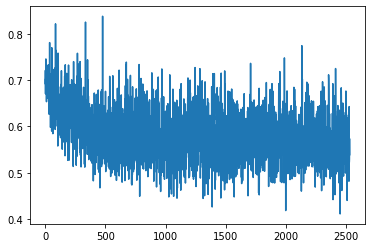

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7fc34976f268> (for post_run_cell):


NotebookValidationError: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01~\x00\x00\x00\xf8\x08\x06\x00\x00\x00\xebD\x8d\x8d\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.2.1, http://matplotlib.org/\xa3\xf2:\xda\x00\x00 \x00IDATx\x9c\xed\xbdy\x98\\gu\xe7\xff=\xb5\xaf\xdd\xd5U\xd5-\xa97\xb5Vk\xb3\xd4\xb2e\x81\x81\xb0$\x831I\xc6\x84\x01\x8c\x05d\x80\x00&,\xc9d\x8f\'3!\x84\x0c\xf9e\x92@2,\x13\x02\x84\x1d\xdb1\xc6C\xec\x89\x89\xe1\x19\x12 `\x1b\xc9\xb6Z[\xdbjY\xeaVW\xab\xa5^j_\xba\xd6\xf7\xf7\xc7\xad[]]]\xcb\xad\xaa[\xfb\xf9<\x8f\x1e\xa9n\xdd\xaaz\xaf\xaa\xfb[\xa7\xce{\xce\xf7\x90\x10\x02\x0c\xc30L\xef\xa0i\xf5\x02\x18\x86a\x98\xe6\xc2\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xa1k\xf5\x02\nq\xbb\xddbbb\xa2\xd5\xcb`\x18\x86\xe9(\x9ey\xe6\x99\x15!\xc4\xa0\x92s\xdbN\xf8\'&&p\xea\xd4\xa9V/\x83a\x18\xa6\xa3 \xa29\xa5\xe7r\xaa\x87a\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16\xfe.az1\x88\xa7.\xaf\xb6z\x19\x0c\xc3t\x00,\xfc]\xc2\'\xbew\x11\xbf\xf9\xc0s\xe0\xf9\n\x0c\xc3T\x82\x85\xbfKX\t\xc7\xb1\x14\x8a\xe3Z`\xad\xd5Ka\x18\xa6\xcda\xe1\xef\x12\xbc\x91\x04\x00\xe0\xd99_\x8bW\xc20L\xbb\xc3\xc2\xdf%\xf8\xb2\xc2\xff\xdcU\x7f\x8bW\xc20L\xbb\xc3\xc2\xdf\x05\xc4Si\x84\xe2)\x00\xc0s\xf3\x1c\xf13\x0cS\x1e\x16\xfe.\xc0\x17I\x02\x00\xfa\xcdz\x9c_\x08"\x9eJ\xb7xE\x0c\xc3\xb43,\xfc]\xc0j$\x0e\x00x\xcdM\x83H\xa438\x7f-\xd8\xe2\x151\x0c\xd3\xce\xb0\xf0w\x01r\xc4\xff\xf3\xfb\xb7\x00\xe0<?\xc30\xe5a\xe1\xef\x02\xe4\x88\x7f\xffV;F\x1cf<w\x95\xf3\xfc\x0c\xc3\x94F\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfb\x8a\xdc\xff7Dt:\xfb\xe7"\x11\xf9\x0b\xee\xef#"\x0f\x11}F\xad\x853\xeb\xc8\xa5\x9cN\xab\x01G\xc7\x1d\x1c\xf13\x0cS\x96\x8a\xc2ODZ\x00\x9f\x05\xf0z\x00\x07\x00\x9c \xa2\x03\xf9\xe7\x08!~[\x081)\x84\x98\x04\xf0i\x00\x8f\x14<\xcd\x9f\x01\xf8\x91:Kf\n\xf1E\x12 \x02\x1c\x16\x03\x8e\x8e\x0f`\xc1\x1f\xc3\x8d 7r1\x0cS\x1c%\x11\xffq\x00\x97\x84\x10\x97\x85\x10\t\x00\x0f\x02xC\x99\xf3O\x00x@\xbeAD\xb7\x02\xd8\x02\xe0{\xf5,\x94)\xcdj$\x01\x87Y\x0f\xad\x86pt\xdc\x01\x80\xf3\xfc\x0c\xc3\x94F\x89\xf0\x8f\x00\x98\xcf\xbb\xed\xc9\x1e\xdb\x04\x11m\x07\xb0\x03\xc0\x0f\xb2\xb75\x00>\x01\xe0\xf7\xca\xbd\x00\x11\xddKD\xa7\x88\xe8\xd4\xf2\xf2\xb2\x92u3yx#\t8\xad\x06\x00\xc0\xc1\xe1>\x18\xb4\x1a\xae\xe7g\x18\xa6$jo\xee\xde\x03\xe0a!\x84\\H\xfeA\x00\x8f\x0b!<\xe5\x1e$\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0\xa0\xcaK\xea~\xbc\x91\x04\\V#\x00\xc0\xa8\xd3\xe2\xe0H\x1f\x9e\x9b\xe3\x88\x9fa\x98\xe2\xe8\x14\x9c\xb3\x00`,\xef\xf6h\xf6X1\xee\x01\xf0\xa1\xbc\xdb\xb7\x03\xf89"\xfa \x00\x1b\x00\x03\x11\x85\x85\x10\x9b6\x88\x99\xda\xf1F\x12\xd89h\xcd\xdd>:6\x80\xfb\x7f6\x87d:\x03\xbd\x96\x0b\xb7\x18\x86\xd9\x88\x12U8\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93\xf21!\xc4\xdb\x85\x10\xe3B\x88\tH\xe9\x9e\xaf\xb1\xe8\xab\x8f\x94\xea1\xe6n\x1f\x1dw`-\x99\xc1\x0b\xd7C-\\\x15\xc30\xedJE\xe1\x17B\xa4\x00|\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xf2N\xbd\x07\xc0\x83\x82\r\xe1\x9bJ&#\xe0\x8b&\xe0\xca\xe6\xf8\x01\xe4m\xf0r\x9e\x9fa\x98\xcd(I\xf5@\x08\xf18\x80\xc7\x0b\x8e}\xa4\xe0\xf6G+<\xc7W\x00|\xa5\xaa\xd51\x15\t\xc4\x92\xc8\x08\xe46w\x01`\xc4a\xc6\x90\xdd\x88g\xaf\xfa\xf1\xab\xb7\xb7pq\x0c\xc3\xb4%\x9c\x00\xeepV\xf3\x9a\xb7d\x88(\xdb\xc8\xc5\x11?\xc30\x9ba\xe1\xefp\xbcE\x84\x1f\x00\x8e\x8e\x0f`v5\x9a\xbb\x9fa\x18F\x86\x85\xbf\xc3))\xfccR\x9e\xff4\xd7\xf33\x0cS\x00\x0b\x7f\x87SJ\xf8\x0f\x8f:\xa0\xd5\x10\x9e\xe5z~\x86a\n`\xe1\xefp\xbcYg\xceB\xe17\x1b\xb4\xd8\xbf\xcd\xce\x1d\xbc\x0c\xc3l\x82\x85\xbf\xc3\xf1F\x92\xb0\x1a\xb40\xe9\xb5\x9b\xee;:6\x80\xa9\xf9\x00\xd2\x19\xae\xb0e\x18f\x1d\x16\xfe\x0e\xc7\x1b\x89c\xa0 \xda\x97\xb9e\xbb\x03\xe1x\n\x97\x96\xc2M^\x15\xc30\xed\x0c\x0b\x7f\x87\xb3\x1a\xd9\xd8\xbc\x95\xcf\xd1\xb1\x01\x00\xc0\xb3\\\xd6\xc90L\x1e,\xfc\x1d\x8e/\x9a\xd8\x94\xdf\x97\xd9\xee\xb2`\xc0\xa2\xe7z~\x86a6\xc0\xc2\xdf\xe1x\xc3\x89\x92\xa9\x1e\xa9\x91k\x80\xbd\xf9\x19\x86\xd9\x00\x0b\x7f\x07#\x84(\x9b\xea\x01\x80[\xc6\x1d\x98Y\n#\x10K6qe\x0c\xc3\xb43,\xfc\x1dL,\x99F<\x95\xd9\xe0\xccY\xc8\xd1q)\xcf?5\xcfQ?\xc30\x12,\xfc\x1d\xccjXj\xde*\x17\xf1\x1f\x1e\xed\x07\x11\x8fbd\x18f\x1d\x16\xfe\x0eF\xee\xda-\x95\xe3\x07\x00\xbbI\x8f\xbdC\xdc\xc8\xc50\xcc:,\xfc\x1d\x8c7Z\xdc\xae\xa1\x90[\xb6;\xf0\xdcU?2\xdc\xc8\xc50Ma)\xb8\x86\xbf\xff\xe1\x8bh\xd7\xf1$,\xfc\x1d\x8cWA\xaa\x07\x90\xea\xf9\x03\xb1$\xae\xacF\x9a\xb1,\x86ik\xae\x07\xd6\xb0\x14\\k\xe8k<\xf2\xdc\x02\xfe\xbf\xef>\xdf\xb6\xcd\x93,\xfc\x1d\x8c\x92T\x0f\x90?\x91\x8b\xf3\xfc\x0c\xf3\x9b\x0f<\x87\xdf\xfd\xd6TC_c.\x1bd\xb1\xf03\xaa\xb3\x1aI@\xaf%\xf4\x99\xca\x0fR\xdb5h\x83\xdd\xa4\xe3F\xae:\xf9\xd6\xa9y\x9c\xe6\xea\xa8\x8eF\x08\x81\xf3\xd7\x02\xb8x\xa3\xb1\xf3\xa8gW\xa2\x00X\xf8\x99\x06\xe0\x8b$0`1\x80\x88\xca\x9e\xa7\xd1\x10&\xc7\x1cx\x96#\xfe\x9a\x11B\xe0#\xfft\x1e_\xfd\xe9l\xab\x97\xc2\xd4\xc1\xb5\xc0\x1a"\x894n\x04\xe3\x88&R\r{\x9d\xab^I\xf8_\\f\xe1gTf5R\xda\xae\xa1\x90\xa3\xe3\x03x\xe1z\x10\x91x\xe3~\xd8\xbb\x19o$\x81X2\x8d\x95p\xbc\xd5Ka\xea`&/\xd2\x9f[\x8d6\xe45\xd6\x92i\\\x0b\xc4\x00\x00\x97X\xf8\x19\xb5\xf1F\xe2U\x08\xbf\x03\x19\x01\x9c\xf1\x04\x1a\xbc\xaa\xeed\xc1/\xfd"\xcb\xbd\x13Lg\x92\x9fz\x99kP\xb1\x83\xc7\x17\x85\x10R\xd1\xc5\x8bK\x91\xb6\xac\xa6c\xe1\xef`|\xd1\xa4r\xe1\xcf\x8eb\xe4z\xfe\xda\xf0\xf8\xb2\xc2\x1f\xe1\x88\xbf\x93\x99\xb9\x11\x86\xcd(\xed\x89\xcd6(\xe2\x97\xf3\xfb\xaf\xd97\x84X2\x8d\xc5\x06W\x10\xd5\x02\x0b\x7f\x07\xb3\x1aV\x1e\xf1;,\x06\xec\x1c\xb4\xf2(\xc6\x1a\xf1\xf8\xa4_\xe6\xd5p\xa2-#8F\x193K!\x1c\x1a\xe9\x83\xcbjhX\xc4?\x97\xcd\xef\xff\x87\xfdC\x00\xdas\x83\x97\x85\xbfCI\xa63\x08\xae\xa5\x14\x0b? \xd5\xf3\x9f\x9e\xf7\xb5mS\x89\xcc\xc9Y/\x96B\xed\x15%\xc9\x11\x7f*#\x10\\c\xc3\xbbND\x08\x81\x99\xa50\xf6\x0c\xd9\xb1\xdde\xc1\x95\x95\x06\t\xffj\x04v\x93\x0e\xc7&\x9c\x00X\xf8\x19\x15\xf1E\x955o\xe5st\xdc\x81\x95p"\'b\xed\xc8\xe3g\x17\xf1\x96\xcf=\x89\xcf\xff\xf0r\xab\x97\xb2\x81\xfc\xff\xb3\x15\xce\xf3w$K\xa18Bk)\xec\xd9b\xc3\x84\xcb\xda\xb0\xcd\xdd\xd9\xd5(\xb6\xbb,pY\rpX\xf4,\xfc\x8cz(m\xde\xcaGn\xe4j\xd7\x89\\\xcf\xcc\xf9\xf0\xdb\xffx\x1a\x80\xf4K\xdaNx|Q\xd8\xb3\xb9\xe1\xd5\x06V\xf6d2\x02\xb1D\xbaa\xcf\xdf\xcb\xcc\xdc\x90\x04x\xf7\x90\r\xdb]V,\x06\xd6\xb0\x96T\xff\xffzn5\x82\xed.+\x88\x08\xbb\x07mmY\xd2\xc9\xc2\xdf\xa1\xc8v\r\xd5\xa4zn\xdab\x87\xc5\xa0m\xcb\x0e\xde\xd9\x95\x08\xde\xf7\xb5S\xd8\xd6o\xc2\xee![\xee\x83\xad\x1d\x10B\xc0\xe3\x8b\xe1\xe6\xd1~\x00\x8d\x8d\xf8\xbf\xf0\xe3\xcbx\xe5_\xfd+\x8b\x7f\x03\x98Y\x92J9\xf7\x0c\xd91\xe1\xb6\x00P\xbf\xa43\x99\xce`\xc1\x17\xc3\x84Kz\xfe\xddC6\xbc\xc8\x11?\xa3\x16\xde\\\xaa\xa7\xb4\x17\x7f!:\xad\x06\x87G\xfb\xdb\xae\x83\xd7\x17I\xe0\xdd_9\t!\x04\xbe\xfc\xee\xe3\x98pY\xb0\xdaF\xc2\xef\x8b&\x11M\xa4q$[\x19\xd5\xc8\xca\x9e\x99\xa50\x96Cq\xfc\xf3\xd9\xc5\x86\xbdF\xaf2\xb3\x14\x86\xc3\xa2\x87\xdbf\xc0\x84\xcb\n\x00\x98Uy\x83\xf7\x9a?\x86TF`{\xf6\xf9w\r\xda\xb0\x1aI\xc0\xd7F?\xcf\x00\x0b\x7f\xc7"G\xc4\xd5D\xfc\x80\xd4\xc8u\xfeZ\xb0!_qka-\x99\xc6\xbd_?\x85\x05\x7f\x0c_\xf8\xcf\xc7\xb0\xc3m\x85\xd3j\x80\xb7\x8d\xca&\xe5\x8a\x9e\xc3#\xd2l\x83FF\xfc\xcb\xd9\x14\xd7\xfdO\xcf5\xec5z\x95K7\xc2\xd8;d\x07\x11\xe5\x84_\xed\xca\x1e\xb9Dt\xbbs=\xe2\x07\xda\xaf\x83\x97\x85\xbfC\x91\x1b\x89\x1c\x16}U\x8f;:\xe6@*#pn\xa1\xf5\x8d\\\x99\x8c\xc0\xef?|\x06\'g}\xf8\xe4\xddGrU\x10N\xab\x11\xdeH\xa2m\xaa\x8f\xe4\x8d\xddq\x97\x05N\x8b\xa1\xa19\xfe\xe5P\x1cD\xc0\xb3W\xfdx\xfez\xb0a\xaf\xd3k\x08!pq)\x84\xdd[$!\xee\xb7\xe81`\xd1\xab^\xcb/\x7f\x90L\xb8\xa5\x0f\x16Y\xf8\xdbm\x83\x97\x85\xbfC\xf1F\x12\xe87\xeb\xa1\xd7V\xf7\x16\xca\xa3\x18\xdb!\xcf\xffW\xdf{\x01\x8fM]\xc3}\xaf\xdf\x87_><\x9c;\xee\xb2\x1a\x90L\x0b\x84\xdb\xc4^B\x8e\xf8G\x07,p\xd9\x0c\r\xb5mX\t\xc7\xf1\xda\xfd[`\xd0j\xf0\xe0\xcf\xe6\x1b\xf6:\xbd\xc6j$\x01\x7f4\x89=Y!\x06\x80\xed.+fU.\xe9\x9c[\x8d\xc2\xa4\xd7`\xc8.\xa5`G\x1cf\x18u\x1a\x16~F\x1d\xbc\xd1\xf2C\xd6K1h7b\xcciny\x07\xef\xfdO_\xc5\xdf\xfd\xdb\x8bx\xdbK\xc6\xf1\xfeW\xee\xdcp\x9f\x9c\xbej\x97\r^\x8f/\x06\xbbI\x87~\xb3\x1e.\xab\xb1a\xb6\r\x99\x8c\xc0j$\x81\x9b\xb6\xdaq\xe7\xa1\xadx\xe4Y\x0fo\xf2\xaa\x84\\\xd1\xb3g\xc8\x9e;6\xe1\xb2\xa8\xbe\xb9;\xb7\x1a\xc1D\xb6\xa2\x07\x90\x0c\x12w\xb6ae\x0f\x0b\x7f\x87\xe2\r\'\xaa*\xe5\xcc\xe7\xe8\xd8@K#\xfe\x7f{a\t\x7f\xfcO\xe7\xf0\xea\x9b\x06\xf1\xb1\xbb\x0enr\x17u\xda\xa4\xebj\x97\r\xde\x05_\x0c\xa3\x03R\xce\xd6m76l]\xbeh\x02\xe9\x8c\x80\xdbf\xc4\x89\xe3\xe3\x08\xae\xa5\xf08o\xf2\xaa\xc2%\xb9\xa2g\xcb\xc6\x88\xffZ \xa6\xea~\xd7\xecj\x14\xe3\xd9\xfc\xbe\xcc\xee![\xdb\x99\xb5\xb1\xf0w(\xde*\x9c9\x0b\xb9e\xdc\x81\xc5\xc0\x1a\x16\x03\xcdo\xe4\xbap-\x88\x0f}\xf3Y\xdc\xb4\xc5\x8e\xcf\xbc\xed\x16\xe8\x8a\xa4\xaa\xe4o2\xde6i\x94\xf2\xf8b\x18\x1d0\x03\x90\xd6\xd6\xa8T\xcfr\xf6y\x07\xedF\xbct\xa7\x13;\xdcV<\xf0\xb3\xab\ry\xad^\xe3\xe2\x8d0\xec&].\x05\x03\x00;\xdcV\x08\xb1\x9e\xca\xab\x97LF\xe0\xaa7\x9a\xcb\xef\xcb\xec\x1e\xb4\xc1\xe3S\xf7\x03\xa6^\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc8\xfd\x7fCD\xa7\xb3\x7f.\x12\x91?{|\x92\x88\x9e$\xa2\xf3Dt\x86\x88\xde\xaa\xf6\x05\xd4\xc3\xa5\xa5\x10~\xef[SH\xa63\xad^J\xd5\xd4\x9a\xea\x01Z\x97\xe7_\x0c\xc4\xf0k_9\x89>\xb3\x1e_z\xd7m9\xb3\xacB\x06,\xed\x93\xea\x91j\xf8\xa39\xe1w\xdb\x0c\x08\xad\xa5\x1a\xf2K,W\xf4\x0c\xda\x8d "\x9c8>\x86Ss\xbe\x86\x0f\r\xe9\x05f\x96B\xd83d\xdb\xf0\xedr{\xb6\xd6\xfe\xca\x8a:\xc2\x7f=\xb8\x86D*\x93{^\x99]C\xd2\x07L;\xa5{*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\xe4\x9f#\x84\xf8m!\xc4\xa4\x10b\x12\xc0\xa7\x01<\x92\xbd+\n\xe0?\x0b!\x0e\x02\xb8\x13\xc0\xdf\x12\x91C\xcd\x0b\xa8\x87G\x9e]\xc0\xc3\xcfxT\xdf\xe0i4B\x08i\x08K\x8d\xc2\xbf\x7f[\x1f\x0c:MS\xeb\xf9CkI\xbc\xfb\xcb\'\x11\x8e\xa7\xf0\xa5w\xdd\x86\xad\xfd\xa6\x92\xe7\xba\xda(\xd5\xe3\x8f&\x11I\xa4s\xa9\x1e\x97M\x8a\x18\x1b\xf1\xa1$\x7f\x93pg_\xe3M\xb7\x8c\xc2\xa0\xd5p\xd4\xaf\x02\x97\xb2\x1e=\xf9\xa8]\xd2)\xf7\x04\xc8\xcf+\xb3^\xd2\xd9>:\xa3$\xe2?\x0e\xe0\x92\x10\xe2\xb2\x10"\x01\xe0A\x00o(s\xfe\t\x00\x0f\x00\x80\x10\xe2\xa2\x10b&\xfb\xefk\x00\x96\x00\x0c\xd6\xb7d\xf5\x98\xf2H\x11\xef\xb5@{\x19\x82U"\x18K!\x95\x115G\xfc\x06\x9d\x067\x8f\xf47-\xe2O\xa63\xf8\xd0\xfd\xcfaf)\x8c\xff\xfd\xf6[\xb0\x7f[_\xd9\xf3-\x06\x1dLzM[\xd4\xf2\xcb\xa5\x9c\xeb\x11\xbf$\xca\x8d\xd8\xe0\xcd\x8f\xf8\x01\xe9C\xe6u\x87\xb6\xe2\xdb\xcfx\xda*M\xd0ix#\t\xac\x84\x13\x1b\xf2\xfb\x80T\n\xddg\xd2\xa9\xd6\xc4%o\x14\x17\xe6\xf8w\xb8\xad\xd0P{\x95t*\x11\xfe\x11\x00\xf9ue\x9e\xec\xb1M\x10\xd1v\x00;\x00\xfc\xa0\xc8}\xc7\x01\x18\x00\xbcX\xe4\xbe{\x89\xe8\x14\x11\x9dZ^^V\xb2\xee\xba\xc9dDn(\xc95\x7f\xfb\x9a\x96\x15C\xee\xda\xad5\xc7\x0fHy\xfe3\x0b\x01$R\x8dMs\t!\xf0\xc7\xdf9\x87\x1f]\\\xc6\x9f\xbf\xf1\x10^\xb9W\xd9\xe7\xbe\xcb\xda\xb8M\xd4jX/\xe5\xcc\xe6\xf8\xb3\xdfFV\x1a\xf0\xa1\xb4\x1c\x8a\xc3\xa4\xd7\xc0j\xd0\xe6\x8e\x9d8>\xc6\x9b\xbcu"\x0b\xee\xee\xa1\x8d\xc2OD\xd8\xe1\xb6\xe6\xfc\xf3\xebev5\x02\xbd\x960\xec0o8n\xd4i1\xee\xb4\xb4\x95u\x83\xda\x9b\xbb\xf7\x00xX\x08\xb1!<!\xa2m\x00\xbe\x0e\xe0\xddB\x88MJ#\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0`s\xbe\x10\xcc\xaeF\x10Z\x93\xea\xc4;N\xf8\xb3\xa2Sk\xaa\x07\x90\xf2\xfc\x89T\x06\xd3\x8b\x8dm\x12\xfa\xc6Ssx\xf0\xe4<>\xfc\x9a\xddx\xebm\xe3\x8a\x1f\xe7\xb4\x1a\xda\xa2\xcd=\x17\xf1;\xb2U=Y\x8b\x8c\x95\x06\x98\xc8\xad\x84\x13\xb9\xfc\xbe\xcc\xed;]\x98pY8\xddS\x079\x8f\x9e-\xf6M\xf7mwYU\x8b\xf8\xaf\xaeF1\xe6\xb4@\xab\xd9<\x03{W\x9b\x95t*\x11\xfe\x05\x00cy\xb7G\xb3\xc7\x8aq\x0f\xb2i\x1e\x19"\xea\x03\xf0\xcf\x00\xfe\x9b\x10\xe2\xa9Z\x16\xd9\x08\xe4h_\xab\xa1\xdcX\xbdNAN3\xd4\x9a\xea\x01\x9a\xe7\xd4\xf9\xd8\xd4"\x0e\x0e\xf7\xe1w\xef\xd8[\xd5\xe3$\xdb\x86v\x10~\xc9\x95\xb3\xcf,mD7r\xffa9\x14\xc7\xa0m\xa3\xf7\x92\xb4\xc9;\x8e\x93\xb3\xbe\r\xf3b\x19\xe5\xcc\xdc\x08\xc3j\xd0b\xb8\xc8\xbe\xd2\x84\xcb\x82k\xfe\x18\xe2\xa9\xfaSi\xb3\xab\xd1M\xf9}\x99\xddC6\\^\x89 \xdd&C|\x94\x08\xffI\x00{\x88h\x07\x11\x19 \x89\xfb\xa3\x85\'\x11\xd1>\x00\x03\x00\x9e\xcc;f\x00\xf0\x7f\x00|M\x08\xf1\xb0:KV\x87)\x8f\x1f&\xbddZ\xd6i\x11\xbfO\x85T\xcf\xb6~3\xb6\xf4\x19qz\xbeqy\xfeT:\x83\xb3\x0b\x01\x1c\xdf\xe1\xdcT\xab_\t\x97\xd5\xd0&\xa9\x9e\x18F\x06\xcc\xb9\xf5[\x8d:\x98\xf5\xda\x86\xd86,\x87\xe2\xb9=\x84|\xdet\xeb(\xf4Z\xc2\x03\xdc\xc9[\x13\x97\x96\xc2\xd8]P\xd1#3\xe1\xb6"#P\xf7\x8c\n!D\xd6\x8e\xd9R\xf4\xfe]C6$R\x19\xcc{\x1b3\x03\xa0Z*\n\xbf\x10"\x05\xe0\xc3\x00\x9e\x000\r\xe0!!\xc4y"\xfa\x18\x11\xdd\x95w\xea=\x00\x1e\x14\x1b\rV\xee\x06\xf0J\x00\xef\xca+\xf7\x9cTq\xfd535\xef\xc7\xcd#\xfd\x18wZp\xcd\xdfY\x9b\xbb\xb2 V\xe3\xccY\x8c\xc91GC\x85\x7ff)\x8cX2\x8d\xc9\xb1\xea\x0b\xb9\xda\'\xe2_o\xde\x92q\xd9\x0c\r\xd9\xdc]\t\xc7s\x1b\xbb\xf9\xb8mF\xdcqp+\xbe\xfd,o\xf2\xd6\xc2\xccR\x08\xbb\x876\xa7y\x00\xe4\\4\xeb\xad\xec[\x0e\xc7\x11M\xa4s\xe6l\x85\xec\x1al/\xcf\x1eE9~!\xc4\xe3B\x88\xbdB\x88]B\x88\x8fg\x8f}D\x08\xf1h\xde9\x1f\x15B\xdcW\xf0\xb8o\x08!\xf4r\xa9g\xf6\xcfiu/\xa1z\x92\xe9\x0c\xce_\x0b\xe2\xf0\xa8\x03\xc3\x0e3\x16\x03\xb1\x8e\x9a\xa3\xea\r\'`\xd2k`\xce\xdb\x04\xac\x85\xc9\xb1\x01\xcc\xadF\x1b&\xb0S\xd9\x0f\x95#\xa3\xd5\x0b\xff\x80\xd5\x80h"\xddR\xa1+\xac\xe1\x97q\xd9\x8c\xb9f+\xb5H\xa53\xf0F\x13E\x85\x1f\x00\xdev|\x1c\x81X\x12\xffr\xee\xba\xaa\xaf\xdb\xed\x04bI\xdc\x08\xc6\xb1\xb7\xa0\xa2GF\xf6\xcd\xaf\xd7\xac\xed\xaa\xec\xca\xe9.\x9d\xea\x01\xda\xa7\x96\xbf\';w/\xde\x08!\x9e\xca\xe0\xf0h?\x86\x1df$\xd3\xa2\xa1\xc6[j\xe3\x8d$\xea\x8e\xf6\x01\xe4"\xf1\xa9\x06E\xfdS\x1e?\xfa\xcd\xfa\x92_\x7f\xcb!\xef_\xb42\xdd\xb3^\xc3\xbfQ\xf8\xddV\xf5#~\xc9\x8d\x14ES=\xc0\xfa&\xef\xfd\xbc\xc9[\x15r\x84]X\xca)\xe3\xb4\x1a`7\xea\xea\xae\xe5\x97?8J\xe5\xf8\xfb\xcdz\x0c\xda\x8d\x9d\x15\xf1w\x1b\xf2\xc6\xee\x91Q\x07F\x1c\xd2\x86O\'m\xf0z\xa3\xb5\xdb5\xe4sx\xb4\x1f\x1a\x02\x9ek\x90\xf0\x9f\x9e\x0f\xe0\xc8\x98\xa3\xea\xfc>\x90g\xd4\xd6B\xdb\x86\xf5\x1a\xfe\x8d\x1f\\n\x9bQ\xf5a,K\x055\xfc\x85h4\x84{\x8e\x8f\xe3gW\xbc9\xdf\x19\xa62\x97\xf2\xa6n\x15\x83\x880\xe1\xb6\xd6\x1d\xf1\xcf\xadF\xa0\xd5\x10F\nJ9\xf3\xd9=\xd8>\x9e==)\xfcS\xf3\xeb\x91\xa8\\s\xdbIy~o\x1d]\xbb\xf9X\x8d:\xec\xddboH\x9e?\x9aH\xe1\xe2\x8d\x10&\xb3\xe3\n\xabe\xbdz\xa6u\xdf\xc4\x16\xfc\x1bk\xf8e\xe4\x1c\xbf\x9a\xf3\x02\x96\x0b\xbav\x8b\xf1f\xde\xe4\xad\x9a\x99\x1ba\x98\xf4\x9a\xb2\x82\xbc\xdde\xa9;\xc7?\xbb\x1a\xc5\xb0\xc3\x04\x83\xae\xb4\xa4\xee\x1a\xb2\xe2\xc5\xa5p[\xcc\x99\xe8M\xe1\xf7\x04px\xb4\x1fD\x94\'\xfc\x9d\x13\xf1\xaf\x86k\xf7\xe9)dr\xcc\x81\xa9y\xbf\xea?\x8c\xe7\x16\x82HgDn\\a\xb58\xb3\xa9,\xb9\x82\xa9\x15\xc8\x11\xff\xd8\xa6\xcd]#R\x19\x81@,\xa9\xdak\xc9}\x01C%"~ \xbb\xc9{\x807y\xaba&[\xd1\xa3)R[/3\xe1\xb2\xc2\xe3\x8b\xd6\xd5\xccx5k\xc7\\\x8e\xdd\x836\x04\xd7R\xaa\xef\x0f\xd5B\xcf\t\x7f,\x91\xc6\xc5\x1b\xa1\xdc\x86c\x9fI\x0f\xbbQ\xd7Q\xa9\x1e\x9fJ\xa9\x1e@\x12\xfe@,\x89+*\xfb\x15\xc9\xfb\x06\x87k\xd8\xd8\x05\xd6S=\x8d\xf2\xbeW\x82\xc7\x17\xdbP\xc3/\xe3\x96\xbbwU\\\x9b\x92\x88\x1f\x00N\x1c\x1f\x87?\x9a\xc4\x13\xe7y\x93W\t\xc5<z\n\x91K:\xeb\xd1\x80\xd9\xd5h\xc5\xbd,\xb9\xb2\xa8\x1d\xf2\xfc=\'\xfc\x17\x16\x03Hg\x04\x0e\xe7\xa5 \x86\x1d\xe6\x8e\x89\xf8\xd7\x92iD\x13i\xf5\x84?\xdb\xc8\xa5v\xba\xe7\xb4\xc7\x8f\x11\x87\xb9d\xce\xba\x12}&\x1dt\x1ajiI\xa7\xc7\x17\xddP\xc3/\xb3\xee\xd7\xa3^\xe4\xb6\x1c\x8a\xc3f\xd4U\xac\xd4z\xd9.\x17\xc6\x9d\x16\xdc\xff4o\xf2V"\x1cOa\xc1\x1f\xdbd\xd5PH\xae\xb2\xa7\xc6\xe0\xc7\x1fM \x10KV\x8c\xf8w\rI\xf7\xb7\x83uC\xcf\t\xff\xd4|vc7/\x051\xec0\xe1Z\x0b\xbc\xe9ka\xb5\xc6!\xeb\xa5\xd83d\x87\xd5\xa0U]\xf8\xa7\xe6\xfd\xb9\x0f\x95Z "\x0c\xb4\xb8\x96\xbfX\r?\xd0\x98\xee]\xd9\xae\xa1\x12\xd2&\xef\x18\x9e\xbe\xe2m\x9b\xd2\xc0v%W\xd1SA\xf8s\xb5\xfc5V\xf6\xcc\x960g+dk\x9f\t6\xa3\xae-\\:{O\xf8=~l\xe93bK\xdfz\xfb\xb6\x14\xf1w\xc6\xe6\xaeOe\xe1\xd7j\x087\x8f\xf6\xab*\xfc+\xe18<\xbe\x18&kL\xf3\xc8\xb4\xb2{W\xaa\xe1\x8fm\xda\xd8\x05\xd6\x1b\xe7\xd4,\x01^\x0e\xadm\xb2k(\xc5[n\x1d\x83NCx\x90K;\xcb"[\\\x14\xf3\xe8\xc9\xc7m3\xc0j\xd0\xd6<\x86\xb1p\xc0z)\x88\x08\xbb\x06\xad\x9c\xeai\x05g<\x81M\rE\xc3\x0e3\xbc\x91DG\xcc7U;\xe2\x07\xa4F\xae\xe9\xc5\xa0j\x1b\x86g\xb2v\xd7\xb5n\xec\xca\xb4\xb2{7\x10K"\x1cO\x15\x15\xfe\x01\x8b\x1eD*\xe7\xf8Cq\xb8\xed\xca\xde\xd3A\xbb\x11w\x1c\xdc\x82\x87\xd9\xae\xb9,\x97\x96\xc20\xe84\x18+\xf2\x1e\xe6\xb3^\xd2Y[$^\xca\x8e\xb9\x18\xbb\x06m,\xfc\xcdF\xde\xc4,\x14$\xb9\xd4\xab\x13\xd2=\xb23\xa7\xba\xc2\xef@2-p\xfe\x9a:N\x9d\xa7\xe7\x03\xd0\x10ph\xa4\xbc\xef~%Z)\xfc\x85>\xfc\xf9\xe8\xb4\x1a8-\x06Us\xfc+\xe1\x84\xe2\x88\x1f\x906y}\xbc\xc9[\x96\x99\xa50v\xba\xadE\xc7{\x162\xe1\xb2\xd6\x9c\xe3\x9f]\x8d`[\xbf\t&}\xe5N\xfa]C6\\\x0f\xae!\x1cO\xd5\xf4Zj\xd1S\xc2\x7f6\xdb\xb8u\xb8\xa0\xb6\xbc\x93J:\xbd\x11\xa9\x84P\xadrN`\xdd\xa9S\xadt\xcf\xd4\xbc\x1f{\xb7\xd8a1\x14\x1f\xad\xa8\x14\x97U]q\xad\x86u\x1f\xfe\xe2Q\x9c\x9a~=\xf1T\x1a\x81X\xb2\xaa\x8d\xf0\x97\xefrc\xccif\xbb\xe62\xcc,\x85*\xa6yd\xb6\xbb,\xf0\xf8b5\x8da\x9d+2`\xbd\x149\xeb\x86\x16G\xfd=%\xfc\xf2\xc4\xad\xc3#\x85\xa9\x1e)\xdf\xdf\x19\xc2\x1f\x87VC\xe83\xe9U{\xce-}&l\xeb7\xa9"\xfcB\x08Ly\xfc5\x19\xb3\x15\xe2\xb4\x1a\x11\\K\xb5d&r\xb9\x88\x1f\x90\xf2\xfcj\xe5\xf8\xe5\x0f\x90J\xa5\x9c\xf9h4\x84{n\x1b\xc7S\x97\xbd\xb8\xcc\x9b\xbc\x9b\x88&R\xf0\xf8b\x157ve&\\V\xa42\xa2&\r\x98+c\xc7\\\x88,\xfc\xadN\xf7\xf4\x96\xf0\xcf\xfb\xb1\xc3mE\xbfe\xa3hn\xe93AC\xc0B\x07l\xf0z#\t\x0cX\xf4e\x1bRjAr\xea\xac\xdf\x9b\xff\xaa7\n\x7f4Yw~\x1f\x00\x9c\xd9\xea\x99V4qy|1\xd8\x8c:\xf4\x9b\x8b\x7f\xc0\xba\xed\xeaM\x08+\x1c\xb9\xa8\x94\xb7\x1c\x1b\x956yOr\'o!\x97\x97#\x10\xa2rE\x8f\x8c\xbc1[\xaduC8\x9e\xc2J8\x8e\xedne\x11\xff\xb8\xd3\x02\x9d\x86Zn\xdd\xd0S\xc2\x7f&\xdb\xb1[\x88^\xab\xc1\x96>SGD\xfc\xaba\xf5\x9a\xb7\xf2\x99\x1cs`\xde\x1b\xab;\xb5r\xba\x0eG\xceB\xe4tV+\xf2\xfc\xb2+g)\x9f!\x97\xd5\xa0Z\xc4/\x0b\x7f5\x11?\x00\x0c\xd9M\xf8\x0f\xfb\xa5M^5\x06\x89t\x13\xe5\xa6n\x15\xa3\xd6Z\xfe\xb9\x12\x03\xd6K\xa1\xd7j0\xe1\xb6r\xaa\xa7Y,\x05\xd7p=\xb8V\xb2\x93t[\x7fg\x08\xbf\x9a]\xbb\xf9\xe4\x9c:=\xf5\xa5{N\xcfK\x03nJ\xd9\xe0V\xc3\x80\xa5uFm\xa5J9e\xdc6\x03Bk)U\x04W\xfe\x00\xa9\xa5\xd9\xedm/\x19\x877\x92\xc0\x13\xe7o\xd4\xbd\x8enb\xe6F\x18z-)v\x86\x1d\xb4\x1ba1h\xab\xae\xec\xa9\xa6\xa2G\xa6\x1d\xcc\xdazF\xf8\xa7r\x8e\x9c\xc5M\xc3:\xa5{w5\xd2\x18\xe1\xbfy\xb4\x1fZ\r\xe1\xf4\xd5\xfa\x84_\x1ep\xa3\xa4\x92\xa2\x12\x8d\x1csX\x0e!\x04\x16J4o\xc9\xb8r\xdd\xbb\xf5\xafM\x8e\xf8\xe5\xeb\xad\x86W\xecvc\xc2e\xc1\xc7\x1e;\x8f\xf3\xd7\x02u\xaf\xa5[\x98Y\nc\x87\xdb\n\xbd\xc2\x9fC"\xc2v\x97\xb5\xeaZ~\xf9\xfcj\xac\xc7w\rI\xafS\x8f7P\xbd\xf4\x8c\xf0\x9f\xf1\xf8\xa1\xd5\x10\x0e\x0e\x17\x17\xfe\x11\x87\x19\xd7\x02km\xe1\x9cW\x0eo\x83\x84\xdfb\x90\x9c:\xeb\xb1hN\xa638w-\xa8J\x9a\x07\xc8\xb3fn\xb2\xf0\x07c)\x84J\xd4\xf0\xcb\xb8\xd5\x14\xfep\x1c\xfdf=\x8c\xba\xea\x07\xebh4\x84\x7fx\xd7m0h5\xb8\xe7\xf3O\xe1\xd4\xac\xb7\xee\xf5t\x03J<z\n\x99\xa8\xc1\xa5sn5\x02\xb7\xcd\x00{\x15\xc5\x16\xbb\x87lHg\x04\xaez[\xd7\xc1\xdb3\xc2\x7f:[bX\xca\x0be\xd8aF"\x95i\x8b9\xaf\xa5H\xa53\x08\xc4\x929\xe7J\xb5\x91\x9d:k\x9dF\xf6\xc2\xf5\x10\x12\xa9\x8c*\x1b\xbb\x80\x94\xea!j~\xc4?\xef+n\xc7\x9c\x8f\x1c\x9d\xaf\xa8`\x1b]j\xe4\xa2Rv\r\xda\xf0\xad\x0f\xbc\x0cn\x9b\x11\xef\xf8\x87\xa7\xf1\xc3\x8b\xcbu\xaf\xa9\x93YK\xa61\xb7\x1a\xa9\xe8\xd1S\xc8v\x97\x15\xf3\xbe(RUT\x91\xcd\xaeFr\x96\x0fJ\xd9=\xd8z\xb3\xb6\x9e\x10~!\x04\xce.\x04J\xa6y\x80\xce\xa8\xe5\xf7\xc7\x92\x10\x02pZ\xd4+\xe5\xcc\xe7\xe8\x98\x03\xc1\xb5\x14\xae\xd4\xd8\xc1(o\xec\xaaQ\xca\tHv\x12\x0e\xb3>\xd7\xb4\xd6,J\r`\xc9\xc7mU7\xd5SM\xf3V1F\x1cf<\xf4\xfe\xdb\xb1\xc3m\xc3{\xbfz\x12\x8f\x9f]\xac{]\x9d\xca\x95\x95\x082\xa2\xf4\xd4\xadRL\xb8,H\xa6\x05\x16\x03\xca\xab\xfb\xe6V\xa3%\xe7\xec\x96b\xe7\xa0\xf4A\xc1\xc2\xdf`\xe4\x12\xc3r\x16\xc1\x9dP\xcb/\xa7<\x9cu\x8aD)rN\x9d5\xe6\xf9\xa7\xe6\xfdpY\re#\xe5jqZ\r\xf0E\xd4\xf3\xbdW\x82\xa7\x9a\x88_\x85\xca\x9e\x95p\x02\xee:"~\x99A\xbb\x11\x0f\xde\xfbR\x1c\x19u\xe0\xc3\xf7?\x8b\x87z\xb4\xccs&g\xceVe\xaa\xc7]\x9dY\xdbZ2\x8d\xc5\xc0Z\xd5\x11\xbf\xd5\xa8\xc3p\xbf\x89\x85\xbf\xd1L\x95\xe8\xd8\xcdG\xb6mh\xe7Z~Y\xf8\xd5\xec\xda\xcdg\xd7\xa0\r6\xa3\xae\xe6F\xae)\x8f\xbf\xe6Q\x8b\xa5pY\xd5\x1fsX\x89J5\xfc\x80\xf4\xcbk\xd6kU\xe9,V#\xe2\x97\xe97\xeb\xf1\xb5\xf7\x1c\xc7\xcbw\xbb\xf1\x07\xdf>\x83/\xfe\xf8\xb2*\xcf\xdbI\xcc\xdc\x08A\xab!L(\xac\xad\x97\x91K2\x95\xe6\xf9\xe7\xbd\xd99\xbbU\xbe\x0e Y7\xb4\xd2\xa5\xb3\'\x84\xff\xcc\xbc\x1fF\x9d\x067m-\x1d\x01\xf4\x9b\xf5\xb0\x18\xb4\x1d\x11\xf1\xcbe\x8ej\xa3\xd5\x10\x0e\xd7\xe8\xd4\x19\x8e\xa70\xb3\x14VmcWf\xc0\xaao\xfa\xe6\xae\\\xcaY\xe9\x03L\r\xdb\x86X"\x8dp<\xa5\xd8\xa0M\t\x16\x83\x0e_|\xe71\xfc\xe2\xcd[\xf1?\xfey\x1a\x9f\xfc\xde\x0bm_\xb4\xa0&37\xc2\xd8\xee\xb2T\xbdY>d7\xc2\xa4\xd7(n\xe2\x9a\xcdU\xf4T\x17\xf1\x03\xd2\x06\xef\x8b\xcb\xe1\x9a\xf7\xd3\xea\xa5\'\x84\x7f\xca\xe3\xc7\xc1\xe1\xbe\xb2\xa5]\xf2\x18\xc6v\x16~y\x93\xb3\x96\xb2?\xa5L\x8e9jr\xea<\xeb\t@\x08\xe0\xc8Xm3vK\xe1\xb4\x1a[ \xfc\xd1\xb23Ze\\6c\xddc\xf4r5\xfc*\xa7\xef\x8c:->}\xe2\x16\xdc}l\x14\x9f\xfa\xc1%\xfc\xe9c\x17Z&2\xcdff)\xa4\xb8c7\x1f\x8d\x860\xe1\xb2\xe6\x9a\xb2*\xb1\xde\xbcUC\xc4?hC4\x91\xc6b\xb05\x19\x86\xae\x17\xfeT:\x83s\x0bAE#\x00\xdb]\xf8}\r\x8e\xf8\x01I\xf8S\x19QuM\xb8\xdc\xf8\xa5v\xc4\xef\xb2\x1a\xe0\x8b&\x9b&Z\xeb5\xfc\x95\x85\xdfm\xad?\xe2_\xaa\xd1\xaeA\tZ\r\xe1\x7f\xbe\xe90\xde\xfb\x8a\x1d\xf8\xcaOg\xf1{\xdf\x9a\xaa\xaab\xa5\x13I\xa42\x98]\x8dV\x9d\xdf\x97\xd9\xee\xb2(\x8e\xf8\xe7V\xa3\xe83\xe9\xe0\xa8\xe1\xf7\xb1\xd5fm]/\xfc\x97\x96\xc3\x88%\xd3\x8a"\xd1\x11\x87\xa9\xeds\xfcv\xa3\x0e\x06]\xe3\xde6y\x83\xf7\xb9*7x\xa7\xe6\xfd\xd8\xee\xb2`@\xe5\xfd\x07\xa7\xd5\x80\xb4\xca\x83\xcd\xcb\xb1^\xc3_9\x8as\xdb\xea\xdf\x7f\xa8\xd5\xaeA)D\x84\xff\xf6K\xfb\xf1\xbb\xaf\xdd\x8bG\x9e[\xc0\x07\xbe\xf9lW{\xf8\xcf\xaeF\x90\xce\x88\xaa+zd&\\V\\]\x8d"\xad \xd0\x98]\x8dT\x1c\xbeR\x8aV\x9b\xb5u\xbd\xf0\x9f\x99\x977v\x15D\xfc\xfdf\xac\x84\xe3m\xfb\x8b\xb1\x1aI\xe4\x8c\xcb\x1a\xc5\x90\xdd\x84\x11\x87\xb9\xea<\xff\xe9y\xbf\xea\xd1>\xd0\xfc\xee]%5\xfc2r\x8e\xbf\x9e\xfc\xb9\x9c\xea\x19j@\xc4/CD\xf8\x8d_\xd8\x83\x8f\xfe\xc7\x03\xf8\xfe\x85\x1b\xf8\xb5\xaf\x9cl\xb9\x1f|\xa3\x98\xb9!\ti\xb55\xfc2\xdb]V$\xd2\x19,*\x98\xcd1\xb7\x1a\xad)\xbf\x0fH\xdfd\x1d\x16}\xcb\xac\x1b\xba^\xf8O{\xfc\xb0\x1bu\xd8\xa1\xe0\r\x92k\xf9\xafWQ\xc7\xdbL|\r\xea\xda-Dr\xeaT.\xfc7\x82kX\x0c\xac\xa9\xd6\xb8\x95O\xb3\xbbw\x17\xfc\x95k\xf8e\\6#Ru~\x1bY\x0e\xc5A\xa4\xee`\x9dR\xbc\xeb\xe5;\xf0\x89\xb7\x1c\xc1\xd3W\xbcx\xfb\x17\x9fn\xda\xb7\xa8f2\xb3\x14\x02\x91\x94C\xaf\x05\xb9B\xa7\x92uC2\x9d\xc1\x82?VS~\x1f\x90\xc70\xb6n\x1aW\xd7\x0b\xff\x19\x8f\x1f\x87\xc7\xfa\x15\xd9\x18\xb7{\x13\xd7j$\x01g\x03\xf3\xfb2\x93c\x0ex|1\xc55\xeaS\xb9\xc6-u7v\x81\xe6\x0b\x7f%\x1f\xfe|\xdc\xb9Z\xfe\xda\xd7\xb6\x1c\x8e\xc3i1\xa8\xe2m\xa4\x847\xdd:\x8a\xbf{\xfb-\xb8p-\x80\x0f}\xf3\xd9\xae\xcb\xf9\xcf,\x851\xee\xb4(\x9a\x86U\x0c\xb9\xa4\xf3J\x85\x92\xce\x05_\x0c\xe9\x8c\xa8\xca\x9c\xad\x90\xdd\x83\xb6\x96\xcdR\xe8j\xe1_K\xa6\xf1\xfcbHQ\x9a\x07\xc8\xaf\xe5oO\xe1\xf7F\xe2\xcd\x89\xf8\xabl\xe4\x9a\xaa\xe0\x83T\x0f\xf2`\xf3\xe6\t\x7f\x14V\x83\x16\x0e\x05\xdd\xd1\xeb~=\xb5\xe7\xf9WB\xf5\xd95\xd4\xc2\x1d\x07\xb7\xe2\xe3o\xbc\x19\xff~i\x05\x7f\xf6\x7f/4\xf5\xb5\x1b\xcd\xa5\x1b\xd5{\xf4\xe4\xb3\xb5\xcf\x04\x83NS\xb1\xb2gV\xe1\x80\xf5r\xec\x1e\xb2a%\x9c\x80\xbf\x05\xf3&\xbaZ\xf8\xa7\x17\x83HeDY\xab\x86|\xb6\xf4\x1bA\x04\\k\xc3\r^!\x84d\xd0\xd6\xe0\x1c?\x00\x1c\x1a\xce:u*L\xf7L\xcd\x07\xb0o\xab\xbd\xe6(\xab\x1c\x03VI\x80\x9be\xdb\xe0\xc9\xbar*iBSc\xffa9\x1co\xd8\xc6n9\xee>6\x86{_\xb9\x13_}r\x0e_\x7fj\xae\xe9\xaf\xdf\x08R\xe9\x0c.\xaf\x84k\xde\xd8\x05\xa4\x92\xce\xed\xce\xca\x95=\xb5\xb8r\x16\xb2k\xa8u\xd6\r]-\xfcg<\xca7v\x01\xa9\xf6y\xd0fT5\xd5#\x84\xc0_|\xf7y<\x7f\xbd\xbeA\xe6\xe1x\n\xc9\xb4hX\xd7n>f\x83\x16\xfb\xb6\xda\x15\t\x7f&#r\x1d\xbb\x8d\xc0\xa8\xd3\xc2f\xd45ms\xb7\x92\x0f\x7f>\xf2\xb7\x91zl\x1b\xea5h\xab\x87?\xbcs\x1f~a\xdf\x10>\xfa\xe8y\xfc\xfb\xccJK\xd6\xa0&s\xde(\x92iQS\r\x7f>\x13\xee\xca\xb5\xfcs\xabQX\x0c\xda\xba\xfa/d\xb3\xb6\x17[\x90\xee\xe9j\xe1\x9f\x9a\xf7c\xd0n\xc4\xb6~\x93\xe2\xc7\x0c;\xcc\xb8\xa6`G_)\xf3\xde\x18>\xf7\xc3\x17\xf1\x8fu\xfa\xa64\xbak\xb7\x10\xa5N\x9dWV#\x08\xad\xa50\xd9\x80\x8a\x1e\x19\xa7\xd5\xd0\xd4T\x8fR\xe1\x1f\xb0\xe8AT{\x8e_\x08!\xd95\xb4H\xf8\xb5\x1a\xc2\xdf\xde3\x89\xdd\x836|\xf0\x9b\xcft\xfc\xec^\xb9\xa2\xa7\x9eT\x0f 5d\xcd\xadF\xcb\xfe\xec\xcf\xadF0\xeeT\xf6\xcd\xb0\x14#\x03f\x18u\x1a\x8e\xf8\xd5f\xca\xe3\xc7\x91\xd1\xfe\xaa\xde\x9ca\x87I\xd5\x1c\xff\x85E)\xd2?\xbfP_\xc4\xdf\x8c\xae\xdd|&\xc7\x1c\x08\xc5S\xb8\xbcR\xfe\x87R\xde\xd8mT\xc4\x0f4O\xf8\x03\xb1$Bk\xcaj\xf8\x01@\xa7\xd5\xc0i1\xd4\x9c\xe3\x0f\xc7SXKfr\x9b\xc4\xad\xc0n\xd2\xe3\x8b\xef<\x06\x9dV\x83\xf7~\xf5\x14\x02\xd1\xce\xad\xf4\xb9\x94\x1d\xb7(\xa7Pje\xbb\xcb\x8ax*\x83\xebe\xbajgW#\x8a\xc7-\x96B\xab!\xeclQeO\xd7\n\x7fh-\x89\xcb+\x11\xc5i\x1e\x99\xe1~\xa9{W-o\x93iY\xf8\xaf\x05\xea\xea>\x95\xbbv\x1b\xe5\xc5_\xc8Q\x85\x8d\\S\xf3~X\r\xda\x9a\xeb\xa6\x95\xe0R\xa1CV\tJ\\9\x0b\xa9\xc7\xafG\xfe\xa6\xd0\xaa\x88_f\xcci\xc1\xdf\xff\xea\xad\x98\xf7E\xf1\xa1\xfb\x9fE\xb2C+}f\x96\xc2\x18\x1d0\xc3b\xd0\xd5\xf5I\xa2?\x1d\x00\x00 \x00IDAT<;*\xb8t\xa63\x02\xf3\xde\x98\xe2\x01\xeb\xe5\xd85hmI-\xbf"\xe1\'\xa2;\x89\xe8\x05"\xbaDD\xf7\x15\xb9\xffo\x88\xe8t\xf6\xcfE"\xf2\xe7\xdd\xf7N"\x9a\xc9\xfey\xa7\x9a\x8b/\xc7\xd9\x05\xc9;\xa6\x9c#g1\x86\x1df\xac%3\xf0\xa9\x14\xf9\xc8\xc2\x1fI\xa4\xab\x9e\xe7\x99\x8f\x1c\xf17\xa3\x9c\x13\x00v\xbam\xb0+p\xea<\xed\t\xe4\xc666\x8afE\xfcJ|\xf8\x0bqY\x8d5\xe7\xf8\xe5\xae\xddA\x9b\xf2Td\xa3\xb8m\xc2\x89?\xef\xf0J\x9f\x99\x1b\xe1\xba\xf3\xfb\xc0\xfa\x86m\xa9Z\xfe\xeb\xc15$\xd2\x99\xba#~@\xaa\xec\xf1\xf8bMo\x1a\xad(\xfcD\xa4\x05\xf0Y\x00\xaf\x07p\x00\xc0\t":\x90\x7f\x8e\x10\xe2\xb7\x85\x10\x93B\x88I\x00\x9f\x06\xf0H\xf6\xb1N\x00\x7f\x02\xe0%\x00\x8e\x03\xf8\x13"\x1aP\xf7\x12\x8aS\xed\xc6\xae\x8c\xda\xb5\xfc\xd3\xd7\x83\xb9\xc1\x0b\xe7\xae\xd5\x9e\xeeY\xf7\xe2o\x8e\xf0k4\x84\xc3c\xe5\x9d:\xe3\xa94\xa6\xaf\x05\x1b\x9a\xe6\x01\xa4k\xf6F\xeb\xeb\x90U\x82,\xfc#\xd5F\xfc5~(\xe5\xec\x1aTt\xe6\xac\x87\xb7\x1c\x1b\xc3\xfb_\xb9\x13_{r\x0e_\x7fr\xb6\xd5\xcb\xa9\x8atF\xe0\xc5\xe50\xf6l\xa9/\xbf\x0f\x00\xdb\xfa\xcd0h5%\xed\x99\xe7\xb2\xc7\xab\x1d\xc0R\x8c\xddC6\x08\x01\\n\xb2E\xb3\x92\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xcc\xf9\'\x00<\x90\xfd\xf7\xeb\x00|_\x08\xe1\x15B\xf8\x00|\x1f\xc0\x9d\xf5,X)S\xf3~\x8c;-U\xd7\xbd\xabY\xcb\x1fZKb\xde\x1b\xc3\x7f<<\x0c\x83VS\xd70l_$\x01\x83N\x03k\x89\xd1\x91\x8d`r\xcc\x81\xe7\xaf\x87\x10K\x14\x8fF\xa6\x17CH\xa43\r\xdd\xd8\x05\xa4o9\x89T\x06\x91\x12\xebP\x0b\x8fO\xaa\xd4\x18\xa8b\xc2\x99\xdbV{\xc4\xdf(g\xcez\xf8\x03\xb9\xd2\xe7\xb1\x0b\x1dU\xe93\xef\x8d"\x9e\xca\xa8\x92r\xd4j\x08cNs\xc9o\xe89;\xe6:j\xf8e\xe4\x0e\xe3f\xa7{\x94\x08\xff\x08\x80\xfc\x92\x14O\xf6\xd8&\x88h;\x80\x1d\x00~P\xcdc\x89\xe8^":ED\xa7\x96\x97\xd5\x99\x17z\xc6\x13\xa8:\xcd\x03\xa8;\x89\xeb\x85\xeb\xd2f\xd3\xe1\xd1~\xec\xdbf\xafk\x83W\xee\xdaUs\xc8I%&\xc7\x06\x90\xce\x08\x9c+\xf1\x81\xd5\x8c\x8d] \xaf{\xb7\xc1y~\xa5>\xfc\xf9\xb8m\x06\x84\xd6R\x88\xa7\xaa\xffPZ\x0e\xc5\xa1\xd5P\xd3*\xb5\x94\xa0\xd5\x10\xfe\xd7\x89\xa3\xb9J\x9fV\x94\x1a\xd6\xc2\xfa\xd4-u\xf6\x9av\xb8\xad%S=s\xab\x11\x18t\x1al\xeb\xab?E\xb7\xc3m\x85\x86\x9a\xef\xd2\xa9\xf6\xe6\xee=\x00\x1e\x16BT\xf5[ \x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0`\xdd\x8bX\t\xc7\xb1\xe0\x8f\xd5d\x1a\xe6\xb4\x1a`\xd4iT\x11~9\xbf\xbf\x7f[\x1f\x0e\x0e\xf7\xe1\xdc\xb5@\xcd\xe9\no\x93|z\xf2\x91g\xe7\x96\xea\xe0\xad\xa5\\\xb6\x16\xd6\x1b\xa5\x1a\xdb\xc4%7oU\x83\xcbV\xfb\xec\xdd\xe5P\x1c.\xabA\x91\x9dH3\xb1\x19\xa5A.\xfal\xa5O\xb3:K\xaf\xacDp\xc7\xdf\xfc\x10\xdf\xa8\xa1\xa1l&[\xd1\xa3V\x91\xc1v\x97\x15\xb3\xab\x91\xa2\xbf\xafs\xabQ\x8c;-\xaa\xbco&\xbd\x16cNK[F\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\x15\xe3\x1e\xac\xa7y\xaa}\xacj\x9c\xc9z\xc3\xd7\x12\xf1\x13\x11F\x1cfU\xbaw/,\x86\xd0o\xd6c[\xbf\t\x07\x87\xfb\xe1\x8f&kN!y#\x89\xa6\x95r\xca\x0c\xda\x8de\x9d:O{$G\xceF\x7f\x0bq6\xc9\xb6a\xa1\x8a\x1a~\x19\xb9\xa1\xae\x16\xe1oe\xf3V%\xc6\x9c\x16|\xeeWo\xc5\x82/\xd6\x94J\x9fx*\x8d\xdfx\xe0Y\\\xbc\x11\xc6\x7f\xff\xce9|\xe6\x073U\x05I\x97n\x84\xb1\xad\xdf\x04\xbbIy\x9a\xae\x1c\x13.\x0b\xd6\x92\x19\xdc\x08n\x0e6fW#\xaa\xe4\xf7ev\x0f\xda\xda2\xe2?\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93y\x87\x9f\x00p\x07\x11\rd7u\xef\xc8\x1ek(S\xf3\x01h\x0884R\x9bw\x8cZM\\\xd3\x8bA\xec\xdbj\x07\x11\xe5\xd6r\xae\xc6t\x8f7\x92hIJ`r\xbc\xb8Sg \x96\xc4\xe5\xe5HC\x8c\xd9\n\xc9\x89k\x03\x85?\x10K"\xb8\x96\xaaZ\xf8\xe5!\xe9+5|\x1bi\x95]\x83Rn\x9bp\xe2\xcf\xff\xd3\xcd\xf8\xc9\xa5U\xfc\xe9c\xe7\x1b\xfaZ\x7f\xf1\xdd\xe7qn!\x88\xcf\xbd\xe3\x16\xbc\xf1\xe8\x08\xfe\xfa{\x17\xf1\xe7\x8fO+\x16\xff\x99\xa5\xb0\xaa%\xc5\xa5\x06\xaf\x0b!\xea\xb2c.\xc6\xae!\x1b.\xafD\x14\xcd\x00P\x8b\x8a\xc2/\x84H\x01\xf80$\xc1\x9e\x06\xf0\x90\x10\xe2<\x11}\x8c\x88\xee\xca;\xf5\x1e\x00\x0f\x8a\xbcwJ\x08\xe1\x05\xf0g\x90><N\x02\xf8X\xf6XC\x99\xf2\xf8\xb1g\xc8\x0e\xab\xb1\xb6z\xdea\x87\xa9\xeeTO:#\xf0\xc2\xf5\x10\xf6o\xeb\x03\x00\xec\xdbj\x87VC5o\xf0\xb6"\xd5\x03\x00G\xc7\x1cX\xf0\xc7\xb0\x14\xda\xf8\r\xe8l\xb6j\xaa\xd1\xf9}\xa09\x0e\x9d\x0b5\x94r\x02\x80\xdbZ{\xaa\xa7\x15\x06m\xd5\xf2\xe6[G\xf1\xfeW\xed\xc47\x9e\xba\x8a\xaf\xfet\xb6!\xaf\xf1\xfd\x0b7\xf0\xe5\x9f\xcc\xe2\xdd/\x9f\xc0\x9d\x87\xb6\xe1\x13o9\x82w\xde\xbe\x1d_\xf8\xf1\x15\xfc\xe1\xb7\xcfTt\x10\xcdd\x04.-\xd5g\xceV\x88\\\xaaYh\xdd\xb0\x1c\x8a#\x96L\xd74`\xbd\x14\xbb\x07mH\xa42\xb9>\x92f\xa0H\x19\x85\x10\x8f\x03x\xbc\xe0\xd8G\nn\x7f\xb4\xc4c\xbf\x04\xe0K5\xae\xafj\x84\x108\xe3\t\xe0\x17\xf6\r\xd5\xfc\x1c\xc3\x0e3\x96Bq$R\x99\x9a\xa7]\xcd\xadF\x10K\xa6q +\xfc&\xbd\x16{\x86l8\xb7P\xbd\xf0\xc7S\xd2@\xeef\xf8\xf4\x14\x92\x9f\xe7\xbf\xe3\xe0\xd6\xdcqy\xd4\xe2\xe1\x91\xc6\x0b\xbf\xc5\xa0\x85Q\xa7i\xa8\xf0\xd7\xd2\xbc\x05\xac\xef?T[\xd9#\x84\xc0r\x1b\xa7z\xf2\xf9\x83\xd7\xed\xc3\x8bK\x11\xfc\xe9c\xe7\xb1\xa5\xcf\x88;\x0fmS\xed\xb9\x17\x031\xfc\xfe\xc3S88\xdc\x87\xfb^\xbf\x0f\x80TJ\xfc\xd1\xbb\x0e\xa2\xdfb\xc0\xa7\xfe\xdf\x0c\x82\xb1\x14\xfe\xd7\x89\xc9\x92\xc3\xd3\x17\xfc1\xc4\x92i\xec\xad\xc3\x9c\xad\x90m\xfd&\xe8\xb5\x84++\x1b\xc5x\xce[\xfb\x80\xf5R\xec\xca\x9b\xc6\xa5\xe6\xf3\x96\xa3\xeb:w=\xbe\x18\xbc\x91\x04\x0e\xd7\x11\x89\x0e;\xcc\x10B\x1a0R+\xcfg+z\xe4\x88\x1f\x00\x0e\x0e\xf7\xd7T\xcb\xef\x8bH\xcdd\xcd\xaa\xe1\xcf\xe7\xd0H?tE\x9c:O\xcf\xfb\xb1\xd3mE\x7f\x15\xa5\x8f\xb5BDp5\xb8\x89\xab\x96\xe6-@\xfaP2\xe95U\xdb6\x04bI$\xd3\xa2\xadS=2Z\r\xe1S\'&19\xe6\xc0o>p\x1a?\x9eQ\xa7\xf2.\x95\xce\xe0\xbf<p\x1a\xc9T\x06\x9fy\xdb-\x1b\x84\x9d\x88\xf0;\xaf\xdd\x8b?\xfe\xe5\x03\xf8\x97\xf3\xd7\xf1k_9\x89H\x89\xa9a\xb2\xe5A=\xae\x9c\x85\xe8\xb4\x1a\x8c\rX6E\xfcrm\x7f\xad\x03X\x8a\xb1{\xb0\xf9c\x18\xbbN\xf8\xe5\xc6-\xa5V\xcc\xc5P\xa3\x96\x7fz1\x08\xad\x866\xfc0\x1e\x1a\xe9\xc3r(\x8e\xa5*?P\xe4j\x96fu\xed\xe6c\xd2k\xb1o\xdbF\xa7N!\x844j\xb1\ti\x1e\x99\x81&\x08\x7f\xb55\xfc\x80$Pn\x9b\xb1\xeaTO\xae\x86\xbf\x03"~\x00\xb0\x18t\xf8\xf2\xbb\x8ec\xe7\xa0\x15\xf7~\xed\x19<3\xe7\xab\xfb9?\xf5\x83K\xf8\xd9\xac\x17\xff\xe3\x8d\x87r6\t\x85\xbc\xe7\x15;\xf0\xd7o9\x82\xa7.KS\xc3\x8aU\x18\xe5*z\x06\xd5K\xf5\x00R\x9e\xbf\xd0\x9eyn5\n\xad\x86r\x8d\x9ej\xd0o\xd1\xc3m36\xb5t\xb6\x0b\x85\xdf\x0f\x83V\x83}[\xfb*\x9f\\\x025\xbaw\xa7\x17\x83\xd8\xe9\xb6n\xf0\xa8\x97\x07\x95\x9c\xaf2\xea\xcfu\xed\xb6 \xd5\x03H\xe9\x9e3\x9e@n\xf3\xe9zp\r\xcb\xa1x]\x1f\xae\xd5\xe2\xb4\xd6\xde!\xab\x04\xd9\x95\xb3\x96\n%\x97\xcd\x88\x95*\xd7\xb6\x14j\xbf\xe6\xadJ\xf4[\xf4\xf8\xfa{^\x82-}F\xbc\xfb\xcb?\xcb\x95+\xd7\xc2O_\\\xc1\xa7\x7f0\x837\xdf:\x8a7\x1e\x1d-{\xee\x9bo\x1d\xc5\xff~\xfb-\xb8p-\x88\xbb\xff\xfe\xc9M\xdf\xc4gn\x841d7\xaa\xfe\xeds\xbbK\x8a\xf8\xf37\x98gW#\x18\x1d0C\xaf\xf2\xc4\xb4\xddCV\x8e\xf8\xeb\xe1\xf4\xbc\x1f\xfb\x87\xfbj\xce\xcd\x03\xc8\xd5\xa5\xd7\'\xfc\xa1\ri\x1e\x0080,\xdd\xae6\xcf\xefm\xb23g!\x93c\x03\x08\xc7S\xb9\x88$7jq\xbc)\xee\x1b\x00\x90M\xf54\xae\x8e\xbf\x96\x1a~\x19\xb7\xd5\x80\x95Puk\xcb\xf9\xf4\xb4\x89]\x83R\x06\xedF|\xe3\xbd/\x81\xd5\xa8\xc3\xaf\xfe\xc3\xcf*\x8e(,\xc6j8\x8e\xdfz\xf04v\xb8\xad\xf8\xd3\xbb\x0e*z\xcc\xeb\x0en\xc5W\xde}\x1b\x16|1\xbc\xf9s?\xdd\x90\x82\x99Y\xaao\xf8J)&\\VD\x13\xe9\xdc{\x05\x00W\xbd\xeaV\xf4\xc8\xec\x1e\x92\\:\x1bmK"\xd3U\xc2\x9f\xce\x08\x9c[\x08\xd4\x1d\x89\x9a\xf4Z\xb8m\x06,\xd4X\xcb\x1f\xc8\xd6\xeb\xef\xdb\xb6\xf1\xab\xa7\xcd\xa8\xc3N\xb7\xb5d\'l)\x9a\xed\xc5_Ha#\xd7s\xf3~\xe8\xb5\x84\xfd\xdb\xd4\xfdj]\x0e\xa7\xd5\xd8\xd0\xce\xddj|\xf8\x0b\x91\xfcz\xaa\x13\xfe\x9c3g\x1b\x18\xb4U\xcb\xe8\x80\x05_\x7f\xcfK\x90\x11\x02\xef\xf8\xe2\xd3X\xac\xa2\xf49\x93\x11\xf8\xddoM\xc1\x1fK\xe23\'n\xa9\xaa\xf2\xeee\xbb\xdd\xf8\xe6\xfb^\x8a\xd0Z\no\xfe\xdc\x93x\xfez\x10B\xa8_\xd1##\x9b\xb5\xc9\xe9\x1e!\x04\xae\xacDT\xcd\xef\xcb\xec\x1a\xb4!\xb8\x96\xc2r\x1dC}\xaa\xa1\xab\x84\xff\xf2r\x18\x91D\xbajc\xb6b\x0c;\xcc5G\xfc\xd3\xd7\xd7;v\x0b98\xd2_u-\xbf7\x92\x00\x11\xe0h\x91\xf0\xeft[a7\xe9\xf0\\6\xd2\x9f\x9a\xf7\xe3\xc0\xb6\xbe\x92U\x16\x8d\xc0e3 \x92H7\xc4\xc5P\xae\xe1\x1f\xa91o+\xe7\xf8\xab\x89\xd6\x96Cq\x18\xb4\x1a\xf4\x99\xeb\xb3\x10n\x15\xbb\x87l\xf8\xda\xaf\x1dG0\x96\xc4;\xbe\xf8\xb4\xe2\xcd\xed/\xfd\xe4\n\xfe\xed\x85e\xfc\xf1/\xed\xcf}\x03\xae\x86\xc91\x07\xbe\xf5\xfe\xdb\xa1!\xe0\xee\xcf=\x89\xc7\xcf^G8\x9ej\x88-x\xa1=\xb3?*\xcdk\xa8g\xc0z)\xe4\xf5\xbf\xb8\xd4\x1c\xb3\xb6\xae\x12\xfe)\x156ved_\xfeZx>\x9b\xfb<PD\xf8\x0f\r\xf7a\xc1\x1f\xcb\xf9\xeb+An\xdej\xa4\xf5q94\x1a\xc2\xe4\x98\xd4\xc8\x95\xce\x08\x9c\xf5\x04\x9a\xba\xb1\x0b4\xb6\x96\xbf\xd6\x1a~\x19\x97\xcd\x88TF \x18+^uR\x8c\x95p\x1cn[s\xbd\x97\xd4\xe6\xd0H?\xbe\xf8\xcec\xf0\xf8bx\xd7\x97O"\xb4V\xde\xca|j\xde\x8f\xff\xf9/\xcf\xe3u\x07\xb7\xe0\x1d/\xdd^\xf3\xeb\xee\xd9b\xc7\xc3\xbf\xfe28\xad\x06|\xe8\xfeg\xa5c\r\x10\xfe\x11\x87\x19:\r\xe5\xd2J\xb9\x01\xeb\rJ\xf5\x00\xcd3k\xeb*\xe1?\xe3\x91\x86\x82\xec\x1c\xac\xff\x87`[\xb6\x89\xab\x96\x9c\xdb\xf4b\x08N\xab\x01CE*6\xe4\x0e\xdej6x%\xe1o|\xd9d9&\xc7\x1cx\xe1z\x10g\x17\x02\x88$\xd25\xf9 \xd5C#\x85\xbf\xd6\x1a~\x19y\x82V5_\xd3[9rQM^\xb2\xd3\x85\xcf\xbd\xe3VL/\x06\xf1\x9e\xaf\x9e*\xf9\x8d,\xb8\x96\xc4o<\xf0\x1c\x86\xec&\xfc\xe5\x9b\x8e\xd4\xfd\x817\xe6\xb4\xe0\xa1_\xbf\x1d\xfb\xb6\xda\xa1\xd3\x90*v\xcc\x85\xe8\xb4\x1a\x8c\x0e\x981\x9b\xad\xe5\xbf\x9a\xad\xe1W\xb3yKfk\x9f\tV\x83\xb6i\xd6\r]%\xfcS\xf3~\xd5\x86\x82\x8c8\xcc\x88$\xd2UEq2\xd3\xd7\x83\xd8\xbf\xcd^\xf4\x87\xfb`\xf6\xebm5\x1d\xbc\xab\x91Dn\xb0w\xab\x98\x1cs #\x903\xd0\xea\xaa\x88\xdf/G\xfc5\xe6\xf8s\xdd\xbb\xd5\t\x7f\'\xd4\xf0+\xe15\xfb\x86\xf0\xc9\xb7N\xe2\xe4\xac\x17\x1f\xfc\xe6f_\x1f!\x04\xfe\xe8\x91\xb3X\xf0\xc7\xf0\xa9\x13\x93\xaaU\xdf\x0c\xd9Mx\xf8\x03/\xc3c\xbf\xf1\x8a\x86U\xbcI%\x9d\xd9\x88\x7f%\n\xa2\xda\xbf\x19\x96\x83\x88\xb0k\xc8\xd6\xb4\x92\xce\xae\x11\xfeD*\x83\xe9\xc5\x90j\x91\xe8p\x8d\xb5\xfc\xa9tF\xb2j(QN\xea\xb0\x180:`\xae\xaa\x91\xcb\xd7"\xbb\x86|\xe4\r\xdeG\xa7\xae\xc1\x9e\xdd\xa4n&\x8d\x8d\xf8c0\xeb\xb55\xff\x1f\xcb\x83T\xaa)7mg\x83\xb6Z\xb8\xeb\xc80>\xfe+7\xe3\x07\xcf/\xe1w\x1e\x9a\xda\xe0;\xf3\x8f\'\xe7\xf1\x7f\xcf,\xe2w^\xbb\x17\xb7nw\xaa\xfa\xba6\xa3\xae\xe8^\x9aZL\xb8${f\xc9\xa3\'\x82m}\xa6\r%\xdaj\xf2\xfaC\xdbp\xb4I\x95r\x9d\xb9\xb3T\x04_4\x81c\x13\x03\xb8mB\x9d\x1f\xac\xfcZ\xfej6\xa1fW#\x88\xa72\xd8W\xe6\x87\xf1\xe0p\x1f\xceWQ\xd2\xe9\x8d$pl\xa2\xb5\xc2\xef\xb2\x191\xe64c\xde\x1b\xc3m\x13\x03M\xb7\x12n\xa4Q[=5\xfc@\xf5\x11\x7f:#\xb0\x1aIt\x95\xf0\x03\xc0\xdb^2\x8e\xe0Z\x12\x7f\xf1\xdd\xe7a7\xe9\xf0\xf1_9\x84\x99\xa50>\xfa\xd8y\xbcb\xb7\x1b\x1fx\xd5\xaeV/\xb1j\xb6\xbb,\x08\xc7SX\t\'$W\xce\x06Z*|\xe0\xd5\xcd\xfb\xff\xe9\x1a\xe1\xdf\xd2g\xc2\xfd\xef{\xa9j\xcf\x97\x1b\xc8R\xa5K\xe7\x85E\xd9\xaa\xa1t\xce\xf1\xd0p?\x9e8\x7f\x03\xa1\xb5dE\x1b\xd9LF\xc0\x17M\xb4\xc4\xa7\xa7\x90\xc9\xb1\x01\xcc{k\x9bsP/}&=\xb4\x1ajH-\xbf<\x80\xa5V\x06,z\x10\x01\xcb\n\xcbM}\xd1\x04\xd2\x99\xce\xb0k\xa8\x96_\x7f\xd5.\x04bI\xfc\xdd\xbf\xbd\x08\x8b^\x8b\x1f\xcd,\xc3f\xd4\xe1\x93o=\xd2vs\x07\x94\x90o\xd6v\xd5\x1b\xc5k\x0fli\xf1\x8a\xd4\xa1kR=j\xe3\xb6\x1aa\xd0j\xaaN\xf5<\xbf\x18\x84NCe\xcb\xcb\xe4\r\xde\xe9\xec\x87D9\xfc\xb1$2\xa2u]\xbb\xf9\xc8\xe9\x9ef\xe7\xf7\x01\xa9\xb2h\xc0\xd2\x18\xdb\x86z\x9a\xb7\x00i\x13p\xc0bP\x1c\xf1w\x9a]C\xb5\xfc\xc1\xebn\xc2\xdb_2\x8e/\xfe\xfb\x15\\\xbc\x11\xc6\'\xef\x9e\xc4\x90\xbd\xf3\xfa\x15\x80u{\xe6s\x0b\x01\xac\x84\x13M3Qk4]\x13\xf1\xab\x8dFC\xd9\xca\x9e\xea\x9a\xb8\xa6\x17\x83\xd8=d+[\xe3~pd\xbd\x83\xf7\xf8\x8e\xf2\xa9\xa9V\xdb5\xe4\xf3K7o\xc3\xf9\x85\x00^\xbe\xdb\xdd\x92\xd7wY\r5\xd9\x1f\x97#\xb8\x96D \x96\xac+\xe2\x07\xa4\xca\x1e\xa5k[\xef\xda\xedN\xe1\'"\xfc\xd9\x1b\x0e\xc1j\xd4a[\xbf\t\xaf\xdc[\xffT\xbdV1\xe20C\xab!\xfc(;\x7fX\xcd\x01,\xad\x84\x85\xbf\x0c\xb5\xd4\xf2O/\x86p\xfb.W\xd9s\x86\xec&\x0c\xd9\x8d\x8a:x\xdbI\xf8\xb7\xf6\x9b\xf0\xc9\xb7N\xb6\xec\xf5\x9d\r0j\xab\xb7\x86_\xc6e5*\xee\xde\x95\x85\xbf\x1bS=2\x1a\r\xe1\x8f~q\x7f\xab\x97Q7\x06\x9d\x06#\x0e3\x9e|q\x15\x80\xbav\xcc\xad\x84S=e\xa8\xb6{\xd7\x17I\xe0zpM\x91\x95\xc1\xa1\x91~\\PP\xd9#\xe7\xb4\xdbA\xf8[\x8d\xd3\xa6\xbe\xf0\xaf\xdb1\xd7\x17\xf1\xbbl\x86\x9c\rC%\xba=\xd5\xd3mL\xb8\xad\x88e\xfb\x13\xb67\xc0\xae\xa1\x15\xb0\xf0\x97a\xc4a\xc2\x8d\xe0\x9a\xe2y\xa3\xb2[\xa1\x12g\xd0C\xc3}\x98Y\nW\xb4 \xf0f\xbd\xf8[e\xd0\xd6N8-\x06xU\x1e\xfc]o\xf3\x96\x8c\xdbfT<\x8ce9\x14\x87I\xaf\x81\xd5\xd0<\xcb\x0b\xa6vdo\x9eA\xbb\xb1\xe6\xa9~\xed\x06\x0b\x7f\x19\x86\x1dfd\xaa\x18\xc8ra\xb1\xb4GO!\x07\x86\xfb\x91\xce\x88\xdc\xc0\x96R\xc8\x11\x7f\xab\x0c\xda\xda\t\xa7\xd5\x00\x7f4Yq\x14_5\xd4[\xc3/\xe3\xb6\x19\x10ZK!\x9e\xaa\xec%\xb4\x12\x96J9;\xd9\xae\xa1\x97\x90\xd3;\xdd\x92\xdf\x07X\xf8\xcb\xb2^\xcb\xafL\xf8\x9f\xbf\x1e\x82\xdbfT\xf4\x15\xfe\xd0\x882\x8b\xe6\xd5H\x02V\x83\xb6aM#\x9d\x84\xfc\xad\xc7\x17-\xef\tS\r\x1e_\x14#u\xd4\xf0\xcb\xb8\xb2\xf9z%\xa9\xa8\xe5P\xbc\xa3|\xf8{\x1d9\xe2\xef\x96\xfc>\xc0\xc2_\x96j\x07\xb2L/\x06\x15[\x15\x8f8\xccpX\xf4\x15\xad\x1b|\x91DKF.\xb6#\x8d\xe8\xde\xad\xb7\x86_F\xee\xb3X\t)\x13\xfen\xde\xd8\xed6\xe4\x92\xceF\xd81\xb7\n\x16\xfe2\xc8M\\Jj\xf9\x93\xe9\x0cfn\x84\x8b:r\x16\x83\x88ph\xb8\xb2E\xf3j$\xd1\x92\x91\x8b\xed\x883\xd7\xbd\xab^\x13\xd7\x82_%\xe1\xcf\n\xf9\x8a\x82\xb5u\x9b]C\xb7\xb3\xc3e\xc5\xaf\xbfj\x17\xee\x9a\x1cn\xf5RT\x83\x85\xbf\x0c\x16\x83\x0e\x03\x16\xbd\xa2A\x13\x97\x97#H\xa43U\xf9\x86\x1c\x1c\xe9\xc3\x0b\xd7Ce7\x8f\xbdm\xe0\xd3\xd3.\xc8\xd6\x08jE\xfc\xa1\xb5$\xfc\xd1\xa4*\xa6[r\xea\xa6R-\x7f2\x9d\x817\xda}v\r\xdd\x8cFC\xb8\xef\xf5\xfb8\xd5\xd3KH%\x9d\x95s\xfc\xb9\x8a\x9e*\xa6R\x1d\x1a\xeeG"\xfbM\xa1\x14\x92A\x1b\x8b\x04\xa0~\xaa\xa7^W\xce|\xe4\xfd\x87J\xdd\xbb\xdeH\x02Btw\r?\xd3\xfe\xb0\xf0W@i-\xff\xf4b\x10\x06\xad\x06\xbb\xaa\x98\x05 [7\x94j\xe4\x12B2\xf3rZ[\xeb\xc5\xdf.8\xb2v\xbeju\xefz\xbc\xea4o\x01\x80\xc5\xa0\x85I\xaf\xa9X\xd2\xd9\xed]\xbbLg\xc0\xc2_\x81\x11\x87YQ\x8e\x7f\xfaz\x08\xbb\x87l\xd0k\x95\xff\x97nwZ`3\xeaJ:uF\x13i\xc4S\x19\x8e\xf8\xb3\xe8\xb5\x1a\xf4\x9b\xf5\xf0\xa9T\xcb\xafV\r? \xed\xd9\xb8\xac\xc6\x8a\x1fJ\xf2\xb0\x16\x8e\xf8\x99V\xc2\xc2_\x81a\x87\t\xa1\xb5\x14\x82\x15\xc6\xcaI\x15=\xd5\xf9\x82k4\x84\x03\xdb\xfaJz\xf3\xcb)\x8dvp\xe6l\x17\\V\x83j\xd6\xcc\x1e_\x0c&\xbdF\xb5\xff_\xb7\xdd\x88\x95\nk\x93#\xfeb\xd3\xd9\x18\xa6Y\xb0\xf0W`[\xbf\x14\r.\x96\xc9\xf3\xaf\x84\xe3X\x0e\xc5\x15\x97r\xe6sp\xa4\x0f\x17\xae\x057\x0c\xae\x90\x91\x85\x7f\x80\x85?\x87\xd3j\x80W\xadTO\xd6\x95S\xadF*\xb7\xb5\xb2C\xe7\nG\xfcL\x1b\xc0\xc2_\x01%\xb5\xfc\xd3e\x86\xabW\xe2\xd0p?b\xc94\xae\xacl\xde\xe0m\'\x83\xb6vAM\xa36\x8f?\xaaJ\x9aGF\xf2\xeb\xa9\x9c\xe3\xb7\x19u0\xb3]\x03\xd3BX\xf8+0\xa2`\x04\xe3zEO\r\xc2/o\xf0\x16\xa9\xe7_\xe5T\xcf&\\6uS=\xea\n\xbf\x94\xe3\x17b\xf3\xb77\x19\xd9\xae\x81aZ\t\x0b\x7f\x05\x06\xedF\xe84T!\xe2\x0faK\x9f\xb1\xa6\xc8|\xd7\xa0\x15F\x9d\xa6h\x07\xafO\x8e\xf8\xb9s7\x87\xd3j\x80/\x9a@\xa6Hj\xac\x1a\xd4\xac\xe1\x97q\xdb\x8cHe\x04\x82\xb1T\xc9s\x96Ckl\xd7\xc0\xb4\x1c\x16\xfe\nh5\x84\xad\xfd\xa6\x8a\xa9\x9eZ\x07>\xeb\xb4\x1a\xec\xdf\xd6W2\xe2\xd7k\t\xf6.q\x04T\x03\xa7\xd5\x88tFT\xdcl\xaf\x84\x9a5\xfc2\xee\xec\x07\xf4r\x99t\xcfr(\x9e\x1b\xce\xce0\xad\x82\x85_\x01\xe5\x9a\xb8\x12\xa9\x0c^\\\x0e\xd7,\xfc\x804|\xfd\xdc\xb5\xc0\xa6\x14\x817\x12\xc7\x80\xc5\xc0.\x8ey\xc8=\r\xf5\xe6\xf9\xd5\xac\xe1\x97Q2t}%\x9c\xe0\x88\x9fi9,\xfc\n(W\xcb\x7fi)\x8cdZ\xd4%\xfc\x87F\xfa\x11ZKa\xde\xbb\xf15\xbc\x91$o\xec\x16\xe0T\xc9\xb6A\xae\xe1\x97\xf7p\xd4 \xd7\xbd[bm\xf1T\x1a\x81X\x92+z\x98\x96\xc3\xc2\xaf\x80a\x87\t\xd7\x83kEK.\xd7+z\xaa/\xe5\x9494\\\xbc\x83\xd7\x1b\x89\xb3\xf0\x17\xe0\xb2\x96\x17W\xa5\xcc\xfbb0\xea4\xb9\xf4\x8c\x1a\xb8m\xe5#~yB\x17o\xee2\xadF\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbJ\x9cs7\x11] \xa2\xf3Dt\x7f\xde\xf1\xbf\xcc\x1e\x9b&\xa2OQ\x07\xe6-\x86\x1df\xa43\x02K\xa1\xcd\xe9\x9e\xe9\xc5 \x8c:\r&\xea0p\xda\xbb\xd5\x06\x9d\x866y\xf3\xb3A\xdbf\xd4\xf2\xeb\xb9p-\x88}[\xed\xaa\xa6\xd1\x06,z\x10\x01\xcb%\xfa\x0cV\xd8\xae\x81i\x13*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\x14\x9c\xb3\x07\xc0\x7f\x05\xf0r!\xc4A\x00\xbf\x95=\xfe2\x00/\x07p\x18\xc0!\x00\xb7\x01x\x95\x9a\x17\xd0\x0c\xca\xd5\xf2O_\x0fb\xef\x16;tUX5\x14b\xd4i\xb1w\x8b}S\x07\xaf7\x92\xe0R\xce\x02\xd4\x10\xfetF\xe0\xecB\x00G\xc6\x1cj-\x0b\x80\xb4Q?`)\xdd\xc4\xd5\x0bC\xd6\x99\xce@\x89Z\x1d\x07pI\x08qY\x08\x91\x00\xf0 \x807\x14\x9c\xf3>\x00\x9f\x15B\xf8\x00@\x08\xb1\x94=.\x00\x98\x00\x18\x00\x18\x01\xe8\x01\xdcPc\xe1\xcdd\xbd\x96\x7fc\xc4/\x84\xc0\xf4b\xa8\xa6\x8e\xddB\x0e\x8d\xf4\xe1\xfc\xc2\xfa\x06o2\x9dAp-\xc5]\xbb\x05\x98\xf4ZX\r\xda\xba\x8c\xda./\x87\x11\x8e\xa7pdT]\xe1\x07\xb2\x96\x12\xa5"~\x1e\xb2\xce\xb4\tJ\x84\x7f\x04\xc0|\xdemO\xf6X>{\x01\xec%\xa2\x9f\x10\xd1SDt\'\x00\x08!\x9e\x04\xf0\xaf\x00\x16\xb3\x7f\x9e\x10BL\x17\xbe\x00\x11\xddKD\xa7\x88\xe8\xd4\xf2\xf2r-\xd7\xd1P\xb6\xf5K\x03Y\n#\xfe\xe5P\x1c\xdeH\xa2\xae\x8d]\x99C#\xfdX\x8d$p#(\x89\x83\x8f\x9b\xb7J\xe2\xb4\x19r\xb3\x88k\xe1\xf4\xbc\x1f\x00T\x8f\xf8\x01)\x9a/5(F\x8e\xf8]\xdc\x97\xc1\xb4\x18\xb56wu\x00\xf6\x00x5\x80\x13\x00\xbe@D\x0e"\xda\r`?\x80QH\x1f\x16?OD?W\xf8`!\xc4\xe7\x85\x10\xc7\x84\x10\xc7\x06\x07\x07UZ\x92z\xd8Mz\xf4\x99t\x9b\x84\xbf\x9a\xe1\xea\x9588\xbcq\x06\xaf7*\xdb5ptX\x88\xd3R_\xf7\xee\x94\xc7\x0f\xbbQ\x87\x9dn\xf5\x07kH\xb6\r\xc5\xd7\xb6\x1c\x8e\xa3\xdf\xac\x87Q\xc7v\rLkQ"\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\xe5\xe3\x01\xf0\xa8\x10")\x84\xb8\x02\xe0"\xa4\x0f\x827\x02xJ\x08\x11\x16B\x84\x01|\x17\xc0\xed\xf5/\xbb\xf9\x14\xf3\xe5\x9f^\x0c\x01\x00\xf6o\xad_\xf8\xf7o\xeb\x03\xd1ze\x8flD6\xc0^\xfc\x9b\x90\xbbwkej>\x80\xc3c\xfd\xd0h\xd4\xaf3p\xdb\x8c%\xfdzx\xe4"\xd3.(\x11\xfe\x93\x00\xf6\x10\xd1\x0e"2\x00\xb8\x07\xc0\xa3\x05\xe7|\x07R\xb4\x0f"rCJ\xfd\\\x06p\x15\xc0\xab\x88HGDzH\x1b\xbb\x9bR=\x9d\x80T\xcb\xbf1\xc7?\xbd\x18\xc4\x88\xc3\x8c~K\xfd\xe2l1\xe8\xb0k\xd0\x96\xeb\xe0]\xf7\xe9a\xa1(\xc4i5\xd6\xec\xd0\xb9\x96Lcz1\xd8\x90\xfc> \xa5\xe6Bk)\xc4S\xe9M\xf7-\x87\xe2\xdc\xbc\xc5\xb4\x05\x15\x85_\x08\x91\x02\xf0a\x00O@\x12\xed\x87\x84\x10\xe7\x89\xe8cDtW\xf6\xb4\'\x00\xac\x12\xd1\x05H9\xfd\xdf\x17B\xac\x02x\x18\xc0\x8b\x00\xce\x02\x98\x020%\x84x\xac\x01\xd7\xd1p\x8aG\xfcRI\xa0Z\x1c\x1a\xee\xcby\xf6\xb03gid\xa3\xb6rfh\xa5\xb8\xb0\x18D*#\x1a\x92\xdf\x07$O~\xa0x\xd5\x91d\xd7\xc0\xc2\xcf\xb4\x1eE&0B\x88\xc7\x01<^p\xec#y\xff\x16\x00~\'\xfb\'\xff\x9c4\x80\xf7\xd7\xbf\xcc\xd63\xec0#\x10K"\x1cO\xc1f\xd4a-\x99\xc6\xe5\x95\x08^wp\xabj\xafqh\xa4\x1f\xdf9}\r+\xe1xN8\x1c*|\x9b\xe86\x9cV\x03\xe2\xa9\x0c\xa2\x894\xacU\xfa\x18Me7v\'\x1b$\xfc\xf2f\xfcJ(\x91\x9b\xe5 \xc3v\rL\xbb\xc0\x9d\xbb\n\x19vH\x95=\x8b\xd9\xa8\xff\xd2R\x18\xe9L}V\r\x85\x1c\xccv\xf0\x9e\xbf\x16\x847\x92@\xbfY_\xd5(\xc7^\xa1\x9eZ\xfe\xa9y?\xb6\xf6\x99\xb0\xa5\xcf\xa4\xf6\xb2\x00H\xd6\xcc\x00\xb0RP\xd9\x13M\xa4\x10\x8e\xa7\xd8\xa0\x8di\x0bXU\x14\x92k\xe2\nHy\xfe\xf5\x8a\x1e\xf5R=\x07\xb2\x95=\xe7\xaf\x05\xb8y\xab\x0c\xf5\xd86Ly\x0282\xd6\xaf\xf6\x92r\xc8\x16\x10\x85\xb5\xfc+\xa1\xac]\x03G\xfcL\x1b\xc0\xc2\xaf\x90\xc2\xee\xdd\xe9\xc5 \xccz-\xb6\xd7a\xd5PH\xbfY\x8fq\xa7\x05\xe7\x17\x82l\xd7P\x86\xf5\x88\xbf\xbaZ~\x7f4\x81++\x91\x86\xe5\xf7\x81\xd2~=\xcb\xdc\xbc\xc5\xb4\x11,\xfc\n\xd9b7BC\x1b\x85\xff\xa6\xadvhU.\t<4"Y4{#\t\xee\xda-\x81,\xfc\xd5v\xef\x9e\xf1H\x1b\xe7\x93\r\xaa\xe8\x01\x00\x8bA\x0b\x93^\xb3\xa9\xa4\x93\xed\x1a\x98v\x82\x85_!:\xad\x06[\xfbLX\xf0\xc7T\xb5j(\xe4\xe0p?\xe6V\xa3\xf0\xf8\xa2\x9c\xea)\x81,\xfc\xd5\xd6\xf2\x9f\x9e\xf7\x83\x0884\xda\xb8T\x0f\x11\xc1e5nN\xf5d?\x08\x868\xe2g\xda\x00\x16\xfe*\x90K:\xaf\x07\xd7\x10\x88%U\xdd\xd8\x95\x91g\xf0F\x12iN\xf5\x94\xc0f\xd4\xc1\xa0\xd5T\x9d\xe3\x9f\x9a\xf7c\xd7\xa0\r}\xa6\xc6VJ\xb9m\x06\xac\x14\xacm9\x14\x07\x11\x97\xe72\xed\x01\x0b\x7f\x15\xc8\x93\xb8\xa6U\xb4j(D\xb6n\x00X$JADpZ\rU5q\t!0\xe5\xf17\xacq+\x1f\xb7\xcdX4\xc7\xef\xb4\x18\xearqe\x18\xb5\xe0\x9f\xc2*\x18v\x98\xb1\x18\x88\xe1|\xb6\xbbV\xcd\xe6-\x19\xb7\xcd\x983\x85c\xe1/\x8d\xd3j\xa8\xaa\x9cs\xc1\x1f\xc3J8\x81\xc9\x06V\xf4\xc8H~=\x1b\x85\x7f%\xc4v\rL\xfb\xc0\xc2_\x05#\x0e\x13\x92i\x81\x1f\xcf\xac`\xcci\x86\xbdA)\x03\xb9\x9e\x9f\x85\xbf4r\xf7\xaeR\xa6\xe6\xa5\x8d\xddFV\xf4\xc8\xb8lR\x8e?\xbf\xb3x9\x1c\xe7\x8d]\xa6m`\xe1\xaf\x02\xb9\xa4\xf3\xd4\x9cW\x15c\xb6R\x1c\x1a\x91\x9e\x9b\x85\xbf4\xd5F\xfcS\x1e?\x0cZ\r\xf65\xf0}\x93qY\rHe\x04\x82\xb1T\xee\xd82G\xfcL\x1b\xc1\xc2_\x05\xb2\xf0gDc\xf2\xfb2w\x1c\xd8\x8a[\xc6\x1d\xd89hk\xd8kt:\x03\x96\xea\x84\xff\xf4\xbc\x1f\x07\x86\xfb`\xd05\xfeG^\x16x\xb9{W\x08\xc1\xce\x9cL[\xc1\xc2_\x05\xb2\xf0\x03\xeav\xec\x16r`\xb8\x0f\x8f|\xf0\xe5\xb0U\xe9C\xd3K\xb8\xac\x06\x84\xe3\xc5]0\x0bI\xa538\xeb\t4\xcc\x9f\xa7\x10\xd9QU\x9e\xb1\x1b\x8e\xa7\xb0\x96\xcc\xa8:\xd8\x9da\xea\x81\x85\xbf\n\xfaL\xba\x9c\x1872\xe2g*\xe3\xcc\x8a\xa8/\x92\xacx\xee\xa5\xe50b\xc9tC\xad\x1a\xf2\x91\'l\xc9{\x10\xcb<d\x9di3X\xf8\xab\x80\x880\xec0\xc1j\xd0bl\xc0\xd2\xea\xe5\xf44\xeb~=\x95m\x1bdG\xcef\x94r\x02y\xc2\x9f\xad\xec\x91\'r\r\xda\x1ac\x0c\xc70\xd5\xc2\xb9\x84*94\xd2\x8f\xb1\x01KC\xa671\xca\x91GR*\xc9\xf3\x9f\x9e\x0f\xa0\xcf\xa4\xc3\x84\x8a\xbeJ\xe5pZ\x0c Z\x17\xfc\x9c]\x03;s2m\x02\x0b\x7f\x95\xfc\xd5\x9b\x8f\xd44\x00\x84Q\x97j\xac\x99\xa7\xe6\xfd82\xe6h\xda\x87\xb5N\xab\xc1\x80e\xbd\x96_\xfe\x9b\x9d9\x99v\x81S=U\xa2\xd5\x10w_\xb6\x01.\x85Fm\xb1D\x1a/\xdc\x085mcW\xc6e5\xe4\xd6\xb6\x1c\x8aC\xab!\x0cX8\xe2g\xda\x03V0\xa6#\xe97\xeb\xa1\xa1\xca\x11\xff\xf9k\x01\xa43\xa2i\xf9}\x19\xa9\xc1L\x8a\xf4\x97Cq\xb8\xac\x06N\x0f2m\x03\x0b?\xd3\x91h\xb2\x11t\xa5\xee\xdd\xd3\xd9\x8d\xdd\xc3M\xaa\xe8\x91q\xdb\xd6\x1d:\xb9\x86\x9fi7X\xf8\x99\x8eE\xea\xde-_\xd53\xe5\t`\xc4a\xc6\x90\xbd\xb9\x155n\x9b17|\x85\xed\x1a\x98v\x83\x85\x9f\xe9X\x9cVC\xc5:~ic\xb7\xb9\xd1> \xe5\xf8CkR\x83\x19\xdb50\xed\x06\x0b?\xd3\xb1\xe4\xe7\xd1\x8b\xe1\x8d$p\xd5\x1bmz~\x1fX\x1f\xba\xbe\x1aNp\xaa\x87i;X\xf8\x99\x8e\xa5\x92Q\xdb\x94\'\xdb\xb8\xd5\xe4\x8a\x1e`}\xe8\xfa\xe5\xe5\x08\x92i\xc1\xa9\x1e\xa6\xad`\xe1g:\x16\xa7\xd5\x08\x7f,\x89t\xa6x_\xc5\xd4\xbc\x1f\x1a\x02n\x1eiA\xaa\'+\xf4\xcf_\x97f7p\xc4\xcf\xb4\x13,\xfcL\xc7\xe2\xb2\x1a D\xe9\xd9\xbbS\xf3~\xec\x19\xb2\xc3\xda\x02\xb3;9\xe2\x9f^\x0c\x01\xe0\xe6-\xa6\xbd`\xe1g:\x96\x812\xdd\xbb\xd2\xa8\xc5@K6v\x81b\x11?7o1\xed\x03\x0b?\xd3\xb1\x94\xeb\xde\xf5\xf8b\xf0F\x12-\xc9\xef\x03\x80\xd5\xa0\x85I\xaf\xc1\xccR\x18\x00\x1b\xb41\xed\x05\x0b?\xd3\xb1\x94\xf3\xeb9\xdddG\xceB\x88\x08.\xab\x11\x89T\x06\x06\xad\x06}f\xb6\xc5b\xda\x07\x16~\xa6c\x91#~o\x91\x1c\xff\xd4\xbc\x1fF\x9d\x067mm\xdc\xc0\x9cJ\xc8y~\xb7\xcd\x00"\xb6k`\xda\x07\x16~\xa6c\xc9\xe5\xf8\x8b\xa4z\xa6<~\x1c\x1a\xe9\x87\xbe\x85\x86zr\t\'W\xf40\xed\x06\x0b?\xd3\xb1\xe8\xb5\x1a\xf4\x99t\x9bl\x1bR\xe9\x0c\xce.\x04Z\x96\xe6\x91q\xe5"~\x16~\xa6\xbd`\xe1g:\x1a\x97\xcd\xb8\xc9\xa8\xed\xe2\x8d0\xd6\x92\x99\x96U\xf4\xc8\xb88\xe2g\xda\x14\x16~\xa6\xa3)\xd6\xbd+w\xec6\xdb\x83\xbf\x10y\x0f\x82\x85\x9fi7\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc49w\x13\xd1\x05":OD\xf7\xe7\x1d\x1f\'\xa2\xef\x11\xd1t\xf6\xfe\tu\x96\xce0\xc0\x80\xa5\x88\xf0\xcf\xfb\xe1\xb0\xe81\xeel\xed\\dY\xf09\xd5\xc3\xb4\x1b\x15k\xcc\x88H\x0b\xe0\xb3\x00^\x0b\xc0\x03\xe0$\x11=*\x84\xb8\x90w\xce\x1e\x00\xff\x15\xc0\xcb\x85\x10>"\x1a\xca{\x8a\xaf\x01\xf8\xb8\x10\xe2\xfbDd\x03\x90Q\xf5\n\x98\x9e\xc6e5\xe4"|\x99\xd3\xf3~\x1c\x19u\xb4\xbc\x92\xc6e\xe5T\x0f\xd3\x9e(\x89\xf8\x8f\x03\xb8$\x84\xb8,\x84H\x00x\x10\xc0\x1b\n\xcey\x1f\x80\xcf\n!|\x00 \x84X\x02\x00":\x00@\'\x84\xf8~\xf6xX\x08\x11Um\xf5L\xcf\xe3\xb4\x19\xe0\x8b$rs\x90\xa3\x89\x14.\xde\x08\xb5\xacq+\x9f\xc9q\x07\xfe\xd3-#x\xe9NW\xab\x97\xc20\x1bP"\xfc#\x00\xe6\xf3n{\xb2\xc7\xf2\xd9\x0b`/\x11\xfd\x84\x88\x9e"\xa2;\xf3\x8e\xfb\x89\xe8\x11"z\x8e\x88\xfe*\xfb\r\x82aT\xc1e5 \x95\x11\x08\xae\xa5\x00\x00\xe7\x16\x82\xc8\x08`\xb2\xc5\x1b\xbb\x00`3\xea\xf0\xc9\xbb\'s\x8df\x0c\xd3.\xa8\xb5\xb9\xab\x03\xb0\x07\xc0\xab\x01\x9c\x00\xf0\x05"rd\x8f\xff\x1c\x80\xdf\x03p\x1b\x80\x9d\x00\xdeU\xf8`"\xba\x97\x88N\x11\xd1\xa9\xe5\xe5e\x95\x96\xc4\xf4\x02\x85\xdd\xbbS\xf2\xa8\xc5\x16\x97r2L;\xa3D\xf8\x17\x00\x8c\xe5\xdd\x1e\xcd\x1e\xcb\xc7\x03\xe0Q!DR\x08q\x05\xc0EH\x1f\x04\x1e\x00\xa7\xb3i\xa2\x14\x80\xef\x00\xb8\xa5\xf0\x05\x84\x10\x9f\x17B\x1c\x13B\x1c\x1b\x1c\x1c\xac\xe5:\x98\x1ee]\xf8\xa5Z\xfe\xd3\x1e?F\x07\xcc\xbc\xa1\xca0eP"\xfc\'\x01\xec!\xa2\x1dDd\x00p\x0f\x80G\x0b\xce\xf9\x0e\xa4h\x1fD\xe4\x86\x94\xe2\xb9\x9c}\xac\x83\x88d5\xffy\x00\x17\xc00*!o\xa0\xcaFm\xd2\xa8E\x8e\xf6\x19\xa6\x1c\x15\x85?\x1b\xa9\x7f\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xb2\xa7=\x01`\x95\x88.\x00\xf8W\x00\xbf/\x84X\x15B\xa4!\xa5y\xfe\x1f\x11\x9d\x05@\x00\xbe\xd0\x88\x0baz\x93\x01\xab\x1e\x80\x94\xeaY\t\xc7\xe1\xf1\xc50\xc9i\x1e\x86)\x8b"\xcb@!\xc4\xe3\x00\x1e/8\xf6\x91\xbc\x7f\x0b\x00\xbf\x93\xfdS\xf8\xd8\xef\x038\\\xdf2\x19\xa68\xb9\x88?\x92\xc0\x99\x16\x8eZd\x98N\x82;w\x99\x8e\xc6l\xd0\xc2\xac\xd7\xc2\x1bI\xe0\xf4|\x00\x1a\x02\x0e\x8d\xf4\xb5zY\x0c\xd3\xd6\xb0I8\xd3\xf1\xc8\xb6\r\x97\x96\xc2\xd8\xbb\xc5\x0e\x8b\x81\x7f\xac\x19\xa6\x1c\x1c\xf13\x1d\x8f\xcbf\xc0)\x0by\xe1\x00\x00\x04-IDATj$\x81)\x8f\xbf\xe5\xfe<\x0c\xd3\t\xb0\xf03\x1d\x8f\xd3j\xc0\x19\x8f\x1f\xfeh\x92\xf3\xfb\x0c\xa3\x00\x16~\xa6\xe3qZ\r\xf0G\x93\x00Z\xef\xc8\xc90\x9d\x00\x0b?\xd3\xf1\xc8\xf6\xc7f\xbd\x16{\x86l-^\r\xc3\xb4?,\xfcL\xc7#\x8f`\xbcy\xa4\x1f\xba\x16\x8eZd\x98N\x81\x7fK\x98\x8eG\x8e\xf8[=q\x8ba:\x05\x16~\xa6\xe3qf\x9b\xb8xc\x97a\x94\xc1\xc2\xcft<\xb7\xefr\xe1\xbd\xaf\xd8\x81\xd7\xdc4T\xf9d\x86a\xb8\x81\x8b\xe9|lF\x1d\xfe\xfb/\x1fh\xf52\x18\xa6c\xe0\x88\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\xa4q\xb9\xed\x03\x11-\x03\x98\xab\xe3)\xdc\x00VTZN\xa7\xc1\xd7\xde\xbb\xf4\xf2\xf5\xf7\xf2\xb5\x03\xeb\xd7\xbf]\x081\xa8\xe4\x01m\'\xfc\xf5BD\xa7\x84\x10\xc7Z\xbd\x8eV\xc0\xd7\xde\x9b\xd7\x0e\xf4\xf6\xf5\xf7\xf2\xb5\x03\xb5]?\xa7z\x18\x86az\x0c\x16~\x86a\x98\x1e\xa3\x1b\x85\xff\xf3\xad^@\x0b\xe1k\xef]z\xf9\xfa{\xf9\xda\x81\x1a\xae\xbf\xebr\xfc\x0c\xc30Ly\xba1\xe2g\x18\x86a\xca\xc0\xc2\xcf0\x0c\xd3ct\x8d\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbZ\xbd\x9efCD\xb3Dt\x96\x88N\x13\xd1\xa9V\xaf\xa7\x91\x10\xd1\x97\x88h\x89\x88\xce\xe5\x1ds\x12\xd1\xf7\x89h&\xfb\xf7@+\xd7\xd8HJ\\\xffG\x89h!\xfb\xfe\x9f&\xa2_l\xe5\x1a\x1b\x05\x11\x8d\x11\xd1\xbf\x12\xd1\x05":OD\xff%{\xbc\xeb\xdf\xff2\xd7^\xf5{\xdf\x159~"\xd2\x02\xb8\x08\xe0\xb5\x00<\x00N\x028!\x84\xb8\xd0\xd2\x855\x11"\x9a\x05pL\x08\xd1\xf5\x8d,D\xf4J\x00a\x00_\x13B\x1c\xca\x1e\xfbK\x00^!\xc4_d?\xf8\x07\x84\x10\x7f\xd8\xcau6\x8a\x12\xd7\xffQ\x00a!\xc4_\xb7rm\x8d\x86\x88\xb6\x01\xd8&\x84x\x96\x88\xec\x00\x9e\x01\xf0+\x00\xde\x85.\x7f\xff\xcb\\\xfb\xdd\xa8\xf2\xbd\xef\x96\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xc5kb\x1a\x84\x10\xe2G\x00\xbc\x05\x87\xdf\x00\xe0\xab\xd9\x7f\x7f\x15\xd2/DWR\xe2\xfa{\x02!\xc4\xa2\x10\xe2\xd9\xec\xbfC\x00\xa6\x01\x8c\xa0\x07\xde\xff2\xd7^5\xdd"\xfc#\x00\xe6\xf3n{P\xe3\x7fH\x07#\x00|\x8f\x88\x9e!\xa2{[\xbd\x98\x16\xb0E\x08\xb1\x98\xfd\xf7u\x00[Z\xb9\x98\x16\xf1a":\x93M\x05u]\xaa\xa3\x10"\x9a\x00p\x14\xc0\xd3\xe8\xb1\xf7\xbf\xe0\xda\x81*\xdf\xfbn\x11~\x06x\x85\x10\xe2\x16\x00\xaf\x07\xf0\xa1l:\xa0\'\x11R\xfe\xb2\xf3s\x98\xd5\xf1w\x00v\x01\x98\x04\xb0\x08\xe0\x13\xad]Nc!"\x1b\x80o\x03\xf8-!D0\xff\xben\x7f\xff\x8b\\{\xd5\xef}\xb7\x08\xff\x02\x80\xb1\xbc\xdb\xa3\xd9c=\x83\x10b!\xfb\xf7\x12\x80\xff\x03)\xfd\xd5K\xdc\xc8\xe6@\xe5\\\xe8R\x8b\xd7\xd3T\x84\x107\x84\x10i!D\x06\xc0\x17\xd0\xc5\xef?\x11\xe9!\t\xdf7\x85\x10\x8fd\x0f\xf7\xc4\xfb_\xec\xdaky\xef\xbbE\xf8O\x02\xd8CD;\x88\xc8\x00\xe0\x1e\x00\x8f\xb6xMM\x83\x88\xac\xd9\xcd\x1e\x10\x91\x15\xc0\x1d\x00\xce\x95\x7fT\xd7\xf1(\x80wf\xff\xfdN\x00\xff\xd4\xc2\xb54\x1dY\xf4\xb2\xbc\x11]\xfa\xfe\x13\x11\x01\xf8\x07\x00\xd3B\x88O\xe6\xdd\xd5\xf5\xef\x7f\xa9k\xaf\xe5\xbd\xef\x8a\xaa\x1e\x00\xc8\x960\xfd-\x00-\x80/\t!>\xde\xe2%5\r"\xda\t)\xca\x07\x00\x1d\x80\xfb\xbb\xf9\xfa\x89\xe8\x01\x00\xaf\x86dG{\x03\xc0\x9f\x00\xf8\x0e\x80\x87\x00\x8cC\xb2\xf5\xbe[\x08\xd1\x95\x1b\xa0%\xae\xff\xd5\x90\xbe\xea\x0b\x00\xb3\x00\xde\x9f\x97\xf3\xee\x1a\x88\xe8\x15\x00~\x0c\xe0,\x80L\xf6\xf0\x1fA\xcauw\xf5\xfb_\xe6\xdaO\xa0\xca\xf7\xbek\x84\x9fa\x18\x86QF\xb7\xa4z\x18\x86a\x18\x85\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xc1\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\xc6\xff\x0f=\xbf\n\x03\xa5\xb08\x93\x00\x00\x00\x00IEND\xaeB`\x82' is not valid under any of the given schemas

Failed validating 'oneOf' in notebook['properties']['data']['additionalProperties']:

On instance['data']['image/png']:
(b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01~\x00\x00\x00\xf8'
 b'\x08\x06\x00\x00\x00\xebD\x8d\x8d\x00\x00\x00\x04sBIT\x08\x08\x08'
 b'\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b'
 b'\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.2'
 b'.1, http://matplotlib.org/\xa3\xf2:\xda\x00\x00 \x00IDATx\x9c\xed\xbdy\x98'
 b'\\gu\xe7\xff=\xb5\xaf\xdd\xd5U\xd5-\xa97\xb5Vk\xb3\xd4\xb2e\x81\x81'
 b"\xb0$\x831I\xc6\x84\x01\x8c\x05d\x80\x00&,\xc9d\x8f'3!\x84\x0c\xf9e\x92@2"
 b',\x13\x02\x84\x1d\xdb1\xc6C\xec\x89\x89\xe1\x19\x12 `\x1b\xc9\xb6Z[\xdbj'
 b'Y\xeaVW\xab\xa5^j_\xba\xd6\xf7\xf7\xc7\xad[]]]\xcb\xad\xaa[\xfb'
 b'\xf9<\x8f\x1e\xa9n\xdd\xaaz\xaf\xaa\xfb[\xa7\xce{\xce\xf7\x90\x10'
 b'\x02\x0c\xc30L\xef\xa0i\xf5\x02\x18\x86a\x98\xe6\xc2\xc2\xcf0\x0c'
 b'\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xa1k'
 b'\xf5\x02\nq\xbb\xddbbb\xa2\xd5\xcb`\x18\x86\xe9(\x9ey\xe6\x99\x15!\xc4'
 b"\xa0\x92s\xdbN\xf8'&&p\xea\xd4\xa9V/\x83a\x18\xa6\xa3 \xa29\xa5"
 b'\xe7r\xaa\x87a\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~'
 b'\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az'
 b"\x0c\x16\xfe.az1\x88\xa7.\xaf\xb6z\x19\x0c\xc3t\x00,\xfc]\xc2'\xbe"
 b'w\x11\xbf\xf9\xc0s\xe0\xf9\n\x0c\xc3T\x82\x85\xbfKX\t\xc7\xb1\x14\x8a\xe3Z'
 b'`\xad\xd5Ka\x18\xa6\xcda\xe1\xef\x12\xbc\x91\x04\x00\xe0\xd99_\x8bW\xc20'
 b'L\xbb\xc3\xc2\xdf%\xf8\xb2\xc2\xff\xdcU\x7f\x8bW\xc20L\xbb\xc3'
 b'\xc2\xdf\x05\xc4Si\x84\xe2)\x00\xc0s\xf3\x1c\xf13\x0cS\x1e\x16'
 b'\xfe.\xc0\x17I\x02\x00\xfa\xcdz\x9c_\x08"\x9eJ\xb7xE\x0c\xc3\xb43,'
 b'\xfc]\xc0j$\x0e\x00x\xcdM\x83H\xa438\x7f-\xd8\xe2\x151\x0c\xd3\xce'
 b'\xb0\xf0w\x01r\xc4\xff\xf3\xfb\xb7\x00\xe0<?\xc30\xe5a\xe1\xef'
 b'\x02\xe4\x88\x7f\xffV;F\x1cf<w\x95\xf3\xfc\x0c\xc3\x94F\x91'
 b'\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfb\x8a\xdc\xff7Dt:\xfb\xe7"\x11\xf9'
 b'\x0b\xee\xef#"\x0f\x11}F\xad\x853\xeb\xc8\xa5\x9cN\xab\x01G'
 b'\xc7\x1d\x1c\xf13\x0cS\x96\x8a\xc2ODZ\x00\x9f\x05\xf0z\x00\x07'
 b'\x00\x9c \xa2\x03\xf9\xe7\x08!~[\x081)\x84\x98\x04\xf0i\x00\x8f\x14<\xcd'
 b'\x9f\x01\xf8\x91:Kf\n\xf1E\x12 \x02\x1c\x16\x03\x8e\x8e\x0f`'
 b'\xc1\x1f\xc3\x8d 7r1\x0cS\x1c%\x11\xffq\x00\x97\x84\x10\x97\x85\x10\t\x00'
 b'\x0f\x02xC\x99\xf3O\x00x@\xbeAD\xb7\x02\xd8\x02\xe0{\xf5,\x94)\xcd'
 b'j$\x01\x87Y\x0f\xad\x86pt\xdc\x01\x80\xf3\xfc\x0c\xc3\x94F\x89'
 b'\xf0\x8f\x00\x98\xcf\xbb\xed\xc9\x1e\xdb\x04\x11m\x07\xb0\x03'
 b'\xc0\x0f\xb2\xb75\x00>\x01\xe0\xf7\xca\xbd\x00\x11\xddKD\xa7\x88\xe8'
 b'\xd4\xf2\xf2\xb2\x92u3yx#\t8\xad\x06\x00\xc0\xc1\xe1>\x18\xb4\x1a\xae\xe7'
 b'g\x18\xa6$jo\xee\xde\x03\xe0a!\x84\\H\xfeA\x00\x8f\x0b!<\xe5\x1e'
 b'$\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0\xa0\xcaK\xea~\xbc\x91\x04'
 b'\\V#\x00\xc0\xa8\xd3\xe2\xe0H\x1f\x9e\x9b\xe3\x88\x9fa\x98\xe2\xe8'
 b'\x14\x9c\xb3\x00`,\xef\xf6h\xf6X1\xee\x01\xf0\xa1\xbc\xdb\xb7\x03'
 b'\xf89"\xfa \x00\x1b\x00\x03\x11\x85\x85\x10\x9b6\x88\x99\xda\xf1F'
 b'\x12\xd89h\xcd\xdd>:6\x80\xfb\x7f6\x87d:\x03\xbd\x96\x0b\xb7\x18\x86\xd9'
 b'\x88\x12U8\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93\xf21!'
 b'\xc4\xdb\x85\x10\xe3B\x88\tH\xe9\x9e\xaf\xb1\xe8\xab\x8f\x94\xea1\xe6'
 b'n\x1f\x1dw`-\x99\xc1\x0b\xd7C-\\\x15\xc30\xedJE\xe1\x17B\xa4\x00'
 b'|\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xf2N\xbd\x07\xc0\x83\x82'
 b'\r\xe1\x9bJ&#\xe0\x8b&\xe0\xca\xe6\xf8\x01\xe4m\xf0r\x9e\x9fa\x98\xcd('
 b'I\xf5@\x08\xf18\x80\xc7\x0b\x8e}\xa4\xe0\xf6G+<\xc7W\x00|\xa5\xaa\xd5'
 b'1\x15\t\xc4\x92\xc8\x08\xe46w\x01`\xc4a\xc6\x90\xdd\x88g\xaf'
 b'\xfa\xf1\xab\xb7\xb7pq\x0c\xc3\xb4%\x9c\x00\xeepV\xf3\x9a\xb7d'
 b'\x88(\xdb\xc8\xc5\x11?\xc30\x9ba\xe1\xefp\xbcE\x84\x1f\x00\x8e\x8e\x0f`v'
 b'5\x9a\xbb\x9fa\x18F\x86\x85\xbf\xc3))\xfccR\x9e\xff4\xd7\xf33\x0cS'
 b'\x00\x0b\x7f\x87SJ\xf8\x0f\x8f:\xa0\xd5\x10\x9e\xe5z~\x86a\n`\xe1\xefp'
 b'\xbcYg\xceB\xe17\x1b\xb4\xd8\xbf\xcd\xce\x1d\xbc\x0c\xc3l\x82\x85'
 b'\xbf\xc3\xf1F\x92\xb0\x1a\xb40\xe9\xb5\x9b\xee;:6\x80\xa9\xf9\x00'
 b'\xd2\x19\xae\xb0e\x18f\x1d\x16\xfe\x0e\xc7\x1b\x89c\xa0 \xda\x97\xb9'
 b'e\xbb\x03\xe1x\n\x97\x96\xc2M^\x15\xc30\xed\x0c\x0b\x7f\x87\xb3'
 b'\x1a\xd9\xd8\xbc\x95\xcf\xd1\xb1\x01\x00\xc0\xb3\\\xd6\xc90L\x1e,\xfc'
 b'\x1d\x8e/\x9a\xd8\x94\xdf\x97\xd9\xee\xb2`\xc0\xa2\xe7z~\x86a6'
 b'\xc0\xc2\xdf\xe1x\xc3\x89\x92\xa9\x1e\xa9\x91k\x80\xbd\xf9\x19\x86\xd9\x00'
 b'\x0b\x7f\x07#\x84(\x9b\xea\x01\x80[\xc6\x1d\x98Y\n#\x10K6qe\x0c\xc3'
 b'\xb43,\xfc\x1dL,\x99F<\x95\xd9\xe0\xccY\xc8\xd1q)\xcf?5\xcfQ?\xc30\x12'
 b',\xfc\x1d\xccjXj\xde*\x17\xf1\x1f\x1e\xed\x07\x11\x8fbd\x18f\x1d\x16\xfe'
 b'\x0eF\xee\xda-\x95\xe3\x07\x00\xbbI\x8f\xbdC\xdc\xc8\xc50\xcc:'
 b',\xfc\x1d\x8c7Z\xdc\xae\xa1\x90[\xb6;\xf0\xdcU?2\xdc\xc8\xc50Ma'
 b')\xb8\x86\xbf\xff\xe1\x8bh\xd7\xf1$,\xfc\x1d\x8cWA\xaa\x07\x90'
 b'\xea\xf9\x03\xb1$\xae\xacF\x9a\xb1,\x86ik\xae\x07\xd6\xb0\x14\\k\xe8k<'
 b'\xf2\xdc\x02\xfe\xbf\xef>\xdf\xb6\xcd\x93,\xfc\x1d\x8c\x92T\x0f\x90?'
 b'\x91\x8b\xf3\xfc\x0c\xf3\x9b\x0f<\x87\xdf\xfd\xd6TC_c.\x1bd\xb1\xf03\xaa'
 b'\xb3\x1aI@\xaf%\xf4\x99\xca\x0fR\xdb5h\x83\xdd\xa4\xe3F\xae:\xf9\xd6\xa9'
 b'y\x9c\xe6\xea\xa8\x8eF\x08\x81\xf3\xd7\x02\xb8x\xa3\xb1\xf3\xa8gW'
 b'\xa2\x00X\xf8\x99\x06\xe0\x8b$0`1\x80\x88\xca\x9e\xa7\xd1\x10&'
 b'\xc7\x1cx\x96#\xfe\x9a\x11B\xe0#\xfft\x1e_\xfd\xe9l\xab\x97'
 b'\xc2\xd4\xc1\xb5\xc0\x1a"\x894n\x04\xe3\x88&R\r{\x9d\xab^I\xf8_\\f\xe1gT'
 b'f5R\xda\xae\xa1\x90\xa3\xe3\x03x\xe1z\x10\x91x\xe3~\xd8\xbb\x19o$\x81'
 b'X2\x8d\x95p\xbc\xd5Ka\xea`&/\xd2\x9f[\x8d6\xe45\xd6\x92i\\\x0b\xc4\x00\x00'
 b'\x97X\xf8\x19\xb5\xf1F\xe2U\x08\xbf\x03\x19\x01\x9c\xf1\x04\x1a\xbc\xaa'
 b'\xeed\xc1/\xfd"\xcb\xbd\x13Lg\x92\x9fz\x99kP\xb1\x83\xc7\x17\x85\x10R'
 b'\xd1\xc5\x8bK\x91\xb6\xac\xa6c\xe1\xef`|\xd1\xa4r\xe1\xcf\x8eb'
 b'\xe4z\xfe\xda\xf0\xf8\xb2\xc2\x1f\xe1\x88\xbf\x93\x99\xb9\x11\x86\xcd(\xed'
 b'\x89\xcd6(\xe2\x97\xf3\xfb\xaf\xd97\x84X2\x8d\xc5\x06W\x10\xd5'
 b'\x02\x0b\x7f\x07\xb3\x1aV\x1e\xf1;,\x06\xec\x1c\xb4\xf2(\xc6\x1a\xf1'
 b'\xf8\xa4_\xe6\xd5p\xa2-#8F\x193K!\x1c\x1a\xe9\x83\xcbjhX\xc4?\x97\xcd\xef'
 b'\xff\x87\xfdC\x00\xdas\x83\x97\x85\xbfCI\xa63\x08\xae\xa5\x14\x0b'
 b'? \xd5\xf3\x9f\x9e\xf7\xb5mS\x89\xcc\xc9Y/\x96B\xed\x15%\xc9\x11\x7f*'
 b'#\x10\\c\xc3\xbbND\x08\x81\x99\xa50\xf6\x0c\xd9\xb1\xdde\xc1\x95\x95\x06\t'
 b'\xffj\x04v\x93\x0e\xc7&\x9c\x00X\xf8\x19\x15\xf1E\x955o\xe5st\xdc\x81'
 b'\x95p"\'b\xed\xc8\xe3g\x17\xf1\x96\xcf=\x89\xcf\xff\xf0r\xab'
 b'\x97\xb2\x81\xfc\xff\xb3\x15\xce\xf3w$K\xa18Bk)\xec\xd9b\xc3\x84\xcb\xda'
 b'\xb0\xcd\xdd\xd9\xd5(\xb6\xbb,pY\rpX\xf4,\xfc\x8cz(m\xde\xcaGn\xe4j\xd7'
 b'\x89\\\xcf\xcc\xf9\xf0\xdb\xffx\x1a\x80\xf4K\xdaNx|Q\xd8\xb3'
 b'\xb9\xe1\xd5\x06V\xf6d2\x02\xb1D\xbaa\xcf\xdf\xcb\xcc\xdc\x90\x04'
 b'x\xf7\x90\r\xdb]V,\x06\xd6\xb0\x96T\xff\xffzn5\x82\xed.+\x88\x08\xbb\x07mm'
 b'Y\xd2\xc9\xc2\xdf\xa1\xc8v\r\xd5\xa4zn\xdab\x87\xc5\xa0m\xcb'
 b'\x0e\xde\xd9\x95\x08\xde\xf7\xb5S\xd8\xd6o\xc2\xee![\xee\x83\xad\x1d'
 b'\x10B\xc0\xe3\x8b\xe1\xe6\xd1~\x00\x8d\x8d\xf8\xbf\xf0\xe3\xcbx\xe5_'
 b'\xfd+\x8b\x7f\x03\x98Y\x92J9\xf7\x0c\xd91\xe1\xb6\x00P\xbf\xa43\x99\xce`'
 b'\xc1\x17\xc3\x84Kz\xfe\xddC6\xbc\xc8\x11?\xa3\x16\xde\\\xaa\xa7'
 b'\xb4\x17\x7f!:\xad\x06\x87G\xfb\xdb\xae\x83\xd7\x17I\xe0\xdd_9\t!\x04\xbe'
 b'\xfc\xee\xe3\x98pY\xb0\xdaF\xc2\xef\x8b&\x11M\xa4q$[\x19\xd5\xc8\xca\x9e'
 b'\x99\xa50\x96Cq\xfc\xf3\xd9\xc5\x86\xbdF\xaf2\xb3\x14\x86\xc3\xa2'
 b'\x87\xdbf\xc0\x84\xcb\n\x00\x98Uy\x83\xf7\x9a?\x86TF`{\xf6\xf9w\r'
 b'\xda\xb0\x1aI\xc0\xd7F?\xcf\x00\x0b\x7f\xc7"G\xc4\xd5D\xfc\x80'
 b'\xd4\xc8u\xfeZ\xb0!_qka-\x99\xc6\xbd_?\x85\x05\x7f\x0c_\xf8\xcf'
 b'\xc7\xb0\xc3m\x85\xd3j\x80\xb7\x8d\xca&\xe5\x8a\x9e\xc3#\xd2l\x83'
 b'FF\xfc\xcb\xd9\x14\xd7\xfdO\xcf5\xec5z\x95K7\xc2\xd8;d\x07\x11\xe5'
 b'\x84_\xed\xca\x1e\xb9Dt\xbbs=\xe2\x07\xda\xaf\x83\x97\x85\xbfC'
 b"\x91\x1b\x89\x1c\x16}U\x8f;:\xe6@*#pn\xa1\xf5\x8d\\\x99\x8c\xc0\xef?|\x06'"
 b'g}\xf8\xe4\xddGrU\x10N\xab\x11\xdeH\xa2m\xaa\x8f\xe4\x8d\xddq\x97\x05'
 b'N\x8b\xa1\xa19\xfe\xe5P\x1cD\xc0\xb3W\xfdx\xfez\xb0a\xaf\xd3k\x08!pq)\x84'
 b'\xdd[$!\xee\xb7\xe81`\xd1\xab^\xcb/\x7f\x90L\xb8\xa5\x0f\x16Y\xf8\xdb'
 b'm\x83\x97\x85\xbfC\xf1F\x12\xe87\xeb\xa1\xd7V\xf7\x16\xca\xa3\x18'
 b'\xdb!\xcf\xffW\xdf{\x01\x8fM]\xc3}\xaf\xdf\x87_><\x9c;\xee\xb2\x1a'
 b'\x90L\x0b\x84\xdb\xc4^B\x8e\xf8G\x07,p\xd9\x0c\r\xb5mX\t\xc7\xf1\xda'
 b'\xfd[`\xd0j\xf0\xe0\xcf\xe6\x1b\xf6:\xbd\xc6j$\x01\x7f4\x89=Y!\x06'
 b'\x80\xed.+fU.\xe9\x9c[\x8d\xc2\xa4\xd7`\xc8.\xa5`G\x1cf\x18u\x1a\x16~F'
 b'\x1d\xbc\xd1\xf2C\xd6K1h7b\xcciny\x07\xef\xfdO_\xc5\xdf\xfd\xdb\x8bx\xdbK'
 b'\xc6\xf1\xfeW\xee\xdcp\x9f\x9c\xbej\x97\r^\x8f/\x06\xbbI\x87~\xb3\x1e.'
 b'\xab\xb1a\xb6\r\x99\x8c\xc0j$\x81\x9b\xb6\xdaq\xe7\xa1\xadx\xe4Y\x0fo\xf2'
 b'\xaa\x84\\\xd1\xb3g\xc8\x9e;6\xe1\xb2\xa8\xbe\xb9;\xb7\x1a\xc1D'
 b"\xb6\xa2\x07\x90\x0c\x12w\xb6ae\x0f\x0b\x7f\x87\xe2\r'\xaa*\xe5"
 b'\xcc\xe7\xe8\xd8@K#\xfe\x7f{a\t\x7f\xfcO\xe7\xf0\xea\x9b\x06'
 b'\xf1\xb1\xbb\x0enr\x17u\xda\xa4\xebj\x97\r\xde\x05_\x0c\xa3\x03R\xce\xd6m'
 b'76l]\xbeh\x02\xe9\x8c\x80\xdbf\xc4\x89\xe3\xe3\x08\xae\xa5\xf08o\xf2\xaa'
 b'\xc2%\xb9\xa2g\xcb\xc6\x88\xffZ \xa6\xea~\xd7\xecj\x14\xe3\xd9'
 b'\xfc\xbe\xcc\xee![\xdb\x99\xb5\xb1\xf0w(\xde*\x9c9\x0b\xb9e'
 b'\xdc\x81\xc5\xc0\x1a\x16\x03\xcdo\xe4\xbap-\x88\x0f}\xf3Y\xdc\xb4'
 b'\xc5\x8e\xcf\xbc\xed\x16\xe8\x8a\xa4\xaa\xe4o2\xde6i\x94\xf2\xf8b'
 b'\x18\x1d0\x03\x90\xd6\xd6\xa8T\xcfr\xf6y\x07\xedF\xbct\xa7\x13;\xdcV<'
 b'\xf0\xb3\xab\ry\xad^\xe3\xe2\x8d0\xec&].\x05\x03\x00;\xdcV\x08\xb1\x9e'
 b'\xca\xab\x97LF\xe0\xaa7\x9a\xcb\xef\xcb\xec\x1e\xb4\xc1\xe3S\xf7\x03'
 b'\xa6^\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc8\xfd\x7fCD\xa7\xb3\x7f'
 b'.\x12\x91?{|\x92\x88\x9e$\xa2\xf3Dt\x86\x88\xde\xaa\xf6\x05'
 b'\xd4\xc3\xa5\xa5\x10~\xef[SH\xa63\xad^J\xd5\xd4\x9a\xea\x01Z\x97\xe7_'
 b'\x0c\xc4\xf0k_9\x89>\xb3\x1e_z\xd7m9\xb3\xacB\x06,\xed\x93\xea\x91'
 b'j\xf8\xa39\xe1w\xdb\x0c\x08\xad\xa5\x1a\xf2K,W\xf4\x0c\xda\x8d "\x9c8'
 b'>\x86Ss\xbe\x86\x0f\r\xe9\x05f\x96B\xd83d\xdb\xf0\xedr{\xb6\xd6\xfe'
 b'\xca\x8a:\xc2\x7f=\xb8\x86D*\x93{^\x99]C\xd2\x07L;\xa5{*\n?\x11i\x01'
 b'|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\xe4\x9f#\x84\xf8m!\xc4\xa4'
 b'\x10b\x12\xc0\xa7\x01<\x92\xbd+\n\xe0?\x0b!\x0e\x02\xb8\x13\xc0'
 b'\xdf\x12\x91C\xcd\x0b\xa8\x87G\x9e]\xc0\xc3\xcfxT\xdf\xe0i4B\x08i\x08'
 b"K\x8d\xc2\xbf\x7f[\x1f\x0c:MS\xeb\xf9CkI\xbc\xfb\xcb'\x11\x8e\xa7\xf0"
 b'\xa5w\xdd\x86\xad\xfd\xa6\x92\xe7\xba\xda(\xd5\xe3\x8f&\x11I\xa4s'
 b'\xa9\x1e\x97M\x8a\x18\x1b\xf1\xa1$\x7f\x93pg_\xe3M\xb7\x8c\xc2'
 b'\xa0\xd5p\xd4\xaf\x02\x97\xb2\x1e=\xf9\xa8]\xd2)\xf7\x04\xc8\xcf+'
 b'\xb3^\xd2\xd9>:\xa3$\xe2?\x0e\xe0\x92\x10\xe2\xb2\x10"\x01\xe0A\x00o('
 b's\xfe\t\x00\x0f\x00\x80\x10\xe2\xa2\x10b&\xfb\xefk\x00\x96\x00\x0c'
 b'\xd6\xb7d\xf5\x98\xf2H\x11\xef\xb5@{\x19\x82U"\x18K!\x95\x115G\xfc'
 b'\x06\x9d\x067\x8f\xf47-\xe2O\xa63\xf8\xd0\xfd\xcfaf)\x8c\xff\xfd\xf6['
 b'\xb0\x7f[_\xd9\xf3-\x06\x1dLzM[\xd4\xf2\xcb\xa5\x9c\xeb\x11\xbf$\xca\x8d'
 b'\xd8\xe0\xcd\x8f\xf8\x01\xe9C\xe6u\x87\xb6\xe2\xdb\xcfx\xda*M\xd0ix#\t'
 b'\xac\x84\x13\x1b\xf2\xfb\x80T\n\xddg\xd2\xa9\xd6\xc4%o\x14\x17\xe6'
 b'\xf8w\xb8\xad\xd0P{\x95t*\x11\xfe\x11\x00\xf9ue\x9e\xec\xb1M\x10\xd1v'
 b'\x00;\x00\xfc\xa0\xc8}\xc7\x01\x18\x00\xbcX\xe4\xbe{\x89\xe8\x14\x11'
 b'\x9dZ^^V\xb2\xee\xba\xc9dDn(\xc95\x7f\xfb\x9a\x96\x15C\xee\xda\xad'
 b'5\xc7\x0fHy\xfe3\x0b\x01$R\x8dMs\t!\xf0\xc7\xdf9\x87\x1f]\\'
 b'\xc6\x9f\xbf\xf1\x10^\xb9W\xd9\xe7\xbe\xcb\xda\xb8M\xd4jX/\xe5'
 b'\xcc\xe6\xf8\xb3\xdfFV\x1a\xf0\xa1\xb4\x1c\x8a\xc3\xa4\xd7\xc0j\xd0\xe6'
 b'\x8e\x9d8>\xc6\x9b\xbcu"\x0b\xee\xee\xa1\x8d\xc2OD\xd8\xe1\xb6'
 b'\xe6\xfc\xf3\xebev5\x02\xbd\x960\xec0o8n\xd4i1\xee\xb4\xb4\x95u'
 b'\x83\xda\x9b\xbb\xf7\x00xX\x08\xb1!<!\xa2m\x00\xbe\x0e\xe0\xddB\x88MJ'
 b'#\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0`s\xbe\x10\xcc\xaeF\x10Z'
 b'\x93\xea\xc4;N\xf8\xb3\xa2Sk\xaa\x07\x90\xf2\xfc\x89T\x06\xd3\x8b'
 b'\x8dm\x12\xfa\xc6Ssx\xf0\xe4<>\xfc\x9a\xddx\xebm\xe3\x8a\x1f\xe7\xb4\x1a'
 b'\xda\xa2\xcd=\x17\xf1;\xb2U=Y\x8b\x8c\x95\x06\x98\xc8\xad\x84\x13'
 b'\xb9\xfc\xbe\xcc\xed;]\x98pY8\xddS\x079\x8f\x9e-\xf6M\xf7mwYU\x8b\xf8\xaf'
 b'\xaeF1\xe6\xb4@\xab\xd9<\x03{W\x9b\x95t*\x11\xfe\x05\x00cy\xb7G'
 b'\xb3\xc7\x8aq\x0f\xb2i\x1e\x19"\xea\x03\xf0\xcf\x00\xfe\x9b\x10\xe2\xa9'
 b'Z\x16\xd9\x08\xe4h_\xab\xa1\xdcX\xbdNAN3\xd4\x9a\xea\x01\x9a\xe7\xd4\xf9'
 b'\xd8\xd4"\x0e\x0e\xf7\xe1w\xef\xd8[\xd5\xe3$\xdb\x86v\x10~\xc9'
 b'\x95\xb3\xcf,mD7r\xffa9\x14\xc7\xa0m\xa3\xf7\x92\xb4\xc9;\x8e\x93\xb3'
 b'\xbe\r\xf3b\x19\xe5\xcc\xdc\x08\xc3j\xd0b\xb8\xc8\xbe\xd2\x84\xcb\x82'
 b'k\xfe\x18\xe2\xa9\xfaSi\xb3\xab\xd1M\xf9}\x99\xddC6\\^\x89 \xdd&C|\x94\x08'
 b"\xffI\x00{\x88h\x07\x11\x19 \x89\xfb\xa3\x85'\x11\xd1>\x00\x03"
 b'\x00\x9e\xcc;f\x00\xf0\x7f\x00|M\x08\xf1\xb0:KV\x87)\x8f\x1f&\xbdd'
 b'Z\xd6i\x11\xbfO\x85T\xcf\xb6~3\xb6\xf4\x19qz\xbeqy\xfeT:\x83'
 b'\xb3\x0b\x01\x1c\xdf\xe1\xdcT\xab_\t\x97\xd5\xd0&\xa9\x9e\x18F\x06'
 b'\xcc\xb9\xf5[\x8d:\x98\xf5\xda\x86\xd86,\x87\xe2\xb9=\x84|\xdet\xeb(\xf4'
 b'Z\xc2\x03\xdc\xc9[\x13\x97\x96\xc2\xd8]P\xd1#3\xe1\xb6"#P\xf7\x8c\n'
 b'!D\xd6\x8e\xd9R\xf4\xfe]C6$R\x19\xcc{\x1b3\x03\xa0Z*\n\xbf\x10"\x05\xe0'
 b'\xc3\x00\x9e\x000\r\xe0!!\xc4y"\xfa\x18\x11\xdd\x95w\xea=\x00\x1e\x14\x1b'
 b'\rV\xee\x06\xf0J\x00\xef\xca+\xf7\x9cTq\xfd535\xef\xc7\xcd#\xfd\x18wZp\xcd'
 b'\xdfY\x9b\xbb\xb2 V\xe3\xccY\x8c\xc91GC\x85\x7ff)\x8cX2\x8d\xc9'
 b"\xb1\xea\x0b\xb9\xda'\xe2_o\xde\x92q\xd9\x0c\r\xd9\xdc]\t\xc7s\x1b\xbb\xf9"
 b'\xb8mF\xdcqp+\xbe\xfd,o\xf2\xd6\xc2\xccR\x08\xbb\x876\xa7y\x00\xe4'
 b'\\4\xeb\xad\xec[\x0e\xc7\x11M\xa4s\xe6l\x85\xec\x1al/\xcf\x1eE9~!\xc4\xe3B'
 b'\x88\xbdB\x88]B\x88\x8fg\x8f}D\x08\xf1h\xde9\x1f\x15B\xdcW\xf0\xb8'
 b'o\x08!\xf4r\xa9g\xf6\xcfiu/\xa1z\x92\xe9\x0c\xce_\x0b\xe2\xf0\xa8\x03'
 b"\xc3\x0e3\x16\x03\xb1\x8e\x9a\xa3\xea\r'`\xd2k`\xce\xdb\x04\xac"
 b'\x85\xc9\xb1\x01\xcc\xadF\x1b&\xb0S\xd9\x0f\x95#\xa3\xd5\x0b\xff\x80'
 b'\xd5\x80h"\xddR\xa1+\xac\xe1\x97q\xd9\x8c\xb9f+\xb5H\xa53\xf0F\x13'
 b'E\x85\x1f\x00\xdev|\x1c\x81X\x12\xffr\xee\xba\xaa\xaf\xdb\xed\x04'
 b'bI\xdc\x08\xc6\xb1\xb7\xa0\xa2GF\xf6\xcd\xaf\xd7\xac\xed\xaa\xec\xca'
 b"\xe9.\x9d\xea\x01\xda\xa7\x96\xbf';w/\xde\x08!\x9e\xca\xe0\xf0h?\x86\x1d"
 b'f$\xd3\xa2\xa1\xc6[j\xe3\x8d$\xea\x8e\xf6\x01\xe4"\xf1\xa9\x06E\xfdS\x1e'
 b'?\xfa\xcd\xfa\x92_\x7f\xcb!\xef_\xb42\xdd\xb3^\xc3\xbfQ\xf8\xddV\xf5#'
 b'~\xc9\x8d\x14ES=\xc0\xfa&\xef\xfd\xbc\xc9[\x15r\x84]X\xca)\xe3\xb4'
 b'\x1a`7\xea\xea\xae\xe5\x97?8J\xe5\xf8\xfb\xcdz\x0c\xda\x8d\x9d'
 b"\x15\xf1w\x1b\xf2\xc6\xee\x91Q\x07F\x1c\xd2\x86O'm\xf0z\xa3\xb5\xdb5\xe4"
 b'sx\xb4\x1f\x1a\x02\x9ek\x90\xf0\x9f\x9e\x0f\xe0\xc8\x98\xa3\xea\xfc>'
 b'\x90g\xd4\xd6B\xdb\x86\xf5\x1a\xfe\x8d\x1f\\n\x9bQ\xf5a,K\x055\xfc\x85'
 b'h4\x84{\x8e\x8f\xe3gW\xbc9\xdf\x19\xa62\x97\xf2\xa6n\x15\x83\x880\xe1'
 b'\xb6\xd6\x1d\xf1\xcf\xadF\xa0\xd5\x10F\nJ9\xf3\xd9=\xd8>\x9e==)\xfc'
 b'S\xf3\xeb\x91\xa8\\s\xdbIy~o\x1d]\xbb\xf9X\x8d:\xec\xddboH\x9e?\x9aH'
 b'\xe1\xe2\x8d\x10&\xb3\xe3\n\xabe\xbdz\xa6u\xdf\xc4\x16\xfc\x1bk'
 b'\xf8e\xe4\x1c\xbf\x9a\xf3\x02\x96\x0b\xbav\x8b\xf1f\xde\xe4\xad\x9a\x99'
 b'\x1ba\x98\xf4\x9a\xb2\x82\xbc\xdde\xa9;\xc7?\xbb\x1a\xc5\xb0\xc3\x04'
 b'\x83\xae\xb4\xa4\xee\x1a\xb2\xe2\xc5\xa5p[\xcc\x99\xe8M\xe1\xf7\x04p'
 b"x\xb4\x1fD\x94'\xfc\x9d\x13\xf1\xaf\x86k\xf7\xe9)dr\xcc\x81\xa9y\xbf\xea"
 b'?\x8c\xe7\x16\x82HgDn\\a\xb58\xb3\xa9,\xb9\x82\xa9\x15\xc8\x11\xff\xd8'
 b'\xa6\xcd]#R\x19\x81@,\xa9\xdak\xc9}\x01C%"~ \xbb\xc9{\x807y\xaba&[\xd1\xa3'
 b')R[/3\xe1\xb2\xc2\xe3\x8b\xd6\xd5\xccx5k\xc7\\\x8e\xdd\x836\x04\xd7'
 b'R\xaa\xef\x0f\xd5B\xcf\t\x7f,\x91\xc6\xc5\x1b\xa1\xdc\x86c\x9fI'
 b'\x0f\xbbQ\xd7Q\xa9\x1e\x9fJ\xa9\x1e@\x12\xfe@,\x89+*\xfb\x15\xc9\xfb\x06'
 b'\x87k\xd8\xd8\x05\xd6S=\x8d\xf2\xbeW\x82\xc7\x17\xdbP\xc3/\xe3\x96\xbbwU'
 b'\\\x9b\x92\x88\x1f\x00N\x1c\x1f\x87?\x9a\xc4\x13\xe7y\x93W\t\xc5<z\n\x91'
 b"K:\xeb\xd1\x80\xd9\xd5h\xc5\xbd,\xb9\xb2\xa8\x1d\xf2\xfc='\xfc"
 b'\x17\x16\x03Hg\x04\x0e\xe7\xa5 \x86\x1d\xe6\x8e\x89\xf8\xd7\x92iD'
 b'\x13i\xf5\x84?\xdb\xc8\xa5v\xba\xe7\xb4\xc7\x8f\x11\x87\xb9d\xce\xba'
 b'\x12}&\x1dt\x1ajiI\xa7\xc7\x17\xddP\xc3/\xb3\xee\xd7\xa3^\xe4\xb6\x1c'
 b'\x8a\xc3f\xd4U\xac\xd4z\xd9.\x17\xc6\x9d\x16\xdc\xff4o\xf2V"\x1cOa'
 b'\xc1\x1f\xdbd\xd5PH\xae\xb2\xa7\xc6\xe0\xc7\x1fM \x10KV\x8c\xf8w\rI'
 b'\xf7\xb7\x83uC\xcf\t\xff\xd4|vc7/\x051\xec0\xe1Z\x0b\xbc\xe9ka\xb5\xc6!'
 b'\xeb\xa5\xd83d\x87\xd5\xa0U]\xf8\xa7\xe6\xfd\xb9\x0f\x95Z "'
 b'\x0c\xb4\xb8\x96\xbfX\r?\xd0\x98\xee]\xd9\xae\xa1\x12\xd2&\xef\x18'
 b'\x9e\xbe\xe2m\x9b\xd2\xc0v%W\xd1SA\xf8s\xb5\xfc5V\xf6\xcc\x960g+dk\x9f'
 b'\t6\xa3\xae-\\:{O\xf8=~l\xe93bK\xdfz\xfb\xb6\x14\xf1w\xc6\xe6\xaeO'
 b'e\xe1\xd7j\x087\x8f\xf6\xab*\xfc+\xe18<\xbe\x18&kL\xf3\xc8\xb4\xb2'
 b'{W\xaa\xe1\x8fm\xda\xd8\x05\xd6\x1b\xe7\xd4,\x01^\x0e\xadm\xb2k(\xc5['
 b'n\x1d\x83NCx\x90K;\xcb"[\\\x14\xf3\xe8\xc9\xc7m3\xc0j\xd0\xd6<\x86\xb1p'
 b'\xc0z)\x88\x08\xbb\x06\xad\x9c\xeai\x05g<\x81M\rE\xc3\x0e3\xbc\x91DG\xcc7U'
 b';\xe2\x07\xa4F\xae\xe9\xc5\xa0j\x1b\x86g\xb2v\xd7\xb5n\xec\xca\xb4\xb2{7'
 b'\x10K"\x1cO\x15\x15\xfe\x01\x8b\x1eD*\xe7\xf8Cq\xb8\xed\xca\xde\xd3A\xbb'
 b'\x11w\x1c\xdc\x82\x87\xd9\xae\xb9,\x97\x96\xc20\xe84\x18+\xf2\x1e'
 b'\xe6\xb3^\xd2Y[$^\xca\x8e\xb9\x18\xbb\x06m,\xfc\xcdF\xde\xc4,\x14$'
 b'\xb9\xd4\xab\x13\xd2=\xb23\xa7\xba\xc2\xef@2-p\xfe\x9a:N\x9d\xa7\xe7\x03'
 b'\xd0\x10ph\xa4\xbc\xef~%Z)\xfc\x85>\xfc\xf9\xe8\xb4\x1a8-\x06Us'
 b'\xfc+\xe1\x84\xe2\x88\x1f\x906y}\xbc\xc9[\x96\x99\xa50v\xba\xadE\xc7{'
 b'\x162\xe1\xb2\xd6\x9c\xe3\x9f]\x8d`[\xbf\t&}\xe5N\xfa]C6\\\x0f\xae!\x1cO'
 b'\xd5\xf4Zj\xd1S\xc2\x7f6\xdb\xb8u\xb8\xa0\xb6\xbc\x93J:\xbd\x11\xa9\x84P'
 b'\xadrN`\xdd\xa9S\xadt\xcf\xd4\xbc\x1f{\xb7\xd8a1\x14\x1f\xad\xa8\x14\x97'
 b'U]q\xad\x86u\x1f\xfe\xe2Q\x9c\x9a~=\xf1T\x1a\x81X\xb2\xaa\x8d\xf0\x97'
 b'\xefrc\xccif\xbb\xe62\xcc,\x85*\xa6yd\xb6\xbb,\xf0\xf8b5\x8da\x9d+2'
 b'`\xbd\x149\xeb\x86\x16G\xfd=%\xfc\xf2\xc4\xad\xc3#\x85\xa9\x1e'
 b')\xdf\xdf\x19\xc2\x1f\x87VC\xe83\xe9U{\xce-}&l\xeb7\xa9"\xfcB\x08Ly'
 b'\xfc5\x19\xb3\x15\xe2\xb4\x1a\x11\\K\xb5d&r\xb9\x88\x1f\x90\xf2'
 b'\xfcj\xe5\xf8\xe5\x0f\x90J\xa5\x9c\xf9h4\x84{n\x1b\xc7S\x97'
 b'\xbd\xb8\xcc\x9b\xbc\x9b\x88&R\xf0\xf8b\x157ve&\\V\xa42\xa2&\r\x98+c\xc7'
 b'\\\x88,\xfc\xadN\xf7\xf4\x96\xf0\xcf\xfb\xb1\xc3mE\xbfe\xa3hn\xe93A'
 b'C\xc0B\x07l\xf0z#\t\x0cX\xf4e\x1bRjAr\xea\xac\xdf\x9b\xff\xaa7\n\x7f4'
 b'Yw~\x1f\x00\x9c\xd9\xea\x99V4qy|1\xd8\x8c:\xf4\x9b\x8b\x7f\xc0\xba'
 b"\xed\xeaM\x08+\x1c\xb9\xa8\x94\xb7\x1c\x1b\x956yOr'o!\x97\x97#\x10"
 b'\xa2rE\x8f\x8c\xbc1[\xaduC8\x9e\xc2J8\x8e\xedne\x11\xff\xb8\xd3'
 b'\x02\x9d\x86Zn\xdd\xd0S\xc2\x7f&\xdb\xb1[\x88^\xab\xc1\x96>SGD\xfc'
 b'\xaba\xf5\x9a\xb7\xf2\x99\x1cs`\xde\x1b\xab;\xb5r\xba\x0eG\xceB\xe4tV'
 b'+\xf2\xfc\xb2+g)\x9f!\x97\xd5\xa0Z\xc4/\x0b\x7f5\x11?\x00\x0c\xd9M'
 b'\xf8\x0f\xfb\xa5M^5\x06\x89t\x13\xe5\xa6n\x15\xa3\xd6Z\xfe\xb9'
 b'\x12\x03\xd6K\xa1\xd7j0\xe1\xb6r\xaa\xa7Y,\x05\xd7p=\xb8V\xb2\x93t'
 b'[\x7fg\x08\xbf\x9a]\xbb\xf9\xe4\x9c:=\xf5\xa5{N\xcfK\x03nJ\xd9\xe0'
 b'V\xc3\x80\xa5uFm\xa5J9e\xdc6\x03Bk)U\x04W\xfe\x00\xa9\xa5\xd9\xedm/'
 b'\x19\x877\x92\xc0\x13\xe7o\xd4\xbd\x8enb\xe6F\x18z-)v\x86\x1d\xb4\x1b'
 b'a1h\xab\xae\xec\xa9\xa6\xa2G\xa6\x1d\xcc\xdazF\xf8\xa7r\x8e\x9c\xc5M\xc3'
 b':\xa5{w5\xd2\x18\xe1\xbfy\xb4\x1fZ\r\xe1\xf4\xd5\xfa\x84_\x1ep\xa3\xa4'
 b'\x92\xa2\x12\x8d\x1csX\x0e!\x04\x16J4o\xc9\xb8r\xdd\xbb\xf5\xafM\x8e\xf8'
 b'\xe5\xeb\xad\x86W\xecvc\xc2e\xc1\xc7\x1e;\x8f\xf3\xd7\x02u\xaf\xa5[\x98Y'
 b'\nc\x87\xdb\n\xbd\xc2\x9fC"\xc2v\x97\xb5\xeaZ~\xf9\xfcj\xac\xc7w\r'
 b'I\xafS\x8f7P\xbd\xf4\x8c\xf0\x9f\xf1\xf8\xa1\xd5\x10\x0e\x0e\x17\x17'
 b'\xfe\x11\x87\x19\xd7\x02km\xe1\x9cW\x0eo\x83\x84\xdfb\x90\x9c:\xeb\xb1hN'
 b'\xa638w-\xa8J\x9a\x07\xc8\xb3fn\xb2\xf0\x07c)\x84J\xd4\xf0\xcb\xb8'
 b'\xd5\x14\xfep\x1c\xfdf=\x8c\xba\xea\x07\xebh4\x84\x7fx\xd7m0h5\xb8'
 b'\xe7\xf3O\xe1\xd4\xac\xb7\xee\xf5t\x03J<z\n\x99\xa8\xc1\xa5sn5\x02\xb7'
 b'\xcd\x00{\x15\xc5\x16\xbb\x87lHg\x04\xaez[\xd7\xc1\xdb3\xc2\x7f:[b'
 b'X\xca\x0be\xd8aF"\x95i\x8b9\xaf\xa5H\xa53\x08\xc4\x929\xe7J\xb5\x91\x9d:k'
 b'\x9dF\xf6\xc2\xf5\x10\x12\xa9\x8c*\x1b\xbb\x80\x94\xea!j~\xc4?\xef+n\xc7'
 b'\x9c\x8f\x1c\x9d\xaf\xa8`\x1b]j\xe4\xa2Rv\r\xda\xf0\xad\x0f\xbc'
 b'\x0cn\x9b\x11\xef\xf8\x87\xa7\xf1\xc3\x8b\xcbu\xaf\xa9\x93YK\xa61'
 b'\xb7\x1a\xa9\xe8\xd1S\xc8v\x97\x15\xf3\xbe(RUT\x91\xcd\xaeFr\x96\x0fJ'
 b'\xd9=\xd8z\xb3\xb6\x9e\x10~!\x04\xce.\x04J\xa6y\x80\xce\xa8'
 b'\xe5\xf7\xc7\x92\x10\x02pZ\xd4+\xe5\xcc\xe7\xe8\x98\x03\xc1\xb5\x14\xae'
 b'\xd4\xd8\xc1(o\xec\xaaQ\xca\tHv\x12\x0e\xb3>\xd7\xb4\xd6,J\r`\xc9\xc7mU7'
 b'\xd5SM\xf3V1F\x1cf<\xf4\xfe\xdb\xb1\xc3m\xc3{\xbfz\x12\x8f\x9f]\xac{]\x9d'
 b'\xca\x95\x95\x082\xa2\xf4\xd4\xadRL\xb8,H\xa6\x05\x16\x03\xca\xab'
 b'\xfb\xe6V\xa3%\xe7\xec\x96b\xe7\xa0\xf4A\xc1\xc2\xdf`\xe4\x12\xc3'
 b'r\x16\xc1\x9dP\xcb/\xa7<\x9cu\x8aD)rN\x9d5\xe6\xf9\xa7\xe6\xfdpY\re#'
 b'\xe5jqZ\r\xf0E\xd4\xf3\xbdW\x82\xa7\x9a\x88_\x85\xca\x9e\x95p\x02\xee:'
 b'"~\x99A\xbb\x11\x0f\xde\xfbR\x1c\x19u\xe0\xc3\xf7?\x8b\x87z\xb4\xccs&'
 b'g\xceVe\xaa\xc7]\x9dY\xdbZ2\x8d\xc5\xc0Z\xd5\x11\xbf\xd5\xa8\xc3p\xbf'
 b'\x89\x85\xbf\xd1L\x95\xe8\xd8\xcdG\xb6mh\xe7Z~Y\xf8\xd5\xec\xda\xcdg\xd7'
 b'\xa0\r6\xa3\xae\xe6F\xae)\x8f\xbf\xe6Q\x8b\xa5pY\xd5\x1fsX\x89J5'
 b'\xfc\x80\xf4\xcbk\xd6kU\xe9,V#\xe2\x97\xe97\xeb\xf1\xb5\xf7\x1c\xc7\xcbw'
 b'\xbb\xf1\x07\xdf>\x83/\xfe\xf8\xb2*\xcf\xdbI\xcc\xdc\x08A\xab!L(\xac\xad'
 b"\x97\x91K2\x95\xe6\xf9\xe7\xbd\xd99\xbbU\xbe\x0e Y7\xb4\xd2\xa5\xb3'\x84"
 b'\xff\xcc\xbc\x1fF\x9d\x067m-\x1d\x01\xf4\x9b\xf5\xb0\x18\xb4\x1d\x11'
 b'\xf1\xcbe\x8ej\xa3\xd5\x10\x0e\xd7\xe8\xd4\x19\x8e\xa70\xb3\x14VmcWf\xc0'
 b'\xaao\xfa\xe6\xae\\\xcaY\xe9\x03L\r\xdb\x86X"\x8dp<\xa5\xd8\xa0M\t'
 b'\x16\x83\x0e_|\xe71\xfc\xe2\xcd[\xf1?\xfey\x1a\x9f\xfc\xde\x0bm_\xb4\xa0'
 b'&37\xc2\xd8\xee\xb2T\xbdY>d7\xc2\xa4\xd7(n\xe2\x9a\xcdU\xf4T'
 b"\x17\xf1\x03\xd2\x06\xef\x8b\xcb\xe1\x9a\xf7\xd3\xea\xa5'\x84"
 b'\x7f\xca\xe3\xc7\xc1\xe1\xbe\xb2\xa5]\xf2\x18\xc6v\x16~y\x93\xb3\x96'
 b'\xb2?\xa5L\x8e9jr\xea<\xeb\t@\x08\xe0\xc8Xm3vK\xe1\xb4\x1a[ \xfc\xd1'
 b'\xb23Ze\\6c\xddc\xf4r5\xfc*\xa7\xef\x8c:->}\xe2\x16\xdc}l\x14\x9f'
 b'\xfa\xc1%\xfc\xe9c\x17Z&2\xcdff)\xa4\xb8c7\x1f\x8d\x860\xe1\xb2'
 b'\xe6\x9a\xb2*\xb1\xde\xbcUC\xc4?hC4\x91\xc6b\xb05\x19\x86\xae\x17\xfe'
 b'T:\x83s\x0bAE#\x00\xdb]\xf8}\r\x8e\xf8\x01I\xf8S\x19QuM\xb8\xdc\xf8\xa5'
 b'v\xc4\xef\xb2\x1a\xe0\x8b&\x9b&Z\xeb5\xfc\x95\x85\xdfm\xad?\xe2_\xaa\xd1'
 b'\xaeA\tZ\r\xe1\x7f\xbe\xe90\xde\xfb\x8a\x1d\xf8\xcaOg\xf1{\xdf\x9a\xaa\xaa'
 b'b\xa5\x13I\xa42\x98]\x8dV\x9d\xdf\x97\xd9\xee\xb2(\x8e\xf8\xe7V\xa3\xe83'
 b'\xe9\xe0\xa8\xe1\xf7\xb1\xd5fm]/\xfc\x97\x96\xc3\x88%\xd3\x8a"'
 b'\xd1\x11\x87\xa9\xeds\xfcv\xa3\x0e\x06]\xe3\xde6y\x83\xf7\xb9*7x\xa7\xe6'
 b'\xfd\xd8\xee\xb2`@\xe5\xfd\x07\xa7\xd5\x80\xb4\xca\x83\xcd\xcb\xb1^\xc3'
 b'_9\x8as\xdb\xea\xdf\x7f\xa8\xd5\xaeA)D\x84\xff\xf6K\xfb\xf1'
 b'\xbb\xaf\xdd\x8bG\x9e[\xc0\x07\xbe\xf9lW{\xf8\xcf\xaeF\x90\xce\x88\xaa+z'
 b'd&\\V\\]\x8d"\xad \xd0\x98]\x8dT\x1c\xbeR\x8aV\x9b\xb5u\xbd'
 b'\xf0\x9f\x99\x977v\x15D\xfc\xfdf\xac\x84\xe3m\xfb\x8b\xb1\x1aI'
 b'\xe4\x8c\xcb\x1a\xc5\x90\xdd\x84\x11\x87\xb9\xea<\xff\xe9y\xbf\xea\xd1>'
 b'\xd0\xfc\xee]%5\xfc2r\x8e\xbf\x9e\xfc\xb9\x9c\xea\x19j@\xc4/CD\xf8'
 b'\x8d_\xd8\x83\x8f\xfe\xc7\x03\xf8\xfe\x85\x1b\xf8\xb5\xaf\x9cl\xb9\x1f|'
 b'\xa3\x98\xb9!\ti\xb55\xfc2\xdb]V$\xd2\x19,*\x98\xcd1\xb7\x1a\xad)\xbf\x0fH'
 b'\xdfd\x1d\x16}\xcb\xac\x1b\xba^\xf8O{\xfc\xb0\x1bu\xd8\xa1\xe0\r\x92k\xf9'
 b'\xafWQ\xc7\xdbL|\r\xea\xda-Dr\xeaT.\xfc7\x82kX\x0c\xac\xa9\xd6\xb8\x95O'
 b'\xb3\xbbw\x17\xfc\x95k\xf8e\\6#Ru~\x1bY\x0e\xc5A\xa4\xee`\x9dR\xbc\xeb\xe5'
 b';\xf0\x89\xb7\x1c\xc1\xd3W\xbcx\xfb\x17\x9fn\xda\xb7\xa8f2\xb3'
 b'\x14\x02\x91\x94C\xaf\x05\xb9B\xa7\x92uC2\x9d\xc1\x82?VS~\x1f\x90\xc7'
 b'0\xb6n\x1aW\xd7\x0b\xff\x19\x8f\x1f\x87\xc7\xfa\x15\xd9\x18\xb7{\x13'
 b'\xd7j$\x01g\x03\xf3\xfb2\x93c\x0ex|1\xc55\xeaS\xb9\xc6-u7v\x81\xe6\x0b'
 b'\x7f%\x1f\xfe|\xdc\xb9Z\xfe\xda\xd7\xb6\x1c\x8e\xc3i1\xa8\xe2m'
 b'\xa4\x847\xdd:\x8a\xbf{\xfb-\xb8p-\x80\x0f}\xf3\xd9\xae\xcb\xf9\xcf,\x85'
 b'1\xee\xb4(\x9a\x86U\x0c\xb9\xa4\xf3J\x85\x92\xce\x05_\x0c\xe9\x8c'
 b'\xa8\xca\x9c\xad\x90\xdd\x83\xb6\x96\xcdR\xe8j\xe1_K\xa6\xf1\xfcb'
 b'HQ\x9a\x07\xc8\xaf\xe5oO\xe1\xf7F\xe2\xcd\x89\xf8\xabl\xe4\x9a'
 b'\xaa\xe0\x83T\x0f\xf2`\xf3\xe6\t\x7f\x14V\x83\x16\x0e\x05\xdd\xd1\xeb'
 b'~=\xb5\xe7\xf9WB\xf5\xd95\xd4\xc2\x1d\x07\xb7\xe2\xe3o\xbc\x19\xff~i\x05'
 b'\x7f\xf6\x7f/4\xf5\xb5\x1b\xcd\xa5\x1b\xd5{\xf4\xe4\xb3\xb5\xcf\x04\x83'
 b'NS\xb1\xb2gV\xe1\x80\xf5r\xec\x1e\xb2a%\x9c\x80\xbf\x05\xf3&\xbaZ\xf8'
 b'\xa7\x17\x83HeDY\xab\x86|\xb6\xf4\x1bA\x04\\k\xc3\r^!\x84d\xd0'
 b'\xd6\xe0\x1c?\x00\x1c\x1a\xce:u*L\xf7L\xcd\x07\xb0o\xab\xbd\xe6(\xab\x1c'
 b'\x03VI\x80\x9be\xdb\xe0\xc9\xbar*iBSc\xffa9\x1co\xd8\xc6n9\xee>6\x86{_\xb9'
 b'\x13_}r\x0e_\x7fj\xae\xe9\xaf\xdf\x08R\xe9\x0c.\xaf\x84k\xde\xd8\x05\xa4'
 b'\x92\xce\xed\xce\xca\x95=\xb5\xb8r\x16\xb2k\xa8u\xd6\r]-\xfcg<\xca7'
 b'v\x01\xa9\xf6y\xd0fT5\xd5#\x84\xc0_|\xf7y<\x7f\xbd\xbeA\xe6\xe1x\n\xc9\xb4'
 b'hX\xd7n>f\x83\x16\xfb\xb6\xda\x15\t\x7f&#r\x1d\xbb\x8d\xc0\xa8\xd3\xc2'
 b'f\xd45ms\xb7\x92\x0f\x7f>\xf2\xb7\x91zl\x1b\xea5h\xab\x87?\xbcs\x1f~a\xdf'
 b'\x10>\xfa\xe8y\xfc\xfb\xccJK\xd6\xa0&s\xde(\x92iQS\r\x7f>\x13'
 b'\xee\xca\xb5\xfcs\xabQX\x0c\xda\xba\xfa/d\xb3\xb6\x17[\x90\xee'
 b'\xe9j\xe1\x9f\x9a\xf7c\xd0n\xc4\xb6~\x93\xe2\xc7\x0c;\xcc\xb8\xa6`G_)'
 b'\xf3\xde\x18>\xf7\xc3\x17\xf1\x8fu\xfa\xa64\xbak\xb7\x10\xa5N\x9dWV#\x08'
 b'\xad\xa50\xd9\x80\x8a\x1e\x19\xa7\xd5\xd0\xd4T\x8fR\xe1\x1f\xb0\xe8A'
 b'T{\x8e_\x08!\xd95\xb4H\xf8\xb5\x1a\xc2\xdf\xde3\x89\xdd\x836|\xf0\x9b'
 b'\xcft\xfc\xec^\xb9\xa2\xa7\x9eT\x0f 5d\xcd\xadF\xcb\xfe\xec\xcf\xadF0'
 b'\xeeT\xf6\xcd\xb0\x14#\x03f\x18u\x1a\x8e\xf8\xd5f\xca\xe3\xc7\x91'
 b'\xd1\xfe\xaa\xde\x9ca\x87I\xd5\x1c\xff\x85E)\xd2?\xbfP_\xc4'
 b'\xdf\x8c\xae\xdd|&\xc7\x1c\x08\xc5S\xb8\xbcR\xfe\x87R\xde\xd8mT\xc4\x0f4'
 b'O\xf8\x03\xb1$Bk\xcaj\xf8\x01@\xa7\xd5\xc0i1\xd4\x9c\xe3\x0f\xc7SXKfr\x9b'
 b'\xc4\xad\xc0n\xd2\xe3\x8b\xef<\x06\x9dV\x83\xf7~\xf5\x14\x02\xd1\xce'
 b'\xad\xf4\xb9\x94\x1d\xb7(\xa7Pje\xbb\xcb\x8ax*\x83\xebe\xbajgW#'
 b'\x8a\xc7-\x96B\xab!\xeclQeO\xd7\n\x7fh-\x89\xcb+\x11\xc5i\x1e\x99\xe1~\xa9'
 b'{W-o\x93iY\xf8\xaf\x05\xea\xea>\x95\xbbv\x1b\xe5\xc5_\xc8Q\x85\x8d\\S\xf3~'
 b'X\r\xda\x9a\xeb\xa6\x95\xe0R\xa1CV\tJ\\9\x0b\xa9\xc7\xafG\xfe\xa6\xd0'
 b'\xaa\x88_f\xcci\xc1\xdf\xff\xea\xad\x98\xf7E\xf1\xa1\xfb\x9fE\xb2C+}f'
 b'\x96\xc2\x18\x1d0\xc3b\xd0\xd5\xf5I\xa2?\x1d\x00\x00 \x00IDAT<;*\xb8t\xa6'
 b'3\x02\xf3\xde\x98\xe2\x01\xeb\xe5\xd85hmI-\xbf"\xe1\'\xa2;\x89\xe8\x05'
 b'"\xbaDD\xf7\x15\xb9\xffo\x88\xe8t\xf6\xcfE"\xf2\xe7\xdd\xf7N"\x9a\xc9'
 b'\xfey\xa7\x9a\x8b/\xc7\xd9\x05\xc9;\xa6\x9c#g1\x86\x1df\xac%3\xf0\xa9'
 b'\x14\xf9\xc8\xc2\x1fI\xa4\xab\x9e\xe7\x99\x8f\x1c\xf17\xa3\x9c\x13\x00v'
 b'\xbam\xb0+p\xea<\xed\t\xe4\xc666\x8afE\xfcJ|\xf8\x0bqY\x8d5\xe7\xf8\xe5'
 b'\xae\xddA\x9b\xf2Td\xa3\xb8m\xc2\x89?\xef\xf0J\x9f\x99\x1b\xe1'
 b'\xba\xf3\xfb\xc0\xfa\x86m\xa9Z\xfe\xeb\xc15$\xd2\x99\xba#~@'
 b'\xaa\xec\xf1\xf8bMo\x1a\xad(\xfcD\xa4\x05\xf0Y\x00\xaf\x07p\x00\xc0\t"'
 b':\x90\x7f\x8e\x10\xe2\xb7\x85\x10\x93B\x88I\x00\x9f\x06\xf0H\xf6\xb1'
 b'N\x00\x7f\x02\xe0%\x00\x8e\x03\xf8\x13"\x1aP\xf7\x12\x8aS\xed\xc6'
 b'\xae\x8c\xda\xb5\xfc\xd3\xd7\x83\xb9\xc1\x0b\xe7\xae\xd5\x9e\xeeY\xf7\xe2o'
 b'\x8e\xf0k4\x84\xc3c\xe5\x9d:\xe3\xa94\xa6\xaf\x05\x1b\x9a\xe6\x01'
 b'\xa4k\xf6F\xeb\xeb\x90U\x82,\xfc#\xd5F\xfc5~(\xe5\xec\x1aTt\xe6'
 b'\xac\x87\xb7\x1c\x1b\xc3\xfb_\xb9\x13_{r\x0e_\x7fr\xb6\xd5\xcb\xa9\x8atF'
 b'\xe0\xc5\xe50\xf6l\xa9/\xbf\x0f\x00\xdb\xfa\xcd0h5%\xed\x99'
 b'\xe7\xb2\xc7\xab\x1d\xc0R\x8c\xddC6\x08\x01\\n\xb2E\xb3\x92\x88\xff8\x80K'
 b"B\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xcc\xf9'\x00<\x90\xfd\xf7\xeb"
 b'\x00|_\x08\xe1\x15B\xf8\x00|\x1f\xc0\x9d\xf5,X)S\xf3~\x8c;-U\xd7\xbd\xabY'
 b'\xcb\x1fZKb\xde\x1b\xc3\x7f<<\x0c\x83VS\xd70l_$\x01\x83N\x03k\x89\xd1\x91'
 b'\x8d`r\xcc\x81\xe7\xaf\x87\x10K\x14\x8fF\xa6\x17CH\xa43\r\xdd\xd8\x05\xa4'
 b'o9\x89T\x06\x91\x12\xebP\x0b\x8fO\xaa\xd4\x18\xa8b\xc2\x99\xdbV{\xc4\xdf'
 b'(g\xcez\xf8\x03\xb9\xd2\xe7\xb1\x0b\x1dU\xe93\xef\x8d"\x9e\xca'
 b'\xa8\x92r\xd4j\x08cNs\xc9o\xe89;\xe6:j\xf8e\xe4\x0e\xe3f\xa7{\x94\x08\xff'
 b'\x08\x80\xfc\x92\x14O\xf6\xd8&\x88h;\x80\x1d\x00~P\xcdc\x89\xe8^":'
 b'ED\xa7\x96\x97\xd5\x99\x17z\xc6\x13\xa8:\xcd\x03\xa8;\x89\xeb\x85'
 b'\xeb\xd2f\xd3\xe1\xd1~\xec\xdbf\xafk\x83W\xee\xdaUs\xc8I%&\xc7\x06'
 b'\x90\xce\x08\x9c+\xf1\x81\xd5\x8c\x8d] \xaf{\xb7\xc1y~\xa5>\xfc\xf9\xb8m'
 b'\x06\x84\xd6R\x88\xa7\xaa\xffPZ\x0e\xc5\xa1\xd5P\xd3*\xb5\x94\xa0'
 b'\xd5\x10\xfe\xd7\x89\xa3\xb9J\x9fV\x94\x1a\xd6\xc2\xfa\xd4-u\xf6\x9a'
 b'v\xb8\xad%S=s\xab\x11\x18t\x1al\xeb\xab?E\xb7\xc3m\x85\x86\x9a\xef'
 b'\xd2\xa9\xf6\xe6\xee=\x00\x1e\x16BT\xf5[ \x84\xf8\xbc\x10\xe2\x98'
 b'\x10\xe2\xd8\xe0\xe0`\xdd\x8bX\t\xc7\xb1\xe0\x8f\xd5d\x1a\xe6\xb4\x1a'
 b'`\xd4iT\x11~9\xbf\xbf\x7f[\x1f\x0e\x0e\xf7\xe1\xdc\xb5@\xcd\xe9\no\x93'
 b'|z\xf2\x91g\xe7\x96\xea\xe0\xad\xa5\\\xb6\x16\xd6\x1b\xa5\x1a\xdb\xc4%7oU'
 b'\x83\xcbV\xfb\xec\xdd\xe5P\x1c.\xabA\x91\x9dH3\xb1\x19\xa5A.\xfal\xa5'
 b'O\xb3:K\xaf\xacDp\xc7\xdf\xfc\x10\xdf\xa8\xa1\xa1l&[\xd1\xa3V\x91\xc1'
 b'v\x97\x15\xb3\xab\x91\xa2\xbf\xafs\xabQ\x8c;-\xaa\xbco&\xbd\x16cNK'
 b'[F\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\x15\xe3\x1e\xac\xa7y\xaa}\xacj\x9c\xc9z'
 b'\xc3\xd7\x12\xf1\x13\x11F\x1cfU\xbaw/,\x86\xd0o\xd6c[\xbf\t\x07\x87'
 b'\xfb\xe1\x8f&kN!y#\x89\xa6\x95r\xca\x0c\xda\x8de\x9d:O{$G\xceF\x7f\x0b'
 b'q6\xc9\xb6a\xa1\x8a\x1a~\x19\xb9\xa1\xae\x16\xe1oe\xf3V%\xc6\x9c\x16|'
 b'\xeeWo\xc5\x82/\xd6\x94J\x9fx*\x8d\xdfx\xe0Y\\\xbc\x11\xc6\x7f\xff\xce'
 b'9|\xe6\x073U\x05I\x97n\x84\xb1\xad\xdf\x04\xbbIy\x9a\xae\x1c\x13.\x0b'
 b'\xd6\x92\x19\xdc\x08n\x0e6fW#\xaa\xe4\xf7ev\x0f\xda\xda2\xe2?\t`'
 b'\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93y\x87\x9f\x00p'
 b'\x07\x11\rd7u\xef\xc8\x1ek(S\xf3\x01h\x0884R\x9bw\x8cZM\\\xd3\x8bA'
 b'\xec\xdbj\x07\x11\xe5\xd6r\xae\xc6t\x8f7\x92hIJ`r\xbc\xb8Sg '
 b'\x96\xc4\xe5\xe5HC\x8c\xd9\n\xc9\x89k\x03\x85?\x10K"\xb8\x96\xaaZ\xf8\xe5'
 b'!\xe9+5|\x1bi\x95]\x83Rn\x9bp\xe2\xcf\xff\xd3\xcd\xf8\xc9\xa5U\xfc'
 b'\xe9c\xe7\x1b\xfaZ\x7f\xf1\xdd\xe7qn!\x88\xcf\xbd\xe3\x16\xbc\xf1'
 b'\xe8\x08\xfe\xfa{\x17\xf1\xe7\x8fO+\x16\xff\x99\xa5\xb0\xaa%\xc5\xa5'
 b'\x06\xaf\x0b!\xea\xb2c.\xc6\xae!\x1b.\xafD\x14\xcd\x00P\x8b\x8a\xc2/\x84'
 b'H\x01\xf80$\xc1\x9e\x06\xf0\x90\x10\xe2<\x11}\x8c\x88\xee\xca;'
 b'\xf5\x1e\x00\x0f\x8a\xbcwJ\x08\xe1\x05\xf0g\x90><N\x02\xf8X\xf6XC\x99'
 b'\xf2\xf8\xb1g\xc8\x0e\xab\xb1\xb6z\xdea\x87\xa9\xeeTO:#\xf0'
 b'\xc2\xf5\x10\xf6o\xeb\x03\x00\xec\xdbj\x87VC5o\xf0\xb6"\xd5\x03\x00G\xc7'
 b'\x1cX\xf0\xc7\xb0\x14\xda\xf8\r\xe8l\xb6j\xaa\xd1\xf9}\xa09\x0e'
 b'\x9d\x0b5\x94r\x02\x80\xdbZ{\xaa\xa7\x15\x06m\xd5\xf2\xe6[G\xf1\xfeW\xed'
 b'\xc47\x9e\xba\x8a\xaf\xfet\xb6!\xaf\xf1\xfd\x0b7\xf0\xe5\x9f\xcc\xe2'
 b'\xdd/\x9f\xc0\x9d\x87\xb6\xe1\x13o9\x82w\xde\xbe\x1d_\xf8\xf1\x15'
 b'\xfc\xe1\xb7\xcfTt\x10\xcdd\x04.-\xd5g\xceV\x88\\\xaaYh\xdd\xb0\x1c'
 b'\x8a#\x96L\xd74`\xbd\x14\xbb\x07mH\xa42\xb9>\x92f\xa0H\x19\x85\x10'
 b'\x8f\x03x\xbc\xe0\xd8G\nn\x7f\xb4\xc4c\xbf\x04\xe0K5\xae\xafj\x84\x108'
 b'\xe3\t\xe0\x17\xf6\r\xd5\xfc\x1c\xc3\x0e3\x96Bq$R\x99\x9a\xa7]\xcd\xadF'
 b'\x10K\xa6q +\xfc&\xbd\x16{\x86l8\xb7P\xbd\xf0\xc7S\xd2@\xeef'
 b'\xf8\xf4\x14\x92\x9f\xe7\xbf\xe3\xe0\xd6\xdcqy\xd4\xe2\xe1\x91\xc6\x0b\xbf'
 b'\xc5\xa0\x85Q\xa7i\xa8\xf0\xd7\xd2\xbc\x05\xac\xef?T[\xd9#\x84'
 b'\xc0r\x1b\xa7z\xf2\xf9\x83\xd7\xed\xc3\x8bK\x11\xfc\xe9c\xe7\xb1\xa5'
 b'\xcf\x88;\x0fmS\xed\xb9\x17\x031\xfc\xfe\xc3S88\xdc\x87\xfb^\xbf\x0f\x80'
 b'TJ\xfc\xd1\xbb\x0e\xa2\xdfb\xc0\xa7\xfe\xdf\x0c\x82\xb1\x14\xfe\xd7\x89'
 b'\xc9\x92\xc3\xd3\x17\xfc1\xc4\x92i\xec\xad\xc3\x9c\xad\x90m\xfd&\xe8'
 b'\xb5\x84++\x1b\xc5x\xce[\xfb\x80\xf5R\xec\xca\x9b\xc6\xa5\xe6\xf3'
 b'\x96\xa3\xeb:w=\xbe\x18\xbc\x91\x04\x0e\xd7\x11\x89\x0e;\xcc\x10B\x1a0R+'
 b'\xcfg+z\xe4\x88\x1f\x00\x0e\x0e\xf7\xd7T\xcb\xef\x8bH\xcdd\xcd'
 b'\xaa\xe1\xcf\xe7\xd0H?tE\x9c:O\xcf\xfb\xb1\xd3mE\x7f\x15\xa5\x8f\xb5B'
 b'Dp5\xb8\x89\xab\x96\xe6-@\xfaP2\xe95U\xdb6\x04bI$\xd3\xa2\xadS=2Z\r\xe1S'
 b"'&19\xe6\xc0o>p\x1a?\x9eQ\xa7\xf2.\x95\xce\xe0\xbf<p\x1a\xc9T\x06\x9fy"
 b'\xdb-\x1b\x84\x9d\x88\xf0;\xaf\xdd\x8b?\xfe\xe5\x03\xf8\x97\xf3\xd7\xf1'
 b'k_9\x89H\x89\xa9a\xb2\xe5A=\xae\x9c\x85\xe8\xb4\x1a\x8c\rX6E\xfcrm\x7f\xad'
 b'\x03X\x8a\xb1{\xb0\xf9c\x18\xbbN\xf8\xe5\xc6-\xa5V\xcc\xc5P\xa3\x96\x7fz'
 b'1\x08\xad\x866\xfc0\x1e\x1a\xe9\xc3r(\x8e\xa5*?P\xe4j\x96fu\xed\xe6c\xd2k'
 b'\xb1o\xdbF\xa7N!\x844j\xb1\ti\x1e\x99\x81&\x08\x7f\xb55\xfc\x80$Pn\x9b\xb1'
 b'\xeaTO\xae\x86\xbf\x03"~\x00\xb0\x18t\xf8\xf2\xbb\x8ec\xe7\xa0'
 b'\x15\xf7~\xed\x19<3\xe7\xab\xfb9?\xf5\x83K\xf8\xd9\xac\x17\xff'
 b'\xe3\x8d\x87r6\t\x85\xbc\xe7\x15;\xf0\xd7o9\x82\xa7.KS\xc3\x8aU\x18'
 b'\xe5*z\x06\xd5K\xf5\x00R\x9e\xbf\xd0\x9eyn5\n\xad\x86r\x8d\x9ej\xd0'
 b'o\xd1\xc3m36\xb5t\xb6\x0b\x85\xdf\x0f\x83V\x83}[\xfb*\x9f\\\x025'
 b'\xbaw\xa7\x17\x83\xd8\xe9\xb6n\xf0\xa8\x97\x07\x95\x9c\xaf2\xea\xcfu'
 b'\xed\xb6 \xd5\x03H\xe9\x9e3\x9e@n\xf3\xe9zp\r\xcb\xa1x]\x1f\xae\xd5'
 b'\xe2\xb4\xd6\xde!\xab\x04\xd9\x95\xb3\x96\n%\x97\xcd\x88\x95*\xd7\xb6'
 b'\x14j\xbf\xe6\xadJ\xf4[\xf4\xf8\xfa{^\x82-}F\xbc\xfb\xcb?\xcb\x95+'
 b'\xd7\xc2O_\\\xc1\xa7\x7f0\x837\xdf:\x8a7\x1e\x1d-{\xee\x9bo\x1d\xc5'
 b'\xff~\xfb-\xb8p-\x88\xbb\xff\xfe\xc9M\xdf\xc4gn\x841d7\xaa\xfe\xed'
 b's\xbbK\x8a\xf8\xf37\x98gW#\x18\x1d0C\xaf\xf2\xc4\xb4\xddCV\x8e\xf8'
 b"\xeb\xe1\xf4\xbc\x1f\xfb\x87\xfbj\xce\xcd\x03\xc8\xd5\xa5\xd7'\xfc\xa1\r"
 b'i\x1e\x0080,\xdd\xae6\xcf\xefm\xb23g!\x93c\x03\x08\xc7S\xb9\x88$7jq'
 b'\xbc)\xee\x1b\x00\x90M\xf54\xae\x8e\xbf\x96\x1a~\x19\xb7\xd5\x80\x95'
 b'Puk\xcb\xf9\xf4\xb4\x89]\x83R\x06\xedF|\xe3\xbd/\x81\xd5\xa8\xc3\xaf\xfe'
 b'\xc3\xcf*\x8e(,\xc6j8\x8e\xdfz\xf04v\xb8\xad\xf8\xd3\xbb\x0e*z\xcc'
 b'\xeb\x0en\xc5W\xde}\x1b\x16|1\xbc\xf9s?\xdd\x90\x82\x99Y\xaao\xf8J)&\\V'
 b'D\x13\xe9\xdc{\x05\x00W\xbd\xeaV\xf4\xc8\xec\x1e\x92\\:\x1bmK"\xd3U'
 b'\xc2\x9f\xce\x08\x9c[\x08\xd4\x1d\x89\x9a\xf4Z\xb8m\x06,\xd4X\xcb'
 b"\x1f\xc8\xd6\xeb\xef\xdb\xb6\xf1\xab\xa7\xcd\xa8\xc3N\xb7\xb5d'l)"
 b'\x9a\xed\xc5_Ha#\xd7s\xf3~\xe8\xb5\x84\xfd\xdb\xd4\xfdj]\x0e\xa7\xd5\xd8'
 b'\xd0\xce\xddj|\xf8\x0b\x91\xfcz\xaa\x13\xfe\x9c3g\x1b\x18\xb4U'
 b'\xcb\xe8\x80\x05_\x7f\xcfK\x90\x11\x02\xef\xf8\xe2\xd3X\xac\xa2\xf49'
 b"\x93\x11\xf8\xddoM\xc1\x1fK\xe23'n\xa9\xaa\xf2\xeee\xbb\xdd\xf8\xe6\xfb^"
 b'\x8a\xd0Z\no\xfe\xdc\x93x\xfez\x10B\xa8_\xd1##\x9b\xb5\xc9\xe9\x1e!'
 b'\x04\xae\xacDT\xcd\xef\xcb\xec\x1a\xb4!\xb8\x96\xc2r\x1dC}\xaa'
 b'\xa1\xab\x84\xff\xf2r\x18\x91D\xbajc\xb6b\x0c;\xcc5G\xfc\xd3\xd7\xd7;'
 b'v\x0b98\xd2_u-\xbf7\x92\x00\x11\xe0h\x91\xf0\xeft[a7\xe9\xf0\\6\xd2\x9f'
 b'\x9a\xf7\xe3\xc0\xb6\xbe\x92U\x16\x8d\xc0e3 \x92H7\xc4\xc5P'
 b'\xae\xe1\x1f\xa91o+\xe7\xf8\xab\x89\xd6\x96Cq\x18\xb4\x1a\xf4\x99'
 b'\xeb\xb3\x10n\x15\xbb\x87l\xf8\xda\xaf\x1dG0\x96\xc4;\xbe\xf8\xb4'
 b'\xe2\xcd\xed/\xfd\xe4\n\xfe\xed\x85e\xfc\xf1/\xed\xcf}\x03\xae\x86'
 b'\xc91\x07\xbe\xf5\xfe\xdb\xa1!\xe0\xee\xcf=\x89\xc7\xcf^G8\x9ej\x88-x'
 b'\xa1=\xb3?*\xcdk\xa8g\xc0z)\xe4\xf5\xbf\xb8\xd4\x1c\xb3\xb6\xae\x12\xfe)'
 b'\x156ved_\xfeZx>\x9b\xfb<PD\xf8\x0f\r\xf7a\xc1\x1f\xcb\xf9\xeb+An'
 b'\xdej\xa4\xf5q94\x1a\xc2\xe4\x98\xd4\xc8\x95\xce\x08\x9c\xf5\x04\x9a'
 b'\xba\xb1\x0b4\xb6\x96\xbf\xd6\x1a~\x19\x97\xcd\x88TF \x18+^uR\x8c\x95'
 b'p\x1cn[s\xbd\x97\xd4\xe6\xd0H?\xbe\xf8\xcec\xf0\xf8bx\xd7\x97O"'
 b'\xb4V\xde\xca|j\xde\x8f\xff\xf9/\xcf\xe3u\x07\xb7\xe0\x1d/\xdd'
 b'^\xf3\xeb\xee\xd9b\xc7\xc3\xbf\xfe28\xad\x06|\xe8\xfeg\xa5c\r\x10\xfe\x11'
 b'\x87\x19:\r\xe5\xd2J\xb9\x01\xeb\rJ\xf5\x00\xcd3k\xeb*\xe1?\xe3\x91\x86'
 b'\x82\xec\x1c\xac\xff\x87`[\xb6\x89\xab\x96\x9c\xdb\xf4b\x08N\xab\x01CE*6'
 b'\xe4\x0e\xdej6x%\xe1o|\xd9d9&\xc7\x1cx\xe1z\x10g\x17\x02\x88$\xd25\xf9'
 b' \xd5C#\x85\xbf\xd6\x1a~\x19y\x82V5_\xd3[9rQM^\xb2\xd3\x85\xcf\xbd\xe3'
 b'VL/\x06\xf1\x9e\xaf\x9e*\xf9\x8d,\xb8\x96\xc4o<\xf0\x1c\x86\xec&\xfc\xe5'
 b'\x9b\x8e\xd4\xfd\x817\xe6\xb4\xe0\xa1_\xbf\x1d\xfb\xb6\xda\xa1\xd3\x90*'
 b'v\xcc\x85\xe8\xb4\x1a\x8c\x0e\x981\x9b\xad\xe5\xbf\x9a\xad\xe1W\xb3y'
 b'Kfk\x9f\tV\x83\xb6i\xd6\r]%\xfcS\xf3~\xd5\x86\x82\x8c8\xcc\x88$\xd2UE'
 b'q2\xd3\xd7\x83\xd8\xbf\xcd^\xf4\x87\xfb`\xf6\xebm5\x1d\xbc\xab\x91Dn\xb0'
 b'w\xab\x98\x1cs #\x903\xd0\xea\xaa\x88\xdf/G\xfc5\xe6\xf8s\xdd\xbb\xd5'
 b"\t\x7f'\xd4\xf0+\xe15\xfb\x86\xf0\xc9\xb7N\xe2\xe4\xac\x17\x1f\xfc"
 b'\xe6f_\x1f!\x04\xfe\xe8\x91\xb3X\xf0\xc7\xf0\xa9\x13\x93\xaaU\xdf'
 b'\x0c\xd9Mx\xf8\x03/\xc3c\xbf\xf1\x8a\x86U\xbcI%\x9d\xd9\x88\x7f%\n\xa2'
 b'\xda\xbf\x19\x96\x83\x88\xb0k\xc8\xd6\xb4\x92\xce\xae\x11\xfeD*\x83\xe9'
 b'\xc5\x90j\x91\xe8p\x8d\xb5\xfc\xa9tF\xb2j(QN\xea\xb0\x180:`\xae'
 b'\xaa\x91\xcb\xd7"\xbb\x86|\xe4\r\xdeG\xa7\xae\xc1\x9e\xdd\xa4n&'
 b'\x8d\x8d\xf8c0\xeb\xb55\xff\x1f\xcb\x83T\xaa)7mg\x83\xb6Z\xb8\xeb\xc8'
 b"0>\xfe+7\xe3\x07\xcf/\xe1w\x1e\x9a\xda\xe0;\xf3\x8f'\xe7\xf1\x7f\xcf,"
 b"\xe2w^\xbb\x17\xb7nw\xaa\xfa\xba6\xa3\xae\xe8^\x9aZL\xb8${f\xc9\xa3'\x82m"
 b'}\xa6\r%\xdaj\xf2\xfaC\xdbp\xb4I\x95r\x9d\xb9\xb3T\x04_4\x81c\x13\x03\xb8m'
 b'B\x9d\x1f\xac\xfcZ\xfej6\xa1fW#\x88\xa72\xd8W\xe6\x87\xf1\xe0p\x1f'
 b'\xceWQ\xd2\xe9\x8d$pl\xa2\xb5\xc2\xef\xb2\x191\xe64c\xde\x1b\xc3m\x13'
 b'\x03M\xb7\x12n\xa4Q[=5\xfc@\xf5\x11\x7f:#\xb0\x1aIt\x95\xf0\x03\xc0\xdb^2'
 b'\x8e\xe0Z\x12\x7f\xf1\xdd\xe7a7\xe9\xf0\xf1_9\x84\x99\xa50>\xfa\xd8y\xbc'
 b"b\xb7\x1b\x1fx\xd5\xaeV/\xb1j\xb6\xbb,\x08\xc7SX\t'$W\xce\x06Z*|\xe0"
 b'\xd5\xcd\xfb\xff\xe9\x1a\xe1\xdf\xd2g\xc2\xfd\xef{\xa9j\xcf\x97\x1b\xc8'
 b'R\xa5K\xe7\x85E\xd9\xaa\xa1t\xce\xf1\xd0p?\x9e8\x7f\x03\xa1\xb5dE\x1b'
 b'\xd9LF\xc0\x17M\xb4\xc4\xa7\xa7\x90\xc9\xb1\x01\xcc{k\x9bsP/}&=\xb4\x1ajH'
 b'-\xbf<\x80\xa5V\x06,z\x10\x01\xcb\n\xcbM}\xd1\x04\xd2\x99\xce\xb0k\xa8'
 b'\x96_\x7f\xd5.\x04bI\xfc\xdd\xbf\xbd\x08\x8b^\x8b\x1f\xcd,\xc3'
 b'f\xd4\xe1\x93o=\xd2vs\x07\x94\x90o\xd6v\xd5\x1b\xc5k\x0fli\xf1\x8a'
 b'\xd4\xa1kR=j\xe3\xb6\x1aa\xd0j\xaaN\xf5<\xbf\x18\x84NCe\xcb\xcb'
 b'\xe4\r\xde\xe9\xec\x87D9\xfc\xb1$2\xa2u]\xbb\xf9\xc8\xe9\x9ef\xe7\xf7\x01'
 b'\xa9\xb2h\xc0\xd2\x18\xdb\x86z\x9a\xb7\x00i\x13p\xc0bP\x1c\xf1w\x9a]C'
 b"\xb5\xfc\xc1\xebn\xc2\xdb_2\x8e/\xfe\xfb\x15\\\xbc\x11\xc6'\xef"
 b'\x9e\xc4\x90\xbd\xf3\xfa\x15\x80u{\xe6s\x0b\x01\xac\x84\x13M3Qk4]\x13'
 b'\xf1\xab\x8dFC\xd9\xca\x9e\xea\x9a\xb8\xa6\x17\x83\xd8=d+[\xe3~pd\xbd'
 b'\x83\xf7\xf8\x8e\xf2\xa9\xa9V\xdb5\xe4\xf3K7o\xc3\xf9\x85\x00^'
 b'\xbe\xdb\xdd\x92\xd7wY\r5\xd9\x1f\x97#\xb8\x96D \x96\xac+\xe2\x07\xa4\xca'
 b'\x1e\xa5k[\xef\xda\xedN\xe1\'"\xfc\xd9\x1b\x0e\xc1j\xd4a[\xbf\t\xaf\xdc'
 b'[\xffT\xbdV1\xe20C\xab!\xfc(;\x7fX\xcd\x01,\xad\x84\x85\xbf\x0c'
 b'\xb5\xd4\xf2O/\x86p\xfb.W\xd9s\x86\xec&\x0c\xd9\x8d\x8a:x\xdbI\xf8'
 b'\xb7\xf6\x9b\xf0\xc9\xb7N\xb6\xec\xf5\x9d\r0j\xab\xb7\x86_\xc6e5*\xee\xde'
 b'\x95\x85\xbf\x1bS=2\x1a\r\xe1\x8f~q\x7f\xab\x97Q7\x06\x9d\x06#\x0e3'
 b'\x9e|q\x15\x80\xbav\xcc\xad\x84S=e\xa8\xb6{\xd7\x17I\xe0zpM\x91'
 b'\x95\xc1\xa1\x91~\\PP\xd9#\xe7\xb4\xdbA\xf8[\x8d\xd3\xa6\xbe\xf0\xaf\xdb1'
 b'\xd7\x17\xf1\xbbl\x86\x9c\rC%\xba=\xd5\xd3mL\xb8\xad\x88e\xfb\x13\xb67'
 b'\xc0\xae\xa1\x15\xb0\xf0\x97a\xc4a\xc2\x8d\xe0\x9a\xe2y\xa3\xb2[\xa1'
 b'\x12g\xd0C\xc3}\x98Y\nW\xb4 \xf0f\xbd\xf8[e\xd0\xd6N8-\x06xU\x1e\xfc'
 b']o\xf3\x96\x8c\xdbfT<\x8ce9\x14\x87I\xaf\x81\xd5\xd0<\xcb\x0b\xa6vdo\x9eA'
 b'\xbb\xb1\xe6\xa9~\xed\x06\x0b\x7f\x19\x86\x1dfd\xaa\x18\xc8ra\xb1\xb4GO!'
 b'\x07\x86\xfb\x91\xce\x88\xdc\xc0\x96R\xc8\x11\x7f\xab\x0c\xda'
 b'\xda\t\xa7\xd5\x00\x7f4Yq\x14_5\xd4[\xc3/\xe3\xb6\x19\x10ZK!\x9e'
 b'\xaa\xec%\xb4\x12\x96J9;\xd9\xae\xa1\x97\x90\xd3;\xdd\x92\xdf\x07'
 b'X\xf8\xcb\xb2^\xcb\xafL\xf8\x9f\xbf\x1e\x82\xdbfT\xf4\x15\xfe\xd0'
 b'\x882\x8b\xe6\xd5H\x02V\x83\xb6aM#\x9d\x84\xfc\xad\xc7\x17-\xef\tS\r'
 b'\x1e_\x14#u\xd4\xf0\xcb\xb8\xb2\xf9z%\xa9\xa8\xe5P\xbc\xa3|\xf8{\x1d9'
 b'\xe2\xef\x96\xfc>\xc0\xc2_\x96j\x07\xb2L/\x06\x15[\x15\x8f8\xccpX\xf4'
 b'\x15\xad\x1b|\x91DKF.\xb6#\x8d\xe8\xde\xad\xb7\x86_F\xee\xb3X\t)'
 b'\x13\xfen\xde\xd8\xed6\xe4\x92\xceF\xd81\xb7\n\x16\xfe2\xc8M\\Jj\xf9'
 b'\x93\xe9\x0cfn\x84\x8b:r\x16\x83\x88ph\xb8\xb2E\xf3j$\xd1\x92\x91\x8b'
 b'\xed\x883\xd7\xbd\xab^\x13\xd7\x82_%\xe1\xcf\n\xf9\x8a\x82\xb5u\x9b]C\xb7'
 b'\xb3\xc3e\xc5\xaf\xbfj\x17\xee\x9a\x1cn\xf5RT\x83\x85\xbf\x0c\x16'
 b'\x83\x0e\x03\x16\xbd\xa2A\x13\x97\x97#H\xa43U\xf9\x86\x1c\x1c\xe9'
 b'\xc3\x0b\xd7Ce7\x8f\xbdm\xe0\xd3\xd3.\xc8\xd6\x08jE\xfc\xa1\xb5$\xfc\xd1'
 b'\xa4*\xa6[r\xea\xa6R-\x7f2\x9d\x817\xda}v\r\xdd\x8cFC\xb8\xef\xf5\xfb8\xd5'
 b'\xd3KH%\x9d\x95s\xfc\xb9\x8a\x9e*\xa6R\x1d\x1a\xeeG"\xfbM\xa1\x14\x92'
 b'A\x1b\x8b\x04\xa0~\xaa\xa7^W\xce|\xe4\xfd\x87J\xdd\xbb\xdeH\x02Btw'
 b'\r?\xd3\xfe\xb0\xf0W@i-\xff\xf4b\x10\x06\xad\x06\xbb\xaa\x98\x05 [7'
 b'\x94j\xe4\x12B2\xf3rZ[\xeb\xc5\xdf.8\xb2v\xbeju\xefz\xbc\xea4o\x01\x80'
 b'\xc5\xa0\x85I\xaf\xa9X\xd2\xd9\xed]\xbbLg\xc0\xc2_\x81\x11\x87YQ\x8e\x7f'
 b'\xfaz\x08\xbb\x87l\xd0k\x95\xff\x97nwZ`3\xeaJ:uF\x13i\xc4S\x19\x8e\xf8'
 b'\xb3\xe8\xb5\x1a\xf4\x9b\xf5\xf0\xa9T\xcb\xafV\r? \xed\xd9\xb8\xac'
 b'\xc6\x8a\x1fJ\xf2\xb0\x16\x8e\xf8\x99V\xc2\xc2_\x81a\x87\t\xa1\xb5'
 b'\x14\x82\x15\xc6\xcaI\x15=\xd5\xf9\x82k4\x84\x03\xdb\xfaJz\xf3\xcb)\x8dv'
 b'p\xe6l\x17\\V\x83j\xd6\xcc\x1e_\x0c&\xbdF\xb5\xff_\xb7\xdd\x88\x95\n'
 b'k\x93#\xfeb\xd3\xd9\x18\xa6Y\xb0\xf0W`[\xbf\x14\r.\x96\xc9\xf3\xaf\x84'
 b'\xe3X\x0e\xc5\x15\x97r\xe6sp\xa4\x0f\x17\xae\x057\x0c\xae\x90\x91'
 b'\x85\x7f\x80\x85?\x87\xd3j\x80W\xadTO\xd6\x95S\xadF*\xb7\xb5\xb2C\xe7'
 b'\nG\xfcL\x1b\xc0\xc2_\x01%\xb5\xfc\xd3e\x86\xabW\xe2\xd0p?b\xc94'
 b"\xae\xacl\xde\xe0m'\x83\xb6vAM\xa36\x8f?\xaaJ\x9aGF\xf2\xeb\xa9"
 b'\x9c\xe3\xb7\x19u0\xb3]\x03\xd3BX\xf8+0\xa2`\x04\xe3zEO\r\xc2/o\xf0\x16'
 b'\xa9\xe7_\xe5T\xcf&\\6uS=\xea\n\xbf\x94\xe3\x17b\xf3\xb77\x19\xd9'
 b'\xae\x81aZ\t\x0b\x7f\x05\x06\xedF\xe84T!\xe2\x0faK\x9f\xb1\xa6\xc8|'
 b'\xd7\xa0\x15F\x9d\xa6h\x07\xafO\x8e\xf8\xb9s7\x87\xd3j\x80/\x9a@\xa6H'
 b'j\xac\x1a\xd4\xac\xe1\x97q\xdb\x8cHe\x04\x82\xb1T\xc9s\x96Ckl\xd7\xc0'
 b'\xb4\x1c\x16\xfe\nh5\x84\xad\xfd\xa6\x8a\xa9\x9eZ\x07>\xeb\xb4\x1a'
 b'\xec\xdf\xd6W2\xe2\xd7k\t\xf6.q\x04T\x03\xa7\xd5\x88tFT\xdcl\xaf'
 b'\x84\x9a5\xfc2\xee\xec\x07\xf4r\x99t\xcfr(\x9e\x1b\xce\xce0\xad\x82\x85_'
 b'\x01\xe5\x9a\xb8\x12\xa9\x0c^\\\x0e\xd7,\xfc\x804|\xfd\xdc\xb5\xc0'
 b'\xa6\x14\x817\x12\xc7\x80\xc5\xc0.\x8ey\xc8=\r\xf5\xe6\xf9\xd5\xac'
 b'\xe1\x97Q2t}%\x9c\xe0\x88\x9fi9,\xfc\n(W\xcb\x7fi)\x8cdZ\xd4%\xfc'
 b'\x87F\xfa\x11ZKa\xde\xbb\xf15\xbc\x91$o\xec\x16\xe0T\xc9\xb6A\xae\xe1'
 b'\x97\xf7p\xd4 \xd7\xbd[bm\xf1T\x1a\x81X\x92+z\x98\x96\xc3\xc2\xaf\x80'
 b'a\x87\t\xd7\x83kEK.\xd7+z\xaa/\xe5\x9494\\\xbc\x83\xd7\x1b\x89'
 b'\xb3\xf0\x17\xe0\xb2\x96\x17W\xa5\xcc\xfbb0\xea4\xb9\xf4\x8c\x1a\xb8'
 b'm\xe5#~yB\x17o\xee2\xadF\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbJ\x9cs'
 b'7\x11] \xa2\xf3Dt\x7f\xde\xf1\xbf\xcc\x1e\x9b&\xa2OQ\x07\xe6-\x86\x1d'
 b'f\xa43\x02K\xa1\xcd\xe9\x9e\xe9\xc5 \x8c:\r&\xea0p\xda\xbb\xd5\x06\x9d'
 b'\x866y\xf3\xb3A\xdbf\xd4\xf2\xeb\xb9p-\x88}[\xed\xaa\xa6\xd1\x06,z'
 b'\x10\x01\xcb%\xfa\x0cV\xd8\xae\x81i\x13*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c'
 b'\x00p\x82\x88\x0e\x14\x9c\xb3\x07\xc0\x7f\x05\xf0r!\xc4A\x00\xbf\x95'
 b'=\xfe2\x00/\x07p\x18\xc0!\x00\xb7\x01x\x95\x9a\x17\xd0\x0c\xca\xd5\xf2O_'
 b'\x0fb\xef\x16;tUX5\x14b\xd4i\xb1w\x8b}S\x07\xaf7\x92\xe0R\xce\x02\xd4\x10'
 b'\xfetF\xe0\xecB\x00G\xc6\x1cj-\x0b\x80\xb4Q?`)\xdd\xc4\xd5\x0bC'
 b'\xd6\x99\xce@\x89Z\x1d\x07pI\x08qY\x08\x91\x00\xf0 \x807\x14\x9c\xf3>'
 b'\x00\x9f\x15B\xf8\x00@\x08\xb1\x94=.\x00\x98\x00\x18\x00\x18\x01\xe8'
 b'\x01\xdcPc\xe1\xcdd\xbd\x96\x7fc\xc4/\x84\xc0\xf4b\xa8\xa6\x8e'
 b'\xddB\x0e\x8d\xf4\xe1\xfc\xc2\xfa\x06o2\x9dAp-\xc5]\xbb\x05\x98\xf4ZX'
 b'\r\xda\xba\x8c\xda./\x87\x11\x8e\xa7pdT]\xe1\x07\xb2\x96\x12\xa5"~\x1e'
 b"\xb2\xce\xb4\tJ\x84\x7f\x04\xc0|\xdemO\xf6X>{\x01\xec%\xa2\x9f\x10\xd1SDt'"
 b'\x00\x08!\x9e\x04\xf0\xaf\x00\x16\xb3\x7f\x9e\x10BL\x17\xbe\x00\x11\xdd'
 b'KD\xa7\x88\xe8\xd4\xf2\xf2r-\xd7\xd1P\xb6\xf5K\x03Y\n#\xfe\xe5P\x1c'
 b'\xdeH\xa2\xae\x8d]\x99C#\xfdX\x8d$p#(\x89\x83\x8f\x9b\xb7J\xe2\xb4'
 b'\x19r\xb3\x88k\xe1\xf4\xbc\x1f\x00T\x8f\xf8\x01)\x9a/5(F\x8e\xf8]\xdc'
 b'\x97\xc1\xb4\x18\xb56wu\x00\xf6\x00x5\x80\x13\x00\xbe@D\x0e"\xda\r`?\x80QH'
 b'\x1f\x16?OD?W\xf8`!\xc4\xe7\x85\x10\xc7\x84\x10\xc7\x06\x07\x07UZ\x92'
 b'z\xd8Mz\xf4\x99t\x9b\x84\xbf\x9a\xe1\xea\x9588\xbcq\x06\xaf7*\xdb5ptX\x88'
 b'\xd3R_\xf7\xee\x94\xc7\x0f\xbbQ\x87\x9dn\xf5\x07kH\xb6\r\xc5'
 b'\xd7\xb6\x1c\x8e\xa3\xdf\xac\x87Q\xc7v\rLkQ"\xfc\x0b\x00\xc6\xf2n\x8ff'
 b'\x8f\xe5\xe3\x01\xf0\xa8\x10")\x84\xb8\x02\xe0"\xa4\x0f\x827\x02x'
 b'J\x08\x11\x16B\x84\x01|\x17\xc0\xed\xf5/\xbb\xf9\x14\xf3\xe5\x9f^'
 b'\x0c\x01\x00\xf6o\xad_\xf8\xf7o\xeb\x03\xd1ze\x8flD6\xc0^\xfc\x9b\x90'
 b'\xbbwkej>\x80\xc3c\xfd\xd0h\xd4\xaf3p\xdb\x8c%\xfdzx\xe4"\xd3.(\x11'
 b'\xfe\x93\x00\xf6\x10\xd1\x0e"2\x00\xb8\x07\xc0\xa3\x05\xe7|\x07R\xb4'
 b'\x0f"rCJ\xfd\\\x06p\x15\xc0\xab\x88HGDzH\x1b\xbb\x9bR=\x9d\x80T\xcb\xbf'
 b'1\xc7?\xbd\x18\xc4\x88\xc3\x8c~K\xfd\xe2l1\xe8\xb0k\xd0\x96\xeb\xe0]\xf7'
 b'\xe9a\xa1(\xc4i5\xd6\xec\xd0\xb9\x96Lcz1\xd8\x90\xfc> \xa5\xe6Bk)\xc4S'
 b'\xe9M\xf7-\x87\xe2\xdc\xbc\xc5\xb4\x05\x15\x85_\x08\x91\x02\xf0a\x00'
 b"O@\x12\xed\x87\x84\x10\xe7\x89\xe8cDtW\xf6\xb4'\x00\xac\x12\xd1\x05H9"
 b'\xfd\xdf\x17B\xac\x02x\x18\xc0\x8b\x00\xce\x02\x98\x020%\x84x\xac'
 b'\x01\xd7\xd1p\x8aG\xfcRI\xa0Z\x1c\x1a\xee\xcby\xf6\xb03gid\xa3\xb6rfh\xa5'
 b'\xb8\xb0\x18D*#\x1a\x92\xdf\x07$O~\xa0x\xd5\x91d\xd7\xc0\xc2\xcf\xb4\x1e'
 b"E&0B\x88\xc7\x01<^p\xec#y\xff\x16\x00~'\xfb'\xff\x9c4\x80\xf7\xd7\xbf\xcc"
 b'\xd63\xec0#\x10K"\x1cO\xc1f\xd4a-\x99\xc6\xe5\x95\x08^wp\xabj\xafqh'
 b'\xa4\x1f\xdf9}\r+\xe1xN8\x1c*|\x9b\xe86\x9cV\x03\xe2\xa9\x0c\xa2\x894\xacU'
 b"\xfa\x18Me7v'\x1b$\xfc\xf2f\xfcJ(\x91\x9b\xe5 \xc3v\rL\xbb\xc0\x9d\xbb\n"
 b'\x19vH\x95=\x8b\xd9\xa8\xff\xd2R\x18\xe9L}V\r\x85\x1c\xccv\xf0\x9e\xbf'
 b'\x16\x847\x92@\xbfY_\xd5(\xc7^\xa1\x9eZ\xfe\xa9y?\xb6\xf6\x99\xb0\xa5'
 b'\xcf\xa4\xf6\xb2\x00H\xd6\xcc\x00\xb0RP\xd9\x13M\xa4\x10\x8e\xa7\xd8'
 b'\xa0\x8di\x0bXU\x14\x92k\xe2\nHy\xfe\xf5\x8a\x1e\xf5R=\x07\xb2\x95='
 b'\xe7\xaf\x05\xb8y\xab\x0c\xf5\xd86Ly\x0282\xd6\xaf\xf6\x92r'
 b'\xc8\x16\x10\x85\xb5\xfc+\xa1\xac]\x03G\xfcL\x1b\xc0\xc2\xaf\x90\xc2'
 b'\xee\xdd\xe9\xc5 \xccz-\xb6\xd7a\xd5PH\xbfY\x8fq\xa7\x05\xe7\x17\x82l'
 b'\xd7P\x86\xf5\x88\xbf\xbaZ~\x7f4\x81++\x91\x86\xe5\xf7\x81\xd2~=\xcb\xdc'
 b'\xbc\xc5\xb4\x11,\xfc\n\xd9b7BC\x1b\x85\xff\xa6\xadvhU.\t<4"Y4{#\t\xee\xda'
 b'-\x81,\xfc\xd5v\xef\x9e\xf1H\x1b\xe7\x93\r\xaa\xe8\x01\x00\x8bA'
 b'\x0b\x93^\xb3\xa9\xa4\x93\xed\x1a\x98v\x82\x85_!:\xad\x06[\xfbLX\xf0\xc7'
 b'T\xb5j(\xe4\xe0p?\xe6V\xa3\xf0\xf8\xa2\x9c\xea)\x81,\xfc\xd5\xd6\xf2\x9f'
 b'\x9e\xf7\x83\x0884\xda\xb8T\x0f\x11\xc1e5nN\xf5d?\x08\x868\xe2g'
 b'\xda\x00\x16\xfe*\x90K:\xaf\x07\xd7\x10\x88%U\xdd\xd8\x95\x91g\xf0F\x12i'
 b'N\xf5\x94\xc0f\xd4\xc1\xa0\xd5T\x9d\xe3\x9f\x9a\xf7c\xd7\xa0\r}\xa6\xc6VJ'
 b'\xb9m\x06\xac\x14\xacm9\x14\x07\x11\x97\xe72\xed\x01\x0b\x7f\x15\xc8'
 b'\x93\xb8\xa6U\xb4j(D\xb6n\x00X$JADpZ\rU5q\t!0\xe5\xf17\xacq+\x1f\xb7\xcdX4'
 b'\xc7\xef\xb4\x18\xearqe\x18\xb5\xe0\x9f\xc2*\x18v\x98\xb1\x18\x88'
 b'\xe1|\xb6\xbbV\xcd\xe6-\x19\xb7\xcd\x983\x85c\xe1/\x8d\xd3j\xa8\xaa\x9cs'
 b'\xc1\x1f\xc3J8\x81\xc9\x06V\xf4\xc8H~=\x1b\x85\x7f%\xc4v\rL\xfb\xc0'
 b'\xc2_\x05#\x0e\x13\x92i\x81\x1f\xcf\xac`\xcci\x86\xbdA)\x03'
 b'\xb9\x9e\x9f\x85\xbf4r\xf7\xaeR\xa6\xe6\xa5\x8d\xddFV\xf4\xc8\xb8lR\x8e?'
 b'\xbf\xb3x9\x1c\xe7\x8d]\xa6m`\xe1\xaf\x02\xb9\xa4\xf3\xd4\x9cW\x15c\xb6R'
 b'\x1c\x1a\x91\x9e\x9b\x85\xbf4\xd5F\xfcS\x1e?\x0cZ\r\xf65\xf0}\x93qY'
 b'\rHe\x04\x82\xb1T\xee\xd82G\xfcL\x1b\xc1\xc2_\x05\xb2\xf0gDc\xf2\xfb2w\x1c'
 b'\xd8\x8a[\xc6\x1d\xd89hk\xd8kt:\x03\x96\xea\x84\xff\xf4\xbc'
 b'\x1f\x07\x86\xfb`\xd05\xfeG^\x16x\xb9{W\x08\xc1\xce\x9cL[\xc1\xc2_'
 b'\x05\xb2\xf0\x03\xeav\xec\x16r`\xb8\x0f\x8f|\xf0\xe5\xb0U\xe9C'
 b'\xd3K\xb8\xac\x06\x84\xe3\xc5]0\x0bI\xa538\xeb\t4\xcc\x9f\xa7\x10\xd9Q'
 b'U\x9e\xb1\x1b\x8e\xa7\xb0\x96\xcc\xa8:\xd8\x9da\xea\x81\x85\xbf\n\xfa'
 b'L\xba\x9c\x1872\xe2g*\xe3\xcc\x8a\xa8/\x92\xacx\xee\xa5\xe50b\xc9t'
 b"C\xad\x1a\xf2\x91'l\xc9{\x10\xcb<d\x9di3X\xf8\xab\x80\x880\xec0\xc1j\xd0b"
 b'l\xc0\xd2\xea\xe5\xf44\xeb~=\x95m\x1bdG\xcef\x94r\x02y\xc2\x9f\xad'
 b"\xec\x91'r\r\xda\x1ac\x0c\xc70\xd5\xc2\xb9\x84*94\xd2\x8f\xb1\x01KC"
 b'\xa671\xca\x91GR*\xc9\xf3\x9f\x9e\x0f\xa0\xcf\xa4\xc3\x84\x8a\xbeJ\xe5pZ'
 b'\x0c Z\x17\xfc\x9c]\x03;s2m\x02\x0b\x7f\x95\xfc\xd5\x9b\x8f\xd44\x00\x84'
 b'Q\x97j\xac\x99\xa7\xe6\xfd82\xe6h\xda\x87\xb5N\xab\xc1\x80e\xbd\x96_\xfe'
 b'\x9b\x9d9\x99v\x81S=U\xa2\xd5\x10w_\xb6\x01.\x85Fm\xb1D\x1a/\xdc\x085m'
 b'cW\xc6e5\xe4\xd6\xb6\x1c\x8aC\xab!\x0cX8\xe2g\xda\x03V0\xa6#\xe97\xeb\xa1'
 b'\xa1\xca\x11\xff\xf9k\x01\xa43\xa2i\xf9}\x19\xa9\xc1L\x8a\xf4\x97'
 b'Cq\xb8\xac\x06N\x0f2m\x03\x0b?\xd3\x91h\xb2\x11t\xa5\xee\xdd\xd3\xd9\x8d'
 b'\xdd\xc3M\xaa\xe8\x91q\xdb\xd6\x1d:\xb9\x86\x9fi7X\xf8\x99\x8eE\xea\xde-'
 b'_\xd53\xe5\t`\xc4a\xc6\x90\xbd\xb9\x155n\x9b17|\x85\xed\x1a\x98v'
 b'\x83\x85\x9f\xe9X\x9cVC\xc5:~ic\xb7\xb9\xd1> \xe5\xf8CkR\x83\x19\xdb50'
 b'\xed\x06\x0b?\xd3\xb1\xe4\xe7\xd1\x8b\xe1\x8d$p\xd5\x1bmz~\x1f'
 b"X\x1f\xba\xbe\x1aNp\xaa\x87i;X\xf8\x99\x8e\xa5\x92Q\xdb\x94'\xdb\xb8\xd5"
 b'\xe4\x8a\x1e`}\xe8\xfa\xe5\xe5\x08\x92i\xc1\xa9\x1e\xa6\xad`\xe1g'
 b":\x16\xa7\xd5\x08\x7f,\x89t\xa6x_\xc5\xd4\xbc\x1f\x1a\x02n\x1eiA\xaa'"
 b'+\xf4\xcf_\x97f7p\xc4\xcf\xb4\x13,\xfcL\xc7\xe2\xb2\x1a D\xe9\xd9\xbb'
 b'S\xf3~\xec\x19\xb2\xc3\xda\x02\xb3;9\xe2\x9f^\x0c\x01\xe0\xe6-'
 b'\xa6\xbd`\xe1g:\x96\x812\xdd\xbb\xd2\xa8\xc5@K6v\x81b\x11?7o1\xed\x03\x0b'
 b'?\xd3\xb1\x94\xeb\xde\xf5\xf8b\xf0F\x12-\xc9\xef\x03\x80\xd5\xa0\x85'
 b'I\xaf\xc1\xccR\x18\x00\x1b\xb41\xed\x05\x0b?\xd3\xb1\x94\xf3\xeb9'
 b'\xdddG\xceB\x88\x08.\xab\x11\x89T\x06\x06\xad\x06}f\xb6\xc5b\xda\x07\x16'
 b'~\xa6c\x91#~o\x91\x1c\xff\xd4\xbc\x1fF\x9d\x067mm\xdc\xc0\x9cJ\xc8'
 b'y~\xb7\xcd\x00"\xb6k`\xda\x07\x16~\xa6c\xc9\xe5\xf8\x8b\xa4z\xa6<~'
 b"\x1c\x1a\xe9\x87\xbe\x85\x86zr\t'W\xf40\xed\x06\x0b?\xd3\xb1"
 b'\xe8\xb5\x1a\xf4\x99t\x9bl\x1bR\xe9\x0c\xce.\x04Z\x96\xe6\x91q\xe5"~\x16'
 b'~\xa6\xbd`\xe1g:\x1a\x97\xcd\xb8\xc9\xa8\xed\xe2\x8d0\xd6\x92\x99'
 b'\x96U\xf4\xc8\xb88\xe2g\xda\x14\x16~\xa6\xa3)\xd6\xbd+w\xec6\xdb\x83\xbf'
 b'\x10y\x0f\x82\x85\x9fi7\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc49'
 b'w\x13\xd1\x05":OD\xf7\xe7\x1d\x1f\'\xa2\xef\x11\xd1t\xf6\xfe\tu\x96\xce'
 b'0\xc0\x80\xa5\x88\xf0\xcf\xfb\xe1\xb0\xe81\xeel\xed\\dY\xf09'
 b'\xd5\xc3\xb4\x1b\x15k\xcc\x88H\x0b\xe0\xb3\x00^\x0b\xc0\x03\xe0$\x11'
 b'=*\x84\xb8\x90w\xce\x1e\x00\xff\x15\xc0\xcb\x85\x10>"\x1a\xca{'
 b'\x8a\xaf\x01\xf8\xb8\x10\xe2\xfbDd\x03\x90Q\xf5\n\x98\x9e\xc6e5\xe4"|\x99'
 b'\xd3\xf3~\x1c\x19u\xb4\xbc\x92\xc6e\xe5T\x0f\xd3\x9e(\x89\xf8\x8f'
 b'\x03\xb8$\x84\xb8,\x84H\x00x\x10\xc0\x1b\n\xcey\x1f\x80\xcf\n!|\x00 '
 b'\x84X\x02\x00":\x00@\'\x84\xf8~\xf6xX\x08\x11Um\xf5L\xcf\xe3\xb4'
 b'\x19\xe0\x8b$rs\x90\xa3\x89\x14.\xde\x08\xb5\xacq+\x9f\xc9q\x07\xfe\xd3-'
 b'#x\xe9NW\xab\x97\xc20\x1bP"\xfc#\x00\xe6\xf3n{\xb2\xc7\xf2\xd9\x0b'
 b'`/\x11\xfd\x84\x88\x9e"\xa2;\xf3\x8e\xfb\x89\xe8\x11"z\x8e\x88\xfe*\xfb\r'
 b'\x82aT\xc1e5 \x95\x11\x08\xae\xa5\x00\x00\xe7\x16\x82\xc8\x08`'
 b"\xb2\xc5\x1b\xbb\x00`3\xea\xf0\xc9\xbb's\x8df\x0c\xd3.\xa8\xb5"
 b'\xb9\xab\x03\xb0\x07\xc0\xab\x01\x9c\x00\xf0\x05"rd\x8f\xff\x1c\x80\xdf'
 b'\x03p\x1b\x80\x9d\x00\xdeU\xf8`"\xba\x97\x88N\x11\xd1\xa9\xe5\xe5'
 b'e\x95\x96\xc4\xf4\x02\x85\xdd\xbbS\xf2\xa8\xc5\x16\x97r2L;\xa3'
 b'D\xf8\x17\x00\x8c\xe5\xdd\x1e\xcd\x1e\xcb\xc7\x03\xe0Q!DR\x08q\x05\xc0EH'
 b'\x1f\x04\x1e\x00\xa7\xb3i\xa2\x14\x80\xef\x00\xb8\xa5\xf0\x05'
 b'\x84\x10\x9f\x17B\x1c\x13B\x1c\x1b\x1c\x1c\xac\xe5:\x98\x1ee]\xf8'
 b'\xa5Z\xfe\xd3\x1e?F\x07\xcc\xbc\xa1\xca0eP"\xfc\'\x01\xec!\xa2\x1dD'
 b'd\x00p\x0f\x80G\x0b\xce\xf9\x0e\xa4h\x1fD\xe4\x86\x94\xe2\xb9\x9c'
 b'}\xac\x83\x88d5\xffy\x00\x17\xc00*!o\xa0\xcaFm\xd2\xa8E\x8e\xf6'
 b'\x19\xa6\x1c\x15\x85?\x1b\xa9\x7f\x18\xc0\x13\x00\xa6\x01<$\x848O'
 b'D\x1f#\xa2\xbb\xb2\xa7=\x01`\x95\x88.\x00\xf8W\x00\xbf/\x84X\x15B\xa4'
 b'!\xa5y\xfe\x1f\x11\x9d\x05@\x00\xbe\xd0\x88\x0baz\x93\x01\xab\x1e'
 b'\x80\x94\xeaY\t\xc7\xe1\xf1\xc50\xc9i\x1e\x86)\x8b"\xcb@!\xc4\xe3\x00\x1e'
 b'/8\xf6\x91\xbc\x7f\x0b\x00\xbf\x93\xfdS\xf8\xd8\xef\x038\\\xdf2'
 b'\x19\xa68\xb9\x88?\x92\xc0\x99\x16\x8eZd\x98N\x82;w\x99\x8e\xc6l\xd0\xc2'
 b'\xac\xd7\xc2\x1bI\xe0\xf4|\x00\x1a\x02\x0e\x8d\xf4\xb5zY\x0c\xd3\xd6'
 b'\xb0I8\xd3\xf1\xc8\xb6\r\x97\x96\xc2\xd8\xbb\xc5\x0e\x8b\x81\x7f\xac\x19'
 b'\xa6\x1c\x1c\xf13\x1d\x8f\xcbf\xc0)\x0by\xe1\x00\x00\x04-IDATj$'
 b'\x81)\x8f\xbf\xe5\xfe<\x0c\xd3\t\xb0\xf03\x1d\x8f\xd3j\xc0\x19\x8f'
 b'\x1f\xfeh\x92\xf3\xfb\x0c\xa3\x00\x16~\xa6\xe3qZ\r\xf0G\x93\x00'
 b'Z\xef\xc8\xc90\x9d\x00\x0b?\xd3\xf1\xc8\xf6\xc7f\xbd\x16{\x86l-^\r\xc3'
 b'\xb4?,\xfcL\xc7#\x8f`\xbcy\xa4\x1f\xba\x16\x8eZd\x98N\x81\x7fK\x98'
 b'\x8eG\x8e\xf8[=q\x8ba:\x05\x16~\xa6\xe3qf\x9b\xb8xc\x97a\x94\xc1\xc2\xcft'
 b'<\xb7\xefr\xe1\xbd\xaf\xd8\x81\xd7\xdc4T\xf9d\x86a\xb8\x81\x8b\xe9|lF'
 b'\x1d\xfe\xfb/\x1fh\xf52\x18\xa6c\xe0\x88\x9fa\x18\xa6\xc7`\xe1'
 b'g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6'
 b'\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\xa4q'
 b'\xb9\xed\x03\x11-\x03\x98\xab\xe3)\xdc\x00VTZN\xa7\xc1\xd7\xde'
 b"\xbb\xf4\xf2\xf5\xf7\xf2\xb5\x03\xeb\xd7\xbf]\x081\xa8\xe4\x01m'\xfc"
 b'\xf5BD\xa7\x84\x10\xc7Z\xbd\x8eV\xc0\xd7\xde\x9b\xd7\x0e\xf4\xf6\xf5'
 b'\xf7\xf2\xb5\x03\xb5]?\xa7z\x18\x86az\x0c\x16~\x86a\x98\x1e'
 b'\xa3\x1b\x85\xff\xf3\xad^@\x0b\xe1k\xef]z\xf9\xfa{\xf9\xda\x81'
 b'\x1a\xae\xbf\xebr\xfc\x0c\xc30Ly\xba1\xe2g\x18\x86a\xca\xc0\xc2\xcf0\x0c'
 b'\xd3ct\x8d\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbZ\xbd\x9efCD\xb3D'
 b't\x96\x88N\x13\xd1\xa9V\xaf\xa7\x91\x10\xd1\x97\x88h\x89\x88\xce\xe5'
 b'\x1ds\x12\xd1\xf7\x89h&\xfb\xf7@+\xd7\xd8HJ\\\xffG\x89h!\xfb\xfe\x9f&\xa2_'
 b'l\xe5\x1a\x1b\x05\x11\x8d\x11\xd1\xbf\x12\xd1\x05":OD\xff%{'
 b'\xbc\xeb\xdf\xff2\xd7^\xf5{\xdf\x159~"\xd2\x02\xb8\x08\xe0\xb5\x00<\x00N'
 b'\x028!\x84\xb8\xd0\xd2\x855\x11"\x9a\x05pL\x08\xd1\xf5\x8d,D\xf4J\x00'
 b'a\x00_\x13B\x1c\xca\x1e\xfbK\x00^!\xc4_d?\xf8\x07\x84\x10\x7f\xd8\xca'
 b'u6\x8a\x12\xd7\xffQ\x00a!\xc4_\xb7rm\x8d\x86\x88\xb6\x01\xd8&\x84x'
 b'\x96\x88\xec\x00\x9e\x01\xf0+\x00\xde\x85.\x7f\xff\xcb\\\xfb\xdd\xa8\xf2'
 b'\xbd\xef\x96\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xc5'
 b'kb\x1a\x84\x10\xe2G\x00\xbc\x05\x87\xdf\x00\xe0\xab\xd9\x7f\x7f\x15\xd2'
 b'/DWR\xe2\xfa{\x02!\xc4\xa2\x10\xe2\xd9\xec\xbfC\x00\xa6\x01'
 b'\x8c\xa0\x07\xde\xff2\xd7^5\xdd"\xfc#\x00\xe6\xf3n{P\xe3\x7fH\x07#'
 b'\x00|\x8f\x88\x9e!\xa2{[\xbd\x98\x16\xb0E\x08\xb1\x98\xfd\xf7u\x00[Z\xb9'
 b'\x98\x16\xf1a":\x93M\x05u]\xaa\xa3\x10"\x9a\x00p\x14\xc0\xd3\xe8\xb1\xf7'
 b'\xbf\xe0\xda\x81*\xdf\xfbn\x11~\x06x\x85\x10\xe2\x16\x00\xaf\x07\xf0'
 b"\xa1l:\xa0'\x11R\xfe\xb2\xf3s\x98\xd5\xf1w\x00v\x01\x98\x04"
 b'\xb0\x08\xe0\x13\xad]Nc!"\x1b\x80o\x03\xf8-!D0\xff\xben\x7f\xff\x8b\\{\xd5'
 b'\xef}\xb7\x08\xff\x02\x80\xb1\xbc\xdb\xa3\xd9c=\x83\x10b!\xfb\xf7'
 b'\x12\x80\xff\x03)\xfd\xd5K\xdc\xc8\xe6@\xe5\\\xe8R\x8b\xd7\xd3T'
 b'\x84\x107\x84\x10i!D\x06\xc0\x17\xd0\xc5\xef?\x11\xe9!\t\xdf7\x85\x10\x8f'
 b'd\x0f\xf7\xc4\xfb_\xec\xdaky\xef\xbbE\xf8O\x02\xd8CD;\x88\xc8\x00\xe0'
 b'\x1e\x00\x8f\xb6xMM\x83\x88\xac\xd9\xcd\x1e\x10\x91\x15\xc0\x1d\x00\xce'
 b'\x95\x7fT\xd7\xf1(\x80wf\xff\xfdN\x00\xff\xd4\xc2\xb54\x1dY'
 b'\xf4\xb2\xbc\x11]\xfa\xfe\x13\x11\x01\xf8\x07\x00\xd3B\x88O\xe6\xdd\xd5'
 b'\xf5\xef\x7f\xa9k\xaf\xe5\xbd\xef\x8a\xaa\x1e\x00\xc8\x960\xfd-\x00-'
 b'\x80/\t!>\xde\xe2%5\r"\xda\t)\xca\x07\x00\x1d\x80\xfb\xbb\xf9\xfa\x89'
 b'\xe8\x01\x00\xaf\x86dG{\x03\xc0\x9f\x00\xf8\x0e\x80\x87\x00\x8cC\xb2'
 b'\xf5\xbe[\x08\xd1\x95\x1b\xa0%\xae\xff\xd5\x90\xbe\xea\x0b\x00\xb3\x00\xde'
 b'\x9f\x97\xf3\xee\x1a\x88\xe8\x15\x00~\x0c\xe0,\x80L\xf6\xf0\x1fA\xca'
 b'uw\xf5\xfb_\xe6\xdaO\xa0\xca\xf7\xbek\x84\x9fa\x18\x86QF\xb7\xa4z\x18'
 b'\x86a\x18\x85\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f'
 b'\xc1\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30='
 b'\xc6\xff\x0f=\xbf\n\x03\xa5\xb08\x93\x00\x00\x00\x00IEND\xaeB`\x82')

In [63]:
plt.plot(history["train_bce"])

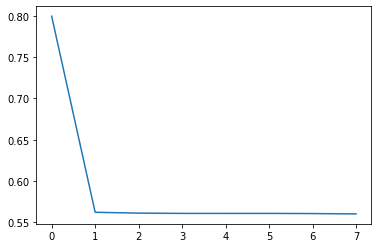

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7fc34976f268> (for post_run_cell):


NotebookValidationError: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01~\x00\x00\x00\xf8\x08\x06\x00\x00\x00\xebD\x8d\x8d\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.2.1, http://matplotlib.org/\xa3\xf2:\xda\x00\x00 \x00IDATx\x9c\xed\xbdy\x98\\gu\xe7\xff=\xb5\xaf\xdd\xd5U\xd5-\xa97\xb5Vk\xb3\xd4\xb2e\x81\x81\xb0$\x831I\xc6\x84\x01\x8c\x05d\x80\x00&,\xc9d\x8f\'3!\x84\x0c\xf9e\x92@2,\x13\x02\x84\x1d\xdb1\xc6C\xec\x89\x89\xe1\x19\x12 `\x1b\xc9\xb6Z[\xdbjY\xeaVW\xab\xa5^j_\xba\xd6\xf7\xf7\xc7\xad[]]]\xcb\xad\xaa[\xfb\xf9<\x8f\x1e\xa9n\xdd\xaaz\xaf\xaa\xfb[\xa7\xce{\xce\xf7\x90\x10\x02\x0c\xc30L\xef\xa0i\xf5\x02\x18\x86a\x98\xe6\xc2\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xa1k\xf5\x02\nq\xbb\xddbbb\xa2\xd5\xcb`\x18\x86\xe9(\x9ey\xe6\x99\x15!\xc4\xa0\x92s\xdbN\xf8\'&&p\xea\xd4\xa9V/\x83a\x18\xa6\xa3 \xa29\xa5\xe7r\xaa\x87a\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16\xfe.az1\x88\xa7.\xaf\xb6z\x19\x0c\xc3t\x00,\xfc]\xc2\'\xbew\x11\xbf\xf9\xc0s\xe0\xf9\n\x0c\xc3T\x82\x85\xbfKX\t\xc7\xb1\x14\x8a\xe3Z`\xad\xd5Ka\x18\xa6\xcda\xe1\xef\x12\xbc\x91\x04\x00\xe0\xd99_\x8bW\xc20L\xbb\xc3\xc2\xdf%\xf8\xb2\xc2\xff\xdcU\x7f\x8bW\xc20L\xbb\xc3\xc2\xdf\x05\xc4Si\x84\xe2)\x00\xc0s\xf3\x1c\xf13\x0cS\x1e\x16\xfe.\xc0\x17I\x02\x00\xfa\xcdz\x9c_\x08"\x9eJ\xb7xE\x0c\xc3\xb43,\xfc]\xc0j$\x0e\x00x\xcdM\x83H\xa438\x7f-\xd8\xe2\x151\x0c\xd3\xce\xb0\xf0w\x01r\xc4\xff\xf3\xfb\xb7\x00\xe0<?\xc30\xe5a\xe1\xef\x02\xe4\x88\x7f\xffV;F\x1cf<w\x95\xf3\xfc\x0c\xc3\x94F\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfb\x8a\xdc\xff7Dt:\xfb\xe7"\x11\xf9\x0b\xee\xef#"\x0f\x11}F\xad\x853\xeb\xc8\xa5\x9cN\xab\x01G\xc7\x1d\x1c\xf13\x0cS\x96\x8a\xc2ODZ\x00\x9f\x05\xf0z\x00\x07\x00\x9c \xa2\x03\xf9\xe7\x08!~[\x081)\x84\x98\x04\xf0i\x00\x8f\x14<\xcd\x9f\x01\xf8\x91:Kf\n\xf1E\x12 \x02\x1c\x16\x03\x8e\x8e\x0f`\xc1\x1f\xc3\x8d 7r1\x0cS\x1c%\x11\xffq\x00\x97\x84\x10\x97\x85\x10\t\x00\x0f\x02xC\x99\xf3O\x00x@\xbeAD\xb7\x02\xd8\x02\xe0{\xf5,\x94)\xcdj$\x01\x87Y\x0f\xad\x86pt\xdc\x01\x80\xf3\xfc\x0c\xc3\x94F\x89\xf0\x8f\x00\x98\xcf\xbb\xed\xc9\x1e\xdb\x04\x11m\x07\xb0\x03\xc0\x0f\xb2\xb75\x00>\x01\xe0\xf7\xca\xbd\x00\x11\xddKD\xa7\x88\xe8\xd4\xf2\xf2\xb2\x92u3yx#\t8\xad\x06\x00\xc0\xc1\xe1>\x18\xb4\x1a\xae\xe7g\x18\xa6$jo\xee\xde\x03\xe0a!\x84\\H\xfeA\x00\x8f\x0b!<\xe5\x1e$\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0\xa0\xcaK\xea~\xbc\x91\x04\\V#\x00\xc0\xa8\xd3\xe2\xe0H\x1f\x9e\x9b\xe3\x88\x9fa\x98\xe2\xe8\x14\x9c\xb3\x00`,\xef\xf6h\xf6X1\xee\x01\xf0\xa1\xbc\xdb\xb7\x03\xf89"\xfa \x00\x1b\x00\x03\x11\x85\x85\x10\x9b6\x88\x99\xda\xf1F\x12\xd89h\xcd\xdd>:6\x80\xfb\x7f6\x87d:\x03\xbd\x96\x0b\xb7\x18\x86\xd9\x88\x12U8\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93\xf21!\xc4\xdb\x85\x10\xe3B\x88\tH\xe9\x9e\xaf\xb1\xe8\xab\x8f\x94\xea1\xe6n\x1f\x1dw`-\x99\xc1\x0b\xd7C-\\\x15\xc30\xedJE\xe1\x17B\xa4\x00|\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xf2N\xbd\x07\xc0\x83\x82\r\xe1\x9bJ&#\xe0\x8b&\xe0\xca\xe6\xf8\x01\xe4m\xf0r\x9e\x9fa\x98\xcd(I\xf5@\x08\xf18\x80\xc7\x0b\x8e}\xa4\xe0\xf6G+<\xc7W\x00|\xa5\xaa\xd51\x15\t\xc4\x92\xc8\x08\xe46w\x01`\xc4a\xc6\x90\xdd\x88g\xaf\xfa\xf1\xab\xb7\xb7pq\x0c\xc3\xb4%\x9c\x00\xeepV\xf3\x9a\xb7d\x88(\xdb\xc8\xc5\x11?\xc30\x9ba\xe1\xefp\xbcE\x84\x1f\x00\x8e\x8e\x0f`v5\x9a\xbb\x9fa\x18F\x86\x85\xbf\xc3))\xfccR\x9e\xff4\xd7\xf33\x0cS\x00\x0b\x7f\x87SJ\xf8\x0f\x8f:\xa0\xd5\x10\x9e\xe5z~\x86a\n`\xe1\xefp\xbcYg\xceB\xe17\x1b\xb4\xd8\xbf\xcd\xce\x1d\xbc\x0c\xc3l\x82\x85\xbf\xc3\xf1F\x92\xb0\x1a\xb40\xe9\xb5\x9b\xee;:6\x80\xa9\xf9\x00\xd2\x19\xae\xb0e\x18f\x1d\x16\xfe\x0e\xc7\x1b\x89c\xa0 \xda\x97\xb9e\xbb\x03\xe1x\n\x97\x96\xc2M^\x15\xc30\xed\x0c\x0b\x7f\x87\xb3\x1a\xd9\xd8\xbc\x95\xcf\xd1\xb1\x01\x00\xc0\xb3\\\xd6\xc90L\x1e,\xfc\x1d\x8e/\x9a\xd8\x94\xdf\x97\xd9\xee\xb2`\xc0\xa2\xe7z~\x86a6\xc0\xc2\xdf\xe1x\xc3\x89\x92\xa9\x1e\xa9\x91k\x80\xbd\xf9\x19\x86\xd9\x00\x0b\x7f\x07#\x84(\x9b\xea\x01\x80[\xc6\x1d\x98Y\n#\x10K6qe\x0c\xc3\xb43,\xfc\x1dL,\x99F<\x95\xd9\xe0\xccY\xc8\xd1q)\xcf?5\xcfQ?\xc30\x12,\xfc\x1d\xccjXj\xde*\x17\xf1\x1f\x1e\xed\x07\x11\x8fbd\x18f\x1d\x16\xfe\x0eF\xee\xda-\x95\xe3\x07\x00\xbbI\x8f\xbdC\xdc\xc8\xc50\xcc:,\xfc\x1d\x8c7Z\xdc\xae\xa1\x90[\xb6;\xf0\xdcU?2\xdc\xc8\xc50Ma)\xb8\x86\xbf\xff\xe1\x8bh\xd7\xf1$,\xfc\x1d\x8cWA\xaa\x07\x90\xea\xf9\x03\xb1$\xae\xacF\x9a\xb1,\x86ik\xae\x07\xd6\xb0\x14\\k\xe8k<\xf2\xdc\x02\xfe\xbf\xef>\xdf\xb6\xcd\x93,\xfc\x1d\x8c\x92T\x0f\x90?\x91\x8b\xf3\xfc\x0c\xf3\x9b\x0f<\x87\xdf\xfd\xd6TC_c.\x1bd\xb1\xf03\xaa\xb3\x1aI@\xaf%\xf4\x99\xca\x0fR\xdb5h\x83\xdd\xa4\xe3F\xae:\xf9\xd6\xa9y\x9c\xe6\xea\xa8\x8eF\x08\x81\xf3\xd7\x02\xb8x\xa3\xb1\xf3\xa8gW\xa2\x00X\xf8\x99\x06\xe0\x8b$0`1\x80\x88\xca\x9e\xa7\xd1\x10&\xc7\x1cx\x96#\xfe\x9a\x11B\xe0#\xfft\x1e_\xfd\xe9l\xab\x97\xc2\xd4\xc1\xb5\xc0\x1a"\x894n\x04\xe3\x88&R\r{\x9d\xab^I\xf8_\\f\xe1gTf5R\xda\xae\xa1\x90\xa3\xe3\x03x\xe1z\x10\x91x\xe3~\xd8\xbb\x19o$\x81X2\x8d\x95p\xbc\xd5Ka\xea`&/\xd2\x9f[\x8d6\xe45\xd6\x92i\\\x0b\xc4\x00\x00\x97X\xf8\x19\xb5\xf1F\xe2U\x08\xbf\x03\x19\x01\x9c\xf1\x04\x1a\xbc\xaa\xeed\xc1/\xfd"\xcb\xbd\x13Lg\x92\x9fz\x99kP\xb1\x83\xc7\x17\x85\x10R\xd1\xc5\x8bK\x91\xb6\xac\xa6c\xe1\xef`|\xd1\xa4r\xe1\xcf\x8eb\xe4z\xfe\xda\xf0\xf8\xb2\xc2\x1f\xe1\x88\xbf\x93\x99\xb9\x11\x86\xcd(\xed\x89\xcd6(\xe2\x97\xf3\xfb\xaf\xd97\x84X2\x8d\xc5\x06W\x10\xd5\x02\x0b\x7f\x07\xb3\x1aV\x1e\xf1;,\x06\xec\x1c\xb4\xf2(\xc6\x1a\xf1\xf8\xa4_\xe6\xd5p\xa2-#8F\x193K!\x1c\x1a\xe9\x83\xcbjhX\xc4?\x97\xcd\xef\xff\x87\xfdC\x00\xdas\x83\x97\x85\xbfCI\xa63\x08\xae\xa5\x14\x0b? \xd5\xf3\x9f\x9e\xf7\xb5mS\x89\xcc\xc9Y/\x96B\xed\x15%\xc9\x11\x7f*#\x10\\c\xc3\xbbND\x08\x81\x99\xa50\xf6\x0c\xd9\xb1\xdde\xc1\x95\x95\x06\t\xffj\x04v\x93\x0e\xc7&\x9c\x00X\xf8\x19\x15\xf1E\x955o\xe5st\xdc\x81\x95p"\'b\xed\xc8\xe3g\x17\xf1\x96\xcf=\x89\xcf\xff\xf0r\xab\x97\xb2\x81\xfc\xff\xb3\x15\xce\xf3w$K\xa18Bk)\xec\xd9b\xc3\x84\xcb\xda\xb0\xcd\xdd\xd9\xd5(\xb6\xbb,pY\rpX\xf4,\xfc\x8cz(m\xde\xcaGn\xe4j\xd7\x89\\\xcf\xcc\xf9\xf0\xdb\xffx\x1a\x80\xf4K\xdaNx|Q\xd8\xb3\xb9\xe1\xd5\x06V\xf6d2\x02\xb1D\xbaa\xcf\xdf\xcb\xcc\xdc\x90\x04x\xf7\x90\r\xdb]V,\x06\xd6\xb0\x96T\xff\xffzn5\x82\xed.+\x88\x08\xbb\x07mmY\xd2\xc9\xc2\xdf\xa1\xc8v\r\xd5\xa4zn\xdab\x87\xc5\xa0m\xcb\x0e\xde\xd9\x95\x08\xde\xf7\xb5S\xd8\xd6o\xc2\xee![\xee\x83\xad\x1d\x10B\xc0\xe3\x8b\xe1\xe6\xd1~\x00\x8d\x8d\xf8\xbf\xf0\xe3\xcbx\xe5_\xfd+\x8b\x7f\x03\x98Y\x92J9\xf7\x0c\xd91\xe1\xb6\x00P\xbf\xa43\x99\xce`\xc1\x17\xc3\x84Kz\xfe\xddC6\xbc\xc8\x11?\xa3\x16\xde\\\xaa\xa7\xb4\x17\x7f!:\xad\x06\x87G\xfb\xdb\xae\x83\xd7\x17I\xe0\xdd_9\t!\x04\xbe\xfc\xee\xe3\x98pY\xb0\xdaF\xc2\xef\x8b&\x11M\xa4q$[\x19\xd5\xc8\xca\x9e\x99\xa50\x96Cq\xfc\xf3\xd9\xc5\x86\xbdF\xaf2\xb3\x14\x86\xc3\xa2\x87\xdbf\xc0\x84\xcb\n\x00\x98Uy\x83\xf7\x9a?\x86TF`{\xf6\xf9w\r\xda\xb0\x1aI\xc0\xd7F?\xcf\x00\x0b\x7f\xc7"G\xc4\xd5D\xfc\x80\xd4\xc8u\xfeZ\xb0!_qka-\x99\xc6\xbd_?\x85\x05\x7f\x0c_\xf8\xcf\xc7\xb0\xc3m\x85\xd3j\x80\xb7\x8d\xca&\xe5\x8a\x9e\xc3#\xd2l\x83FF\xfc\xcb\xd9\x14\xd7\xfdO\xcf5\xec5z\x95K7\xc2\xd8;d\x07\x11\xe5\x84_\xed\xca\x1e\xb9Dt\xbbs=\xe2\x07\xda\xaf\x83\x97\x85\xbfC\x91\x1b\x89\x1c\x16}U\x8f;:\xe6@*#pn\xa1\xf5\x8d\\\x99\x8c\xc0\xef?|\x06\'g}\xf8\xe4\xddGrU\x10N\xab\x11\xdeH\xa2m\xaa\x8f\xe4\x8d\xddq\x97\x05N\x8b\xa1\xa19\xfe\xe5P\x1cD\xc0\xb3W\xfdx\xfez\xb0a\xaf\xd3k\x08!pq)\x84\xdd[$!\xee\xb7\xe81`\xd1\xab^\xcb/\x7f\x90L\xb8\xa5\x0f\x16Y\xf8\xdbm\x83\x97\x85\xbfC\xf1F\x12\xe87\xeb\xa1\xd7V\xf7\x16\xca\xa3\x18\xdb!\xcf\xffW\xdf{\x01\x8fM]\xc3}\xaf\xdf\x87_><\x9c;\xee\xb2\x1a\x90L\x0b\x84\xdb\xc4^B\x8e\xf8G\x07,p\xd9\x0c\r\xb5mX\t\xc7\xf1\xda\xfd[`\xd0j\xf0\xe0\xcf\xe6\x1b\xf6:\xbd\xc6j$\x01\x7f4\x89=Y!\x06\x80\xed.+fU.\xe9\x9c[\x8d\xc2\xa4\xd7`\xc8.\xa5`G\x1cf\x18u\x1a\x16~F\x1d\xbc\xd1\xf2C\xd6K1h7b\xcciny\x07\xef\xfdO_\xc5\xdf\xfd\xdb\x8bx\xdbK\xc6\xf1\xfeW\xee\xdcp\x9f\x9c\xbej\x97\r^\x8f/\x06\xbbI\x87~\xb3\x1e.\xab\xb1a\xb6\r\x99\x8c\xc0j$\x81\x9b\xb6\xdaq\xe7\xa1\xadx\xe4Y\x0fo\xf2\xaa\x84\\\xd1\xb3g\xc8\x9e;6\xe1\xb2\xa8\xbe\xb9;\xb7\x1a\xc1D\xb6\xa2\x07\x90\x0c\x12w\xb6ae\x0f\x0b\x7f\x87\xe2\r\'\xaa*\xe5\xcc\xe7\xe8\xd8@K#\xfe\x7f{a\t\x7f\xfcO\xe7\xf0\xea\x9b\x06\xf1\xb1\xbb\x0enr\x17u\xda\xa4\xebj\x97\r\xde\x05_\x0c\xa3\x03R\xce\xd6m76l]\xbeh\x02\xe9\x8c\x80\xdbf\xc4\x89\xe3\xe3\x08\xae\xa5\xf08o\xf2\xaa\xc2%\xb9\xa2g\xcb\xc6\x88\xffZ \xa6\xea~\xd7\xecj\x14\xe3\xd9\xfc\xbe\xcc\xee![\xdb\x99\xb5\xb1\xf0w(\xde*\x9c9\x0b\xb9e\xdc\x81\xc5\xc0\x1a\x16\x03\xcdo\xe4\xbap-\x88\x0f}\xf3Y\xdc\xb4\xc5\x8e\xcf\xbc\xed\x16\xe8\x8a\xa4\xaa\xe4o2\xde6i\x94\xf2\xf8b\x18\x1d0\x03\x90\xd6\xd6\xa8T\xcfr\xf6y\x07\xedF\xbct\xa7\x13;\xdcV<\xf0\xb3\xab\ry\xad^\xe3\xe2\x8d0\xec&].\x05\x03\x00;\xdcV\x08\xb1\x9e\xca\xab\x97LF\xe0\xaa7\x9a\xcb\xef\xcb\xec\x1e\xb4\xc1\xe3S\xf7\x03\xa6^\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc8\xfd\x7fCD\xa7\xb3\x7f.\x12\x91?{|\x92\x88\x9e$\xa2\xf3Dt\x86\x88\xde\xaa\xf6\x05\xd4\xc3\xa5\xa5\x10~\xef[SH\xa63\xad^J\xd5\xd4\x9a\xea\x01Z\x97\xe7_\x0c\xc4\xf0k_9\x89>\xb3\x1e_z\xd7m9\xb3\xacB\x06,\xed\x93\xea\x91j\xf8\xa39\xe1w\xdb\x0c\x08\xad\xa5\x1a\xf2K,W\xf4\x0c\xda\x8d "\x9c8>\x86Ss\xbe\x86\x0f\r\xe9\x05f\x96B\xd83d\xdb\xf0\xedr{\xb6\xd6\xfe\xca\x8a:\xc2\x7f=\xb8\x86D*\x93{^\x99]C\xd2\x07L;\xa5{*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\xe4\x9f#\x84\xf8m!\xc4\xa4\x10b\x12\xc0\xa7\x01<\x92\xbd+\n\xe0?\x0b!\x0e\x02\xb8\x13\xc0\xdf\x12\x91C\xcd\x0b\xa8\x87G\x9e]\xc0\xc3\xcfxT\xdf\xe0i4B\x08i\x08K\x8d\xc2\xbf\x7f[\x1f\x0c:MS\xeb\xf9CkI\xbc\xfb\xcb\'\x11\x8e\xa7\xf0\xa5w\xdd\x86\xad\xfd\xa6\x92\xe7\xba\xda(\xd5\xe3\x8f&\x11I\xa4s\xa9\x1e\x97M\x8a\x18\x1b\xf1\xa1$\x7f\x93pg_\xe3M\xb7\x8c\xc2\xa0\xd5p\xd4\xaf\x02\x97\xb2\x1e=\xf9\xa8]\xd2)\xf7\x04\xc8\xcf+\xb3^\xd2\xd9>:\xa3$\xe2?\x0e\xe0\x92\x10\xe2\xb2\x10"\x01\xe0A\x00o(s\xfe\t\x00\x0f\x00\x80\x10\xe2\xa2\x10b&\xfb\xefk\x00\x96\x00\x0c\xd6\xb7d\xf5\x98\xf2H\x11\xef\xb5@{\x19\x82U"\x18K!\x95\x115G\xfc\x06\x9d\x067\x8f\xf47-\xe2O\xa63\xf8\xd0\xfd\xcfaf)\x8c\xff\xfd\xf6[\xb0\x7f[_\xd9\xf3-\x06\x1dLzM[\xd4\xf2\xcb\xa5\x9c\xeb\x11\xbf$\xca\x8d\xd8\xe0\xcd\x8f\xf8\x01\xe9C\xe6u\x87\xb6\xe2\xdb\xcfx\xda*M\xd0ix#\t\xac\x84\x13\x1b\xf2\xfb\x80T\n\xddg\xd2\xa9\xd6\xc4%o\x14\x17\xe6\xf8w\xb8\xad\xd0P{\x95t*\x11\xfe\x11\x00\xf9ue\x9e\xec\xb1M\x10\xd1v\x00;\x00\xfc\xa0\xc8}\xc7\x01\x18\x00\xbcX\xe4\xbe{\x89\xe8\x14\x11\x9dZ^^V\xb2\xee\xba\xc9dDn(\xc95\x7f\xfb\x9a\x96\x15C\xee\xda\xad5\xc7\x0fHy\xfe3\x0b\x01$R\x8dMs\t!\xf0\xc7\xdf9\x87\x1f]\\\xc6\x9f\xbf\xf1\x10^\xb9W\xd9\xe7\xbe\xcb\xda\xb8M\xd4jX/\xe5\xcc\xe6\xf8\xb3\xdfFV\x1a\xf0\xa1\xb4\x1c\x8a\xc3\xa4\xd7\xc0j\xd0\xe6\x8e\x9d8>\xc6\x9b\xbcu"\x0b\xee\xee\xa1\x8d\xc2OD\xd8\xe1\xb6\xe6\xfc\xf3\xebev5\x02\xbd\x960\xec0o8n\xd4i1\xee\xb4\xb4\x95u\x83\xda\x9b\xbb\xf7\x00xX\x08\xb1!<!\xa2m\x00\xbe\x0e\xe0\xddB\x88MJ#\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0`s\xbe\x10\xcc\xaeF\x10Z\x93\xea\xc4;N\xf8\xb3\xa2Sk\xaa\x07\x90\xf2\xfc\x89T\x06\xd3\x8b\x8dm\x12\xfa\xc6Ssx\xf0\xe4<>\xfc\x9a\xddx\xebm\xe3\x8a\x1f\xe7\xb4\x1a\xda\xa2\xcd=\x17\xf1;\xb2U=Y\x8b\x8c\x95\x06\x98\xc8\xad\x84\x13\xb9\xfc\xbe\xcc\xed;]\x98pY8\xddS\x079\x8f\x9e-\xf6M\xf7mwYU\x8b\xf8\xaf\xaeF1\xe6\xb4@\xab\xd9<\x03{W\x9b\x95t*\x11\xfe\x05\x00cy\xb7G\xb3\xc7\x8aq\x0f\xb2i\x1e\x19"\xea\x03\xf0\xcf\x00\xfe\x9b\x10\xe2\xa9Z\x16\xd9\x08\xe4h_\xab\xa1\xdcX\xbdNAN3\xd4\x9a\xea\x01\x9a\xe7\xd4\xf9\xd8\xd4"\x0e\x0e\xf7\xe1w\xef\xd8[\xd5\xe3$\xdb\x86v\x10~\xc9\x95\xb3\xcf,mD7r\xffa9\x14\xc7\xa0m\xa3\xf7\x92\xb4\xc9;\x8e\x93\xb3\xbe\r\xf3b\x19\xe5\xcc\xdc\x08\xc3j\xd0b\xb8\xc8\xbe\xd2\x84\xcb\x82k\xfe\x18\xe2\xa9\xfaSi\xb3\xab\xd1M\xf9}\x99\xddC6\\^\x89 \xdd&C|\x94\x08\xffI\x00{\x88h\x07\x11\x19 \x89\xfb\xa3\x85\'\x11\xd1>\x00\x03\x00\x9e\xcc;f\x00\xf0\x7f\x00|M\x08\xf1\xb0:KV\x87)\x8f\x1f&\xbddZ\xd6i\x11\xbfO\x85T\xcf\xb6~3\xb6\xf4\x19qz\xbeqy\xfeT:\x83\xb3\x0b\x01\x1c\xdf\xe1\xdcT\xab_\t\x97\xd5\xd0&\xa9\x9e\x18F\x06\xcc\xb9\xf5[\x8d:\x98\xf5\xda\x86\xd86,\x87\xe2\xb9=\x84|\xdet\xeb(\xf4Z\xc2\x03\xdc\xc9[\x13\x97\x96\xc2\xd8]P\xd1#3\xe1\xb6"#P\xf7\x8c\n!D\xd6\x8e\xd9R\xf4\xfe]C6$R\x19\xcc{\x1b3\x03\xa0Z*\n\xbf\x10"\x05\xe0\xc3\x00\x9e\x000\r\xe0!!\xc4y"\xfa\x18\x11\xdd\x95w\xea=\x00\x1e\x14\x1b\rV\xee\x06\xf0J\x00\xef\xca+\xf7\x9cTq\xfd535\xef\xc7\xcd#\xfd\x18wZp\xcd\xdfY\x9b\xbb\xb2 V\xe3\xccY\x8c\xc91GC\x85\x7ff)\x8cX2\x8d\xc9\xb1\xea\x0b\xb9\xda\'\xe2_o\xde\x92q\xd9\x0c\r\xd9\xdc]\t\xc7s\x1b\xbb\xf9\xb8mF\xdcqp+\xbe\xfd,o\xf2\xd6\xc2\xccR\x08\xbb\x876\xa7y\x00\xe4\\4\xeb\xad\xec[\x0e\xc7\x11M\xa4s\xe6l\x85\xec\x1al/\xcf\x1eE9~!\xc4\xe3B\x88\xbdB\x88]B\x88\x8fg\x8f}D\x08\xf1h\xde9\x1f\x15B\xdcW\xf0\xb8o\x08!\xf4r\xa9g\xf6\xcfiu/\xa1z\x92\xe9\x0c\xce_\x0b\xe2\xf0\xa8\x03\xc3\x0e3\x16\x03\xb1\x8e\x9a\xa3\xea\r\'`\xd2k`\xce\xdb\x04\xac\x85\xc9\xb1\x01\xcc\xadF\x1b&\xb0S\xd9\x0f\x95#\xa3\xd5\x0b\xff\x80\xd5\x80h"\xddR\xa1+\xac\xe1\x97q\xd9\x8c\xb9f+\xb5H\xa53\xf0F\x13E\x85\x1f\x00\xdev|\x1c\x81X\x12\xffr\xee\xba\xaa\xaf\xdb\xed\x04bI\xdc\x08\xc6\xb1\xb7\xa0\xa2GF\xf6\xcd\xaf\xd7\xac\xed\xaa\xec\xca\xe9.\x9d\xea\x01\xda\xa7\x96\xbf\';w/\xde\x08!\x9e\xca\xe0\xf0h?\x86\x1df$\xd3\xa2\xa1\xc6[j\xe3\x8d$\xea\x8e\xf6\x01\xe4"\xf1\xa9\x06E\xfdS\x1e?\xfa\xcd\xfa\x92_\x7f\xcb!\xef_\xb42\xdd\xb3^\xc3\xbfQ\xf8\xddV\xf5#~\xc9\x8d\x14ES=\xc0\xfa&\xef\xfd\xbc\xc9[\x15r\x84]X\xca)\xe3\xb4\x1a`7\xea\xea\xae\xe5\x97?8J\xe5\xf8\xfb\xcdz\x0c\xda\x8d\x9d\x15\xf1w\x1b\xf2\xc6\xee\x91Q\x07F\x1c\xd2\x86O\'m\xf0z\xa3\xb5\xdb5\xe4sx\xb4\x1f\x1a\x02\x9ek\x90\xf0\x9f\x9e\x0f\xe0\xc8\x98\xa3\xea\xfc>\x90g\xd4\xd6B\xdb\x86\xf5\x1a\xfe\x8d\x1f\\n\x9bQ\xf5a,K\x055\xfc\x85h4\x84{\x8e\x8f\xe3gW\xbc9\xdf\x19\xa62\x97\xf2\xa6n\x15\x83\x880\xe1\xb6\xd6\x1d\xf1\xcf\xadF\xa0\xd5\x10F\nJ9\xf3\xd9=\xd8>\x9e==)\xfcS\xf3\xeb\x91\xa8\\s\xdbIy~o\x1d]\xbb\xf9X\x8d:\xec\xddboH\x9e?\x9aH\xe1\xe2\x8d\x10&\xb3\xe3\n\xabe\xbdz\xa6u\xdf\xc4\x16\xfc\x1bk\xf8e\xe4\x1c\xbf\x9a\xf3\x02\x96\x0b\xbav\x8b\xf1f\xde\xe4\xad\x9a\x99\x1ba\x98\xf4\x9a\xb2\x82\xbc\xdde\xa9;\xc7?\xbb\x1a\xc5\xb0\xc3\x04\x83\xae\xb4\xa4\xee\x1a\xb2\xe2\xc5\xa5p[\xcc\x99\xe8M\xe1\xf7\x04px\xb4\x1fD\x94\'\xfc\x9d\x13\xf1\xaf\x86k\xf7\xe9)dr\xcc\x81\xa9y\xbf\xea?\x8c\xe7\x16\x82HgDn\\a\xb58\xb3\xa9,\xb9\x82\xa9\x15\xc8\x11\xff\xd8\xa6\xcd]#R\x19\x81@,\xa9\xdak\xc9}\x01C%"~ \xbb\xc9{\x807y\xaba&[\xd1\xa3)R[/3\xe1\xb2\xc2\xe3\x8b\xd6\xd5\xccx5k\xc7\\\x8e\xdd\x836\x04\xd7R\xaa\xef\x0f\xd5B\xcf\t\x7f,\x91\xc6\xc5\x1b\xa1\xdc\x86c\x9fI\x0f\xbbQ\xd7Q\xa9\x1e\x9fJ\xa9\x1e@\x12\xfe@,\x89+*\xfb\x15\xc9\xfb\x06\x87k\xd8\xd8\x05\xd6S=\x8d\xf2\xbeW\x82\xc7\x17\xdbP\xc3/\xe3\x96\xbbwU\\\x9b\x92\x88\x1f\x00N\x1c\x1f\x87?\x9a\xc4\x13\xe7y\x93W\t\xc5<z\n\x91K:\xeb\xd1\x80\xd9\xd5h\xc5\xbd,\xb9\xb2\xa8\x1d\xf2\xfc=\'\xfc\x17\x16\x03Hg\x04\x0e\xe7\xa5 \x86\x1d\xe6\x8e\x89\xf8\xd7\x92iD\x13i\xf5\x84?\xdb\xc8\xa5v\xba\xe7\xb4\xc7\x8f\x11\x87\xb9d\xce\xba\x12}&\x1dt\x1ajiI\xa7\xc7\x17\xddP\xc3/\xb3\xee\xd7\xa3^\xe4\xb6\x1c\x8a\xc3f\xd4U\xac\xd4z\xd9.\x17\xc6\x9d\x16\xdc\xff4o\xf2V"\x1cOa\xc1\x1f\xdbd\xd5PH\xae\xb2\xa7\xc6\xe0\xc7\x1fM \x10KV\x8c\xf8w\rI\xf7\xb7\x83uC\xcf\t\xff\xd4|vc7/\x051\xec0\xe1Z\x0b\xbc\xe9ka\xb5\xc6!\xeb\xa5\xd83d\x87\xd5\xa0U]\xf8\xa7\xe6\xfd\xb9\x0f\x95Z "\x0c\xb4\xb8\x96\xbfX\r?\xd0\x98\xee]\xd9\xae\xa1\x12\xd2&\xef\x18\x9e\xbe\xe2m\x9b\xd2\xc0v%W\xd1SA\xf8s\xb5\xfc5V\xf6\xcc\x960g+dk\x9f\t6\xa3\xae-\\:{O\xf8=~l\xe93bK\xdfz\xfb\xb6\x14\xf1w\xc6\xe6\xaeOe\xe1\xd7j\x087\x8f\xf6\xab*\xfc+\xe18<\xbe\x18&kL\xf3\xc8\xb4\xb2{W\xaa\xe1\x8fm\xda\xd8\x05\xd6\x1b\xe7\xd4,\x01^\x0e\xadm\xb2k(\xc5[n\x1d\x83NCx\x90K;\xcb"[\\\x14\xf3\xe8\xc9\xc7m3\xc0j\xd0\xd6<\x86\xb1p\xc0z)\x88\x08\xbb\x06\xad\x9c\xeai\x05g<\x81M\rE\xc3\x0e3\xbc\x91DG\xcc7U;\xe2\x07\xa4F\xae\xe9\xc5\xa0j\x1b\x86g\xb2v\xd7\xb5n\xec\xca\xb4\xb2{7\x10K"\x1cO\x15\x15\xfe\x01\x8b\x1eD*\xe7\xf8Cq\xb8\xed\xca\xde\xd3A\xbb\x11w\x1c\xdc\x82\x87\xd9\xae\xb9,\x97\x96\xc20\xe84\x18+\xf2\x1e\xe6\xb3^\xd2Y[$^\xca\x8e\xb9\x18\xbb\x06m,\xfc\xcdF\xde\xc4,\x14$\xb9\xd4\xab\x13\xd2=\xb23\xa7\xba\xc2\xef@2-p\xfe\x9a:N\x9d\xa7\xe7\x03\xd0\x10ph\xa4\xbc\xef~%Z)\xfc\x85>\xfc\xf9\xe8\xb4\x1a8-\x06Us\xfc+\xe1\x84\xe2\x88\x1f\x906y}\xbc\xc9[\x96\x99\xa50v\xba\xadE\xc7{\x162\xe1\xb2\xd6\x9c\xe3\x9f]\x8d`[\xbf\t&}\xe5N\xfa]C6\\\x0f\xae!\x1cO\xd5\xf4Zj\xd1S\xc2\x7f6\xdb\xb8u\xb8\xa0\xb6\xbc\x93J:\xbd\x11\xa9\x84P\xadrN`\xdd\xa9S\xadt\xcf\xd4\xbc\x1f{\xb7\xd8a1\x14\x1f\xad\xa8\x14\x97U]q\xad\x86u\x1f\xfe\xe2Q\x9c\x9a~=\xf1T\x1a\x81X\xb2\xaa\x8d\xf0\x97\xefrc\xccif\xbb\xe62\xcc,\x85*\xa6yd\xb6\xbb,\xf0\xf8b5\x8da\x9d+2`\xbd\x149\xeb\x86\x16G\xfd=%\xfc\xf2\xc4\xad\xc3#\x85\xa9\x1e)\xdf\xdf\x19\xc2\x1f\x87VC\xe83\xe9U{\xce-}&l\xeb7\xa9"\xfcB\x08Ly\xfc5\x19\xb3\x15\xe2\xb4\x1a\x11\\K\xb5d&r\xb9\x88\x1f\x90\xf2\xfcj\xe5\xf8\xe5\x0f\x90J\xa5\x9c\xf9h4\x84{n\x1b\xc7S\x97\xbd\xb8\xcc\x9b\xbc\x9b\x88&R\xf0\xf8b\x157ve&\\V\xa42\xa2&\r\x98+c\xc7\\\x88,\xfc\xadN\xf7\xf4\x96\xf0\xcf\xfb\xb1\xc3mE\xbfe\xa3hn\xe93AC\xc0B\x07l\xf0z#\t\x0cX\xf4e\x1bRjAr\xea\xac\xdf\x9b\xff\xaa7\n\x7f4Yw~\x1f\x00\x9c\xd9\xea\x99V4qy|1\xd8\x8c:\xf4\x9b\x8b\x7f\xc0\xba\xed\xeaM\x08+\x1c\xb9\xa8\x94\xb7\x1c\x1b\x956yOr\'o!\x97\x97#\x10\xa2rE\x8f\x8c\xbc1[\xaduC8\x9e\xc2J8\x8e\xedne\x11\xff\xb8\xd3\x02\x9d\x86Zn\xdd\xd0S\xc2\x7f&\xdb\xb1[\x88^\xab\xc1\x96>SGD\xfc\xaba\xf5\x9a\xb7\xf2\x99\x1cs`\xde\x1b\xab;\xb5r\xba\x0eG\xceB\xe4tV+\xf2\xfc\xb2+g)\x9f!\x97\xd5\xa0Z\xc4/\x0b\x7f5\x11?\x00\x0c\xd9M\xf8\x0f\xfb\xa5M^5\x06\x89t\x13\xe5\xa6n\x15\xa3\xd6Z\xfe\xb9\x12\x03\xd6K\xa1\xd7j0\xe1\xb6r\xaa\xa7Y,\x05\xd7p=\xb8V\xb2\x93t[\x7fg\x08\xbf\x9a]\xbb\xf9\xe4\x9c:=\xf5\xa5{N\xcfK\x03nJ\xd9\xe0V\xc3\x80\xa5uFm\xa5J9e\xdc6\x03Bk)U\x04W\xfe\x00\xa9\xa5\xd9\xedm/\x19\x877\x92\xc0\x13\xe7o\xd4\xbd\x8enb\xe6F\x18z-)v\x86\x1d\xb4\x1ba1h\xab\xae\xec\xa9\xa6\xa2G\xa6\x1d\xcc\xdazF\xf8\xa7r\x8e\x9c\xc5M\xc3:\xa5{w5\xd2\x18\xe1\xbfy\xb4\x1fZ\r\xe1\xf4\xd5\xfa\x84_\x1ep\xa3\xa4\x92\xa2\x12\x8d\x1csX\x0e!\x04\x16J4o\xc9\xb8r\xdd\xbb\xf5\xafM\x8e\xf8\xe5\xeb\xad\x86W\xecvc\xc2e\xc1\xc7\x1e;\x8f\xf3\xd7\x02u\xaf\xa5[\x98Y\nc\x87\xdb\n\xbd\xc2\x9fC"\xc2v\x97\xb5\xeaZ~\xf9\xfcj\xac\xc7w\rI\xafS\x8f7P\xbd\xf4\x8c\xf0\x9f\xf1\xf8\xa1\xd5\x10\x0e\x0e\x17\x17\xfe\x11\x87\x19\xd7\x02km\xe1\x9cW\x0eo\x83\x84\xdfb\x90\x9c:\xeb\xb1hN\xa638w-\xa8J\x9a\x07\xc8\xb3fn\xb2\xf0\x07c)\x84J\xd4\xf0\xcb\xb8\xd5\x14\xfep\x1c\xfdf=\x8c\xba\xea\x07\xebh4\x84\x7fx\xd7m0h5\xb8\xe7\xf3O\xe1\xd4\xac\xb7\xee\xf5t\x03J<z\n\x99\xa8\xc1\xa5sn5\x02\xb7\xcd\x00{\x15\xc5\x16\xbb\x87lHg\x04\xaez[\xd7\xc1\xdb3\xc2\x7f:[bX\xca\x0be\xd8aF"\x95i\x8b9\xaf\xa5H\xa53\x08\xc4\x929\xe7J\xb5\x91\x9d:k\x9dF\xf6\xc2\xf5\x10\x12\xa9\x8c*\x1b\xbb\x80\x94\xea!j~\xc4?\xef+n\xc7\x9c\x8f\x1c\x9d\xaf\xa8`\x1b]j\xe4\xa2Rv\r\xda\xf0\xad\x0f\xbc\x0cn\x9b\x11\xef\xf8\x87\xa7\xf1\xc3\x8b\xcbu\xaf\xa9\x93YK\xa61\xb7\x1a\xa9\xe8\xd1S\xc8v\x97\x15\xf3\xbe(RUT\x91\xcd\xaeFr\x96\x0fJ\xd9=\xd8z\xb3\xb6\x9e\x10~!\x04\xce.\x04J\xa6y\x80\xce\xa8\xe5\xf7\xc7\x92\x10\x02pZ\xd4+\xe5\xcc\xe7\xe8\x98\x03\xc1\xb5\x14\xae\xd4\xd8\xc1(o\xec\xaaQ\xca\tHv\x12\x0e\xb3>\xd7\xb4\xd6,J\r`\xc9\xc7mU7\xd5SM\xf3V1F\x1cf<\xf4\xfe\xdb\xb1\xc3m\xc3{\xbfz\x12\x8f\x9f]\xac{]\x9d\xca\x95\x95\x082\xa2\xf4\xd4\xadRL\xb8,H\xa6\x05\x16\x03\xca\xab\xfb\xe6V\xa3%\xe7\xec\x96b\xe7\xa0\xf4A\xc1\xc2\xdf`\xe4\x12\xc3r\x16\xc1\x9dP\xcb/\xa7<\x9cu\x8aD)rN\x9d5\xe6\xf9\xa7\xe6\xfdpY\re#\xe5jqZ\r\xf0E\xd4\xf3\xbdW\x82\xa7\x9a\x88_\x85\xca\x9e\x95p\x02\xee:"~\x99A\xbb\x11\x0f\xde\xfbR\x1c\x19u\xe0\xc3\xf7?\x8b\x87z\xb4\xccs&g\xceVe\xaa\xc7]\x9dY\xdbZ2\x8d\xc5\xc0Z\xd5\x11\xbf\xd5\xa8\xc3p\xbf\x89\x85\xbf\xd1L\x95\xe8\xd8\xcdG\xb6mh\xe7Z~Y\xf8\xd5\xec\xda\xcdg\xd7\xa0\r6\xa3\xae\xe6F\xae)\x8f\xbf\xe6Q\x8b\xa5pY\xd5\x1fsX\x89J5\xfc\x80\xf4\xcbk\xd6kU\xe9,V#\xe2\x97\xe97\xeb\xf1\xb5\xf7\x1c\xc7\xcbw\xbb\xf1\x07\xdf>\x83/\xfe\xf8\xb2*\xcf\xdbI\xcc\xdc\x08A\xab!L(\xac\xad\x97\x91K2\x95\xe6\xf9\xe7\xbd\xd99\xbbU\xbe\x0e Y7\xb4\xd2\xa5\xb3\'\x84\xff\xcc\xbc\x1fF\x9d\x067m-\x1d\x01\xf4\x9b\xf5\xb0\x18\xb4\x1d\x11\xf1\xcbe\x8ej\xa3\xd5\x10\x0e\xd7\xe8\xd4\x19\x8e\xa70\xb3\x14VmcWf\xc0\xaao\xfa\xe6\xae\\\xcaY\xe9\x03L\r\xdb\x86X"\x8dp<\xa5\xd8\xa0M\t\x16\x83\x0e_|\xe71\xfc\xe2\xcd[\xf1?\xfey\x1a\x9f\xfc\xde\x0bm_\xb4\xa0&37\xc2\xd8\xee\xb2T\xbdY>d7\xc2\xa4\xd7(n\xe2\x9a\xcdU\xf4T\x17\xf1\x03\xd2\x06\xef\x8b\xcb\xe1\x9a\xf7\xd3\xea\xa5\'\x84\x7f\xca\xe3\xc7\xc1\xe1\xbe\xb2\xa5]\xf2\x18\xc6v\x16~y\x93\xb3\x96\xb2?\xa5L\x8e9jr\xea<\xeb\t@\x08\xe0\xc8Xm3vK\xe1\xb4\x1a[ \xfc\xd1\xb23Ze\\6c\xddc\xf4r5\xfc*\xa7\xef\x8c:->}\xe2\x16\xdc}l\x14\x9f\xfa\xc1%\xfc\xe9c\x17Z&2\xcdff)\xa4\xb8c7\x1f\x8d\x860\xe1\xb2\xe6\x9a\xb2*\xb1\xde\xbcUC\xc4?hC4\x91\xc6b\xb05\x19\x86\xae\x17\xfeT:\x83s\x0bAE#\x00\xdb]\xf8}\r\x8e\xf8\x01I\xf8S\x19QuM\xb8\xdc\xf8\xa5v\xc4\xef\xb2\x1a\xe0\x8b&\x9b&Z\xeb5\xfc\x95\x85\xdfm\xad?\xe2_\xaa\xd1\xaeA\tZ\r\xe1\x7f\xbe\xe90\xde\xfb\x8a\x1d\xf8\xcaOg\xf1{\xdf\x9a\xaa\xaab\xa5\x13I\xa42\x98]\x8dV\x9d\xdf\x97\xd9\xee\xb2(\x8e\xf8\xe7V\xa3\xe83\xe9\xe0\xa8\xe1\xf7\xb1\xd5fm]/\xfc\x97\x96\xc3\x88%\xd3\x8a"\xd1\x11\x87\xa9\xeds\xfcv\xa3\x0e\x06]\xe3\xde6y\x83\xf7\xb9*7x\xa7\xe6\xfd\xd8\xee\xb2`@\xe5\xfd\x07\xa7\xd5\x80\xb4\xca\x83\xcd\xcb\xb1^\xc3_9\x8as\xdb\xea\xdf\x7f\xa8\xd5\xaeA)D\x84\xff\xf6K\xfb\xf1\xbb\xaf\xdd\x8bG\x9e[\xc0\x07\xbe\xf9lW{\xf8\xcf\xaeF\x90\xce\x88\xaa+zd&\\V\\]\x8d"\xad \xd0\x98]\x8dT\x1c\xbeR\x8aV\x9b\xb5u\xbd\xf0\x9f\x99\x977v\x15D\xfc\xfdf\xac\x84\xe3m\xfb\x8b\xb1\x1aI\xe4\x8c\xcb\x1a\xc5\x90\xdd\x84\x11\x87\xb9\xea<\xff\xe9y\xbf\xea\xd1>\xd0\xfc\xee]%5\xfc2r\x8e\xbf\x9e\xfc\xb9\x9c\xea\x19j@\xc4/CD\xf8\x8d_\xd8\x83\x8f\xfe\xc7\x03\xf8\xfe\x85\x1b\xf8\xb5\xaf\x9cl\xb9\x1f|\xa3\x98\xb9!\ti\xb55\xfc2\xdb]V$\xd2\x19,*\x98\xcd1\xb7\x1a\xad)\xbf\x0fH\xdfd\x1d\x16}\xcb\xac\x1b\xba^\xf8O{\xfc\xb0\x1bu\xd8\xa1\xe0\r\x92k\xf9\xafWQ\xc7\xdbL|\r\xea\xda-Dr\xeaT.\xfc7\x82kX\x0c\xac\xa9\xd6\xb8\x95O\xb3\xbbw\x17\xfc\x95k\xf8e\\6#Ru~\x1bY\x0e\xc5A\xa4\xee`\x9dR\xbc\xeb\xe5;\xf0\x89\xb7\x1c\xc1\xd3W\xbcx\xfb\x17\x9fn\xda\xb7\xa8f2\xb3\x14\x02\x91\x94C\xaf\x05\xb9B\xa7\x92uC2\x9d\xc1\x82?VS~\x1f\x90\xc70\xb6n\x1aW\xd7\x0b\xff\x19\x8f\x1f\x87\xc7\xfa\x15\xd9\x18\xb7{\x13\xd7j$\x01g\x03\xf3\xfb2\x93c\x0ex|1\xc55\xeaS\xb9\xc6-u7v\x81\xe6\x0b\x7f%\x1f\xfe|\xdc\xb9Z\xfe\xda\xd7\xb6\x1c\x8e\xc3i1\xa8\xe2m\xa4\x847\xdd:\x8a\xbf{\xfb-\xb8p-\x80\x0f}\xf3\xd9\xae\xcb\xf9\xcf,\x851\xee\xb4(\x9a\x86U\x0c\xb9\xa4\xf3J\x85\x92\xce\x05_\x0c\xe9\x8c\xa8\xca\x9c\xad\x90\xdd\x83\xb6\x96\xcdR\xe8j\xe1_K\xa6\xf1\xfcbHQ\x9a\x07\xc8\xaf\xe5oO\xe1\xf7F\xe2\xcd\x89\xf8\xabl\xe4\x9a\xaa\xe0\x83T\x0f\xf2`\xf3\xe6\t\x7f\x14V\x83\x16\x0e\x05\xdd\xd1\xeb~=\xb5\xe7\xf9WB\xf5\xd95\xd4\xc2\x1d\x07\xb7\xe2\xe3o\xbc\x19\xff~i\x05\x7f\xf6\x7f/4\xf5\xb5\x1b\xcd\xa5\x1b\xd5{\xf4\xe4\xb3\xb5\xcf\x04\x83NS\xb1\xb2gV\xe1\x80\xf5r\xec\x1e\xb2a%\x9c\x80\xbf\x05\xf3&\xbaZ\xf8\xa7\x17\x83HeDY\xab\x86|\xb6\xf4\x1bA\x04\\k\xc3\r^!\x84d\xd0\xd6\xe0\x1c?\x00\x1c\x1a\xce:u*L\xf7L\xcd\x07\xb0o\xab\xbd\xe6(\xab\x1c\x03VI\x80\x9be\xdb\xe0\xc9\xbar*iBSc\xffa9\x1co\xd8\xc6n9\xee>6\x86{_\xb9\x13_}r\x0e_\x7fj\xae\xe9\xaf\xdf\x08R\xe9\x0c.\xaf\x84k\xde\xd8\x05\xa4\x92\xce\xed\xce\xca\x95=\xb5\xb8r\x16\xb2k\xa8u\xd6\r]-\xfcg<\xca7v\x01\xa9\xf6y\xd0fT5\xd5#\x84\xc0_|\xf7y<\x7f\xbd\xbeA\xe6\xe1x\n\xc9\xb4hX\xd7n>f\x83\x16\xfb\xb6\xda\x15\t\x7f&#r\x1d\xbb\x8d\xc0\xa8\xd3\xc2f\xd45ms\xb7\x92\x0f\x7f>\xf2\xb7\x91zl\x1b\xea5h\xab\x87?\xbcs\x1f~a\xdf\x10>\xfa\xe8y\xfc\xfb\xccJK\xd6\xa0&s\xde(\x92iQS\r\x7f>\x13\xee\xca\xb5\xfcs\xabQX\x0c\xda\xba\xfa/d\xb3\xb6\x17[\x90\xee\xe9j\xe1\x9f\x9a\xf7c\xd0n\xc4\xb6~\x93\xe2\xc7\x0c;\xcc\xb8\xa6`G_)\xf3\xde\x18>\xf7\xc3\x17\xf1\x8fu\xfa\xa64\xbak\xb7\x10\xa5N\x9dWV#\x08\xad\xa50\xd9\x80\x8a\x1e\x19\xa7\xd5\xd0\xd4T\x8fR\xe1\x1f\xb0\xe8AT{\x8e_\x08!\xd95\xb4H\xf8\xb5\x1a\xc2\xdf\xde3\x89\xdd\x836|\xf0\x9b\xcft\xfc\xec^\xb9\xa2\xa7\x9eT\x0f 5d\xcd\xadF\xcb\xfe\xec\xcf\xadF0\xeeT\xf6\xcd\xb0\x14#\x03f\x18u\x1a\x8e\xf8\xd5f\xca\xe3\xc7\x91\xd1\xfe\xaa\xde\x9ca\x87I\xd5\x1c\xff\x85E)\xd2?\xbfP_\xc4\xdf\x8c\xae\xdd|&\xc7\x1c\x08\xc5S\xb8\xbcR\xfe\x87R\xde\xd8mT\xc4\x0f4O\xf8\x03\xb1$Bk\xcaj\xf8\x01@\xa7\xd5\xc0i1\xd4\x9c\xe3\x0f\xc7SXKfr\x9b\xc4\xad\xc0n\xd2\xe3\x8b\xef<\x06\x9dV\x83\xf7~\xf5\x14\x02\xd1\xce\xad\xf4\xb9\x94\x1d\xb7(\xa7Pje\xbb\xcb\x8ax*\x83\xebe\xbajgW#\x8a\xc7-\x96B\xab!\xeclQeO\xd7\n\x7fh-\x89\xcb+\x11\xc5i\x1e\x99\xe1~\xa9{W-o\x93iY\xf8\xaf\x05\xea\xea>\x95\xbbv\x1b\xe5\xc5_\xc8Q\x85\x8d\\S\xf3~X\r\xda\x9a\xeb\xa6\x95\xe0R\xa1CV\tJ\\9\x0b\xa9\xc7\xafG\xfe\xa6\xd0\xaa\x88_f\xcci\xc1\xdf\xff\xea\xad\x98\xf7E\xf1\xa1\xfb\x9fE\xb2C+}f\x96\xc2\x18\x1d0\xc3b\xd0\xd5\xf5I\xa2?\x1d\x00\x00 \x00IDAT<;*\xb8t\xa63\x02\xf3\xde\x98\xe2\x01\xeb\xe5\xd85hmI-\xbf"\xe1\'\xa2;\x89\xe8\x05"\xbaDD\xf7\x15\xb9\xffo\x88\xe8t\xf6\xcfE"\xf2\xe7\xdd\xf7N"\x9a\xc9\xfey\xa7\x9a\x8b/\xc7\xd9\x05\xc9;\xa6\x9c#g1\x86\x1df\xac%3\xf0\xa9\x14\xf9\xc8\xc2\x1fI\xa4\xab\x9e\xe7\x99\x8f\x1c\xf17\xa3\x9c\x13\x00v\xbam\xb0+p\xea<\xed\t\xe4\xc666\x8afE\xfcJ|\xf8\x0bqY\x8d5\xe7\xf8\xe5\xae\xddA\x9b\xf2Td\xa3\xb8m\xc2\x89?\xef\xf0J\x9f\x99\x1b\xe1\xba\xf3\xfb\xc0\xfa\x86m\xa9Z\xfe\xeb\xc15$\xd2\x99\xba#~@\xaa\xec\xf1\xf8bMo\x1a\xad(\xfcD\xa4\x05\xf0Y\x00\xaf\x07p\x00\xc0\t":\x90\x7f\x8e\x10\xe2\xb7\x85\x10\x93B\x88I\x00\x9f\x06\xf0H\xf6\xb1N\x00\x7f\x02\xe0%\x00\x8e\x03\xf8\x13"\x1aP\xf7\x12\x8aS\xed\xc6\xae\x8c\xda\xb5\xfc\xd3\xd7\x83\xb9\xc1\x0b\xe7\xae\xd5\x9e\xeeY\xf7\xe2o\x8e\xf0k4\x84\xc3c\xe5\x9d:\xe3\xa94\xa6\xaf\x05\x1b\x9a\xe6\x01\xa4k\xf6F\xeb\xeb\x90U\x82,\xfc#\xd5F\xfc5~(\xe5\xec\x1aTt\xe6\xac\x87\xb7\x1c\x1b\xc3\xfb_\xb9\x13_{r\x0e_\x7fr\xb6\xd5\xcb\xa9\x8atF\xe0\xc5\xe50\xf6l\xa9/\xbf\x0f\x00\xdb\xfa\xcd0h5%\xed\x99\xe7\xb2\xc7\xab\x1d\xc0R\x8c\xddC6\x08\x01\\n\xb2E\xb3\x92\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xcc\xf9\'\x00<\x90\xfd\xf7\xeb\x00|_\x08\xe1\x15B\xf8\x00|\x1f\xc0\x9d\xf5,X)S\xf3~\x8c;-U\xd7\xbd\xabY\xcb\x1fZKb\xde\x1b\xc3\x7f<<\x0c\x83VS\xd70l_$\x01\x83N\x03k\x89\xd1\x91\x8d`r\xcc\x81\xe7\xaf\x87\x10K\x14\x8fF\xa6\x17CH\xa43\r\xdd\xd8\x05\xa4o9\x89T\x06\x91\x12\xebP\x0b\x8fO\xaa\xd4\x18\xa8b\xc2\x99\xdbV{\xc4\xdf(g\xcez\xf8\x03\xb9\xd2\xe7\xb1\x0b\x1dU\xe93\xef\x8d"\x9e\xca\xa8\x92r\xd4j\x08cNs\xc9o\xe89;\xe6:j\xf8e\xe4\x0e\xe3f\xa7{\x94\x08\xff\x08\x80\xfc\x92\x14O\xf6\xd8&\x88h;\x80\x1d\x00~P\xcdc\x89\xe8^":ED\xa7\x96\x97\xd5\x99\x17z\xc6\x13\xa8:\xcd\x03\xa8;\x89\xeb\x85\xeb\xd2f\xd3\xe1\xd1~\xec\xdbf\xafk\x83W\xee\xdaUs\xc8I%&\xc7\x06\x90\xce\x08\x9c+\xf1\x81\xd5\x8c\x8d] \xaf{\xb7\xc1y~\xa5>\xfc\xf9\xb8m\x06\x84\xd6R\x88\xa7\xaa\xffPZ\x0e\xc5\xa1\xd5P\xd3*\xb5\x94\xa0\xd5\x10\xfe\xd7\x89\xa3\xb9J\x9fV\x94\x1a\xd6\xc2\xfa\xd4-u\xf6\x9av\xb8\xad%S=s\xab\x11\x18t\x1al\xeb\xab?E\xb7\xc3m\x85\x86\x9a\xef\xd2\xa9\xf6\xe6\xee=\x00\x1e\x16BT\xf5[ \x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0`\xdd\x8bX\t\xc7\xb1\xe0\x8f\xd5d\x1a\xe6\xb4\x1a`\xd4iT\x11~9\xbf\xbf\x7f[\x1f\x0e\x0e\xf7\xe1\xdc\xb5@\xcd\xe9\no\x93|z\xf2\x91g\xe7\x96\xea\xe0\xad\xa5\\\xb6\x16\xd6\x1b\xa5\x1a\xdb\xc4%7oU\x83\xcbV\xfb\xec\xdd\xe5P\x1c.\xabA\x91\x9dH3\xb1\x19\xa5A.\xfal\xa5O\xb3:K\xaf\xacDp\xc7\xdf\xfc\x10\xdf\xa8\xa1\xa1l&[\xd1\xa3V\x91\xc1v\x97\x15\xb3\xab\x91\xa2\xbf\xafs\xabQ\x8c;-\xaa\xbco&\xbd\x16cNK[F\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\x15\xe3\x1e\xac\xa7y\xaa}\xacj\x9c\xc9z\xc3\xd7\x12\xf1\x13\x11F\x1cfU\xbaw/,\x86\xd0o\xd6c[\xbf\t\x07\x87\xfb\xe1\x8f&kN!y#\x89\xa6\x95r\xca\x0c\xda\x8de\x9d:O{$G\xceF\x7f\x0bq6\xc9\xb6a\xa1\x8a\x1a~\x19\xb9\xa1\xae\x16\xe1oe\xf3V%\xc6\x9c\x16|\xeeWo\xc5\x82/\xd6\x94J\x9fx*\x8d\xdfx\xe0Y\\\xbc\x11\xc6\x7f\xff\xce9|\xe6\x073U\x05I\x97n\x84\xb1\xad\xdf\x04\xbbIy\x9a\xae\x1c\x13.\x0b\xd6\x92\x19\xdc\x08n\x0e6fW#\xaa\xe4\xf7ev\x0f\xda\xda2\xe2?\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93y\x87\x9f\x00p\x07\x11\rd7u\xef\xc8\x1ek(S\xf3\x01h\x0884R\x9bw\x8cZM\\\xd3\x8bA\xec\xdbj\x07\x11\xe5\xd6r\xae\xc6t\x8f7\x92hIJ`r\xbc\xb8Sg \x96\xc4\xe5\xe5HC\x8c\xd9\n\xc9\x89k\x03\x85?\x10K"\xb8\x96\xaaZ\xf8\xe5!\xe9+5|\x1bi\x95]\x83Rn\x9bp\xe2\xcf\xff\xd3\xcd\xf8\xc9\xa5U\xfc\xe9c\xe7\x1b\xfaZ\x7f\xf1\xdd\xe7qn!\x88\xcf\xbd\xe3\x16\xbc\xf1\xe8\x08\xfe\xfa{\x17\xf1\xe7\x8fO+\x16\xff\x99\xa5\xb0\xaa%\xc5\xa5\x06\xaf\x0b!\xea\xb2c.\xc6\xae!\x1b.\xafD\x14\xcd\x00P\x8b\x8a\xc2/\x84H\x01\xf80$\xc1\x9e\x06\xf0\x90\x10\xe2<\x11}\x8c\x88\xee\xca;\xf5\x1e\x00\x0f\x8a\xbcwJ\x08\xe1\x05\xf0g\x90><N\x02\xf8X\xf6XC\x99\xf2\xf8\xb1g\xc8\x0e\xab\xb1\xb6z\xdea\x87\xa9\xeeTO:#\xf0\xc2\xf5\x10\xf6o\xeb\x03\x00\xec\xdbj\x87VC5o\xf0\xb6"\xd5\x03\x00G\xc7\x1cX\xf0\xc7\xb0\x14\xda\xf8\r\xe8l\xb6j\xaa\xd1\xf9}\xa09\x0e\x9d\x0b5\x94r\x02\x80\xdbZ{\xaa\xa7\x15\x06m\xd5\xf2\xe6[G\xf1\xfeW\xed\xc47\x9e\xba\x8a\xaf\xfet\xb6!\xaf\xf1\xfd\x0b7\xf0\xe5\x9f\xcc\xe2\xdd/\x9f\xc0\x9d\x87\xb6\xe1\x13o9\x82w\xde\xbe\x1d_\xf8\xf1\x15\xfc\xe1\xb7\xcfTt\x10\xcdd\x04.-\xd5g\xceV\x88\\\xaaYh\xdd\xb0\x1c\x8a#\x96L\xd74`\xbd\x14\xbb\x07mH\xa42\xb9>\x92f\xa0H\x19\x85\x10\x8f\x03x\xbc\xe0\xd8G\nn\x7f\xb4\xc4c\xbf\x04\xe0K5\xae\xafj\x84\x108\xe3\t\xe0\x17\xf6\r\xd5\xfc\x1c\xc3\x0e3\x96Bq$R\x99\x9a\xa7]\xcd\xadF\x10K\xa6q +\xfc&\xbd\x16{\x86l8\xb7P\xbd\xf0\xc7S\xd2@\xeef\xf8\xf4\x14\x92\x9f\xe7\xbf\xe3\xe0\xd6\xdcqy\xd4\xe2\xe1\x91\xc6\x0b\xbf\xc5\xa0\x85Q\xa7i\xa8\xf0\xd7\xd2\xbc\x05\xac\xef?T[\xd9#\x84\xc0r\x1b\xa7z\xf2\xf9\x83\xd7\xed\xc3\x8bK\x11\xfc\xe9c\xe7\xb1\xa5\xcf\x88;\x0fmS\xed\xb9\x17\x031\xfc\xfe\xc3S88\xdc\x87\xfb^\xbf\x0f\x80TJ\xfc\xd1\xbb\x0e\xa2\xdfb\xc0\xa7\xfe\xdf\x0c\x82\xb1\x14\xfe\xd7\x89\xc9\x92\xc3\xd3\x17\xfc1\xc4\x92i\xec\xad\xc3\x9c\xad\x90m\xfd&\xe8\xb5\x84++\x1b\xc5x\xce[\xfb\x80\xf5R\xec\xca\x9b\xc6\xa5\xe6\xf3\x96\xa3\xeb:w=\xbe\x18\xbc\x91\x04\x0e\xd7\x11\x89\x0e;\xcc\x10B\x1a0R+\xcfg+z\xe4\x88\x1f\x00\x0e\x0e\xf7\xd7T\xcb\xef\x8bH\xcdd\xcd\xaa\xe1\xcf\xe7\xd0H?tE\x9c:O\xcf\xfb\xb1\xd3mE\x7f\x15\xa5\x8f\xb5BDp5\xb8\x89\xab\x96\xe6-@\xfaP2\xe95U\xdb6\x04bI$\xd3\xa2\xadS=2Z\r\xe1S\'&19\xe6\xc0o>p\x1a?\x9eQ\xa7\xf2.\x95\xce\xe0\xbf<p\x1a\xc9T\x06\x9fy\xdb-\x1b\x84\x9d\x88\xf0;\xaf\xdd\x8b?\xfe\xe5\x03\xf8\x97\xf3\xd7\xf1k_9\x89H\x89\xa9a\xb2\xe5A=\xae\x9c\x85\xe8\xb4\x1a\x8c\rX6E\xfcrm\x7f\xad\x03X\x8a\xb1{\xb0\xf9c\x18\xbbN\xf8\xe5\xc6-\xa5V\xcc\xc5P\xa3\x96\x7fz1\x08\xad\x866\xfc0\x1e\x1a\xe9\xc3r(\x8e\xa5*?P\xe4j\x96fu\xed\xe6c\xd2k\xb1o\xdbF\xa7N!\x844j\xb1\ti\x1e\x99\x81&\x08\x7f\xb55\xfc\x80$Pn\x9b\xb1\xeaTO\xae\x86\xbf\x03"~\x00\xb0\x18t\xf8\xf2\xbb\x8ec\xe7\xa0\x15\xf7~\xed\x19<3\xe7\xab\xfb9?\xf5\x83K\xf8\xd9\xac\x17\xff\xe3\x8d\x87r6\t\x85\xbc\xe7\x15;\xf0\xd7o9\x82\xa7.KS\xc3\x8aU\x18\xe5*z\x06\xd5K\xf5\x00R\x9e\xbf\xd0\x9eyn5\n\xad\x86r\x8d\x9ej\xd0o\xd1\xc3m36\xb5t\xb6\x0b\x85\xdf\x0f\x83V\x83}[\xfb*\x9f\\\x025\xbaw\xa7\x17\x83\xd8\xe9\xb6n\xf0\xa8\x97\x07\x95\x9c\xaf2\xea\xcfu\xed\xb6 \xd5\x03H\xe9\x9e3\x9e@n\xf3\xe9zp\r\xcb\xa1x]\x1f\xae\xd5\xe2\xb4\xd6\xde!\xab\x04\xd9\x95\xb3\x96\n%\x97\xcd\x88\x95*\xd7\xb6\x14j\xbf\xe6\xadJ\xf4[\xf4\xf8\xfa{^\x82-}F\xbc\xfb\xcb?\xcb\x95+\xd7\xc2O_\\\xc1\xa7\x7f0\x837\xdf:\x8a7\x1e\x1d-{\xee\x9bo\x1d\xc5\xff~\xfb-\xb8p-\x88\xbb\xff\xfe\xc9M\xdf\xc4gn\x841d7\xaa\xfe\xeds\xbbK\x8a\xf8\xf37\x98gW#\x18\x1d0C\xaf\xf2\xc4\xb4\xddCV\x8e\xf8\xeb\xe1\xf4\xbc\x1f\xfb\x87\xfbj\xce\xcd\x03\xc8\xd5\xa5\xd7\'\xfc\xa1\ri\x1e\x0080,\xdd\xae6\xcf\xefm\xb23g!\x93c\x03\x08\xc7S\xb9\x88$7jq\xbc)\xee\x1b\x00\x90M\xf54\xae\x8e\xbf\x96\x1a~\x19\xb7\xd5\x80\x95Puk\xcb\xf9\xf4\xb4\x89]\x83R\x06\xedF|\xe3\xbd/\x81\xd5\xa8\xc3\xaf\xfe\xc3\xcf*\x8e(,\xc6j8\x8e\xdfz\xf04v\xb8\xad\xf8\xd3\xbb\x0e*z\xcc\xeb\x0en\xc5W\xde}\x1b\x16|1\xbc\xf9s?\xdd\x90\x82\x99Y\xaao\xf8J)&\\VD\x13\xe9\xdc{\x05\x00W\xbd\xeaV\xf4\xc8\xec\x1e\x92\\:\x1bmK"\xd3U\xc2\x9f\xce\x08\x9c[\x08\xd4\x1d\x89\x9a\xf4Z\xb8m\x06,\xd4X\xcb\x1f\xc8\xd6\xeb\xef\xdb\xb6\xf1\xab\xa7\xcd\xa8\xc3N\xb7\xb5d\'l)\x9a\xed\xc5_Ha#\xd7s\xf3~\xe8\xb5\x84\xfd\xdb\xd4\xfdj]\x0e\xa7\xd5\xd8\xd0\xce\xddj|\xf8\x0b\x91\xfcz\xaa\x13\xfe\x9c3g\x1b\x18\xb4U\xcb\xe8\x80\x05_\x7f\xcfK\x90\x11\x02\xef\xf8\xe2\xd3X\xac\xa2\xf49\x93\x11\xf8\xddoM\xc1\x1fK\xe23\'n\xa9\xaa\xf2\xeee\xbb\xdd\xf8\xe6\xfb^\x8a\xd0Z\no\xfe\xdc\x93x\xfez\x10B\xa8_\xd1##\x9b\xb5\xc9\xe9\x1e!\x04\xae\xacDT\xcd\xef\xcb\xec\x1a\xb4!\xb8\x96\xc2r\x1dC}\xaa\xa1\xab\x84\xff\xf2r\x18\x91D\xbajc\xb6b\x0c;\xcc5G\xfc\xd3\xd7\xd7;v\x0b98\xd2_u-\xbf7\x92\x00\x11\xe0h\x91\xf0\xeft[a7\xe9\xf0\\6\xd2\x9f\x9a\xf7\xe3\xc0\xb6\xbe\x92U\x16\x8d\xc0e3 \x92H7\xc4\xc5P\xae\xe1\x1f\xa91o+\xe7\xf8\xab\x89\xd6\x96Cq\x18\xb4\x1a\xf4\x99\xeb\xb3\x10n\x15\xbb\x87l\xf8\xda\xaf\x1dG0\x96\xc4;\xbe\xf8\xb4\xe2\xcd\xed/\xfd\xe4\n\xfe\xed\x85e\xfc\xf1/\xed\xcf}\x03\xae\x86\xc91\x07\xbe\xf5\xfe\xdb\xa1!\xe0\xee\xcf=\x89\xc7\xcf^G8\x9ej\x88-x\xa1=\xb3?*\xcdk\xa8g\xc0z)\xe4\xf5\xbf\xb8\xd4\x1c\xb3\xb6\xae\x12\xfe)\x156ved_\xfeZx>\x9b\xfb<PD\xf8\x0f\r\xf7a\xc1\x1f\xcb\xf9\xeb+An\xdej\xa4\xf5q94\x1a\xc2\xe4\x98\xd4\xc8\x95\xce\x08\x9c\xf5\x04\x9a\xba\xb1\x0b4\xb6\x96\xbf\xd6\x1a~\x19\x97\xcd\x88TF \x18+^uR\x8c\x95p\x1cn[s\xbd\x97\xd4\xe6\xd0H?\xbe\xf8\xcec\xf0\xf8bx\xd7\x97O"\xb4V\xde\xca|j\xde\x8f\xff\xf9/\xcf\xe3u\x07\xb7\xe0\x1d/\xdd^\xf3\xeb\xee\xd9b\xc7\xc3\xbf\xfe28\xad\x06|\xe8\xfeg\xa5c\r\x10\xfe\x11\x87\x19:\r\xe5\xd2J\xb9\x01\xeb\rJ\xf5\x00\xcd3k\xeb*\xe1?\xe3\x91\x86\x82\xec\x1c\xac\xff\x87`[\xb6\x89\xab\x96\x9c\xdb\xf4b\x08N\xab\x01CE*6\xe4\x0e\xdej6x%\xe1o|\xd9d9&\xc7\x1cx\xe1z\x10g\x17\x02\x88$\xd25\xf9 \xd5C#\x85\xbf\xd6\x1a~\x19y\x82V5_\xd3[9rQM^\xb2\xd3\x85\xcf\xbd\xe3VL/\x06\xf1\x9e\xaf\x9e*\xf9\x8d,\xb8\x96\xc4o<\xf0\x1c\x86\xec&\xfc\xe5\x9b\x8e\xd4\xfd\x817\xe6\xb4\xe0\xa1_\xbf\x1d\xfb\xb6\xda\xa1\xd3\x90*v\xcc\x85\xe8\xb4\x1a\x8c\x0e\x981\x9b\xad\xe5\xbf\x9a\xad\xe1W\xb3yKfk\x9f\tV\x83\xb6i\xd6\r]%\xfcS\xf3~\xd5\x86\x82\x8c8\xcc\x88$\xd2UEq2\xd3\xd7\x83\xd8\xbf\xcd^\xf4\x87\xfb`\xf6\xebm5\x1d\xbc\xab\x91Dn\xb0w\xab\x98\x1cs #\x903\xd0\xea\xaa\x88\xdf/G\xfc5\xe6\xf8s\xdd\xbb\xd5\t\x7f\'\xd4\xf0+\xe15\xfb\x86\xf0\xc9\xb7N\xe2\xe4\xac\x17\x1f\xfc\xe6f_\x1f!\x04\xfe\xe8\x91\xb3X\xf0\xc7\xf0\xa9\x13\x93\xaaU\xdf\x0c\xd9Mx\xf8\x03/\xc3c\xbf\xf1\x8a\x86U\xbcI%\x9d\xd9\x88\x7f%\n\xa2\xda\xbf\x19\x96\x83\x88\xb0k\xc8\xd6\xb4\x92\xce\xae\x11\xfeD*\x83\xe9\xc5\x90j\x91\xe8p\x8d\xb5\xfc\xa9tF\xb2j(QN\xea\xb0\x180:`\xae\xaa\x91\xcb\xd7"\xbb\x86|\xe4\r\xdeG\xa7\xae\xc1\x9e\xdd\xa4n&\x8d\x8d\xf8c0\xeb\xb55\xff\x1f\xcb\x83T\xaa)7mg\x83\xb6Z\xb8\xeb\xc80>\xfe+7\xe3\x07\xcf/\xe1w\x1e\x9a\xda\xe0;\xf3\x8f\'\xe7\xf1\x7f\xcf,\xe2w^\xbb\x17\xb7nw\xaa\xfa\xba6\xa3\xae\xe8^\x9aZL\xb8${f\xc9\xa3\'\x82m}\xa6\r%\xdaj\xf2\xfaC\xdbp\xb4I\x95r\x9d\xb9\xb3T\x04_4\x81c\x13\x03\xb8mB\x9d\x1f\xac\xfcZ\xfej6\xa1fW#\x88\xa72\xd8W\xe6\x87\xf1\xe0p\x1f\xceWQ\xd2\xe9\x8d$pl\xa2\xb5\xc2\xef\xb2\x191\xe64c\xde\x1b\xc3m\x13\x03M\xb7\x12n\xa4Q[=5\xfc@\xf5\x11\x7f:#\xb0\x1aIt\x95\xf0\x03\xc0\xdb^2\x8e\xe0Z\x12\x7f\xf1\xdd\xe7a7\xe9\xf0\xf1_9\x84\x99\xa50>\xfa\xd8y\xbcb\xb7\x1b\x1fx\xd5\xaeV/\xb1j\xb6\xbb,\x08\xc7SX\t\'$W\xce\x06Z*|\xe0\xd5\xcd\xfb\xff\xe9\x1a\xe1\xdf\xd2g\xc2\xfd\xef{\xa9j\xcf\x97\x1b\xc8R\xa5K\xe7\x85E\xd9\xaa\xa1t\xce\xf1\xd0p?\x9e8\x7f\x03\xa1\xb5dE\x1b\xd9LF\xc0\x17M\xb4\xc4\xa7\xa7\x90\xc9\xb1\x01\xcc{k\x9bsP/}&=\xb4\x1ajH-\xbf<\x80\xa5V\x06,z\x10\x01\xcb\n\xcbM}\xd1\x04\xd2\x99\xce\xb0k\xa8\x96_\x7f\xd5.\x04bI\xfc\xdd\xbf\xbd\x08\x8b^\x8b\x1f\xcd,\xc3f\xd4\xe1\x93o=\xd2vs\x07\x94\x90o\xd6v\xd5\x1b\xc5k\x0fli\xf1\x8a\xd4\xa1kR=j\xe3\xb6\x1aa\xd0j\xaaN\xf5<\xbf\x18\x84NCe\xcb\xcb\xe4\r\xde\xe9\xec\x87D9\xfc\xb1$2\xa2u]\xbb\xf9\xc8\xe9\x9ef\xe7\xf7\x01\xa9\xb2h\xc0\xd2\x18\xdb\x86z\x9a\xb7\x00i\x13p\xc0bP\x1c\xf1w\x9a]C\xb5\xfc\xc1\xebn\xc2\xdb_2\x8e/\xfe\xfb\x15\\\xbc\x11\xc6\'\xef\x9e\xc4\x90\xbd\xf3\xfa\x15\x80u{\xe6s\x0b\x01\xac\x84\x13M3Qk4]\x13\xf1\xab\x8dFC\xd9\xca\x9e\xea\x9a\xb8\xa6\x17\x83\xd8=d+[\xe3~pd\xbd\x83\xf7\xf8\x8e\xf2\xa9\xa9V\xdb5\xe4\xf3K7o\xc3\xf9\x85\x00^\xbe\xdb\xdd\x92\xd7wY\r5\xd9\x1f\x97#\xb8\x96D \x96\xac+\xe2\x07\xa4\xca\x1e\xa5k[\xef\xda\xedN\xe1\'"\xfc\xd9\x1b\x0e\xc1j\xd4a[\xbf\t\xaf\xdc[\xffT\xbdV1\xe20C\xab!\xfc(;\x7fX\xcd\x01,\xad\x84\x85\xbf\x0c\xb5\xd4\xf2O/\x86p\xfb.W\xd9s\x86\xec&\x0c\xd9\x8d\x8a:x\xdbI\xf8\xb7\xf6\x9b\xf0\xc9\xb7N\xb6\xec\xf5\x9d\r0j\xab\xb7\x86_\xc6e5*\xee\xde\x95\x85\xbf\x1bS=2\x1a\r\xe1\x8f~q\x7f\xab\x97Q7\x06\x9d\x06#\x0e3\x9e|q\x15\x80\xbav\xcc\xad\x84S=e\xa8\xb6{\xd7\x17I\xe0zpM\x91\x95\xc1\xa1\x91~\\PP\xd9#\xe7\xb4\xdbA\xf8[\x8d\xd3\xa6\xbe\xf0\xaf\xdb1\xd7\x17\xf1\xbbl\x86\x9c\rC%\xba=\xd5\xd3mL\xb8\xad\x88e\xfb\x13\xb67\xc0\xae\xa1\x15\xb0\xf0\x97a\xc4a\xc2\x8d\xe0\x9a\xe2y\xa3\xb2[\xa1\x12g\xd0C\xc3}\x98Y\nW\xb4 \xf0f\xbd\xf8[e\xd0\xd6N8-\x06xU\x1e\xfc]o\xf3\x96\x8c\xdbfT<\x8ce9\x14\x87I\xaf\x81\xd5\xd0<\xcb\x0b\xa6vdo\x9eA\xbb\xb1\xe6\xa9~\xed\x06\x0b\x7f\x19\x86\x1dfd\xaa\x18\xc8ra\xb1\xb4GO!\x07\x86\xfb\x91\xce\x88\xdc\xc0\x96R\xc8\x11\x7f\xab\x0c\xda\xda\t\xa7\xd5\x00\x7f4Yq\x14_5\xd4[\xc3/\xe3\xb6\x19\x10ZK!\x9e\xaa\xec%\xb4\x12\x96J9;\xd9\xae\xa1\x97\x90\xd3;\xdd\x92\xdf\x07X\xf8\xcb\xb2^\xcb\xafL\xf8\x9f\xbf\x1e\x82\xdbfT\xf4\x15\xfe\xd0\x882\x8b\xe6\xd5H\x02V\x83\xb6aM#\x9d\x84\xfc\xad\xc7\x17-\xef\tS\r\x1e_\x14#u\xd4\xf0\xcb\xb8\xb2\xf9z%\xa9\xa8\xe5P\xbc\xa3|\xf8{\x1d9\xe2\xef\x96\xfc>\xc0\xc2_\x96j\x07\xb2L/\x06\x15[\x15\x8f8\xccpX\xf4\x15\xad\x1b|\x91DKF.\xb6#\x8d\xe8\xde\xad\xb7\x86_F\xee\xb3X\t)\x13\xfen\xde\xd8\xed6\xe4\x92\xceF\xd81\xb7\n\x16\xfe2\xc8M\\Jj\xf9\x93\xe9\x0cfn\x84\x8b:r\x16\x83\x88ph\xb8\xb2E\xf3j$\xd1\x92\x91\x8b\xed\x883\xd7\xbd\xab^\x13\xd7\x82_%\xe1\xcf\n\xf9\x8a\x82\xb5u\x9b]C\xb7\xb3\xc3e\xc5\xaf\xbfj\x17\xee\x9a\x1cn\xf5RT\x83\x85\xbf\x0c\x16\x83\x0e\x03\x16\xbd\xa2A\x13\x97\x97#H\xa43U\xf9\x86\x1c\x1c\xe9\xc3\x0b\xd7Ce7\x8f\xbdm\xe0\xd3\xd3.\xc8\xd6\x08jE\xfc\xa1\xb5$\xfc\xd1\xa4*\xa6[r\xea\xa6R-\x7f2\x9d\x817\xda}v\r\xdd\x8cFC\xb8\xef\xf5\xfb8\xd5\xd3KH%\x9d\x95s\xfc\xb9\x8a\x9e*\xa6R\x1d\x1a\xeeG"\xfbM\xa1\x14\x92A\x1b\x8b\x04\xa0~\xaa\xa7^W\xce|\xe4\xfd\x87J\xdd\xbb\xdeH\x02Btw\r?\xd3\xfe\xb0\xf0W@i-\xff\xf4b\x10\x06\xad\x06\xbb\xaa\x98\x05 [7\x94j\xe4\x12B2\xf3rZ[\xeb\xc5\xdf.8\xb2v\xbeju\xefz\xbc\xea4o\x01\x80\xc5\xa0\x85I\xaf\xa9X\xd2\xd9\xed]\xbbLg\xc0\xc2_\x81\x11\x87YQ\x8e\x7f\xfaz\x08\xbb\x87l\xd0k\x95\xff\x97nwZ`3\xeaJ:uF\x13i\xc4S\x19\x8e\xf8\xb3\xe8\xb5\x1a\xf4\x9b\xf5\xf0\xa9T\xcb\xafV\r? \xed\xd9\xb8\xac\xc6\x8a\x1fJ\xf2\xb0\x16\x8e\xf8\x99V\xc2\xc2_\x81a\x87\t\xa1\xb5\x14\x82\x15\xc6\xcaI\x15=\xd5\xf9\x82k4\x84\x03\xdb\xfaJz\xf3\xcb)\x8dvp\xe6l\x17\\V\x83j\xd6\xcc\x1e_\x0c&\xbdF\xb5\xff_\xb7\xdd\x88\x95\nk\x93#\xfeb\xd3\xd9\x18\xa6Y\xb0\xf0W`[\xbf\x14\r.\x96\xc9\xf3\xaf\x84\xe3X\x0e\xc5\x15\x97r\xe6sp\xa4\x0f\x17\xae\x057\x0c\xae\x90\x91\x85\x7f\x80\x85?\x87\xd3j\x80W\xadTO\xd6\x95S\xadF*\xb7\xb5\xb2C\xe7\nG\xfcL\x1b\xc0\xc2_\x01%\xb5\xfc\xd3e\x86\xabW\xe2\xd0p?b\xc94\xae\xacl\xde\xe0m\'\x83\xb6vAM\xa36\x8f?\xaaJ\x9aGF\xf2\xeb\xa9\x9c\xe3\xb7\x19u0\xb3]\x03\xd3BX\xf8+0\xa2`\x04\xe3zEO\r\xc2/o\xf0\x16\xa9\xe7_\xe5T\xcf&\\6uS=\xea\n\xbf\x94\xe3\x17b\xf3\xb77\x19\xd9\xae\x81aZ\t\x0b\x7f\x05\x06\xedF\xe84T!\xe2\x0faK\x9f\xb1\xa6\xc8|\xd7\xa0\x15F\x9d\xa6h\x07\xafO\x8e\xf8\xb9s7\x87\xd3j\x80/\x9a@\xa6Hj\xac\x1a\xd4\xac\xe1\x97q\xdb\x8cHe\x04\x82\xb1T\xc9s\x96Ckl\xd7\xc0\xb4\x1c\x16\xfe\nh5\x84\xad\xfd\xa6\x8a\xa9\x9eZ\x07>\xeb\xb4\x1a\xec\xdf\xd6W2\xe2\xd7k\t\xf6.q\x04T\x03\xa7\xd5\x88tFT\xdcl\xaf\x84\x9a5\xfc2\xee\xec\x07\xf4r\x99t\xcfr(\x9e\x1b\xce\xce0\xad\x82\x85_\x01\xe5\x9a\xb8\x12\xa9\x0c^\\\x0e\xd7,\xfc\x804|\xfd\xdc\xb5\xc0\xa6\x14\x817\x12\xc7\x80\xc5\xc0.\x8ey\xc8=\r\xf5\xe6\xf9\xd5\xac\xe1\x97Q2t}%\x9c\xe0\x88\x9fi9,\xfc\n(W\xcb\x7fi)\x8cdZ\xd4%\xfc\x87F\xfa\x11ZKa\xde\xbb\xf15\xbc\x91$o\xec\x16\xe0T\xc9\xb6A\xae\xe1\x97\xf7p\xd4 \xd7\xbd[bm\xf1T\x1a\x81X\x92+z\x98\x96\xc3\xc2\xaf\x80a\x87\t\xd7\x83kEK.\xd7+z\xaa/\xe5\x9494\\\xbc\x83\xd7\x1b\x89\xb3\xf0\x17\xe0\xb2\x96\x17W\xa5\xcc\xfbb0\xea4\xb9\xf4\x8c\x1a\xb8m\xe5#~yB\x17o\xee2\xadF\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbJ\x9cs7\x11] \xa2\xf3Dt\x7f\xde\xf1\xbf\xcc\x1e\x9b&\xa2OQ\x07\xe6-\x86\x1df\xa43\x02K\xa1\xcd\xe9\x9e\xe9\xc5 \x8c:\r&\xea0p\xda\xbb\xd5\x06\x9d\x866y\xf3\xb3A\xdbf\xd4\xf2\xeb\xb9p-\x88}[\xed\xaa\xa6\xd1\x06,z\x10\x01\xcb%\xfa\x0cV\xd8\xae\x81i\x13*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\x14\x9c\xb3\x07\xc0\x7f\x05\xf0r!\xc4A\x00\xbf\x95=\xfe2\x00/\x07p\x18\xc0!\x00\xb7\x01x\x95\x9a\x17\xd0\x0c\xca\xd5\xf2O_\x0fb\xef\x16;tUX5\x14b\xd4i\xb1w\x8b}S\x07\xaf7\x92\xe0R\xce\x02\xd4\x10\xfetF\xe0\xecB\x00G\xc6\x1cj-\x0b\x80\xb4Q?`)\xdd\xc4\xd5\x0bC\xd6\x99\xce@\x89Z\x1d\x07pI\x08qY\x08\x91\x00\xf0 \x807\x14\x9c\xf3>\x00\x9f\x15B\xf8\x00@\x08\xb1\x94=.\x00\x98\x00\x18\x00\x18\x01\xe8\x01\xdcPc\xe1\xcdd\xbd\x96\x7fc\xc4/\x84\xc0\xf4b\xa8\xa6\x8e\xddB\x0e\x8d\xf4\xe1\xfc\xc2\xfa\x06o2\x9dAp-\xc5]\xbb\x05\x98\xf4ZX\r\xda\xba\x8c\xda./\x87\x11\x8e\xa7pdT]\xe1\x07\xb2\x96\x12\xa5"~\x1e\xb2\xce\xb4\tJ\x84\x7f\x04\xc0|\xdemO\xf6X>{\x01\xec%\xa2\x9f\x10\xd1SDt\'\x00\x08!\x9e\x04\xf0\xaf\x00\x16\xb3\x7f\x9e\x10BL\x17\xbe\x00\x11\xddKD\xa7\x88\xe8\xd4\xf2\xf2r-\xd7\xd1P\xb6\xf5K\x03Y\n#\xfe\xe5P\x1c\xdeH\xa2\xae\x8d]\x99C#\xfdX\x8d$p#(\x89\x83\x8f\x9b\xb7J\xe2\xb4\x19r\xb3\x88k\xe1\xf4\xbc\x1f\x00T\x8f\xf8\x01)\x9a/5(F\x8e\xf8]\xdc\x97\xc1\xb4\x18\xb56wu\x00\xf6\x00x5\x80\x13\x00\xbe@D\x0e"\xda\r`?\x80QH\x1f\x16?OD?W\xf8`!\xc4\xe7\x85\x10\xc7\x84\x10\xc7\x06\x07\x07UZ\x92z\xd8Mz\xf4\x99t\x9b\x84\xbf\x9a\xe1\xea\x9588\xbcq\x06\xaf7*\xdb5ptX\x88\xd3R_\xf7\xee\x94\xc7\x0f\xbbQ\x87\x9dn\xf5\x07kH\xb6\r\xc5\xd7\xb6\x1c\x8e\xa3\xdf\xac\x87Q\xc7v\rLkQ"\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\xe5\xe3\x01\xf0\xa8\x10")\x84\xb8\x02\xe0"\xa4\x0f\x827\x02xJ\x08\x11\x16B\x84\x01|\x17\xc0\xed\xf5/\xbb\xf9\x14\xf3\xe5\x9f^\x0c\x01\x00\xf6o\xad_\xf8\xf7o\xeb\x03\xd1ze\x8flD6\xc0^\xfc\x9b\x90\xbbwkej>\x80\xc3c\xfd\xd0h\xd4\xaf3p\xdb\x8c%\xfdzx\xe4"\xd3.(\x11\xfe\x93\x00\xf6\x10\xd1\x0e"2\x00\xb8\x07\xc0\xa3\x05\xe7|\x07R\xb4\x0f"rCJ\xfd\\\x06p\x15\xc0\xab\x88HGDzH\x1b\xbb\x9bR=\x9d\x80T\xcb\xbf1\xc7?\xbd\x18\xc4\x88\xc3\x8c~K\xfd\xe2l1\xe8\xb0k\xd0\x96\xeb\xe0]\xf7\xe9a\xa1(\xc4i5\xd6\xec\xd0\xb9\x96Lcz1\xd8\x90\xfc> \xa5\xe6Bk)\xc4S\xe9M\xf7-\x87\xe2\xdc\xbc\xc5\xb4\x05\x15\x85_\x08\x91\x02\xf0a\x00O@\x12\xed\x87\x84\x10\xe7\x89\xe8cDtW\xf6\xb4\'\x00\xac\x12\xd1\x05H9\xfd\xdf\x17B\xac\x02x\x18\xc0\x8b\x00\xce\x02\x98\x020%\x84x\xac\x01\xd7\xd1p\x8aG\xfcRI\xa0Z\x1c\x1a\xee\xcby\xf6\xb03gid\xa3\xb6rfh\xa5\xb8\xb0\x18D*#\x1a\x92\xdf\x07$O~\xa0x\xd5\x91d\xd7\xc0\xc2\xcf\xb4\x1eE&0B\x88\xc7\x01<^p\xec#y\xff\x16\x00~\'\xfb\'\xff\x9c4\x80\xf7\xd7\xbf\xcc\xd63\xec0#\x10K"\x1cO\xc1f\xd4a-\x99\xc6\xe5\x95\x08^wp\xabj\xafqh\xa4\x1f\xdf9}\r+\xe1xN8\x1c*|\x9b\xe86\x9cV\x03\xe2\xa9\x0c\xa2\x894\xacU\xfa\x18Me7v\'\x1b$\xfc\xf2f\xfcJ(\x91\x9b\xe5 \xc3v\rL\xbb\xc0\x9d\xbb\n\x19vH\x95=\x8b\xd9\xa8\xff\xd2R\x18\xe9L}V\r\x85\x1c\xccv\xf0\x9e\xbf\x16\x847\x92@\xbfY_\xd5(\xc7^\xa1\x9eZ\xfe\xa9y?\xb6\xf6\x99\xb0\xa5\xcf\xa4\xf6\xb2\x00H\xd6\xcc\x00\xb0RP\xd9\x13M\xa4\x10\x8e\xa7\xd8\xa0\x8di\x0bXU\x14\x92k\xe2\nHy\xfe\xf5\x8a\x1e\xf5R=\x07\xb2\x95=\xe7\xaf\x05\xb8y\xab\x0c\xf5\xd86Ly\x0282\xd6\xaf\xf6\x92r\xc8\x16\x10\x85\xb5\xfc+\xa1\xac]\x03G\xfcL\x1b\xc0\xc2\xaf\x90\xc2\xee\xdd\xe9\xc5 \xccz-\xb6\xd7a\xd5PH\xbfY\x8fq\xa7\x05\xe7\x17\x82l\xd7P\x86\xf5\x88\xbf\xbaZ~\x7f4\x81++\x91\x86\xe5\xf7\x81\xd2~=\xcb\xdc\xbc\xc5\xb4\x11,\xfc\n\xd9b7BC\x1b\x85\xff\xa6\xadvhU.\t<4"Y4{#\t\xee\xda-\x81,\xfc\xd5v\xef\x9e\xf1H\x1b\xe7\x93\r\xaa\xe8\x01\x00\x8bA\x0b\x93^\xb3\xa9\xa4\x93\xed\x1a\x98v\x82\x85_!:\xad\x06[\xfbLX\xf0\xc7T\xb5j(\xe4\xe0p?\xe6V\xa3\xf0\xf8\xa2\x9c\xea)\x81,\xfc\xd5\xd6\xf2\x9f\x9e\xf7\x83\x0884\xda\xb8T\x0f\x11\xc1e5nN\xf5d?\x08\x868\xe2g\xda\x00\x16\xfe*\x90K:\xaf\x07\xd7\x10\x88%U\xdd\xd8\x95\x91g\xf0F\x12iN\xf5\x94\xc0f\xd4\xc1\xa0\xd5T\x9d\xe3\x9f\x9a\xf7c\xd7\xa0\r}\xa6\xc6VJ\xb9m\x06\xac\x14\xacm9\x14\x07\x11\x97\xe72\xed\x01\x0b\x7f\x15\xc8\x93\xb8\xa6U\xb4j(D\xb6n\x00X$JADpZ\rU5q\t!0\xe5\xf17\xacq+\x1f\xb7\xcdX4\xc7\xef\xb4\x18\xearqe\x18\xb5\xe0\x9f\xc2*\x18v\x98\xb1\x18\x88\xe1|\xb6\xbbV\xcd\xe6-\x19\xb7\xcd\x983\x85c\xe1/\x8d\xd3j\xa8\xaa\x9cs\xc1\x1f\xc3J8\x81\xc9\x06V\xf4\xc8H~=\x1b\x85\x7f%\xc4v\rL\xfb\xc0\xc2_\x05#\x0e\x13\x92i\x81\x1f\xcf\xac`\xcci\x86\xbdA)\x03\xb9\x9e\x9f\x85\xbf4r\xf7\xaeR\xa6\xe6\xa5\x8d\xddFV\xf4\xc8\xb8lR\x8e?\xbf\xb3x9\x1c\xe7\x8d]\xa6m`\xe1\xaf\x02\xb9\xa4\xf3\xd4\x9cW\x15c\xb6R\x1c\x1a\x91\x9e\x9b\x85\xbf4\xd5F\xfcS\x1e?\x0cZ\r\xf65\xf0}\x93qY\rHe\x04\x82\xb1T\xee\xd82G\xfcL\x1b\xc1\xc2_\x05\xb2\xf0gDc\xf2\xfb2w\x1c\xd8\x8a[\xc6\x1d\xd89hk\xd8kt:\x03\x96\xea\x84\xff\xf4\xbc\x1f\x07\x86\xfb`\xd05\xfeG^\x16x\xb9{W\x08\xc1\xce\x9cL[\xc1\xc2_\x05\xb2\xf0\x03\xeav\xec\x16r`\xb8\x0f\x8f|\xf0\xe5\xb0U\xe9C\xd3K\xb8\xac\x06\x84\xe3\xc5]0\x0bI\xa538\xeb\t4\xcc\x9f\xa7\x10\xd9QU\x9e\xb1\x1b\x8e\xa7\xb0\x96\xcc\xa8:\xd8\x9da\xea\x81\x85\xbf\n\xfaL\xba\x9c\x1872\xe2g*\xe3\xcc\x8a\xa8/\x92\xacx\xee\xa5\xe50b\xc9tC\xad\x1a\xf2\x91\'l\xc9{\x10\xcb<d\x9di3X\xf8\xab\x80\x880\xec0\xc1j\xd0bl\xc0\xd2\xea\xe5\xf44\xeb~=\x95m\x1bdG\xcef\x94r\x02y\xc2\x9f\xad\xec\x91\'r\r\xda\x1ac\x0c\xc70\xd5\xc2\xb9\x84*94\xd2\x8f\xb1\x01KC\xa671\xca\x91GR*\xc9\xf3\x9f\x9e\x0f\xa0\xcf\xa4\xc3\x84\x8a\xbeJ\xe5pZ\x0c Z\x17\xfc\x9c]\x03;s2m\x02\x0b\x7f\x95\xfc\xd5\x9b\x8f\xd44\x00\x84Q\x97j\xac\x99\xa7\xe6\xfd82\xe6h\xda\x87\xb5N\xab\xc1\x80e\xbd\x96_\xfe\x9b\x9d9\x99v\x81S=U\xa2\xd5\x10w_\xb6\x01.\x85Fm\xb1D\x1a/\xdc\x085mcW\xc6e5\xe4\xd6\xb6\x1c\x8aC\xab!\x0cX8\xe2g\xda\x03V0\xa6#\xe97\xeb\xa1\xa1\xca\x11\xff\xf9k\x01\xa43\xa2i\xf9}\x19\xa9\xc1L\x8a\xf4\x97Cq\xb8\xac\x06N\x0f2m\x03\x0b?\xd3\x91h\xb2\x11t\xa5\xee\xdd\xd3\xd9\x8d\xdd\xc3M\xaa\xe8\x91q\xdb\xd6\x1d:\xb9\x86\x9fi7X\xf8\x99\x8eE\xea\xde-_\xd53\xe5\t`\xc4a\xc6\x90\xbd\xb9\x155n\x9b17|\x85\xed\x1a\x98v\x83\x85\x9f\xe9X\x9cVC\xc5:~ic\xb7\xb9\xd1> \xe5\xf8CkR\x83\x19\xdb50\xed\x06\x0b?\xd3\xb1\xe4\xe7\xd1\x8b\xe1\x8d$p\xd5\x1bmz~\x1fX\x1f\xba\xbe\x1aNp\xaa\x87i;X\xf8\x99\x8e\xa5\x92Q\xdb\x94\'\xdb\xb8\xd5\xe4\x8a\x1e`}\xe8\xfa\xe5\xe5\x08\x92i\xc1\xa9\x1e\xa6\xad`\xe1g:\x16\xa7\xd5\x08\x7f,\x89t\xa6x_\xc5\xd4\xbc\x1f\x1a\x02n\x1eiA\xaa\'+\xf4\xcf_\x97f7p\xc4\xcf\xb4\x13,\xfcL\xc7\xe2\xb2\x1a D\xe9\xd9\xbbS\xf3~\xec\x19\xb2\xc3\xda\x02\xb3;9\xe2\x9f^\x0c\x01\xe0\xe6-\xa6\xbd`\xe1g:\x96\x812\xdd\xbb\xd2\xa8\xc5@K6v\x81b\x11?7o1\xed\x03\x0b?\xd3\xb1\x94\xeb\xde\xf5\xf8b\xf0F\x12-\xc9\xef\x03\x80\xd5\xa0\x85I\xaf\xc1\xccR\x18\x00\x1b\xb41\xed\x05\x0b?\xd3\xb1\x94\xf3\xeb9\xdddG\xceB\x88\x08.\xab\x11\x89T\x06\x06\xad\x06}f\xb6\xc5b\xda\x07\x16~\xa6c\x91#~o\x91\x1c\xff\xd4\xbc\x1fF\x9d\x067mm\xdc\xc0\x9cJ\xc8y~\xb7\xcd\x00"\xb6k`\xda\x07\x16~\xa6c\xc9\xe5\xf8\x8b\xa4z\xa6<~\x1c\x1a\xe9\x87\xbe\x85\x86zr\t\'W\xf40\xed\x06\x0b?\xd3\xb1\xe8\xb5\x1a\xf4\x99t\x9bl\x1bR\xe9\x0c\xce.\x04Z\x96\xe6\x91q\xe5"~\x16~\xa6\xbd`\xe1g:\x1a\x97\xcd\xb8\xc9\xa8\xed\xe2\x8d0\xd6\x92\x99\x96U\xf4\xc8\xb88\xe2g\xda\x14\x16~\xa6\xa3)\xd6\xbd+w\xec6\xdb\x83\xbf\x10y\x0f\x82\x85\x9fi7\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc49w\x13\xd1\x05":OD\xf7\xe7\x1d\x1f\'\xa2\xef\x11\xd1t\xf6\xfe\tu\x96\xce0\xc0\x80\xa5\x88\xf0\xcf\xfb\xe1\xb0\xe81\xeel\xed\\dY\xf09\xd5\xc3\xb4\x1b\x15k\xcc\x88H\x0b\xe0\xb3\x00^\x0b\xc0\x03\xe0$\x11=*\x84\xb8\x90w\xce\x1e\x00\xff\x15\xc0\xcb\x85\x10>"\x1a\xca{\x8a\xaf\x01\xf8\xb8\x10\xe2\xfbDd\x03\x90Q\xf5\n\x98\x9e\xc6e5\xe4"|\x99\xd3\xf3~\x1c\x19u\xb4\xbc\x92\xc6e\xe5T\x0f\xd3\x9e(\x89\xf8\x8f\x03\xb8$\x84\xb8,\x84H\x00x\x10\xc0\x1b\n\xcey\x1f\x80\xcf\n!|\x00 \x84X\x02\x00":\x00@\'\x84\xf8~\xf6xX\x08\x11Um\xf5L\xcf\xe3\xb4\x19\xe0\x8b$rs\x90\xa3\x89\x14.\xde\x08\xb5\xacq+\x9f\xc9q\x07\xfe\xd3-#x\xe9NW\xab\x97\xc20\x1bP"\xfc#\x00\xe6\xf3n{\xb2\xc7\xf2\xd9\x0b`/\x11\xfd\x84\x88\x9e"\xa2;\xf3\x8e\xfb\x89\xe8\x11"z\x8e\x88\xfe*\xfb\r\x82aT\xc1e5 \x95\x11\x08\xae\xa5\x00\x00\xe7\x16\x82\xc8\x08`\xb2\xc5\x1b\xbb\x00`3\xea\xf0\xc9\xbb\'s\x8df\x0c\xd3.\xa8\xb5\xb9\xab\x03\xb0\x07\xc0\xab\x01\x9c\x00\xf0\x05"rd\x8f\xff\x1c\x80\xdf\x03p\x1b\x80\x9d\x00\xdeU\xf8`"\xba\x97\x88N\x11\xd1\xa9\xe5\xe5e\x95\x96\xc4\xf4\x02\x85\xdd\xbbS\xf2\xa8\xc5\x16\x97r2L;\xa3D\xf8\x17\x00\x8c\xe5\xdd\x1e\xcd\x1e\xcb\xc7\x03\xe0Q!DR\x08q\x05\xc0EH\x1f\x04\x1e\x00\xa7\xb3i\xa2\x14\x80\xef\x00\xb8\xa5\xf0\x05\x84\x10\x9f\x17B\x1c\x13B\x1c\x1b\x1c\x1c\xac\xe5:\x98\x1ee]\xf8\xa5Z\xfe\xd3\x1e?F\x07\xcc\xbc\xa1\xca0eP"\xfc\'\x01\xec!\xa2\x1dDd\x00p\x0f\x80G\x0b\xce\xf9\x0e\xa4h\x1fD\xe4\x86\x94\xe2\xb9\x9c}\xac\x83\x88d5\xffy\x00\x17\xc00*!o\xa0\xcaFm\xd2\xa8E\x8e\xf6\x19\xa6\x1c\x15\x85?\x1b\xa9\x7f\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xb2\xa7=\x01`\x95\x88.\x00\xf8W\x00\xbf/\x84X\x15B\xa4!\xa5y\xfe\x1f\x11\x9d\x05@\x00\xbe\xd0\x88\x0baz\x93\x01\xab\x1e\x80\x94\xeaY\t\xc7\xe1\xf1\xc50\xc9i\x1e\x86)\x8b"\xcb@!\xc4\xe3\x00\x1e/8\xf6\x91\xbc\x7f\x0b\x00\xbf\x93\xfdS\xf8\xd8\xef\x038\\\xdf2\x19\xa68\xb9\x88?\x92\xc0\x99\x16\x8eZd\x98N\x82;w\x99\x8e\xc6l\xd0\xc2\xac\xd7\xc2\x1bI\xe0\xf4|\x00\x1a\x02\x0e\x8d\xf4\xb5zY\x0c\xd3\xd6\xb0I8\xd3\xf1\xc8\xb6\r\x97\x96\xc2\xd8\xbb\xc5\x0e\x8b\x81\x7f\xac\x19\xa6\x1c\x1c\xf13\x1d\x8f\xcbf\xc0)\x0by\xe1\x00\x00\x04-IDATj$\x81)\x8f\xbf\xe5\xfe<\x0c\xd3\t\xb0\xf03\x1d\x8f\xd3j\xc0\x19\x8f\x1f\xfeh\x92\xf3\xfb\x0c\xa3\x00\x16~\xa6\xe3qZ\r\xf0G\x93\x00Z\xef\xc8\xc90\x9d\x00\x0b?\xd3\xf1\xc8\xf6\xc7f\xbd\x16{\x86l-^\r\xc3\xb4?,\xfcL\xc7#\x8f`\xbcy\xa4\x1f\xba\x16\x8eZd\x98N\x81\x7fK\x98\x8eG\x8e\xf8[=q\x8ba:\x05\x16~\xa6\xe3qf\x9b\xb8xc\x97a\x94\xc1\xc2\xcft<\xb7\xefr\xe1\xbd\xaf\xd8\x81\xd7\xdc4T\xf9d\x86a\xb8\x81\x8b\xe9|lF\x1d\xfe\xfb/\x1fh\xf52\x18\xa6c\xe0\x88\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\xa4q\xb9\xed\x03\x11-\x03\x98\xab\xe3)\xdc\x00VTZN\xa7\xc1\xd7\xde\xbb\xf4\xf2\xf5\xf7\xf2\xb5\x03\xeb\xd7\xbf]\x081\xa8\xe4\x01m\'\xfc\xf5BD\xa7\x84\x10\xc7Z\xbd\x8eV\xc0\xd7\xde\x9b\xd7\x0e\xf4\xf6\xf5\xf7\xf2\xb5\x03\xb5]?\xa7z\x18\x86az\x0c\x16~\x86a\x98\x1e\xa3\x1b\x85\xff\xf3\xad^@\x0b\xe1k\xef]z\xf9\xfa{\xf9\xda\x81\x1a\xae\xbf\xebr\xfc\x0c\xc30Ly\xba1\xe2g\x18\x86a\xca\xc0\xc2\xcf0\x0c\xd3ct\x8d\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbZ\xbd\x9efCD\xb3Dt\x96\x88N\x13\xd1\xa9V\xaf\xa7\x91\x10\xd1\x97\x88h\x89\x88\xce\xe5\x1ds\x12\xd1\xf7\x89h&\xfb\xf7@+\xd7\xd8HJ\\\xffG\x89h!\xfb\xfe\x9f&\xa2_l\xe5\x1a\x1b\x05\x11\x8d\x11\xd1\xbf\x12\xd1\x05":OD\xff%{\xbc\xeb\xdf\xff2\xd7^\xf5{\xdf\x159~"\xd2\x02\xb8\x08\xe0\xb5\x00<\x00N\x028!\x84\xb8\xd0\xd2\x855\x11"\x9a\x05pL\x08\xd1\xf5\x8d,D\xf4J\x00a\x00_\x13B\x1c\xca\x1e\xfbK\x00^!\xc4_d?\xf8\x07\x84\x10\x7f\xd8\xcau6\x8a\x12\xd7\xffQ\x00a!\xc4_\xb7rm\x8d\x86\x88\xb6\x01\xd8&\x84x\x96\x88\xec\x00\x9e\x01\xf0+\x00\xde\x85.\x7f\xff\xcb\\\xfb\xdd\xa8\xf2\xbd\xef\x96\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xc5kb\x1a\x84\x10\xe2G\x00\xbc\x05\x87\xdf\x00\xe0\xab\xd9\x7f\x7f\x15\xd2/DWR\xe2\xfa{\x02!\xc4\xa2\x10\xe2\xd9\xec\xbfC\x00\xa6\x01\x8c\xa0\x07\xde\xff2\xd7^5\xdd"\xfc#\x00\xe6\xf3n{P\xe3\x7fH\x07#\x00|\x8f\x88\x9e!\xa2{[\xbd\x98\x16\xb0E\x08\xb1\x98\xfd\xf7u\x00[Z\xb9\x98\x16\xf1a":\x93M\x05u]\xaa\xa3\x10"\x9a\x00p\x14\xc0\xd3\xe8\xb1\xf7\xbf\xe0\xda\x81*\xdf\xfbn\x11~\x06x\x85\x10\xe2\x16\x00\xaf\x07\xf0\xa1l:\xa0\'\x11R\xfe\xb2\xf3s\x98\xd5\xf1w\x00v\x01\x98\x04\xb0\x08\xe0\x13\xad]Nc!"\x1b\x80o\x03\xf8-!D0\xff\xben\x7f\xff\x8b\\{\xd5\xef}\xb7\x08\xff\x02\x80\xb1\xbc\xdb\xa3\xd9c=\x83\x10b!\xfb\xf7\x12\x80\xff\x03)\xfd\xd5K\xdc\xc8\xe6@\xe5\\\xe8R\x8b\xd7\xd3T\x84\x107\x84\x10i!D\x06\xc0\x17\xd0\xc5\xef?\x11\xe9!\t\xdf7\x85\x10\x8fd\x0f\xf7\xc4\xfb_\xec\xdaky\xef\xbbE\xf8O\x02\xd8CD;\x88\xc8\x00\xe0\x1e\x00\x8f\xb6xMM\x83\x88\xac\xd9\xcd\x1e\x10\x91\x15\xc0\x1d\x00\xce\x95\x7fT\xd7\xf1(\x80wf\xff\xfdN\x00\xff\xd4\xc2\xb54\x1dY\xf4\xb2\xbc\x11]\xfa\xfe\x13\x11\x01\xf8\x07\x00\xd3B\x88O\xe6\xdd\xd5\xf5\xef\x7f\xa9k\xaf\xe5\xbd\xef\x8a\xaa\x1e\x00\xc8\x960\xfd-\x00-\x80/\t!>\xde\xe2%5\r"\xda\t)\xca\x07\x00\x1d\x80\xfb\xbb\xf9\xfa\x89\xe8\x01\x00\xaf\x86dG{\x03\xc0\x9f\x00\xf8\x0e\x80\x87\x00\x8cC\xb2\xf5\xbe[\x08\xd1\x95\x1b\xa0%\xae\xff\xd5\x90\xbe\xea\x0b\x00\xb3\x00\xde\x9f\x97\xf3\xee\x1a\x88\xe8\x15\x00~\x0c\xe0,\x80L\xf6\xf0\x1fA\xcauw\xf5\xfb_\xe6\xdaO\xa0\xca\xf7\xbek\x84\x9fa\x18\x86QF\xb7\xa4z\x18\x86a\x18\x85\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xc1\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\xc6\xff\x0f=\xbf\n\x03\xa5\xb08\x93\x00\x00\x00\x00IEND\xaeB`\x82' is not valid under any of the given schemas

Failed validating 'oneOf' in notebook['properties']['data']['additionalProperties']:

On instance['data']['image/png']:
(b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01~\x00\x00\x00\xf8'
 b'\x08\x06\x00\x00\x00\xebD\x8d\x8d\x00\x00\x00\x04sBIT\x08\x08\x08'
 b'\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b'
 b'\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.2'
 b'.1, http://matplotlib.org/\xa3\xf2:\xda\x00\x00 \x00IDATx\x9c\xed\xbdy\x98'
 b'\\gu\xe7\xff=\xb5\xaf\xdd\xd5U\xd5-\xa97\xb5Vk\xb3\xd4\xb2e\x81\x81'
 b"\xb0$\x831I\xc6\x84\x01\x8c\x05d\x80\x00&,\xc9d\x8f'3!\x84\x0c\xf9e\x92@2"
 b',\x13\x02\x84\x1d\xdb1\xc6C\xec\x89\x89\xe1\x19\x12 `\x1b\xc9\xb6Z[\xdbj'
 b'Y\xeaVW\xab\xa5^j_\xba\xd6\xf7\xf7\xc7\xad[]]]\xcb\xad\xaa[\xfb'
 b'\xf9<\x8f\x1e\xa9n\xdd\xaaz\xaf\xaa\xfb[\xa7\xce{\xce\xf7\x90\x10'
 b'\x02\x0c\xc30L\xef\xa0i\xf5\x02\x18\x86a\x98\xe6\xc2\xc2\xcf0\x0c'
 b'\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xa1k'
 b'\xf5\x02\nq\xbb\xddbbb\xa2\xd5\xcb`\x18\x86\xe9(\x9ey\xe6\x99\x15!\xc4'
 b"\xa0\x92s\xdbN\xf8'&&p\xea\xd4\xa9V/\x83a\x18\xa6\xa3 \xa29\xa5"
 b'\xe7r\xaa\x87a\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~'
 b'\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az'
 b"\x0c\x16\xfe.az1\x88\xa7.\xaf\xb6z\x19\x0c\xc3t\x00,\xfc]\xc2'\xbe"
 b'w\x11\xbf\xf9\xc0s\xe0\xf9\n\x0c\xc3T\x82\x85\xbfKX\t\xc7\xb1\x14\x8a\xe3Z'
 b'`\xad\xd5Ka\x18\xa6\xcda\xe1\xef\x12\xbc\x91\x04\x00\xe0\xd99_\x8bW\xc20'
 b'L\xbb\xc3\xc2\xdf%\xf8\xb2\xc2\xff\xdcU\x7f\x8bW\xc20L\xbb\xc3'
 b'\xc2\xdf\x05\xc4Si\x84\xe2)\x00\xc0s\xf3\x1c\xf13\x0cS\x1e\x16'
 b'\xfe.\xc0\x17I\x02\x00\xfa\xcdz\x9c_\x08"\x9eJ\xb7xE\x0c\xc3\xb43,'
 b'\xfc]\xc0j$\x0e\x00x\xcdM\x83H\xa438\x7f-\xd8\xe2\x151\x0c\xd3\xce'
 b'\xb0\xf0w\x01r\xc4\xff\xf3\xfb\xb7\x00\xe0<?\xc30\xe5a\xe1\xef'
 b'\x02\xe4\x88\x7f\xffV;F\x1cf<w\x95\xf3\xfc\x0c\xc3\x94F\x91'
 b'\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfb\x8a\xdc\xff7Dt:\xfb\xe7"\x11\xf9'
 b'\x0b\xee\xef#"\x0f\x11}F\xad\x853\xeb\xc8\xa5\x9cN\xab\x01G'
 b'\xc7\x1d\x1c\xf13\x0cS\x96\x8a\xc2ODZ\x00\x9f\x05\xf0z\x00\x07'
 b'\x00\x9c \xa2\x03\xf9\xe7\x08!~[\x081)\x84\x98\x04\xf0i\x00\x8f\x14<\xcd'
 b'\x9f\x01\xf8\x91:Kf\n\xf1E\x12 \x02\x1c\x16\x03\x8e\x8e\x0f`'
 b'\xc1\x1f\xc3\x8d 7r1\x0cS\x1c%\x11\xffq\x00\x97\x84\x10\x97\x85\x10\t\x00'
 b'\x0f\x02xC\x99\xf3O\x00x@\xbeAD\xb7\x02\xd8\x02\xe0{\xf5,\x94)\xcd'
 b'j$\x01\x87Y\x0f\xad\x86pt\xdc\x01\x80\xf3\xfc\x0c\xc3\x94F\x89'
 b'\xf0\x8f\x00\x98\xcf\xbb\xed\xc9\x1e\xdb\x04\x11m\x07\xb0\x03'
 b'\xc0\x0f\xb2\xb75\x00>\x01\xe0\xf7\xca\xbd\x00\x11\xddKD\xa7\x88\xe8'
 b'\xd4\xf2\xf2\xb2\x92u3yx#\t8\xad\x06\x00\xc0\xc1\xe1>\x18\xb4\x1a\xae\xe7'
 b'g\x18\xa6$jo\xee\xde\x03\xe0a!\x84\\H\xfeA\x00\x8f\x0b!<\xe5\x1e'
 b'$\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0\xa0\xcaK\xea~\xbc\x91\x04'
 b'\\V#\x00\xc0\xa8\xd3\xe2\xe0H\x1f\x9e\x9b\xe3\x88\x9fa\x98\xe2\xe8'
 b'\x14\x9c\xb3\x00`,\xef\xf6h\xf6X1\xee\x01\xf0\xa1\xbc\xdb\xb7\x03'
 b'\xf89"\xfa \x00\x1b\x00\x03\x11\x85\x85\x10\x9b6\x88\x99\xda\xf1F'
 b'\x12\xd89h\xcd\xdd>:6\x80\xfb\x7f6\x87d:\x03\xbd\x96\x0b\xb7\x18\x86\xd9'
 b'\x88\x12U8\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93\xf21!'
 b'\xc4\xdb\x85\x10\xe3B\x88\tH\xe9\x9e\xaf\xb1\xe8\xab\x8f\x94\xea1\xe6'
 b'n\x1f\x1dw`-\x99\xc1\x0b\xd7C-\\\x15\xc30\xedJE\xe1\x17B\xa4\x00'
 b'|\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xf2N\xbd\x07\xc0\x83\x82'
 b'\r\xe1\x9bJ&#\xe0\x8b&\xe0\xca\xe6\xf8\x01\xe4m\xf0r\x9e\x9fa\x98\xcd('
 b'I\xf5@\x08\xf18\x80\xc7\x0b\x8e}\xa4\xe0\xf6G+<\xc7W\x00|\xa5\xaa\xd5'
 b'1\x15\t\xc4\x92\xc8\x08\xe46w\x01`\xc4a\xc6\x90\xdd\x88g\xaf'
 b'\xfa\xf1\xab\xb7\xb7pq\x0c\xc3\xb4%\x9c\x00\xeepV\xf3\x9a\xb7d'
 b'\x88(\xdb\xc8\xc5\x11?\xc30\x9ba\xe1\xefp\xbcE\x84\x1f\x00\x8e\x8e\x0f`v'
 b'5\x9a\xbb\x9fa\x18F\x86\x85\xbf\xc3))\xfccR\x9e\xff4\xd7\xf33\x0cS'
 b'\x00\x0b\x7f\x87SJ\xf8\x0f\x8f:\xa0\xd5\x10\x9e\xe5z~\x86a\n`\xe1\xefp'
 b'\xbcYg\xceB\xe17\x1b\xb4\xd8\xbf\xcd\xce\x1d\xbc\x0c\xc3l\x82\x85'
 b'\xbf\xc3\xf1F\x92\xb0\x1a\xb40\xe9\xb5\x9b\xee;:6\x80\xa9\xf9\x00'
 b'\xd2\x19\xae\xb0e\x18f\x1d\x16\xfe\x0e\xc7\x1b\x89c\xa0 \xda\x97\xb9'
 b'e\xbb\x03\xe1x\n\x97\x96\xc2M^\x15\xc30\xed\x0c\x0b\x7f\x87\xb3'
 b'\x1a\xd9\xd8\xbc\x95\xcf\xd1\xb1\x01\x00\xc0\xb3\\\xd6\xc90L\x1e,\xfc'
 b'\x1d\x8e/\x9a\xd8\x94\xdf\x97\xd9\xee\xb2`\xc0\xa2\xe7z~\x86a6'
 b'\xc0\xc2\xdf\xe1x\xc3\x89\x92\xa9\x1e\xa9\x91k\x80\xbd\xf9\x19\x86\xd9\x00'
 b'\x0b\x7f\x07#\x84(\x9b\xea\x01\x80[\xc6\x1d\x98Y\n#\x10K6qe\x0c\xc3'
 b'\xb43,\xfc\x1dL,\x99F<\x95\xd9\xe0\xccY\xc8\xd1q)\xcf?5\xcfQ?\xc30\x12'
 b',\xfc\x1d\xccjXj\xde*\x17\xf1\x1f\x1e\xed\x07\x11\x8fbd\x18f\x1d\x16\xfe'
 b'\x0eF\xee\xda-\x95\xe3\x07\x00\xbbI\x8f\xbdC\xdc\xc8\xc50\xcc:'
 b',\xfc\x1d\x8c7Z\xdc\xae\xa1\x90[\xb6;\xf0\xdcU?2\xdc\xc8\xc50Ma'
 b')\xb8\x86\xbf\xff\xe1\x8bh\xd7\xf1$,\xfc\x1d\x8cWA\xaa\x07\x90'
 b'\xea\xf9\x03\xb1$\xae\xacF\x9a\xb1,\x86ik\xae\x07\xd6\xb0\x14\\k\xe8k<'
 b'\xf2\xdc\x02\xfe\xbf\xef>\xdf\xb6\xcd\x93,\xfc\x1d\x8c\x92T\x0f\x90?'
 b'\x91\x8b\xf3\xfc\x0c\xf3\x9b\x0f<\x87\xdf\xfd\xd6TC_c.\x1bd\xb1\xf03\xaa'
 b'\xb3\x1aI@\xaf%\xf4\x99\xca\x0fR\xdb5h\x83\xdd\xa4\xe3F\xae:\xf9\xd6\xa9'
 b'y\x9c\xe6\xea\xa8\x8eF\x08\x81\xf3\xd7\x02\xb8x\xa3\xb1\xf3\xa8gW'
 b'\xa2\x00X\xf8\x99\x06\xe0\x8b$0`1\x80\x88\xca\x9e\xa7\xd1\x10&'
 b'\xc7\x1cx\x96#\xfe\x9a\x11B\xe0#\xfft\x1e_\xfd\xe9l\xab\x97'
 b'\xc2\xd4\xc1\xb5\xc0\x1a"\x894n\x04\xe3\x88&R\r{\x9d\xab^I\xf8_\\f\xe1gT'
 b'f5R\xda\xae\xa1\x90\xa3\xe3\x03x\xe1z\x10\x91x\xe3~\xd8\xbb\x19o$\x81'
 b'X2\x8d\x95p\xbc\xd5Ka\xea`&/\xd2\x9f[\x8d6\xe45\xd6\x92i\\\x0b\xc4\x00\x00'
 b'\x97X\xf8\x19\xb5\xf1F\xe2U\x08\xbf\x03\x19\x01\x9c\xf1\x04\x1a\xbc\xaa'
 b'\xeed\xc1/\xfd"\xcb\xbd\x13Lg\x92\x9fz\x99kP\xb1\x83\xc7\x17\x85\x10R'
 b'\xd1\xc5\x8bK\x91\xb6\xac\xa6c\xe1\xef`|\xd1\xa4r\xe1\xcf\x8eb'
 b'\xe4z\xfe\xda\xf0\xf8\xb2\xc2\x1f\xe1\x88\xbf\x93\x99\xb9\x11\x86\xcd(\xed'
 b'\x89\xcd6(\xe2\x97\xf3\xfb\xaf\xd97\x84X2\x8d\xc5\x06W\x10\xd5'
 b'\x02\x0b\x7f\x07\xb3\x1aV\x1e\xf1;,\x06\xec\x1c\xb4\xf2(\xc6\x1a\xf1'
 b'\xf8\xa4_\xe6\xd5p\xa2-#8F\x193K!\x1c\x1a\xe9\x83\xcbjhX\xc4?\x97\xcd\xef'
 b'\xff\x87\xfdC\x00\xdas\x83\x97\x85\xbfCI\xa63\x08\xae\xa5\x14\x0b'
 b'? \xd5\xf3\x9f\x9e\xf7\xb5mS\x89\xcc\xc9Y/\x96B\xed\x15%\xc9\x11\x7f*'
 b'#\x10\\c\xc3\xbbND\x08\x81\x99\xa50\xf6\x0c\xd9\xb1\xdde\xc1\x95\x95\x06\t'
 b'\xffj\x04v\x93\x0e\xc7&\x9c\x00X\xf8\x19\x15\xf1E\x955o\xe5st\xdc\x81'
 b'\x95p"\'b\xed\xc8\xe3g\x17\xf1\x96\xcf=\x89\xcf\xff\xf0r\xab'
 b'\x97\xb2\x81\xfc\xff\xb3\x15\xce\xf3w$K\xa18Bk)\xec\xd9b\xc3\x84\xcb\xda'
 b'\xb0\xcd\xdd\xd9\xd5(\xb6\xbb,pY\rpX\xf4,\xfc\x8cz(m\xde\xcaGn\xe4j\xd7'
 b'\x89\\\xcf\xcc\xf9\xf0\xdb\xffx\x1a\x80\xf4K\xdaNx|Q\xd8\xb3'
 b'\xb9\xe1\xd5\x06V\xf6d2\x02\xb1D\xbaa\xcf\xdf\xcb\xcc\xdc\x90\x04'
 b'x\xf7\x90\r\xdb]V,\x06\xd6\xb0\x96T\xff\xffzn5\x82\xed.+\x88\x08\xbb\x07mm'
 b'Y\xd2\xc9\xc2\xdf\xa1\xc8v\r\xd5\xa4zn\xdab\x87\xc5\xa0m\xcb'
 b'\x0e\xde\xd9\x95\x08\xde\xf7\xb5S\xd8\xd6o\xc2\xee![\xee\x83\xad\x1d'
 b'\x10B\xc0\xe3\x8b\xe1\xe6\xd1~\x00\x8d\x8d\xf8\xbf\xf0\xe3\xcbx\xe5_'
 b'\xfd+\x8b\x7f\x03\x98Y\x92J9\xf7\x0c\xd91\xe1\xb6\x00P\xbf\xa43\x99\xce`'
 b'\xc1\x17\xc3\x84Kz\xfe\xddC6\xbc\xc8\x11?\xa3\x16\xde\\\xaa\xa7'
 b'\xb4\x17\x7f!:\xad\x06\x87G\xfb\xdb\xae\x83\xd7\x17I\xe0\xdd_9\t!\x04\xbe'
 b'\xfc\xee\xe3\x98pY\xb0\xdaF\xc2\xef\x8b&\x11M\xa4q$[\x19\xd5\xc8\xca\x9e'
 b'\x99\xa50\x96Cq\xfc\xf3\xd9\xc5\x86\xbdF\xaf2\xb3\x14\x86\xc3\xa2'
 b'\x87\xdbf\xc0\x84\xcb\n\x00\x98Uy\x83\xf7\x9a?\x86TF`{\xf6\xf9w\r'
 b'\xda\xb0\x1aI\xc0\xd7F?\xcf\x00\x0b\x7f\xc7"G\xc4\xd5D\xfc\x80'
 b'\xd4\xc8u\xfeZ\xb0!_qka-\x99\xc6\xbd_?\x85\x05\x7f\x0c_\xf8\xcf'
 b'\xc7\xb0\xc3m\x85\xd3j\x80\xb7\x8d\xca&\xe5\x8a\x9e\xc3#\xd2l\x83'
 b'FF\xfc\xcb\xd9\x14\xd7\xfdO\xcf5\xec5z\x95K7\xc2\xd8;d\x07\x11\xe5'
 b'\x84_\xed\xca\x1e\xb9Dt\xbbs=\xe2\x07\xda\xaf\x83\x97\x85\xbfC'
 b"\x91\x1b\x89\x1c\x16}U\x8f;:\xe6@*#pn\xa1\xf5\x8d\\\x99\x8c\xc0\xef?|\x06'"
 b'g}\xf8\xe4\xddGrU\x10N\xab\x11\xdeH\xa2m\xaa\x8f\xe4\x8d\xddq\x97\x05'
 b'N\x8b\xa1\xa19\xfe\xe5P\x1cD\xc0\xb3W\xfdx\xfez\xb0a\xaf\xd3k\x08!pq)\x84'
 b'\xdd[$!\xee\xb7\xe81`\xd1\xab^\xcb/\x7f\x90L\xb8\xa5\x0f\x16Y\xf8\xdb'
 b'm\x83\x97\x85\xbfC\xf1F\x12\xe87\xeb\xa1\xd7V\xf7\x16\xca\xa3\x18'
 b'\xdb!\xcf\xffW\xdf{\x01\x8fM]\xc3}\xaf\xdf\x87_><\x9c;\xee\xb2\x1a'
 b'\x90L\x0b\x84\xdb\xc4^B\x8e\xf8G\x07,p\xd9\x0c\r\xb5mX\t\xc7\xf1\xda'
 b'\xfd[`\xd0j\xf0\xe0\xcf\xe6\x1b\xf6:\xbd\xc6j$\x01\x7f4\x89=Y!\x06'
 b'\x80\xed.+fU.\xe9\x9c[\x8d\xc2\xa4\xd7`\xc8.\xa5`G\x1cf\x18u\x1a\x16~F'
 b'\x1d\xbc\xd1\xf2C\xd6K1h7b\xcciny\x07\xef\xfdO_\xc5\xdf\xfd\xdb\x8bx\xdbK'
 b'\xc6\xf1\xfeW\xee\xdcp\x9f\x9c\xbej\x97\r^\x8f/\x06\xbbI\x87~\xb3\x1e.'
 b'\xab\xb1a\xb6\r\x99\x8c\xc0j$\x81\x9b\xb6\xdaq\xe7\xa1\xadx\xe4Y\x0fo\xf2'
 b'\xaa\x84\\\xd1\xb3g\xc8\x9e;6\xe1\xb2\xa8\xbe\xb9;\xb7\x1a\xc1D'
 b"\xb6\xa2\x07\x90\x0c\x12w\xb6ae\x0f\x0b\x7f\x87\xe2\r'\xaa*\xe5"
 b'\xcc\xe7\xe8\xd8@K#\xfe\x7f{a\t\x7f\xfcO\xe7\xf0\xea\x9b\x06'
 b'\xf1\xb1\xbb\x0enr\x17u\xda\xa4\xebj\x97\r\xde\x05_\x0c\xa3\x03R\xce\xd6m'
 b'76l]\xbeh\x02\xe9\x8c\x80\xdbf\xc4\x89\xe3\xe3\x08\xae\xa5\xf08o\xf2\xaa'
 b'\xc2%\xb9\xa2g\xcb\xc6\x88\xffZ \xa6\xea~\xd7\xecj\x14\xe3\xd9'
 b'\xfc\xbe\xcc\xee![\xdb\x99\xb5\xb1\xf0w(\xde*\x9c9\x0b\xb9e'
 b'\xdc\x81\xc5\xc0\x1a\x16\x03\xcdo\xe4\xbap-\x88\x0f}\xf3Y\xdc\xb4'
 b'\xc5\x8e\xcf\xbc\xed\x16\xe8\x8a\xa4\xaa\xe4o2\xde6i\x94\xf2\xf8b'
 b'\x18\x1d0\x03\x90\xd6\xd6\xa8T\xcfr\xf6y\x07\xedF\xbct\xa7\x13;\xdcV<'
 b'\xf0\xb3\xab\ry\xad^\xe3\xe2\x8d0\xec&].\x05\x03\x00;\xdcV\x08\xb1\x9e'
 b'\xca\xab\x97LF\xe0\xaa7\x9a\xcb\xef\xcb\xec\x1e\xb4\xc1\xe3S\xf7\x03'
 b'\xa6^\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc8\xfd\x7fCD\xa7\xb3\x7f'
 b'.\x12\x91?{|\x92\x88\x9e$\xa2\xf3Dt\x86\x88\xde\xaa\xf6\x05'
 b'\xd4\xc3\xa5\xa5\x10~\xef[SH\xa63\xad^J\xd5\xd4\x9a\xea\x01Z\x97\xe7_'
 b'\x0c\xc4\xf0k_9\x89>\xb3\x1e_z\xd7m9\xb3\xacB\x06,\xed\x93\xea\x91'
 b'j\xf8\xa39\xe1w\xdb\x0c\x08\xad\xa5\x1a\xf2K,W\xf4\x0c\xda\x8d "\x9c8'
 b'>\x86Ss\xbe\x86\x0f\r\xe9\x05f\x96B\xd83d\xdb\xf0\xedr{\xb6\xd6\xfe'
 b'\xca\x8a:\xc2\x7f=\xb8\x86D*\x93{^\x99]C\xd2\x07L;\xa5{*\n?\x11i\x01'
 b'|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\xe4\x9f#\x84\xf8m!\xc4\xa4'
 b'\x10b\x12\xc0\xa7\x01<\x92\xbd+\n\xe0?\x0b!\x0e\x02\xb8\x13\xc0'
 b'\xdf\x12\x91C\xcd\x0b\xa8\x87G\x9e]\xc0\xc3\xcfxT\xdf\xe0i4B\x08i\x08'
 b"K\x8d\xc2\xbf\x7f[\x1f\x0c:MS\xeb\xf9CkI\xbc\xfb\xcb'\x11\x8e\xa7\xf0"
 b'\xa5w\xdd\x86\xad\xfd\xa6\x92\xe7\xba\xda(\xd5\xe3\x8f&\x11I\xa4s'
 b'\xa9\x1e\x97M\x8a\x18\x1b\xf1\xa1$\x7f\x93pg_\xe3M\xb7\x8c\xc2'
 b'\xa0\xd5p\xd4\xaf\x02\x97\xb2\x1e=\xf9\xa8]\xd2)\xf7\x04\xc8\xcf+'
 b'\xb3^\xd2\xd9>:\xa3$\xe2?\x0e\xe0\x92\x10\xe2\xb2\x10"\x01\xe0A\x00o('
 b's\xfe\t\x00\x0f\x00\x80\x10\xe2\xa2\x10b&\xfb\xefk\x00\x96\x00\x0c'
 b'\xd6\xb7d\xf5\x98\xf2H\x11\xef\xb5@{\x19\x82U"\x18K!\x95\x115G\xfc'
 b'\x06\x9d\x067\x8f\xf47-\xe2O\xa63\xf8\xd0\xfd\xcfaf)\x8c\xff\xfd\xf6['
 b'\xb0\x7f[_\xd9\xf3-\x06\x1dLzM[\xd4\xf2\xcb\xa5\x9c\xeb\x11\xbf$\xca\x8d'
 b'\xd8\xe0\xcd\x8f\xf8\x01\xe9C\xe6u\x87\xb6\xe2\xdb\xcfx\xda*M\xd0ix#\t'
 b'\xac\x84\x13\x1b\xf2\xfb\x80T\n\xddg\xd2\xa9\xd6\xc4%o\x14\x17\xe6'
 b'\xf8w\xb8\xad\xd0P{\x95t*\x11\xfe\x11\x00\xf9ue\x9e\xec\xb1M\x10\xd1v'
 b'\x00;\x00\xfc\xa0\xc8}\xc7\x01\x18\x00\xbcX\xe4\xbe{\x89\xe8\x14\x11'
 b'\x9dZ^^V\xb2\xee\xba\xc9dDn(\xc95\x7f\xfb\x9a\x96\x15C\xee\xda\xad'
 b'5\xc7\x0fHy\xfe3\x0b\x01$R\x8dMs\t!\xf0\xc7\xdf9\x87\x1f]\\'
 b'\xc6\x9f\xbf\xf1\x10^\xb9W\xd9\xe7\xbe\xcb\xda\xb8M\xd4jX/\xe5'
 b'\xcc\xe6\xf8\xb3\xdfFV\x1a\xf0\xa1\xb4\x1c\x8a\xc3\xa4\xd7\xc0j\xd0\xe6'
 b'\x8e\x9d8>\xc6\x9b\xbcu"\x0b\xee\xee\xa1\x8d\xc2OD\xd8\xe1\xb6'
 b'\xe6\xfc\xf3\xebev5\x02\xbd\x960\xec0o8n\xd4i1\xee\xb4\xb4\x95u'
 b'\x83\xda\x9b\xbb\xf7\x00xX\x08\xb1!<!\xa2m\x00\xbe\x0e\xe0\xddB\x88MJ'
 b'#\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0`s\xbe\x10\xcc\xaeF\x10Z'
 b'\x93\xea\xc4;N\xf8\xb3\xa2Sk\xaa\x07\x90\xf2\xfc\x89T\x06\xd3\x8b'
 b'\x8dm\x12\xfa\xc6Ssx\xf0\xe4<>\xfc\x9a\xddx\xebm\xe3\x8a\x1f\xe7\xb4\x1a'
 b'\xda\xa2\xcd=\x17\xf1;\xb2U=Y\x8b\x8c\x95\x06\x98\xc8\xad\x84\x13'
 b'\xb9\xfc\xbe\xcc\xed;]\x98pY8\xddS\x079\x8f\x9e-\xf6M\xf7mwYU\x8b\xf8\xaf'
 b'\xaeF1\xe6\xb4@\xab\xd9<\x03{W\x9b\x95t*\x11\xfe\x05\x00cy\xb7G'
 b'\xb3\xc7\x8aq\x0f\xb2i\x1e\x19"\xea\x03\xf0\xcf\x00\xfe\x9b\x10\xe2\xa9'
 b'Z\x16\xd9\x08\xe4h_\xab\xa1\xdcX\xbdNAN3\xd4\x9a\xea\x01\x9a\xe7\xd4\xf9'
 b'\xd8\xd4"\x0e\x0e\xf7\xe1w\xef\xd8[\xd5\xe3$\xdb\x86v\x10~\xc9'
 b'\x95\xb3\xcf,mD7r\xffa9\x14\xc7\xa0m\xa3\xf7\x92\xb4\xc9;\x8e\x93\xb3'
 b'\xbe\r\xf3b\x19\xe5\xcc\xdc\x08\xc3j\xd0b\xb8\xc8\xbe\xd2\x84\xcb\x82'
 b'k\xfe\x18\xe2\xa9\xfaSi\xb3\xab\xd1M\xf9}\x99\xddC6\\^\x89 \xdd&C|\x94\x08'
 b"\xffI\x00{\x88h\x07\x11\x19 \x89\xfb\xa3\x85'\x11\xd1>\x00\x03"
 b'\x00\x9e\xcc;f\x00\xf0\x7f\x00|M\x08\xf1\xb0:KV\x87)\x8f\x1f&\xbdd'
 b'Z\xd6i\x11\xbfO\x85T\xcf\xb6~3\xb6\xf4\x19qz\xbeqy\xfeT:\x83'
 b'\xb3\x0b\x01\x1c\xdf\xe1\xdcT\xab_\t\x97\xd5\xd0&\xa9\x9e\x18F\x06'
 b'\xcc\xb9\xf5[\x8d:\x98\xf5\xda\x86\xd86,\x87\xe2\xb9=\x84|\xdet\xeb(\xf4'
 b'Z\xc2\x03\xdc\xc9[\x13\x97\x96\xc2\xd8]P\xd1#3\xe1\xb6"#P\xf7\x8c\n'
 b'!D\xd6\x8e\xd9R\xf4\xfe]C6$R\x19\xcc{\x1b3\x03\xa0Z*\n\xbf\x10"\x05\xe0'
 b'\xc3\x00\x9e\x000\r\xe0!!\xc4y"\xfa\x18\x11\xdd\x95w\xea=\x00\x1e\x14\x1b'
 b'\rV\xee\x06\xf0J\x00\xef\xca+\xf7\x9cTq\xfd535\xef\xc7\xcd#\xfd\x18wZp\xcd'
 b'\xdfY\x9b\xbb\xb2 V\xe3\xccY\x8c\xc91GC\x85\x7ff)\x8cX2\x8d\xc9'
 b"\xb1\xea\x0b\xb9\xda'\xe2_o\xde\x92q\xd9\x0c\r\xd9\xdc]\t\xc7s\x1b\xbb\xf9"
 b'\xb8mF\xdcqp+\xbe\xfd,o\xf2\xd6\xc2\xccR\x08\xbb\x876\xa7y\x00\xe4'
 b'\\4\xeb\xad\xec[\x0e\xc7\x11M\xa4s\xe6l\x85\xec\x1al/\xcf\x1eE9~!\xc4\xe3B'
 b'\x88\xbdB\x88]B\x88\x8fg\x8f}D\x08\xf1h\xde9\x1f\x15B\xdcW\xf0\xb8'
 b'o\x08!\xf4r\xa9g\xf6\xcfiu/\xa1z\x92\xe9\x0c\xce_\x0b\xe2\xf0\xa8\x03'
 b"\xc3\x0e3\x16\x03\xb1\x8e\x9a\xa3\xea\r'`\xd2k`\xce\xdb\x04\xac"
 b'\x85\xc9\xb1\x01\xcc\xadF\x1b&\xb0S\xd9\x0f\x95#\xa3\xd5\x0b\xff\x80'
 b'\xd5\x80h"\xddR\xa1+\xac\xe1\x97q\xd9\x8c\xb9f+\xb5H\xa53\xf0F\x13'
 b'E\x85\x1f\x00\xdev|\x1c\x81X\x12\xffr\xee\xba\xaa\xaf\xdb\xed\x04'
 b'bI\xdc\x08\xc6\xb1\xb7\xa0\xa2GF\xf6\xcd\xaf\xd7\xac\xed\xaa\xec\xca'
 b"\xe9.\x9d\xea\x01\xda\xa7\x96\xbf';w/\xde\x08!\x9e\xca\xe0\xf0h?\x86\x1d"
 b'f$\xd3\xa2\xa1\xc6[j\xe3\x8d$\xea\x8e\xf6\x01\xe4"\xf1\xa9\x06E\xfdS\x1e'
 b'?\xfa\xcd\xfa\x92_\x7f\xcb!\xef_\xb42\xdd\xb3^\xc3\xbfQ\xf8\xddV\xf5#'
 b'~\xc9\x8d\x14ES=\xc0\xfa&\xef\xfd\xbc\xc9[\x15r\x84]X\xca)\xe3\xb4'
 b'\x1a`7\xea\xea\xae\xe5\x97?8J\xe5\xf8\xfb\xcdz\x0c\xda\x8d\x9d'
 b"\x15\xf1w\x1b\xf2\xc6\xee\x91Q\x07F\x1c\xd2\x86O'm\xf0z\xa3\xb5\xdb5\xe4"
 b'sx\xb4\x1f\x1a\x02\x9ek\x90\xf0\x9f\x9e\x0f\xe0\xc8\x98\xa3\xea\xfc>'
 b'\x90g\xd4\xd6B\xdb\x86\xf5\x1a\xfe\x8d\x1f\\n\x9bQ\xf5a,K\x055\xfc\x85'
 b'h4\x84{\x8e\x8f\xe3gW\xbc9\xdf\x19\xa62\x97\xf2\xa6n\x15\x83\x880\xe1'
 b'\xb6\xd6\x1d\xf1\xcf\xadF\xa0\xd5\x10F\nJ9\xf3\xd9=\xd8>\x9e==)\xfc'
 b'S\xf3\xeb\x91\xa8\\s\xdbIy~o\x1d]\xbb\xf9X\x8d:\xec\xddboH\x9e?\x9aH'
 b'\xe1\xe2\x8d\x10&\xb3\xe3\n\xabe\xbdz\xa6u\xdf\xc4\x16\xfc\x1bk'
 b'\xf8e\xe4\x1c\xbf\x9a\xf3\x02\x96\x0b\xbav\x8b\xf1f\xde\xe4\xad\x9a\x99'
 b'\x1ba\x98\xf4\x9a\xb2\x82\xbc\xdde\xa9;\xc7?\xbb\x1a\xc5\xb0\xc3\x04'
 b'\x83\xae\xb4\xa4\xee\x1a\xb2\xe2\xc5\xa5p[\xcc\x99\xe8M\xe1\xf7\x04p'
 b"x\xb4\x1fD\x94'\xfc\x9d\x13\xf1\xaf\x86k\xf7\xe9)dr\xcc\x81\xa9y\xbf\xea"
 b'?\x8c\xe7\x16\x82HgDn\\a\xb58\xb3\xa9,\xb9\x82\xa9\x15\xc8\x11\xff\xd8'
 b'\xa6\xcd]#R\x19\x81@,\xa9\xdak\xc9}\x01C%"~ \xbb\xc9{\x807y\xaba&[\xd1\xa3'
 b')R[/3\xe1\xb2\xc2\xe3\x8b\xd6\xd5\xccx5k\xc7\\\x8e\xdd\x836\x04\xd7'
 b'R\xaa\xef\x0f\xd5B\xcf\t\x7f,\x91\xc6\xc5\x1b\xa1\xdc\x86c\x9fI'
 b'\x0f\xbbQ\xd7Q\xa9\x1e\x9fJ\xa9\x1e@\x12\xfe@,\x89+*\xfb\x15\xc9\xfb\x06'
 b'\x87k\xd8\xd8\x05\xd6S=\x8d\xf2\xbeW\x82\xc7\x17\xdbP\xc3/\xe3\x96\xbbwU'
 b'\\\x9b\x92\x88\x1f\x00N\x1c\x1f\x87?\x9a\xc4\x13\xe7y\x93W\t\xc5<z\n\x91'
 b"K:\xeb\xd1\x80\xd9\xd5h\xc5\xbd,\xb9\xb2\xa8\x1d\xf2\xfc='\xfc"
 b'\x17\x16\x03Hg\x04\x0e\xe7\xa5 \x86\x1d\xe6\x8e\x89\xf8\xd7\x92iD'
 b'\x13i\xf5\x84?\xdb\xc8\xa5v\xba\xe7\xb4\xc7\x8f\x11\x87\xb9d\xce\xba'
 b'\x12}&\x1dt\x1ajiI\xa7\xc7\x17\xddP\xc3/\xb3\xee\xd7\xa3^\xe4\xb6\x1c'
 b'\x8a\xc3f\xd4U\xac\xd4z\xd9.\x17\xc6\x9d\x16\xdc\xff4o\xf2V"\x1cOa'
 b'\xc1\x1f\xdbd\xd5PH\xae\xb2\xa7\xc6\xe0\xc7\x1fM \x10KV\x8c\xf8w\rI'
 b'\xf7\xb7\x83uC\xcf\t\xff\xd4|vc7/\x051\xec0\xe1Z\x0b\xbc\xe9ka\xb5\xc6!'
 b'\xeb\xa5\xd83d\x87\xd5\xa0U]\xf8\xa7\xe6\xfd\xb9\x0f\x95Z "'
 b'\x0c\xb4\xb8\x96\xbfX\r?\xd0\x98\xee]\xd9\xae\xa1\x12\xd2&\xef\x18'
 b'\x9e\xbe\xe2m\x9b\xd2\xc0v%W\xd1SA\xf8s\xb5\xfc5V\xf6\xcc\x960g+dk\x9f'
 b'\t6\xa3\xae-\\:{O\xf8=~l\xe93bK\xdfz\xfb\xb6\x14\xf1w\xc6\xe6\xaeO'
 b'e\xe1\xd7j\x087\x8f\xf6\xab*\xfc+\xe18<\xbe\x18&kL\xf3\xc8\xb4\xb2'
 b'{W\xaa\xe1\x8fm\xda\xd8\x05\xd6\x1b\xe7\xd4,\x01^\x0e\xadm\xb2k(\xc5['
 b'n\x1d\x83NCx\x90K;\xcb"[\\\x14\xf3\xe8\xc9\xc7m3\xc0j\xd0\xd6<\x86\xb1p'
 b'\xc0z)\x88\x08\xbb\x06\xad\x9c\xeai\x05g<\x81M\rE\xc3\x0e3\xbc\x91DG\xcc7U'
 b';\xe2\x07\xa4F\xae\xe9\xc5\xa0j\x1b\x86g\xb2v\xd7\xb5n\xec\xca\xb4\xb2{7'
 b'\x10K"\x1cO\x15\x15\xfe\x01\x8b\x1eD*\xe7\xf8Cq\xb8\xed\xca\xde\xd3A\xbb'
 b'\x11w\x1c\xdc\x82\x87\xd9\xae\xb9,\x97\x96\xc20\xe84\x18+\xf2\x1e'
 b'\xe6\xb3^\xd2Y[$^\xca\x8e\xb9\x18\xbb\x06m,\xfc\xcdF\xde\xc4,\x14$'
 b'\xb9\xd4\xab\x13\xd2=\xb23\xa7\xba\xc2\xef@2-p\xfe\x9a:N\x9d\xa7\xe7\x03'
 b'\xd0\x10ph\xa4\xbc\xef~%Z)\xfc\x85>\xfc\xf9\xe8\xb4\x1a8-\x06Us'
 b'\xfc+\xe1\x84\xe2\x88\x1f\x906y}\xbc\xc9[\x96\x99\xa50v\xba\xadE\xc7{'
 b'\x162\xe1\xb2\xd6\x9c\xe3\x9f]\x8d`[\xbf\t&}\xe5N\xfa]C6\\\x0f\xae!\x1cO'
 b'\xd5\xf4Zj\xd1S\xc2\x7f6\xdb\xb8u\xb8\xa0\xb6\xbc\x93J:\xbd\x11\xa9\x84P'
 b'\xadrN`\xdd\xa9S\xadt\xcf\xd4\xbc\x1f{\xb7\xd8a1\x14\x1f\xad\xa8\x14\x97'
 b'U]q\xad\x86u\x1f\xfe\xe2Q\x9c\x9a~=\xf1T\x1a\x81X\xb2\xaa\x8d\xf0\x97'
 b'\xefrc\xccif\xbb\xe62\xcc,\x85*\xa6yd\xb6\xbb,\xf0\xf8b5\x8da\x9d+2'
 b'`\xbd\x149\xeb\x86\x16G\xfd=%\xfc\xf2\xc4\xad\xc3#\x85\xa9\x1e'
 b')\xdf\xdf\x19\xc2\x1f\x87VC\xe83\xe9U{\xce-}&l\xeb7\xa9"\xfcB\x08Ly'
 b'\xfc5\x19\xb3\x15\xe2\xb4\x1a\x11\\K\xb5d&r\xb9\x88\x1f\x90\xf2'
 b'\xfcj\xe5\xf8\xe5\x0f\x90J\xa5\x9c\xf9h4\x84{n\x1b\xc7S\x97'
 b'\xbd\xb8\xcc\x9b\xbc\x9b\x88&R\xf0\xf8b\x157ve&\\V\xa42\xa2&\r\x98+c\xc7'
 b'\\\x88,\xfc\xadN\xf7\xf4\x96\xf0\xcf\xfb\xb1\xc3mE\xbfe\xa3hn\xe93A'
 b'C\xc0B\x07l\xf0z#\t\x0cX\xf4e\x1bRjAr\xea\xac\xdf\x9b\xff\xaa7\n\x7f4'
 b'Yw~\x1f\x00\x9c\xd9\xea\x99V4qy|1\xd8\x8c:\xf4\x9b\x8b\x7f\xc0\xba'
 b"\xed\xeaM\x08+\x1c\xb9\xa8\x94\xb7\x1c\x1b\x956yOr'o!\x97\x97#\x10"
 b'\xa2rE\x8f\x8c\xbc1[\xaduC8\x9e\xc2J8\x8e\xedne\x11\xff\xb8\xd3'
 b'\x02\x9d\x86Zn\xdd\xd0S\xc2\x7f&\xdb\xb1[\x88^\xab\xc1\x96>SGD\xfc'
 b'\xaba\xf5\x9a\xb7\xf2\x99\x1cs`\xde\x1b\xab;\xb5r\xba\x0eG\xceB\xe4tV'
 b'+\xf2\xfc\xb2+g)\x9f!\x97\xd5\xa0Z\xc4/\x0b\x7f5\x11?\x00\x0c\xd9M'
 b'\xf8\x0f\xfb\xa5M^5\x06\x89t\x13\xe5\xa6n\x15\xa3\xd6Z\xfe\xb9'
 b'\x12\x03\xd6K\xa1\xd7j0\xe1\xb6r\xaa\xa7Y,\x05\xd7p=\xb8V\xb2\x93t'
 b'[\x7fg\x08\xbf\x9a]\xbb\xf9\xe4\x9c:=\xf5\xa5{N\xcfK\x03nJ\xd9\xe0'
 b'V\xc3\x80\xa5uFm\xa5J9e\xdc6\x03Bk)U\x04W\xfe\x00\xa9\xa5\xd9\xedm/'
 b'\x19\x877\x92\xc0\x13\xe7o\xd4\xbd\x8enb\xe6F\x18z-)v\x86\x1d\xb4\x1b'
 b'a1h\xab\xae\xec\xa9\xa6\xa2G\xa6\x1d\xcc\xdazF\xf8\xa7r\x8e\x9c\xc5M\xc3'
 b':\xa5{w5\xd2\x18\xe1\xbfy\xb4\x1fZ\r\xe1\xf4\xd5\xfa\x84_\x1ep\xa3\xa4'
 b'\x92\xa2\x12\x8d\x1csX\x0e!\x04\x16J4o\xc9\xb8r\xdd\xbb\xf5\xafM\x8e\xf8'
 b'\xe5\xeb\xad\x86W\xecvc\xc2e\xc1\xc7\x1e;\x8f\xf3\xd7\x02u\xaf\xa5[\x98Y'
 b'\nc\x87\xdb\n\xbd\xc2\x9fC"\xc2v\x97\xb5\xeaZ~\xf9\xfcj\xac\xc7w\r'
 b'I\xafS\x8f7P\xbd\xf4\x8c\xf0\x9f\xf1\xf8\xa1\xd5\x10\x0e\x0e\x17\x17'
 b'\xfe\x11\x87\x19\xd7\x02km\xe1\x9cW\x0eo\x83\x84\xdfb\x90\x9c:\xeb\xb1hN'
 b'\xa638w-\xa8J\x9a\x07\xc8\xb3fn\xb2\xf0\x07c)\x84J\xd4\xf0\xcb\xb8'
 b'\xd5\x14\xfep\x1c\xfdf=\x8c\xba\xea\x07\xebh4\x84\x7fx\xd7m0h5\xb8'
 b'\xe7\xf3O\xe1\xd4\xac\xb7\xee\xf5t\x03J<z\n\x99\xa8\xc1\xa5sn5\x02\xb7'
 b'\xcd\x00{\x15\xc5\x16\xbb\x87lHg\x04\xaez[\xd7\xc1\xdb3\xc2\x7f:[b'
 b'X\xca\x0be\xd8aF"\x95i\x8b9\xaf\xa5H\xa53\x08\xc4\x929\xe7J\xb5\x91\x9d:k'
 b'\x9dF\xf6\xc2\xf5\x10\x12\xa9\x8c*\x1b\xbb\x80\x94\xea!j~\xc4?\xef+n\xc7'
 b'\x9c\x8f\x1c\x9d\xaf\xa8`\x1b]j\xe4\xa2Rv\r\xda\xf0\xad\x0f\xbc'
 b'\x0cn\x9b\x11\xef\xf8\x87\xa7\xf1\xc3\x8b\xcbu\xaf\xa9\x93YK\xa61'
 b'\xb7\x1a\xa9\xe8\xd1S\xc8v\x97\x15\xf3\xbe(RUT\x91\xcd\xaeFr\x96\x0fJ'
 b'\xd9=\xd8z\xb3\xb6\x9e\x10~!\x04\xce.\x04J\xa6y\x80\xce\xa8'
 b'\xe5\xf7\xc7\x92\x10\x02pZ\xd4+\xe5\xcc\xe7\xe8\x98\x03\xc1\xb5\x14\xae'
 b'\xd4\xd8\xc1(o\xec\xaaQ\xca\tHv\x12\x0e\xb3>\xd7\xb4\xd6,J\r`\xc9\xc7mU7'
 b'\xd5SM\xf3V1F\x1cf<\xf4\xfe\xdb\xb1\xc3m\xc3{\xbfz\x12\x8f\x9f]\xac{]\x9d'
 b'\xca\x95\x95\x082\xa2\xf4\xd4\xadRL\xb8,H\xa6\x05\x16\x03\xca\xab'
 b'\xfb\xe6V\xa3%\xe7\xec\x96b\xe7\xa0\xf4A\xc1\xc2\xdf`\xe4\x12\xc3'
 b'r\x16\xc1\x9dP\xcb/\xa7<\x9cu\x8aD)rN\x9d5\xe6\xf9\xa7\xe6\xfdpY\re#'
 b'\xe5jqZ\r\xf0E\xd4\xf3\xbdW\x82\xa7\x9a\x88_\x85\xca\x9e\x95p\x02\xee:'
 b'"~\x99A\xbb\x11\x0f\xde\xfbR\x1c\x19u\xe0\xc3\xf7?\x8b\x87z\xb4\xccs&'
 b'g\xceVe\xaa\xc7]\x9dY\xdbZ2\x8d\xc5\xc0Z\xd5\x11\xbf\xd5\xa8\xc3p\xbf'
 b'\x89\x85\xbf\xd1L\x95\xe8\xd8\xcdG\xb6mh\xe7Z~Y\xf8\xd5\xec\xda\xcdg\xd7'
 b'\xa0\r6\xa3\xae\xe6F\xae)\x8f\xbf\xe6Q\x8b\xa5pY\xd5\x1fsX\x89J5'
 b'\xfc\x80\xf4\xcbk\xd6kU\xe9,V#\xe2\x97\xe97\xeb\xf1\xb5\xf7\x1c\xc7\xcbw'
 b'\xbb\xf1\x07\xdf>\x83/\xfe\xf8\xb2*\xcf\xdbI\xcc\xdc\x08A\xab!L(\xac\xad'
 b"\x97\x91K2\x95\xe6\xf9\xe7\xbd\xd99\xbbU\xbe\x0e Y7\xb4\xd2\xa5\xb3'\x84"
 b'\xff\xcc\xbc\x1fF\x9d\x067m-\x1d\x01\xf4\x9b\xf5\xb0\x18\xb4\x1d\x11'
 b'\xf1\xcbe\x8ej\xa3\xd5\x10\x0e\xd7\xe8\xd4\x19\x8e\xa70\xb3\x14VmcWf\xc0'
 b'\xaao\xfa\xe6\xae\\\xcaY\xe9\x03L\r\xdb\x86X"\x8dp<\xa5\xd8\xa0M\t'
 b'\x16\x83\x0e_|\xe71\xfc\xe2\xcd[\xf1?\xfey\x1a\x9f\xfc\xde\x0bm_\xb4\xa0'
 b'&37\xc2\xd8\xee\xb2T\xbdY>d7\xc2\xa4\xd7(n\xe2\x9a\xcdU\xf4T'
 b"\x17\xf1\x03\xd2\x06\xef\x8b\xcb\xe1\x9a\xf7\xd3\xea\xa5'\x84"
 b'\x7f\xca\xe3\xc7\xc1\xe1\xbe\xb2\xa5]\xf2\x18\xc6v\x16~y\x93\xb3\x96'
 b'\xb2?\xa5L\x8e9jr\xea<\xeb\t@\x08\xe0\xc8Xm3vK\xe1\xb4\x1a[ \xfc\xd1'
 b'\xb23Ze\\6c\xddc\xf4r5\xfc*\xa7\xef\x8c:->}\xe2\x16\xdc}l\x14\x9f'
 b'\xfa\xc1%\xfc\xe9c\x17Z&2\xcdff)\xa4\xb8c7\x1f\x8d\x860\xe1\xb2'
 b'\xe6\x9a\xb2*\xb1\xde\xbcUC\xc4?hC4\x91\xc6b\xb05\x19\x86\xae\x17\xfe'
 b'T:\x83s\x0bAE#\x00\xdb]\xf8}\r\x8e\xf8\x01I\xf8S\x19QuM\xb8\xdc\xf8\xa5'
 b'v\xc4\xef\xb2\x1a\xe0\x8b&\x9b&Z\xeb5\xfc\x95\x85\xdfm\xad?\xe2_\xaa\xd1'
 b'\xaeA\tZ\r\xe1\x7f\xbe\xe90\xde\xfb\x8a\x1d\xf8\xcaOg\xf1{\xdf\x9a\xaa\xaa'
 b'b\xa5\x13I\xa42\x98]\x8dV\x9d\xdf\x97\xd9\xee\xb2(\x8e\xf8\xe7V\xa3\xe83'
 b'\xe9\xe0\xa8\xe1\xf7\xb1\xd5fm]/\xfc\x97\x96\xc3\x88%\xd3\x8a"'
 b'\xd1\x11\x87\xa9\xeds\xfcv\xa3\x0e\x06]\xe3\xde6y\x83\xf7\xb9*7x\xa7\xe6'
 b'\xfd\xd8\xee\xb2`@\xe5\xfd\x07\xa7\xd5\x80\xb4\xca\x83\xcd\xcb\xb1^\xc3'
 b'_9\x8as\xdb\xea\xdf\x7f\xa8\xd5\xaeA)D\x84\xff\xf6K\xfb\xf1'
 b'\xbb\xaf\xdd\x8bG\x9e[\xc0\x07\xbe\xf9lW{\xf8\xcf\xaeF\x90\xce\x88\xaa+z'
 b'd&\\V\\]\x8d"\xad \xd0\x98]\x8dT\x1c\xbeR\x8aV\x9b\xb5u\xbd'
 b'\xf0\x9f\x99\x977v\x15D\xfc\xfdf\xac\x84\xe3m\xfb\x8b\xb1\x1aI'
 b'\xe4\x8c\xcb\x1a\xc5\x90\xdd\x84\x11\x87\xb9\xea<\xff\xe9y\xbf\xea\xd1>'
 b'\xd0\xfc\xee]%5\xfc2r\x8e\xbf\x9e\xfc\xb9\x9c\xea\x19j@\xc4/CD\xf8'
 b'\x8d_\xd8\x83\x8f\xfe\xc7\x03\xf8\xfe\x85\x1b\xf8\xb5\xaf\x9cl\xb9\x1f|'
 b'\xa3\x98\xb9!\ti\xb55\xfc2\xdb]V$\xd2\x19,*\x98\xcd1\xb7\x1a\xad)\xbf\x0fH'
 b'\xdfd\x1d\x16}\xcb\xac\x1b\xba^\xf8O{\xfc\xb0\x1bu\xd8\xa1\xe0\r\x92k\xf9'
 b'\xafWQ\xc7\xdbL|\r\xea\xda-Dr\xeaT.\xfc7\x82kX\x0c\xac\xa9\xd6\xb8\x95O'
 b'\xb3\xbbw\x17\xfc\x95k\xf8e\\6#Ru~\x1bY\x0e\xc5A\xa4\xee`\x9dR\xbc\xeb\xe5'
 b';\xf0\x89\xb7\x1c\xc1\xd3W\xbcx\xfb\x17\x9fn\xda\xb7\xa8f2\xb3'
 b'\x14\x02\x91\x94C\xaf\x05\xb9B\xa7\x92uC2\x9d\xc1\x82?VS~\x1f\x90\xc7'
 b'0\xb6n\x1aW\xd7\x0b\xff\x19\x8f\x1f\x87\xc7\xfa\x15\xd9\x18\xb7{\x13'
 b'\xd7j$\x01g\x03\xf3\xfb2\x93c\x0ex|1\xc55\xeaS\xb9\xc6-u7v\x81\xe6\x0b'
 b'\x7f%\x1f\xfe|\xdc\xb9Z\xfe\xda\xd7\xb6\x1c\x8e\xc3i1\xa8\xe2m'
 b'\xa4\x847\xdd:\x8a\xbf{\xfb-\xb8p-\x80\x0f}\xf3\xd9\xae\xcb\xf9\xcf,\x85'
 b'1\xee\xb4(\x9a\x86U\x0c\xb9\xa4\xf3J\x85\x92\xce\x05_\x0c\xe9\x8c'
 b'\xa8\xca\x9c\xad\x90\xdd\x83\xb6\x96\xcdR\xe8j\xe1_K\xa6\xf1\xfcb'
 b'HQ\x9a\x07\xc8\xaf\xe5oO\xe1\xf7F\xe2\xcd\x89\xf8\xabl\xe4\x9a'
 b'\xaa\xe0\x83T\x0f\xf2`\xf3\xe6\t\x7f\x14V\x83\x16\x0e\x05\xdd\xd1\xeb'
 b'~=\xb5\xe7\xf9WB\xf5\xd95\xd4\xc2\x1d\x07\xb7\xe2\xe3o\xbc\x19\xff~i\x05'
 b'\x7f\xf6\x7f/4\xf5\xb5\x1b\xcd\xa5\x1b\xd5{\xf4\xe4\xb3\xb5\xcf\x04\x83'
 b'NS\xb1\xb2gV\xe1\x80\xf5r\xec\x1e\xb2a%\x9c\x80\xbf\x05\xf3&\xbaZ\xf8'
 b'\xa7\x17\x83HeDY\xab\x86|\xb6\xf4\x1bA\x04\\k\xc3\r^!\x84d\xd0'
 b'\xd6\xe0\x1c?\x00\x1c\x1a\xce:u*L\xf7L\xcd\x07\xb0o\xab\xbd\xe6(\xab\x1c'
 b'\x03VI\x80\x9be\xdb\xe0\xc9\xbar*iBSc\xffa9\x1co\xd8\xc6n9\xee>6\x86{_\xb9'
 b'\x13_}r\x0e_\x7fj\xae\xe9\xaf\xdf\x08R\xe9\x0c.\xaf\x84k\xde\xd8\x05\xa4'
 b'\x92\xce\xed\xce\xca\x95=\xb5\xb8r\x16\xb2k\xa8u\xd6\r]-\xfcg<\xca7'
 b'v\x01\xa9\xf6y\xd0fT5\xd5#\x84\xc0_|\xf7y<\x7f\xbd\xbeA\xe6\xe1x\n\xc9\xb4'
 b'hX\xd7n>f\x83\x16\xfb\xb6\xda\x15\t\x7f&#r\x1d\xbb\x8d\xc0\xa8\xd3\xc2'
 b'f\xd45ms\xb7\x92\x0f\x7f>\xf2\xb7\x91zl\x1b\xea5h\xab\x87?\xbcs\x1f~a\xdf'
 b'\x10>\xfa\xe8y\xfc\xfb\xccJK\xd6\xa0&s\xde(\x92iQS\r\x7f>\x13'
 b'\xee\xca\xb5\xfcs\xabQX\x0c\xda\xba\xfa/d\xb3\xb6\x17[\x90\xee'
 b'\xe9j\xe1\x9f\x9a\xf7c\xd0n\xc4\xb6~\x93\xe2\xc7\x0c;\xcc\xb8\xa6`G_)'
 b'\xf3\xde\x18>\xf7\xc3\x17\xf1\x8fu\xfa\xa64\xbak\xb7\x10\xa5N\x9dWV#\x08'
 b'\xad\xa50\xd9\x80\x8a\x1e\x19\xa7\xd5\xd0\xd4T\x8fR\xe1\x1f\xb0\xe8A'
 b'T{\x8e_\x08!\xd95\xb4H\xf8\xb5\x1a\xc2\xdf\xde3\x89\xdd\x836|\xf0\x9b'
 b'\xcft\xfc\xec^\xb9\xa2\xa7\x9eT\x0f 5d\xcd\xadF\xcb\xfe\xec\xcf\xadF0'
 b'\xeeT\xf6\xcd\xb0\x14#\x03f\x18u\x1a\x8e\xf8\xd5f\xca\xe3\xc7\x91'
 b'\xd1\xfe\xaa\xde\x9ca\x87I\xd5\x1c\xff\x85E)\xd2?\xbfP_\xc4'
 b'\xdf\x8c\xae\xdd|&\xc7\x1c\x08\xc5S\xb8\xbcR\xfe\x87R\xde\xd8mT\xc4\x0f4'
 b'O\xf8\x03\xb1$Bk\xcaj\xf8\x01@\xa7\xd5\xc0i1\xd4\x9c\xe3\x0f\xc7SXKfr\x9b'
 b'\xc4\xad\xc0n\xd2\xe3\x8b\xef<\x06\x9dV\x83\xf7~\xf5\x14\x02\xd1\xce'
 b'\xad\xf4\xb9\x94\x1d\xb7(\xa7Pje\xbb\xcb\x8ax*\x83\xebe\xbajgW#'
 b'\x8a\xc7-\x96B\xab!\xeclQeO\xd7\n\x7fh-\x89\xcb+\x11\xc5i\x1e\x99\xe1~\xa9'
 b'{W-o\x93iY\xf8\xaf\x05\xea\xea>\x95\xbbv\x1b\xe5\xc5_\xc8Q\x85\x8d\\S\xf3~'
 b'X\r\xda\x9a\xeb\xa6\x95\xe0R\xa1CV\tJ\\9\x0b\xa9\xc7\xafG\xfe\xa6\xd0'
 b'\xaa\x88_f\xcci\xc1\xdf\xff\xea\xad\x98\xf7E\xf1\xa1\xfb\x9fE\xb2C+}f'
 b'\x96\xc2\x18\x1d0\xc3b\xd0\xd5\xf5I\xa2?\x1d\x00\x00 \x00IDAT<;*\xb8t\xa6'
 b'3\x02\xf3\xde\x98\xe2\x01\xeb\xe5\xd85hmI-\xbf"\xe1\'\xa2;\x89\xe8\x05'
 b'"\xbaDD\xf7\x15\xb9\xffo\x88\xe8t\xf6\xcfE"\xf2\xe7\xdd\xf7N"\x9a\xc9'
 b'\xfey\xa7\x9a\x8b/\xc7\xd9\x05\xc9;\xa6\x9c#g1\x86\x1df\xac%3\xf0\xa9'
 b'\x14\xf9\xc8\xc2\x1fI\xa4\xab\x9e\xe7\x99\x8f\x1c\xf17\xa3\x9c\x13\x00v'
 b'\xbam\xb0+p\xea<\xed\t\xe4\xc666\x8afE\xfcJ|\xf8\x0bqY\x8d5\xe7\xf8\xe5'
 b'\xae\xddA\x9b\xf2Td\xa3\xb8m\xc2\x89?\xef\xf0J\x9f\x99\x1b\xe1'
 b'\xba\xf3\xfb\xc0\xfa\x86m\xa9Z\xfe\xeb\xc15$\xd2\x99\xba#~@'
 b'\xaa\xec\xf1\xf8bMo\x1a\xad(\xfcD\xa4\x05\xf0Y\x00\xaf\x07p\x00\xc0\t"'
 b':\x90\x7f\x8e\x10\xe2\xb7\x85\x10\x93B\x88I\x00\x9f\x06\xf0H\xf6\xb1'
 b'N\x00\x7f\x02\xe0%\x00\x8e\x03\xf8\x13"\x1aP\xf7\x12\x8aS\xed\xc6'
 b'\xae\x8c\xda\xb5\xfc\xd3\xd7\x83\xb9\xc1\x0b\xe7\xae\xd5\x9e\xeeY\xf7\xe2o'
 b'\x8e\xf0k4\x84\xc3c\xe5\x9d:\xe3\xa94\xa6\xaf\x05\x1b\x9a\xe6\x01'
 b'\xa4k\xf6F\xeb\xeb\x90U\x82,\xfc#\xd5F\xfc5~(\xe5\xec\x1aTt\xe6'
 b'\xac\x87\xb7\x1c\x1b\xc3\xfb_\xb9\x13_{r\x0e_\x7fr\xb6\xd5\xcb\xa9\x8atF'
 b'\xe0\xc5\xe50\xf6l\xa9/\xbf\x0f\x00\xdb\xfa\xcd0h5%\xed\x99'
 b'\xe7\xb2\xc7\xab\x1d\xc0R\x8c\xddC6\x08\x01\\n\xb2E\xb3\x92\x88\xff8\x80K'
 b"B\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xcc\xf9'\x00<\x90\xfd\xf7\xeb"
 b'\x00|_\x08\xe1\x15B\xf8\x00|\x1f\xc0\x9d\xf5,X)S\xf3~\x8c;-U\xd7\xbd\xabY'
 b'\xcb\x1fZKb\xde\x1b\xc3\x7f<<\x0c\x83VS\xd70l_$\x01\x83N\x03k\x89\xd1\x91'
 b'\x8d`r\xcc\x81\xe7\xaf\x87\x10K\x14\x8fF\xa6\x17CH\xa43\r\xdd\xd8\x05\xa4'
 b'o9\x89T\x06\x91\x12\xebP\x0b\x8fO\xaa\xd4\x18\xa8b\xc2\x99\xdbV{\xc4\xdf'
 b'(g\xcez\xf8\x03\xb9\xd2\xe7\xb1\x0b\x1dU\xe93\xef\x8d"\x9e\xca'
 b'\xa8\x92r\xd4j\x08cNs\xc9o\xe89;\xe6:j\xf8e\xe4\x0e\xe3f\xa7{\x94\x08\xff'
 b'\x08\x80\xfc\x92\x14O\xf6\xd8&\x88h;\x80\x1d\x00~P\xcdc\x89\xe8^":'
 b'ED\xa7\x96\x97\xd5\x99\x17z\xc6\x13\xa8:\xcd\x03\xa8;\x89\xeb\x85'
 b'\xeb\xd2f\xd3\xe1\xd1~\xec\xdbf\xafk\x83W\xee\xdaUs\xc8I%&\xc7\x06'
 b'\x90\xce\x08\x9c+\xf1\x81\xd5\x8c\x8d] \xaf{\xb7\xc1y~\xa5>\xfc\xf9\xb8m'
 b'\x06\x84\xd6R\x88\xa7\xaa\xffPZ\x0e\xc5\xa1\xd5P\xd3*\xb5\x94\xa0'
 b'\xd5\x10\xfe\xd7\x89\xa3\xb9J\x9fV\x94\x1a\xd6\xc2\xfa\xd4-u\xf6\x9a'
 b'v\xb8\xad%S=s\xab\x11\x18t\x1al\xeb\xab?E\xb7\xc3m\x85\x86\x9a\xef'
 b'\xd2\xa9\xf6\xe6\xee=\x00\x1e\x16BT\xf5[ \x84\xf8\xbc\x10\xe2\x98'
 b'\x10\xe2\xd8\xe0\xe0`\xdd\x8bX\t\xc7\xb1\xe0\x8f\xd5d\x1a\xe6\xb4\x1a'
 b'`\xd4iT\x11~9\xbf\xbf\x7f[\x1f\x0e\x0e\xf7\xe1\xdc\xb5@\xcd\xe9\no\x93'
 b'|z\xf2\x91g\xe7\x96\xea\xe0\xad\xa5\\\xb6\x16\xd6\x1b\xa5\x1a\xdb\xc4%7oU'
 b'\x83\xcbV\xfb\xec\xdd\xe5P\x1c.\xabA\x91\x9dH3\xb1\x19\xa5A.\xfal\xa5'
 b'O\xb3:K\xaf\xacDp\xc7\xdf\xfc\x10\xdf\xa8\xa1\xa1l&[\xd1\xa3V\x91\xc1'
 b'v\x97\x15\xb3\xab\x91\xa2\xbf\xafs\xabQ\x8c;-\xaa\xbco&\xbd\x16cNK'
 b'[F\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\x15\xe3\x1e\xac\xa7y\xaa}\xacj\x9c\xc9z'
 b'\xc3\xd7\x12\xf1\x13\x11F\x1cfU\xbaw/,\x86\xd0o\xd6c[\xbf\t\x07\x87'
 b'\xfb\xe1\x8f&kN!y#\x89\xa6\x95r\xca\x0c\xda\x8de\x9d:O{$G\xceF\x7f\x0b'
 b'q6\xc9\xb6a\xa1\x8a\x1a~\x19\xb9\xa1\xae\x16\xe1oe\xf3V%\xc6\x9c\x16|'
 b'\xeeWo\xc5\x82/\xd6\x94J\x9fx*\x8d\xdfx\xe0Y\\\xbc\x11\xc6\x7f\xff\xce'
 b'9|\xe6\x073U\x05I\x97n\x84\xb1\xad\xdf\x04\xbbIy\x9a\xae\x1c\x13.\x0b'
 b'\xd6\x92\x19\xdc\x08n\x0e6fW#\xaa\xe4\xf7ev\x0f\xda\xda2\xe2?\t`'
 b'\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93y\x87\x9f\x00p'
 b'\x07\x11\rd7u\xef\xc8\x1ek(S\xf3\x01h\x0884R\x9bw\x8cZM\\\xd3\x8bA'
 b'\xec\xdbj\x07\x11\xe5\xd6r\xae\xc6t\x8f7\x92hIJ`r\xbc\xb8Sg '
 b'\x96\xc4\xe5\xe5HC\x8c\xd9\n\xc9\x89k\x03\x85?\x10K"\xb8\x96\xaaZ\xf8\xe5'
 b'!\xe9+5|\x1bi\x95]\x83Rn\x9bp\xe2\xcf\xff\xd3\xcd\xf8\xc9\xa5U\xfc'
 b'\xe9c\xe7\x1b\xfaZ\x7f\xf1\xdd\xe7qn!\x88\xcf\xbd\xe3\x16\xbc\xf1'
 b'\xe8\x08\xfe\xfa{\x17\xf1\xe7\x8fO+\x16\xff\x99\xa5\xb0\xaa%\xc5\xa5'
 b'\x06\xaf\x0b!\xea\xb2c.\xc6\xae!\x1b.\xafD\x14\xcd\x00P\x8b\x8a\xc2/\x84'
 b'H\x01\xf80$\xc1\x9e\x06\xf0\x90\x10\xe2<\x11}\x8c\x88\xee\xca;'
 b'\xf5\x1e\x00\x0f\x8a\xbcwJ\x08\xe1\x05\xf0g\x90><N\x02\xf8X\xf6XC\x99'
 b'\xf2\xf8\xb1g\xc8\x0e\xab\xb1\xb6z\xdea\x87\xa9\xeeTO:#\xf0'
 b'\xc2\xf5\x10\xf6o\xeb\x03\x00\xec\xdbj\x87VC5o\xf0\xb6"\xd5\x03\x00G\xc7'
 b'\x1cX\xf0\xc7\xb0\x14\xda\xf8\r\xe8l\xb6j\xaa\xd1\xf9}\xa09\x0e'
 b'\x9d\x0b5\x94r\x02\x80\xdbZ{\xaa\xa7\x15\x06m\xd5\xf2\xe6[G\xf1\xfeW\xed'
 b'\xc47\x9e\xba\x8a\xaf\xfet\xb6!\xaf\xf1\xfd\x0b7\xf0\xe5\x9f\xcc\xe2'
 b'\xdd/\x9f\xc0\x9d\x87\xb6\xe1\x13o9\x82w\xde\xbe\x1d_\xf8\xf1\x15'
 b'\xfc\xe1\xb7\xcfTt\x10\xcdd\x04.-\xd5g\xceV\x88\\\xaaYh\xdd\xb0\x1c'
 b'\x8a#\x96L\xd74`\xbd\x14\xbb\x07mH\xa42\xb9>\x92f\xa0H\x19\x85\x10'
 b'\x8f\x03x\xbc\xe0\xd8G\nn\x7f\xb4\xc4c\xbf\x04\xe0K5\xae\xafj\x84\x108'
 b'\xe3\t\xe0\x17\xf6\r\xd5\xfc\x1c\xc3\x0e3\x96Bq$R\x99\x9a\xa7]\xcd\xadF'
 b'\x10K\xa6q +\xfc&\xbd\x16{\x86l8\xb7P\xbd\xf0\xc7S\xd2@\xeef'
 b'\xf8\xf4\x14\x92\x9f\xe7\xbf\xe3\xe0\xd6\xdcqy\xd4\xe2\xe1\x91\xc6\x0b\xbf'
 b'\xc5\xa0\x85Q\xa7i\xa8\xf0\xd7\xd2\xbc\x05\xac\xef?T[\xd9#\x84'
 b'\xc0r\x1b\xa7z\xf2\xf9\x83\xd7\xed\xc3\x8bK\x11\xfc\xe9c\xe7\xb1\xa5'
 b'\xcf\x88;\x0fmS\xed\xb9\x17\x031\xfc\xfe\xc3S88\xdc\x87\xfb^\xbf\x0f\x80'
 b'TJ\xfc\xd1\xbb\x0e\xa2\xdfb\xc0\xa7\xfe\xdf\x0c\x82\xb1\x14\xfe\xd7\x89'
 b'\xc9\x92\xc3\xd3\x17\xfc1\xc4\x92i\xec\xad\xc3\x9c\xad\x90m\xfd&\xe8'
 b'\xb5\x84++\x1b\xc5x\xce[\xfb\x80\xf5R\xec\xca\x9b\xc6\xa5\xe6\xf3'
 b'\x96\xa3\xeb:w=\xbe\x18\xbc\x91\x04\x0e\xd7\x11\x89\x0e;\xcc\x10B\x1a0R+'
 b'\xcfg+z\xe4\x88\x1f\x00\x0e\x0e\xf7\xd7T\xcb\xef\x8bH\xcdd\xcd'
 b'\xaa\xe1\xcf\xe7\xd0H?tE\x9c:O\xcf\xfb\xb1\xd3mE\x7f\x15\xa5\x8f\xb5B'
 b'Dp5\xb8\x89\xab\x96\xe6-@\xfaP2\xe95U\xdb6\x04bI$\xd3\xa2\xadS=2Z\r\xe1S'
 b"'&19\xe6\xc0o>p\x1a?\x9eQ\xa7\xf2.\x95\xce\xe0\xbf<p\x1a\xc9T\x06\x9fy"
 b'\xdb-\x1b\x84\x9d\x88\xf0;\xaf\xdd\x8b?\xfe\xe5\x03\xf8\x97\xf3\xd7\xf1'
 b'k_9\x89H\x89\xa9a\xb2\xe5A=\xae\x9c\x85\xe8\xb4\x1a\x8c\rX6E\xfcrm\x7f\xad'
 b'\x03X\x8a\xb1{\xb0\xf9c\x18\xbbN\xf8\xe5\xc6-\xa5V\xcc\xc5P\xa3\x96\x7fz'
 b'1\x08\xad\x866\xfc0\x1e\x1a\xe9\xc3r(\x8e\xa5*?P\xe4j\x96fu\xed\xe6c\xd2k'
 b'\xb1o\xdbF\xa7N!\x844j\xb1\ti\x1e\x99\x81&\x08\x7f\xb55\xfc\x80$Pn\x9b\xb1'
 b'\xeaTO\xae\x86\xbf\x03"~\x00\xb0\x18t\xf8\xf2\xbb\x8ec\xe7\xa0'
 b'\x15\xf7~\xed\x19<3\xe7\xab\xfb9?\xf5\x83K\xf8\xd9\xac\x17\xff'
 b'\xe3\x8d\x87r6\t\x85\xbc\xe7\x15;\xf0\xd7o9\x82\xa7.KS\xc3\x8aU\x18'
 b'\xe5*z\x06\xd5K\xf5\x00R\x9e\xbf\xd0\x9eyn5\n\xad\x86r\x8d\x9ej\xd0'
 b'o\xd1\xc3m36\xb5t\xb6\x0b\x85\xdf\x0f\x83V\x83}[\xfb*\x9f\\\x025'
 b'\xbaw\xa7\x17\x83\xd8\xe9\xb6n\xf0\xa8\x97\x07\x95\x9c\xaf2\xea\xcfu'
 b'\xed\xb6 \xd5\x03H\xe9\x9e3\x9e@n\xf3\xe9zp\r\xcb\xa1x]\x1f\xae\xd5'
 b'\xe2\xb4\xd6\xde!\xab\x04\xd9\x95\xb3\x96\n%\x97\xcd\x88\x95*\xd7\xb6'
 b'\x14j\xbf\xe6\xadJ\xf4[\xf4\xf8\xfa{^\x82-}F\xbc\xfb\xcb?\xcb\x95+'
 b'\xd7\xc2O_\\\xc1\xa7\x7f0\x837\xdf:\x8a7\x1e\x1d-{\xee\x9bo\x1d\xc5'
 b'\xff~\xfb-\xb8p-\x88\xbb\xff\xfe\xc9M\xdf\xc4gn\x841d7\xaa\xfe\xed'
 b's\xbbK\x8a\xf8\xf37\x98gW#\x18\x1d0C\xaf\xf2\xc4\xb4\xddCV\x8e\xf8'
 b"\xeb\xe1\xf4\xbc\x1f\xfb\x87\xfbj\xce\xcd\x03\xc8\xd5\xa5\xd7'\xfc\xa1\r"
 b'i\x1e\x0080,\xdd\xae6\xcf\xefm\xb23g!\x93c\x03\x08\xc7S\xb9\x88$7jq'
 b'\xbc)\xee\x1b\x00\x90M\xf54\xae\x8e\xbf\x96\x1a~\x19\xb7\xd5\x80\x95'
 b'Puk\xcb\xf9\xf4\xb4\x89]\x83R\x06\xedF|\xe3\xbd/\x81\xd5\xa8\xc3\xaf\xfe'
 b'\xc3\xcf*\x8e(,\xc6j8\x8e\xdfz\xf04v\xb8\xad\xf8\xd3\xbb\x0e*z\xcc'
 b'\xeb\x0en\xc5W\xde}\x1b\x16|1\xbc\xf9s?\xdd\x90\x82\x99Y\xaao\xf8J)&\\V'
 b'D\x13\xe9\xdc{\x05\x00W\xbd\xeaV\xf4\xc8\xec\x1e\x92\\:\x1bmK"\xd3U'
 b'\xc2\x9f\xce\x08\x9c[\x08\xd4\x1d\x89\x9a\xf4Z\xb8m\x06,\xd4X\xcb'
 b"\x1f\xc8\xd6\xeb\xef\xdb\xb6\xf1\xab\xa7\xcd\xa8\xc3N\xb7\xb5d'l)"
 b'\x9a\xed\xc5_Ha#\xd7s\xf3~\xe8\xb5\x84\xfd\xdb\xd4\xfdj]\x0e\xa7\xd5\xd8'
 b'\xd0\xce\xddj|\xf8\x0b\x91\xfcz\xaa\x13\xfe\x9c3g\x1b\x18\xb4U'
 b'\xcb\xe8\x80\x05_\x7f\xcfK\x90\x11\x02\xef\xf8\xe2\xd3X\xac\xa2\xf49'
 b"\x93\x11\xf8\xddoM\xc1\x1fK\xe23'n\xa9\xaa\xf2\xeee\xbb\xdd\xf8\xe6\xfb^"
 b'\x8a\xd0Z\no\xfe\xdc\x93x\xfez\x10B\xa8_\xd1##\x9b\xb5\xc9\xe9\x1e!'
 b'\x04\xae\xacDT\xcd\xef\xcb\xec\x1a\xb4!\xb8\x96\xc2r\x1dC}\xaa'
 b'\xa1\xab\x84\xff\xf2r\x18\x91D\xbajc\xb6b\x0c;\xcc5G\xfc\xd3\xd7\xd7;'
 b'v\x0b98\xd2_u-\xbf7\x92\x00\x11\xe0h\x91\xf0\xeft[a7\xe9\xf0\\6\xd2\x9f'
 b'\x9a\xf7\xe3\xc0\xb6\xbe\x92U\x16\x8d\xc0e3 \x92H7\xc4\xc5P'
 b'\xae\xe1\x1f\xa91o+\xe7\xf8\xab\x89\xd6\x96Cq\x18\xb4\x1a\xf4\x99'
 b'\xeb\xb3\x10n\x15\xbb\x87l\xf8\xda\xaf\x1dG0\x96\xc4;\xbe\xf8\xb4'
 b'\xe2\xcd\xed/\xfd\xe4\n\xfe\xed\x85e\xfc\xf1/\xed\xcf}\x03\xae\x86'
 b'\xc91\x07\xbe\xf5\xfe\xdb\xa1!\xe0\xee\xcf=\x89\xc7\xcf^G8\x9ej\x88-x'
 b'\xa1=\xb3?*\xcdk\xa8g\xc0z)\xe4\xf5\xbf\xb8\xd4\x1c\xb3\xb6\xae\x12\xfe)'
 b'\x156ved_\xfeZx>\x9b\xfb<PD\xf8\x0f\r\xf7a\xc1\x1f\xcb\xf9\xeb+An'
 b'\xdej\xa4\xf5q94\x1a\xc2\xe4\x98\xd4\xc8\x95\xce\x08\x9c\xf5\x04\x9a'
 b'\xba\xb1\x0b4\xb6\x96\xbf\xd6\x1a~\x19\x97\xcd\x88TF \x18+^uR\x8c\x95'
 b'p\x1cn[s\xbd\x97\xd4\xe6\xd0H?\xbe\xf8\xcec\xf0\xf8bx\xd7\x97O"'
 b'\xb4V\xde\xca|j\xde\x8f\xff\xf9/\xcf\xe3u\x07\xb7\xe0\x1d/\xdd'
 b'^\xf3\xeb\xee\xd9b\xc7\xc3\xbf\xfe28\xad\x06|\xe8\xfeg\xa5c\r\x10\xfe\x11'
 b'\x87\x19:\r\xe5\xd2J\xb9\x01\xeb\rJ\xf5\x00\xcd3k\xeb*\xe1?\xe3\x91\x86'
 b'\x82\xec\x1c\xac\xff\x87`[\xb6\x89\xab\x96\x9c\xdb\xf4b\x08N\xab\x01CE*6'
 b'\xe4\x0e\xdej6x%\xe1o|\xd9d9&\xc7\x1cx\xe1z\x10g\x17\x02\x88$\xd25\xf9'
 b' \xd5C#\x85\xbf\xd6\x1a~\x19y\x82V5_\xd3[9rQM^\xb2\xd3\x85\xcf\xbd\xe3'
 b'VL/\x06\xf1\x9e\xaf\x9e*\xf9\x8d,\xb8\x96\xc4o<\xf0\x1c\x86\xec&\xfc\xe5'
 b'\x9b\x8e\xd4\xfd\x817\xe6\xb4\xe0\xa1_\xbf\x1d\xfb\xb6\xda\xa1\xd3\x90*'
 b'v\xcc\x85\xe8\xb4\x1a\x8c\x0e\x981\x9b\xad\xe5\xbf\x9a\xad\xe1W\xb3y'
 b'Kfk\x9f\tV\x83\xb6i\xd6\r]%\xfcS\xf3~\xd5\x86\x82\x8c8\xcc\x88$\xd2UE'
 b'q2\xd3\xd7\x83\xd8\xbf\xcd^\xf4\x87\xfb`\xf6\xebm5\x1d\xbc\xab\x91Dn\xb0'
 b'w\xab\x98\x1cs #\x903\xd0\xea\xaa\x88\xdf/G\xfc5\xe6\xf8s\xdd\xbb\xd5'
 b"\t\x7f'\xd4\xf0+\xe15\xfb\x86\xf0\xc9\xb7N\xe2\xe4\xac\x17\x1f\xfc"
 b'\xe6f_\x1f!\x04\xfe\xe8\x91\xb3X\xf0\xc7\xf0\xa9\x13\x93\xaaU\xdf'
 b'\x0c\xd9Mx\xf8\x03/\xc3c\xbf\xf1\x8a\x86U\xbcI%\x9d\xd9\x88\x7f%\n\xa2'
 b'\xda\xbf\x19\x96\x83\x88\xb0k\xc8\xd6\xb4\x92\xce\xae\x11\xfeD*\x83\xe9'
 b'\xc5\x90j\x91\xe8p\x8d\xb5\xfc\xa9tF\xb2j(QN\xea\xb0\x180:`\xae'
 b'\xaa\x91\xcb\xd7"\xbb\x86|\xe4\r\xdeG\xa7\xae\xc1\x9e\xdd\xa4n&'
 b'\x8d\x8d\xf8c0\xeb\xb55\xff\x1f\xcb\x83T\xaa)7mg\x83\xb6Z\xb8\xeb\xc8'
 b"0>\xfe+7\xe3\x07\xcf/\xe1w\x1e\x9a\xda\xe0;\xf3\x8f'\xe7\xf1\x7f\xcf,"
 b"\xe2w^\xbb\x17\xb7nw\xaa\xfa\xba6\xa3\xae\xe8^\x9aZL\xb8${f\xc9\xa3'\x82m"
 b'}\xa6\r%\xdaj\xf2\xfaC\xdbp\xb4I\x95r\x9d\xb9\xb3T\x04_4\x81c\x13\x03\xb8m'
 b'B\x9d\x1f\xac\xfcZ\xfej6\xa1fW#\x88\xa72\xd8W\xe6\x87\xf1\xe0p\x1f'
 b'\xceWQ\xd2\xe9\x8d$pl\xa2\xb5\xc2\xef\xb2\x191\xe64c\xde\x1b\xc3m\x13'
 b'\x03M\xb7\x12n\xa4Q[=5\xfc@\xf5\x11\x7f:#\xb0\x1aIt\x95\xf0\x03\xc0\xdb^2'
 b'\x8e\xe0Z\x12\x7f\xf1\xdd\xe7a7\xe9\xf0\xf1_9\x84\x99\xa50>\xfa\xd8y\xbc'
 b"b\xb7\x1b\x1fx\xd5\xaeV/\xb1j\xb6\xbb,\x08\xc7SX\t'$W\xce\x06Z*|\xe0"
 b'\xd5\xcd\xfb\xff\xe9\x1a\xe1\xdf\xd2g\xc2\xfd\xef{\xa9j\xcf\x97\x1b\xc8'
 b'R\xa5K\xe7\x85E\xd9\xaa\xa1t\xce\xf1\xd0p?\x9e8\x7f\x03\xa1\xb5dE\x1b'
 b'\xd9LF\xc0\x17M\xb4\xc4\xa7\xa7\x90\xc9\xb1\x01\xcc{k\x9bsP/}&=\xb4\x1ajH'
 b'-\xbf<\x80\xa5V\x06,z\x10\x01\xcb\n\xcbM}\xd1\x04\xd2\x99\xce\xb0k\xa8'
 b'\x96_\x7f\xd5.\x04bI\xfc\xdd\xbf\xbd\x08\x8b^\x8b\x1f\xcd,\xc3'
 b'f\xd4\xe1\x93o=\xd2vs\x07\x94\x90o\xd6v\xd5\x1b\xc5k\x0fli\xf1\x8a'
 b'\xd4\xa1kR=j\xe3\xb6\x1aa\xd0j\xaaN\xf5<\xbf\x18\x84NCe\xcb\xcb'
 b'\xe4\r\xde\xe9\xec\x87D9\xfc\xb1$2\xa2u]\xbb\xf9\xc8\xe9\x9ef\xe7\xf7\x01'
 b'\xa9\xb2h\xc0\xd2\x18\xdb\x86z\x9a\xb7\x00i\x13p\xc0bP\x1c\xf1w\x9a]C'
 b"\xb5\xfc\xc1\xebn\xc2\xdb_2\x8e/\xfe\xfb\x15\\\xbc\x11\xc6'\xef"
 b'\x9e\xc4\x90\xbd\xf3\xfa\x15\x80u{\xe6s\x0b\x01\xac\x84\x13M3Qk4]\x13'
 b'\xf1\xab\x8dFC\xd9\xca\x9e\xea\x9a\xb8\xa6\x17\x83\xd8=d+[\xe3~pd\xbd'
 b'\x83\xf7\xf8\x8e\xf2\xa9\xa9V\xdb5\xe4\xf3K7o\xc3\xf9\x85\x00^'
 b'\xbe\xdb\xdd\x92\xd7wY\r5\xd9\x1f\x97#\xb8\x96D \x96\xac+\xe2\x07\xa4\xca'
 b'\x1e\xa5k[\xef\xda\xedN\xe1\'"\xfc\xd9\x1b\x0e\xc1j\xd4a[\xbf\t\xaf\xdc'
 b'[\xffT\xbdV1\xe20C\xab!\xfc(;\x7fX\xcd\x01,\xad\x84\x85\xbf\x0c'
 b'\xb5\xd4\xf2O/\x86p\xfb.W\xd9s\x86\xec&\x0c\xd9\x8d\x8a:x\xdbI\xf8'
 b'\xb7\xf6\x9b\xf0\xc9\xb7N\xb6\xec\xf5\x9d\r0j\xab\xb7\x86_\xc6e5*\xee\xde'
 b'\x95\x85\xbf\x1bS=2\x1a\r\xe1\x8f~q\x7f\xab\x97Q7\x06\x9d\x06#\x0e3'
 b'\x9e|q\x15\x80\xbav\xcc\xad\x84S=e\xa8\xb6{\xd7\x17I\xe0zpM\x91'
 b'\x95\xc1\xa1\x91~\\PP\xd9#\xe7\xb4\xdbA\xf8[\x8d\xd3\xa6\xbe\xf0\xaf\xdb1'
 b'\xd7\x17\xf1\xbbl\x86\x9c\rC%\xba=\xd5\xd3mL\xb8\xad\x88e\xfb\x13\xb67'
 b'\xc0\xae\xa1\x15\xb0\xf0\x97a\xc4a\xc2\x8d\xe0\x9a\xe2y\xa3\xb2[\xa1'
 b'\x12g\xd0C\xc3}\x98Y\nW\xb4 \xf0f\xbd\xf8[e\xd0\xd6N8-\x06xU\x1e\xfc'
 b']o\xf3\x96\x8c\xdbfT<\x8ce9\x14\x87I\xaf\x81\xd5\xd0<\xcb\x0b\xa6vdo\x9eA'
 b'\xbb\xb1\xe6\xa9~\xed\x06\x0b\x7f\x19\x86\x1dfd\xaa\x18\xc8ra\xb1\xb4GO!'
 b'\x07\x86\xfb\x91\xce\x88\xdc\xc0\x96R\xc8\x11\x7f\xab\x0c\xda'
 b'\xda\t\xa7\xd5\x00\x7f4Yq\x14_5\xd4[\xc3/\xe3\xb6\x19\x10ZK!\x9e'
 b'\xaa\xec%\xb4\x12\x96J9;\xd9\xae\xa1\x97\x90\xd3;\xdd\x92\xdf\x07'
 b'X\xf8\xcb\xb2^\xcb\xafL\xf8\x9f\xbf\x1e\x82\xdbfT\xf4\x15\xfe\xd0'
 b'\x882\x8b\xe6\xd5H\x02V\x83\xb6aM#\x9d\x84\xfc\xad\xc7\x17-\xef\tS\r'
 b'\x1e_\x14#u\xd4\xf0\xcb\xb8\xb2\xf9z%\xa9\xa8\xe5P\xbc\xa3|\xf8{\x1d9'
 b'\xe2\xef\x96\xfc>\xc0\xc2_\x96j\x07\xb2L/\x06\x15[\x15\x8f8\xccpX\xf4'
 b'\x15\xad\x1b|\x91DKF.\xb6#\x8d\xe8\xde\xad\xb7\x86_F\xee\xb3X\t)'
 b'\x13\xfen\xde\xd8\xed6\xe4\x92\xceF\xd81\xb7\n\x16\xfe2\xc8M\\Jj\xf9'
 b'\x93\xe9\x0cfn\x84\x8b:r\x16\x83\x88ph\xb8\xb2E\xf3j$\xd1\x92\x91\x8b'
 b'\xed\x883\xd7\xbd\xab^\x13\xd7\x82_%\xe1\xcf\n\xf9\x8a\x82\xb5u\x9b]C\xb7'
 b'\xb3\xc3e\xc5\xaf\xbfj\x17\xee\x9a\x1cn\xf5RT\x83\x85\xbf\x0c\x16'
 b'\x83\x0e\x03\x16\xbd\xa2A\x13\x97\x97#H\xa43U\xf9\x86\x1c\x1c\xe9'
 b'\xc3\x0b\xd7Ce7\x8f\xbdm\xe0\xd3\xd3.\xc8\xd6\x08jE\xfc\xa1\xb5$\xfc\xd1'
 b'\xa4*\xa6[r\xea\xa6R-\x7f2\x9d\x817\xda}v\r\xdd\x8cFC\xb8\xef\xf5\xfb8\xd5'
 b'\xd3KH%\x9d\x95s\xfc\xb9\x8a\x9e*\xa6R\x1d\x1a\xeeG"\xfbM\xa1\x14\x92'
 b'A\x1b\x8b\x04\xa0~\xaa\xa7^W\xce|\xe4\xfd\x87J\xdd\xbb\xdeH\x02Btw'
 b'\r?\xd3\xfe\xb0\xf0W@i-\xff\xf4b\x10\x06\xad\x06\xbb\xaa\x98\x05 [7'
 b'\x94j\xe4\x12B2\xf3rZ[\xeb\xc5\xdf.8\xb2v\xbeju\xefz\xbc\xea4o\x01\x80'
 b'\xc5\xa0\x85I\xaf\xa9X\xd2\xd9\xed]\xbbLg\xc0\xc2_\x81\x11\x87YQ\x8e\x7f'
 b'\xfaz\x08\xbb\x87l\xd0k\x95\xff\x97nwZ`3\xeaJ:uF\x13i\xc4S\x19\x8e\xf8'
 b'\xb3\xe8\xb5\x1a\xf4\x9b\xf5\xf0\xa9T\xcb\xafV\r? \xed\xd9\xb8\xac'
 b'\xc6\x8a\x1fJ\xf2\xb0\x16\x8e\xf8\x99V\xc2\xc2_\x81a\x87\t\xa1\xb5'
 b'\x14\x82\x15\xc6\xcaI\x15=\xd5\xf9\x82k4\x84\x03\xdb\xfaJz\xf3\xcb)\x8dv'
 b'p\xe6l\x17\\V\x83j\xd6\xcc\x1e_\x0c&\xbdF\xb5\xff_\xb7\xdd\x88\x95\n'
 b'k\x93#\xfeb\xd3\xd9\x18\xa6Y\xb0\xf0W`[\xbf\x14\r.\x96\xc9\xf3\xaf\x84'
 b'\xe3X\x0e\xc5\x15\x97r\xe6sp\xa4\x0f\x17\xae\x057\x0c\xae\x90\x91'
 b'\x85\x7f\x80\x85?\x87\xd3j\x80W\xadTO\xd6\x95S\xadF*\xb7\xb5\xb2C\xe7'
 b'\nG\xfcL\x1b\xc0\xc2_\x01%\xb5\xfc\xd3e\x86\xabW\xe2\xd0p?b\xc94'
 b"\xae\xacl\xde\xe0m'\x83\xb6vAM\xa36\x8f?\xaaJ\x9aGF\xf2\xeb\xa9"
 b'\x9c\xe3\xb7\x19u0\xb3]\x03\xd3BX\xf8+0\xa2`\x04\xe3zEO\r\xc2/o\xf0\x16'
 b'\xa9\xe7_\xe5T\xcf&\\6uS=\xea\n\xbf\x94\xe3\x17b\xf3\xb77\x19\xd9'
 b'\xae\x81aZ\t\x0b\x7f\x05\x06\xedF\xe84T!\xe2\x0faK\x9f\xb1\xa6\xc8|'
 b'\xd7\xa0\x15F\x9d\xa6h\x07\xafO\x8e\xf8\xb9s7\x87\xd3j\x80/\x9a@\xa6H'
 b'j\xac\x1a\xd4\xac\xe1\x97q\xdb\x8cHe\x04\x82\xb1T\xc9s\x96Ckl\xd7\xc0'
 b'\xb4\x1c\x16\xfe\nh5\x84\xad\xfd\xa6\x8a\xa9\x9eZ\x07>\xeb\xb4\x1a'
 b'\xec\xdf\xd6W2\xe2\xd7k\t\xf6.q\x04T\x03\xa7\xd5\x88tFT\xdcl\xaf'
 b'\x84\x9a5\xfc2\xee\xec\x07\xf4r\x99t\xcfr(\x9e\x1b\xce\xce0\xad\x82\x85_'
 b'\x01\xe5\x9a\xb8\x12\xa9\x0c^\\\x0e\xd7,\xfc\x804|\xfd\xdc\xb5\xc0'
 b'\xa6\x14\x817\x12\xc7\x80\xc5\xc0.\x8ey\xc8=\r\xf5\xe6\xf9\xd5\xac'
 b'\xe1\x97Q2t}%\x9c\xe0\x88\x9fi9,\xfc\n(W\xcb\x7fi)\x8cdZ\xd4%\xfc'
 b'\x87F\xfa\x11ZKa\xde\xbb\xf15\xbc\x91$o\xec\x16\xe0T\xc9\xb6A\xae\xe1'
 b'\x97\xf7p\xd4 \xd7\xbd[bm\xf1T\x1a\x81X\x92+z\x98\x96\xc3\xc2\xaf\x80'
 b'a\x87\t\xd7\x83kEK.\xd7+z\xaa/\xe5\x9494\\\xbc\x83\xd7\x1b\x89'
 b'\xb3\xf0\x17\xe0\xb2\x96\x17W\xa5\xcc\xfbb0\xea4\xb9\xf4\x8c\x1a\xb8'
 b'm\xe5#~yB\x17o\xee2\xadF\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbJ\x9cs'
 b'7\x11] \xa2\xf3Dt\x7f\xde\xf1\xbf\xcc\x1e\x9b&\xa2OQ\x07\xe6-\x86\x1d'
 b'f\xa43\x02K\xa1\xcd\xe9\x9e\xe9\xc5 \x8c:\r&\xea0p\xda\xbb\xd5\x06\x9d'
 b'\x866y\xf3\xb3A\xdbf\xd4\xf2\xeb\xb9p-\x88}[\xed\xaa\xa6\xd1\x06,z'
 b'\x10\x01\xcb%\xfa\x0cV\xd8\xae\x81i\x13*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c'
 b'\x00p\x82\x88\x0e\x14\x9c\xb3\x07\xc0\x7f\x05\xf0r!\xc4A\x00\xbf\x95'
 b'=\xfe2\x00/\x07p\x18\xc0!\x00\xb7\x01x\x95\x9a\x17\xd0\x0c\xca\xd5\xf2O_'
 b'\x0fb\xef\x16;tUX5\x14b\xd4i\xb1w\x8b}S\x07\xaf7\x92\xe0R\xce\x02\xd4\x10'
 b'\xfetF\xe0\xecB\x00G\xc6\x1cj-\x0b\x80\xb4Q?`)\xdd\xc4\xd5\x0bC'
 b'\xd6\x99\xce@\x89Z\x1d\x07pI\x08qY\x08\x91\x00\xf0 \x807\x14\x9c\xf3>'
 b'\x00\x9f\x15B\xf8\x00@\x08\xb1\x94=.\x00\x98\x00\x18\x00\x18\x01\xe8'
 b'\x01\xdcPc\xe1\xcdd\xbd\x96\x7fc\xc4/\x84\xc0\xf4b\xa8\xa6\x8e'
 b'\xddB\x0e\x8d\xf4\xe1\xfc\xc2\xfa\x06o2\x9dAp-\xc5]\xbb\x05\x98\xf4ZX'
 b'\r\xda\xba\x8c\xda./\x87\x11\x8e\xa7pdT]\xe1\x07\xb2\x96\x12\xa5"~\x1e'
 b"\xb2\xce\xb4\tJ\x84\x7f\x04\xc0|\xdemO\xf6X>{\x01\xec%\xa2\x9f\x10\xd1SDt'"
 b'\x00\x08!\x9e\x04\xf0\xaf\x00\x16\xb3\x7f\x9e\x10BL\x17\xbe\x00\x11\xdd'
 b'KD\xa7\x88\xe8\xd4\xf2\xf2r-\xd7\xd1P\xb6\xf5K\x03Y\n#\xfe\xe5P\x1c'
 b'\xdeH\xa2\xae\x8d]\x99C#\xfdX\x8d$p#(\x89\x83\x8f\x9b\xb7J\xe2\xb4'
 b'\x19r\xb3\x88k\xe1\xf4\xbc\x1f\x00T\x8f\xf8\x01)\x9a/5(F\x8e\xf8]\xdc'
 b'\x97\xc1\xb4\x18\xb56wu\x00\xf6\x00x5\x80\x13\x00\xbe@D\x0e"\xda\r`?\x80QH'
 b'\x1f\x16?OD?W\xf8`!\xc4\xe7\x85\x10\xc7\x84\x10\xc7\x06\x07\x07UZ\x92'
 b'z\xd8Mz\xf4\x99t\x9b\x84\xbf\x9a\xe1\xea\x9588\xbcq\x06\xaf7*\xdb5ptX\x88'
 b'\xd3R_\xf7\xee\x94\xc7\x0f\xbbQ\x87\x9dn\xf5\x07kH\xb6\r\xc5'
 b'\xd7\xb6\x1c\x8e\xa3\xdf\xac\x87Q\xc7v\rLkQ"\xfc\x0b\x00\xc6\xf2n\x8ff'
 b'\x8f\xe5\xe3\x01\xf0\xa8\x10")\x84\xb8\x02\xe0"\xa4\x0f\x827\x02x'
 b'J\x08\x11\x16B\x84\x01|\x17\xc0\xed\xf5/\xbb\xf9\x14\xf3\xe5\x9f^'
 b'\x0c\x01\x00\xf6o\xad_\xf8\xf7o\xeb\x03\xd1ze\x8flD6\xc0^\xfc\x9b\x90'
 b'\xbbwkej>\x80\xc3c\xfd\xd0h\xd4\xaf3p\xdb\x8c%\xfdzx\xe4"\xd3.(\x11'
 b'\xfe\x93\x00\xf6\x10\xd1\x0e"2\x00\xb8\x07\xc0\xa3\x05\xe7|\x07R\xb4'
 b'\x0f"rCJ\xfd\\\x06p\x15\xc0\xab\x88HGDzH\x1b\xbb\x9bR=\x9d\x80T\xcb\xbf'
 b'1\xc7?\xbd\x18\xc4\x88\xc3\x8c~K\xfd\xe2l1\xe8\xb0k\xd0\x96\xeb\xe0]\xf7'
 b'\xe9a\xa1(\xc4i5\xd6\xec\xd0\xb9\x96Lcz1\xd8\x90\xfc> \xa5\xe6Bk)\xc4S'
 b'\xe9M\xf7-\x87\xe2\xdc\xbc\xc5\xb4\x05\x15\x85_\x08\x91\x02\xf0a\x00'
 b"O@\x12\xed\x87\x84\x10\xe7\x89\xe8cDtW\xf6\xb4'\x00\xac\x12\xd1\x05H9"
 b'\xfd\xdf\x17B\xac\x02x\x18\xc0\x8b\x00\xce\x02\x98\x020%\x84x\xac'
 b'\x01\xd7\xd1p\x8aG\xfcRI\xa0Z\x1c\x1a\xee\xcby\xf6\xb03gid\xa3\xb6rfh\xa5'
 b'\xb8\xb0\x18D*#\x1a\x92\xdf\x07$O~\xa0x\xd5\x91d\xd7\xc0\xc2\xcf\xb4\x1e'
 b"E&0B\x88\xc7\x01<^p\xec#y\xff\x16\x00~'\xfb'\xff\x9c4\x80\xf7\xd7\xbf\xcc"
 b'\xd63\xec0#\x10K"\x1cO\xc1f\xd4a-\x99\xc6\xe5\x95\x08^wp\xabj\xafqh'
 b'\xa4\x1f\xdf9}\r+\xe1xN8\x1c*|\x9b\xe86\x9cV\x03\xe2\xa9\x0c\xa2\x894\xacU'
 b"\xfa\x18Me7v'\x1b$\xfc\xf2f\xfcJ(\x91\x9b\xe5 \xc3v\rL\xbb\xc0\x9d\xbb\n"
 b'\x19vH\x95=\x8b\xd9\xa8\xff\xd2R\x18\xe9L}V\r\x85\x1c\xccv\xf0\x9e\xbf'
 b'\x16\x847\x92@\xbfY_\xd5(\xc7^\xa1\x9eZ\xfe\xa9y?\xb6\xf6\x99\xb0\xa5'
 b'\xcf\xa4\xf6\xb2\x00H\xd6\xcc\x00\xb0RP\xd9\x13M\xa4\x10\x8e\xa7\xd8'
 b'\xa0\x8di\x0bXU\x14\x92k\xe2\nHy\xfe\xf5\x8a\x1e\xf5R=\x07\xb2\x95='
 b'\xe7\xaf\x05\xb8y\xab\x0c\xf5\xd86Ly\x0282\xd6\xaf\xf6\x92r'
 b'\xc8\x16\x10\x85\xb5\xfc+\xa1\xac]\x03G\xfcL\x1b\xc0\xc2\xaf\x90\xc2'
 b'\xee\xdd\xe9\xc5 \xccz-\xb6\xd7a\xd5PH\xbfY\x8fq\xa7\x05\xe7\x17\x82l'
 b'\xd7P\x86\xf5\x88\xbf\xbaZ~\x7f4\x81++\x91\x86\xe5\xf7\x81\xd2~=\xcb\xdc'
 b'\xbc\xc5\xb4\x11,\xfc\n\xd9b7BC\x1b\x85\xff\xa6\xadvhU.\t<4"Y4{#\t\xee\xda'
 b'-\x81,\xfc\xd5v\xef\x9e\xf1H\x1b\xe7\x93\r\xaa\xe8\x01\x00\x8bA'
 b'\x0b\x93^\xb3\xa9\xa4\x93\xed\x1a\x98v\x82\x85_!:\xad\x06[\xfbLX\xf0\xc7'
 b'T\xb5j(\xe4\xe0p?\xe6V\xa3\xf0\xf8\xa2\x9c\xea)\x81,\xfc\xd5\xd6\xf2\x9f'
 b'\x9e\xf7\x83\x0884\xda\xb8T\x0f\x11\xc1e5nN\xf5d?\x08\x868\xe2g'
 b'\xda\x00\x16\xfe*\x90K:\xaf\x07\xd7\x10\x88%U\xdd\xd8\x95\x91g\xf0F\x12i'
 b'N\xf5\x94\xc0f\xd4\xc1\xa0\xd5T\x9d\xe3\x9f\x9a\xf7c\xd7\xa0\r}\xa6\xc6VJ'
 b'\xb9m\x06\xac\x14\xacm9\x14\x07\x11\x97\xe72\xed\x01\x0b\x7f\x15\xc8'
 b'\x93\xb8\xa6U\xb4j(D\xb6n\x00X$JADpZ\rU5q\t!0\xe5\xf17\xacq+\x1f\xb7\xcdX4'
 b'\xc7\xef\xb4\x18\xearqe\x18\xb5\xe0\x9f\xc2*\x18v\x98\xb1\x18\x88'
 b'\xe1|\xb6\xbbV\xcd\xe6-\x19\xb7\xcd\x983\x85c\xe1/\x8d\xd3j\xa8\xaa\x9cs'
 b'\xc1\x1f\xc3J8\x81\xc9\x06V\xf4\xc8H~=\x1b\x85\x7f%\xc4v\rL\xfb\xc0'
 b'\xc2_\x05#\x0e\x13\x92i\x81\x1f\xcf\xac`\xcci\x86\xbdA)\x03'
 b'\xb9\x9e\x9f\x85\xbf4r\xf7\xaeR\xa6\xe6\xa5\x8d\xddFV\xf4\xc8\xb8lR\x8e?'
 b'\xbf\xb3x9\x1c\xe7\x8d]\xa6m`\xe1\xaf\x02\xb9\xa4\xf3\xd4\x9cW\x15c\xb6R'
 b'\x1c\x1a\x91\x9e\x9b\x85\xbf4\xd5F\xfcS\x1e?\x0cZ\r\xf65\xf0}\x93qY'
 b'\rHe\x04\x82\xb1T\xee\xd82G\xfcL\x1b\xc1\xc2_\x05\xb2\xf0gDc\xf2\xfb2w\x1c'
 b'\xd8\x8a[\xc6\x1d\xd89hk\xd8kt:\x03\x96\xea\x84\xff\xf4\xbc'
 b'\x1f\x07\x86\xfb`\xd05\xfeG^\x16x\xb9{W\x08\xc1\xce\x9cL[\xc1\xc2_'
 b'\x05\xb2\xf0\x03\xeav\xec\x16r`\xb8\x0f\x8f|\xf0\xe5\xb0U\xe9C'
 b'\xd3K\xb8\xac\x06\x84\xe3\xc5]0\x0bI\xa538\xeb\t4\xcc\x9f\xa7\x10\xd9Q'
 b'U\x9e\xb1\x1b\x8e\xa7\xb0\x96\xcc\xa8:\xd8\x9da\xea\x81\x85\xbf\n\xfa'
 b'L\xba\x9c\x1872\xe2g*\xe3\xcc\x8a\xa8/\x92\xacx\xee\xa5\xe50b\xc9t'
 b"C\xad\x1a\xf2\x91'l\xc9{\x10\xcb<d\x9di3X\xf8\xab\x80\x880\xec0\xc1j\xd0b"
 b'l\xc0\xd2\xea\xe5\xf44\xeb~=\x95m\x1bdG\xcef\x94r\x02y\xc2\x9f\xad'
 b"\xec\x91'r\r\xda\x1ac\x0c\xc70\xd5\xc2\xb9\x84*94\xd2\x8f\xb1\x01KC"
 b'\xa671\xca\x91GR*\xc9\xf3\x9f\x9e\x0f\xa0\xcf\xa4\xc3\x84\x8a\xbeJ\xe5pZ'
 b'\x0c Z\x17\xfc\x9c]\x03;s2m\x02\x0b\x7f\x95\xfc\xd5\x9b\x8f\xd44\x00\x84'
 b'Q\x97j\xac\x99\xa7\xe6\xfd82\xe6h\xda\x87\xb5N\xab\xc1\x80e\xbd\x96_\xfe'
 b'\x9b\x9d9\x99v\x81S=U\xa2\xd5\x10w_\xb6\x01.\x85Fm\xb1D\x1a/\xdc\x085m'
 b'cW\xc6e5\xe4\xd6\xb6\x1c\x8aC\xab!\x0cX8\xe2g\xda\x03V0\xa6#\xe97\xeb\xa1'
 b'\xa1\xca\x11\xff\xf9k\x01\xa43\xa2i\xf9}\x19\xa9\xc1L\x8a\xf4\x97'
 b'Cq\xb8\xac\x06N\x0f2m\x03\x0b?\xd3\x91h\xb2\x11t\xa5\xee\xdd\xd3\xd9\x8d'
 b'\xdd\xc3M\xaa\xe8\x91q\xdb\xd6\x1d:\xb9\x86\x9fi7X\xf8\x99\x8eE\xea\xde-'
 b'_\xd53\xe5\t`\xc4a\xc6\x90\xbd\xb9\x155n\x9b17|\x85\xed\x1a\x98v'
 b'\x83\x85\x9f\xe9X\x9cVC\xc5:~ic\xb7\xb9\xd1> \xe5\xf8CkR\x83\x19\xdb50'
 b'\xed\x06\x0b?\xd3\xb1\xe4\xe7\xd1\x8b\xe1\x8d$p\xd5\x1bmz~\x1f'
 b"X\x1f\xba\xbe\x1aNp\xaa\x87i;X\xf8\x99\x8e\xa5\x92Q\xdb\x94'\xdb\xb8\xd5"
 b'\xe4\x8a\x1e`}\xe8\xfa\xe5\xe5\x08\x92i\xc1\xa9\x1e\xa6\xad`\xe1g'
 b":\x16\xa7\xd5\x08\x7f,\x89t\xa6x_\xc5\xd4\xbc\x1f\x1a\x02n\x1eiA\xaa'"
 b'+\xf4\xcf_\x97f7p\xc4\xcf\xb4\x13,\xfcL\xc7\xe2\xb2\x1a D\xe9\xd9\xbb'
 b'S\xf3~\xec\x19\xb2\xc3\xda\x02\xb3;9\xe2\x9f^\x0c\x01\xe0\xe6-'
 b'\xa6\xbd`\xe1g:\x96\x812\xdd\xbb\xd2\xa8\xc5@K6v\x81b\x11?7o1\xed\x03\x0b'
 b'?\xd3\xb1\x94\xeb\xde\xf5\xf8b\xf0F\x12-\xc9\xef\x03\x80\xd5\xa0\x85'
 b'I\xaf\xc1\xccR\x18\x00\x1b\xb41\xed\x05\x0b?\xd3\xb1\x94\xf3\xeb9'
 b'\xdddG\xceB\x88\x08.\xab\x11\x89T\x06\x06\xad\x06}f\xb6\xc5b\xda\x07\x16'
 b'~\xa6c\x91#~o\x91\x1c\xff\xd4\xbc\x1fF\x9d\x067mm\xdc\xc0\x9cJ\xc8'
 b'y~\xb7\xcd\x00"\xb6k`\xda\x07\x16~\xa6c\xc9\xe5\xf8\x8b\xa4z\xa6<~'
 b"\x1c\x1a\xe9\x87\xbe\x85\x86zr\t'W\xf40\xed\x06\x0b?\xd3\xb1"
 b'\xe8\xb5\x1a\xf4\x99t\x9bl\x1bR\xe9\x0c\xce.\x04Z\x96\xe6\x91q\xe5"~\x16'
 b'~\xa6\xbd`\xe1g:\x1a\x97\xcd\xb8\xc9\xa8\xed\xe2\x8d0\xd6\x92\x99'
 b'\x96U\xf4\xc8\xb88\xe2g\xda\x14\x16~\xa6\xa3)\xd6\xbd+w\xec6\xdb\x83\xbf'
 b'\x10y\x0f\x82\x85\x9fi7\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc49'
 b'w\x13\xd1\x05":OD\xf7\xe7\x1d\x1f\'\xa2\xef\x11\xd1t\xf6\xfe\tu\x96\xce'
 b'0\xc0\x80\xa5\x88\xf0\xcf\xfb\xe1\xb0\xe81\xeel\xed\\dY\xf09'
 b'\xd5\xc3\xb4\x1b\x15k\xcc\x88H\x0b\xe0\xb3\x00^\x0b\xc0\x03\xe0$\x11'
 b'=*\x84\xb8\x90w\xce\x1e\x00\xff\x15\xc0\xcb\x85\x10>"\x1a\xca{'
 b'\x8a\xaf\x01\xf8\xb8\x10\xe2\xfbDd\x03\x90Q\xf5\n\x98\x9e\xc6e5\xe4"|\x99'
 b'\xd3\xf3~\x1c\x19u\xb4\xbc\x92\xc6e\xe5T\x0f\xd3\x9e(\x89\xf8\x8f'
 b'\x03\xb8$\x84\xb8,\x84H\x00x\x10\xc0\x1b\n\xcey\x1f\x80\xcf\n!|\x00 '
 b'\x84X\x02\x00":\x00@\'\x84\xf8~\xf6xX\x08\x11Um\xf5L\xcf\xe3\xb4'
 b'\x19\xe0\x8b$rs\x90\xa3\x89\x14.\xde\x08\xb5\xacq+\x9f\xc9q\x07\xfe\xd3-'
 b'#x\xe9NW\xab\x97\xc20\x1bP"\xfc#\x00\xe6\xf3n{\xb2\xc7\xf2\xd9\x0b'
 b'`/\x11\xfd\x84\x88\x9e"\xa2;\xf3\x8e\xfb\x89\xe8\x11"z\x8e\x88\xfe*\xfb\r'
 b'\x82aT\xc1e5 \x95\x11\x08\xae\xa5\x00\x00\xe7\x16\x82\xc8\x08`'
 b"\xb2\xc5\x1b\xbb\x00`3\xea\xf0\xc9\xbb's\x8df\x0c\xd3.\xa8\xb5"
 b'\xb9\xab\x03\xb0\x07\xc0\xab\x01\x9c\x00\xf0\x05"rd\x8f\xff\x1c\x80\xdf'
 b'\x03p\x1b\x80\x9d\x00\xdeU\xf8`"\xba\x97\x88N\x11\xd1\xa9\xe5\xe5'
 b'e\x95\x96\xc4\xf4\x02\x85\xdd\xbbS\xf2\xa8\xc5\x16\x97r2L;\xa3'
 b'D\xf8\x17\x00\x8c\xe5\xdd\x1e\xcd\x1e\xcb\xc7\x03\xe0Q!DR\x08q\x05\xc0EH'
 b'\x1f\x04\x1e\x00\xa7\xb3i\xa2\x14\x80\xef\x00\xb8\xa5\xf0\x05'
 b'\x84\x10\x9f\x17B\x1c\x13B\x1c\x1b\x1c\x1c\xac\xe5:\x98\x1ee]\xf8'
 b'\xa5Z\xfe\xd3\x1e?F\x07\xcc\xbc\xa1\xca0eP"\xfc\'\x01\xec!\xa2\x1dD'
 b'd\x00p\x0f\x80G\x0b\xce\xf9\x0e\xa4h\x1fD\xe4\x86\x94\xe2\xb9\x9c'
 b'}\xac\x83\x88d5\xffy\x00\x17\xc00*!o\xa0\xcaFm\xd2\xa8E\x8e\xf6'
 b'\x19\xa6\x1c\x15\x85?\x1b\xa9\x7f\x18\xc0\x13\x00\xa6\x01<$\x848O'
 b'D\x1f#\xa2\xbb\xb2\xa7=\x01`\x95\x88.\x00\xf8W\x00\xbf/\x84X\x15B\xa4'
 b'!\xa5y\xfe\x1f\x11\x9d\x05@\x00\xbe\xd0\x88\x0baz\x93\x01\xab\x1e'
 b'\x80\x94\xeaY\t\xc7\xe1\xf1\xc50\xc9i\x1e\x86)\x8b"\xcb@!\xc4\xe3\x00\x1e'
 b'/8\xf6\x91\xbc\x7f\x0b\x00\xbf\x93\xfdS\xf8\xd8\xef\x038\\\xdf2'
 b'\x19\xa68\xb9\x88?\x92\xc0\x99\x16\x8eZd\x98N\x82;w\x99\x8e\xc6l\xd0\xc2'
 b'\xac\xd7\xc2\x1bI\xe0\xf4|\x00\x1a\x02\x0e\x8d\xf4\xb5zY\x0c\xd3\xd6'
 b'\xb0I8\xd3\xf1\xc8\xb6\r\x97\x96\xc2\xd8\xbb\xc5\x0e\x8b\x81\x7f\xac\x19'
 b'\xa6\x1c\x1c\xf13\x1d\x8f\xcbf\xc0)\x0by\xe1\x00\x00\x04-IDATj$'
 b'\x81)\x8f\xbf\xe5\xfe<\x0c\xd3\t\xb0\xf03\x1d\x8f\xd3j\xc0\x19\x8f'
 b'\x1f\xfeh\x92\xf3\xfb\x0c\xa3\x00\x16~\xa6\xe3qZ\r\xf0G\x93\x00'
 b'Z\xef\xc8\xc90\x9d\x00\x0b?\xd3\xf1\xc8\xf6\xc7f\xbd\x16{\x86l-^\r\xc3'
 b'\xb4?,\xfcL\xc7#\x8f`\xbcy\xa4\x1f\xba\x16\x8eZd\x98N\x81\x7fK\x98'
 b'\x8eG\x8e\xf8[=q\x8ba:\x05\x16~\xa6\xe3qf\x9b\xb8xc\x97a\x94\xc1\xc2\xcft'
 b'<\xb7\xefr\xe1\xbd\xaf\xd8\x81\xd7\xdc4T\xf9d\x86a\xb8\x81\x8b\xe9|lF'
 b'\x1d\xfe\xfb/\x1fh\xf52\x18\xa6c\xe0\x88\x9fa\x18\xa6\xc7`\xe1'
 b'g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6'
 b'\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\xa4q'
 b'\xb9\xed\x03\x11-\x03\x98\xab\xe3)\xdc\x00VTZN\xa7\xc1\xd7\xde'
 b"\xbb\xf4\xf2\xf5\xf7\xf2\xb5\x03\xeb\xd7\xbf]\x081\xa8\xe4\x01m'\xfc"
 b'\xf5BD\xa7\x84\x10\xc7Z\xbd\x8eV\xc0\xd7\xde\x9b\xd7\x0e\xf4\xf6\xf5'
 b'\xf7\xf2\xb5\x03\xb5]?\xa7z\x18\x86az\x0c\x16~\x86a\x98\x1e'
 b'\xa3\x1b\x85\xff\xf3\xad^@\x0b\xe1k\xef]z\xf9\xfa{\xf9\xda\x81'
 b'\x1a\xae\xbf\xebr\xfc\x0c\xc30Ly\xba1\xe2g\x18\x86a\xca\xc0\xc2\xcf0\x0c'
 b'\xd3ct\x8d\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbZ\xbd\x9efCD\xb3D'
 b't\x96\x88N\x13\xd1\xa9V\xaf\xa7\x91\x10\xd1\x97\x88h\x89\x88\xce\xe5'
 b'\x1ds\x12\xd1\xf7\x89h&\xfb\xf7@+\xd7\xd8HJ\\\xffG\x89h!\xfb\xfe\x9f&\xa2_'
 b'l\xe5\x1a\x1b\x05\x11\x8d\x11\xd1\xbf\x12\xd1\x05":OD\xff%{'
 b'\xbc\xeb\xdf\xff2\xd7^\xf5{\xdf\x159~"\xd2\x02\xb8\x08\xe0\xb5\x00<\x00N'
 b'\x028!\x84\xb8\xd0\xd2\x855\x11"\x9a\x05pL\x08\xd1\xf5\x8d,D\xf4J\x00'
 b'a\x00_\x13B\x1c\xca\x1e\xfbK\x00^!\xc4_d?\xf8\x07\x84\x10\x7f\xd8\xca'
 b'u6\x8a\x12\xd7\xffQ\x00a!\xc4_\xb7rm\x8d\x86\x88\xb6\x01\xd8&\x84x'
 b'\x96\x88\xec\x00\x9e\x01\xf0+\x00\xde\x85.\x7f\xff\xcb\\\xfb\xdd\xa8\xf2'
 b'\xbd\xef\x96\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xc5'
 b'kb\x1a\x84\x10\xe2G\x00\xbc\x05\x87\xdf\x00\xe0\xab\xd9\x7f\x7f\x15\xd2'
 b'/DWR\xe2\xfa{\x02!\xc4\xa2\x10\xe2\xd9\xec\xbfC\x00\xa6\x01'
 b'\x8c\xa0\x07\xde\xff2\xd7^5\xdd"\xfc#\x00\xe6\xf3n{P\xe3\x7fH\x07#'
 b'\x00|\x8f\x88\x9e!\xa2{[\xbd\x98\x16\xb0E\x08\xb1\x98\xfd\xf7u\x00[Z\xb9'
 b'\x98\x16\xf1a":\x93M\x05u]\xaa\xa3\x10"\x9a\x00p\x14\xc0\xd3\xe8\xb1\xf7'
 b'\xbf\xe0\xda\x81*\xdf\xfbn\x11~\x06x\x85\x10\xe2\x16\x00\xaf\x07\xf0'
 b"\xa1l:\xa0'\x11R\xfe\xb2\xf3s\x98\xd5\xf1w\x00v\x01\x98\x04"
 b'\xb0\x08\xe0\x13\xad]Nc!"\x1b\x80o\x03\xf8-!D0\xff\xben\x7f\xff\x8b\\{\xd5'
 b'\xef}\xb7\x08\xff\x02\x80\xb1\xbc\xdb\xa3\xd9c=\x83\x10b!\xfb\xf7'
 b'\x12\x80\xff\x03)\xfd\xd5K\xdc\xc8\xe6@\xe5\\\xe8R\x8b\xd7\xd3T'
 b'\x84\x107\x84\x10i!D\x06\xc0\x17\xd0\xc5\xef?\x11\xe9!\t\xdf7\x85\x10\x8f'
 b'd\x0f\xf7\xc4\xfb_\xec\xdaky\xef\xbbE\xf8O\x02\xd8CD;\x88\xc8\x00\xe0'
 b'\x1e\x00\x8f\xb6xMM\x83\x88\xac\xd9\xcd\x1e\x10\x91\x15\xc0\x1d\x00\xce'
 b'\x95\x7fT\xd7\xf1(\x80wf\xff\xfdN\x00\xff\xd4\xc2\xb54\x1dY'
 b'\xf4\xb2\xbc\x11]\xfa\xfe\x13\x11\x01\xf8\x07\x00\xd3B\x88O\xe6\xdd\xd5'
 b'\xf5\xef\x7f\xa9k\xaf\xe5\xbd\xef\x8a\xaa\x1e\x00\xc8\x960\xfd-\x00-'
 b'\x80/\t!>\xde\xe2%5\r"\xda\t)\xca\x07\x00\x1d\x80\xfb\xbb\xf9\xfa\x89'
 b'\xe8\x01\x00\xaf\x86dG{\x03\xc0\x9f\x00\xf8\x0e\x80\x87\x00\x8cC\xb2'
 b'\xf5\xbe[\x08\xd1\x95\x1b\xa0%\xae\xff\xd5\x90\xbe\xea\x0b\x00\xb3\x00\xde'
 b'\x9f\x97\xf3\xee\x1a\x88\xe8\x15\x00~\x0c\xe0,\x80L\xf6\xf0\x1fA\xca'
 b'uw\xf5\xfb_\xe6\xdaO\xa0\xca\xf7\xbek\x84\x9fa\x18\x86QF\xb7\xa4z\x18'
 b'\x86a\x18\x85\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f'
 b'\xc1\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30='
 b'\xc6\xff\x0f=\xbf\n\x03\xa5\xb08\x93\x00\x00\x00\x00IEND\xaeB`\x82')

In [64]:
plt.plot(history["val_bce"])

**All done!** You can now use this checkpoint in the [inference kernel](https://www.kaggle.com/humananalog/inference-demo).

In [65]:
torch.save(net.state_dict(), "transforms-efficientnet-image-classifier-checkpoint.pth")

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7fc34976f268> (for post_run_cell):


NotebookValidationError: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01~\x00\x00\x00\xf8\x08\x06\x00\x00\x00\xebD\x8d\x8d\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.2.1, http://matplotlib.org/\xa3\xf2:\xda\x00\x00 \x00IDATx\x9c\xed\xbdy\x98\\gu\xe7\xff=\xb5\xaf\xdd\xd5U\xd5-\xa97\xb5Vk\xb3\xd4\xb2e\x81\x81\xb0$\x831I\xc6\x84\x01\x8c\x05d\x80\x00&,\xc9d\x8f\'3!\x84\x0c\xf9e\x92@2,\x13\x02\x84\x1d\xdb1\xc6C\xec\x89\x89\xe1\x19\x12 `\x1b\xc9\xb6Z[\xdbjY\xeaVW\xab\xa5^j_\xba\xd6\xf7\xf7\xc7\xad[]]]\xcb\xad\xaa[\xfb\xf9<\x8f\x1e\xa9n\xdd\xaaz\xaf\xaa\xfb[\xa7\xce{\xce\xf7\x90\x10\x02\x0c\xc30L\xef\xa0i\xf5\x02\x18\x86a\x98\xe6\xc2\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xa1k\xf5\x02\nq\xbb\xddbbb\xa2\xd5\xcb`\x18\x86\xe9(\x9ey\xe6\x99\x15!\xc4\xa0\x92s\xdbN\xf8\'&&p\xea\xd4\xa9V/\x83a\x18\xa6\xa3 \xa29\xa5\xe7r\xaa\x87a\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16\xfe.az1\x88\xa7.\xaf\xb6z\x19\x0c\xc3t\x00,\xfc]\xc2\'\xbew\x11\xbf\xf9\xc0s\xe0\xf9\n\x0c\xc3T\x82\x85\xbfKX\t\xc7\xb1\x14\x8a\xe3Z`\xad\xd5Ka\x18\xa6\xcda\xe1\xef\x12\xbc\x91\x04\x00\xe0\xd99_\x8bW\xc20L\xbb\xc3\xc2\xdf%\xf8\xb2\xc2\xff\xdcU\x7f\x8bW\xc20L\xbb\xc3\xc2\xdf\x05\xc4Si\x84\xe2)\x00\xc0s\xf3\x1c\xf13\x0cS\x1e\x16\xfe.\xc0\x17I\x02\x00\xfa\xcdz\x9c_\x08"\x9eJ\xb7xE\x0c\xc3\xb43,\xfc]\xc0j$\x0e\x00x\xcdM\x83H\xa438\x7f-\xd8\xe2\x151\x0c\xd3\xce\xb0\xf0w\x01r\xc4\xff\xf3\xfb\xb7\x00\xe0<?\xc30\xe5a\xe1\xef\x02\xe4\x88\x7f\xffV;F\x1cf<w\x95\xf3\xfc\x0c\xc3\x94F\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfb\x8a\xdc\xff7Dt:\xfb\xe7"\x11\xf9\x0b\xee\xef#"\x0f\x11}F\xad\x853\xeb\xc8\xa5\x9cN\xab\x01G\xc7\x1d\x1c\xf13\x0cS\x96\x8a\xc2ODZ\x00\x9f\x05\xf0z\x00\x07\x00\x9c \xa2\x03\xf9\xe7\x08!~[\x081)\x84\x98\x04\xf0i\x00\x8f\x14<\xcd\x9f\x01\xf8\x91:Kf\n\xf1E\x12 \x02\x1c\x16\x03\x8e\x8e\x0f`\xc1\x1f\xc3\x8d 7r1\x0cS\x1c%\x11\xffq\x00\x97\x84\x10\x97\x85\x10\t\x00\x0f\x02xC\x99\xf3O\x00x@\xbeAD\xb7\x02\xd8\x02\xe0{\xf5,\x94)\xcdj$\x01\x87Y\x0f\xad\x86pt\xdc\x01\x80\xf3\xfc\x0c\xc3\x94F\x89\xf0\x8f\x00\x98\xcf\xbb\xed\xc9\x1e\xdb\x04\x11m\x07\xb0\x03\xc0\x0f\xb2\xb75\x00>\x01\xe0\xf7\xca\xbd\x00\x11\xddKD\xa7\x88\xe8\xd4\xf2\xf2\xb2\x92u3yx#\t8\xad\x06\x00\xc0\xc1\xe1>\x18\xb4\x1a\xae\xe7g\x18\xa6$jo\xee\xde\x03\xe0a!\x84\\H\xfeA\x00\x8f\x0b!<\xe5\x1e$\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0\xa0\xcaK\xea~\xbc\x91\x04\\V#\x00\xc0\xa8\xd3\xe2\xe0H\x1f\x9e\x9b\xe3\x88\x9fa\x98\xe2\xe8\x14\x9c\xb3\x00`,\xef\xf6h\xf6X1\xee\x01\xf0\xa1\xbc\xdb\xb7\x03\xf89"\xfa \x00\x1b\x00\x03\x11\x85\x85\x10\x9b6\x88\x99\xda\xf1F\x12\xd89h\xcd\xdd>:6\x80\xfb\x7f6\x87d:\x03\xbd\x96\x0b\xb7\x18\x86\xd9\x88\x12U8\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93\xf21!\xc4\xdb\x85\x10\xe3B\x88\tH\xe9\x9e\xaf\xb1\xe8\xab\x8f\x94\xea1\xe6n\x1f\x1dw`-\x99\xc1\x0b\xd7C-\\\x15\xc30\xedJE\xe1\x17B\xa4\x00|\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xf2N\xbd\x07\xc0\x83\x82\r\xe1\x9bJ&#\xe0\x8b&\xe0\xca\xe6\xf8\x01\xe4m\xf0r\x9e\x9fa\x98\xcd(I\xf5@\x08\xf18\x80\xc7\x0b\x8e}\xa4\xe0\xf6G+<\xc7W\x00|\xa5\xaa\xd51\x15\t\xc4\x92\xc8\x08\xe46w\x01`\xc4a\xc6\x90\xdd\x88g\xaf\xfa\xf1\xab\xb7\xb7pq\x0c\xc3\xb4%\x9c\x00\xeepV\xf3\x9a\xb7d\x88(\xdb\xc8\xc5\x11?\xc30\x9ba\xe1\xefp\xbcE\x84\x1f\x00\x8e\x8e\x0f`v5\x9a\xbb\x9fa\x18F\x86\x85\xbf\xc3))\xfccR\x9e\xff4\xd7\xf33\x0cS\x00\x0b\x7f\x87SJ\xf8\x0f\x8f:\xa0\xd5\x10\x9e\xe5z~\x86a\n`\xe1\xefp\xbcYg\xceB\xe17\x1b\xb4\xd8\xbf\xcd\xce\x1d\xbc\x0c\xc3l\x82\x85\xbf\xc3\xf1F\x92\xb0\x1a\xb40\xe9\xb5\x9b\xee;:6\x80\xa9\xf9\x00\xd2\x19\xae\xb0e\x18f\x1d\x16\xfe\x0e\xc7\x1b\x89c\xa0 \xda\x97\xb9e\xbb\x03\xe1x\n\x97\x96\xc2M^\x15\xc30\xed\x0c\x0b\x7f\x87\xb3\x1a\xd9\xd8\xbc\x95\xcf\xd1\xb1\x01\x00\xc0\xb3\\\xd6\xc90L\x1e,\xfc\x1d\x8e/\x9a\xd8\x94\xdf\x97\xd9\xee\xb2`\xc0\xa2\xe7z~\x86a6\xc0\xc2\xdf\xe1x\xc3\x89\x92\xa9\x1e\xa9\x91k\x80\xbd\xf9\x19\x86\xd9\x00\x0b\x7f\x07#\x84(\x9b\xea\x01\x80[\xc6\x1d\x98Y\n#\x10K6qe\x0c\xc3\xb43,\xfc\x1dL,\x99F<\x95\xd9\xe0\xccY\xc8\xd1q)\xcf?5\xcfQ?\xc30\x12,\xfc\x1d\xccjXj\xde*\x17\xf1\x1f\x1e\xed\x07\x11\x8fbd\x18f\x1d\x16\xfe\x0eF\xee\xda-\x95\xe3\x07\x00\xbbI\x8f\xbdC\xdc\xc8\xc50\xcc:,\xfc\x1d\x8c7Z\xdc\xae\xa1\x90[\xb6;\xf0\xdcU?2\xdc\xc8\xc50Ma)\xb8\x86\xbf\xff\xe1\x8bh\xd7\xf1$,\xfc\x1d\x8cWA\xaa\x07\x90\xea\xf9\x03\xb1$\xae\xacF\x9a\xb1,\x86ik\xae\x07\xd6\xb0\x14\\k\xe8k<\xf2\xdc\x02\xfe\xbf\xef>\xdf\xb6\xcd\x93,\xfc\x1d\x8c\x92T\x0f\x90?\x91\x8b\xf3\xfc\x0c\xf3\x9b\x0f<\x87\xdf\xfd\xd6TC_c.\x1bd\xb1\xf03\xaa\xb3\x1aI@\xaf%\xf4\x99\xca\x0fR\xdb5h\x83\xdd\xa4\xe3F\xae:\xf9\xd6\xa9y\x9c\xe6\xea\xa8\x8eF\x08\x81\xf3\xd7\x02\xb8x\xa3\xb1\xf3\xa8gW\xa2\x00X\xf8\x99\x06\xe0\x8b$0`1\x80\x88\xca\x9e\xa7\xd1\x10&\xc7\x1cx\x96#\xfe\x9a\x11B\xe0#\xfft\x1e_\xfd\xe9l\xab\x97\xc2\xd4\xc1\xb5\xc0\x1a"\x894n\x04\xe3\x88&R\r{\x9d\xab^I\xf8_\\f\xe1gTf5R\xda\xae\xa1\x90\xa3\xe3\x03x\xe1z\x10\x91x\xe3~\xd8\xbb\x19o$\x81X2\x8d\x95p\xbc\xd5Ka\xea`&/\xd2\x9f[\x8d6\xe45\xd6\x92i\\\x0b\xc4\x00\x00\x97X\xf8\x19\xb5\xf1F\xe2U\x08\xbf\x03\x19\x01\x9c\xf1\x04\x1a\xbc\xaa\xeed\xc1/\xfd"\xcb\xbd\x13Lg\x92\x9fz\x99kP\xb1\x83\xc7\x17\x85\x10R\xd1\xc5\x8bK\x91\xb6\xac\xa6c\xe1\xef`|\xd1\xa4r\xe1\xcf\x8eb\xe4z\xfe\xda\xf0\xf8\xb2\xc2\x1f\xe1\x88\xbf\x93\x99\xb9\x11\x86\xcd(\xed\x89\xcd6(\xe2\x97\xf3\xfb\xaf\xd97\x84X2\x8d\xc5\x06W\x10\xd5\x02\x0b\x7f\x07\xb3\x1aV\x1e\xf1;,\x06\xec\x1c\xb4\xf2(\xc6\x1a\xf1\xf8\xa4_\xe6\xd5p\xa2-#8F\x193K!\x1c\x1a\xe9\x83\xcbjhX\xc4?\x97\xcd\xef\xff\x87\xfdC\x00\xdas\x83\x97\x85\xbfCI\xa63\x08\xae\xa5\x14\x0b? \xd5\xf3\x9f\x9e\xf7\xb5mS\x89\xcc\xc9Y/\x96B\xed\x15%\xc9\x11\x7f*#\x10\\c\xc3\xbbND\x08\x81\x99\xa50\xf6\x0c\xd9\xb1\xdde\xc1\x95\x95\x06\t\xffj\x04v\x93\x0e\xc7&\x9c\x00X\xf8\x19\x15\xf1E\x955o\xe5st\xdc\x81\x95p"\'b\xed\xc8\xe3g\x17\xf1\x96\xcf=\x89\xcf\xff\xf0r\xab\x97\xb2\x81\xfc\xff\xb3\x15\xce\xf3w$K\xa18Bk)\xec\xd9b\xc3\x84\xcb\xda\xb0\xcd\xdd\xd9\xd5(\xb6\xbb,pY\rpX\xf4,\xfc\x8cz(m\xde\xcaGn\xe4j\xd7\x89\\\xcf\xcc\xf9\xf0\xdb\xffx\x1a\x80\xf4K\xdaNx|Q\xd8\xb3\xb9\xe1\xd5\x06V\xf6d2\x02\xb1D\xbaa\xcf\xdf\xcb\xcc\xdc\x90\x04x\xf7\x90\r\xdb]V,\x06\xd6\xb0\x96T\xff\xffzn5\x82\xed.+\x88\x08\xbb\x07mmY\xd2\xc9\xc2\xdf\xa1\xc8v\r\xd5\xa4zn\xdab\x87\xc5\xa0m\xcb\x0e\xde\xd9\x95\x08\xde\xf7\xb5S\xd8\xd6o\xc2\xee![\xee\x83\xad\x1d\x10B\xc0\xe3\x8b\xe1\xe6\xd1~\x00\x8d\x8d\xf8\xbf\xf0\xe3\xcbx\xe5_\xfd+\x8b\x7f\x03\x98Y\x92J9\xf7\x0c\xd91\xe1\xb6\x00P\xbf\xa43\x99\xce`\xc1\x17\xc3\x84Kz\xfe\xddC6\xbc\xc8\x11?\xa3\x16\xde\\\xaa\xa7\xb4\x17\x7f!:\xad\x06\x87G\xfb\xdb\xae\x83\xd7\x17I\xe0\xdd_9\t!\x04\xbe\xfc\xee\xe3\x98pY\xb0\xdaF\xc2\xef\x8b&\x11M\xa4q$[\x19\xd5\xc8\xca\x9e\x99\xa50\x96Cq\xfc\xf3\xd9\xc5\x86\xbdF\xaf2\xb3\x14\x86\xc3\xa2\x87\xdbf\xc0\x84\xcb\n\x00\x98Uy\x83\xf7\x9a?\x86TF`{\xf6\xf9w\r\xda\xb0\x1aI\xc0\xd7F?\xcf\x00\x0b\x7f\xc7"G\xc4\xd5D\xfc\x80\xd4\xc8u\xfeZ\xb0!_qka-\x99\xc6\xbd_?\x85\x05\x7f\x0c_\xf8\xcf\xc7\xb0\xc3m\x85\xd3j\x80\xb7\x8d\xca&\xe5\x8a\x9e\xc3#\xd2l\x83FF\xfc\xcb\xd9\x14\xd7\xfdO\xcf5\xec5z\x95K7\xc2\xd8;d\x07\x11\xe5\x84_\xed\xca\x1e\xb9Dt\xbbs=\xe2\x07\xda\xaf\x83\x97\x85\xbfC\x91\x1b\x89\x1c\x16}U\x8f;:\xe6@*#pn\xa1\xf5\x8d\\\x99\x8c\xc0\xef?|\x06\'g}\xf8\xe4\xddGrU\x10N\xab\x11\xdeH\xa2m\xaa\x8f\xe4\x8d\xddq\x97\x05N\x8b\xa1\xa19\xfe\xe5P\x1cD\xc0\xb3W\xfdx\xfez\xb0a\xaf\xd3k\x08!pq)\x84\xdd[$!\xee\xb7\xe81`\xd1\xab^\xcb/\x7f\x90L\xb8\xa5\x0f\x16Y\xf8\xdbm\x83\x97\x85\xbfC\xf1F\x12\xe87\xeb\xa1\xd7V\xf7\x16\xca\xa3\x18\xdb!\xcf\xffW\xdf{\x01\x8fM]\xc3}\xaf\xdf\x87_><\x9c;\xee\xb2\x1a\x90L\x0b\x84\xdb\xc4^B\x8e\xf8G\x07,p\xd9\x0c\r\xb5mX\t\xc7\xf1\xda\xfd[`\xd0j\xf0\xe0\xcf\xe6\x1b\xf6:\xbd\xc6j$\x01\x7f4\x89=Y!\x06\x80\xed.+fU.\xe9\x9c[\x8d\xc2\xa4\xd7`\xc8.\xa5`G\x1cf\x18u\x1a\x16~F\x1d\xbc\xd1\xf2C\xd6K1h7b\xcciny\x07\xef\xfdO_\xc5\xdf\xfd\xdb\x8bx\xdbK\xc6\xf1\xfeW\xee\xdcp\x9f\x9c\xbej\x97\r^\x8f/\x06\xbbI\x87~\xb3\x1e.\xab\xb1a\xb6\r\x99\x8c\xc0j$\x81\x9b\xb6\xdaq\xe7\xa1\xadx\xe4Y\x0fo\xf2\xaa\x84\\\xd1\xb3g\xc8\x9e;6\xe1\xb2\xa8\xbe\xb9;\xb7\x1a\xc1D\xb6\xa2\x07\x90\x0c\x12w\xb6ae\x0f\x0b\x7f\x87\xe2\r\'\xaa*\xe5\xcc\xe7\xe8\xd8@K#\xfe\x7f{a\t\x7f\xfcO\xe7\xf0\xea\x9b\x06\xf1\xb1\xbb\x0enr\x17u\xda\xa4\xebj\x97\r\xde\x05_\x0c\xa3\x03R\xce\xd6m76l]\xbeh\x02\xe9\x8c\x80\xdbf\xc4\x89\xe3\xe3\x08\xae\xa5\xf08o\xf2\xaa\xc2%\xb9\xa2g\xcb\xc6\x88\xffZ \xa6\xea~\xd7\xecj\x14\xe3\xd9\xfc\xbe\xcc\xee![\xdb\x99\xb5\xb1\xf0w(\xde*\x9c9\x0b\xb9e\xdc\x81\xc5\xc0\x1a\x16\x03\xcdo\xe4\xbap-\x88\x0f}\xf3Y\xdc\xb4\xc5\x8e\xcf\xbc\xed\x16\xe8\x8a\xa4\xaa\xe4o2\xde6i\x94\xf2\xf8b\x18\x1d0\x03\x90\xd6\xd6\xa8T\xcfr\xf6y\x07\xedF\xbct\xa7\x13;\xdcV<\xf0\xb3\xab\ry\xad^\xe3\xe2\x8d0\xec&].\x05\x03\x00;\xdcV\x08\xb1\x9e\xca\xab\x97LF\xe0\xaa7\x9a\xcb\xef\xcb\xec\x1e\xb4\xc1\xe3S\xf7\x03\xa6^\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc8\xfd\x7fCD\xa7\xb3\x7f.\x12\x91?{|\x92\x88\x9e$\xa2\xf3Dt\x86\x88\xde\xaa\xf6\x05\xd4\xc3\xa5\xa5\x10~\xef[SH\xa63\xad^J\xd5\xd4\x9a\xea\x01Z\x97\xe7_\x0c\xc4\xf0k_9\x89>\xb3\x1e_z\xd7m9\xb3\xacB\x06,\xed\x93\xea\x91j\xf8\xa39\xe1w\xdb\x0c\x08\xad\xa5\x1a\xf2K,W\xf4\x0c\xda\x8d "\x9c8>\x86Ss\xbe\x86\x0f\r\xe9\x05f\x96B\xd83d\xdb\xf0\xedr{\xb6\xd6\xfe\xca\x8a:\xc2\x7f=\xb8\x86D*\x93{^\x99]C\xd2\x07L;\xa5{*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\xe4\x9f#\x84\xf8m!\xc4\xa4\x10b\x12\xc0\xa7\x01<\x92\xbd+\n\xe0?\x0b!\x0e\x02\xb8\x13\xc0\xdf\x12\x91C\xcd\x0b\xa8\x87G\x9e]\xc0\xc3\xcfxT\xdf\xe0i4B\x08i\x08K\x8d\xc2\xbf\x7f[\x1f\x0c:MS\xeb\xf9CkI\xbc\xfb\xcb\'\x11\x8e\xa7\xf0\xa5w\xdd\x86\xad\xfd\xa6\x92\xe7\xba\xda(\xd5\xe3\x8f&\x11I\xa4s\xa9\x1e\x97M\x8a\x18\x1b\xf1\xa1$\x7f\x93pg_\xe3M\xb7\x8c\xc2\xa0\xd5p\xd4\xaf\x02\x97\xb2\x1e=\xf9\xa8]\xd2)\xf7\x04\xc8\xcf+\xb3^\xd2\xd9>:\xa3$\xe2?\x0e\xe0\x92\x10\xe2\xb2\x10"\x01\xe0A\x00o(s\xfe\t\x00\x0f\x00\x80\x10\xe2\xa2\x10b&\xfb\xefk\x00\x96\x00\x0c\xd6\xb7d\xf5\x98\xf2H\x11\xef\xb5@{\x19\x82U"\x18K!\x95\x115G\xfc\x06\x9d\x067\x8f\xf47-\xe2O\xa63\xf8\xd0\xfd\xcfaf)\x8c\xff\xfd\xf6[\xb0\x7f[_\xd9\xf3-\x06\x1dLzM[\xd4\xf2\xcb\xa5\x9c\xeb\x11\xbf$\xca\x8d\xd8\xe0\xcd\x8f\xf8\x01\xe9C\xe6u\x87\xb6\xe2\xdb\xcfx\xda*M\xd0ix#\t\xac\x84\x13\x1b\xf2\xfb\x80T\n\xddg\xd2\xa9\xd6\xc4%o\x14\x17\xe6\xf8w\xb8\xad\xd0P{\x95t*\x11\xfe\x11\x00\xf9ue\x9e\xec\xb1M\x10\xd1v\x00;\x00\xfc\xa0\xc8}\xc7\x01\x18\x00\xbcX\xe4\xbe{\x89\xe8\x14\x11\x9dZ^^V\xb2\xee\xba\xc9dDn(\xc95\x7f\xfb\x9a\x96\x15C\xee\xda\xad5\xc7\x0fHy\xfe3\x0b\x01$R\x8dMs\t!\xf0\xc7\xdf9\x87\x1f]\\\xc6\x9f\xbf\xf1\x10^\xb9W\xd9\xe7\xbe\xcb\xda\xb8M\xd4jX/\xe5\xcc\xe6\xf8\xb3\xdfFV\x1a\xf0\xa1\xb4\x1c\x8a\xc3\xa4\xd7\xc0j\xd0\xe6\x8e\x9d8>\xc6\x9b\xbcu"\x0b\xee\xee\xa1\x8d\xc2OD\xd8\xe1\xb6\xe6\xfc\xf3\xebev5\x02\xbd\x960\xec0o8n\xd4i1\xee\xb4\xb4\x95u\x83\xda\x9b\xbb\xf7\x00xX\x08\xb1!<!\xa2m\x00\xbe\x0e\xe0\xddB\x88MJ#\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0`s\xbe\x10\xcc\xaeF\x10Z\x93\xea\xc4;N\xf8\xb3\xa2Sk\xaa\x07\x90\xf2\xfc\x89T\x06\xd3\x8b\x8dm\x12\xfa\xc6Ssx\xf0\xe4<>\xfc\x9a\xddx\xebm\xe3\x8a\x1f\xe7\xb4\x1a\xda\xa2\xcd=\x17\xf1;\xb2U=Y\x8b\x8c\x95\x06\x98\xc8\xad\x84\x13\xb9\xfc\xbe\xcc\xed;]\x98pY8\xddS\x079\x8f\x9e-\xf6M\xf7mwYU\x8b\xf8\xaf\xaeF1\xe6\xb4@\xab\xd9<\x03{W\x9b\x95t*\x11\xfe\x05\x00cy\xb7G\xb3\xc7\x8aq\x0f\xb2i\x1e\x19"\xea\x03\xf0\xcf\x00\xfe\x9b\x10\xe2\xa9Z\x16\xd9\x08\xe4h_\xab\xa1\xdcX\xbdNAN3\xd4\x9a\xea\x01\x9a\xe7\xd4\xf9\xd8\xd4"\x0e\x0e\xf7\xe1w\xef\xd8[\xd5\xe3$\xdb\x86v\x10~\xc9\x95\xb3\xcf,mD7r\xffa9\x14\xc7\xa0m\xa3\xf7\x92\xb4\xc9;\x8e\x93\xb3\xbe\r\xf3b\x19\xe5\xcc\xdc\x08\xc3j\xd0b\xb8\xc8\xbe\xd2\x84\xcb\x82k\xfe\x18\xe2\xa9\xfaSi\xb3\xab\xd1M\xf9}\x99\xddC6\\^\x89 \xdd&C|\x94\x08\xffI\x00{\x88h\x07\x11\x19 \x89\xfb\xa3\x85\'\x11\xd1>\x00\x03\x00\x9e\xcc;f\x00\xf0\x7f\x00|M\x08\xf1\xb0:KV\x87)\x8f\x1f&\xbddZ\xd6i\x11\xbfO\x85T\xcf\xb6~3\xb6\xf4\x19qz\xbeqy\xfeT:\x83\xb3\x0b\x01\x1c\xdf\xe1\xdcT\xab_\t\x97\xd5\xd0&\xa9\x9e\x18F\x06\xcc\xb9\xf5[\x8d:\x98\xf5\xda\x86\xd86,\x87\xe2\xb9=\x84|\xdet\xeb(\xf4Z\xc2\x03\xdc\xc9[\x13\x97\x96\xc2\xd8]P\xd1#3\xe1\xb6"#P\xf7\x8c\n!D\xd6\x8e\xd9R\xf4\xfe]C6$R\x19\xcc{\x1b3\x03\xa0Z*\n\xbf\x10"\x05\xe0\xc3\x00\x9e\x000\r\xe0!!\xc4y"\xfa\x18\x11\xdd\x95w\xea=\x00\x1e\x14\x1b\rV\xee\x06\xf0J\x00\xef\xca+\xf7\x9cTq\xfd535\xef\xc7\xcd#\xfd\x18wZp\xcd\xdfY\x9b\xbb\xb2 V\xe3\xccY\x8c\xc91GC\x85\x7ff)\x8cX2\x8d\xc9\xb1\xea\x0b\xb9\xda\'\xe2_o\xde\x92q\xd9\x0c\r\xd9\xdc]\t\xc7s\x1b\xbb\xf9\xb8mF\xdcqp+\xbe\xfd,o\xf2\xd6\xc2\xccR\x08\xbb\x876\xa7y\x00\xe4\\4\xeb\xad\xec[\x0e\xc7\x11M\xa4s\xe6l\x85\xec\x1al/\xcf\x1eE9~!\xc4\xe3B\x88\xbdB\x88]B\x88\x8fg\x8f}D\x08\xf1h\xde9\x1f\x15B\xdcW\xf0\xb8o\x08!\xf4r\xa9g\xf6\xcfiu/\xa1z\x92\xe9\x0c\xce_\x0b\xe2\xf0\xa8\x03\xc3\x0e3\x16\x03\xb1\x8e\x9a\xa3\xea\r\'`\xd2k`\xce\xdb\x04\xac\x85\xc9\xb1\x01\xcc\xadF\x1b&\xb0S\xd9\x0f\x95#\xa3\xd5\x0b\xff\x80\xd5\x80h"\xddR\xa1+\xac\xe1\x97q\xd9\x8c\xb9f+\xb5H\xa53\xf0F\x13E\x85\x1f\x00\xdev|\x1c\x81X\x12\xffr\xee\xba\xaa\xaf\xdb\xed\x04bI\xdc\x08\xc6\xb1\xb7\xa0\xa2GF\xf6\xcd\xaf\xd7\xac\xed\xaa\xec\xca\xe9.\x9d\xea\x01\xda\xa7\x96\xbf\';w/\xde\x08!\x9e\xca\xe0\xf0h?\x86\x1df$\xd3\xa2\xa1\xc6[j\xe3\x8d$\xea\x8e\xf6\x01\xe4"\xf1\xa9\x06E\xfdS\x1e?\xfa\xcd\xfa\x92_\x7f\xcb!\xef_\xb42\xdd\xb3^\xc3\xbfQ\xf8\xddV\xf5#~\xc9\x8d\x14ES=\xc0\xfa&\xef\xfd\xbc\xc9[\x15r\x84]X\xca)\xe3\xb4\x1a`7\xea\xea\xae\xe5\x97?8J\xe5\xf8\xfb\xcdz\x0c\xda\x8d\x9d\x15\xf1w\x1b\xf2\xc6\xee\x91Q\x07F\x1c\xd2\x86O\'m\xf0z\xa3\xb5\xdb5\xe4sx\xb4\x1f\x1a\x02\x9ek\x90\xf0\x9f\x9e\x0f\xe0\xc8\x98\xa3\xea\xfc>\x90g\xd4\xd6B\xdb\x86\xf5\x1a\xfe\x8d\x1f\\n\x9bQ\xf5a,K\x055\xfc\x85h4\x84{\x8e\x8f\xe3gW\xbc9\xdf\x19\xa62\x97\xf2\xa6n\x15\x83\x880\xe1\xb6\xd6\x1d\xf1\xcf\xadF\xa0\xd5\x10F\nJ9\xf3\xd9=\xd8>\x9e==)\xfcS\xf3\xeb\x91\xa8\\s\xdbIy~o\x1d]\xbb\xf9X\x8d:\xec\xddboH\x9e?\x9aH\xe1\xe2\x8d\x10&\xb3\xe3\n\xabe\xbdz\xa6u\xdf\xc4\x16\xfc\x1bk\xf8e\xe4\x1c\xbf\x9a\xf3\x02\x96\x0b\xbav\x8b\xf1f\xde\xe4\xad\x9a\x99\x1ba\x98\xf4\x9a\xb2\x82\xbc\xdde\xa9;\xc7?\xbb\x1a\xc5\xb0\xc3\x04\x83\xae\xb4\xa4\xee\x1a\xb2\xe2\xc5\xa5p[\xcc\x99\xe8M\xe1\xf7\x04px\xb4\x1fD\x94\'\xfc\x9d\x13\xf1\xaf\x86k\xf7\xe9)dr\xcc\x81\xa9y\xbf\xea?\x8c\xe7\x16\x82HgDn\\a\xb58\xb3\xa9,\xb9\x82\xa9\x15\xc8\x11\xff\xd8\xa6\xcd]#R\x19\x81@,\xa9\xdak\xc9}\x01C%"~ \xbb\xc9{\x807y\xaba&[\xd1\xa3)R[/3\xe1\xb2\xc2\xe3\x8b\xd6\xd5\xccx5k\xc7\\\x8e\xdd\x836\x04\xd7R\xaa\xef\x0f\xd5B\xcf\t\x7f,\x91\xc6\xc5\x1b\xa1\xdc\x86c\x9fI\x0f\xbbQ\xd7Q\xa9\x1e\x9fJ\xa9\x1e@\x12\xfe@,\x89+*\xfb\x15\xc9\xfb\x06\x87k\xd8\xd8\x05\xd6S=\x8d\xf2\xbeW\x82\xc7\x17\xdbP\xc3/\xe3\x96\xbbwU\\\x9b\x92\x88\x1f\x00N\x1c\x1f\x87?\x9a\xc4\x13\xe7y\x93W\t\xc5<z\n\x91K:\xeb\xd1\x80\xd9\xd5h\xc5\xbd,\xb9\xb2\xa8\x1d\xf2\xfc=\'\xfc\x17\x16\x03Hg\x04\x0e\xe7\xa5 \x86\x1d\xe6\x8e\x89\xf8\xd7\x92iD\x13i\xf5\x84?\xdb\xc8\xa5v\xba\xe7\xb4\xc7\x8f\x11\x87\xb9d\xce\xba\x12}&\x1dt\x1ajiI\xa7\xc7\x17\xddP\xc3/\xb3\xee\xd7\xa3^\xe4\xb6\x1c\x8a\xc3f\xd4U\xac\xd4z\xd9.\x17\xc6\x9d\x16\xdc\xff4o\xf2V"\x1cOa\xc1\x1f\xdbd\xd5PH\xae\xb2\xa7\xc6\xe0\xc7\x1fM \x10KV\x8c\xf8w\rI\xf7\xb7\x83uC\xcf\t\xff\xd4|vc7/\x051\xec0\xe1Z\x0b\xbc\xe9ka\xb5\xc6!\xeb\xa5\xd83d\x87\xd5\xa0U]\xf8\xa7\xe6\xfd\xb9\x0f\x95Z "\x0c\xb4\xb8\x96\xbfX\r?\xd0\x98\xee]\xd9\xae\xa1\x12\xd2&\xef\x18\x9e\xbe\xe2m\x9b\xd2\xc0v%W\xd1SA\xf8s\xb5\xfc5V\xf6\xcc\x960g+dk\x9f\t6\xa3\xae-\\:{O\xf8=~l\xe93bK\xdfz\xfb\xb6\x14\xf1w\xc6\xe6\xaeOe\xe1\xd7j\x087\x8f\xf6\xab*\xfc+\xe18<\xbe\x18&kL\xf3\xc8\xb4\xb2{W\xaa\xe1\x8fm\xda\xd8\x05\xd6\x1b\xe7\xd4,\x01^\x0e\xadm\xb2k(\xc5[n\x1d\x83NCx\x90K;\xcb"[\\\x14\xf3\xe8\xc9\xc7m3\xc0j\xd0\xd6<\x86\xb1p\xc0z)\x88\x08\xbb\x06\xad\x9c\xeai\x05g<\x81M\rE\xc3\x0e3\xbc\x91DG\xcc7U;\xe2\x07\xa4F\xae\xe9\xc5\xa0j\x1b\x86g\xb2v\xd7\xb5n\xec\xca\xb4\xb2{7\x10K"\x1cO\x15\x15\xfe\x01\x8b\x1eD*\xe7\xf8Cq\xb8\xed\xca\xde\xd3A\xbb\x11w\x1c\xdc\x82\x87\xd9\xae\xb9,\x97\x96\xc20\xe84\x18+\xf2\x1e\xe6\xb3^\xd2Y[$^\xca\x8e\xb9\x18\xbb\x06m,\xfc\xcdF\xde\xc4,\x14$\xb9\xd4\xab\x13\xd2=\xb23\xa7\xba\xc2\xef@2-p\xfe\x9a:N\x9d\xa7\xe7\x03\xd0\x10ph\xa4\xbc\xef~%Z)\xfc\x85>\xfc\xf9\xe8\xb4\x1a8-\x06Us\xfc+\xe1\x84\xe2\x88\x1f\x906y}\xbc\xc9[\x96\x99\xa50v\xba\xadE\xc7{\x162\xe1\xb2\xd6\x9c\xe3\x9f]\x8d`[\xbf\t&}\xe5N\xfa]C6\\\x0f\xae!\x1cO\xd5\xf4Zj\xd1S\xc2\x7f6\xdb\xb8u\xb8\xa0\xb6\xbc\x93J:\xbd\x11\xa9\x84P\xadrN`\xdd\xa9S\xadt\xcf\xd4\xbc\x1f{\xb7\xd8a1\x14\x1f\xad\xa8\x14\x97U]q\xad\x86u\x1f\xfe\xe2Q\x9c\x9a~=\xf1T\x1a\x81X\xb2\xaa\x8d\xf0\x97\xefrc\xccif\xbb\xe62\xcc,\x85*\xa6yd\xb6\xbb,\xf0\xf8b5\x8da\x9d+2`\xbd\x149\xeb\x86\x16G\xfd=%\xfc\xf2\xc4\xad\xc3#\x85\xa9\x1e)\xdf\xdf\x19\xc2\x1f\x87VC\xe83\xe9U{\xce-}&l\xeb7\xa9"\xfcB\x08Ly\xfc5\x19\xb3\x15\xe2\xb4\x1a\x11\\K\xb5d&r\xb9\x88\x1f\x90\xf2\xfcj\xe5\xf8\xe5\x0f\x90J\xa5\x9c\xf9h4\x84{n\x1b\xc7S\x97\xbd\xb8\xcc\x9b\xbc\x9b\x88&R\xf0\xf8b\x157ve&\\V\xa42\xa2&\r\x98+c\xc7\\\x88,\xfc\xadN\xf7\xf4\x96\xf0\xcf\xfb\xb1\xc3mE\xbfe\xa3hn\xe93AC\xc0B\x07l\xf0z#\t\x0cX\xf4e\x1bRjAr\xea\xac\xdf\x9b\xff\xaa7\n\x7f4Yw~\x1f\x00\x9c\xd9\xea\x99V4qy|1\xd8\x8c:\xf4\x9b\x8b\x7f\xc0\xba\xed\xeaM\x08+\x1c\xb9\xa8\x94\xb7\x1c\x1b\x956yOr\'o!\x97\x97#\x10\xa2rE\x8f\x8c\xbc1[\xaduC8\x9e\xc2J8\x8e\xedne\x11\xff\xb8\xd3\x02\x9d\x86Zn\xdd\xd0S\xc2\x7f&\xdb\xb1[\x88^\xab\xc1\x96>SGD\xfc\xaba\xf5\x9a\xb7\xf2\x99\x1cs`\xde\x1b\xab;\xb5r\xba\x0eG\xceB\xe4tV+\xf2\xfc\xb2+g)\x9f!\x97\xd5\xa0Z\xc4/\x0b\x7f5\x11?\x00\x0c\xd9M\xf8\x0f\xfb\xa5M^5\x06\x89t\x13\xe5\xa6n\x15\xa3\xd6Z\xfe\xb9\x12\x03\xd6K\xa1\xd7j0\xe1\xb6r\xaa\xa7Y,\x05\xd7p=\xb8V\xb2\x93t[\x7fg\x08\xbf\x9a]\xbb\xf9\xe4\x9c:=\xf5\xa5{N\xcfK\x03nJ\xd9\xe0V\xc3\x80\xa5uFm\xa5J9e\xdc6\x03Bk)U\x04W\xfe\x00\xa9\xa5\xd9\xedm/\x19\x877\x92\xc0\x13\xe7o\xd4\xbd\x8enb\xe6F\x18z-)v\x86\x1d\xb4\x1ba1h\xab\xae\xec\xa9\xa6\xa2G\xa6\x1d\xcc\xdazF\xf8\xa7r\x8e\x9c\xc5M\xc3:\xa5{w5\xd2\x18\xe1\xbfy\xb4\x1fZ\r\xe1\xf4\xd5\xfa\x84_\x1ep\xa3\xa4\x92\xa2\x12\x8d\x1csX\x0e!\x04\x16J4o\xc9\xb8r\xdd\xbb\xf5\xafM\x8e\xf8\xe5\xeb\xad\x86W\xecvc\xc2e\xc1\xc7\x1e;\x8f\xf3\xd7\x02u\xaf\xa5[\x98Y\nc\x87\xdb\n\xbd\xc2\x9fC"\xc2v\x97\xb5\xeaZ~\xf9\xfcj\xac\xc7w\rI\xafS\x8f7P\xbd\xf4\x8c\xf0\x9f\xf1\xf8\xa1\xd5\x10\x0e\x0e\x17\x17\xfe\x11\x87\x19\xd7\x02km\xe1\x9cW\x0eo\x83\x84\xdfb\x90\x9c:\xeb\xb1hN\xa638w-\xa8J\x9a\x07\xc8\xb3fn\xb2\xf0\x07c)\x84J\xd4\xf0\xcb\xb8\xd5\x14\xfep\x1c\xfdf=\x8c\xba\xea\x07\xebh4\x84\x7fx\xd7m0h5\xb8\xe7\xf3O\xe1\xd4\xac\xb7\xee\xf5t\x03J<z\n\x99\xa8\xc1\xa5sn5\x02\xb7\xcd\x00{\x15\xc5\x16\xbb\x87lHg\x04\xaez[\xd7\xc1\xdb3\xc2\x7f:[bX\xca\x0be\xd8aF"\x95i\x8b9\xaf\xa5H\xa53\x08\xc4\x929\xe7J\xb5\x91\x9d:k\x9dF\xf6\xc2\xf5\x10\x12\xa9\x8c*\x1b\xbb\x80\x94\xea!j~\xc4?\xef+n\xc7\x9c\x8f\x1c\x9d\xaf\xa8`\x1b]j\xe4\xa2Rv\r\xda\xf0\xad\x0f\xbc\x0cn\x9b\x11\xef\xf8\x87\xa7\xf1\xc3\x8b\xcbu\xaf\xa9\x93YK\xa61\xb7\x1a\xa9\xe8\xd1S\xc8v\x97\x15\xf3\xbe(RUT\x91\xcd\xaeFr\x96\x0fJ\xd9=\xd8z\xb3\xb6\x9e\x10~!\x04\xce.\x04J\xa6y\x80\xce\xa8\xe5\xf7\xc7\x92\x10\x02pZ\xd4+\xe5\xcc\xe7\xe8\x98\x03\xc1\xb5\x14\xae\xd4\xd8\xc1(o\xec\xaaQ\xca\tHv\x12\x0e\xb3>\xd7\xb4\xd6,J\r`\xc9\xc7mU7\xd5SM\xf3V1F\x1cf<\xf4\xfe\xdb\xb1\xc3m\xc3{\xbfz\x12\x8f\x9f]\xac{]\x9d\xca\x95\x95\x082\xa2\xf4\xd4\xadRL\xb8,H\xa6\x05\x16\x03\xca\xab\xfb\xe6V\xa3%\xe7\xec\x96b\xe7\xa0\xf4A\xc1\xc2\xdf`\xe4\x12\xc3r\x16\xc1\x9dP\xcb/\xa7<\x9cu\x8aD)rN\x9d5\xe6\xf9\xa7\xe6\xfdpY\re#\xe5jqZ\r\xf0E\xd4\xf3\xbdW\x82\xa7\x9a\x88_\x85\xca\x9e\x95p\x02\xee:"~\x99A\xbb\x11\x0f\xde\xfbR\x1c\x19u\xe0\xc3\xf7?\x8b\x87z\xb4\xccs&g\xceVe\xaa\xc7]\x9dY\xdbZ2\x8d\xc5\xc0Z\xd5\x11\xbf\xd5\xa8\xc3p\xbf\x89\x85\xbf\xd1L\x95\xe8\xd8\xcdG\xb6mh\xe7Z~Y\xf8\xd5\xec\xda\xcdg\xd7\xa0\r6\xa3\xae\xe6F\xae)\x8f\xbf\xe6Q\x8b\xa5pY\xd5\x1fsX\x89J5\xfc\x80\xf4\xcbk\xd6kU\xe9,V#\xe2\x97\xe97\xeb\xf1\xb5\xf7\x1c\xc7\xcbw\xbb\xf1\x07\xdf>\x83/\xfe\xf8\xb2*\xcf\xdbI\xcc\xdc\x08A\xab!L(\xac\xad\x97\x91K2\x95\xe6\xf9\xe7\xbd\xd99\xbbU\xbe\x0e Y7\xb4\xd2\xa5\xb3\'\x84\xff\xcc\xbc\x1fF\x9d\x067m-\x1d\x01\xf4\x9b\xf5\xb0\x18\xb4\x1d\x11\xf1\xcbe\x8ej\xa3\xd5\x10\x0e\xd7\xe8\xd4\x19\x8e\xa70\xb3\x14VmcWf\xc0\xaao\xfa\xe6\xae\\\xcaY\xe9\x03L\r\xdb\x86X"\x8dp<\xa5\xd8\xa0M\t\x16\x83\x0e_|\xe71\xfc\xe2\xcd[\xf1?\xfey\x1a\x9f\xfc\xde\x0bm_\xb4\xa0&37\xc2\xd8\xee\xb2T\xbdY>d7\xc2\xa4\xd7(n\xe2\x9a\xcdU\xf4T\x17\xf1\x03\xd2\x06\xef\x8b\xcb\xe1\x9a\xf7\xd3\xea\xa5\'\x84\x7f\xca\xe3\xc7\xc1\xe1\xbe\xb2\xa5]\xf2\x18\xc6v\x16~y\x93\xb3\x96\xb2?\xa5L\x8e9jr\xea<\xeb\t@\x08\xe0\xc8Xm3vK\xe1\xb4\x1a[ \xfc\xd1\xb23Ze\\6c\xddc\xf4r5\xfc*\xa7\xef\x8c:->}\xe2\x16\xdc}l\x14\x9f\xfa\xc1%\xfc\xe9c\x17Z&2\xcdff)\xa4\xb8c7\x1f\x8d\x860\xe1\xb2\xe6\x9a\xb2*\xb1\xde\xbcUC\xc4?hC4\x91\xc6b\xb05\x19\x86\xae\x17\xfeT:\x83s\x0bAE#\x00\xdb]\xf8}\r\x8e\xf8\x01I\xf8S\x19QuM\xb8\xdc\xf8\xa5v\xc4\xef\xb2\x1a\xe0\x8b&\x9b&Z\xeb5\xfc\x95\x85\xdfm\xad?\xe2_\xaa\xd1\xaeA\tZ\r\xe1\x7f\xbe\xe90\xde\xfb\x8a\x1d\xf8\xcaOg\xf1{\xdf\x9a\xaa\xaab\xa5\x13I\xa42\x98]\x8dV\x9d\xdf\x97\xd9\xee\xb2(\x8e\xf8\xe7V\xa3\xe83\xe9\xe0\xa8\xe1\xf7\xb1\xd5fm]/\xfc\x97\x96\xc3\x88%\xd3\x8a"\xd1\x11\x87\xa9\xeds\xfcv\xa3\x0e\x06]\xe3\xde6y\x83\xf7\xb9*7x\xa7\xe6\xfd\xd8\xee\xb2`@\xe5\xfd\x07\xa7\xd5\x80\xb4\xca\x83\xcd\xcb\xb1^\xc3_9\x8as\xdb\xea\xdf\x7f\xa8\xd5\xaeA)D\x84\xff\xf6K\xfb\xf1\xbb\xaf\xdd\x8bG\x9e[\xc0\x07\xbe\xf9lW{\xf8\xcf\xaeF\x90\xce\x88\xaa+zd&\\V\\]\x8d"\xad \xd0\x98]\x8dT\x1c\xbeR\x8aV\x9b\xb5u\xbd\xf0\x9f\x99\x977v\x15D\xfc\xfdf\xac\x84\xe3m\xfb\x8b\xb1\x1aI\xe4\x8c\xcb\x1a\xc5\x90\xdd\x84\x11\x87\xb9\xea<\xff\xe9y\xbf\xea\xd1>\xd0\xfc\xee]%5\xfc2r\x8e\xbf\x9e\xfc\xb9\x9c\xea\x19j@\xc4/CD\xf8\x8d_\xd8\x83\x8f\xfe\xc7\x03\xf8\xfe\x85\x1b\xf8\xb5\xaf\x9cl\xb9\x1f|\xa3\x98\xb9!\ti\xb55\xfc2\xdb]V$\xd2\x19,*\x98\xcd1\xb7\x1a\xad)\xbf\x0fH\xdfd\x1d\x16}\xcb\xac\x1b\xba^\xf8O{\xfc\xb0\x1bu\xd8\xa1\xe0\r\x92k\xf9\xafWQ\xc7\xdbL|\r\xea\xda-Dr\xeaT.\xfc7\x82kX\x0c\xac\xa9\xd6\xb8\x95O\xb3\xbbw\x17\xfc\x95k\xf8e\\6#Ru~\x1bY\x0e\xc5A\xa4\xee`\x9dR\xbc\xeb\xe5;\xf0\x89\xb7\x1c\xc1\xd3W\xbcx\xfb\x17\x9fn\xda\xb7\xa8f2\xb3\x14\x02\x91\x94C\xaf\x05\xb9B\xa7\x92uC2\x9d\xc1\x82?VS~\x1f\x90\xc70\xb6n\x1aW\xd7\x0b\xff\x19\x8f\x1f\x87\xc7\xfa\x15\xd9\x18\xb7{\x13\xd7j$\x01g\x03\xf3\xfb2\x93c\x0ex|1\xc55\xeaS\xb9\xc6-u7v\x81\xe6\x0b\x7f%\x1f\xfe|\xdc\xb9Z\xfe\xda\xd7\xb6\x1c\x8e\xc3i1\xa8\xe2m\xa4\x847\xdd:\x8a\xbf{\xfb-\xb8p-\x80\x0f}\xf3\xd9\xae\xcb\xf9\xcf,\x851\xee\xb4(\x9a\x86U\x0c\xb9\xa4\xf3J\x85\x92\xce\x05_\x0c\xe9\x8c\xa8\xca\x9c\xad\x90\xdd\x83\xb6\x96\xcdR\xe8j\xe1_K\xa6\xf1\xfcbHQ\x9a\x07\xc8\xaf\xe5oO\xe1\xf7F\xe2\xcd\x89\xf8\xabl\xe4\x9a\xaa\xe0\x83T\x0f\xf2`\xf3\xe6\t\x7f\x14V\x83\x16\x0e\x05\xdd\xd1\xeb~=\xb5\xe7\xf9WB\xf5\xd95\xd4\xc2\x1d\x07\xb7\xe2\xe3o\xbc\x19\xff~i\x05\x7f\xf6\x7f/4\xf5\xb5\x1b\xcd\xa5\x1b\xd5{\xf4\xe4\xb3\xb5\xcf\x04\x83NS\xb1\xb2gV\xe1\x80\xf5r\xec\x1e\xb2a%\x9c\x80\xbf\x05\xf3&\xbaZ\xf8\xa7\x17\x83HeDY\xab\x86|\xb6\xf4\x1bA\x04\\k\xc3\r^!\x84d\xd0\xd6\xe0\x1c?\x00\x1c\x1a\xce:u*L\xf7L\xcd\x07\xb0o\xab\xbd\xe6(\xab\x1c\x03VI\x80\x9be\xdb\xe0\xc9\xbar*iBSc\xffa9\x1co\xd8\xc6n9\xee>6\x86{_\xb9\x13_}r\x0e_\x7fj\xae\xe9\xaf\xdf\x08R\xe9\x0c.\xaf\x84k\xde\xd8\x05\xa4\x92\xce\xed\xce\xca\x95=\xb5\xb8r\x16\xb2k\xa8u\xd6\r]-\xfcg<\xca7v\x01\xa9\xf6y\xd0fT5\xd5#\x84\xc0_|\xf7y<\x7f\xbd\xbeA\xe6\xe1x\n\xc9\xb4hX\xd7n>f\x83\x16\xfb\xb6\xda\x15\t\x7f&#r\x1d\xbb\x8d\xc0\xa8\xd3\xc2f\xd45ms\xb7\x92\x0f\x7f>\xf2\xb7\x91zl\x1b\xea5h\xab\x87?\xbcs\x1f~a\xdf\x10>\xfa\xe8y\xfc\xfb\xccJK\xd6\xa0&s\xde(\x92iQS\r\x7f>\x13\xee\xca\xb5\xfcs\xabQX\x0c\xda\xba\xfa/d\xb3\xb6\x17[\x90\xee\xe9j\xe1\x9f\x9a\xf7c\xd0n\xc4\xb6~\x93\xe2\xc7\x0c;\xcc\xb8\xa6`G_)\xf3\xde\x18>\xf7\xc3\x17\xf1\x8fu\xfa\xa64\xbak\xb7\x10\xa5N\x9dWV#\x08\xad\xa50\xd9\x80\x8a\x1e\x19\xa7\xd5\xd0\xd4T\x8fR\xe1\x1f\xb0\xe8AT{\x8e_\x08!\xd95\xb4H\xf8\xb5\x1a\xc2\xdf\xde3\x89\xdd\x836|\xf0\x9b\xcft\xfc\xec^\xb9\xa2\xa7\x9eT\x0f 5d\xcd\xadF\xcb\xfe\xec\xcf\xadF0\xeeT\xf6\xcd\xb0\x14#\x03f\x18u\x1a\x8e\xf8\xd5f\xca\xe3\xc7\x91\xd1\xfe\xaa\xde\x9ca\x87I\xd5\x1c\xff\x85E)\xd2?\xbfP_\xc4\xdf\x8c\xae\xdd|&\xc7\x1c\x08\xc5S\xb8\xbcR\xfe\x87R\xde\xd8mT\xc4\x0f4O\xf8\x03\xb1$Bk\xcaj\xf8\x01@\xa7\xd5\xc0i1\xd4\x9c\xe3\x0f\xc7SXKfr\x9b\xc4\xad\xc0n\xd2\xe3\x8b\xef<\x06\x9dV\x83\xf7~\xf5\x14\x02\xd1\xce\xad\xf4\xb9\x94\x1d\xb7(\xa7Pje\xbb\xcb\x8ax*\x83\xebe\xbajgW#\x8a\xc7-\x96B\xab!\xeclQeO\xd7\n\x7fh-\x89\xcb+\x11\xc5i\x1e\x99\xe1~\xa9{W-o\x93iY\xf8\xaf\x05\xea\xea>\x95\xbbv\x1b\xe5\xc5_\xc8Q\x85\x8d\\S\xf3~X\r\xda\x9a\xeb\xa6\x95\xe0R\xa1CV\tJ\\9\x0b\xa9\xc7\xafG\xfe\xa6\xd0\xaa\x88_f\xcci\xc1\xdf\xff\xea\xad\x98\xf7E\xf1\xa1\xfb\x9fE\xb2C+}f\x96\xc2\x18\x1d0\xc3b\xd0\xd5\xf5I\xa2?\x1d\x00\x00 \x00IDAT<;*\xb8t\xa63\x02\xf3\xde\x98\xe2\x01\xeb\xe5\xd85hmI-\xbf"\xe1\'\xa2;\x89\xe8\x05"\xbaDD\xf7\x15\xb9\xffo\x88\xe8t\xf6\xcfE"\xf2\xe7\xdd\xf7N"\x9a\xc9\xfey\xa7\x9a\x8b/\xc7\xd9\x05\xc9;\xa6\x9c#g1\x86\x1df\xac%3\xf0\xa9\x14\xf9\xc8\xc2\x1fI\xa4\xab\x9e\xe7\x99\x8f\x1c\xf17\xa3\x9c\x13\x00v\xbam\xb0+p\xea<\xed\t\xe4\xc666\x8afE\xfcJ|\xf8\x0bqY\x8d5\xe7\xf8\xe5\xae\xddA\x9b\xf2Td\xa3\xb8m\xc2\x89?\xef\xf0J\x9f\x99\x1b\xe1\xba\xf3\xfb\xc0\xfa\x86m\xa9Z\xfe\xeb\xc15$\xd2\x99\xba#~@\xaa\xec\xf1\xf8bMo\x1a\xad(\xfcD\xa4\x05\xf0Y\x00\xaf\x07p\x00\xc0\t":\x90\x7f\x8e\x10\xe2\xb7\x85\x10\x93B\x88I\x00\x9f\x06\xf0H\xf6\xb1N\x00\x7f\x02\xe0%\x00\x8e\x03\xf8\x13"\x1aP\xf7\x12\x8aS\xed\xc6\xae\x8c\xda\xb5\xfc\xd3\xd7\x83\xb9\xc1\x0b\xe7\xae\xd5\x9e\xeeY\xf7\xe2o\x8e\xf0k4\x84\xc3c\xe5\x9d:\xe3\xa94\xa6\xaf\x05\x1b\x9a\xe6\x01\xa4k\xf6F\xeb\xeb\x90U\x82,\xfc#\xd5F\xfc5~(\xe5\xec\x1aTt\xe6\xac\x87\xb7\x1c\x1b\xc3\xfb_\xb9\x13_{r\x0e_\x7fr\xb6\xd5\xcb\xa9\x8atF\xe0\xc5\xe50\xf6l\xa9/\xbf\x0f\x00\xdb\xfa\xcd0h5%\xed\x99\xe7\xb2\xc7\xab\x1d\xc0R\x8c\xddC6\x08\x01\\n\xb2E\xb3\x92\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xcc\xf9\'\x00<\x90\xfd\xf7\xeb\x00|_\x08\xe1\x15B\xf8\x00|\x1f\xc0\x9d\xf5,X)S\xf3~\x8c;-U\xd7\xbd\xabY\xcb\x1fZKb\xde\x1b\xc3\x7f<<\x0c\x83VS\xd70l_$\x01\x83N\x03k\x89\xd1\x91\x8d`r\xcc\x81\xe7\xaf\x87\x10K\x14\x8fF\xa6\x17CH\xa43\r\xdd\xd8\x05\xa4o9\x89T\x06\x91\x12\xebP\x0b\x8fO\xaa\xd4\x18\xa8b\xc2\x99\xdbV{\xc4\xdf(g\xcez\xf8\x03\xb9\xd2\xe7\xb1\x0b\x1dU\xe93\xef\x8d"\x9e\xca\xa8\x92r\xd4j\x08cNs\xc9o\xe89;\xe6:j\xf8e\xe4\x0e\xe3f\xa7{\x94\x08\xff\x08\x80\xfc\x92\x14O\xf6\xd8&\x88h;\x80\x1d\x00~P\xcdc\x89\xe8^":ED\xa7\x96\x97\xd5\x99\x17z\xc6\x13\xa8:\xcd\x03\xa8;\x89\xeb\x85\xeb\xd2f\xd3\xe1\xd1~\xec\xdbf\xafk\x83W\xee\xdaUs\xc8I%&\xc7\x06\x90\xce\x08\x9c+\xf1\x81\xd5\x8c\x8d] \xaf{\xb7\xc1y~\xa5>\xfc\xf9\xb8m\x06\x84\xd6R\x88\xa7\xaa\xffPZ\x0e\xc5\xa1\xd5P\xd3*\xb5\x94\xa0\xd5\x10\xfe\xd7\x89\xa3\xb9J\x9fV\x94\x1a\xd6\xc2\xfa\xd4-u\xf6\x9av\xb8\xad%S=s\xab\x11\x18t\x1al\xeb\xab?E\xb7\xc3m\x85\x86\x9a\xef\xd2\xa9\xf6\xe6\xee=\x00\x1e\x16BT\xf5[ \x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0`\xdd\x8bX\t\xc7\xb1\xe0\x8f\xd5d\x1a\xe6\xb4\x1a`\xd4iT\x11~9\xbf\xbf\x7f[\x1f\x0e\x0e\xf7\xe1\xdc\xb5@\xcd\xe9\no\x93|z\xf2\x91g\xe7\x96\xea\xe0\xad\xa5\\\xb6\x16\xd6\x1b\xa5\x1a\xdb\xc4%7oU\x83\xcbV\xfb\xec\xdd\xe5P\x1c.\xabA\x91\x9dH3\xb1\x19\xa5A.\xfal\xa5O\xb3:K\xaf\xacDp\xc7\xdf\xfc\x10\xdf\xa8\xa1\xa1l&[\xd1\xa3V\x91\xc1v\x97\x15\xb3\xab\x91\xa2\xbf\xafs\xabQ\x8c;-\xaa\xbco&\xbd\x16cNK[F\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\x15\xe3\x1e\xac\xa7y\xaa}\xacj\x9c\xc9z\xc3\xd7\x12\xf1\x13\x11F\x1cfU\xbaw/,\x86\xd0o\xd6c[\xbf\t\x07\x87\xfb\xe1\x8f&kN!y#\x89\xa6\x95r\xca\x0c\xda\x8de\x9d:O{$G\xceF\x7f\x0bq6\xc9\xb6a\xa1\x8a\x1a~\x19\xb9\xa1\xae\x16\xe1oe\xf3V%\xc6\x9c\x16|\xeeWo\xc5\x82/\xd6\x94J\x9fx*\x8d\xdfx\xe0Y\\\xbc\x11\xc6\x7f\xff\xce9|\xe6\x073U\x05I\x97n\x84\xb1\xad\xdf\x04\xbbIy\x9a\xae\x1c\x13.\x0b\xd6\x92\x19\xdc\x08n\x0e6fW#\xaa\xe4\xf7ev\x0f\xda\xda2\xe2?\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93y\x87\x9f\x00p\x07\x11\rd7u\xef\xc8\x1ek(S\xf3\x01h\x0884R\x9bw\x8cZM\\\xd3\x8bA\xec\xdbj\x07\x11\xe5\xd6r\xae\xc6t\x8f7\x92hIJ`r\xbc\xb8Sg \x96\xc4\xe5\xe5HC\x8c\xd9\n\xc9\x89k\x03\x85?\x10K"\xb8\x96\xaaZ\xf8\xe5!\xe9+5|\x1bi\x95]\x83Rn\x9bp\xe2\xcf\xff\xd3\xcd\xf8\xc9\xa5U\xfc\xe9c\xe7\x1b\xfaZ\x7f\xf1\xdd\xe7qn!\x88\xcf\xbd\xe3\x16\xbc\xf1\xe8\x08\xfe\xfa{\x17\xf1\xe7\x8fO+\x16\xff\x99\xa5\xb0\xaa%\xc5\xa5\x06\xaf\x0b!\xea\xb2c.\xc6\xae!\x1b.\xafD\x14\xcd\x00P\x8b\x8a\xc2/\x84H\x01\xf80$\xc1\x9e\x06\xf0\x90\x10\xe2<\x11}\x8c\x88\xee\xca;\xf5\x1e\x00\x0f\x8a\xbcwJ\x08\xe1\x05\xf0g\x90><N\x02\xf8X\xf6XC\x99\xf2\xf8\xb1g\xc8\x0e\xab\xb1\xb6z\xdea\x87\xa9\xeeTO:#\xf0\xc2\xf5\x10\xf6o\xeb\x03\x00\xec\xdbj\x87VC5o\xf0\xb6"\xd5\x03\x00G\xc7\x1cX\xf0\xc7\xb0\x14\xda\xf8\r\xe8l\xb6j\xaa\xd1\xf9}\xa09\x0e\x9d\x0b5\x94r\x02\x80\xdbZ{\xaa\xa7\x15\x06m\xd5\xf2\xe6[G\xf1\xfeW\xed\xc47\x9e\xba\x8a\xaf\xfet\xb6!\xaf\xf1\xfd\x0b7\xf0\xe5\x9f\xcc\xe2\xdd/\x9f\xc0\x9d\x87\xb6\xe1\x13o9\x82w\xde\xbe\x1d_\xf8\xf1\x15\xfc\xe1\xb7\xcfTt\x10\xcdd\x04.-\xd5g\xceV\x88\\\xaaYh\xdd\xb0\x1c\x8a#\x96L\xd74`\xbd\x14\xbb\x07mH\xa42\xb9>\x92f\xa0H\x19\x85\x10\x8f\x03x\xbc\xe0\xd8G\nn\x7f\xb4\xc4c\xbf\x04\xe0K5\xae\xafj\x84\x108\xe3\t\xe0\x17\xf6\r\xd5\xfc\x1c\xc3\x0e3\x96Bq$R\x99\x9a\xa7]\xcd\xadF\x10K\xa6q +\xfc&\xbd\x16{\x86l8\xb7P\xbd\xf0\xc7S\xd2@\xeef\xf8\xf4\x14\x92\x9f\xe7\xbf\xe3\xe0\xd6\xdcqy\xd4\xe2\xe1\x91\xc6\x0b\xbf\xc5\xa0\x85Q\xa7i\xa8\xf0\xd7\xd2\xbc\x05\xac\xef?T[\xd9#\x84\xc0r\x1b\xa7z\xf2\xf9\x83\xd7\xed\xc3\x8bK\x11\xfc\xe9c\xe7\xb1\xa5\xcf\x88;\x0fmS\xed\xb9\x17\x031\xfc\xfe\xc3S88\xdc\x87\xfb^\xbf\x0f\x80TJ\xfc\xd1\xbb\x0e\xa2\xdfb\xc0\xa7\xfe\xdf\x0c\x82\xb1\x14\xfe\xd7\x89\xc9\x92\xc3\xd3\x17\xfc1\xc4\x92i\xec\xad\xc3\x9c\xad\x90m\xfd&\xe8\xb5\x84++\x1b\xc5x\xce[\xfb\x80\xf5R\xec\xca\x9b\xc6\xa5\xe6\xf3\x96\xa3\xeb:w=\xbe\x18\xbc\x91\x04\x0e\xd7\x11\x89\x0e;\xcc\x10B\x1a0R+\xcfg+z\xe4\x88\x1f\x00\x0e\x0e\xf7\xd7T\xcb\xef\x8bH\xcdd\xcd\xaa\xe1\xcf\xe7\xd0H?tE\x9c:O\xcf\xfb\xb1\xd3mE\x7f\x15\xa5\x8f\xb5BDp5\xb8\x89\xab\x96\xe6-@\xfaP2\xe95U\xdb6\x04bI$\xd3\xa2\xadS=2Z\r\xe1S\'&19\xe6\xc0o>p\x1a?\x9eQ\xa7\xf2.\x95\xce\xe0\xbf<p\x1a\xc9T\x06\x9fy\xdb-\x1b\x84\x9d\x88\xf0;\xaf\xdd\x8b?\xfe\xe5\x03\xf8\x97\xf3\xd7\xf1k_9\x89H\x89\xa9a\xb2\xe5A=\xae\x9c\x85\xe8\xb4\x1a\x8c\rX6E\xfcrm\x7f\xad\x03X\x8a\xb1{\xb0\xf9c\x18\xbbN\xf8\xe5\xc6-\xa5V\xcc\xc5P\xa3\x96\x7fz1\x08\xad\x866\xfc0\x1e\x1a\xe9\xc3r(\x8e\xa5*?P\xe4j\x96fu\xed\xe6c\xd2k\xb1o\xdbF\xa7N!\x844j\xb1\ti\x1e\x99\x81&\x08\x7f\xb55\xfc\x80$Pn\x9b\xb1\xeaTO\xae\x86\xbf\x03"~\x00\xb0\x18t\xf8\xf2\xbb\x8ec\xe7\xa0\x15\xf7~\xed\x19<3\xe7\xab\xfb9?\xf5\x83K\xf8\xd9\xac\x17\xff\xe3\x8d\x87r6\t\x85\xbc\xe7\x15;\xf0\xd7o9\x82\xa7.KS\xc3\x8aU\x18\xe5*z\x06\xd5K\xf5\x00R\x9e\xbf\xd0\x9eyn5\n\xad\x86r\x8d\x9ej\xd0o\xd1\xc3m36\xb5t\xb6\x0b\x85\xdf\x0f\x83V\x83}[\xfb*\x9f\\\x025\xbaw\xa7\x17\x83\xd8\xe9\xb6n\xf0\xa8\x97\x07\x95\x9c\xaf2\xea\xcfu\xed\xb6 \xd5\x03H\xe9\x9e3\x9e@n\xf3\xe9zp\r\xcb\xa1x]\x1f\xae\xd5\xe2\xb4\xd6\xde!\xab\x04\xd9\x95\xb3\x96\n%\x97\xcd\x88\x95*\xd7\xb6\x14j\xbf\xe6\xadJ\xf4[\xf4\xf8\xfa{^\x82-}F\xbc\xfb\xcb?\xcb\x95+\xd7\xc2O_\\\xc1\xa7\x7f0\x837\xdf:\x8a7\x1e\x1d-{\xee\x9bo\x1d\xc5\xff~\xfb-\xb8p-\x88\xbb\xff\xfe\xc9M\xdf\xc4gn\x841d7\xaa\xfe\xeds\xbbK\x8a\xf8\xf37\x98gW#\x18\x1d0C\xaf\xf2\xc4\xb4\xddCV\x8e\xf8\xeb\xe1\xf4\xbc\x1f\xfb\x87\xfbj\xce\xcd\x03\xc8\xd5\xa5\xd7\'\xfc\xa1\ri\x1e\x0080,\xdd\xae6\xcf\xefm\xb23g!\x93c\x03\x08\xc7S\xb9\x88$7jq\xbc)\xee\x1b\x00\x90M\xf54\xae\x8e\xbf\x96\x1a~\x19\xb7\xd5\x80\x95Puk\xcb\xf9\xf4\xb4\x89]\x83R\x06\xedF|\xe3\xbd/\x81\xd5\xa8\xc3\xaf\xfe\xc3\xcf*\x8e(,\xc6j8\x8e\xdfz\xf04v\xb8\xad\xf8\xd3\xbb\x0e*z\xcc\xeb\x0en\xc5W\xde}\x1b\x16|1\xbc\xf9s?\xdd\x90\x82\x99Y\xaao\xf8J)&\\VD\x13\xe9\xdc{\x05\x00W\xbd\xeaV\xf4\xc8\xec\x1e\x92\\:\x1bmK"\xd3U\xc2\x9f\xce\x08\x9c[\x08\xd4\x1d\x89\x9a\xf4Z\xb8m\x06,\xd4X\xcb\x1f\xc8\xd6\xeb\xef\xdb\xb6\xf1\xab\xa7\xcd\xa8\xc3N\xb7\xb5d\'l)\x9a\xed\xc5_Ha#\xd7s\xf3~\xe8\xb5\x84\xfd\xdb\xd4\xfdj]\x0e\xa7\xd5\xd8\xd0\xce\xddj|\xf8\x0b\x91\xfcz\xaa\x13\xfe\x9c3g\x1b\x18\xb4U\xcb\xe8\x80\x05_\x7f\xcfK\x90\x11\x02\xef\xf8\xe2\xd3X\xac\xa2\xf49\x93\x11\xf8\xddoM\xc1\x1fK\xe23\'n\xa9\xaa\xf2\xeee\xbb\xdd\xf8\xe6\xfb^\x8a\xd0Z\no\xfe\xdc\x93x\xfez\x10B\xa8_\xd1##\x9b\xb5\xc9\xe9\x1e!\x04\xae\xacDT\xcd\xef\xcb\xec\x1a\xb4!\xb8\x96\xc2r\x1dC}\xaa\xa1\xab\x84\xff\xf2r\x18\x91D\xbajc\xb6b\x0c;\xcc5G\xfc\xd3\xd7\xd7;v\x0b98\xd2_u-\xbf7\x92\x00\x11\xe0h\x91\xf0\xeft[a7\xe9\xf0\\6\xd2\x9f\x9a\xf7\xe3\xc0\xb6\xbe\x92U\x16\x8d\xc0e3 \x92H7\xc4\xc5P\xae\xe1\x1f\xa91o+\xe7\xf8\xab\x89\xd6\x96Cq\x18\xb4\x1a\xf4\x99\xeb\xb3\x10n\x15\xbb\x87l\xf8\xda\xaf\x1dG0\x96\xc4;\xbe\xf8\xb4\xe2\xcd\xed/\xfd\xe4\n\xfe\xed\x85e\xfc\xf1/\xed\xcf}\x03\xae\x86\xc91\x07\xbe\xf5\xfe\xdb\xa1!\xe0\xee\xcf=\x89\xc7\xcf^G8\x9ej\x88-x\xa1=\xb3?*\xcdk\xa8g\xc0z)\xe4\xf5\xbf\xb8\xd4\x1c\xb3\xb6\xae\x12\xfe)\x156ved_\xfeZx>\x9b\xfb<PD\xf8\x0f\r\xf7a\xc1\x1f\xcb\xf9\xeb+An\xdej\xa4\xf5q94\x1a\xc2\xe4\x98\xd4\xc8\x95\xce\x08\x9c\xf5\x04\x9a\xba\xb1\x0b4\xb6\x96\xbf\xd6\x1a~\x19\x97\xcd\x88TF \x18+^uR\x8c\x95p\x1cn[s\xbd\x97\xd4\xe6\xd0H?\xbe\xf8\xcec\xf0\xf8bx\xd7\x97O"\xb4V\xde\xca|j\xde\x8f\xff\xf9/\xcf\xe3u\x07\xb7\xe0\x1d/\xdd^\xf3\xeb\xee\xd9b\xc7\xc3\xbf\xfe28\xad\x06|\xe8\xfeg\xa5c\r\x10\xfe\x11\x87\x19:\r\xe5\xd2J\xb9\x01\xeb\rJ\xf5\x00\xcd3k\xeb*\xe1?\xe3\x91\x86\x82\xec\x1c\xac\xff\x87`[\xb6\x89\xab\x96\x9c\xdb\xf4b\x08N\xab\x01CE*6\xe4\x0e\xdej6x%\xe1o|\xd9d9&\xc7\x1cx\xe1z\x10g\x17\x02\x88$\xd25\xf9 \xd5C#\x85\xbf\xd6\x1a~\x19y\x82V5_\xd3[9rQM^\xb2\xd3\x85\xcf\xbd\xe3VL/\x06\xf1\x9e\xaf\x9e*\xf9\x8d,\xb8\x96\xc4o<\xf0\x1c\x86\xec&\xfc\xe5\x9b\x8e\xd4\xfd\x817\xe6\xb4\xe0\xa1_\xbf\x1d\xfb\xb6\xda\xa1\xd3\x90*v\xcc\x85\xe8\xb4\x1a\x8c\x0e\x981\x9b\xad\xe5\xbf\x9a\xad\xe1W\xb3yKfk\x9f\tV\x83\xb6i\xd6\r]%\xfcS\xf3~\xd5\x86\x82\x8c8\xcc\x88$\xd2UEq2\xd3\xd7\x83\xd8\xbf\xcd^\xf4\x87\xfb`\xf6\xebm5\x1d\xbc\xab\x91Dn\xb0w\xab\x98\x1cs #\x903\xd0\xea\xaa\x88\xdf/G\xfc5\xe6\xf8s\xdd\xbb\xd5\t\x7f\'\xd4\xf0+\xe15\xfb\x86\xf0\xc9\xb7N\xe2\xe4\xac\x17\x1f\xfc\xe6f_\x1f!\x04\xfe\xe8\x91\xb3X\xf0\xc7\xf0\xa9\x13\x93\xaaU\xdf\x0c\xd9Mx\xf8\x03/\xc3c\xbf\xf1\x8a\x86U\xbcI%\x9d\xd9\x88\x7f%\n\xa2\xda\xbf\x19\x96\x83\x88\xb0k\xc8\xd6\xb4\x92\xce\xae\x11\xfeD*\x83\xe9\xc5\x90j\x91\xe8p\x8d\xb5\xfc\xa9tF\xb2j(QN\xea\xb0\x180:`\xae\xaa\x91\xcb\xd7"\xbb\x86|\xe4\r\xdeG\xa7\xae\xc1\x9e\xdd\xa4n&\x8d\x8d\xf8c0\xeb\xb55\xff\x1f\xcb\x83T\xaa)7mg\x83\xb6Z\xb8\xeb\xc80>\xfe+7\xe3\x07\xcf/\xe1w\x1e\x9a\xda\xe0;\xf3\x8f\'\xe7\xf1\x7f\xcf,\xe2w^\xbb\x17\xb7nw\xaa\xfa\xba6\xa3\xae\xe8^\x9aZL\xb8${f\xc9\xa3\'\x82m}\xa6\r%\xdaj\xf2\xfaC\xdbp\xb4I\x95r\x9d\xb9\xb3T\x04_4\x81c\x13\x03\xb8mB\x9d\x1f\xac\xfcZ\xfej6\xa1fW#\x88\xa72\xd8W\xe6\x87\xf1\xe0p\x1f\xceWQ\xd2\xe9\x8d$pl\xa2\xb5\xc2\xef\xb2\x191\xe64c\xde\x1b\xc3m\x13\x03M\xb7\x12n\xa4Q[=5\xfc@\xf5\x11\x7f:#\xb0\x1aIt\x95\xf0\x03\xc0\xdb^2\x8e\xe0Z\x12\x7f\xf1\xdd\xe7a7\xe9\xf0\xf1_9\x84\x99\xa50>\xfa\xd8y\xbcb\xb7\x1b\x1fx\xd5\xaeV/\xb1j\xb6\xbb,\x08\xc7SX\t\'$W\xce\x06Z*|\xe0\xd5\xcd\xfb\xff\xe9\x1a\xe1\xdf\xd2g\xc2\xfd\xef{\xa9j\xcf\x97\x1b\xc8R\xa5K\xe7\x85E\xd9\xaa\xa1t\xce\xf1\xd0p?\x9e8\x7f\x03\xa1\xb5dE\x1b\xd9LF\xc0\x17M\xb4\xc4\xa7\xa7\x90\xc9\xb1\x01\xcc{k\x9bsP/}&=\xb4\x1ajH-\xbf<\x80\xa5V\x06,z\x10\x01\xcb\n\xcbM}\xd1\x04\xd2\x99\xce\xb0k\xa8\x96_\x7f\xd5.\x04bI\xfc\xdd\xbf\xbd\x08\x8b^\x8b\x1f\xcd,\xc3f\xd4\xe1\x93o=\xd2vs\x07\x94\x90o\xd6v\xd5\x1b\xc5k\x0fli\xf1\x8a\xd4\xa1kR=j\xe3\xb6\x1aa\xd0j\xaaN\xf5<\xbf\x18\x84NCe\xcb\xcb\xe4\r\xde\xe9\xec\x87D9\xfc\xb1$2\xa2u]\xbb\xf9\xc8\xe9\x9ef\xe7\xf7\x01\xa9\xb2h\xc0\xd2\x18\xdb\x86z\x9a\xb7\x00i\x13p\xc0bP\x1c\xf1w\x9a]C\xb5\xfc\xc1\xebn\xc2\xdb_2\x8e/\xfe\xfb\x15\\\xbc\x11\xc6\'\xef\x9e\xc4\x90\xbd\xf3\xfa\x15\x80u{\xe6s\x0b\x01\xac\x84\x13M3Qk4]\x13\xf1\xab\x8dFC\xd9\xca\x9e\xea\x9a\xb8\xa6\x17\x83\xd8=d+[\xe3~pd\xbd\x83\xf7\xf8\x8e\xf2\xa9\xa9V\xdb5\xe4\xf3K7o\xc3\xf9\x85\x00^\xbe\xdb\xdd\x92\xd7wY\r5\xd9\x1f\x97#\xb8\x96D \x96\xac+\xe2\x07\xa4\xca\x1e\xa5k[\xef\xda\xedN\xe1\'"\xfc\xd9\x1b\x0e\xc1j\xd4a[\xbf\t\xaf\xdc[\xffT\xbdV1\xe20C\xab!\xfc(;\x7fX\xcd\x01,\xad\x84\x85\xbf\x0c\xb5\xd4\xf2O/\x86p\xfb.W\xd9s\x86\xec&\x0c\xd9\x8d\x8a:x\xdbI\xf8\xb7\xf6\x9b\xf0\xc9\xb7N\xb6\xec\xf5\x9d\r0j\xab\xb7\x86_\xc6e5*\xee\xde\x95\x85\xbf\x1bS=2\x1a\r\xe1\x8f~q\x7f\xab\x97Q7\x06\x9d\x06#\x0e3\x9e|q\x15\x80\xbav\xcc\xad\x84S=e\xa8\xb6{\xd7\x17I\xe0zpM\x91\x95\xc1\xa1\x91~\\PP\xd9#\xe7\xb4\xdbA\xf8[\x8d\xd3\xa6\xbe\xf0\xaf\xdb1\xd7\x17\xf1\xbbl\x86\x9c\rC%\xba=\xd5\xd3mL\xb8\xad\x88e\xfb\x13\xb67\xc0\xae\xa1\x15\xb0\xf0\x97a\xc4a\xc2\x8d\xe0\x9a\xe2y\xa3\xb2[\xa1\x12g\xd0C\xc3}\x98Y\nW\xb4 \xf0f\xbd\xf8[e\xd0\xd6N8-\x06xU\x1e\xfc]o\xf3\x96\x8c\xdbfT<\x8ce9\x14\x87I\xaf\x81\xd5\xd0<\xcb\x0b\xa6vdo\x9eA\xbb\xb1\xe6\xa9~\xed\x06\x0b\x7f\x19\x86\x1dfd\xaa\x18\xc8ra\xb1\xb4GO!\x07\x86\xfb\x91\xce\x88\xdc\xc0\x96R\xc8\x11\x7f\xab\x0c\xda\xda\t\xa7\xd5\x00\x7f4Yq\x14_5\xd4[\xc3/\xe3\xb6\x19\x10ZK!\x9e\xaa\xec%\xb4\x12\x96J9;\xd9\xae\xa1\x97\x90\xd3;\xdd\x92\xdf\x07X\xf8\xcb\xb2^\xcb\xafL\xf8\x9f\xbf\x1e\x82\xdbfT\xf4\x15\xfe\xd0\x882\x8b\xe6\xd5H\x02V\x83\xb6aM#\x9d\x84\xfc\xad\xc7\x17-\xef\tS\r\x1e_\x14#u\xd4\xf0\xcb\xb8\xb2\xf9z%\xa9\xa8\xe5P\xbc\xa3|\xf8{\x1d9\xe2\xef\x96\xfc>\xc0\xc2_\x96j\x07\xb2L/\x06\x15[\x15\x8f8\xccpX\xf4\x15\xad\x1b|\x91DKF.\xb6#\x8d\xe8\xde\xad\xb7\x86_F\xee\xb3X\t)\x13\xfen\xde\xd8\xed6\xe4\x92\xceF\xd81\xb7\n\x16\xfe2\xc8M\\Jj\xf9\x93\xe9\x0cfn\x84\x8b:r\x16\x83\x88ph\xb8\xb2E\xf3j$\xd1\x92\x91\x8b\xed\x883\xd7\xbd\xab^\x13\xd7\x82_%\xe1\xcf\n\xf9\x8a\x82\xb5u\x9b]C\xb7\xb3\xc3e\xc5\xaf\xbfj\x17\xee\x9a\x1cn\xf5RT\x83\x85\xbf\x0c\x16\x83\x0e\x03\x16\xbd\xa2A\x13\x97\x97#H\xa43U\xf9\x86\x1c\x1c\xe9\xc3\x0b\xd7Ce7\x8f\xbdm\xe0\xd3\xd3.\xc8\xd6\x08jE\xfc\xa1\xb5$\xfc\xd1\xa4*\xa6[r\xea\xa6R-\x7f2\x9d\x817\xda}v\r\xdd\x8cFC\xb8\xef\xf5\xfb8\xd5\xd3KH%\x9d\x95s\xfc\xb9\x8a\x9e*\xa6R\x1d\x1a\xeeG"\xfbM\xa1\x14\x92A\x1b\x8b\x04\xa0~\xaa\xa7^W\xce|\xe4\xfd\x87J\xdd\xbb\xdeH\x02Btw\r?\xd3\xfe\xb0\xf0W@i-\xff\xf4b\x10\x06\xad\x06\xbb\xaa\x98\x05 [7\x94j\xe4\x12B2\xf3rZ[\xeb\xc5\xdf.8\xb2v\xbeju\xefz\xbc\xea4o\x01\x80\xc5\xa0\x85I\xaf\xa9X\xd2\xd9\xed]\xbbLg\xc0\xc2_\x81\x11\x87YQ\x8e\x7f\xfaz\x08\xbb\x87l\xd0k\x95\xff\x97nwZ`3\xeaJ:uF\x13i\xc4S\x19\x8e\xf8\xb3\xe8\xb5\x1a\xf4\x9b\xf5\xf0\xa9T\xcb\xafV\r? \xed\xd9\xb8\xac\xc6\x8a\x1fJ\xf2\xb0\x16\x8e\xf8\x99V\xc2\xc2_\x81a\x87\t\xa1\xb5\x14\x82\x15\xc6\xcaI\x15=\xd5\xf9\x82k4\x84\x03\xdb\xfaJz\xf3\xcb)\x8dvp\xe6l\x17\\V\x83j\xd6\xcc\x1e_\x0c&\xbdF\xb5\xff_\xb7\xdd\x88\x95\nk\x93#\xfeb\xd3\xd9\x18\xa6Y\xb0\xf0W`[\xbf\x14\r.\x96\xc9\xf3\xaf\x84\xe3X\x0e\xc5\x15\x97r\xe6sp\xa4\x0f\x17\xae\x057\x0c\xae\x90\x91\x85\x7f\x80\x85?\x87\xd3j\x80W\xadTO\xd6\x95S\xadF*\xb7\xb5\xb2C\xe7\nG\xfcL\x1b\xc0\xc2_\x01%\xb5\xfc\xd3e\x86\xabW\xe2\xd0p?b\xc94\xae\xacl\xde\xe0m\'\x83\xb6vAM\xa36\x8f?\xaaJ\x9aGF\xf2\xeb\xa9\x9c\xe3\xb7\x19u0\xb3]\x03\xd3BX\xf8+0\xa2`\x04\xe3zEO\r\xc2/o\xf0\x16\xa9\xe7_\xe5T\xcf&\\6uS=\xea\n\xbf\x94\xe3\x17b\xf3\xb77\x19\xd9\xae\x81aZ\t\x0b\x7f\x05\x06\xedF\xe84T!\xe2\x0faK\x9f\xb1\xa6\xc8|\xd7\xa0\x15F\x9d\xa6h\x07\xafO\x8e\xf8\xb9s7\x87\xd3j\x80/\x9a@\xa6Hj\xac\x1a\xd4\xac\xe1\x97q\xdb\x8cHe\x04\x82\xb1T\xc9s\x96Ckl\xd7\xc0\xb4\x1c\x16\xfe\nh5\x84\xad\xfd\xa6\x8a\xa9\x9eZ\x07>\xeb\xb4\x1a\xec\xdf\xd6W2\xe2\xd7k\t\xf6.q\x04T\x03\xa7\xd5\x88tFT\xdcl\xaf\x84\x9a5\xfc2\xee\xec\x07\xf4r\x99t\xcfr(\x9e\x1b\xce\xce0\xad\x82\x85_\x01\xe5\x9a\xb8\x12\xa9\x0c^\\\x0e\xd7,\xfc\x804|\xfd\xdc\xb5\xc0\xa6\x14\x817\x12\xc7\x80\xc5\xc0.\x8ey\xc8=\r\xf5\xe6\xf9\xd5\xac\xe1\x97Q2t}%\x9c\xe0\x88\x9fi9,\xfc\n(W\xcb\x7fi)\x8cdZ\xd4%\xfc\x87F\xfa\x11ZKa\xde\xbb\xf15\xbc\x91$o\xec\x16\xe0T\xc9\xb6A\xae\xe1\x97\xf7p\xd4 \xd7\xbd[bm\xf1T\x1a\x81X\x92+z\x98\x96\xc3\xc2\xaf\x80a\x87\t\xd7\x83kEK.\xd7+z\xaa/\xe5\x9494\\\xbc\x83\xd7\x1b\x89\xb3\xf0\x17\xe0\xb2\x96\x17W\xa5\xcc\xfbb0\xea4\xb9\xf4\x8c\x1a\xb8m\xe5#~yB\x17o\xee2\xadF\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbJ\x9cs7\x11] \xa2\xf3Dt\x7f\xde\xf1\xbf\xcc\x1e\x9b&\xa2OQ\x07\xe6-\x86\x1df\xa43\x02K\xa1\xcd\xe9\x9e\xe9\xc5 \x8c:\r&\xea0p\xda\xbb\xd5\x06\x9d\x866y\xf3\xb3A\xdbf\xd4\xf2\xeb\xb9p-\x88}[\xed\xaa\xa6\xd1\x06,z\x10\x01\xcb%\xfa\x0cV\xd8\xae\x81i\x13*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\x14\x9c\xb3\x07\xc0\x7f\x05\xf0r!\xc4A\x00\xbf\x95=\xfe2\x00/\x07p\x18\xc0!\x00\xb7\x01x\x95\x9a\x17\xd0\x0c\xca\xd5\xf2O_\x0fb\xef\x16;tUX5\x14b\xd4i\xb1w\x8b}S\x07\xaf7\x92\xe0R\xce\x02\xd4\x10\xfetF\xe0\xecB\x00G\xc6\x1cj-\x0b\x80\xb4Q?`)\xdd\xc4\xd5\x0bC\xd6\x99\xce@\x89Z\x1d\x07pI\x08qY\x08\x91\x00\xf0 \x807\x14\x9c\xf3>\x00\x9f\x15B\xf8\x00@\x08\xb1\x94=.\x00\x98\x00\x18\x00\x18\x01\xe8\x01\xdcPc\xe1\xcdd\xbd\x96\x7fc\xc4/\x84\xc0\xf4b\xa8\xa6\x8e\xddB\x0e\x8d\xf4\xe1\xfc\xc2\xfa\x06o2\x9dAp-\xc5]\xbb\x05\x98\xf4ZX\r\xda\xba\x8c\xda./\x87\x11\x8e\xa7pdT]\xe1\x07\xb2\x96\x12\xa5"~\x1e\xb2\xce\xb4\tJ\x84\x7f\x04\xc0|\xdemO\xf6X>{\x01\xec%\xa2\x9f\x10\xd1SDt\'\x00\x08!\x9e\x04\xf0\xaf\x00\x16\xb3\x7f\x9e\x10BL\x17\xbe\x00\x11\xddKD\xa7\x88\xe8\xd4\xf2\xf2r-\xd7\xd1P\xb6\xf5K\x03Y\n#\xfe\xe5P\x1c\xdeH\xa2\xae\x8d]\x99C#\xfdX\x8d$p#(\x89\x83\x8f\x9b\xb7J\xe2\xb4\x19r\xb3\x88k\xe1\xf4\xbc\x1f\x00T\x8f\xf8\x01)\x9a/5(F\x8e\xf8]\xdc\x97\xc1\xb4\x18\xb56wu\x00\xf6\x00x5\x80\x13\x00\xbe@D\x0e"\xda\r`?\x80QH\x1f\x16?OD?W\xf8`!\xc4\xe7\x85\x10\xc7\x84\x10\xc7\x06\x07\x07UZ\x92z\xd8Mz\xf4\x99t\x9b\x84\xbf\x9a\xe1\xea\x9588\xbcq\x06\xaf7*\xdb5ptX\x88\xd3R_\xf7\xee\x94\xc7\x0f\xbbQ\x87\x9dn\xf5\x07kH\xb6\r\xc5\xd7\xb6\x1c\x8e\xa3\xdf\xac\x87Q\xc7v\rLkQ"\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\xe5\xe3\x01\xf0\xa8\x10")\x84\xb8\x02\xe0"\xa4\x0f\x827\x02xJ\x08\x11\x16B\x84\x01|\x17\xc0\xed\xf5/\xbb\xf9\x14\xf3\xe5\x9f^\x0c\x01\x00\xf6o\xad_\xf8\xf7o\xeb\x03\xd1ze\x8flD6\xc0^\xfc\x9b\x90\xbbwkej>\x80\xc3c\xfd\xd0h\xd4\xaf3p\xdb\x8c%\xfdzx\xe4"\xd3.(\x11\xfe\x93\x00\xf6\x10\xd1\x0e"2\x00\xb8\x07\xc0\xa3\x05\xe7|\x07R\xb4\x0f"rCJ\xfd\\\x06p\x15\xc0\xab\x88HGDzH\x1b\xbb\x9bR=\x9d\x80T\xcb\xbf1\xc7?\xbd\x18\xc4\x88\xc3\x8c~K\xfd\xe2l1\xe8\xb0k\xd0\x96\xeb\xe0]\xf7\xe9a\xa1(\xc4i5\xd6\xec\xd0\xb9\x96Lcz1\xd8\x90\xfc> \xa5\xe6Bk)\xc4S\xe9M\xf7-\x87\xe2\xdc\xbc\xc5\xb4\x05\x15\x85_\x08\x91\x02\xf0a\x00O@\x12\xed\x87\x84\x10\xe7\x89\xe8cDtW\xf6\xb4\'\x00\xac\x12\xd1\x05H9\xfd\xdf\x17B\xac\x02x\x18\xc0\x8b\x00\xce\x02\x98\x020%\x84x\xac\x01\xd7\xd1p\x8aG\xfcRI\xa0Z\x1c\x1a\xee\xcby\xf6\xb03gid\xa3\xb6rfh\xa5\xb8\xb0\x18D*#\x1a\x92\xdf\x07$O~\xa0x\xd5\x91d\xd7\xc0\xc2\xcf\xb4\x1eE&0B\x88\xc7\x01<^p\xec#y\xff\x16\x00~\'\xfb\'\xff\x9c4\x80\xf7\xd7\xbf\xcc\xd63\xec0#\x10K"\x1cO\xc1f\xd4a-\x99\xc6\xe5\x95\x08^wp\xabj\xafqh\xa4\x1f\xdf9}\r+\xe1xN8\x1c*|\x9b\xe86\x9cV\x03\xe2\xa9\x0c\xa2\x894\xacU\xfa\x18Me7v\'\x1b$\xfc\xf2f\xfcJ(\x91\x9b\xe5 \xc3v\rL\xbb\xc0\x9d\xbb\n\x19vH\x95=\x8b\xd9\xa8\xff\xd2R\x18\xe9L}V\r\x85\x1c\xccv\xf0\x9e\xbf\x16\x847\x92@\xbfY_\xd5(\xc7^\xa1\x9eZ\xfe\xa9y?\xb6\xf6\x99\xb0\xa5\xcf\xa4\xf6\xb2\x00H\xd6\xcc\x00\xb0RP\xd9\x13M\xa4\x10\x8e\xa7\xd8\xa0\x8di\x0bXU\x14\x92k\xe2\nHy\xfe\xf5\x8a\x1e\xf5R=\x07\xb2\x95=\xe7\xaf\x05\xb8y\xab\x0c\xf5\xd86Ly\x0282\xd6\xaf\xf6\x92r\xc8\x16\x10\x85\xb5\xfc+\xa1\xac]\x03G\xfcL\x1b\xc0\xc2\xaf\x90\xc2\xee\xdd\xe9\xc5 \xccz-\xb6\xd7a\xd5PH\xbfY\x8fq\xa7\x05\xe7\x17\x82l\xd7P\x86\xf5\x88\xbf\xbaZ~\x7f4\x81++\x91\x86\xe5\xf7\x81\xd2~=\xcb\xdc\xbc\xc5\xb4\x11,\xfc\n\xd9b7BC\x1b\x85\xff\xa6\xadvhU.\t<4"Y4{#\t\xee\xda-\x81,\xfc\xd5v\xef\x9e\xf1H\x1b\xe7\x93\r\xaa\xe8\x01\x00\x8bA\x0b\x93^\xb3\xa9\xa4\x93\xed\x1a\x98v\x82\x85_!:\xad\x06[\xfbLX\xf0\xc7T\xb5j(\xe4\xe0p?\xe6V\xa3\xf0\xf8\xa2\x9c\xea)\x81,\xfc\xd5\xd6\xf2\x9f\x9e\xf7\x83\x0884\xda\xb8T\x0f\x11\xc1e5nN\xf5d?\x08\x868\xe2g\xda\x00\x16\xfe*\x90K:\xaf\x07\xd7\x10\x88%U\xdd\xd8\x95\x91g\xf0F\x12iN\xf5\x94\xc0f\xd4\xc1\xa0\xd5T\x9d\xe3\x9f\x9a\xf7c\xd7\xa0\r}\xa6\xc6VJ\xb9m\x06\xac\x14\xacm9\x14\x07\x11\x97\xe72\xed\x01\x0b\x7f\x15\xc8\x93\xb8\xa6U\xb4j(D\xb6n\x00X$JADpZ\rU5q\t!0\xe5\xf17\xacq+\x1f\xb7\xcdX4\xc7\xef\xb4\x18\xearqe\x18\xb5\xe0\x9f\xc2*\x18v\x98\xb1\x18\x88\xe1|\xb6\xbbV\xcd\xe6-\x19\xb7\xcd\x983\x85c\xe1/\x8d\xd3j\xa8\xaa\x9cs\xc1\x1f\xc3J8\x81\xc9\x06V\xf4\xc8H~=\x1b\x85\x7f%\xc4v\rL\xfb\xc0\xc2_\x05#\x0e\x13\x92i\x81\x1f\xcf\xac`\xcci\x86\xbdA)\x03\xb9\x9e\x9f\x85\xbf4r\xf7\xaeR\xa6\xe6\xa5\x8d\xddFV\xf4\xc8\xb8lR\x8e?\xbf\xb3x9\x1c\xe7\x8d]\xa6m`\xe1\xaf\x02\xb9\xa4\xf3\xd4\x9cW\x15c\xb6R\x1c\x1a\x91\x9e\x9b\x85\xbf4\xd5F\xfcS\x1e?\x0cZ\r\xf65\xf0}\x93qY\rHe\x04\x82\xb1T\xee\xd82G\xfcL\x1b\xc1\xc2_\x05\xb2\xf0gDc\xf2\xfb2w\x1c\xd8\x8a[\xc6\x1d\xd89hk\xd8kt:\x03\x96\xea\x84\xff\xf4\xbc\x1f\x07\x86\xfb`\xd05\xfeG^\x16x\xb9{W\x08\xc1\xce\x9cL[\xc1\xc2_\x05\xb2\xf0\x03\xeav\xec\x16r`\xb8\x0f\x8f|\xf0\xe5\xb0U\xe9C\xd3K\xb8\xac\x06\x84\xe3\xc5]0\x0bI\xa538\xeb\t4\xcc\x9f\xa7\x10\xd9QU\x9e\xb1\x1b\x8e\xa7\xb0\x96\xcc\xa8:\xd8\x9da\xea\x81\x85\xbf\n\xfaL\xba\x9c\x1872\xe2g*\xe3\xcc\x8a\xa8/\x92\xacx\xee\xa5\xe50b\xc9tC\xad\x1a\xf2\x91\'l\xc9{\x10\xcb<d\x9di3X\xf8\xab\x80\x880\xec0\xc1j\xd0bl\xc0\xd2\xea\xe5\xf44\xeb~=\x95m\x1bdG\xcef\x94r\x02y\xc2\x9f\xad\xec\x91\'r\r\xda\x1ac\x0c\xc70\xd5\xc2\xb9\x84*94\xd2\x8f\xb1\x01KC\xa671\xca\x91GR*\xc9\xf3\x9f\x9e\x0f\xa0\xcf\xa4\xc3\x84\x8a\xbeJ\xe5pZ\x0c Z\x17\xfc\x9c]\x03;s2m\x02\x0b\x7f\x95\xfc\xd5\x9b\x8f\xd44\x00\x84Q\x97j\xac\x99\xa7\xe6\xfd82\xe6h\xda\x87\xb5N\xab\xc1\x80e\xbd\x96_\xfe\x9b\x9d9\x99v\x81S=U\xa2\xd5\x10w_\xb6\x01.\x85Fm\xb1D\x1a/\xdc\x085mcW\xc6e5\xe4\xd6\xb6\x1c\x8aC\xab!\x0cX8\xe2g\xda\x03V0\xa6#\xe97\xeb\xa1\xa1\xca\x11\xff\xf9k\x01\xa43\xa2i\xf9}\x19\xa9\xc1L\x8a\xf4\x97Cq\xb8\xac\x06N\x0f2m\x03\x0b?\xd3\x91h\xb2\x11t\xa5\xee\xdd\xd3\xd9\x8d\xdd\xc3M\xaa\xe8\x91q\xdb\xd6\x1d:\xb9\x86\x9fi7X\xf8\x99\x8eE\xea\xde-_\xd53\xe5\t`\xc4a\xc6\x90\xbd\xb9\x155n\x9b17|\x85\xed\x1a\x98v\x83\x85\x9f\xe9X\x9cVC\xc5:~ic\xb7\xb9\xd1> \xe5\xf8CkR\x83\x19\xdb50\xed\x06\x0b?\xd3\xb1\xe4\xe7\xd1\x8b\xe1\x8d$p\xd5\x1bmz~\x1fX\x1f\xba\xbe\x1aNp\xaa\x87i;X\xf8\x99\x8e\xa5\x92Q\xdb\x94\'\xdb\xb8\xd5\xe4\x8a\x1e`}\xe8\xfa\xe5\xe5\x08\x92i\xc1\xa9\x1e\xa6\xad`\xe1g:\x16\xa7\xd5\x08\x7f,\x89t\xa6x_\xc5\xd4\xbc\x1f\x1a\x02n\x1eiA\xaa\'+\xf4\xcf_\x97f7p\xc4\xcf\xb4\x13,\xfcL\xc7\xe2\xb2\x1a D\xe9\xd9\xbbS\xf3~\xec\x19\xb2\xc3\xda\x02\xb3;9\xe2\x9f^\x0c\x01\xe0\xe6-\xa6\xbd`\xe1g:\x96\x812\xdd\xbb\xd2\xa8\xc5@K6v\x81b\x11?7o1\xed\x03\x0b?\xd3\xb1\x94\xeb\xde\xf5\xf8b\xf0F\x12-\xc9\xef\x03\x80\xd5\xa0\x85I\xaf\xc1\xccR\x18\x00\x1b\xb41\xed\x05\x0b?\xd3\xb1\x94\xf3\xeb9\xdddG\xceB\x88\x08.\xab\x11\x89T\x06\x06\xad\x06}f\xb6\xc5b\xda\x07\x16~\xa6c\x91#~o\x91\x1c\xff\xd4\xbc\x1fF\x9d\x067mm\xdc\xc0\x9cJ\xc8y~\xb7\xcd\x00"\xb6k`\xda\x07\x16~\xa6c\xc9\xe5\xf8\x8b\xa4z\xa6<~\x1c\x1a\xe9\x87\xbe\x85\x86zr\t\'W\xf40\xed\x06\x0b?\xd3\xb1\xe8\xb5\x1a\xf4\x99t\x9bl\x1bR\xe9\x0c\xce.\x04Z\x96\xe6\x91q\xe5"~\x16~\xa6\xbd`\xe1g:\x1a\x97\xcd\xb8\xc9\xa8\xed\xe2\x8d0\xd6\x92\x99\x96U\xf4\xc8\xb88\xe2g\xda\x14\x16~\xa6\xa3)\xd6\xbd+w\xec6\xdb\x83\xbf\x10y\x0f\x82\x85\x9fi7\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc49w\x13\xd1\x05":OD\xf7\xe7\x1d\x1f\'\xa2\xef\x11\xd1t\xf6\xfe\tu\x96\xce0\xc0\x80\xa5\x88\xf0\xcf\xfb\xe1\xb0\xe81\xeel\xed\\dY\xf09\xd5\xc3\xb4\x1b\x15k\xcc\x88H\x0b\xe0\xb3\x00^\x0b\xc0\x03\xe0$\x11=*\x84\xb8\x90w\xce\x1e\x00\xff\x15\xc0\xcb\x85\x10>"\x1a\xca{\x8a\xaf\x01\xf8\xb8\x10\xe2\xfbDd\x03\x90Q\xf5\n\x98\x9e\xc6e5\xe4"|\x99\xd3\xf3~\x1c\x19u\xb4\xbc\x92\xc6e\xe5T\x0f\xd3\x9e(\x89\xf8\x8f\x03\xb8$\x84\xb8,\x84H\x00x\x10\xc0\x1b\n\xcey\x1f\x80\xcf\n!|\x00 \x84X\x02\x00":\x00@\'\x84\xf8~\xf6xX\x08\x11Um\xf5L\xcf\xe3\xb4\x19\xe0\x8b$rs\x90\xa3\x89\x14.\xde\x08\xb5\xacq+\x9f\xc9q\x07\xfe\xd3-#x\xe9NW\xab\x97\xc20\x1bP"\xfc#\x00\xe6\xf3n{\xb2\xc7\xf2\xd9\x0b`/\x11\xfd\x84\x88\x9e"\xa2;\xf3\x8e\xfb\x89\xe8\x11"z\x8e\x88\xfe*\xfb\r\x82aT\xc1e5 \x95\x11\x08\xae\xa5\x00\x00\xe7\x16\x82\xc8\x08`\xb2\xc5\x1b\xbb\x00`3\xea\xf0\xc9\xbb\'s\x8df\x0c\xd3.\xa8\xb5\xb9\xab\x03\xb0\x07\xc0\xab\x01\x9c\x00\xf0\x05"rd\x8f\xff\x1c\x80\xdf\x03p\x1b\x80\x9d\x00\xdeU\xf8`"\xba\x97\x88N\x11\xd1\xa9\xe5\xe5e\x95\x96\xc4\xf4\x02\x85\xdd\xbbS\xf2\xa8\xc5\x16\x97r2L;\xa3D\xf8\x17\x00\x8c\xe5\xdd\x1e\xcd\x1e\xcb\xc7\x03\xe0Q!DR\x08q\x05\xc0EH\x1f\x04\x1e\x00\xa7\xb3i\xa2\x14\x80\xef\x00\xb8\xa5\xf0\x05\x84\x10\x9f\x17B\x1c\x13B\x1c\x1b\x1c\x1c\xac\xe5:\x98\x1ee]\xf8\xa5Z\xfe\xd3\x1e?F\x07\xcc\xbc\xa1\xca0eP"\xfc\'\x01\xec!\xa2\x1dDd\x00p\x0f\x80G\x0b\xce\xf9\x0e\xa4h\x1fD\xe4\x86\x94\xe2\xb9\x9c}\xac\x83\x88d5\xffy\x00\x17\xc00*!o\xa0\xcaFm\xd2\xa8E\x8e\xf6\x19\xa6\x1c\x15\x85?\x1b\xa9\x7f\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xb2\xa7=\x01`\x95\x88.\x00\xf8W\x00\xbf/\x84X\x15B\xa4!\xa5y\xfe\x1f\x11\x9d\x05@\x00\xbe\xd0\x88\x0baz\x93\x01\xab\x1e\x80\x94\xeaY\t\xc7\xe1\xf1\xc50\xc9i\x1e\x86)\x8b"\xcb@!\xc4\xe3\x00\x1e/8\xf6\x91\xbc\x7f\x0b\x00\xbf\x93\xfdS\xf8\xd8\xef\x038\\\xdf2\x19\xa68\xb9\x88?\x92\xc0\x99\x16\x8eZd\x98N\x82;w\x99\x8e\xc6l\xd0\xc2\xac\xd7\xc2\x1bI\xe0\xf4|\x00\x1a\x02\x0e\x8d\xf4\xb5zY\x0c\xd3\xd6\xb0I8\xd3\xf1\xc8\xb6\r\x97\x96\xc2\xd8\xbb\xc5\x0e\x8b\x81\x7f\xac\x19\xa6\x1c\x1c\xf13\x1d\x8f\xcbf\xc0)\x0by\xe1\x00\x00\x04-IDATj$\x81)\x8f\xbf\xe5\xfe<\x0c\xd3\t\xb0\xf03\x1d\x8f\xd3j\xc0\x19\x8f\x1f\xfeh\x92\xf3\xfb\x0c\xa3\x00\x16~\xa6\xe3qZ\r\xf0G\x93\x00Z\xef\xc8\xc90\x9d\x00\x0b?\xd3\xf1\xc8\xf6\xc7f\xbd\x16{\x86l-^\r\xc3\xb4?,\xfcL\xc7#\x8f`\xbcy\xa4\x1f\xba\x16\x8eZd\x98N\x81\x7fK\x98\x8eG\x8e\xf8[=q\x8ba:\x05\x16~\xa6\xe3qf\x9b\xb8xc\x97a\x94\xc1\xc2\xcft<\xb7\xefr\xe1\xbd\xaf\xd8\x81\xd7\xdc4T\xf9d\x86a\xb8\x81\x8b\xe9|lF\x1d\xfe\xfb/\x1fh\xf52\x18\xa6c\xe0\x88\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\xa4q\xb9\xed\x03\x11-\x03\x98\xab\xe3)\xdc\x00VTZN\xa7\xc1\xd7\xde\xbb\xf4\xf2\xf5\xf7\xf2\xb5\x03\xeb\xd7\xbf]\x081\xa8\xe4\x01m\'\xfc\xf5BD\xa7\x84\x10\xc7Z\xbd\x8eV\xc0\xd7\xde\x9b\xd7\x0e\xf4\xf6\xf5\xf7\xf2\xb5\x03\xb5]?\xa7z\x18\x86az\x0c\x16~\x86a\x98\x1e\xa3\x1b\x85\xff\xf3\xad^@\x0b\xe1k\xef]z\xf9\xfa{\xf9\xda\x81\x1a\xae\xbf\xebr\xfc\x0c\xc30Ly\xba1\xe2g\x18\x86a\xca\xc0\xc2\xcf0\x0c\xd3ct\x8d\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbZ\xbd\x9efCD\xb3Dt\x96\x88N\x13\xd1\xa9V\xaf\xa7\x91\x10\xd1\x97\x88h\x89\x88\xce\xe5\x1ds\x12\xd1\xf7\x89h&\xfb\xf7@+\xd7\xd8HJ\\\xffG\x89h!\xfb\xfe\x9f&\xa2_l\xe5\x1a\x1b\x05\x11\x8d\x11\xd1\xbf\x12\xd1\x05":OD\xff%{\xbc\xeb\xdf\xff2\xd7^\xf5{\xdf\x159~"\xd2\x02\xb8\x08\xe0\xb5\x00<\x00N\x028!\x84\xb8\xd0\xd2\x855\x11"\x9a\x05pL\x08\xd1\xf5\x8d,D\xf4J\x00a\x00_\x13B\x1c\xca\x1e\xfbK\x00^!\xc4_d?\xf8\x07\x84\x10\x7f\xd8\xcau6\x8a\x12\xd7\xffQ\x00a!\xc4_\xb7rm\x8d\x86\x88\xb6\x01\xd8&\x84x\x96\x88\xec\x00\x9e\x01\xf0+\x00\xde\x85.\x7f\xff\xcb\\\xfb\xdd\xa8\xf2\xbd\xef\x96\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xc5kb\x1a\x84\x10\xe2G\x00\xbc\x05\x87\xdf\x00\xe0\xab\xd9\x7f\x7f\x15\xd2/DWR\xe2\xfa{\x02!\xc4\xa2\x10\xe2\xd9\xec\xbfC\x00\xa6\x01\x8c\xa0\x07\xde\xff2\xd7^5\xdd"\xfc#\x00\xe6\xf3n{P\xe3\x7fH\x07#\x00|\x8f\x88\x9e!\xa2{[\xbd\x98\x16\xb0E\x08\xb1\x98\xfd\xf7u\x00[Z\xb9\x98\x16\xf1a":\x93M\x05u]\xaa\xa3\x10"\x9a\x00p\x14\xc0\xd3\xe8\xb1\xf7\xbf\xe0\xda\x81*\xdf\xfbn\x11~\x06x\x85\x10\xe2\x16\x00\xaf\x07\xf0\xa1l:\xa0\'\x11R\xfe\xb2\xf3s\x98\xd5\xf1w\x00v\x01\x98\x04\xb0\x08\xe0\x13\xad]Nc!"\x1b\x80o\x03\xf8-!D0\xff\xben\x7f\xff\x8b\\{\xd5\xef}\xb7\x08\xff\x02\x80\xb1\xbc\xdb\xa3\xd9c=\x83\x10b!\xfb\xf7\x12\x80\xff\x03)\xfd\xd5K\xdc\xc8\xe6@\xe5\\\xe8R\x8b\xd7\xd3T\x84\x107\x84\x10i!D\x06\xc0\x17\xd0\xc5\xef?\x11\xe9!\t\xdf7\x85\x10\x8fd\x0f\xf7\xc4\xfb_\xec\xdaky\xef\xbbE\xf8O\x02\xd8CD;\x88\xc8\x00\xe0\x1e\x00\x8f\xb6xMM\x83\x88\xac\xd9\xcd\x1e\x10\x91\x15\xc0\x1d\x00\xce\x95\x7fT\xd7\xf1(\x80wf\xff\xfdN\x00\xff\xd4\xc2\xb54\x1dY\xf4\xb2\xbc\x11]\xfa\xfe\x13\x11\x01\xf8\x07\x00\xd3B\x88O\xe6\xdd\xd5\xf5\xef\x7f\xa9k\xaf\xe5\xbd\xef\x8a\xaa\x1e\x00\xc8\x960\xfd-\x00-\x80/\t!>\xde\xe2%5\r"\xda\t)\xca\x07\x00\x1d\x80\xfb\xbb\xf9\xfa\x89\xe8\x01\x00\xaf\x86dG{\x03\xc0\x9f\x00\xf8\x0e\x80\x87\x00\x8cC\xb2\xf5\xbe[\x08\xd1\x95\x1b\xa0%\xae\xff\xd5\x90\xbe\xea\x0b\x00\xb3\x00\xde\x9f\x97\xf3\xee\x1a\x88\xe8\x15\x00~\x0c\xe0,\x80L\xf6\xf0\x1fA\xcauw\xf5\xfb_\xe6\xdaO\xa0\xca\xf7\xbek\x84\x9fa\x18\x86QF\xb7\xa4z\x18\x86a\x18\x85\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xc1\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\xc6\xff\x0f=\xbf\n\x03\xa5\xb08\x93\x00\x00\x00\x00IEND\xaeB`\x82' is not valid under any of the given schemas

Failed validating 'oneOf' in notebook['properties']['data']['additionalProperties']:

On instance['data']['image/png']:
(b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01~\x00\x00\x00\xf8'
 b'\x08\x06\x00\x00\x00\xebD\x8d\x8d\x00\x00\x00\x04sBIT\x08\x08\x08'
 b'\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b'
 b'\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.2'
 b'.1, http://matplotlib.org/\xa3\xf2:\xda\x00\x00 \x00IDATx\x9c\xed\xbdy\x98'
 b'\\gu\xe7\xff=\xb5\xaf\xdd\xd5U\xd5-\xa97\xb5Vk\xb3\xd4\xb2e\x81\x81'
 b"\xb0$\x831I\xc6\x84\x01\x8c\x05d\x80\x00&,\xc9d\x8f'3!\x84\x0c\xf9e\x92@2"
 b',\x13\x02\x84\x1d\xdb1\xc6C\xec\x89\x89\xe1\x19\x12 `\x1b\xc9\xb6Z[\xdbj'
 b'Y\xeaVW\xab\xa5^j_\xba\xd6\xf7\xf7\xc7\xad[]]]\xcb\xad\xaa[\xfb'
 b'\xf9<\x8f\x1e\xa9n\xdd\xaaz\xaf\xaa\xfb[\xa7\xce{\xce\xf7\x90\x10'
 b'\x02\x0c\xc30L\xef\xa0i\xf5\x02\x18\x86a\x98\xe6\xc2\xc2\xcf0\x0c'
 b'\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f\xa1k'
 b'\xf5\x02\nq\xbb\xddbbb\xa2\xd5\xcb`\x18\x86\xe9(\x9ey\xe6\x99\x15!\xc4'
 b"\xa0\x92s\xdbN\xf8'&&p\xea\xd4\xa9V/\x83a\x18\xa6\xa3 \xa29\xa5"
 b'\xe7r\xaa\x87a\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~'
 b'\x86a\x98\x1e\x83\x85\x9fa\x18\xa6\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az'
 b"\x0c\x16\xfe.az1\x88\xa7.\xaf\xb6z\x19\x0c\xc3t\x00,\xfc]\xc2'\xbe"
 b'w\x11\xbf\xf9\xc0s\xe0\xf9\n\x0c\xc3T\x82\x85\xbfKX\t\xc7\xb1\x14\x8a\xe3Z'
 b'`\xad\xd5Ka\x18\xa6\xcda\xe1\xef\x12\xbc\x91\x04\x00\xe0\xd99_\x8bW\xc20'
 b'L\xbb\xc3\xc2\xdf%\xf8\xb2\xc2\xff\xdcU\x7f\x8bW\xc20L\xbb\xc3'
 b'\xc2\xdf\x05\xc4Si\x84\xe2)\x00\xc0s\xf3\x1c\xf13\x0cS\x1e\x16'
 b'\xfe.\xc0\x17I\x02\x00\xfa\xcdz\x9c_\x08"\x9eJ\xb7xE\x0c\xc3\xb43,'
 b'\xfc]\xc0j$\x0e\x00x\xcdM\x83H\xa438\x7f-\xd8\xe2\x151\x0c\xd3\xce'
 b'\xb0\xf0w\x01r\xc4\xff\xf3\xfb\xb7\x00\xe0<?\xc30\xe5a\xe1\xef'
 b'\x02\xe4\x88\x7f\xffV;F\x1cf<w\x95\xf3\xfc\x0c\xc3\x94F\x91'
 b'\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfb\x8a\xdc\xff7Dt:\xfb\xe7"\x11\xf9'
 b'\x0b\xee\xef#"\x0f\x11}F\xad\x853\xeb\xc8\xa5\x9cN\xab\x01G'
 b'\xc7\x1d\x1c\xf13\x0cS\x96\x8a\xc2ODZ\x00\x9f\x05\xf0z\x00\x07'
 b'\x00\x9c \xa2\x03\xf9\xe7\x08!~[\x081)\x84\x98\x04\xf0i\x00\x8f\x14<\xcd'
 b'\x9f\x01\xf8\x91:Kf\n\xf1E\x12 \x02\x1c\x16\x03\x8e\x8e\x0f`'
 b'\xc1\x1f\xc3\x8d 7r1\x0cS\x1c%\x11\xffq\x00\x97\x84\x10\x97\x85\x10\t\x00'
 b'\x0f\x02xC\x99\xf3O\x00x@\xbeAD\xb7\x02\xd8\x02\xe0{\xf5,\x94)\xcd'
 b'j$\x01\x87Y\x0f\xad\x86pt\xdc\x01\x80\xf3\xfc\x0c\xc3\x94F\x89'
 b'\xf0\x8f\x00\x98\xcf\xbb\xed\xc9\x1e\xdb\x04\x11m\x07\xb0\x03'
 b'\xc0\x0f\xb2\xb75\x00>\x01\xe0\xf7\xca\xbd\x00\x11\xddKD\xa7\x88\xe8'
 b'\xd4\xf2\xf2\xb2\x92u3yx#\t8\xad\x06\x00\xc0\xc1\xe1>\x18\xb4\x1a\xae\xe7'
 b'g\x18\xa6$jo\xee\xde\x03\xe0a!\x84\\H\xfeA\x00\x8f\x0b!<\xe5\x1e'
 b'$\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0\xe0\xa0\xcaK\xea~\xbc\x91\x04'
 b'\\V#\x00\xc0\xa8\xd3\xe2\xe0H\x1f\x9e\x9b\xe3\x88\x9fa\x98\xe2\xe8'
 b'\x14\x9c\xb3\x00`,\xef\xf6h\xf6X1\xee\x01\xf0\xa1\xbc\xdb\xb7\x03'
 b'\xf89"\xfa \x00\x1b\x00\x03\x11\x85\x85\x10\x9b6\x88\x99\xda\xf1F'
 b'\x12\xd89h\xcd\xdd>:6\x80\xfb\x7f6\x87d:\x03\xbd\x96\x0b\xb7\x18\x86\xd9'
 b'\x88\x12U8\t`\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93\xf21!'
 b'\xc4\xdb\x85\x10\xe3B\x88\tH\xe9\x9e\xaf\xb1\xe8\xab\x8f\x94\xea1\xe6'
 b'n\x1f\x1dw`-\x99\xc1\x0b\xd7C-\\\x15\xc30\xedJE\xe1\x17B\xa4\x00'
 b'|\x18\xc0\x13\x00\xa6\x01<$\x848OD\x1f#\xa2\xbb\xf2N\xbd\x07\xc0\x83\x82'
 b'\r\xe1\x9bJ&#\xe0\x8b&\xe0\xca\xe6\xf8\x01\xe4m\xf0r\x9e\x9fa\x98\xcd('
 b'I\xf5@\x08\xf18\x80\xc7\x0b\x8e}\xa4\xe0\xf6G+<\xc7W\x00|\xa5\xaa\xd5'
 b'1\x15\t\xc4\x92\xc8\x08\xe46w\x01`\xc4a\xc6\x90\xdd\x88g\xaf'
 b'\xfa\xf1\xab\xb7\xb7pq\x0c\xc3\xb4%\x9c\x00\xeepV\xf3\x9a\xb7d'
 b'\x88(\xdb\xc8\xc5\x11?\xc30\x9ba\xe1\xefp\xbcE\x84\x1f\x00\x8e\x8e\x0f`v'
 b'5\x9a\xbb\x9fa\x18F\x86\x85\xbf\xc3))\xfccR\x9e\xff4\xd7\xf33\x0cS'
 b'\x00\x0b\x7f\x87SJ\xf8\x0f\x8f:\xa0\xd5\x10\x9e\xe5z~\x86a\n`\xe1\xefp'
 b'\xbcYg\xceB\xe17\x1b\xb4\xd8\xbf\xcd\xce\x1d\xbc\x0c\xc3l\x82\x85'
 b'\xbf\xc3\xf1F\x92\xb0\x1a\xb40\xe9\xb5\x9b\xee;:6\x80\xa9\xf9\x00'
 b'\xd2\x19\xae\xb0e\x18f\x1d\x16\xfe\x0e\xc7\x1b\x89c\xa0 \xda\x97\xb9'
 b'e\xbb\x03\xe1x\n\x97\x96\xc2M^\x15\xc30\xed\x0c\x0b\x7f\x87\xb3'
 b'\x1a\xd9\xd8\xbc\x95\xcf\xd1\xb1\x01\x00\xc0\xb3\\\xd6\xc90L\x1e,\xfc'
 b'\x1d\x8e/\x9a\xd8\x94\xdf\x97\xd9\xee\xb2`\xc0\xa2\xe7z~\x86a6'
 b'\xc0\xc2\xdf\xe1x\xc3\x89\x92\xa9\x1e\xa9\x91k\x80\xbd\xf9\x19\x86\xd9\x00'
 b'\x0b\x7f\x07#\x84(\x9b\xea\x01\x80[\xc6\x1d\x98Y\n#\x10K6qe\x0c\xc3'
 b'\xb43,\xfc\x1dL,\x99F<\x95\xd9\xe0\xccY\xc8\xd1q)\xcf?5\xcfQ?\xc30\x12'
 b',\xfc\x1d\xccjXj\xde*\x17\xf1\x1f\x1e\xed\x07\x11\x8fbd\x18f\x1d\x16\xfe'
 b'\x0eF\xee\xda-\x95\xe3\x07\x00\xbbI\x8f\xbdC\xdc\xc8\xc50\xcc:'
 b',\xfc\x1d\x8c7Z\xdc\xae\xa1\x90[\xb6;\xf0\xdcU?2\xdc\xc8\xc50Ma'
 b')\xb8\x86\xbf\xff\xe1\x8bh\xd7\xf1$,\xfc\x1d\x8cWA\xaa\x07\x90'
 b'\xea\xf9\x03\xb1$\xae\xacF\x9a\xb1,\x86ik\xae\x07\xd6\xb0\x14\\k\xe8k<'
 b'\xf2\xdc\x02\xfe\xbf\xef>\xdf\xb6\xcd\x93,\xfc\x1d\x8c\x92T\x0f\x90?'
 b'\x91\x8b\xf3\xfc\x0c\xf3\x9b\x0f<\x87\xdf\xfd\xd6TC_c.\x1bd\xb1\xf03\xaa'
 b'\xb3\x1aI@\xaf%\xf4\x99\xca\x0fR\xdb5h\x83\xdd\xa4\xe3F\xae:\xf9\xd6\xa9'
 b'y\x9c\xe6\xea\xa8\x8eF\x08\x81\xf3\xd7\x02\xb8x\xa3\xb1\xf3\xa8gW'
 b'\xa2\x00X\xf8\x99\x06\xe0\x8b$0`1\x80\x88\xca\x9e\xa7\xd1\x10&'
 b'\xc7\x1cx\x96#\xfe\x9a\x11B\xe0#\xfft\x1e_\xfd\xe9l\xab\x97'
 b'\xc2\xd4\xc1\xb5\xc0\x1a"\x894n\x04\xe3\x88&R\r{\x9d\xab^I\xf8_\\f\xe1gT'
 b'f5R\xda\xae\xa1\x90\xa3\xe3\x03x\xe1z\x10\x91x\xe3~\xd8\xbb\x19o$\x81'
 b'X2\x8d\x95p\xbc\xd5Ka\xea`&/\xd2\x9f[\x8d6\xe45\xd6\x92i\\\x0b\xc4\x00\x00'
 b'\x97X\xf8\x19\xb5\xf1F\xe2U\x08\xbf\x03\x19\x01\x9c\xf1\x04\x1a\xbc\xaa'
 b'\xeed\xc1/\xfd"\xcb\xbd\x13Lg\x92\x9fz\x99kP\xb1\x83\xc7\x17\x85\x10R'
 b'\xd1\xc5\x8bK\x91\xb6\xac\xa6c\xe1\xef`|\xd1\xa4r\xe1\xcf\x8eb'
 b'\xe4z\xfe\xda\xf0\xf8\xb2\xc2\x1f\xe1\x88\xbf\x93\x99\xb9\x11\x86\xcd(\xed'
 b'\x89\xcd6(\xe2\x97\xf3\xfb\xaf\xd97\x84X2\x8d\xc5\x06W\x10\xd5'
 b'\x02\x0b\x7f\x07\xb3\x1aV\x1e\xf1;,\x06\xec\x1c\xb4\xf2(\xc6\x1a\xf1'
 b'\xf8\xa4_\xe6\xd5p\xa2-#8F\x193K!\x1c\x1a\xe9\x83\xcbjhX\xc4?\x97\xcd\xef'
 b'\xff\x87\xfdC\x00\xdas\x83\x97\x85\xbfCI\xa63\x08\xae\xa5\x14\x0b'
 b'? \xd5\xf3\x9f\x9e\xf7\xb5mS\x89\xcc\xc9Y/\x96B\xed\x15%\xc9\x11\x7f*'
 b'#\x10\\c\xc3\xbbND\x08\x81\x99\xa50\xf6\x0c\xd9\xb1\xdde\xc1\x95\x95\x06\t'
 b'\xffj\x04v\x93\x0e\xc7&\x9c\x00X\xf8\x19\x15\xf1E\x955o\xe5st\xdc\x81'
 b'\x95p"\'b\xed\xc8\xe3g\x17\xf1\x96\xcf=\x89\xcf\xff\xf0r\xab'
 b'\x97\xb2\x81\xfc\xff\xb3\x15\xce\xf3w$K\xa18Bk)\xec\xd9b\xc3\x84\xcb\xda'
 b'\xb0\xcd\xdd\xd9\xd5(\xb6\xbb,pY\rpX\xf4,\xfc\x8cz(m\xde\xcaGn\xe4j\xd7'
 b'\x89\\\xcf\xcc\xf9\xf0\xdb\xffx\x1a\x80\xf4K\xdaNx|Q\xd8\xb3'
 b'\xb9\xe1\xd5\x06V\xf6d2\x02\xb1D\xbaa\xcf\xdf\xcb\xcc\xdc\x90\x04'
 b'x\xf7\x90\r\xdb]V,\x06\xd6\xb0\x96T\xff\xffzn5\x82\xed.+\x88\x08\xbb\x07mm'
 b'Y\xd2\xc9\xc2\xdf\xa1\xc8v\r\xd5\xa4zn\xdab\x87\xc5\xa0m\xcb'
 b'\x0e\xde\xd9\x95\x08\xde\xf7\xb5S\xd8\xd6o\xc2\xee![\xee\x83\xad\x1d'
 b'\x10B\xc0\xe3\x8b\xe1\xe6\xd1~\x00\x8d\x8d\xf8\xbf\xf0\xe3\xcbx\xe5_'
 b'\xfd+\x8b\x7f\x03\x98Y\x92J9\xf7\x0c\xd91\xe1\xb6\x00P\xbf\xa43\x99\xce`'
 b'\xc1\x17\xc3\x84Kz\xfe\xddC6\xbc\xc8\x11?\xa3\x16\xde\\\xaa\xa7'
 b'\xb4\x17\x7f!:\xad\x06\x87G\xfb\xdb\xae\x83\xd7\x17I\xe0\xdd_9\t!\x04\xbe'
 b'\xfc\xee\xe3\x98pY\xb0\xdaF\xc2\xef\x8b&\x11M\xa4q$[\x19\xd5\xc8\xca\x9e'
 b'\x99\xa50\x96Cq\xfc\xf3\xd9\xc5\x86\xbdF\xaf2\xb3\x14\x86\xc3\xa2'
 b'\x87\xdbf\xc0\x84\xcb\n\x00\x98Uy\x83\xf7\x9a?\x86TF`{\xf6\xf9w\r'
 b'\xda\xb0\x1aI\xc0\xd7F?\xcf\x00\x0b\x7f\xc7"G\xc4\xd5D\xfc\x80'
 b'\xd4\xc8u\xfeZ\xb0!_qka-\x99\xc6\xbd_?\x85\x05\x7f\x0c_\xf8\xcf'
 b'\xc7\xb0\xc3m\x85\xd3j\x80\xb7\x8d\xca&\xe5\x8a\x9e\xc3#\xd2l\x83'
 b'FF\xfc\xcb\xd9\x14\xd7\xfdO\xcf5\xec5z\x95K7\xc2\xd8;d\x07\x11\xe5'
 b'\x84_\xed\xca\x1e\xb9Dt\xbbs=\xe2\x07\xda\xaf\x83\x97\x85\xbfC'
 b"\x91\x1b\x89\x1c\x16}U\x8f;:\xe6@*#pn\xa1\xf5\x8d\\\x99\x8c\xc0\xef?|\x06'"
 b'g}\xf8\xe4\xddGrU\x10N\xab\x11\xdeH\xa2m\xaa\x8f\xe4\x8d\xddq\x97\x05'
 b'N\x8b\xa1\xa19\xfe\xe5P\x1cD\xc0\xb3W\xfdx\xfez\xb0a\xaf\xd3k\x08!pq)\x84'
 b'\xdd[$!\xee\xb7\xe81`\xd1\xab^\xcb/\x7f\x90L\xb8\xa5\x0f\x16Y\xf8\xdb'
 b'm\x83\x97\x85\xbfC\xf1F\x12\xe87\xeb\xa1\xd7V\xf7\x16\xca\xa3\x18'
 b'\xdb!\xcf\xffW\xdf{\x01\x8fM]\xc3}\xaf\xdf\x87_><\x9c;\xee\xb2\x1a'
 b'\x90L\x0b\x84\xdb\xc4^B\x8e\xf8G\x07,p\xd9\x0c\r\xb5mX\t\xc7\xf1\xda'
 b'\xfd[`\xd0j\xf0\xe0\xcf\xe6\x1b\xf6:\xbd\xc6j$\x01\x7f4\x89=Y!\x06'
 b'\x80\xed.+fU.\xe9\x9c[\x8d\xc2\xa4\xd7`\xc8.\xa5`G\x1cf\x18u\x1a\x16~F'
 b'\x1d\xbc\xd1\xf2C\xd6K1h7b\xcciny\x07\xef\xfdO_\xc5\xdf\xfd\xdb\x8bx\xdbK'
 b'\xc6\xf1\xfeW\xee\xdcp\x9f\x9c\xbej\x97\r^\x8f/\x06\xbbI\x87~\xb3\x1e.'
 b'\xab\xb1a\xb6\r\x99\x8c\xc0j$\x81\x9b\xb6\xdaq\xe7\xa1\xadx\xe4Y\x0fo\xf2'
 b'\xaa\x84\\\xd1\xb3g\xc8\x9e;6\xe1\xb2\xa8\xbe\xb9;\xb7\x1a\xc1D'
 b"\xb6\xa2\x07\x90\x0c\x12w\xb6ae\x0f\x0b\x7f\x87\xe2\r'\xaa*\xe5"
 b'\xcc\xe7\xe8\xd8@K#\xfe\x7f{a\t\x7f\xfcO\xe7\xf0\xea\x9b\x06'
 b'\xf1\xb1\xbb\x0enr\x17u\xda\xa4\xebj\x97\r\xde\x05_\x0c\xa3\x03R\xce\xd6m'
 b'76l]\xbeh\x02\xe9\x8c\x80\xdbf\xc4\x89\xe3\xe3\x08\xae\xa5\xf08o\xf2\xaa'
 b'\xc2%\xb9\xa2g\xcb\xc6\x88\xffZ \xa6\xea~\xd7\xecj\x14\xe3\xd9'
 b'\xfc\xbe\xcc\xee![\xdb\x99\xb5\xb1\xf0w(\xde*\x9c9\x0b\xb9e'
 b'\xdc\x81\xc5\xc0\x1a\x16\x03\xcdo\xe4\xbap-\x88\x0f}\xf3Y\xdc\xb4'
 b'\xc5\x8e\xcf\xbc\xed\x16\xe8\x8a\xa4\xaa\xe4o2\xde6i\x94\xf2\xf8b'
 b'\x18\x1d0\x03\x90\xd6\xd6\xa8T\xcfr\xf6y\x07\xedF\xbct\xa7\x13;\xdcV<'
 b'\xf0\xb3\xab\ry\xad^\xe3\xe2\x8d0\xec&].\x05\x03\x00;\xdcV\x08\xb1\x9e'
 b'\xca\xab\x97LF\xe0\xaa7\x9a\xcb\xef\xcb\xec\x1e\xb4\xc1\xe3S\xf7\x03'
 b'\xa6^\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc8\xfd\x7fCD\xa7\xb3\x7f'
 b'.\x12\x91?{|\x92\x88\x9e$\xa2\xf3Dt\x86\x88\xde\xaa\xf6\x05'
 b'\xd4\xc3\xa5\xa5\x10~\xef[SH\xa63\xad^J\xd5\xd4\x9a\xea\x01Z\x97\xe7_'
 b'\x0c\xc4\xf0k_9\x89>\xb3\x1e_z\xd7m9\xb3\xacB\x06,\xed\x93\xea\x91'
 b'j\xf8\xa39\xe1w\xdb\x0c\x08\xad\xa5\x1a\xf2K,W\xf4\x0c\xda\x8d "\x9c8'
 b'>\x86Ss\xbe\x86\x0f\r\xe9\x05f\x96B\xd83d\xdb\xf0\xedr{\xb6\xd6\xfe'
 b'\xca\x8a:\xc2\x7f=\xb8\x86D*\x93{^\x99]C\xd2\x07L;\xa5{*\n?\x11i\x01'
 b'|\x16\xc0\xeb\x01\x1c\x00p\x82\x88\x0e\xe4\x9f#\x84\xf8m!\xc4\xa4'
 b'\x10b\x12\xc0\xa7\x01<\x92\xbd+\n\xe0?\x0b!\x0e\x02\xb8\x13\xc0'
 b'\xdf\x12\x91C\xcd\x0b\xa8\x87G\x9e]\xc0\xc3\xcfxT\xdf\xe0i4B\x08i\x08'
 b"K\x8d\xc2\xbf\x7f[\x1f\x0c:MS\xeb\xf9CkI\xbc\xfb\xcb'\x11\x8e\xa7\xf0"
 b'\xa5w\xdd\x86\xad\xfd\xa6\x92\xe7\xba\xda(\xd5\xe3\x8f&\x11I\xa4s'
 b'\xa9\x1e\x97M\x8a\x18\x1b\xf1\xa1$\x7f\x93pg_\xe3M\xb7\x8c\xc2'
 b'\xa0\xd5p\xd4\xaf\x02\x97\xb2\x1e=\xf9\xa8]\xd2)\xf7\x04\xc8\xcf+'
 b'\xb3^\xd2\xd9>:\xa3$\xe2?\x0e\xe0\x92\x10\xe2\xb2\x10"\x01\xe0A\x00o('
 b's\xfe\t\x00\x0f\x00\x80\x10\xe2\xa2\x10b&\xfb\xefk\x00\x96\x00\x0c'
 b'\xd6\xb7d\xf5\x98\xf2H\x11\xef\xb5@{\x19\x82U"\x18K!\x95\x115G\xfc'
 b'\x06\x9d\x067\x8f\xf47-\xe2O\xa63\xf8\xd0\xfd\xcfaf)\x8c\xff\xfd\xf6['
 b'\xb0\x7f[_\xd9\xf3-\x06\x1dLzM[\xd4\xf2\xcb\xa5\x9c\xeb\x11\xbf$\xca\x8d'
 b'\xd8\xe0\xcd\x8f\xf8\x01\xe9C\xe6u\x87\xb6\xe2\xdb\xcfx\xda*M\xd0ix#\t'
 b'\xac\x84\x13\x1b\xf2\xfb\x80T\n\xddg\xd2\xa9\xd6\xc4%o\x14\x17\xe6'
 b'\xf8w\xb8\xad\xd0P{\x95t*\x11\xfe\x11\x00\xf9ue\x9e\xec\xb1M\x10\xd1v'
 b'\x00;\x00\xfc\xa0\xc8}\xc7\x01\x18\x00\xbcX\xe4\xbe{\x89\xe8\x14\x11'
 b'\x9dZ^^V\xb2\xee\xba\xc9dDn(\xc95\x7f\xfb\x9a\x96\x15C\xee\xda\xad'
 b'5\xc7\x0fHy\xfe3\x0b\x01$R\x8dMs\t!\xf0\xc7\xdf9\x87\x1f]\\'
 b'\xc6\x9f\xbf\xf1\x10^\xb9W\xd9\xe7\xbe\xcb\xda\xb8M\xd4jX/\xe5'
 b'\xcc\xe6\xf8\xb3\xdfFV\x1a\xf0\xa1\xb4\x1c\x8a\xc3\xa4\xd7\xc0j\xd0\xe6'
 b'\x8e\x9d8>\xc6\x9b\xbcu"\x0b\xee\xee\xa1\x8d\xc2OD\xd8\xe1\xb6'
 b'\xe6\xfc\xf3\xebev5\x02\xbd\x960\xec0o8n\xd4i1\xee\xb4\xb4\x95u'
 b'\x83\xda\x9b\xbb\xf7\x00xX\x08\xb1!<!\xa2m\x00\xbe\x0e\xe0\xddB\x88MJ'
 b'#\x84\xf8\xbc\x10\xe2\x98\x10\xe2\xd8\xe0`s\xbe\x10\xcc\xaeF\x10Z'
 b'\x93\xea\xc4;N\xf8\xb3\xa2Sk\xaa\x07\x90\xf2\xfc\x89T\x06\xd3\x8b'
 b'\x8dm\x12\xfa\xc6Ssx\xf0\xe4<>\xfc\x9a\xddx\xebm\xe3\x8a\x1f\xe7\xb4\x1a'
 b'\xda\xa2\xcd=\x17\xf1;\xb2U=Y\x8b\x8c\x95\x06\x98\xc8\xad\x84\x13'
 b'\xb9\xfc\xbe\xcc\xed;]\x98pY8\xddS\x079\x8f\x9e-\xf6M\xf7mwYU\x8b\xf8\xaf'
 b'\xaeF1\xe6\xb4@\xab\xd9<\x03{W\x9b\x95t*\x11\xfe\x05\x00cy\xb7G'
 b'\xb3\xc7\x8aq\x0f\xb2i\x1e\x19"\xea\x03\xf0\xcf\x00\xfe\x9b\x10\xe2\xa9'
 b'Z\x16\xd9\x08\xe4h_\xab\xa1\xdcX\xbdNAN3\xd4\x9a\xea\x01\x9a\xe7\xd4\xf9'
 b'\xd8\xd4"\x0e\x0e\xf7\xe1w\xef\xd8[\xd5\xe3$\xdb\x86v\x10~\xc9'
 b'\x95\xb3\xcf,mD7r\xffa9\x14\xc7\xa0m\xa3\xf7\x92\xb4\xc9;\x8e\x93\xb3'
 b'\xbe\r\xf3b\x19\xe5\xcc\xdc\x08\xc3j\xd0b\xb8\xc8\xbe\xd2\x84\xcb\x82'
 b'k\xfe\x18\xe2\xa9\xfaSi\xb3\xab\xd1M\xf9}\x99\xddC6\\^\x89 \xdd&C|\x94\x08'
 b"\xffI\x00{\x88h\x07\x11\x19 \x89\xfb\xa3\x85'\x11\xd1>\x00\x03"
 b'\x00\x9e\xcc;f\x00\xf0\x7f\x00|M\x08\xf1\xb0:KV\x87)\x8f\x1f&\xbdd'
 b'Z\xd6i\x11\xbfO\x85T\xcf\xb6~3\xb6\xf4\x19qz\xbeqy\xfeT:\x83'
 b'\xb3\x0b\x01\x1c\xdf\xe1\xdcT\xab_\t\x97\xd5\xd0&\xa9\x9e\x18F\x06'
 b'\xcc\xb9\xf5[\x8d:\x98\xf5\xda\x86\xd86,\x87\xe2\xb9=\x84|\xdet\xeb(\xf4'
 b'Z\xc2\x03\xdc\xc9[\x13\x97\x96\xc2\xd8]P\xd1#3\xe1\xb6"#P\xf7\x8c\n'
 b'!D\xd6\x8e\xd9R\xf4\xfe]C6$R\x19\xcc{\x1b3\x03\xa0Z*\n\xbf\x10"\x05\xe0'
 b'\xc3\x00\x9e\x000\r\xe0!!\xc4y"\xfa\x18\x11\xdd\x95w\xea=\x00\x1e\x14\x1b'
 b'\rV\xee\x06\xf0J\x00\xef\xca+\xf7\x9cTq\xfd535\xef\xc7\xcd#\xfd\x18wZp\xcd'
 b'\xdfY\x9b\xbb\xb2 V\xe3\xccY\x8c\xc91GC\x85\x7ff)\x8cX2\x8d\xc9'
 b"\xb1\xea\x0b\xb9\xda'\xe2_o\xde\x92q\xd9\x0c\r\xd9\xdc]\t\xc7s\x1b\xbb\xf9"
 b'\xb8mF\xdcqp+\xbe\xfd,o\xf2\xd6\xc2\xccR\x08\xbb\x876\xa7y\x00\xe4'
 b'\\4\xeb\xad\xec[\x0e\xc7\x11M\xa4s\xe6l\x85\xec\x1al/\xcf\x1eE9~!\xc4\xe3B'
 b'\x88\xbdB\x88]B\x88\x8fg\x8f}D\x08\xf1h\xde9\x1f\x15B\xdcW\xf0\xb8'
 b'o\x08!\xf4r\xa9g\xf6\xcfiu/\xa1z\x92\xe9\x0c\xce_\x0b\xe2\xf0\xa8\x03'
 b"\xc3\x0e3\x16\x03\xb1\x8e\x9a\xa3\xea\r'`\xd2k`\xce\xdb\x04\xac"
 b'\x85\xc9\xb1\x01\xcc\xadF\x1b&\xb0S\xd9\x0f\x95#\xa3\xd5\x0b\xff\x80'
 b'\xd5\x80h"\xddR\xa1+\xac\xe1\x97q\xd9\x8c\xb9f+\xb5H\xa53\xf0F\x13'
 b'E\x85\x1f\x00\xdev|\x1c\x81X\x12\xffr\xee\xba\xaa\xaf\xdb\xed\x04'
 b'bI\xdc\x08\xc6\xb1\xb7\xa0\xa2GF\xf6\xcd\xaf\xd7\xac\xed\xaa\xec\xca'
 b"\xe9.\x9d\xea\x01\xda\xa7\x96\xbf';w/\xde\x08!\x9e\xca\xe0\xf0h?\x86\x1d"
 b'f$\xd3\xa2\xa1\xc6[j\xe3\x8d$\xea\x8e\xf6\x01\xe4"\xf1\xa9\x06E\xfdS\x1e'
 b'?\xfa\xcd\xfa\x92_\x7f\xcb!\xef_\xb42\xdd\xb3^\xc3\xbfQ\xf8\xddV\xf5#'
 b'~\xc9\x8d\x14ES=\xc0\xfa&\xef\xfd\xbc\xc9[\x15r\x84]X\xca)\xe3\xb4'
 b'\x1a`7\xea\xea\xae\xe5\x97?8J\xe5\xf8\xfb\xcdz\x0c\xda\x8d\x9d'
 b"\x15\xf1w\x1b\xf2\xc6\xee\x91Q\x07F\x1c\xd2\x86O'm\xf0z\xa3\xb5\xdb5\xe4"
 b'sx\xb4\x1f\x1a\x02\x9ek\x90\xf0\x9f\x9e\x0f\xe0\xc8\x98\xa3\xea\xfc>'
 b'\x90g\xd4\xd6B\xdb\x86\xf5\x1a\xfe\x8d\x1f\\n\x9bQ\xf5a,K\x055\xfc\x85'
 b'h4\x84{\x8e\x8f\xe3gW\xbc9\xdf\x19\xa62\x97\xf2\xa6n\x15\x83\x880\xe1'
 b'\xb6\xd6\x1d\xf1\xcf\xadF\xa0\xd5\x10F\nJ9\xf3\xd9=\xd8>\x9e==)\xfc'
 b'S\xf3\xeb\x91\xa8\\s\xdbIy~o\x1d]\xbb\xf9X\x8d:\xec\xddboH\x9e?\x9aH'
 b'\xe1\xe2\x8d\x10&\xb3\xe3\n\xabe\xbdz\xa6u\xdf\xc4\x16\xfc\x1bk'
 b'\xf8e\xe4\x1c\xbf\x9a\xf3\x02\x96\x0b\xbav\x8b\xf1f\xde\xe4\xad\x9a\x99'
 b'\x1ba\x98\xf4\x9a\xb2\x82\xbc\xdde\xa9;\xc7?\xbb\x1a\xc5\xb0\xc3\x04'
 b'\x83\xae\xb4\xa4\xee\x1a\xb2\xe2\xc5\xa5p[\xcc\x99\xe8M\xe1\xf7\x04p'
 b"x\xb4\x1fD\x94'\xfc\x9d\x13\xf1\xaf\x86k\xf7\xe9)dr\xcc\x81\xa9y\xbf\xea"
 b'?\x8c\xe7\x16\x82HgDn\\a\xb58\xb3\xa9,\xb9\x82\xa9\x15\xc8\x11\xff\xd8'
 b'\xa6\xcd]#R\x19\x81@,\xa9\xdak\xc9}\x01C%"~ \xbb\xc9{\x807y\xaba&[\xd1\xa3'
 b')R[/3\xe1\xb2\xc2\xe3\x8b\xd6\xd5\xccx5k\xc7\\\x8e\xdd\x836\x04\xd7'
 b'R\xaa\xef\x0f\xd5B\xcf\t\x7f,\x91\xc6\xc5\x1b\xa1\xdc\x86c\x9fI'
 b'\x0f\xbbQ\xd7Q\xa9\x1e\x9fJ\xa9\x1e@\x12\xfe@,\x89+*\xfb\x15\xc9\xfb\x06'
 b'\x87k\xd8\xd8\x05\xd6S=\x8d\xf2\xbeW\x82\xc7\x17\xdbP\xc3/\xe3\x96\xbbwU'
 b'\\\x9b\x92\x88\x1f\x00N\x1c\x1f\x87?\x9a\xc4\x13\xe7y\x93W\t\xc5<z\n\x91'
 b"K:\xeb\xd1\x80\xd9\xd5h\xc5\xbd,\xb9\xb2\xa8\x1d\xf2\xfc='\xfc"
 b'\x17\x16\x03Hg\x04\x0e\xe7\xa5 \x86\x1d\xe6\x8e\x89\xf8\xd7\x92iD'
 b'\x13i\xf5\x84?\xdb\xc8\xa5v\xba\xe7\xb4\xc7\x8f\x11\x87\xb9d\xce\xba'
 b'\x12}&\x1dt\x1ajiI\xa7\xc7\x17\xddP\xc3/\xb3\xee\xd7\xa3^\xe4\xb6\x1c'
 b'\x8a\xc3f\xd4U\xac\xd4z\xd9.\x17\xc6\x9d\x16\xdc\xff4o\xf2V"\x1cOa'
 b'\xc1\x1f\xdbd\xd5PH\xae\xb2\xa7\xc6\xe0\xc7\x1fM \x10KV\x8c\xf8w\rI'
 b'\xf7\xb7\x83uC\xcf\t\xff\xd4|vc7/\x051\xec0\xe1Z\x0b\xbc\xe9ka\xb5\xc6!'
 b'\xeb\xa5\xd83d\x87\xd5\xa0U]\xf8\xa7\xe6\xfd\xb9\x0f\x95Z "'
 b'\x0c\xb4\xb8\x96\xbfX\r?\xd0\x98\xee]\xd9\xae\xa1\x12\xd2&\xef\x18'
 b'\x9e\xbe\xe2m\x9b\xd2\xc0v%W\xd1SA\xf8s\xb5\xfc5V\xf6\xcc\x960g+dk\x9f'
 b'\t6\xa3\xae-\\:{O\xf8=~l\xe93bK\xdfz\xfb\xb6\x14\xf1w\xc6\xe6\xaeO'
 b'e\xe1\xd7j\x087\x8f\xf6\xab*\xfc+\xe18<\xbe\x18&kL\xf3\xc8\xb4\xb2'
 b'{W\xaa\xe1\x8fm\xda\xd8\x05\xd6\x1b\xe7\xd4,\x01^\x0e\xadm\xb2k(\xc5['
 b'n\x1d\x83NCx\x90K;\xcb"[\\\x14\xf3\xe8\xc9\xc7m3\xc0j\xd0\xd6<\x86\xb1p'
 b'\xc0z)\x88\x08\xbb\x06\xad\x9c\xeai\x05g<\x81M\rE\xc3\x0e3\xbc\x91DG\xcc7U'
 b';\xe2\x07\xa4F\xae\xe9\xc5\xa0j\x1b\x86g\xb2v\xd7\xb5n\xec\xca\xb4\xb2{7'
 b'\x10K"\x1cO\x15\x15\xfe\x01\x8b\x1eD*\xe7\xf8Cq\xb8\xed\xca\xde\xd3A\xbb'
 b'\x11w\x1c\xdc\x82\x87\xd9\xae\xb9,\x97\x96\xc20\xe84\x18+\xf2\x1e'
 b'\xe6\xb3^\xd2Y[$^\xca\x8e\xb9\x18\xbb\x06m,\xfc\xcdF\xde\xc4,\x14$'
 b'\xb9\xd4\xab\x13\xd2=\xb23\xa7\xba\xc2\xef@2-p\xfe\x9a:N\x9d\xa7\xe7\x03'
 b'\xd0\x10ph\xa4\xbc\xef~%Z)\xfc\x85>\xfc\xf9\xe8\xb4\x1a8-\x06Us'
 b'\xfc+\xe1\x84\xe2\x88\x1f\x906y}\xbc\xc9[\x96\x99\xa50v\xba\xadE\xc7{'
 b'\x162\xe1\xb2\xd6\x9c\xe3\x9f]\x8d`[\xbf\t&}\xe5N\xfa]C6\\\x0f\xae!\x1cO'
 b'\xd5\xf4Zj\xd1S\xc2\x7f6\xdb\xb8u\xb8\xa0\xb6\xbc\x93J:\xbd\x11\xa9\x84P'
 b'\xadrN`\xdd\xa9S\xadt\xcf\xd4\xbc\x1f{\xb7\xd8a1\x14\x1f\xad\xa8\x14\x97'
 b'U]q\xad\x86u\x1f\xfe\xe2Q\x9c\x9a~=\xf1T\x1a\x81X\xb2\xaa\x8d\xf0\x97'
 b'\xefrc\xccif\xbb\xe62\xcc,\x85*\xa6yd\xb6\xbb,\xf0\xf8b5\x8da\x9d+2'
 b'`\xbd\x149\xeb\x86\x16G\xfd=%\xfc\xf2\xc4\xad\xc3#\x85\xa9\x1e'
 b')\xdf\xdf\x19\xc2\x1f\x87VC\xe83\xe9U{\xce-}&l\xeb7\xa9"\xfcB\x08Ly'
 b'\xfc5\x19\xb3\x15\xe2\xb4\x1a\x11\\K\xb5d&r\xb9\x88\x1f\x90\xf2'
 b'\xfcj\xe5\xf8\xe5\x0f\x90J\xa5\x9c\xf9h4\x84{n\x1b\xc7S\x97'
 b'\xbd\xb8\xcc\x9b\xbc\x9b\x88&R\xf0\xf8b\x157ve&\\V\xa42\xa2&\r\x98+c\xc7'
 b'\\\x88,\xfc\xadN\xf7\xf4\x96\xf0\xcf\xfb\xb1\xc3mE\xbfe\xa3hn\xe93A'
 b'C\xc0B\x07l\xf0z#\t\x0cX\xf4e\x1bRjAr\xea\xac\xdf\x9b\xff\xaa7\n\x7f4'
 b'Yw~\x1f\x00\x9c\xd9\xea\x99V4qy|1\xd8\x8c:\xf4\x9b\x8b\x7f\xc0\xba'
 b"\xed\xeaM\x08+\x1c\xb9\xa8\x94\xb7\x1c\x1b\x956yOr'o!\x97\x97#\x10"
 b'\xa2rE\x8f\x8c\xbc1[\xaduC8\x9e\xc2J8\x8e\xedne\x11\xff\xb8\xd3'
 b'\x02\x9d\x86Zn\xdd\xd0S\xc2\x7f&\xdb\xb1[\x88^\xab\xc1\x96>SGD\xfc'
 b'\xaba\xf5\x9a\xb7\xf2\x99\x1cs`\xde\x1b\xab;\xb5r\xba\x0eG\xceB\xe4tV'
 b'+\xf2\xfc\xb2+g)\x9f!\x97\xd5\xa0Z\xc4/\x0b\x7f5\x11?\x00\x0c\xd9M'
 b'\xf8\x0f\xfb\xa5M^5\x06\x89t\x13\xe5\xa6n\x15\xa3\xd6Z\xfe\xb9'
 b'\x12\x03\xd6K\xa1\xd7j0\xe1\xb6r\xaa\xa7Y,\x05\xd7p=\xb8V\xb2\x93t'
 b'[\x7fg\x08\xbf\x9a]\xbb\xf9\xe4\x9c:=\xf5\xa5{N\xcfK\x03nJ\xd9\xe0'
 b'V\xc3\x80\xa5uFm\xa5J9e\xdc6\x03Bk)U\x04W\xfe\x00\xa9\xa5\xd9\xedm/'
 b'\x19\x877\x92\xc0\x13\xe7o\xd4\xbd\x8enb\xe6F\x18z-)v\x86\x1d\xb4\x1b'
 b'a1h\xab\xae\xec\xa9\xa6\xa2G\xa6\x1d\xcc\xdazF\xf8\xa7r\x8e\x9c\xc5M\xc3'
 b':\xa5{w5\xd2\x18\xe1\xbfy\xb4\x1fZ\r\xe1\xf4\xd5\xfa\x84_\x1ep\xa3\xa4'
 b'\x92\xa2\x12\x8d\x1csX\x0e!\x04\x16J4o\xc9\xb8r\xdd\xbb\xf5\xafM\x8e\xf8'
 b'\xe5\xeb\xad\x86W\xecvc\xc2e\xc1\xc7\x1e;\x8f\xf3\xd7\x02u\xaf\xa5[\x98Y'
 b'\nc\x87\xdb\n\xbd\xc2\x9fC"\xc2v\x97\xb5\xeaZ~\xf9\xfcj\xac\xc7w\r'
 b'I\xafS\x8f7P\xbd\xf4\x8c\xf0\x9f\xf1\xf8\xa1\xd5\x10\x0e\x0e\x17\x17'
 b'\xfe\x11\x87\x19\xd7\x02km\xe1\x9cW\x0eo\x83\x84\xdfb\x90\x9c:\xeb\xb1hN'
 b'\xa638w-\xa8J\x9a\x07\xc8\xb3fn\xb2\xf0\x07c)\x84J\xd4\xf0\xcb\xb8'
 b'\xd5\x14\xfep\x1c\xfdf=\x8c\xba\xea\x07\xebh4\x84\x7fx\xd7m0h5\xb8'
 b'\xe7\xf3O\xe1\xd4\xac\xb7\xee\xf5t\x03J<z\n\x99\xa8\xc1\xa5sn5\x02\xb7'
 b'\xcd\x00{\x15\xc5\x16\xbb\x87lHg\x04\xaez[\xd7\xc1\xdb3\xc2\x7f:[b'
 b'X\xca\x0be\xd8aF"\x95i\x8b9\xaf\xa5H\xa53\x08\xc4\x929\xe7J\xb5\x91\x9d:k'
 b'\x9dF\xf6\xc2\xf5\x10\x12\xa9\x8c*\x1b\xbb\x80\x94\xea!j~\xc4?\xef+n\xc7'
 b'\x9c\x8f\x1c\x9d\xaf\xa8`\x1b]j\xe4\xa2Rv\r\xda\xf0\xad\x0f\xbc'
 b'\x0cn\x9b\x11\xef\xf8\x87\xa7\xf1\xc3\x8b\xcbu\xaf\xa9\x93YK\xa61'
 b'\xb7\x1a\xa9\xe8\xd1S\xc8v\x97\x15\xf3\xbe(RUT\x91\xcd\xaeFr\x96\x0fJ'
 b'\xd9=\xd8z\xb3\xb6\x9e\x10~!\x04\xce.\x04J\xa6y\x80\xce\xa8'
 b'\xe5\xf7\xc7\x92\x10\x02pZ\xd4+\xe5\xcc\xe7\xe8\x98\x03\xc1\xb5\x14\xae'
 b'\xd4\xd8\xc1(o\xec\xaaQ\xca\tHv\x12\x0e\xb3>\xd7\xb4\xd6,J\r`\xc9\xc7mU7'
 b'\xd5SM\xf3V1F\x1cf<\xf4\xfe\xdb\xb1\xc3m\xc3{\xbfz\x12\x8f\x9f]\xac{]\x9d'
 b'\xca\x95\x95\x082\xa2\xf4\xd4\xadRL\xb8,H\xa6\x05\x16\x03\xca\xab'
 b'\xfb\xe6V\xa3%\xe7\xec\x96b\xe7\xa0\xf4A\xc1\xc2\xdf`\xe4\x12\xc3'
 b'r\x16\xc1\x9dP\xcb/\xa7<\x9cu\x8aD)rN\x9d5\xe6\xf9\xa7\xe6\xfdpY\re#'
 b'\xe5jqZ\r\xf0E\xd4\xf3\xbdW\x82\xa7\x9a\x88_\x85\xca\x9e\x95p\x02\xee:'
 b'"~\x99A\xbb\x11\x0f\xde\xfbR\x1c\x19u\xe0\xc3\xf7?\x8b\x87z\xb4\xccs&'
 b'g\xceVe\xaa\xc7]\x9dY\xdbZ2\x8d\xc5\xc0Z\xd5\x11\xbf\xd5\xa8\xc3p\xbf'
 b'\x89\x85\xbf\xd1L\x95\xe8\xd8\xcdG\xb6mh\xe7Z~Y\xf8\xd5\xec\xda\xcdg\xd7'
 b'\xa0\r6\xa3\xae\xe6F\xae)\x8f\xbf\xe6Q\x8b\xa5pY\xd5\x1fsX\x89J5'
 b'\xfc\x80\xf4\xcbk\xd6kU\xe9,V#\xe2\x97\xe97\xeb\xf1\xb5\xf7\x1c\xc7\xcbw'
 b'\xbb\xf1\x07\xdf>\x83/\xfe\xf8\xb2*\xcf\xdbI\xcc\xdc\x08A\xab!L(\xac\xad'
 b"\x97\x91K2\x95\xe6\xf9\xe7\xbd\xd99\xbbU\xbe\x0e Y7\xb4\xd2\xa5\xb3'\x84"
 b'\xff\xcc\xbc\x1fF\x9d\x067m-\x1d\x01\xf4\x9b\xf5\xb0\x18\xb4\x1d\x11'
 b'\xf1\xcbe\x8ej\xa3\xd5\x10\x0e\xd7\xe8\xd4\x19\x8e\xa70\xb3\x14VmcWf\xc0'
 b'\xaao\xfa\xe6\xae\\\xcaY\xe9\x03L\r\xdb\x86X"\x8dp<\xa5\xd8\xa0M\t'
 b'\x16\x83\x0e_|\xe71\xfc\xe2\xcd[\xf1?\xfey\x1a\x9f\xfc\xde\x0bm_\xb4\xa0'
 b'&37\xc2\xd8\xee\xb2T\xbdY>d7\xc2\xa4\xd7(n\xe2\x9a\xcdU\xf4T'
 b"\x17\xf1\x03\xd2\x06\xef\x8b\xcb\xe1\x9a\xf7\xd3\xea\xa5'\x84"
 b'\x7f\xca\xe3\xc7\xc1\xe1\xbe\xb2\xa5]\xf2\x18\xc6v\x16~y\x93\xb3\x96'
 b'\xb2?\xa5L\x8e9jr\xea<\xeb\t@\x08\xe0\xc8Xm3vK\xe1\xb4\x1a[ \xfc\xd1'
 b'\xb23Ze\\6c\xddc\xf4r5\xfc*\xa7\xef\x8c:->}\xe2\x16\xdc}l\x14\x9f'
 b'\xfa\xc1%\xfc\xe9c\x17Z&2\xcdff)\xa4\xb8c7\x1f\x8d\x860\xe1\xb2'
 b'\xe6\x9a\xb2*\xb1\xde\xbcUC\xc4?hC4\x91\xc6b\xb05\x19\x86\xae\x17\xfe'
 b'T:\x83s\x0bAE#\x00\xdb]\xf8}\r\x8e\xf8\x01I\xf8S\x19QuM\xb8\xdc\xf8\xa5'
 b'v\xc4\xef\xb2\x1a\xe0\x8b&\x9b&Z\xeb5\xfc\x95\x85\xdfm\xad?\xe2_\xaa\xd1'
 b'\xaeA\tZ\r\xe1\x7f\xbe\xe90\xde\xfb\x8a\x1d\xf8\xcaOg\xf1{\xdf\x9a\xaa\xaa'
 b'b\xa5\x13I\xa42\x98]\x8dV\x9d\xdf\x97\xd9\xee\xb2(\x8e\xf8\xe7V\xa3\xe83'
 b'\xe9\xe0\xa8\xe1\xf7\xb1\xd5fm]/\xfc\x97\x96\xc3\x88%\xd3\x8a"'
 b'\xd1\x11\x87\xa9\xeds\xfcv\xa3\x0e\x06]\xe3\xde6y\x83\xf7\xb9*7x\xa7\xe6'
 b'\xfd\xd8\xee\xb2`@\xe5\xfd\x07\xa7\xd5\x80\xb4\xca\x83\xcd\xcb\xb1^\xc3'
 b'_9\x8as\xdb\xea\xdf\x7f\xa8\xd5\xaeA)D\x84\xff\xf6K\xfb\xf1'
 b'\xbb\xaf\xdd\x8bG\x9e[\xc0\x07\xbe\xf9lW{\xf8\xcf\xaeF\x90\xce\x88\xaa+z'
 b'd&\\V\\]\x8d"\xad \xd0\x98]\x8dT\x1c\xbeR\x8aV\x9b\xb5u\xbd'
 b'\xf0\x9f\x99\x977v\x15D\xfc\xfdf\xac\x84\xe3m\xfb\x8b\xb1\x1aI'
 b'\xe4\x8c\xcb\x1a\xc5\x90\xdd\x84\x11\x87\xb9\xea<\xff\xe9y\xbf\xea\xd1>'
 b'\xd0\xfc\xee]%5\xfc2r\x8e\xbf\x9e\xfc\xb9\x9c\xea\x19j@\xc4/CD\xf8'
 b'\x8d_\xd8\x83\x8f\xfe\xc7\x03\xf8\xfe\x85\x1b\xf8\xb5\xaf\x9cl\xb9\x1f|'
 b'\xa3\x98\xb9!\ti\xb55\xfc2\xdb]V$\xd2\x19,*\x98\xcd1\xb7\x1a\xad)\xbf\x0fH'
 b'\xdfd\x1d\x16}\xcb\xac\x1b\xba^\xf8O{\xfc\xb0\x1bu\xd8\xa1\xe0\r\x92k\xf9'
 b'\xafWQ\xc7\xdbL|\r\xea\xda-Dr\xeaT.\xfc7\x82kX\x0c\xac\xa9\xd6\xb8\x95O'
 b'\xb3\xbbw\x17\xfc\x95k\xf8e\\6#Ru~\x1bY\x0e\xc5A\xa4\xee`\x9dR\xbc\xeb\xe5'
 b';\xf0\x89\xb7\x1c\xc1\xd3W\xbcx\xfb\x17\x9fn\xda\xb7\xa8f2\xb3'
 b'\x14\x02\x91\x94C\xaf\x05\xb9B\xa7\x92uC2\x9d\xc1\x82?VS~\x1f\x90\xc7'
 b'0\xb6n\x1aW\xd7\x0b\xff\x19\x8f\x1f\x87\xc7\xfa\x15\xd9\x18\xb7{\x13'
 b'\xd7j$\x01g\x03\xf3\xfb2\x93c\x0ex|1\xc55\xeaS\xb9\xc6-u7v\x81\xe6\x0b'
 b'\x7f%\x1f\xfe|\xdc\xb9Z\xfe\xda\xd7\xb6\x1c\x8e\xc3i1\xa8\xe2m'
 b'\xa4\x847\xdd:\x8a\xbf{\xfb-\xb8p-\x80\x0f}\xf3\xd9\xae\xcb\xf9\xcf,\x85'
 b'1\xee\xb4(\x9a\x86U\x0c\xb9\xa4\xf3J\x85\x92\xce\x05_\x0c\xe9\x8c'
 b'\xa8\xca\x9c\xad\x90\xdd\x83\xb6\x96\xcdR\xe8j\xe1_K\xa6\xf1\xfcb'
 b'HQ\x9a\x07\xc8\xaf\xe5oO\xe1\xf7F\xe2\xcd\x89\xf8\xabl\xe4\x9a'
 b'\xaa\xe0\x83T\x0f\xf2`\xf3\xe6\t\x7f\x14V\x83\x16\x0e\x05\xdd\xd1\xeb'
 b'~=\xb5\xe7\xf9WB\xf5\xd95\xd4\xc2\x1d\x07\xb7\xe2\xe3o\xbc\x19\xff~i\x05'
 b'\x7f\xf6\x7f/4\xf5\xb5\x1b\xcd\xa5\x1b\xd5{\xf4\xe4\xb3\xb5\xcf\x04\x83'
 b'NS\xb1\xb2gV\xe1\x80\xf5r\xec\x1e\xb2a%\x9c\x80\xbf\x05\xf3&\xbaZ\xf8'
 b'\xa7\x17\x83HeDY\xab\x86|\xb6\xf4\x1bA\x04\\k\xc3\r^!\x84d\xd0'
 b'\xd6\xe0\x1c?\x00\x1c\x1a\xce:u*L\xf7L\xcd\x07\xb0o\xab\xbd\xe6(\xab\x1c'
 b'\x03VI\x80\x9be\xdb\xe0\xc9\xbar*iBSc\xffa9\x1co\xd8\xc6n9\xee>6\x86{_\xb9'
 b'\x13_}r\x0e_\x7fj\xae\xe9\xaf\xdf\x08R\xe9\x0c.\xaf\x84k\xde\xd8\x05\xa4'
 b'\x92\xce\xed\xce\xca\x95=\xb5\xb8r\x16\xb2k\xa8u\xd6\r]-\xfcg<\xca7'
 b'v\x01\xa9\xf6y\xd0fT5\xd5#\x84\xc0_|\xf7y<\x7f\xbd\xbeA\xe6\xe1x\n\xc9\xb4'
 b'hX\xd7n>f\x83\x16\xfb\xb6\xda\x15\t\x7f&#r\x1d\xbb\x8d\xc0\xa8\xd3\xc2'
 b'f\xd45ms\xb7\x92\x0f\x7f>\xf2\xb7\x91zl\x1b\xea5h\xab\x87?\xbcs\x1f~a\xdf'
 b'\x10>\xfa\xe8y\xfc\xfb\xccJK\xd6\xa0&s\xde(\x92iQS\r\x7f>\x13'
 b'\xee\xca\xb5\xfcs\xabQX\x0c\xda\xba\xfa/d\xb3\xb6\x17[\x90\xee'
 b'\xe9j\xe1\x9f\x9a\xf7c\xd0n\xc4\xb6~\x93\xe2\xc7\x0c;\xcc\xb8\xa6`G_)'
 b'\xf3\xde\x18>\xf7\xc3\x17\xf1\x8fu\xfa\xa64\xbak\xb7\x10\xa5N\x9dWV#\x08'
 b'\xad\xa50\xd9\x80\x8a\x1e\x19\xa7\xd5\xd0\xd4T\x8fR\xe1\x1f\xb0\xe8A'
 b'T{\x8e_\x08!\xd95\xb4H\xf8\xb5\x1a\xc2\xdf\xde3\x89\xdd\x836|\xf0\x9b'
 b'\xcft\xfc\xec^\xb9\xa2\xa7\x9eT\x0f 5d\xcd\xadF\xcb\xfe\xec\xcf\xadF0'
 b'\xeeT\xf6\xcd\xb0\x14#\x03f\x18u\x1a\x8e\xf8\xd5f\xca\xe3\xc7\x91'
 b'\xd1\xfe\xaa\xde\x9ca\x87I\xd5\x1c\xff\x85E)\xd2?\xbfP_\xc4'
 b'\xdf\x8c\xae\xdd|&\xc7\x1c\x08\xc5S\xb8\xbcR\xfe\x87R\xde\xd8mT\xc4\x0f4'
 b'O\xf8\x03\xb1$Bk\xcaj\xf8\x01@\xa7\xd5\xc0i1\xd4\x9c\xe3\x0f\xc7SXKfr\x9b'
 b'\xc4\xad\xc0n\xd2\xe3\x8b\xef<\x06\x9dV\x83\xf7~\xf5\x14\x02\xd1\xce'
 b'\xad\xf4\xb9\x94\x1d\xb7(\xa7Pje\xbb\xcb\x8ax*\x83\xebe\xbajgW#'
 b'\x8a\xc7-\x96B\xab!\xeclQeO\xd7\n\x7fh-\x89\xcb+\x11\xc5i\x1e\x99\xe1~\xa9'
 b'{W-o\x93iY\xf8\xaf\x05\xea\xea>\x95\xbbv\x1b\xe5\xc5_\xc8Q\x85\x8d\\S\xf3~'
 b'X\r\xda\x9a\xeb\xa6\x95\xe0R\xa1CV\tJ\\9\x0b\xa9\xc7\xafG\xfe\xa6\xd0'
 b'\xaa\x88_f\xcci\xc1\xdf\xff\xea\xad\x98\xf7E\xf1\xa1\xfb\x9fE\xb2C+}f'
 b'\x96\xc2\x18\x1d0\xc3b\xd0\xd5\xf5I\xa2?\x1d\x00\x00 \x00IDAT<;*\xb8t\xa6'
 b'3\x02\xf3\xde\x98\xe2\x01\xeb\xe5\xd85hmI-\xbf"\xe1\'\xa2;\x89\xe8\x05'
 b'"\xbaDD\xf7\x15\xb9\xffo\x88\xe8t\xf6\xcfE"\xf2\xe7\xdd\xf7N"\x9a\xc9'
 b'\xfey\xa7\x9a\x8b/\xc7\xd9\x05\xc9;\xa6\x9c#g1\x86\x1df\xac%3\xf0\xa9'
 b'\x14\xf9\xc8\xc2\x1fI\xa4\xab\x9e\xe7\x99\x8f\x1c\xf17\xa3\x9c\x13\x00v'
 b'\xbam\xb0+p\xea<\xed\t\xe4\xc666\x8afE\xfcJ|\xf8\x0bqY\x8d5\xe7\xf8\xe5'
 b'\xae\xddA\x9b\xf2Td\xa3\xb8m\xc2\x89?\xef\xf0J\x9f\x99\x1b\xe1'
 b'\xba\xf3\xfb\xc0\xfa\x86m\xa9Z\xfe\xeb\xc15$\xd2\x99\xba#~@'
 b'\xaa\xec\xf1\xf8bMo\x1a\xad(\xfcD\xa4\x05\xf0Y\x00\xaf\x07p\x00\xc0\t"'
 b':\x90\x7f\x8e\x10\xe2\xb7\x85\x10\x93B\x88I\x00\x9f\x06\xf0H\xf6\xb1'
 b'N\x00\x7f\x02\xe0%\x00\x8e\x03\xf8\x13"\x1aP\xf7\x12\x8aS\xed\xc6'
 b'\xae\x8c\xda\xb5\xfc\xd3\xd7\x83\xb9\xc1\x0b\xe7\xae\xd5\x9e\xeeY\xf7\xe2o'
 b'\x8e\xf0k4\x84\xc3c\xe5\x9d:\xe3\xa94\xa6\xaf\x05\x1b\x9a\xe6\x01'
 b'\xa4k\xf6F\xeb\xeb\x90U\x82,\xfc#\xd5F\xfc5~(\xe5\xec\x1aTt\xe6'
 b'\xac\x87\xb7\x1c\x1b\xc3\xfb_\xb9\x13_{r\x0e_\x7fr\xb6\xd5\xcb\xa9\x8atF'
 b'\xe0\xc5\xe50\xf6l\xa9/\xbf\x0f\x00\xdb\xfa\xcd0h5%\xed\x99'
 b'\xe7\xb2\xc7\xab\x1d\xc0R\x8c\xddC6\x08\x01\\n\xb2E\xb3\x92\x88\xff8\x80K'
 b"B\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xcc\xf9'\x00<\x90\xfd\xf7\xeb"
 b'\x00|_\x08\xe1\x15B\xf8\x00|\x1f\xc0\x9d\xf5,X)S\xf3~\x8c;-U\xd7\xbd\xabY'
 b'\xcb\x1fZKb\xde\x1b\xc3\x7f<<\x0c\x83VS\xd70l_$\x01\x83N\x03k\x89\xd1\x91'
 b'\x8d`r\xcc\x81\xe7\xaf\x87\x10K\x14\x8fF\xa6\x17CH\xa43\r\xdd\xd8\x05\xa4'
 b'o9\x89T\x06\x91\x12\xebP\x0b\x8fO\xaa\xd4\x18\xa8b\xc2\x99\xdbV{\xc4\xdf'
 b'(g\xcez\xf8\x03\xb9\xd2\xe7\xb1\x0b\x1dU\xe93\xef\x8d"\x9e\xca'
 b'\xa8\x92r\xd4j\x08cNs\xc9o\xe89;\xe6:j\xf8e\xe4\x0e\xe3f\xa7{\x94\x08\xff'
 b'\x08\x80\xfc\x92\x14O\xf6\xd8&\x88h;\x80\x1d\x00~P\xcdc\x89\xe8^":'
 b'ED\xa7\x96\x97\xd5\x99\x17z\xc6\x13\xa8:\xcd\x03\xa8;\x89\xeb\x85'
 b'\xeb\xd2f\xd3\xe1\xd1~\xec\xdbf\xafk\x83W\xee\xdaUs\xc8I%&\xc7\x06'
 b'\x90\xce\x08\x9c+\xf1\x81\xd5\x8c\x8d] \xaf{\xb7\xc1y~\xa5>\xfc\xf9\xb8m'
 b'\x06\x84\xd6R\x88\xa7\xaa\xffPZ\x0e\xc5\xa1\xd5P\xd3*\xb5\x94\xa0'
 b'\xd5\x10\xfe\xd7\x89\xa3\xb9J\x9fV\x94\x1a\xd6\xc2\xfa\xd4-u\xf6\x9a'
 b'v\xb8\xad%S=s\xab\x11\x18t\x1al\xeb\xab?E\xb7\xc3m\x85\x86\x9a\xef'
 b'\xd2\xa9\xf6\xe6\xee=\x00\x1e\x16BT\xf5[ \x84\xf8\xbc\x10\xe2\x98'
 b'\x10\xe2\xd8\xe0\xe0`\xdd\x8bX\t\xc7\xb1\xe0\x8f\xd5d\x1a\xe6\xb4\x1a'
 b'`\xd4iT\x11~9\xbf\xbf\x7f[\x1f\x0e\x0e\xf7\xe1\xdc\xb5@\xcd\xe9\no\x93'
 b'|z\xf2\x91g\xe7\x96\xea\xe0\xad\xa5\\\xb6\x16\xd6\x1b\xa5\x1a\xdb\xc4%7oU'
 b'\x83\xcbV\xfb\xec\xdd\xe5P\x1c.\xabA\x91\x9dH3\xb1\x19\xa5A.\xfal\xa5'
 b'O\xb3:K\xaf\xacDp\xc7\xdf\xfc\x10\xdf\xa8\xa1\xa1l&[\xd1\xa3V\x91\xc1'
 b'v\x97\x15\xb3\xab\x91\xa2\xbf\xafs\xabQ\x8c;-\xaa\xbco&\xbd\x16cNK'
 b'[F\xfc\x0b\x00\xc6\xf2n\x8ff\x8f\x15\xe3\x1e\xac\xa7y\xaa}\xacj\x9c\xc9z'
 b'\xc3\xd7\x12\xf1\x13\x11F\x1cfU\xbaw/,\x86\xd0o\xd6c[\xbf\t\x07\x87'
 b'\xfb\xe1\x8f&kN!y#\x89\xa6\x95r\xca\x0c\xda\x8de\x9d:O{$G\xceF\x7f\x0b'
 b'q6\xc9\xb6a\xa1\x8a\x1a~\x19\xb9\xa1\xae\x16\xe1oe\xf3V%\xc6\x9c\x16|'
 b'\xeeWo\xc5\x82/\xd6\x94J\x9fx*\x8d\xdfx\xe0Y\\\xbc\x11\xc6\x7f\xff\xce'
 b'9|\xe6\x073U\x05I\x97n\x84\xb1\xad\xdf\x04\xbbIy\x9a\xae\x1c\x13.\x0b'
 b'\xd6\x92\x19\xdc\x08n\x0e6fW#\xaa\xe4\xf7ev\x0f\xda\xda2\xe2?\t`'
 b'\x0f\x11\xed "\x03$q\x7f\xb4\xf0$"\xda\x07`\x00\xc0\x93y\x87\x9f\x00p'
 b'\x07\x11\rd7u\xef\xc8\x1ek(S\xf3\x01h\x0884R\x9bw\x8cZM\\\xd3\x8bA'
 b'\xec\xdbj\x07\x11\xe5\xd6r\xae\xc6t\x8f7\x92hIJ`r\xbc\xb8Sg '
 b'\x96\xc4\xe5\xe5HC\x8c\xd9\n\xc9\x89k\x03\x85?\x10K"\xb8\x96\xaaZ\xf8\xe5'
 b'!\xe9+5|\x1bi\x95]\x83Rn\x9bp\xe2\xcf\xff\xd3\xcd\xf8\xc9\xa5U\xfc'
 b'\xe9c\xe7\x1b\xfaZ\x7f\xf1\xdd\xe7qn!\x88\xcf\xbd\xe3\x16\xbc\xf1'
 b'\xe8\x08\xfe\xfa{\x17\xf1\xe7\x8fO+\x16\xff\x99\xa5\xb0\xaa%\xc5\xa5'
 b'\x06\xaf\x0b!\xea\xb2c.\xc6\xae!\x1b.\xafD\x14\xcd\x00P\x8b\x8a\xc2/\x84'
 b'H\x01\xf80$\xc1\x9e\x06\xf0\x90\x10\xe2<\x11}\x8c\x88\xee\xca;'
 b'\xf5\x1e\x00\x0f\x8a\xbcwJ\x08\xe1\x05\xf0g\x90><N\x02\xf8X\xf6XC\x99'
 b'\xf2\xf8\xb1g\xc8\x0e\xab\xb1\xb6z\xdea\x87\xa9\xeeTO:#\xf0'
 b'\xc2\xf5\x10\xf6o\xeb\x03\x00\xec\xdbj\x87VC5o\xf0\xb6"\xd5\x03\x00G\xc7'
 b'\x1cX\xf0\xc7\xb0\x14\xda\xf8\r\xe8l\xb6j\xaa\xd1\xf9}\xa09\x0e'
 b'\x9d\x0b5\x94r\x02\x80\xdbZ{\xaa\xa7\x15\x06m\xd5\xf2\xe6[G\xf1\xfeW\xed'
 b'\xc47\x9e\xba\x8a\xaf\xfet\xb6!\xaf\xf1\xfd\x0b7\xf0\xe5\x9f\xcc\xe2'
 b'\xdd/\x9f\xc0\x9d\x87\xb6\xe1\x13o9\x82w\xde\xbe\x1d_\xf8\xf1\x15'
 b'\xfc\xe1\xb7\xcfTt\x10\xcdd\x04.-\xd5g\xceV\x88\\\xaaYh\xdd\xb0\x1c'
 b'\x8a#\x96L\xd74`\xbd\x14\xbb\x07mH\xa42\xb9>\x92f\xa0H\x19\x85\x10'
 b'\x8f\x03x\xbc\xe0\xd8G\nn\x7f\xb4\xc4c\xbf\x04\xe0K5\xae\xafj\x84\x108'
 b'\xe3\t\xe0\x17\xf6\r\xd5\xfc\x1c\xc3\x0e3\x96Bq$R\x99\x9a\xa7]\xcd\xadF'
 b'\x10K\xa6q +\xfc&\xbd\x16{\x86l8\xb7P\xbd\xf0\xc7S\xd2@\xeef'
 b'\xf8\xf4\x14\x92\x9f\xe7\xbf\xe3\xe0\xd6\xdcqy\xd4\xe2\xe1\x91\xc6\x0b\xbf'
 b'\xc5\xa0\x85Q\xa7i\xa8\xf0\xd7\xd2\xbc\x05\xac\xef?T[\xd9#\x84'
 b'\xc0r\x1b\xa7z\xf2\xf9\x83\xd7\xed\xc3\x8bK\x11\xfc\xe9c\xe7\xb1\xa5'
 b'\xcf\x88;\x0fmS\xed\xb9\x17\x031\xfc\xfe\xc3S88\xdc\x87\xfb^\xbf\x0f\x80'
 b'TJ\xfc\xd1\xbb\x0e\xa2\xdfb\xc0\xa7\xfe\xdf\x0c\x82\xb1\x14\xfe\xd7\x89'
 b'\xc9\x92\xc3\xd3\x17\xfc1\xc4\x92i\xec\xad\xc3\x9c\xad\x90m\xfd&\xe8'
 b'\xb5\x84++\x1b\xc5x\xce[\xfb\x80\xf5R\xec\xca\x9b\xc6\xa5\xe6\xf3'
 b'\x96\xa3\xeb:w=\xbe\x18\xbc\x91\x04\x0e\xd7\x11\x89\x0e;\xcc\x10B\x1a0R+'
 b'\xcfg+z\xe4\x88\x1f\x00\x0e\x0e\xf7\xd7T\xcb\xef\x8bH\xcdd\xcd'
 b'\xaa\xe1\xcf\xe7\xd0H?tE\x9c:O\xcf\xfb\xb1\xd3mE\x7f\x15\xa5\x8f\xb5B'
 b'Dp5\xb8\x89\xab\x96\xe6-@\xfaP2\xe95U\xdb6\x04bI$\xd3\xa2\xadS=2Z\r\xe1S'
 b"'&19\xe6\xc0o>p\x1a?\x9eQ\xa7\xf2.\x95\xce\xe0\xbf<p\x1a\xc9T\x06\x9fy"
 b'\xdb-\x1b\x84\x9d\x88\xf0;\xaf\xdd\x8b?\xfe\xe5\x03\xf8\x97\xf3\xd7\xf1'
 b'k_9\x89H\x89\xa9a\xb2\xe5A=\xae\x9c\x85\xe8\xb4\x1a\x8c\rX6E\xfcrm\x7f\xad'
 b'\x03X\x8a\xb1{\xb0\xf9c\x18\xbbN\xf8\xe5\xc6-\xa5V\xcc\xc5P\xa3\x96\x7fz'
 b'1\x08\xad\x866\xfc0\x1e\x1a\xe9\xc3r(\x8e\xa5*?P\xe4j\x96fu\xed\xe6c\xd2k'
 b'\xb1o\xdbF\xa7N!\x844j\xb1\ti\x1e\x99\x81&\x08\x7f\xb55\xfc\x80$Pn\x9b\xb1'
 b'\xeaTO\xae\x86\xbf\x03"~\x00\xb0\x18t\xf8\xf2\xbb\x8ec\xe7\xa0'
 b'\x15\xf7~\xed\x19<3\xe7\xab\xfb9?\xf5\x83K\xf8\xd9\xac\x17\xff'
 b'\xe3\x8d\x87r6\t\x85\xbc\xe7\x15;\xf0\xd7o9\x82\xa7.KS\xc3\x8aU\x18'
 b'\xe5*z\x06\xd5K\xf5\x00R\x9e\xbf\xd0\x9eyn5\n\xad\x86r\x8d\x9ej\xd0'
 b'o\xd1\xc3m36\xb5t\xb6\x0b\x85\xdf\x0f\x83V\x83}[\xfb*\x9f\\\x025'
 b'\xbaw\xa7\x17\x83\xd8\xe9\xb6n\xf0\xa8\x97\x07\x95\x9c\xaf2\xea\xcfu'
 b'\xed\xb6 \xd5\x03H\xe9\x9e3\x9e@n\xf3\xe9zp\r\xcb\xa1x]\x1f\xae\xd5'
 b'\xe2\xb4\xd6\xde!\xab\x04\xd9\x95\xb3\x96\n%\x97\xcd\x88\x95*\xd7\xb6'
 b'\x14j\xbf\xe6\xadJ\xf4[\xf4\xf8\xfa{^\x82-}F\xbc\xfb\xcb?\xcb\x95+'
 b'\xd7\xc2O_\\\xc1\xa7\x7f0\x837\xdf:\x8a7\x1e\x1d-{\xee\x9bo\x1d\xc5'
 b'\xff~\xfb-\xb8p-\x88\xbb\xff\xfe\xc9M\xdf\xc4gn\x841d7\xaa\xfe\xed'
 b's\xbbK\x8a\xf8\xf37\x98gW#\x18\x1d0C\xaf\xf2\xc4\xb4\xddCV\x8e\xf8'
 b"\xeb\xe1\xf4\xbc\x1f\xfb\x87\xfbj\xce\xcd\x03\xc8\xd5\xa5\xd7'\xfc\xa1\r"
 b'i\x1e\x0080,\xdd\xae6\xcf\xefm\xb23g!\x93c\x03\x08\xc7S\xb9\x88$7jq'
 b'\xbc)\xee\x1b\x00\x90M\xf54\xae\x8e\xbf\x96\x1a~\x19\xb7\xd5\x80\x95'
 b'Puk\xcb\xf9\xf4\xb4\x89]\x83R\x06\xedF|\xe3\xbd/\x81\xd5\xa8\xc3\xaf\xfe'
 b'\xc3\xcf*\x8e(,\xc6j8\x8e\xdfz\xf04v\xb8\xad\xf8\xd3\xbb\x0e*z\xcc'
 b'\xeb\x0en\xc5W\xde}\x1b\x16|1\xbc\xf9s?\xdd\x90\x82\x99Y\xaao\xf8J)&\\V'
 b'D\x13\xe9\xdc{\x05\x00W\xbd\xeaV\xf4\xc8\xec\x1e\x92\\:\x1bmK"\xd3U'
 b'\xc2\x9f\xce\x08\x9c[\x08\xd4\x1d\x89\x9a\xf4Z\xb8m\x06,\xd4X\xcb'
 b"\x1f\xc8\xd6\xeb\xef\xdb\xb6\xf1\xab\xa7\xcd\xa8\xc3N\xb7\xb5d'l)"
 b'\x9a\xed\xc5_Ha#\xd7s\xf3~\xe8\xb5\x84\xfd\xdb\xd4\xfdj]\x0e\xa7\xd5\xd8'
 b'\xd0\xce\xddj|\xf8\x0b\x91\xfcz\xaa\x13\xfe\x9c3g\x1b\x18\xb4U'
 b'\xcb\xe8\x80\x05_\x7f\xcfK\x90\x11\x02\xef\xf8\xe2\xd3X\xac\xa2\xf49'
 b"\x93\x11\xf8\xddoM\xc1\x1fK\xe23'n\xa9\xaa\xf2\xeee\xbb\xdd\xf8\xe6\xfb^"
 b'\x8a\xd0Z\no\xfe\xdc\x93x\xfez\x10B\xa8_\xd1##\x9b\xb5\xc9\xe9\x1e!'
 b'\x04\xae\xacDT\xcd\xef\xcb\xec\x1a\xb4!\xb8\x96\xc2r\x1dC}\xaa'
 b'\xa1\xab\x84\xff\xf2r\x18\x91D\xbajc\xb6b\x0c;\xcc5G\xfc\xd3\xd7\xd7;'
 b'v\x0b98\xd2_u-\xbf7\x92\x00\x11\xe0h\x91\xf0\xeft[a7\xe9\xf0\\6\xd2\x9f'
 b'\x9a\xf7\xe3\xc0\xb6\xbe\x92U\x16\x8d\xc0e3 \x92H7\xc4\xc5P'
 b'\xae\xe1\x1f\xa91o+\xe7\xf8\xab\x89\xd6\x96Cq\x18\xb4\x1a\xf4\x99'
 b'\xeb\xb3\x10n\x15\xbb\x87l\xf8\xda\xaf\x1dG0\x96\xc4;\xbe\xf8\xb4'
 b'\xe2\xcd\xed/\xfd\xe4\n\xfe\xed\x85e\xfc\xf1/\xed\xcf}\x03\xae\x86'
 b'\xc91\x07\xbe\xf5\xfe\xdb\xa1!\xe0\xee\xcf=\x89\xc7\xcf^G8\x9ej\x88-x'
 b'\xa1=\xb3?*\xcdk\xa8g\xc0z)\xe4\xf5\xbf\xb8\xd4\x1c\xb3\xb6\xae\x12\xfe)'
 b'\x156ved_\xfeZx>\x9b\xfb<PD\xf8\x0f\r\xf7a\xc1\x1f\xcb\xf9\xeb+An'
 b'\xdej\xa4\xf5q94\x1a\xc2\xe4\x98\xd4\xc8\x95\xce\x08\x9c\xf5\x04\x9a'
 b'\xba\xb1\x0b4\xb6\x96\xbf\xd6\x1a~\x19\x97\xcd\x88TF \x18+^uR\x8c\x95'
 b'p\x1cn[s\xbd\x97\xd4\xe6\xd0H?\xbe\xf8\xcec\xf0\xf8bx\xd7\x97O"'
 b'\xb4V\xde\xca|j\xde\x8f\xff\xf9/\xcf\xe3u\x07\xb7\xe0\x1d/\xdd'
 b'^\xf3\xeb\xee\xd9b\xc7\xc3\xbf\xfe28\xad\x06|\xe8\xfeg\xa5c\r\x10\xfe\x11'
 b'\x87\x19:\r\xe5\xd2J\xb9\x01\xeb\rJ\xf5\x00\xcd3k\xeb*\xe1?\xe3\x91\x86'
 b'\x82\xec\x1c\xac\xff\x87`[\xb6\x89\xab\x96\x9c\xdb\xf4b\x08N\xab\x01CE*6'
 b'\xe4\x0e\xdej6x%\xe1o|\xd9d9&\xc7\x1cx\xe1z\x10g\x17\x02\x88$\xd25\xf9'
 b' \xd5C#\x85\xbf\xd6\x1a~\x19y\x82V5_\xd3[9rQM^\xb2\xd3\x85\xcf\xbd\xe3'
 b'VL/\x06\xf1\x9e\xaf\x9e*\xf9\x8d,\xb8\x96\xc4o<\xf0\x1c\x86\xec&\xfc\xe5'
 b'\x9b\x8e\xd4\xfd\x817\xe6\xb4\xe0\xa1_\xbf\x1d\xfb\xb6\xda\xa1\xd3\x90*'
 b'v\xcc\x85\xe8\xb4\x1a\x8c\x0e\x981\x9b\xad\xe5\xbf\x9a\xad\xe1W\xb3y'
 b'Kfk\x9f\tV\x83\xb6i\xd6\r]%\xfcS\xf3~\xd5\x86\x82\x8c8\xcc\x88$\xd2UE'
 b'q2\xd3\xd7\x83\xd8\xbf\xcd^\xf4\x87\xfb`\xf6\xebm5\x1d\xbc\xab\x91Dn\xb0'
 b'w\xab\x98\x1cs #\x903\xd0\xea\xaa\x88\xdf/G\xfc5\xe6\xf8s\xdd\xbb\xd5'
 b"\t\x7f'\xd4\xf0+\xe15\xfb\x86\xf0\xc9\xb7N\xe2\xe4\xac\x17\x1f\xfc"
 b'\xe6f_\x1f!\x04\xfe\xe8\x91\xb3X\xf0\xc7\xf0\xa9\x13\x93\xaaU\xdf'
 b'\x0c\xd9Mx\xf8\x03/\xc3c\xbf\xf1\x8a\x86U\xbcI%\x9d\xd9\x88\x7f%\n\xa2'
 b'\xda\xbf\x19\x96\x83\x88\xb0k\xc8\xd6\xb4\x92\xce\xae\x11\xfeD*\x83\xe9'
 b'\xc5\x90j\x91\xe8p\x8d\xb5\xfc\xa9tF\xb2j(QN\xea\xb0\x180:`\xae'
 b'\xaa\x91\xcb\xd7"\xbb\x86|\xe4\r\xdeG\xa7\xae\xc1\x9e\xdd\xa4n&'
 b'\x8d\x8d\xf8c0\xeb\xb55\xff\x1f\xcb\x83T\xaa)7mg\x83\xb6Z\xb8\xeb\xc8'
 b"0>\xfe+7\xe3\x07\xcf/\xe1w\x1e\x9a\xda\xe0;\xf3\x8f'\xe7\xf1\x7f\xcf,"
 b"\xe2w^\xbb\x17\xb7nw\xaa\xfa\xba6\xa3\xae\xe8^\x9aZL\xb8${f\xc9\xa3'\x82m"
 b'}\xa6\r%\xdaj\xf2\xfaC\xdbp\xb4I\x95r\x9d\xb9\xb3T\x04_4\x81c\x13\x03\xb8m'
 b'B\x9d\x1f\xac\xfcZ\xfej6\xa1fW#\x88\xa72\xd8W\xe6\x87\xf1\xe0p\x1f'
 b'\xceWQ\xd2\xe9\x8d$pl\xa2\xb5\xc2\xef\xb2\x191\xe64c\xde\x1b\xc3m\x13'
 b'\x03M\xb7\x12n\xa4Q[=5\xfc@\xf5\x11\x7f:#\xb0\x1aIt\x95\xf0\x03\xc0\xdb^2'
 b'\x8e\xe0Z\x12\x7f\xf1\xdd\xe7a7\xe9\xf0\xf1_9\x84\x99\xa50>\xfa\xd8y\xbc'
 b"b\xb7\x1b\x1fx\xd5\xaeV/\xb1j\xb6\xbb,\x08\xc7SX\t'$W\xce\x06Z*|\xe0"
 b'\xd5\xcd\xfb\xff\xe9\x1a\xe1\xdf\xd2g\xc2\xfd\xef{\xa9j\xcf\x97\x1b\xc8'
 b'R\xa5K\xe7\x85E\xd9\xaa\xa1t\xce\xf1\xd0p?\x9e8\x7f\x03\xa1\xb5dE\x1b'
 b'\xd9LF\xc0\x17M\xb4\xc4\xa7\xa7\x90\xc9\xb1\x01\xcc{k\x9bsP/}&=\xb4\x1ajH'
 b'-\xbf<\x80\xa5V\x06,z\x10\x01\xcb\n\xcbM}\xd1\x04\xd2\x99\xce\xb0k\xa8'
 b'\x96_\x7f\xd5.\x04bI\xfc\xdd\xbf\xbd\x08\x8b^\x8b\x1f\xcd,\xc3'
 b'f\xd4\xe1\x93o=\xd2vs\x07\x94\x90o\xd6v\xd5\x1b\xc5k\x0fli\xf1\x8a'
 b'\xd4\xa1kR=j\xe3\xb6\x1aa\xd0j\xaaN\xf5<\xbf\x18\x84NCe\xcb\xcb'
 b'\xe4\r\xde\xe9\xec\x87D9\xfc\xb1$2\xa2u]\xbb\xf9\xc8\xe9\x9ef\xe7\xf7\x01'
 b'\xa9\xb2h\xc0\xd2\x18\xdb\x86z\x9a\xb7\x00i\x13p\xc0bP\x1c\xf1w\x9a]C'
 b"\xb5\xfc\xc1\xebn\xc2\xdb_2\x8e/\xfe\xfb\x15\\\xbc\x11\xc6'\xef"
 b'\x9e\xc4\x90\xbd\xf3\xfa\x15\x80u{\xe6s\x0b\x01\xac\x84\x13M3Qk4]\x13'
 b'\xf1\xab\x8dFC\xd9\xca\x9e\xea\x9a\xb8\xa6\x17\x83\xd8=d+[\xe3~pd\xbd'
 b'\x83\xf7\xf8\x8e\xf2\xa9\xa9V\xdb5\xe4\xf3K7o\xc3\xf9\x85\x00^'
 b'\xbe\xdb\xdd\x92\xd7wY\r5\xd9\x1f\x97#\xb8\x96D \x96\xac+\xe2\x07\xa4\xca'
 b'\x1e\xa5k[\xef\xda\xedN\xe1\'"\xfc\xd9\x1b\x0e\xc1j\xd4a[\xbf\t\xaf\xdc'
 b'[\xffT\xbdV1\xe20C\xab!\xfc(;\x7fX\xcd\x01,\xad\x84\x85\xbf\x0c'
 b'\xb5\xd4\xf2O/\x86p\xfb.W\xd9s\x86\xec&\x0c\xd9\x8d\x8a:x\xdbI\xf8'
 b'\xb7\xf6\x9b\xf0\xc9\xb7N\xb6\xec\xf5\x9d\r0j\xab\xb7\x86_\xc6e5*\xee\xde'
 b'\x95\x85\xbf\x1bS=2\x1a\r\xe1\x8f~q\x7f\xab\x97Q7\x06\x9d\x06#\x0e3'
 b'\x9e|q\x15\x80\xbav\xcc\xad\x84S=e\xa8\xb6{\xd7\x17I\xe0zpM\x91'
 b'\x95\xc1\xa1\x91~\\PP\xd9#\xe7\xb4\xdbA\xf8[\x8d\xd3\xa6\xbe\xf0\xaf\xdb1'
 b'\xd7\x17\xf1\xbbl\x86\x9c\rC%\xba=\xd5\xd3mL\xb8\xad\x88e\xfb\x13\xb67'
 b'\xc0\xae\xa1\x15\xb0\xf0\x97a\xc4a\xc2\x8d\xe0\x9a\xe2y\xa3\xb2[\xa1'
 b'\x12g\xd0C\xc3}\x98Y\nW\xb4 \xf0f\xbd\xf8[e\xd0\xd6N8-\x06xU\x1e\xfc'
 b']o\xf3\x96\x8c\xdbfT<\x8ce9\x14\x87I\xaf\x81\xd5\xd0<\xcb\x0b\xa6vdo\x9eA'
 b'\xbb\xb1\xe6\xa9~\xed\x06\x0b\x7f\x19\x86\x1dfd\xaa\x18\xc8ra\xb1\xb4GO!'
 b'\x07\x86\xfb\x91\xce\x88\xdc\xc0\x96R\xc8\x11\x7f\xab\x0c\xda'
 b'\xda\t\xa7\xd5\x00\x7f4Yq\x14_5\xd4[\xc3/\xe3\xb6\x19\x10ZK!\x9e'
 b'\xaa\xec%\xb4\x12\x96J9;\xd9\xae\xa1\x97\x90\xd3;\xdd\x92\xdf\x07'
 b'X\xf8\xcb\xb2^\xcb\xafL\xf8\x9f\xbf\x1e\x82\xdbfT\xf4\x15\xfe\xd0'
 b'\x882\x8b\xe6\xd5H\x02V\x83\xb6aM#\x9d\x84\xfc\xad\xc7\x17-\xef\tS\r'
 b'\x1e_\x14#u\xd4\xf0\xcb\xb8\xb2\xf9z%\xa9\xa8\xe5P\xbc\xa3|\xf8{\x1d9'
 b'\xe2\xef\x96\xfc>\xc0\xc2_\x96j\x07\xb2L/\x06\x15[\x15\x8f8\xccpX\xf4'
 b'\x15\xad\x1b|\x91DKF.\xb6#\x8d\xe8\xde\xad\xb7\x86_F\xee\xb3X\t)'
 b'\x13\xfen\xde\xd8\xed6\xe4\x92\xceF\xd81\xb7\n\x16\xfe2\xc8M\\Jj\xf9'
 b'\x93\xe9\x0cfn\x84\x8b:r\x16\x83\x88ph\xb8\xb2E\xf3j$\xd1\x92\x91\x8b'
 b'\xed\x883\xd7\xbd\xab^\x13\xd7\x82_%\xe1\xcf\n\xf9\x8a\x82\xb5u\x9b]C\xb7'
 b'\xb3\xc3e\xc5\xaf\xbfj\x17\xee\x9a\x1cn\xf5RT\x83\x85\xbf\x0c\x16'
 b'\x83\x0e\x03\x16\xbd\xa2A\x13\x97\x97#H\xa43U\xf9\x86\x1c\x1c\xe9'
 b'\xc3\x0b\xd7Ce7\x8f\xbdm\xe0\xd3\xd3.\xc8\xd6\x08jE\xfc\xa1\xb5$\xfc\xd1'
 b'\xa4*\xa6[r\xea\xa6R-\x7f2\x9d\x817\xda}v\r\xdd\x8cFC\xb8\xef\xf5\xfb8\xd5'
 b'\xd3KH%\x9d\x95s\xfc\xb9\x8a\x9e*\xa6R\x1d\x1a\xeeG"\xfbM\xa1\x14\x92'
 b'A\x1b\x8b\x04\xa0~\xaa\xa7^W\xce|\xe4\xfd\x87J\xdd\xbb\xdeH\x02Btw'
 b'\r?\xd3\xfe\xb0\xf0W@i-\xff\xf4b\x10\x06\xad\x06\xbb\xaa\x98\x05 [7'
 b'\x94j\xe4\x12B2\xf3rZ[\xeb\xc5\xdf.8\xb2v\xbeju\xefz\xbc\xea4o\x01\x80'
 b'\xc5\xa0\x85I\xaf\xa9X\xd2\xd9\xed]\xbbLg\xc0\xc2_\x81\x11\x87YQ\x8e\x7f'
 b'\xfaz\x08\xbb\x87l\xd0k\x95\xff\x97nwZ`3\xeaJ:uF\x13i\xc4S\x19\x8e\xf8'
 b'\xb3\xe8\xb5\x1a\xf4\x9b\xf5\xf0\xa9T\xcb\xafV\r? \xed\xd9\xb8\xac'
 b'\xc6\x8a\x1fJ\xf2\xb0\x16\x8e\xf8\x99V\xc2\xc2_\x81a\x87\t\xa1\xb5'
 b'\x14\x82\x15\xc6\xcaI\x15=\xd5\xf9\x82k4\x84\x03\xdb\xfaJz\xf3\xcb)\x8dv'
 b'p\xe6l\x17\\V\x83j\xd6\xcc\x1e_\x0c&\xbdF\xb5\xff_\xb7\xdd\x88\x95\n'
 b'k\x93#\xfeb\xd3\xd9\x18\xa6Y\xb0\xf0W`[\xbf\x14\r.\x96\xc9\xf3\xaf\x84'
 b'\xe3X\x0e\xc5\x15\x97r\xe6sp\xa4\x0f\x17\xae\x057\x0c\xae\x90\x91'
 b'\x85\x7f\x80\x85?\x87\xd3j\x80W\xadTO\xd6\x95S\xadF*\xb7\xb5\xb2C\xe7'
 b'\nG\xfcL\x1b\xc0\xc2_\x01%\xb5\xfc\xd3e\x86\xabW\xe2\xd0p?b\xc94'
 b"\xae\xacl\xde\xe0m'\x83\xb6vAM\xa36\x8f?\xaaJ\x9aGF\xf2\xeb\xa9"
 b'\x9c\xe3\xb7\x19u0\xb3]\x03\xd3BX\xf8+0\xa2`\x04\xe3zEO\r\xc2/o\xf0\x16'
 b'\xa9\xe7_\xe5T\xcf&\\6uS=\xea\n\xbf\x94\xe3\x17b\xf3\xb77\x19\xd9'
 b'\xae\x81aZ\t\x0b\x7f\x05\x06\xedF\xe84T!\xe2\x0faK\x9f\xb1\xa6\xc8|'
 b'\xd7\xa0\x15F\x9d\xa6h\x07\xafO\x8e\xf8\xb9s7\x87\xd3j\x80/\x9a@\xa6H'
 b'j\xac\x1a\xd4\xac\xe1\x97q\xdb\x8cHe\x04\x82\xb1T\xc9s\x96Ckl\xd7\xc0'
 b'\xb4\x1c\x16\xfe\nh5\x84\xad\xfd\xa6\x8a\xa9\x9eZ\x07>\xeb\xb4\x1a'
 b'\xec\xdf\xd6W2\xe2\xd7k\t\xf6.q\x04T\x03\xa7\xd5\x88tFT\xdcl\xaf'
 b'\x84\x9a5\xfc2\xee\xec\x07\xf4r\x99t\xcfr(\x9e\x1b\xce\xce0\xad\x82\x85_'
 b'\x01\xe5\x9a\xb8\x12\xa9\x0c^\\\x0e\xd7,\xfc\x804|\xfd\xdc\xb5\xc0'
 b'\xa6\x14\x817\x12\xc7\x80\xc5\xc0.\x8ey\xc8=\r\xf5\xe6\xf9\xd5\xac'
 b'\xe1\x97Q2t}%\x9c\xe0\x88\x9fi9,\xfc\n(W\xcb\x7fi)\x8cdZ\xd4%\xfc'
 b'\x87F\xfa\x11ZKa\xde\xbb\xf15\xbc\x91$o\xec\x16\xe0T\xc9\xb6A\xae\xe1'
 b'\x97\xf7p\xd4 \xd7\xbd[bm\xf1T\x1a\x81X\x92+z\x98\x96\xc3\xc2\xaf\x80'
 b'a\x87\t\xd7\x83kEK.\xd7+z\xaa/\xe5\x9494\\\xbc\x83\xd7\x1b\x89'
 b'\xb3\xf0\x17\xe0\xb2\x96\x17W\xa5\xcc\xfbb0\xea4\xb9\xf4\x8c\x1a\xb8'
 b'm\xe5#~yB\x17o\xee2\xadF\x91\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbJ\x9cs'
 b'7\x11] \xa2\xf3Dt\x7f\xde\xf1\xbf\xcc\x1e\x9b&\xa2OQ\x07\xe6-\x86\x1d'
 b'f\xa43\x02K\xa1\xcd\xe9\x9e\xe9\xc5 \x8c:\r&\xea0p\xda\xbb\xd5\x06\x9d'
 b'\x866y\xf3\xb3A\xdbf\xd4\xf2\xeb\xb9p-\x88}[\xed\xaa\xa6\xd1\x06,z'
 b'\x10\x01\xcb%\xfa\x0cV\xd8\xae\x81i\x13*\n?\x11i\x01|\x16\xc0\xeb\x01\x1c'
 b'\x00p\x82\x88\x0e\x14\x9c\xb3\x07\xc0\x7f\x05\xf0r!\xc4A\x00\xbf\x95'
 b'=\xfe2\x00/\x07p\x18\xc0!\x00\xb7\x01x\x95\x9a\x17\xd0\x0c\xca\xd5\xf2O_'
 b'\x0fb\xef\x16;tUX5\x14b\xd4i\xb1w\x8b}S\x07\xaf7\x92\xe0R\xce\x02\xd4\x10'
 b'\xfetF\xe0\xecB\x00G\xc6\x1cj-\x0b\x80\xb4Q?`)\xdd\xc4\xd5\x0bC'
 b'\xd6\x99\xce@\x89Z\x1d\x07pI\x08qY\x08\x91\x00\xf0 \x807\x14\x9c\xf3>'
 b'\x00\x9f\x15B\xf8\x00@\x08\xb1\x94=.\x00\x98\x00\x18\x00\x18\x01\xe8'
 b'\x01\xdcPc\xe1\xcdd\xbd\x96\x7fc\xc4/\x84\xc0\xf4b\xa8\xa6\x8e'
 b'\xddB\x0e\x8d\xf4\xe1\xfc\xc2\xfa\x06o2\x9dAp-\xc5]\xbb\x05\x98\xf4ZX'
 b'\r\xda\xba\x8c\xda./\x87\x11\x8e\xa7pdT]\xe1\x07\xb2\x96\x12\xa5"~\x1e'
 b"\xb2\xce\xb4\tJ\x84\x7f\x04\xc0|\xdemO\xf6X>{\x01\xec%\xa2\x9f\x10\xd1SDt'"
 b'\x00\x08!\x9e\x04\xf0\xaf\x00\x16\xb3\x7f\x9e\x10BL\x17\xbe\x00\x11\xdd'
 b'KD\xa7\x88\xe8\xd4\xf2\xf2r-\xd7\xd1P\xb6\xf5K\x03Y\n#\xfe\xe5P\x1c'
 b'\xdeH\xa2\xae\x8d]\x99C#\xfdX\x8d$p#(\x89\x83\x8f\x9b\xb7J\xe2\xb4'
 b'\x19r\xb3\x88k\xe1\xf4\xbc\x1f\x00T\x8f\xf8\x01)\x9a/5(F\x8e\xf8]\xdc'
 b'\x97\xc1\xb4\x18\xb56wu\x00\xf6\x00x5\x80\x13\x00\xbe@D\x0e"\xda\r`?\x80QH'
 b'\x1f\x16?OD?W\xf8`!\xc4\xe7\x85\x10\xc7\x84\x10\xc7\x06\x07\x07UZ\x92'
 b'z\xd8Mz\xf4\x99t\x9b\x84\xbf\x9a\xe1\xea\x9588\xbcq\x06\xaf7*\xdb5ptX\x88'
 b'\xd3R_\xf7\xee\x94\xc7\x0f\xbbQ\x87\x9dn\xf5\x07kH\xb6\r\xc5'
 b'\xd7\xb6\x1c\x8e\xa3\xdf\xac\x87Q\xc7v\rLkQ"\xfc\x0b\x00\xc6\xf2n\x8ff'
 b'\x8f\xe5\xe3\x01\xf0\xa8\x10")\x84\xb8\x02\xe0"\xa4\x0f\x827\x02x'
 b'J\x08\x11\x16B\x84\x01|\x17\xc0\xed\xf5/\xbb\xf9\x14\xf3\xe5\x9f^'
 b'\x0c\x01\x00\xf6o\xad_\xf8\xf7o\xeb\x03\xd1ze\x8flD6\xc0^\xfc\x9b\x90'
 b'\xbbwkej>\x80\xc3c\xfd\xd0h\xd4\xaf3p\xdb\x8c%\xfdzx\xe4"\xd3.(\x11'
 b'\xfe\x93\x00\xf6\x10\xd1\x0e"2\x00\xb8\x07\xc0\xa3\x05\xe7|\x07R\xb4'
 b'\x0f"rCJ\xfd\\\x06p\x15\xc0\xab\x88HGDzH\x1b\xbb\x9bR=\x9d\x80T\xcb\xbf'
 b'1\xc7?\xbd\x18\xc4\x88\xc3\x8c~K\xfd\xe2l1\xe8\xb0k\xd0\x96\xeb\xe0]\xf7'
 b'\xe9a\xa1(\xc4i5\xd6\xec\xd0\xb9\x96Lcz1\xd8\x90\xfc> \xa5\xe6Bk)\xc4S'
 b'\xe9M\xf7-\x87\xe2\xdc\xbc\xc5\xb4\x05\x15\x85_\x08\x91\x02\xf0a\x00'
 b"O@\x12\xed\x87\x84\x10\xe7\x89\xe8cDtW\xf6\xb4'\x00\xac\x12\xd1\x05H9"
 b'\xfd\xdf\x17B\xac\x02x\x18\xc0\x8b\x00\xce\x02\x98\x020%\x84x\xac'
 b'\x01\xd7\xd1p\x8aG\xfcRI\xa0Z\x1c\x1a\xee\xcby\xf6\xb03gid\xa3\xb6rfh\xa5'
 b'\xb8\xb0\x18D*#\x1a\x92\xdf\x07$O~\xa0x\xd5\x91d\xd7\xc0\xc2\xcf\xb4\x1e'
 b"E&0B\x88\xc7\x01<^p\xec#y\xff\x16\x00~'\xfb'\xff\x9c4\x80\xf7\xd7\xbf\xcc"
 b'\xd63\xec0#\x10K"\x1cO\xc1f\xd4a-\x99\xc6\xe5\x95\x08^wp\xabj\xafqh'
 b'\xa4\x1f\xdf9}\r+\xe1xN8\x1c*|\x9b\xe86\x9cV\x03\xe2\xa9\x0c\xa2\x894\xacU'
 b"\xfa\x18Me7v'\x1b$\xfc\xf2f\xfcJ(\x91\x9b\xe5 \xc3v\rL\xbb\xc0\x9d\xbb\n"
 b'\x19vH\x95=\x8b\xd9\xa8\xff\xd2R\x18\xe9L}V\r\x85\x1c\xccv\xf0\x9e\xbf'
 b'\x16\x847\x92@\xbfY_\xd5(\xc7^\xa1\x9eZ\xfe\xa9y?\xb6\xf6\x99\xb0\xa5'
 b'\xcf\xa4\xf6\xb2\x00H\xd6\xcc\x00\xb0RP\xd9\x13M\xa4\x10\x8e\xa7\xd8'
 b'\xa0\x8di\x0bXU\x14\x92k\xe2\nHy\xfe\xf5\x8a\x1e\xf5R=\x07\xb2\x95='
 b'\xe7\xaf\x05\xb8y\xab\x0c\xf5\xd86Ly\x0282\xd6\xaf\xf6\x92r'
 b'\xc8\x16\x10\x85\xb5\xfc+\xa1\xac]\x03G\xfcL\x1b\xc0\xc2\xaf\x90\xc2'
 b'\xee\xdd\xe9\xc5 \xccz-\xb6\xd7a\xd5PH\xbfY\x8fq\xa7\x05\xe7\x17\x82l'
 b'\xd7P\x86\xf5\x88\xbf\xbaZ~\x7f4\x81++\x91\x86\xe5\xf7\x81\xd2~=\xcb\xdc'
 b'\xbc\xc5\xb4\x11,\xfc\n\xd9b7BC\x1b\x85\xff\xa6\xadvhU.\t<4"Y4{#\t\xee\xda'
 b'-\x81,\xfc\xd5v\xef\x9e\xf1H\x1b\xe7\x93\r\xaa\xe8\x01\x00\x8bA'
 b'\x0b\x93^\xb3\xa9\xa4\x93\xed\x1a\x98v\x82\x85_!:\xad\x06[\xfbLX\xf0\xc7'
 b'T\xb5j(\xe4\xe0p?\xe6V\xa3\xf0\xf8\xa2\x9c\xea)\x81,\xfc\xd5\xd6\xf2\x9f'
 b'\x9e\xf7\x83\x0884\xda\xb8T\x0f\x11\xc1e5nN\xf5d?\x08\x868\xe2g'
 b'\xda\x00\x16\xfe*\x90K:\xaf\x07\xd7\x10\x88%U\xdd\xd8\x95\x91g\xf0F\x12i'
 b'N\xf5\x94\xc0f\xd4\xc1\xa0\xd5T\x9d\xe3\x9f\x9a\xf7c\xd7\xa0\r}\xa6\xc6VJ'
 b'\xb9m\x06\xac\x14\xacm9\x14\x07\x11\x97\xe72\xed\x01\x0b\x7f\x15\xc8'
 b'\x93\xb8\xa6U\xb4j(D\xb6n\x00X$JADpZ\rU5q\t!0\xe5\xf17\xacq+\x1f\xb7\xcdX4'
 b'\xc7\xef\xb4\x18\xearqe\x18\xb5\xe0\x9f\xc2*\x18v\x98\xb1\x18\x88'
 b'\xe1|\xb6\xbbV\xcd\xe6-\x19\xb7\xcd\x983\x85c\xe1/\x8d\xd3j\xa8\xaa\x9cs'
 b'\xc1\x1f\xc3J8\x81\xc9\x06V\xf4\xc8H~=\x1b\x85\x7f%\xc4v\rL\xfb\xc0'
 b'\xc2_\x05#\x0e\x13\x92i\x81\x1f\xcf\xac`\xcci\x86\xbdA)\x03'
 b'\xb9\x9e\x9f\x85\xbf4r\xf7\xaeR\xa6\xe6\xa5\x8d\xddFV\xf4\xc8\xb8lR\x8e?'
 b'\xbf\xb3x9\x1c\xe7\x8d]\xa6m`\xe1\xaf\x02\xb9\xa4\xf3\xd4\x9cW\x15c\xb6R'
 b'\x1c\x1a\x91\x9e\x9b\x85\xbf4\xd5F\xfcS\x1e?\x0cZ\r\xf65\xf0}\x93qY'
 b'\rHe\x04\x82\xb1T\xee\xd82G\xfcL\x1b\xc1\xc2_\x05\xb2\xf0gDc\xf2\xfb2w\x1c'
 b'\xd8\x8a[\xc6\x1d\xd89hk\xd8kt:\x03\x96\xea\x84\xff\xf4\xbc'
 b'\x1f\x07\x86\xfb`\xd05\xfeG^\x16x\xb9{W\x08\xc1\xce\x9cL[\xc1\xc2_'
 b'\x05\xb2\xf0\x03\xeav\xec\x16r`\xb8\x0f\x8f|\xf0\xe5\xb0U\xe9C'
 b'\xd3K\xb8\xac\x06\x84\xe3\xc5]0\x0bI\xa538\xeb\t4\xcc\x9f\xa7\x10\xd9Q'
 b'U\x9e\xb1\x1b\x8e\xa7\xb0\x96\xcc\xa8:\xd8\x9da\xea\x81\x85\xbf\n\xfa'
 b'L\xba\x9c\x1872\xe2g*\xe3\xcc\x8a\xa8/\x92\xacx\xee\xa5\xe50b\xc9t'
 b"C\xad\x1a\xf2\x91'l\xc9{\x10\xcb<d\x9di3X\xf8\xab\x80\x880\xec0\xc1j\xd0b"
 b'l\xc0\xd2\xea\xe5\xf44\xeb~=\x95m\x1bdG\xcef\x94r\x02y\xc2\x9f\xad'
 b"\xec\x91'r\r\xda\x1ac\x0c\xc70\xd5\xc2\xb9\x84*94\xd2\x8f\xb1\x01KC"
 b'\xa671\xca\x91GR*\xc9\xf3\x9f\x9e\x0f\xa0\xcf\xa4\xc3\x84\x8a\xbeJ\xe5pZ'
 b'\x0c Z\x17\xfc\x9c]\x03;s2m\x02\x0b\x7f\x95\xfc\xd5\x9b\x8f\xd44\x00\x84'
 b'Q\x97j\xac\x99\xa7\xe6\xfd82\xe6h\xda\x87\xb5N\xab\xc1\x80e\xbd\x96_\xfe'
 b'\x9b\x9d9\x99v\x81S=U\xa2\xd5\x10w_\xb6\x01.\x85Fm\xb1D\x1a/\xdc\x085m'
 b'cW\xc6e5\xe4\xd6\xb6\x1c\x8aC\xab!\x0cX8\xe2g\xda\x03V0\xa6#\xe97\xeb\xa1'
 b'\xa1\xca\x11\xff\xf9k\x01\xa43\xa2i\xf9}\x19\xa9\xc1L\x8a\xf4\x97'
 b'Cq\xb8\xac\x06N\x0f2m\x03\x0b?\xd3\x91h\xb2\x11t\xa5\xee\xdd\xd3\xd9\x8d'
 b'\xdd\xc3M\xaa\xe8\x91q\xdb\xd6\x1d:\xb9\x86\x9fi7X\xf8\x99\x8eE\xea\xde-'
 b'_\xd53\xe5\t`\xc4a\xc6\x90\xbd\xb9\x155n\x9b17|\x85\xed\x1a\x98v'
 b'\x83\x85\x9f\xe9X\x9cVC\xc5:~ic\xb7\xb9\xd1> \xe5\xf8CkR\x83\x19\xdb50'
 b'\xed\x06\x0b?\xd3\xb1\xe4\xe7\xd1\x8b\xe1\x8d$p\xd5\x1bmz~\x1f'
 b"X\x1f\xba\xbe\x1aNp\xaa\x87i;X\xf8\x99\x8e\xa5\x92Q\xdb\x94'\xdb\xb8\xd5"
 b'\xe4\x8a\x1e`}\xe8\xfa\xe5\xe5\x08\x92i\xc1\xa9\x1e\xa6\xad`\xe1g'
 b":\x16\xa7\xd5\x08\x7f,\x89t\xa6x_\xc5\xd4\xbc\x1f\x1a\x02n\x1eiA\xaa'"
 b'+\xf4\xcf_\x97f7p\xc4\xcf\xb4\x13,\xfcL\xc7\xe2\xb2\x1a D\xe9\xd9\xbb'
 b'S\xf3~\xec\x19\xb2\xc3\xda\x02\xb3;9\xe2\x9f^\x0c\x01\xe0\xe6-'
 b'\xa6\xbd`\xe1g:\x96\x812\xdd\xbb\xd2\xa8\xc5@K6v\x81b\x11?7o1\xed\x03\x0b'
 b'?\xd3\xb1\x94\xeb\xde\xf5\xf8b\xf0F\x12-\xc9\xef\x03\x80\xd5\xa0\x85'
 b'I\xaf\xc1\xccR\x18\x00\x1b\xb41\xed\x05\x0b?\xd3\xb1\x94\xf3\xeb9'
 b'\xdddG\xceB\x88\x08.\xab\x11\x89T\x06\x06\xad\x06}f\xb6\xc5b\xda\x07\x16'
 b'~\xa6c\x91#~o\x91\x1c\xff\xd4\xbc\x1fF\x9d\x067mm\xdc\xc0\x9cJ\xc8'
 b'y~\xb7\xcd\x00"\xb6k`\xda\x07\x16~\xa6c\xc9\xe5\xf8\x8b\xa4z\xa6<~'
 b"\x1c\x1a\xe9\x87\xbe\x85\x86zr\t'W\xf40\xed\x06\x0b?\xd3\xb1"
 b'\xe8\xb5\x1a\xf4\x99t\x9bl\x1bR\xe9\x0c\xce.\x04Z\x96\xe6\x91q\xe5"~\x16'
 b'~\xa6\xbd`\xe1g:\x1a\x97\xcd\xb8\xc9\xa8\xed\xe2\x8d0\xd6\x92\x99'
 b'\x96U\xf4\xc8\xb88\xe2g\xda\x14\x16~\xa6\xa3)\xd6\xbd+w\xec6\xdb\x83\xbf'
 b'\x10y\x0f\x82\x85\x9fi7\x14\t?\x11\xddID/\x10\xd1%"\xba\xaf\xc49'
 b'w\x13\xd1\x05":OD\xf7\xe7\x1d\x1f\'\xa2\xef\x11\xd1t\xf6\xfe\tu\x96\xce'
 b'0\xc0\x80\xa5\x88\xf0\xcf\xfb\xe1\xb0\xe81\xeel\xed\\dY\xf09'
 b'\xd5\xc3\xb4\x1b\x15k\xcc\x88H\x0b\xe0\xb3\x00^\x0b\xc0\x03\xe0$\x11'
 b'=*\x84\xb8\x90w\xce\x1e\x00\xff\x15\xc0\xcb\x85\x10>"\x1a\xca{'
 b'\x8a\xaf\x01\xf8\xb8\x10\xe2\xfbDd\x03\x90Q\xf5\n\x98\x9e\xc6e5\xe4"|\x99'
 b'\xd3\xf3~\x1c\x19u\xb4\xbc\x92\xc6e\xe5T\x0f\xd3\x9e(\x89\xf8\x8f'
 b'\x03\xb8$\x84\xb8,\x84H\x00x\x10\xc0\x1b\n\xcey\x1f\x80\xcf\n!|\x00 '
 b'\x84X\x02\x00":\x00@\'\x84\xf8~\xf6xX\x08\x11Um\xf5L\xcf\xe3\xb4'
 b'\x19\xe0\x8b$rs\x90\xa3\x89\x14.\xde\x08\xb5\xacq+\x9f\xc9q\x07\xfe\xd3-'
 b'#x\xe9NW\xab\x97\xc20\x1bP"\xfc#\x00\xe6\xf3n{\xb2\xc7\xf2\xd9\x0b'
 b'`/\x11\xfd\x84\x88\x9e"\xa2;\xf3\x8e\xfb\x89\xe8\x11"z\x8e\x88\xfe*\xfb\r'
 b'\x82aT\xc1e5 \x95\x11\x08\xae\xa5\x00\x00\xe7\x16\x82\xc8\x08`'
 b"\xb2\xc5\x1b\xbb\x00`3\xea\xf0\xc9\xbb's\x8df\x0c\xd3.\xa8\xb5"
 b'\xb9\xab\x03\xb0\x07\xc0\xab\x01\x9c\x00\xf0\x05"rd\x8f\xff\x1c\x80\xdf'
 b'\x03p\x1b\x80\x9d\x00\xdeU\xf8`"\xba\x97\x88N\x11\xd1\xa9\xe5\xe5'
 b'e\x95\x96\xc4\xf4\x02\x85\xdd\xbbS\xf2\xa8\xc5\x16\x97r2L;\xa3'
 b'D\xf8\x17\x00\x8c\xe5\xdd\x1e\xcd\x1e\xcb\xc7\x03\xe0Q!DR\x08q\x05\xc0EH'
 b'\x1f\x04\x1e\x00\xa7\xb3i\xa2\x14\x80\xef\x00\xb8\xa5\xf0\x05'
 b'\x84\x10\x9f\x17B\x1c\x13B\x1c\x1b\x1c\x1c\xac\xe5:\x98\x1ee]\xf8'
 b'\xa5Z\xfe\xd3\x1e?F\x07\xcc\xbc\xa1\xca0eP"\xfc\'\x01\xec!\xa2\x1dD'
 b'd\x00p\x0f\x80G\x0b\xce\xf9\x0e\xa4h\x1fD\xe4\x86\x94\xe2\xb9\x9c'
 b'}\xac\x83\x88d5\xffy\x00\x17\xc00*!o\xa0\xcaFm\xd2\xa8E\x8e\xf6'
 b'\x19\xa6\x1c\x15\x85?\x1b\xa9\x7f\x18\xc0\x13\x00\xa6\x01<$\x848O'
 b'D\x1f#\xa2\xbb\xb2\xa7=\x01`\x95\x88.\x00\xf8W\x00\xbf/\x84X\x15B\xa4'
 b'!\xa5y\xfe\x1f\x11\x9d\x05@\x00\xbe\xd0\x88\x0baz\x93\x01\xab\x1e'
 b'\x80\x94\xeaY\t\xc7\xe1\xf1\xc50\xc9i\x1e\x86)\x8b"\xcb@!\xc4\xe3\x00\x1e'
 b'/8\xf6\x91\xbc\x7f\x0b\x00\xbf\x93\xfdS\xf8\xd8\xef\x038\\\xdf2'
 b'\x19\xa68\xb9\x88?\x92\xc0\x99\x16\x8eZd\x98N\x82;w\x99\x8e\xc6l\xd0\xc2'
 b'\xac\xd7\xc2\x1bI\xe0\xf4|\x00\x1a\x02\x0e\x8d\xf4\xb5zY\x0c\xd3\xd6'
 b'\xb0I8\xd3\xf1\xc8\xb6\r\x97\x96\xc2\xd8\xbb\xc5\x0e\x8b\x81\x7f\xac\x19'
 b'\xa6\x1c\x1c\xf13\x1d\x8f\xcbf\xc0)\x0by\xe1\x00\x00\x04-IDATj$'
 b'\x81)\x8f\xbf\xe5\xfe<\x0c\xd3\t\xb0\xf03\x1d\x8f\xd3j\xc0\x19\x8f'
 b'\x1f\xfeh\x92\xf3\xfb\x0c\xa3\x00\x16~\xa6\xe3qZ\r\xf0G\x93\x00'
 b'Z\xef\xc8\xc90\x9d\x00\x0b?\xd3\xf1\xc8\xf6\xc7f\xbd\x16{\x86l-^\r\xc3'
 b'\xb4?,\xfcL\xc7#\x8f`\xbcy\xa4\x1f\xba\x16\x8eZd\x98N\x81\x7fK\x98'
 b'\x8eG\x8e\xf8[=q\x8ba:\x05\x16~\xa6\xe3qf\x9b\xb8xc\x97a\x94\xc1\xc2\xcft'
 b'<\xb7\xefr\xe1\xbd\xaf\xd8\x81\xd7\xdc4T\xf9d\x86a\xb8\x81\x8b\xe9|lF'
 b'\x1d\xfe\xfb/\x1fh\xf52\x18\xa6c\xe0\x88\x9fa\x18\xa6\xc7`\xe1'
 b'g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\x85\x9fa\x18\xa6'
 b'\xc7`\xe1g\x18\x86\xe91X\xf8\x19\x86az\x0c\x16~\x86a\x98\x1e\x83\xa4q'
 b'\xb9\xed\x03\x11-\x03\x98\xab\xe3)\xdc\x00VTZN\xa7\xc1\xd7\xde'
 b"\xbb\xf4\xf2\xf5\xf7\xf2\xb5\x03\xeb\xd7\xbf]\x081\xa8\xe4\x01m'\xfc"
 b'\xf5BD\xa7\x84\x10\xc7Z\xbd\x8eV\xc0\xd7\xde\x9b\xd7\x0e\xf4\xf6\xf5'
 b'\xf7\xf2\xb5\x03\xb5]?\xa7z\x18\x86az\x0c\x16~\x86a\x98\x1e'
 b'\xa3\x1b\x85\xff\xf3\xad^@\x0b\xe1k\xef]z\xf9\xfa{\xf9\xda\x81'
 b'\x1a\xae\xbf\xebr\xfc\x0c\xc30Ly\xba1\xe2g\x18\x86a\xca\xc0\xc2\xcf0\x0c'
 b'\xd3ct\x8d\xf0\x13\xd1\x9dD\xf4\x02\x11]"\xa2\xfbZ\xbd\x9efCD\xb3D'
 b't\x96\x88N\x13\xd1\xa9V\xaf\xa7\x91\x10\xd1\x97\x88h\x89\x88\xce\xe5'
 b'\x1ds\x12\xd1\xf7\x89h&\xfb\xf7@+\xd7\xd8HJ\\\xffG\x89h!\xfb\xfe\x9f&\xa2_'
 b'l\xe5\x1a\x1b\x05\x11\x8d\x11\xd1\xbf\x12\xd1\x05":OD\xff%{'
 b'\xbc\xeb\xdf\xff2\xd7^\xf5{\xdf\x159~"\xd2\x02\xb8\x08\xe0\xb5\x00<\x00N'
 b'\x028!\x84\xb8\xd0\xd2\x855\x11"\x9a\x05pL\x08\xd1\xf5\x8d,D\xf4J\x00'
 b'a\x00_\x13B\x1c\xca\x1e\xfbK\x00^!\xc4_d?\xf8\x07\x84\x10\x7f\xd8\xca'
 b'u6\x8a\x12\xd7\xffQ\x00a!\xc4_\xb7rm\x8d\x86\x88\xb6\x01\xd8&\x84x'
 b'\x96\x88\xec\x00\x9e\x01\xf0+\x00\xde\x85.\x7f\xff\xcb\\\xfb\xdd\xa8\xf2'
 b'\xbd\xef\x96\x88\xff8\x80KB\x88\xcbB\x88\x04\x80\x07\x01\xbc\xa1\xc5'
 b'kb\x1a\x84\x10\xe2G\x00\xbc\x05\x87\xdf\x00\xe0\xab\xd9\x7f\x7f\x15\xd2'
 b'/DWR\xe2\xfa{\x02!\xc4\xa2\x10\xe2\xd9\xec\xbfC\x00\xa6\x01'
 b'\x8c\xa0\x07\xde\xff2\xd7^5\xdd"\xfc#\x00\xe6\xf3n{P\xe3\x7fH\x07#'
 b'\x00|\x8f\x88\x9e!\xa2{[\xbd\x98\x16\xb0E\x08\xb1\x98\xfd\xf7u\x00[Z\xb9'
 b'\x98\x16\xf1a":\x93M\x05u]\xaa\xa3\x10"\x9a\x00p\x14\xc0\xd3\xe8\xb1\xf7'
 b'\xbf\xe0\xda\x81*\xdf\xfbn\x11~\x06x\x85\x10\xe2\x16\x00\xaf\x07\xf0'
 b"\xa1l:\xa0'\x11R\xfe\xb2\xf3s\x98\xd5\xf1w\x00v\x01\x98\x04"
 b'\xb0\x08\xe0\x13\xad]Nc!"\x1b\x80o\x03\xf8-!D0\xff\xben\x7f\xff\x8b\\{\xd5'
 b'\xef}\xb7\x08\xff\x02\x80\xb1\xbc\xdb\xa3\xd9c=\x83\x10b!\xfb\xf7'
 b'\x12\x80\xff\x03)\xfd\xd5K\xdc\xc8\xe6@\xe5\\\xe8R\x8b\xd7\xd3T'
 b'\x84\x107\x84\x10i!D\x06\xc0\x17\xd0\xc5\xef?\x11\xe9!\t\xdf7\x85\x10\x8f'
 b'd\x0f\xf7\xc4\xfb_\xec\xdaky\xef\xbbE\xf8O\x02\xd8CD;\x88\xc8\x00\xe0'
 b'\x1e\x00\x8f\xb6xMM\x83\x88\xac\xd9\xcd\x1e\x10\x91\x15\xc0\x1d\x00\xce'
 b'\x95\x7fT\xd7\xf1(\x80wf\xff\xfdN\x00\xff\xd4\xc2\xb54\x1dY'
 b'\xf4\xb2\xbc\x11]\xfa\xfe\x13\x11\x01\xf8\x07\x00\xd3B\x88O\xe6\xdd\xd5'
 b'\xf5\xef\x7f\xa9k\xaf\xe5\xbd\xef\x8a\xaa\x1e\x00\xc8\x960\xfd-\x00-'
 b'\x80/\t!>\xde\xe2%5\r"\xda\t)\xca\x07\x00\x1d\x80\xfb\xbb\xf9\xfa\x89'
 b'\xe8\x01\x00\xaf\x86dG{\x03\xc0\x9f\x00\xf8\x0e\x80\x87\x00\x8cC\xb2'
 b'\xf5\xbe[\x08\xd1\x95\x1b\xa0%\xae\xff\xd5\x90\xbe\xea\x0b\x00\xb3\x00\xde'
 b'\x9f\x97\xf3\xee\x1a\x88\xe8\x15\x00~\x0c\xe0,\x80L\xf6\xf0\x1fA\xca'
 b'uw\xf5\xfb_\xe6\xdaO\xa0\xca\xf7\xbek\x84\x9fa\x18\x86QF\xb7\xa4z\x18'
 b'\x86a\x18\x85\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30=\x06\x0b?\xc30L\x8f'
 b'\xc1\xc2\xcf0\x0c\xd3c\xb0\xf03\x0c\xc3\xf4\x18,\xfc\x0c\xc30='
 b'\xc6\xff\x0f=\xbf\n\x03\xa5\xb08\x93\x00\x00\x00\x00IEND\xaeB`\x82')

## Fune tune efficientnet

In [40]:
import wandb
wandb.init(
    name='efficientnet-finetune-runv1',
    project="deepfake-detection",
    notes="Finetune and train} entire network after transfer learning on deepfake images.",
)

W&B Run: https://app.wandb.ai/ishaan-malhi/deepfake-detection/runs/34idtjta

In [41]:
net.load_state_dict(torch.load('efficientnet-image-classifier-checkpoint.pth', map_location=gpu))

<All keys matched successfully>

In [42]:
_ = net.eval()

In [43]:
evaluate(net, val_loader, gpu)

BCE: 0.5898


In [44]:
## Train full network
epochs = 1
lr = 1e-4

In [45]:
## Training
wd = 0.1

history = { "train_bce": [], "val_bce": [] }
iteration = 0
epochs_done = 0

optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

In [46]:
wandb.watch(net)

In [47]:
fit(epochs)

RuntimeError: CUDA out of memory. Tried to allocate 222.00 MiB (GPU 0; 15.90 GiB total capacity; 14.59 GiB already allocated; 83.62 MiB free; 15.29 GiB reserved in total by PyTorch)